In [1]:
import numpy as np
import sys
sys.path.append('../../')
import do_mpc
from casadi import *
import matplotlib.pyplot as plt
import matplotlib as mpl

In [13]:
def control(x_i,i,x,y):
    model_type='discrete'
    model=do_mpc.model.Model(model_type)
    x_0=x_i
    J=500
    La=1
    Lb=1
    m=200
    Cy=0.1
    t_s=0.01 #sample time
    n_x=6
    N=50
    target=x_0[0]+0.1
    y_range=[x_0[1],0.15*np.sin(target/5)]
    (y_upper,y_lower)=(max(y_range)+0.05,min(y_range)-0.05)
    #state variables
    xc=model.set_variable(var_type='_x',var_name='xc',shape=(1,1))
    yc=model.set_variable(var_type='_x',var_name='yc',shape=(1,1))
    v=model.set_variable(var_type='_x',var_name='v',shape=(1,1))
    theta=model.set_variable(var_type='_x',var_name='theta',shape=(1,1))
    phi=model.set_variable(var_type='_x',var_name='phi',shape=(1,1))
    delta=model.set_variable(var_type='_x',var_name='delta',shape=(1,1))
    Fyf=model.set_variable(var_type='_x',var_name='Fyf',shape=(1,1))
    Fyr=model.set_variable(var_type='_x',var_name='Fyr',shape=(1,1))
    #control inputs
    a=model.set_variable(var_type='_u',var_name='a',shape=(1,1))
    w=model.set_variable(var_type='_u',var_name='w',shape=(1,1))
    model.set_expression(expr_name='cost', expr=sum1((xc-target)**2+(yc-y_range[1])**2)+(Fyf)**2)
    state_now=vertcat(xc, yc, v, theta, phi, delta, Cy*(delta-(La*phi)/v), (Cy*Lb*phi)/v)
    B=t_s*vertcat(v*np.cos(theta), v*np.sin(theta), a* np.cos(delta)-(2.0/m)*Fyf*np.sin(delta), phi,
                  (1.0/J)*(La*(m*a*np.sin(delta)+2*Fyf*np.cos(delta))-2*Lb*Fyr), w, 0,0)
    state_next=state_now + B
    model.set_rhs('xc',state_next[0])
    model.set_rhs('yc',state_next[1])
    model.set_rhs('v',state_next[2])
    model.set_rhs('theta',state_next[3])
    model.set_rhs('phi',state_next[4])
    model.set_rhs('delta',state_next[5])
    model.set_rhs('Fyf',state_next[6])
    model.set_rhs('Fyr',state_next[7])
    model.setup()
    mpc=do_mpc.controller.MPC(model)
    setup_mpc = {
        'n_horizon': N,
        't_step': t_s,
        'n_robust': 0,
        'state_discretization':'discrete',
        'store_full_solution': True,
    }
    mpc.set_param(**setup_mpc)
    xx=vertcat(xc,yc,v,theta,phi,delta,Fyf,Fyr)
    mterm = model.aux['cost']
    lterm = model.aux['cost']
    mpc.set_objective(mterm=mterm, lterm=lterm)
    mpc.set_rterm(a=0.1)
    mpc.set_rterm(w=0.1)
    # 'tube' from path planning
    mpc.bounds['lower','_x','xc']=x_i[0]-0.1
    mpc.bounds['lower','_x','yc']=y_lower
    mpc.bounds['lower','_x','v']=0 #max reverse speed in m/s
    mpc.bounds['lower','_x','theta']=-50
    mpc.bounds['lower','_x','phi']=-50
    mpc.bounds['lower','_x','delta']=-50
    mpc.bounds['lower','_x','Fyf']=-100
    mpc.bounds['lower','_x','Fyr']=-100
    mpc.bounds['upper','_x','xc']=target+5
    mpc.bounds['upper','_x','yc']=y_upper
    mpc.bounds['upper','_x','v']=20 #max forward speed in m/s
    mpc.bounds['upper','_x','theta']=50
    mpc.bounds['upper','_x','phi']=50
    mpc.bounds['upper','_x','delta']=50
    mpc.bounds['upper','_x','Fyf']=100
    mpc.bounds['upper','_x','Fyr']=100
    mpc.bounds['lower','_u','a']=-10
    mpc.bounds['lower','_u','w']=-10
    mpc.bounds['upper','_u','a']=10
    mpc.bounds['upper','_u','w']=10
    mpc.setup()
    estimator=do_mpc.estimator.StateFeedback(model)
    simulator = do_mpc.simulator.Simulator(model)
    simulator.set_param(t_step = t_s)
    simulator.setup()
    mpc.x0 = x_0
    simulator.x0 = x_0
    mpc.set_initial_guess()
    mpl.rcParams['font.size'] = 18
    mpl.rcParams['lines.linewidth'] = 3
    mpl.rcParams['axes.grid'] = True
    mpc_graphics=do_mpc.graphics.Graphics(mpc.data)
    simulator_graphics=do_mpc.graphics.Graphics(simulator.data)
    fig, ax = plt.subplots(6, sharex=True, figsize=(16,9))
    fig.align_ylabels()
    for g in [simulator_graphics,mpc_graphics]:
        g.add_line(var_type='_x',var_name='xc',axis=ax[0])
        g.add_line(var_type='_x',var_name='yc',axis=ax[1])
        g.add_line(var_type='_x',var_name='v',axis=ax[2])
        g.add_line(var_type='_u',var_name='a',axis=ax[3])
        g.add_line(var_type='_u',var_name='w',axis=ax[4])
        g.add_line(var_type='_x',var_name='Fyf',axis=ax[5])
    ax[0].set_ylabel('xc')
    ax[1].set_ylabel('yc')
    ax[2].set_ylabel('v')
    ax[3].set_ylabel('a')
    ax[4].set_ylabel('w')
    ax[5].set_ylabel('Fyf')
    ax[5].set_xlabel('t')
    simulator.x0=x_0
    mpc.reset_history()
    N_u=50
    for j in range(N_u):
        u0=mpc.make_step(x_0)
        y_0=simulator.make_step(u0)
        x_0=estimator.make_step(y_0)
    mpc_graphics.plot_predictions(t_ind=0)
    simulator_graphics.plot_results()
    simulator_graphics.reset_axes()
    x=vertcat(x,simulator.data['_x','xc',-1])
    y=vertcat(y,simulator.data['_x','yc',-1])
    if i==10:
        return x,y
    else:
        x_0=simulator.data['_x'][-1]
        return control(x_0,i+1,x,y)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      701

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

 131 4.3105447e-001 4.10e-002 6.10e+005  -8.6 2.67e-002   2.2 2.46e-002 5.01e-003h  1
 132 4.3105459e-001 3.81e-002 5.66e+005  -8.6 1.20e-003   1.7 2.31e-001 7.22e-002h  4
 133 4.3105460e-001 3.79e-002 5.64e+005  -8.6 7.93e-004   1.2 6.14e-001 4.17e-003h  7
 134 4.3105461e-001 3.45e-002 5.13e+005  -8.6 9.84e-005   2.6 1.00e+000 8.96e-002h  4
 135 4.3105470e-001 1.40e-005 1.78e+005  -8.6 1.19e-004   2.1 1.00e+000 1.00e+000h  1
 136 4.3105466e-001 1.14e-005 9.44e+002  -8.6 1.45e-004   1.6 1.00e+000 4.20e-001H  1
 137 4.3105465e-001 2.79e-004 6.17e+002  -8.6 1.08e-004   2.1 1.00e+000 2.89e-001f  1
 138 4.3105439e-001 3.35e-004 2.52e+004  -8.6 3.56e-004   1.6 1.45e-003 1.00e+000f  1
 139 4.3105439e-001 3.28e-004 2.54e+004  -8.6 4.30e-004   1.1 2.18e-001 1.16e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 4.3105441e-001 2.67e-004 1.84e+004  -8.6 3.75e-005   2.4 1.00e+000 1.00e+000f  1
 141 4.3105444e-001 2.54e-004 1.51e+004  -8.6 8.34e-005   2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 3.9035803e-001 2.83e-001 1.20e+003  -5.7 8.24e-003   2.1 1.00e+000 3.91e-003h  9
  21 3.9036150e-001 2.83e-001 1.19e+003  -5.7 5.55e-002   1.7 1.90e-001 4.88e-004h 12
  22 3.9036181e-001 2.83e-001 1.19e+003  -5.7 9.64e-003   2.1 1.00e+000 2.44e-004h 13
  23 3.9401139e-001 2.56e-001 1.05e+003  -5.7 8.10e-002   1.6 1.42e-001 2.50e-001h  3
  24 4.0396261e-001 1.86e-001 9.48e+002  -5.7 3.41e-002   2.0 1.00e+000 1.00e+000h  1
  25 4.0522847e-001 1.19e-001 3.53e+003  -5.7 1.06e-001   2.5 3.41e-001 1.00e+000h  1
  26 4.0623836e-001 1.19e-001 3.09e+003  -5.7 2.12e-001   2.0 2.07e-001 1.25e-001h  4
  27 4.0759439e-001 1.19e-001 2.32e+003  -5.7 1.16e-001   2.4 6.04e-001 2.50e-001h  3
  28 4.0303558e-001 8.99e-002 2.69e+003  -5.7 5.50e-002   2.8 3.41e-001 1.00e+000h  1
  29 3.9908851e-001 4.04e-003 9.61e+002  -5.7 7.55e-002   3.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 1.0570297e+000 9.01e-001 6.84e+003  -5.7 5.57e-001   2.5 5.12e-001 1.25e-001h  4
 111 9.4597775e-001 7.78e-001 1.06e+004  -5.7 2.77e-001   2.9 3.10e-001 2.50e-001h  3
 112 7.6377315e-001 6.11e-001 1.25e+004  -5.7 4.65e-001   3.3 1.00e+000 2.50e-001f  3
 113 7.1040683e-001 5.48e-001 9.94e+003  -5.7 2.63e-001   2.9 2.59e-001 1.25e-001h  4
 114 4.7707887e-001 1.87e-002 2.01e+003  -5.7 5.00e-001   3.3 1.00e+000 1.00e+000h  1
 115 4.8633207e-001 1.00e-005 6.78e+001  -5.7 1.80e-002   2.8 1.00e+000 1.00e+000h  1
 116 4.8609768e-001 4.26e-009 1.48e-001  -5.7 6.87e-004   2.3 1.00e+000 1.00e+000h  1
 117 4.6254039e-001 4.89e-003 1.48e-001  -5.7 8.15e+001    -  1.20e-001 2.91e-003f  2
 118 4.5764701e-001 6.61e-006 3.93e-001  -5.7 5.47e-003   1.9 1.00e+000 1.00e+000h  1
 119 4.5561830e-001 6.81e-007 1.42e-001  -5.7 5.93e-003   1.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 226 3.8862413e-001 7.48e-006 7.24e-002  -5.7 9.03e-005    -  1.00e+000 1.00e+000h  1
 227 3.8862413e-001 2.39e-008 8.33e-005  -5.7 1.72e-005    -  1.00e+000 1.00e+000h  1
 228 3.8862413e-001 4.46e-013 2.53e-009  -5.7 3.46e-008    -  1.00e+000 1.00e+000h  1
 229 3.8861611e-001 2.36e-004 1.10e+001  -8.6 6.06e-003    -  1.00e+000 7.74e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 3.8861343e-001 3.87e-003 1.80e+002  -8.6 3.97e-003    -  1.00e+000 1.00e+000h  1
 231 3.8861309e-001 4.02e-003 2.46e+002  -8.6 1.31e-003    -  6.43e-002 1.00e+000h  1
 232 3.8861318e-001 2.10e-003 7.07e+001  -8.6 1.20e-004   2.0 5.85e-001 1.00e+000h  1
 233 3.8861384e-001 1.65e-003 7.82e+001  -8.6 1.38e-004   1.5 2.53e-001 1.00e+000h  1
 234 3.8861472e-001 9.62e-004 7.49e+001  -8.6 8.15e-005   1.9 1.00e+000 1.00e+000h  1
 235 3.8861587e-001 7.31e-004 5.87e+001  -8.6 4.62e-004   1.4 4.41e-001 5.00e-001h  2
 236 3.8861602e-001 6.46e-004 5.44e+001  -8.6 4.68e-004   1

 345r4.8262214e-001 1.73e-001 3.57e+002  -4.3 1.01e-001   0.6 1.34e-002 2.64e-002h  2
 346r4.8259722e-001 1.70e-001 1.41e+002  -4.3 2.59e-002   1.1 3.38e-001 1.25e-001h  4
 347r4.8260359e-001 1.70e-001 1.59e+002  -4.3 2.41e-001   0.6 1.87e-002 2.94e-004h 12
 348r4.8251502e-001 1.69e-001 2.74e+002  -4.3 2.77e-002   1.0 1.00e+000 6.33e-002h  2
 349r4.8767828e-001 1.41e-001 1.83e+002  -4.3 3.65e-002   0.5 6.06e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350r4.8761204e-001 1.40e-001 1.13e+003  -4.3 7.15e-003   1.0 1.00e+000 8.90e-002h  2
 351r4.8694843e-001 1.37e-001 1.17e+003  -4.3 7.01e-003   0.5 5.23e-001 2.76e-001h  2
 352r4.8653952e-001 1.34e-001 4.18e+002  -4.3 8.06e-003   0.0 1.00e+000 2.50e-001h  3
 353r4.8560033e-001 1.28e-001 4.02e+000  -4.3 2.26e-003   0.4 1.00e+000 1.00e+000h  1
 354r4.8411281e-001 1.27e-001 1.22e+000  -4.3 3.19e-003  -0.0 1.00e+000 1.00e+000h  1
 355r4.7994352e-001 1.22e-001 1.69e-001  -4.3 6.90e-003  -0

 491 3.8880888e-001 6.46e-003 8.29e+001  -8.6 7.07e-003   1.3 6.55e-002 2.50e-001h  3
 492 3.8883343e-001 1.05e-003 1.09e+002  -8.6 5.92e-003   1.8 6.33e-001 1.00e+000h  1
 493 3.8881309e-001 3.84e-005 1.14e+001  -8.6 8.37e-004   1.3 1.00e+000 1.00e+000h  1
 494 3.8873397e-001 1.10e-003 1.68e+001  -8.6 1.03e-003   0.8 1.00e+000 1.00e+000h  1
 495 3.8872613e-001 9.57e-004 1.59e+001  -8.6 6.84e-003   0.3 1.00e+000 1.56e-002h  2
 496 3.8872192e-001 8.87e-004 1.52e+001  -8.6 5.78e-003  -0.1 1.00e+000 9.15e-003h  2
 497 3.8869619e-001 8.42e-004 1.30e+001  -8.6 5.68e-002    -  2.71e-001 6.98e-002h  1
 498 3.8865683e-001 8.01e-004 8.07e+000  -8.6 3.85e-002    -  8.04e-001 1.63e-001h  2
 499 3.8862336e-001 1.59e-001 2.94e+004  -8.6 2.88e-002    -  1.00e+000 2.24e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500r3.8862336e-001 1.59e-001 9.99e+002  -2.0 0.00e+000    -  0.00e+000 2.55e-007R  2
 501r3.8969476e-001 5.66e+000 2.70e+006  -2.0 8.96e+003    

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 1284 (row 366, col 354).") [.../casadi/core/oracle_function.cpp:265]


  12 3.2741084e-001 1.16e+003 2.26e+008  -5.7 7.48e-002   2.0 3.28e-001 3.12e-002h  6
  13 3.2742004e-001 1.16e+003 2.26e+008  -5.7 5.12e-001   1.5 8.01e-003 4.88e-004h 12
  14 3.2747685e-001 1.15e+003 2.24e+008  -5.7 9.81e-002   1.9 1.56e-001 1.56e-002h  7
  15 3.2780754e-001 1.15e+003 2.24e+008  -5.7 8.54e+000   1.5 8.26e-004 8.26e-004s 22
  16 3.3369481e-001 1.11e+003 2.16e+008  -5.7 2.00e-001   1.9 2.23e-001 2.23e-001s 22
  17 3.5039931e-001 1.01e+003 1.96e+008  -5.7 1.17e-001   2.3 3.86e-001 3.86e-001s 22
  18 3.7361809e-001 7.91e+002 1.54e+008  -5.7 6.58e-002   2.7 6.58e-001 6.58e-001s 22
  19 4.2249895e-001 7.66e+002 1.49e+008  -5.7 1.10e+000   2.3 6.37e-002 6.37e-002s 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 5.0439324e-001 5.59e+002 1.09e+008  -5.7 1.09e-001   2.7 7.54e-001 7.54e-001s 22
  21 6.3507887e-001 4.98e+002 9.67e+007  -5.7 4.70e-001   2.2 2.08e-001 2.08e-001s 22
  22 1.5160994e+000 4.81e+002 9.34e+007  -5.7 3.82e+000   1

 136r1.1514453e+002 2.04e+000 1.04e+002   1.0 4.86e-001   2.0 1.00e+000 9.94e-001f  1
 137r1.0502968e+002 1.56e+000 5.25e+002   0.3 4.05e-001   2.4 3.63e-001 8.54e-001f  1
 138r1.0747690e+002 2.54e+000 1.07e+003   0.3 2.63e+000   2.9 1.50e-001 5.13e-001f  1
 139r1.0713399e+002 2.47e+000 1.86e+003   0.3 2.17e+000   3.3 2.96e-001 2.79e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140r1.0404058e+002 1.99e+000 1.39e+003   0.3 2.13e+000   2.8 5.26e-002 2.17e-001f  1
 141r1.0386655e+002 1.96e+000 1.29e+003   0.3 1.85e+002    -  1.43e-001 1.98e-004f  1
 142r9.7833836e+001 1.39e+000 6.14e+002   0.3 1.94e+000   2.3 1.00e+000 2.92e-001f  1
 143r3.2833973e+001 1.25e+000 4.81e+002   0.3 1.08e+001    -  4.85e-001 9.45e-002f  1
 144r9.0589906e+000 9.50e-001 5.63e+002   0.3 2.66e+000    -  1.00e+000 2.45e-001f  1
 145r2.7914963e+000 1.23e-001 7.42e+001   0.3 9.26e-001    -  1.00e+000 8.72e-001f  1
 146r1.2305925e+000 3.31e-002 9.44e+001  -0.4 1.78e+000    

 276r2.2014216e+002 1.33e+001 1.21e+005   1.9 3.44e+000   2.0 1.72e-001 3.48e-001f  1
 277r2.2017612e+002 4.36e+000 4.08e+004   1.9 5.91e-001   4.2 1.00e+000 1.00e+000f  1
 278r2.2018931e+002 2.08e+000 3.42e+005   1.9 1.66e+000   5.6 6.70e-002 7.68e-001f  1
 279r2.1931712e+002 1.82e+000 3.30e+005   1.9 2.90e+000   5.1 3.53e-002 9.39e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280r2.1922365e+002 1.82e+000 6.59e+003   1.9 1.63e-001   4.6 1.00e+000 1.00e+000f  1
 281r2.0659294e+002 1.79e+000 5.22e+003   1.9 1.14e+001    -  2.88e-001 1.02e-001f  1
 282r1.7760352e+002 1.62e+000 1.89e+003   1.9 3.61e+000    -  9.67e-001 3.02e-001f  1
 283r9.4051261e+001 3.55e-001 1.39e+002   1.2 1.92e+000    -  9.53e-001 9.23e-001f  1
 284r2.7334249e+001 8.79e-002 2.83e+001   0.5 1.43e+000    -  9.30e-001 8.07e-001f  1
 285r5.7112447e+000 2.92e-002 1.04e+002  -0.2 8.18e-001    -  1.00e+000 6.86e-001f  1
 286r2.7560204e+000 1.36e-002 1.67e+002  -0.2 4.50e-001    

 437 2.6489796e+001 5.96e+000 4.56e+002  -5.7 3.54e+000  -1.1 3.86e-001 1.85e-003h  1
 438 2.8449973e+001 5.70e+000 4.39e+002  -5.7 6.50e+001  -1.6 1.42e-006 4.59e-002h  1
 439 2.9056239e+001 5.58e+000 4.27e+002  -5.7 9.10e+000  -1.1 8.08e-002 2.22e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440 4.2012691e+001 5.12e+000 3.17e+002  -5.7 6.17e+000  -0.7 7.80e-002 3.58e-001h  1
 441 4.5395370e+001 4.91e+000 4.09e+002  -5.7 4.21e+000   0.6 3.40e-002 2.50e-001h  1
 442 4.7935450e+001 4.65e+000 3.85e+002  -5.7 2.34e+000   1.0 1.68e-002 1.07e-001h  1
 443 4.7470365e+001 4.47e+000 3.73e+002  -5.7 1.51e+000   1.5 3.27e-004 4.31e-002h  1
 444 4.7340623e+001 4.45e+000 3.72e+002  -5.7 1.92e+000   1.9 2.26e-003 4.27e-003h  1
 445 4.6447004e+001 3.99e+000 3.33e+002  -5.7 1.59e+000   1.4 2.83e-003 1.58e-001f  1
 446 4.5997996e+001 3.96e+000 3.30e+002  -5.7 3.03e+000   1.8 9.36e-003 9.11e-003f  1
 447 4.2584596e+001 3.61e+000 2.99e+002  -5.7 2.55e+000   1

 580r8.6598428e+000 2.81e+000 9.59e+003  -0.8 9.88e-001    -  3.49e-003 8.30e-001f  1
 581r8.7721322e+000 1.78e+000 4.82e+003  -0.8 1.33e-001    -  8.10e-001 1.00e+000f  1
 582r8.7990519e+000 1.77e+000 5.57e+003  -0.8 5.66e-001    -  3.31e-001 1.00e+000f  1
 583r8.6720684e+000 1.78e+000 1.98e+003  -0.8 3.69e-001   2.0 1.00e+000 6.14e-001h  1
 584r8.6322334e+000 1.77e+000 1.12e+003  -0.8 1.55e-001   1.5 8.34e-001 1.00e+000f  1
 585r8.6180968e+000 1.76e+000 3.40e+002  -0.8 2.99e-002   1.9 1.00e+000 1.00e+000f  1
 586 5.1286956e+000 1.32e+000 2.68e+000  -5.7 1.76e+000    -  7.74e-001 2.50e-001f  3
 587 1.5942747e+000 6.62e-001 1.35e+000  -5.7 1.33e+000    -  9.05e-001 5.00e-001f  2
 588 3.4091705e-001 1.51e-001 2.49e+000  -5.7 6.88e-001    -  9.45e-001 1.00e+000f  1
 589 3.2821902e-001 3.50e-002 2.83e+000  -5.7 2.41e-001    -  9.75e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590 3.2697633e-001 1.55e+002 2.07e+008  -5.7 8.37e-002    

 749 3.2666647e-001 2.59e-004 1.91e+004  -8.6 3.07e-004   1.1 1.00e+000 6.70e-001H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 750 3.2666646e-001 1.29e-004 1.60e+004  -8.6 3.75e-004   0.7 7.64e-001 5.00e-001f  2
 751 3.2666646e-001 1.29e-004 1.60e+004  -8.6 1.93e-003   1.1 1.64e-003 3.91e-003h  9
 752 3.2666648e-001 1.27e-004 1.57e+004  -8.6 2.50e-004   2.4 1.65e-001 1.56e-002h  7
 753 3.2666651e-001 1.15e-004 8.30e+004  -8.6 8.39e-005   2.8 5.09e-002 9.32e-002h  1
 754 3.2666651e-001 1.13e-004 8.58e+004  -8.6 9.41e-005   3.3 1.00e+000 1.56e-002f  7
 755 3.2666651e-001 1.13e-004 8.57e+004  -8.6 1.79e-004   2.8 7.58e-002 9.77e-004h 11
 756 3.2666691e-001 1.47e-005 7.75e+005  -8.6 1.01e-004   3.2 1.00e+000 1.00e+000H  1
 757 3.2666695e-001 4.70e-006 6.08e+003  -8.6 3.28e-005   2.7 7.98e-001 1.00e+000h  1
 758 3.2666695e-001 1.48e-007 1.63e+003  -8.6 1.46e-005   2.3 9.65e-001 1.00e+000h  1
 759 3.2666683e-001 5.58e-007 2.94e+005  -8.6 2.51e-004   2

 879r3.2692549e-001 1.41e-012 1.14e-013 -11.0 6.56e-007    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 880 3.2692146e-001 2.73e-011 1.46e-001  -8.6 4.77e-001    -  1.00e+000 8.07e-005f  7
 881 3.2692103e-001 2.74e-011 1.46e-001  -8.6 4.68e-002    -  6.24e-001 3.64e-004f 10
 882 3.2692079e-001 2.75e-011 1.87e-001  -8.6 1.83e-002    -  8.06e-001 5.46e-004f 11
 883 3.2692056e-001 2.73e-011 2.11e-001  -8.6 1.04e-002    -  1.00e+000 7.74e-004h 11
 884 3.2692032e-001 2.55e-011 2.04e-001  -8.6 8.70e-003    -  1.00e+000 8.49e-004h 11
 885 3.2668007e-001 1.78e-001 2.41e+001  -8.6 8.47e-003    -  1.00e+000 8.84e-001f  1
 886 3.2667336e-001 7.92e-001 5.92e+002  -8.6 3.35e-003    -  1.00e+000 5.33e-001h  1
 887 3.2667261e-001 8.62e-001 2.98e+003  -8.6 5.72e-003    -  1.00e+000 8.31e-002h  1
 888 3.2667221e-001 8.80e-001 3.37e+003  -8.6 2.29e-002    -  9.06e-002 9.35e-002h  4
 889 3.2667112e-001 1.18e+000 9.32e+003  -8.6 2.61e-002    

 973r3.3067813e-001 5.76e-007 1.77e-005  -8.0 4.08e-002    -  9.99e-001 1.00e+000h  1
 974r3.3051496e-001 1.82e-008 1.30e-007  -8.0 1.37e-003    -  1.00e+000 1.00e+000h  1
 975r3.2852534e-001 1.26e-007 2.89e-007  -9.0 1.56e-002    -  1.00e+000 1.00e+000h  1
 976r3.2817616e-001 4.25e-008 4.10e-008  -9.0 2.73e-003    -  1.00e+000 1.00e+000h  1
 977r3.2767065e-001 3.97e-008 2.17e-008  -9.0 3.98e-003    -  1.00e+000 1.00e+000h  1
 978r3.2754716e-001 1.16e-008 3.33e-009  -9.0 9.75e-004    -  1.00e+000 1.00e+000h  1
 979r3.2708483e-001 1.37e-007 1.26e-007 -11.0 3.74e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 980r3.2706056e-001 1.18e-008 2.37e-008 -11.0 1.92e-004    -  1.00e+000 1.00e+000h  1
 981r3.2694853e-001 5.18e-009 5.52e-009 -11.0 8.91e-004    -  1.00e+000 1.00e+000H  1
 982r3.2692652e-001 1.75e-009 4.54e-010 -11.0 1.75e-004    -  1.00e+000 1.00e+000h  1
 983r3.2692557e-001 6.28e-012 1.00e-012 -11.0 7.52e-006    

1072r3.3051831e-001 1.85e+000 1.49e+007  -5.9 7.82e-007  11.6 2.09e-001 2.09e-001s 18
1073r3.3051831e-001 1.46e+000 1.20e+007  -5.9 2.85e-007  12.1 2.97e-001 2.97e-001s 18
1074r3.3051831e-001 1.25e+000 1.12e+007  -5.9 2.09e-006  11.6 1.06e-001 1.06e-001s 18
1075r3.3051831e-001 8.81e-001 8.84e+006  -5.9 7.08e-007  12.0 3.11e-001 3.11e-001s 18
1076r3.3051831e-001 7.06e-001 7.82e+006  -5.9 5.50e-007  12.5 1.23e-001 1.23e-001s 18
1077r3.3051831e-001 7.06e-001 7.82e+006  -5.9 2.52e-007  12.9 0.00e+000 0.00e+000R  1
1078r3.3051831e-001 7.02e-001 6.73e+004  -5.9 2.07e-009  12.4 9.92e-001 1.00e+000f  1
1079r3.3051831e-001 7.02e-001 9.39e+002  -5.9 1.12e-009  11.9 9.91e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1080r3.3051831e-001 7.00e-001 9.33e+002  -5.9 3.35e-009  11.4 1.00e+000 1.00e+000f  1
1081r3.3051831e-001 6.93e-001 8.98e+002  -5.9 9.67e-009  11.0 1.00e+000 1.00e+000f  1
1082r3.3051831e-001 6.70e-001 8.97e+002  -5.9 2.90e-008  10

1218r3.3213870e-001 8.23e-005 4.70e-006  -6.5 2.71e-002    -  1.00e+000 1.00e+000h  1
1219r3.3105655e-001 3.14e-005 1.02e-006  -6.5 8.14e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1220r3.3092935e-001 5.04e-007 1.49e-008  -6.5 9.61e-004    -  1.00e+000 1.00e+000h  1
1221r3.2858842e-001 5.06e-004 1.93e-005  -9.0 1.89e-002    -  1.00e+000 1.00e+000h  1
1222r3.2850973e-001 2.97e-005 3.81e-006  -9.0 1.01e-003    -  1.00e+000 1.00e+000h  1
1223r3.2782141e-001 1.56e-004 8.28e-007  -9.0 5.33e-003    -  1.00e+000 1.00e+000h  1
1224r3.2758666e-001 1.48e-004 4.71e-007  -9.0 1.91e-003    -  1.00e+000 1.00e+000h  1
1225r3.2755685e-001 3.15e-006 1.70e-008  -9.0 2.38e-004    -  1.00e+000 1.00e+000h  1
1226r3.2755623e-001 2.47e-009 3.25e-012  -9.0 4.87e-006    -  1.00e+000 1.00e+000h  1
1227 3.2693020e-001 6.03e+001 9.89e+006  -8.6 1.37e-001    -  6.28e-001 1.65e-001f  1
1228r3.2693020e-001 6.03e+001 9.99e+002   1.4 0.00e+000    

1349r4.0582396e-001 4.30e-005 1.06e-005  -2.5 4.52e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1350r3.5374015e-001 4.17e-005 1.07e-002  -5.7 2.85e-001    -  9.80e-001 1.00e+000f  1
1351 3.5183034e-001 3.65e-005 4.62e+000  -8.6 2.93e-001    -  9.28e-001 1.25e-001f  4
1352 3.5147319e-001 3.59e-005 4.81e-001  -8.6 5.25e-001    -  9.00e-001 1.49e-002f  7
1353 3.5075758e-001 3.51e-005 1.50e-001  -8.6 5.90e-001    -  1.00e+000 2.43e-002f  6
1354 3.3059022e-001 1.21e+001 4.73e+003  -8.6 3.94e-001    -  1.00e+000 6.77e-001f  1
1355 3.3057628e-001 1.20e+001 4.73e+003  -8.6 1.52e-001    -  1.00e+000 4.31e-003h  1
1356 3.3014344e-001 1.08e+001 3.71e+006  -8.6 2.19e-001    -  2.35e-002 1.01e-001h  1
1357r3.3014344e-001 1.08e+001 9.99e+002   1.0 0.00e+000   4.3 0.00e+000 3.34e-007R  2
1358r2.4030390e+000 1.08e+001 1.63e+005   1.0 2.57e+008    -  4.44e-009 4.44e-009f  1
1359r2.6291573e+000 1.07e+001 1.40e+005   1.0 9.98e+000   2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1450r3.8309088e+003 6.28e+001 4.80e+006   1.0 2.64e+001   5.8 9.54e-003 4.90e-004h  1
1451r3.7730457e+003 6.23e+001 5.51e+006   1.0 2.63e+001   6.2 4.67e-002 1.79e-002f  1
1452r3.6724434e+003 6.14e+001 5.80e+006   1.0 2.59e+001   5.7 3.67e-002 3.19e-002f  1
1453r3.6705884e+003 6.14e+001 5.82e+006   1.0 2.51e+001   6.2 6.74e-002 6.13e-004h  1
1454r3.0971809e+003 5.64e+001 7.13e+006   1.0 2.51e+001   5.7 1.81e-001 1.97e-001h  1
1455r3.0874404e+003 5.63e+001 7.22e+006   1.0 2.02e+001   6.1 2.21e-001 4.35e-003h  1
1456r3.0694872e+003 5.61e+001 7.23e+006   1.0 4.79e+001   5.6 7.73e-003 7.54e-003h  1
1457r2.7666387e+003 5.32e+001 9.53e+006   1.0 2.00e+001   6.1 4.10e-001 1.41e-001h  1
1458r2.5860777e+003 5.15e+001 9.25e+006   1.0 1.72e+001   5.6 1.95e-001 1.02e-001h  1
1459r2.3645437e+003 4.92e+001 1.03e+007   1.0 1.54e+001   6.0 9.87e-001 1.45e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

1566 3.4360023e-001 5.60e-002 4.27e+005  -8.6 3.72e-002   5.1 4.88e-001 1.00e+000h  1
1567 3.4286094e-001 4.41e-003 7.70e+004  -8.6 4.02e-002   5.5 1.00e+000 1.00e+000h  1
1568 3.4354380e-001 2.73e-005 8.36e+003  -8.6 3.25e-003   5.0 1.00e+000 1.00e+000h  1
1569 3.4354938e-001 2.31e-009 2.15e+000  -8.6 1.72e-005   4.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1570 3.4354849e-001 6.13e-012 6.14e-002  -8.6 5.21e-006   4.1 1.00e+000 1.00e+000h  1
1571 3.4354582e-001 5.51e-011 6.14e-002  -8.6 1.56e-005   3.6 1.00e+000 1.00e+000h  1
1572 3.4353781e-001 4.95e-010 6.14e-002  -8.6 4.68e-005   3.1 1.00e+000 1.00e+000h  1
1573 3.4351385e-001 4.42e-009 6.13e-002  -8.6 1.40e-004   2.6 1.00e+000 1.00e+000h  1
1574 3.4344244e-001 3.90e-008 6.10e-002  -8.6 4.19e-004   2.2 1.00e+000 1.00e+000h  1
1575 3.4323236e-001 3.29e-007 6.03e-002  -8.6 1.24e-003   1.7 1.00e+000 1.00e+000h  1
1576 3.4263710e-001 2.43e-006 5.83e-002  -8.6 3.61e-003   1

1675r3.2691243e-001 2.50e-002 3.34e+002  -3.8 7.77e-003   1.6 2.00e-001 3.23e-001h  1
1676r3.2695637e-001 6.44e-003 4.45e+002  -3.8 5.30e-003   1.1 4.80e-001 7.48e-001f  1
1677r3.2709856e-001 1.36e-002 5.03e+002  -3.8 6.20e-003   0.7 3.86e-001 8.15e-001f  1
1678r3.2730681e-001 1.26e-002 3.48e+002  -3.8 4.53e-003   1.1 9.82e-001 1.00e+000h  1
1679r3.2741573e-001 8.99e-003 9.17e+001  -3.8 1.41e-003   1.5 5.05e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1680r3.2776319e-001 5.82e-003 7.55e+001  -3.8 2.46e-003   1.0 4.60e-001 1.00e+000h  1
1681r3.2926876e-001 8.13e-003 4.19e+001  -3.8 5.94e-003   0.6 3.97e-001 1.00e+000h  1
1682r3.2937985e-001 1.09e-002 6.28e-001  -3.8 2.67e-003   1.0 1.00e+000 1.00e+000h  1
1683r3.2950951e-001 1.01e-002 1.33e-001  -3.8 1.81e-003   0.5 1.00e+000 1.00e+000h  1
1684r3.2982726e-001 7.67e-003 1.14e-001  -3.8 4.09e-003   0.0 1.00e+000 1.00e+000h  1
1685r3.3101661e-001 3.60e-003 8.25e-002  -3.8 9.02e-003  -0

1788r1.2361825e+000 2.76e-002 1.60e+003  -5.3 6.11e-004   3.6 1.00e+000 6.19e-002h  1
1789r1.2361894e+000 1.65e-002 3.42e+002  -5.3 7.89e-004   3.1 6.92e-001 8.18e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1790r1.2361894e+000 1.53e-002 5.06e+002  -5.3 6.90e-004   2.6 8.20e-002 1.40e-001h  1
1791r1.2361899e+000 1.25e-002 9.07e+002  -5.3 3.12e-004   3.1 2.23e-001 3.88e-001f  1
1792r1.2361896e+000 1.25e-002 1.10e+003  -5.3 2.38e-004   3.5 1.00e+000 1.27e-001h  1
1793r1.2361914e+000 1.23e-002 1.58e+003  -5.3 1.29e-003   3.0 3.78e-001 8.53e-002h  1
1794r1.2362197e+000 9.68e-003 5.21e+002  -5.3 9.94e-004   2.5 1.86e-001 1.00e+000h  1
1795r1.2362293e+000 1.01e-002 5.40e+002  -5.3 3.31e-003   2.1 1.00e+000 4.09e-001f  1
1796r1.2362304e+000 9.96e-003 5.34e+002  -5.3 8.03e-004   2.5 1.00e+000 3.05e-001h  1
1797r1.2362112e+000 9.06e-003 2.27e+002  -5.3 1.83e-003   2.0 1.00e+000 8.90e-001f  1
1798r1.2362104e+000 8.93e-003 4.82e+001  -5.3 6.28e-004   2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1900 3.2666672e-001 8.34e-004 8.98e+003  -8.6 1.37e-004   3.0 2.26e-001 3.91e-003h  9
1901 3.2666672e-001 8.34e-004 8.97e+003  -8.6 1.13e-003   2.5 1.18e-002 6.10e-005h 15
1902 3.2666672e-001 8.31e-004 8.94e+003  -8.6 1.63e-004   3.0 1.00e+000 3.91e-003h  9
1903r3.2666672e-001 8.31e-004 9.99e+002  -6.7 0.00e+000   2.5 0.00e+000 4.77e-007R 22
1904r3.2666676e-001 8.11e-005 8.45e+002  -6.7 1.08e-001    -  1.54e-001 9.91e-004f  1
1905 3.2666669e-001 8.01e-005 1.70e+000  -8.6 2.56e-003    -  1.00e+000 1.14e-002h  2
1906 3.2666640e-001 1.71e-003 1.69e+004  -8.6 2.04e-003    -  1.00e+000 3.91e-001h  1
1907 3.2666637e-001 1.70e-003 5.77e+004  -8.6 3.67e-003   2.0 1.00e+000 2.38e-003f  1
1908 3.2666633e-001 1.17e-003 2.85e+004  -8.6 5.43e-004    -  9.92e-001 3.10e-001h  2
1909 3.2666633e-001 7.22e-004 1.70e+004  -8.6 7.79e-006   1.5 1.00e+000 3.97e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

2018 3.2667074e-001 9.29e-002 7.50e+003  -8.6 4.22e-003   1.3 1.00e+000 4.35e-002h  2
2019 3.2667086e-001 9.26e-002 7.49e+003  -8.6 1.28e-002   0.8 6.39e-002 2.95e-003h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2020 3.2667139e-001 8.93e-002 7.29e+003  -8.6 4.76e-003   1.2 1.00e+000 3.62e-002h  1
2021 3.2667172e-001 8.87e-002 7.13e+003  -8.6 1.22e-002   0.7 8.12e-002 7.24e-003h  5
2022 3.2667189e-001 8.86e-002 4.21e+003  -8.6 2.76e-002   0.3 1.00e+000 1.37e-003h  5
2023 3.2667231e-001 8.79e-002 4.29e+003  -8.6 1.34e-002   0.7 8.34e-002 7.45e-003h  5
2024 3.2667255e-001 8.78e-002 4.21e+003  -8.6 2.92e-002   0.2 2.52e-001 1.81e-003h  6
2025 3.2667311e-001 8.71e-002 4.32e+003  -8.6 1.41e-002   0.6 1.18e-001 8.02e-003h  5
2026 3.2667342e-001 8.69e-002 4.28e+003  -8.6 2.82e-002   0.2 1.79e-001 2.15e-003h  6
2027 3.2667415e-001 8.60e-002 4.50e+003  -8.6 1.34e-002   0.6 1.89e-001 9.79e-003h  5
2028 3.2667607e-001 8.20e-002 5.87e+003  -8.6 6.29e-003   1

2134r4.6865817e+000 6.62e+000 1.57e+005   0.1 7.13e-002   3.4 2.90e-001 1.00e+000h  1
2135r4.3576482e+000 5.22e+000 1.22e+005   0.1 2.33e-001   2.9 2.88e-001 1.00e+000h  1
2136r4.4523126e+000 5.18e+000 1.20e+005   0.1 8.29e+000   2.5 1.50e-002 1.41e-002h  3
2137r4.9012527e+000 4.38e+000 9.70e+004   0.1 1.00e+000   2.9 4.20e-002 5.06e-001h  1
2138r4.9022857e+000 3.99e+000 9.02e+004   0.1 1.06e-001   5.1 1.58e-001 7.24e-002h  1
2139r4.9067019e+000 3.67e+000 8.83e+004   0.1 2.38e+000   4.6 9.87e-003 1.13e-002h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2140r4.9083522e+000 3.40e+000 8.43e+004   0.1 2.82e-001   5.1 7.82e-002 3.98e-002h  1
2141r4.9104276e+000 2.62e+000 6.95e+004   0.1 8.65e-002   5.5 1.57e-001 2.07e-001h  1
2142r4.9101690e+000 2.42e+000 6.25e+004   0.1 1.35e-001   5.9 9.83e-002 5.68e-002h  1
2143r4.9156991e+000 1.62e+000 5.93e+004   0.1 2.43e-001   5.4 1.12e-001 3.21e-001h  1
2144r4.8854821e+000 1.39e+000 1.10e+005   0.1 2.65e-001   5

2272 3.6033781e-001 9.34e-008 4.73e-002  -8.6 4.30e-001    -  1.00e+000 2.09e-001f  3
2273 3.5876379e-001 9.38e-008 5.12e-002  -8.6 3.84e-001    -  1.00e+000 4.38e-002f  5
2274 3.5729386e-001 9.44e-008 4.97e-002  -8.6 3.72e-001    -  1.00e+000 4.25e-002f  5
2275 3.5592080e-001 9.50e-008 4.77e-002  -8.6 3.56e-001    -  1.00e+000 4.16e-002f  5
2276 3.5335937e-001 1.07e-007 4.40e-002  -8.6 3.41e-001    -  1.00e+000 8.13e-002f  4
2277 3.3591616e-001 2.84e-005 1.68e-002  -8.6 3.13e-001    -  1.00e+000 6.20e-001f  1
2278 3.2791768e-001 9.27e-006 3.87e-004  -8.6 2.32e-001    -  1.00e+000 1.00e+000f  1
2279 3.2723089e-001 2.11e-001 2.56e+001  -8.6 1.34e-002    -  1.00e+000 4.87e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2280 3.2718544e-001 1.37e+001 1.18e+007  -8.6 1.30e-001    -  1.00e+000 1.08e-001h  1
2281r3.2718544e-001 1.37e+001 9.99e+002  -2.5 0.00e+000    -  0.00e+000 1.13e-008R  2
2282r3.2735099e-001 1.49e+001 7.34e+004  -2.5 2.15e+005    

2376r3.6565039e-001 4.95e-001 3.37e+003  -3.5 1.79e-003   6.0 4.14e-002 1.37e-002f  1
2377r3.6565130e-001 3.22e-001 3.73e+003  -3.5 1.26e-002   5.5 5.33e-005 6.97e-003f  1
2378r3.6565153e-001 1.72e-001 2.87e+003  -3.5 1.65e-004   6.9 2.27e-001 4.87e-001f  1
2379r3.6565154e-001 1.71e-001 2.84e+003  -3.5 4.08e-004   6.4 6.92e-001 7.40e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2380r3.6565158e-001 2.01e-001 2.69e+003  -3.5 1.22e-003   5.9 1.72e-001 7.48e-002f  1
2381r3.6565121e-001 1.87e-001 2.39e+003  -3.5 3.67e-003   5.4 1.59e-001 9.90e-002f  1
2382r3.6565107e-001 1.84e-001 2.30e+003  -3.5 1.10e-002   5.0 1.50e-001 3.65e-002f  1
2383r3.6565278e-001 1.37e-001 2.27e+003  -3.5 3.30e-002   4.5 2.18e-003 5.14e-002f  1
2384r3.6565305e-001 1.29e-001 2.22e+003  -3.5 9.89e-002   4.0 2.98e-002 2.59e-002f  1
2385r3.6565292e-001 1.29e-001 2.21e+003  -3.5 2.96e-001   3.5 3.55e-002 1.96e-003f  1
2386r3.6565320e-001 1.30e-001 2.16e+003  -3.5 8.71e-001   3

2509r3.5314312e-001 9.65e-002 1.25e+000  -3.5 2.55e-007   6.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2510r3.5314339e-001 9.65e-002 5.13e-001  -3.5 3.24e-007   6.2 1.00e+000 1.00e+000h  1
2511r3.5314359e-001 9.65e-002 5.05e-001  -3.5 9.55e-007   5.7 1.00e+000 1.00e+000h  1
2512r3.5314336e-001 9.65e-002 4.86e-001  -3.5 2.76e-006   5.2 1.00e+000 1.00e+000f  1
2513r3.5314227e-001 9.64e-002 6.18e-001  -3.5 7.53e-006   4.8 1.00e+000 1.00e+000f  1
2514r3.5313891e-001 9.62e-002 7.86e-001  -3.5 1.76e-005   4.3 1.00e+000 1.00e+000f  1
2515r3.5312890e-001 9.57e-002 6.89e+000  -3.5 5.00e-005   3.8 1.00e+000 1.00e+000f  1
2516r3.5309953e-001 9.48e-002 1.26e+001  -3.5 1.50e-004   3.3 1.00e+000 1.00e+000f  1
2517r3.5301389e-001 9.22e-002 2.77e+001  -3.5 4.52e-004   2.9 1.00e+000 1.00e+000f  1
2518r3.5298327e-001 8.75e-002 5.88e+000  -3.5 3.83e-004   3.3 1.00e+000 1.00e+000h  1
2519r3.5297239e-001 8.37e-002 3.29e+000  -3.5 2.31e-004   3

2623r9.2448714e+000 2.72e+000 2.72e+002   0.4 3.24e+000   0.9 4.10e-001 5.00e-001f  2
2624r1.0757665e+001 2.92e+000 3.77e+002   0.4 5.20e+000   0.5 3.98e-002 1.85e-001f  2
2625r1.9132123e+000 1.19e-002 1.18e+001   0.4 2.94e+000    -  9.36e-001 1.00e+000f  1
2626r7.4317729e-001 1.10e-002 4.56e+001  -1.0 1.35e+000    -  9.13e-001 7.34e-001f  1
2627r7.2394822e-001 1.05e-002 3.91e-003  -1.0 2.56e-001    -  1.00e+000 1.00e+000f  1
2628 6.8455859e-001 1.00e-007 1.74e-003  -8.6 3.14e-001    -  9.73e-001 1.00e+000h  1
2629 4.5107412e-001 6.37e-006 3.77e-003  -8.6 8.33e-001    -  9.36e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2630 3.4051400e-001 2.07e-004 4.23e-004  -8.6 6.09e-001    -  9.56e-001 1.00e+000f  1
2631 3.3381788e-001 7.36e-005 5.16e-003  -8.6 1.63e-001    -  9.88e-001 4.10e-001h  2
2632 3.3046500e-001 1.50e-005 8.84e-003  -8.6 1.19e-001    -  9.93e-001 3.75e-001h  2
2633 3.2872186e-001 2.35e-005 1.45e-002  -8.6 7.68e-002    

2717 3.2666703e-001 3.43e-004 1.39e+003  -8.6 1.84e-006   2.4 1.00e+000 1.00e+000h  1
2718 3.2666691e-001 3.37e-004 8.26e+002  -8.6 6.84e-005   1.9 1.96e-001 5.00e-001h  2
2719 3.2666683e-001 3.11e-004 7.29e+002  -8.6 1.78e-004   1.4 1.00e+000 1.24e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2720 3.2666676e-001 2.92e-004 6.68e+002  -8.6 2.56e-004   0.9 2.35e-001 8.73e-002h  1
2721 3.2666662e-001 3.43e-004 5.70e+002  -8.6 9.63e-002    -  5.31e-002 5.68e-003f  2
2722 3.2666652e-001 2.11e-004 3.44e+002  -8.6 9.19e-005   0.5 1.00e+000 1.00e+000h  1
2723 3.2666649e-001 1.34e-004 4.75e+001  -8.6 3.97e-005   0.9 7.98e-001 5.00e-001h  2
2724 3.2666638e-001 2.37e-003 5.76e+002  -8.6 1.96e-003    -  1.00e+000 5.12e-001h  1
2725 3.2666637e-001 2.38e-003 5.67e+002  -8.6 1.19e-002    -  1.51e-004 4.62e-003f  2
2726 3.2666637e-001 2.38e-003 5.67e+002  -8.6 1.10e-003   1.3 5.63e-002 7.42e-004h  2
2727 3.2666637e-001 2.38e-003 5.66e+002  -8.6 7.94e-004   0

2824r3.3232252e-001 4.58e-002 6.58e+002  -6.1 4.37e-006   6.2 9.10e-002 9.10e-002s 17
2825r3.3232252e-001 4.58e-002 6.58e+002  -6.1 3.97e-006   5.7 0.00e+000 0.00e+000R  1
2826r3.3232260e-001 3.54e-002 5.39e+002  -6.1 1.11e-005   5.2 1.41e-001 1.80e-001f  3
2827r3.3232260e-001 3.56e-002 5.15e+002  -6.1 6.18e-007   6.5 5.36e-001 4.69e-002f  1
2828r3.3232277e-001 2.37e-002 1.04e+002  -6.1 1.56e-006   6.1 1.00e+000 9.90e-001F  1
2829r3.3232288e-001 1.79e-002 1.21e+001  -6.1 4.68e-006   5.6 1.00e+000 9.58e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2830r3.3232303e-001 1.15e-002 4.04e+000  -6.1 1.41e-005   5.1 1.00e+000 1.00e+000H  1
2831r3.3232313e-001 8.90e-003 7.68e+000  -6.1 4.23e-005   4.6 1.00e+000 1.00e+000F  1
2832r3.3232305e-001 8.89e-003 5.32e+002  -6.1 1.27e-004   4.2 1.00e+000 3.05e-001f  2
2833r3.3232294e-001 8.88e-003 7.13e+002  -6.1 3.80e-004   3.7 1.00e+000 7.86e-002f  3
2834r3.3232283e-001 8.87e-003 6.67e+002  -6.1 1.04e-003   3

  44r1.2956696e+002 3.33e+000 5.83e+003   1.2 1.17e+000   3.8 7.45e-001 3.94e-001f  1
  45r1.2875156e+002 3.25e+000 5.17e+003   1.2 9.49e-001   3.4 4.80e-001 1.55e-001f  1
  46r1.2495777e+002 2.88e+000 3.02e+003   1.2 9.17e-001   2.9 1.00e+000 4.37e-001f  1
  47r1.0891617e+002 1.04e+000 4.67e+002   1.2 1.85e+000   2.4 1.00e+000 1.00e+000f  1
  48r1.0109455e+002 1.77e-001 4.62e+002   0.5 3.56e+001    -  7.24e-001 2.95e-002f  1
  49r2.2239726e+001 4.56e-002 3.93e+002   0.5 4.34e+000    -  1.00e+000 5.20e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r5.2665279e+000 4.22e-003 7.29e+001   0.5 5.63e-001    -  1.00e+000 8.15e-001f  1
  51r2.1273681e+000 1.75e-003 1.59e+002  -0.2 1.95e+000    -  9.88e-001 6.17e-001f  1
  52r1.5292212e+000 2.46e-004 7.18e-001  -0.2 6.93e-001    -  1.00e+000 1.00e+000f  1
  53r6.4868448e-001 1.45e-004 2.26e+000  -2.3 1.58e+000    -  8.76e-001 8.99e-001f  1
  54 4.6931145e-001 4.42e-005 2.73e+001  -5.7 1.51e+000    

 177 3.0578291e-001 1.06e+000 1.81e+003  -5.7 2.38e-001   0.1 9.12e-003 9.12e-003s 22
 178 3.0604666e-001 9.76e-001 1.66e+003  -5.7 2.21e-002   0.5 4.55e-001 4.55e-001s 22
 179 3.0615853e-001 8.43e-001 1.43e+003  -5.7 9.89e-003   0.9 2.52e-001 2.52e-001s 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 3.0787632e-001 7.88e-001 1.33e+003  -5.7 8.94e-002   0.4 2.76e-001 2.76e-001s 22
 181 3.0884562e-001 6.55e-001 1.10e+003  -5.7 2.03e-002   0.9 3.33e-001 3.33e-001s 22
 182 3.2025734e-001 6.44e-001 1.05e+003  -5.7 5.33e-001   0.4 9.84e-002 9.84e-002s 22
 183 3.3887390e-001 5.16e-001 7.92e+002  -5.7 5.54e-002   0.8 7.57e-001 7.57e-001s 22
 184 3.5090571e-001 3.50e-001 4.97e+002  -5.7 2.66e-002   1.2 1.00e+000 1.00e+000s 22
 185r3.5090571e-001 3.50e-001 9.99e+002  -0.5 0.00e+000   0.8 0.00e+000 0.00e+000R  1
 186r3.4809043e-001 2.09e-001 9.88e+002  -0.5 3.51e+002    -  5.11e-001 9.90e-004f  1
 187r3.7566744e-001 1.05e-001 1.91e+002  -0.5 7.83e-001    

 289 3.0568824e-001 5.14e-001 3.11e+003  -5.7 4.46e-001    -  3.43e-001 8.20e-002h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 3.0568760e-001 5.12e-001 3.39e+003  -5.7 3.74e-001    -  2.37e-002 2.57e-003h  2
 291 3.0568633e-001 5.09e-001 4.16e+003  -5.7 7.30e-002   0.4 5.64e-001 7.51e-003h  2
 292 3.0567038e-001 3.01e-001 7.93e+003  -5.7 4.15e-003  -0.0 4.73e-001 4.06e-001h  1
 293 3.0567244e-001 2.21e-001 1.35e+004  -5.7 8.69e-002    -  7.57e-001 3.00e-001h  2
 294 3.0565690e-001 1.47e-001 7.31e+003  -5.7 1.62e-002  -0.5 3.17e-001 3.06e-001h  2
 295 3.0565725e-001 6.51e-002 1.79e+003  -5.7 4.18e-003  -1.0 1.00e+000 2.04e-001h  2
 296 3.0564401e-001 2.39e-002 6.54e+002  -5.7 1.61e-002    -  1.00e+000 4.51e-001h  2
 297 3.0563639e-001 1.43e-002 7.79e+001  -5.7 5.39e-003    -  1.00e+000 1.00e+000h  1
 298 3.0563788e-001 1.11e-002 5.74e+001  -5.7 2.55e-003    -  1.00e+000 1.00e+000h  1
 299 3.0563800e-001 5.39e-003 2.94e+001  -5.7 8.21e-004    

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 1168 (row 334, col 322).") [.../casadi/core/oracle_function.cpp:265]


  43 2.9072378e-001 1.60e-001 2.28e+003  -5.7 2.85e+002  -2.0 8.83e-009 7.98e-005h  5
  44 2.9061477e-001 1.18e-001 1.70e+003  -5.7 1.96e-002   1.1 1.00e+000 1.45e-001h  2
  45 2.9054457e-001 1.02e-001 1.50e+003  -5.7 4.02e-002   0.7 3.17e-001 6.20e-002h  2
  46 2.9053245e-001 8.58e-002 1.27e+003  -5.7 1.26e-002   1.1 1.00e+000 9.29e-002h  2
  47 2.9050527e-001 6.47e-002 1.04e+004  -5.7 8.58e-003   0.6 1.00e+000 1.38e-001h  1
  48 2.9037368e-001 1.29e-001 1.11e+004  -5.7 2.82e-002    -  2.98e-003 1.58e-001h  1
  49 2.9038456e-001 4.44e-002 1.31e+004  -5.7 7.93e-003   1.9 5.61e-001 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 2.9062432e-001 3.89e-002 1.25e+004  -5.7 5.36e-002   1.5 3.01e-002 1.25e-001h  4
  51 2.9079973e-001 3.41e-002 9.47e+003  -5.7 2.72e-002   1.9 1.00e+000 1.25e-001h  4
  52 2.9085061e-001 3.25e-002 8.84e+003  -5.7 2.04e-002   2.3 1.85e-001 4.74e-002h  5
  53 2.9087469e-001 3.09e-002 8.22e+003  -5.7 8.89e-003   2

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 1110 (row 318, col 306).") [.../casadi/core/oracle_function.cpp:265]


  34r1.6802812e+001 4.64e-002 5.28e+002   0.2 3.97e-001   3.1 1.00e+000 1.00e+000f  1
  35r1.6503714e+001 4.63e-002 4.66e+002   0.2 2.82e-001   2.6 5.43e-001 1.18e-001f  1
  36r1.5026542e+001 4.48e-002 8.76e+002   0.2 2.23e-001   2.2 1.00e+000 2.22e-001f  1
  37r5.5130034e+000 2.51e-002 8.59e+002   0.2 2.45e+000    -  6.37e-001 1.21e-001f  1
  38r3.0426475e+000 2.54e-002 3.35e+002   0.2 1.45e+000    -  1.00e+000 5.63e-001f  1
  39r2.6515852e+000 1.76e-003 1.87e+001   0.2 1.67e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r9.6239644e-001 3.98e-004 5.01e-001  -0.5 1.50e+000    -  1.00e+000 9.97e-001f  1
  41r5.9914693e-001 1.17e-004 1.26e-001  -1.9 7.97e-001    -  1.00e+000 9.99e-001f  1
  42 4.1292446e-001 3.33e-006 2.69e-004  -5.7 1.06e+000    -  1.00e+000 1.00e+000f  1
  43 3.1624330e-001 9.42e-006 1.77e-002  -5.7 7.70e-001    -  1.00e+000 8.35e-001f  1
  44 2.8428092e-001 6.85e-004 2.26e-003  -5.7 4.36e-001    

 126 2.7904234e-001 9.60e-005 3.43e+003  -8.6 2.54e-004  -0.8 1.00e+000 5.00e-001h  2
 127 2.7904235e-001 8.35e-005 1.95e+003  -8.6 7.17e-004  -1.2 3.27e-001 2.22e-001h  2
 128 2.7904240e-001 7.86e-005 1.70e+003  -8.6 2.51e-003  -1.7 8.14e-001 1.15e-001h  2
 129 2.7904241e-001 7.64e-005 1.65e+003  -8.6 9.10e-004  -1.3 4.26e-001 3.03e-002h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 2.7904241e-001 7.61e-005 1.65e+003  -8.6 3.21e-003  -1.8 2.88e-001 3.22e-003h  8
 131 2.7904241e-001 7.61e-005 1.64e+003  -8.6 9.09e-004  -1.3 1.00e+000 5.58e-004h  9
 132 2.7904241e-001 7.61e-005 1.64e+003  -8.6 3.79e-003  -1.8 2.33e-001 1.23e-004h 13
 133 2.7904241e-001 7.61e-005 1.64e+003  -8.6 1.08e-003  -1.4 1.00e+000 1.22e-004h 14
 134 2.7904244e-001 7.44e-005 1.65e+003  -8.6 4.50e-003  -1.9 1.62e-001 2.86e-002h  5
 135 2.7904305e-001 6.05e-005 9.00e+002  -8.6 1.30e-003  -1.4 1.00e+000 1.00e+000h  1
 136 2.7904235e-001 5.49e-003 3.55e+005  -8.6 4.74e-003  -1

 235 2.7904272e-001 7.85e-006 8.84e+001  -8.6 1.28e-003  -2.0 1.00e+000 4.86e-001h  2
 236 2.7904266e-001 3.71e-006 2.92e+002  -8.6 8.88e-005  -0.7 1.00e+000 1.00e+000h  1
 237 2.7904264e-001 7.15e-007 3.35e+001  -8.6 4.16e-005  -0.3 1.00e+000 1.00e+000h  1
 238 2.7904255e-001 7.84e-006 5.98e+002  -8.6 2.43e-004  -0.8 1.00e+000 1.00e+000h  1
 239 2.7904262e-001 1.39e-006 2.35e+004  -8.6 6.96e-005   1.5 9.12e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 2.7904246e-001 1.06e-005 2.50e+004  -8.6 7.80e-005   1.0 1.00e+000 8.02e-001h  1
 241 2.7904240e-001 1.56e-003 2.24e+004  -8.6 3.51e-004   0.5 9.61e-001 1.02e-001f  1
 242 2.7904239e-001 1.66e-003 1.58e+004  -8.6 1.36e-004   0.0 6.01e-001 1.00e+000f  1
 243 2.7904239e-001 1.58e-003 1.50e+004  -8.6 1.04e-004   1.4 1.00e+000 4.63e-002h  2
 244 2.7904239e-001 1.47e-003 1.40e+004  -8.6 1.11e-004   0.9 1.00e+000 6.57e-002h  2
 245 2.7904235e-001 4.88e-004 1.93e+004  -8.6 1.21e-004   0

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 1081 (row 310, col 298).") [.../casadi/core/oracle_function.cpp:265]


  27 2.7788566e-001 9.35e+000 3.47e+005  -5.7 1.25e-002   2.5 6.17e-001 1.00e+000h  1
  28 3.0423692e-001 7.39e+000 2.73e+005  -5.7 7.59e-002   2.1 8.27e-001 1.00e+000h  1
  29 3.1339972e-001 4.70e+000 1.74e+005  -5.7 2.16e-002   2.5 4.01e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 3.6871201e-001 3.18e+000 1.17e+005  -5.7 7.37e-002   2.0 1.00e+000 1.00e+000h  1
  31 6.0744317e-001 2.77e+000 9.82e+004  -5.7 3.54e-001   1.5 1.92e-001 5.00e-001h  2
  32 7.1157029e-001 1.79e+000 5.95e+004  -5.7 1.41e-001   2.0 1.00e+000 1.00e+000h  1
  33 8.0180596e-001 1.78e+000 5.85e+004  -5.7 6.46e+000   1.5 9.35e-002 1.56e-002h  7
  34 1.3807027e+000 1.62e+000 4.05e+004  -5.7 8.46e-001   1.9 1.00e+000 5.00e-001h  2
  35 1.7333904e+000 1.56e+000 3.45e+004  -5.7 1.64e+000   2.3 1.98e-001 1.25e-001h  4
  36 2.0667993e+000 1.52e+000 3.03e+004  -5.7 1.46e+000   2.8 6.64e-001 1.25e-001h  4
  37 2.1915852e+000 1.49e+000 3.18e+004  -5.7 1.29e+000   3

 189r6.9260971e+001 1.91e+002 6.34e+004   1.6 5.16e-002   4.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190r6.9233635e+001 1.91e+002 4.19e+004   1.6 1.60e-001   3.8 8.17e-001 1.00e+000f  1
 191r6.9318235e+001 1.91e+002 4.17e+004   1.6 1.05e+000   3.4 1.40e-001 1.17e-001f  1
 192r6.8865130e+001 1.91e+002 1.27e+004   1.6 1.87e-001   3.8 1.00e+000 7.47e-001f  1
 193r6.8608577e+001 1.90e+002 3.80e+003   1.6 6.29e-002   4.2 1.00e+000 1.00e+000f  1
 194r6.8284624e+001 1.90e+002 2.84e+003   1.6 1.93e-001   3.7 1.00e+000 1.00e+000f  1
 195r6.8189585e+001 1.90e+002 6.16e+004   0.9 6.78e-002   4.2 9.90e-001 1.00e+000f  1
 196r6.8021097e+001 1.90e+002 2.63e+004   0.9 2.03e-001   3.7 1.00e+000 5.44e-001f  1
 197r6.7972867e+001 1.90e+002 1.06e+003   0.9 7.63e-002   4.1 1.00e+000 8.28e-001f  1
 198r6.7899805e+001 1.90e+002 2.51e+004   0.9 2.29e-001   3.6 1.00e+000 4.88e-001f  1
 199r6.7850560e+001 1.90e+002 6.42e+003   0.9 8.59e-002   4

 311r5.2370610e+000 1.84e+000 2.56e+003   0.3 3.31e+000    -  4.24e-001 1.23e-001f  1
 312r1.4175012e+001 1.24e+000 3.11e+003   0.3 8.76e+000    -  1.66e-001 8.00e-001f  1
 313r2.2613640e+000 1.21e-001 5.64e+002   0.3 4.15e+000    -  7.01e-001 1.00e+000f  1
 314r5.2101911e+000 1.55e+000 5.47e+002   0.3 1.66e+000    -  1.43e-001 1.00e+000f  1
 315r1.4976362e+000 1.85e-001 2.42e+002   0.3 1.44e+000    -  3.03e-001 1.00e+000f  1
 316r1.4374645e+000 2.78e-002 1.64e+002   0.3 1.12e+000    -  4.59e-001 1.00e+000f  1
 317r2.2852586e+000 1.46e-003 2.11e+001   0.3 1.12e+000    -  8.72e-001 1.00e+000f  1
 318r9.9853018e-001 6.61e-004 1.75e+001  -0.4 1.15e+000    -  1.00e+000 9.11e-001f  1
 319r1.3946286e+000 6.61e-005 1.03e-001  -0.4 3.78e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320r5.6579932e-001 4.60e-005 3.13e+000  -2.6 1.50e+000    -  8.90e-001 9.45e-001f  1
 321r5.4133979e-001 2.96e-006 3.40e-002  -2.6 1.08e-001    

 413r3.2422381e+003 1.42e+004 1.39e+006  -5.9 2.35e+000   2.7 3.51e-001 5.39e-002f  1
 414r3.2549011e+003 1.42e+004 1.30e+006  -5.9 8.39e+000   2.2 8.78e-007 6.90e-002f  1
 415r3.2557282e+003 1.42e+004 1.23e+006  -5.9 2.66e+000   2.6 1.27e-001 5.22e-002f  1
 416r3.2705115e+003 1.42e+004 1.16e+006  -5.9 9.81e+000   2.1 2.34e-002 5.95e-002f  1
 417r3.2713818e+003 1.42e+004 1.11e+006  -5.9 3.01e+000   2.5 8.01e-002 4.20e-002f  1
 418r3.2879540e+003 1.42e+004 1.06e+006  -5.9 1.19e+001   2.1 2.20e-001 4.49e-002f  1
 419r3.2889688e+003 1.42e+004 1.02e+006  -5.9 3.43e+000   2.5 1.62e-001 3.60e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 420r3.3222468e+003 1.42e+004 9.64e+005  -5.9 1.52e+001   2.0 2.31e-001 5.38e-002f  1
 421r3.3287800e+003 1.42e+004 8.17e+005  -5.9 3.96e+000   2.4 5.03e-001 1.52e-001f  1
 422r3.5729829e+003 1.42e+004 6.52e+005  -5.9 2.16e+001   2.0 1.73e-001 2.01e-001f  1
 423r3.5729830e+003 1.42e+004 6.52e+005  -5.9 6.72e+000   2

 515r4.0836449e+002 1.40e+004 1.03e+003  -5.9 1.14e+002   0.9 2.65e-001 3.28e-002f  1
 516r4.1084638e+002 1.39e+004 1.00e+003  -5.9 3.41e+002   0.5 5.24e-003 1.01e-001f  1
 517r4.0581067e+002 1.39e+004 1.00e+003  -5.9 1.28e+002   0.9 1.65e-001 8.24e-002f  1
 518r4.0594986e+002 1.39e+004 1.00e+003  -5.9 3.83e+002   0.4 2.34e-007 2.07e-003f  1
 519r4.0533196e+002 1.39e+004 1.00e+003  -5.9 1.44e+002   0.8 6.48e-001 2.96e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520r4.1293913e+002 1.39e+004 1.00e+003  -5.9 4.31e+002   0.4 3.16e-007 2.75e-002f  1
 521r4.1238672e+002 1.39e+004 1.00e+003  -5.9 1.62e+002   0.8 8.25e-002 4.32e-002f  1
 522r4.3822671e+002 1.39e+004 1.00e+003  -5.9 4.85e+002   0.3 9.96e-003 5.46e-002f  1
 523r4.3822607e+002 1.39e+004 1.00e+003  -5.9 1.82e+002   0.7 2.60e-001 6.13e-004f  1
 524r4.3822601e+002 1.39e+004 1.00e+003  -5.9 6.82e+001   1.2 6.20e-002 5.85e-006f  1
 525r4.3907564e+002 1.38e+004 1.00e+003  -5.9 2.05e+002   0

 617r1.1333891e+000 2.09e+000 2.09e+005  -5.9 1.46e+000   2.3 1.09e-001 2.36e-002f  3
 618r1.1333867e+000 2.08e+000 2.08e+005  -5.9 1.85e+000   1.8 1.31e-002 6.29e-003f  5
 619r1.1333867e+000 2.06e+000 2.07e+005  -5.9 1.53e+000   2.3 2.93e-002 1.02e-002f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 620r1.1333877e+000 2.06e+000 2.06e+005  -5.9 1.87e+000   1.8 4.40e-002 4.62e-003f  6
 621r1.1335663e+000 1.96e+000 1.94e+005  -5.9 1.57e+000   2.2 8.50e-002 2.44e-001f  1
 622r1.1335203e+000 1.99e+000 1.94e+005  -5.9 1.14e+000   2.6 9.57e-008 7.93e-002f  1
 623r1.1335610e+000 1.93e+000 1.76e+005  -5.9 1.08e-001   4.0 6.43e-003 1.62e-001f  1
 624r1.1339452e+000 1.92e+000 1.72e+005  -5.9 4.05e-001   3.5 3.90e-003 6.27e-002f  1
 625r1.1342213e+000 1.74e+000 1.20e+005  -5.9 1.22e-001   3.9 1.87e-001 5.14e-001f  1
 626r1.1372207e+000 1.70e+000 1.11e+005  -5.9 4.53e-001   3.4 2.39e-006 1.92e-001f  1
 627r1.1377239e+000 1.55e+000 8.00e+004  -5.9 1.39e-001   3

 742r3.0856251e+002 2.07e+001 8.57e+004   2.5 2.06e+000   2.6 6.47e-001 1.00e+000h  1
 743r3.1582133e+002 1.71e+001 7.02e+004   2.5 2.67e+000   3.9 9.34e-002 2.15e-001h  1
 744r2.9432294e+002 1.41e+001 5.38e+004   2.5 4.98e+000   4.3 2.50e-002 2.13e-001f  1
 745r2.8862825e+002 1.33e+001 4.47e+004   2.5 4.96e+000   3.8 1.00e+000 6.37e-002h  1
 746r2.0723114e+002 6.92e+000 2.58e+004   2.5 7.21e+000   3.4 1.62e-001 1.00e+000f  1
 747r2.0719737e+002 4.38e+000 1.46e+004   2.5 7.58e-001   2.9 5.59e-001 1.00e+000f  1
 748r2.0978195e+002 3.92e+000 9.39e+003   1.8 2.52e+000   3.3 3.05e-001 2.91e-001f  1
 749r2.0861435e+002 2.90e+000 5.92e+004   1.8 1.71e+000   4.6 2.06e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 750r2.0520821e+002 2.20e+000 2.93e+004   1.8 1.47e+000   4.2 5.66e-002 4.91e-001f  1
 751r2.0477975e+002 2.11e+000 2.65e+004   1.8 1.15e+000   3.7 1.00e+000 9.41e-002f  1
 752r1.9882259e+002 1.60e+000 2.02e+003   1.8 1.13e+000   3

 882r2.1854988e+000 1.75e-003 8.31e+001  -0.1 1.42e-001    -  1.00e+000 8.06e-001f  1
 883r2.0270271e+000 2.08e-004 2.94e-003  -0.1 4.46e-001    -  1.00e+000 1.00e+000f  1
 884r7.3574579e-001 1.41e-004 3.41e+000  -2.2 1.73e+000    -  8.64e-001 8.97e-001f  1
 885r6.8222541e-001 4.61e-006 2.86e-003  -2.2 1.76e-001    -  1.00e+000 1.00e+000f  1
 886r3.9874496e-001 5.92e-005 7.46e-003  -3.3 7.16e-001    -  1.00e+000 1.00e+000f  1
 887r3.5737905e-001 1.79e-005 1.84e-003  -5.0 1.57e-001    -  1.00e+000 1.00e+000f  1
 888r3.4328632e-001 6.53e-006 1.77e-004  -5.0 5.73e-002    -  1.00e+000 1.00e+000h  1
 889r3.0189842e-001 1.76e-004 1.63e-004  -7.5 1.91e-001    -  9.89e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 890r2.9996296e-001 1.22e-005 3.31e-005  -7.5 1.07e-002    -  1.00e+000 1.00e+000h  1
 891 2.7470931e-001 1.97e+001 1.17e+005  -5.7 3.02e-001    -  1.00e+000 3.99e-001f  1
 892 2.7467145e-001 1.94e+001 1.15e+005  -5.7 1.01e+000    

 991r9.6901097e-001 2.08e-002 1.06e+003  -0.6 4.70e-002   1.7 1.00e+000 1.00e+000f  1
 992r9.2753333e-001 9.58e-003 5.23e+001  -0.6 8.65e-002   1.2 1.00e+000 1.00e+000f  1
 993r8.5013505e-001 8.26e-002 5.90e+001  -0.6 2.20e-001   0.8 1.00e+000 1.00e+000f  1
 994r8.3341785e-001 2.03e-001 8.59e+001  -0.6 2.44e-001   1.2 1.00e+000 1.00e+000f  1
 995r8.3332768e-001 1.37e-001 3.84e+002  -0.6 3.31e-002   2.5 1.00e+000 1.00e+000f  1
 996r8.3433008e-001 7.30e-002 2.05e+002  -0.6 6.17e-002   2.0 5.96e-001 1.00e+000f  1
 997r8.2730027e-001 6.50e-004 7.56e+000  -0.6 6.90e-002   1.6 1.00e+000 1.00e+000f  1
 998r3.5948687e-001 2.03e-003 5.47e+001  -1.3 1.15e+000    -  5.37e-001 1.00e+000f  1
 999r4.1146123e-001 4.67e-003 8.10e+000  -1.3 2.21e-001    -  8.58e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000r6.5939272e-001 5.54e-004 1.60e+000  -1.3 5.62e-001    -  6.75e-001 1.00e+000f  1
1001r4.3290573e-001 2.90e-005 2.17e-002  -2.0 5.62e-001    

1135 2.7213701e-001 4.89e-006 2.57e-002  -5.7 1.91e-004    -  1.00e+000 1.00e+000h  1
1136 2.7213702e-001 3.26e-009 7.36e-004  -5.7 2.14e-005    -  1.00e+000 1.00e+000h  1
1137 2.7213702e-001 7.69e-013 2.95e-008  -5.7 6.45e-008    -  1.00e+000 1.00e+000h  1
1138 2.7211355e-001 8.64e-005 1.33e+000  -8.6 5.89e-003    -  1.00e+000 8.53e-001f  1
1139 2.7210982e-001 1.95e-004 1.06e+000  -8.6 2.21e-003    -  1.00e+000 8.19e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1140 2.7210890e-001 1.66e-003 1.53e+002  -8.6 1.18e-003    -  1.00e+000 9.47e-001h  1
1141 2.7210880e-001 1.71e-003 9.06e+002  -8.6 3.91e-004    -  1.00e+000 1.00e+000h  1
1142 2.7210878e-001 1.42e-003 3.99e+002  -8.6 1.13e-004    -  9.65e-001 1.00e+000h  1
1143 2.7210876e-001 8.58e-004 1.79e+003  -8.6 1.77e-004    -  1.00e+000 3.65e-001h  1
1144 2.7210878e-001 3.78e-004 1.95e+003  -8.6 2.45e-004    -  2.78e-003 1.00e+000f  1
1145 2.7210878e-001 3.78e-004 1.95e+003  -8.6 4.73e-002    

1242r3.7719248e+001 1.91e+001 1.61e+004   1.3 1.11e+000    -  7.18e-001 1.00e+000f  1
1243r3.8396522e+001 1.33e+001 6.99e+003   1.3 6.17e-001    -  1.00e+000 1.00e+000f  1
1244r3.8422692e+001 6.89e+000 1.80e+003   1.3 1.33e-001    -  1.00e+000 1.00e+000f  1
1245r3.8801884e+001 4.21e+000 3.60e+002   1.3 4.10e-001    -  1.00e+000 1.00e+000f  1
1246r1.1924564e+001 2.64e+000 6.46e+001   0.6 9.91e-001    -  6.52e-001 8.78e-001f  1
1247r1.0673536e+001 2.19e+000 2.64e+002  -0.1 3.57e-001   2.0 8.54e-001 4.04e-001f  1
1248r1.0091340e+001 1.99e+000 1.60e+003  -0.1 7.33e-001   2.4 1.77e-001 3.64e-001f  1
1249r9.9669905e+000 1.92e+000 1.61e+003  -0.1 7.47e-001   2.9 5.71e-002 3.99e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1250r9.6647895e+000 1.79e+000 1.80e+003  -0.1 9.48e-001   3.3 1.59e-001 7.85e-002f  1
1251r9.3353533e+000 1.70e+000 1.71e+003  -0.1 2.31e+000   2.8 8.26e-002 5.35e-002f  1
1252r9.3378440e+000 1.70e+000 1.71e+003  -0.1 3.36e+000   2

1361r2.7240574e-001 9.75e-002 6.59e+003  -3.8 9.80e-003   3.7 1.49e-002 1.31e-003h  8
1362r2.7240616e-001 9.75e-002 6.59e+003  -3.8 8.31e-002   3.2 1.14e-003 1.49e-004h  9
1363r2.7243110e-001 9.68e-002 6.77e+003  -3.8 1.24e-002   3.6 5.44e-002 5.44e-002s 20
1364r2.7247278e-001 9.70e-002 6.80e+003  -3.8 1.90e-001   3.1 6.42e-003 6.42e-003s 20
1365r2.7250688e-001 9.35e-002 6.66e+003  -3.8 1.42e-002   3.6 5.76e-002 5.76e-002s 20
1366r2.7250728e-001 9.34e-002 6.65e+003  -3.8 3.97e-003   4.0 1.33e-003 1.33e-003s 20
1367r2.7251450e-001 9.30e-002 6.62e+003  -3.8 2.27e-002   3.5 4.92e-003 4.92e-003s 20
1368r2.7251884e-001 9.26e-002 6.60e+003  -3.8 7.22e-003   3.9 4.04e-003 4.04e-003s 20
1369r2.7253136e-001 9.26e-002 6.59e+003  -3.8 3.01e-001   3.4 6.57e-004 6.57e-004s 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1370r2.7255665e-001 9.15e-002 5.49e+003  -3.8 1.24e-002   3.9 1.48e-002 0.00e+000S 20
1371r2.7256763e-001 9.15e-002 5.49e+003  -3.8 6.50e-001   3

1501 2.7211582e-001 6.25e-002 1.23e+003  -8.6 2.49e-002    -  5.39e-002 1.74e-003h  1
1502 2.7211639e-001 6.12e-002 1.10e+003  -8.6 1.23e-003   1.6 3.80e-002 1.02e-001h  2
1503 2.7211659e-001 6.06e-002 1.09e+003  -8.6 3.83e-003   1.1 1.71e-002 1.34e-002h  2
1504 2.7211707e-001 5.73e-002 9.94e+002  -8.6 1.23e-003   1.5 1.08e-001 8.49e-002h  1
1505 2.7211853e-001 3.89e-002 4.72e+002  -8.6 2.98e-004   1.9 4.16e-001 1.00e+000h  1
1506 2.7211839e-001 3.26e-002 1.62e+003  -8.6 1.39e-003   1.4 2.60e-001 3.44e-001h  1
1507 2.7212062e-001 1.90e-002 3.25e+002  -8.6 5.01e-004   1.9 4.63e-001 1.00e+000h  1
1508 2.7212893e-001 1.22e-002 2.81e+003  -8.6 1.10e-003   1.4 5.32e-001 1.00e+000h  1
1509 2.7212831e-001 1.18e-002 9.96e+003  -8.6 5.29e-003   1.8 3.24e-001 3.58e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1510 2.7212858e-001 1.14e-002 6.17e+003  -8.6 1.10e-003   1.3 1.00e+000 3.68e-002h  1
1511 2.7213361e-001 1.02e-002 7.74e+003  -8.6 4.25e-003   0

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 1052 (row 302, col 290).") [.../casadi/core/oracle_function.cpp:265]


  14 2.6863203e-001 3.59e+001 3.58e+007  -5.7 1.16e+001   2.0 1.63e-002 9.06e-006h  1
  15 2.6863229e-001 3.59e+001 3.58e+007  -5.7 7.18e-002    -  1.29e-006 1.99e-005H  1
  16 2.6863229e-001 3.59e+001 3.58e+007  -5.7 4.08e-001   2.4 6.44e-006 9.02e-008f  2
  17 2.7005202e-001 3.53e+001 3.52e+007  -5.7 2.50e+000    -  6.93e-007 1.54e-002h  5
  18r2.7005202e-001 3.53e+001 9.99e+002   1.5 0.00e+000   2.9 0.00e+000 4.32e-007R  4
  19r3.0968161e-001 3.53e+001 3.42e+005   1.5 3.53e+004    -  1.02e-004 1.02e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r3.5607750e-001 1.84e+001 2.37e+005   1.5 2.88e+004    -  3.85e-002 1.09e-003f  1
  21r2.2157473e+000 1.83e+001 1.70e+005   1.5 2.82e+001    -  2.27e-001 4.40e-002f  1
  22r1.5985179e+001 1.78e+001 1.41e+005   1.5 4.59e+000    -  1.29e-001 2.93e-001f  1
  23r7.8172454e+001 1.42e+001 1.29e+004   1.5 2.40e+000    -  7.98e-001 9.50e-001f  1
  24r6.6292821e+001 1.22e+001 2.86e+004   1.5 8.76e-001    

 102r3.0791493e-001 2.66e-006 1.22e-004  -4.4 2.15e-002    -  1.00e+000 1.00e+000h  1
 103r2.8484293e-001 4.67e-005 2.06e-004  -6.6 1.24e-001    -  9.97e-001 1.00e+000f  1
 104r2.8364297e-001 1.37e-005 4.50e-005  -6.6 7.06e-003    -  1.00e+000 1.00e+000h  1
 105r2.7703045e-001 4.94e-005 1.78e-005  -6.6 3.94e-002    -  1.00e+000 1.00e+000h  1
 106 2.7655194e-001 3.50e-005 3.01e-002  -5.7 5.67e-002    -  1.00e+000 1.00e+000h  1
 107 2.6920942e-001 1.41e-004 7.12e-003  -5.7 5.32e-002    -  1.00e+000 1.00e+000h  1
 108 2.6852994e-001 6.91e-004 2.70e-001  -5.7 1.60e-002    -  1.00e+000 1.00e+000h  1
 109 2.6852029e-001 2.49e-003 7.38e+001  -5.7 3.53e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 2.6851769e-001 2.06e-003 7.70e+001  -5.7 9.39e-003   0.2 1.00e+000 3.31e-002h  2
 111 2.6851479e-001 1.18e-003 4.40e+001  -5.7 2.65e-003    -  1.00e+000 2.13e-001h  2
 112 2.6851197e-001 1.39e-004 1.50e+001  -5.7 3.91e-003    

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 1023 (row 294, col 282).") [.../casadi/core/oracle_function.cpp:265]


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 5.0086765e-001 9.30e-002 2.00e+000  -5.7 1.66e+000    -  1.00e+000 2.41e-001h  2
  41 4.3234818e-001 7.94e-002 1.73e+000  -5.7 1.78e+000    -  7.64e-001 1.43e-001h  2
  42 3.9869408e-001 7.21e-002 1.58e+000  -5.7 1.62e+000    -  1.00e+000 9.73e-002h  2
  43 3.7164481e-001 6.49e-002 1.42e+000  -5.7 1.30e+000    -  1.00e+000 1.06e-001h  2
  44 3.3627955e-001 5.31e-002 1.15e+000  -5.7 1.12e+000    -  1.00e+000 1.93e-001h  2
  45 3.0760886e-001 4.02e-002 8.67e-001  -5.7 9.30e-001    -  1.00e+000 2.51e-001h  2
  46 2.9421372e-001 3.21e-002 8.37e-001  -5.7 7.53e-001    -  1.00e+000 2.00e-001h  2
  47 2.7411452e-001 1.82e+001 4.37e+006  -5.7 6.87e-001    -  1.00e+000 5.81e-001h  1
  48 2.7411646e-001 1.82e+001 4.36e+006  -5.7 8.76e+000    -  1.83e-004 1.57e-004h  6
  49 2.7411826e-001 1.82e+001 4.36e+006  -5.7 2.03e+001    -  3.06e-004 3.17e-005h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 2.7907763e-001 6.85e-001 1.06e+005  -5.7 3.25e-001   0.8 1.99e-001 7.88e-003h  3
 161 2.7930362e-001 6.78e-001 1.10e+005  -5.7 1.24e-001   1.2 7.77e-002 1.06e-002h  6
 162 2.7930765e-001 6.78e-001 2.86e+005  -5.7 5.43e-002   1.6 1.00e+000 4.29e-004h 11
 163 2.7931029e-001 6.77e-001 2.77e+005  -5.7 1.56e-002   2.0 1.01e-001 9.77e-004h 11
 164 2.9458042e-001 4.48e-001 2.76e+006  -5.7 7.14e-002   1.6 6.49e-001 9.00e-001h  1
 165 3.0205607e-001 2.41e-001 7.43e+007  -5.7 3.34e-002   4.7 3.79e-003 1.00e+000h  1
 166 2.7222072e-001 7.04e-003 2.49e+005  -5.7 1.73e-001   4.2 1.00e+000 1.00e+000h  1
 167 2.7221466e-001 6.59e-003 2.30e+005  -5.7 6.26e-003   3.7 8.47e-002 5.74e-002h  2
 168 2.7221503e-001 6.39e-003 3.48e+005  -5.7 1.61e-002   4.2 1.00e+000 9.56e-003h  2
 169 2.7221744e-001 6.14e-003 2.28e+006  -5.7 4.80e-002   3.7 1.00e+000 4.05e-003h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 259 2.6751812e-001 1.54e-004 3.56e+003  -8.6 1.61e-002    -  1.61e-001 6.60e-002h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 2.6751789e-001 1.31e-004 1.88e+004  -8.6 6.14e-004  -0.3 4.88e-001 2.24e-001h  1
 261 2.6751803e-001 1.19e-004 1.88e+004  -8.6 2.39e-004   1.9 2.39e-002 1.00e+000h  1
 262 2.6751801e-001 1.18e-004 1.84e+004  -8.6 4.11e-004   1.5 1.00e+000 6.83e-003h  2
 263 2.6751821e-001 7.94e-005 5.33e+003  -8.6 3.82e-004   1.9 4.73e-001 5.00e-001h  2
 264 2.6751960e-001 3.28e-005 2.52e+003  -8.6 6.86e-004   1.4 2.59e-001 1.00e+000h  1
 265 2.6751986e-001 9.34e-006 5.17e+002  -8.6 1.35e-004   1.8 9.08e-001 1.00e+000h  1
 266 2.6751982e-001 8.90e-006 5.23e+002  -8.6 4.99e-005   1.4 1.00e+000 4.75e-002h  1
 267 2.6751924e-001 3.45e-005 1.47e+005  -8.6 1.23e-004   0.9 1.00e+000 5.53e-001f  1
 268 2.6751929e-001 4.94e-005 1.60e+005  -8.6 8.38e-004   0.4 1.29e-004 5.00e-001f  2
 269 2.6751929e-001 4.97e-005 1.51e+005  -8.6 6.25e-003   0

 346r2.0262470e+002 1.58e+001 2.08e+004   2.6 1.97e-001    -  1.00e+000 1.00e+000f  1
 347r1.5369247e+002 4.51e+000 5.20e+003   1.9 1.51e+000    -  9.52e-001 1.00e+000f  1
 348r1.5608128e+002 7.20e+000 2.75e+003   1.9 7.76e+000    -  1.00e+000 5.00e-001f  2
 349r1.3933488e+002 5.33e+000 5.38e+002   1.2 5.60e-001   2.0 3.24e-001 8.30e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350r1.8724844e+002 8.50e+000 1.08e+003   0.5 5.46e+001   2.4 1.06e-002 6.85e-002f  1
 351r1.8158110e+002 8.18e+000 1.01e+003   0.5 7.41e+000   1.9 1.48e-001 3.94e-002f  1
 352r1.5424532e+002 6.90e+000 8.38e+002   0.5 1.13e+001    -  1.37e-001 1.72e-001f  1
 353r5.6649527e+001 2.14e+000 2.60e+002   0.5 6.91e+000    -  7.58e-001 6.90e-001f  1
 354r1.7652987e+001 7.12e-001 1.25e+002   0.5 2.14e+000    -  1.00e+000 6.68e-001f  1
 355r6.5869987e+000 1.27e-001 4.06e+001   0.5 1.50e+000    -  1.00e+000 8.22e-001f  1
 356r2.4217506e+000 2.58e-002 5.53e+001  -0.2 2.48e+000    

 449 3.2965681e-001 2.38e-006 1.74e-001  -8.6 6.92e-001    -  1.00e+000 1.23e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450 3.2559275e-001 2.48e-006 2.13e-001  -8.6 4.85e-001    -  1.00e+000 3.70e-002f  5
 451 2.7491311e-001 9.29e+001 1.05e+006  -8.6 4.40e-001    -  1.00e+000 6.97e-001f  1
 452r2.7491311e-001 9.29e+001 9.99e+002   2.0 0.00e+000    -  0.00e+000 3.40e-007R  5
 453r2.7490933e-001 9.29e+001 1.76e+006   2.0 1.86e+005    -  2.45e-006 1.23e-009f  1
 454r5.0489613e-001 3.42e+001 1.76e+006   2.0 9.27e+004    -  5.80e-005 9.93e-004f  1
 455 2.7232758e-001 3.31e+001 1.21e+002  -8.6 2.38e-001    -  3.49e-002 1.00e+000h  1
 456 3.2663026e-001 2.55e+001 8.95e+001  -8.6 5.48e-001    -  2.33e-001 1.00e+000h  1
 457 3.3696925e-001 1.20e+001 5.54e+016  -8.6 1.11e-001  15.5 8.74e-001 1.00e+000h  1
 458 3.4415861e-001 5.64e+000 9.50e+015  -8.6 1.41e-001  15.1 1.00e+000 1.00e+000h  1
 459 3.5341884e-001 2.78e+000 5.97e+015  -8.6 6.90e-002  14

 575r1.0639293e+001 5.84e+002 8.76e+007   1.3 1.16e+002   1.6 1.18e-002 3.59e-002h  4
 576r1.1548497e+001 5.73e+002 8.59e+007   1.3 5.16e+001   2.0 1.39e-001 2.30e-002h  5
 577r1.2099727e+001 5.72e+002 8.58e+007   1.3 1.84e+002   1.5 2.99e-002 1.74e-003h  8
 578r1.2210723e+001 5.70e+002 8.56e+007   1.3 5.87e+001   1.9 2.69e-001 1.98e-003h  9
 579r1.2249634e+001 5.70e+002 8.56e+007   1.3 2.22e+002   1.5 2.31e-002 8.89e-005h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 580r1.3022255e+002 5.18e+002 7.69e+007   1.3 6.65e+001   1.9 5.80e-001 6.07e-001h  1
 581r1.3669006e+002 5.18e+002 7.69e+007   1.3 4.72e+002   1.4 3.36e-002 8.55e-004h  1
 582r1.4482104e+002 5.16e+002 7.67e+007   1.3 2.22e+002   0.9 6.03e-001 1.70e-003h  1
 583r1.5819298e+003 3.70e+002 5.37e+007   1.3 6.74e+001   1.4 4.93e-001 4.20e-001h  1
 584r8.7809709e+003 2.25e+002 2.58e+007   1.3 5.41e+001   1.8 9.27e-001 1.00e+000h  1
 585r1.0018016e+004 2.15e+002 2.50e+007   1.3 3.15e+002   2

 697r2.6966141e-001 2.01e+001 3.61e+005   1.3 2.78e+001   4.0 1.43e-003 8.49e-004f  1
 698r2.7811144e-001 2.01e+001 8.39e+006   1.3 8.99e-001   3.5 1.18e-001 6.39e-002f  1
 699r2.7804476e-001 2.01e+001 4.63e+006   1.3 1.09e+001   3.0 3.67e-003 1.64e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700r4.4689029e-001 2.01e+001 6.53e+006   1.3 2.69e+000   2.6 4.43e-001 1.42e-001f  1
 701r1.8538908e+000 1.91e+001 6.57e+007   1.3 8.09e+000   2.1 5.17e-001 4.51e-001f  1
 702r2.1148074e+000 1.53e+002 3.62e+009   1.3 2.42e+001   1.6 9.65e-001 5.43e-002f  1
 703r2.1445062e+000 1.52e+002 3.61e+009   1.3 4.89e+003    -  3.29e-003 2.99e-003f  1
 704r2.2145429e+000 1.50e+002 6.53e+009   1.3 1.99e+001    -  8.59e-001 7.37e-003f  1
 705r3.4080262e+001 3.88e+002 2.64e+010   1.3 3.62e+000    -  1.00e+000 1.00e+000f  1
 706r3.4099651e+001 3.47e+002 4.14e+010   1.3 4.96e-001    -  1.00e+000 1.85e-001h  1
 707r3.4717848e+001 3.20e+001 1.86e+010   1.3 6.25e-001    

 805 2.6753027e-001 1.35e-001 7.14e+003  -8.6 5.95e-004   2.0 4.67e-005 2.64e-005h  1
 806 2.6753036e-001 1.35e-001 7.13e+003  -8.6 6.88e-002    -  8.87e-003 2.49e-003h  6
 807 2.6753054e-001 1.35e-001 7.13e+003  -8.6 2.81e-002    -  7.94e-002 3.46e-003h  6
 808 2.6753046e-001 1.35e-001 6.74e+003  -8.6 3.00e-002    -  5.63e-002 1.84e-004H  1
 809 2.6753054e-001 1.35e-001 6.73e+003  -8.6 2.57e-002    -  2.69e-005 1.39e-003h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 810 2.6753056e-001 1.35e-001 6.73e+003  -8.6 2.58e-002    -  1.58e-002 3.18e-004h  3
 811 2.6753063e-001 1.34e-001 6.73e+003  -8.6 2.63e-002    -  9.38e-004 9.38e-004s 13
 812 2.6753068e-001 1.34e-001 6.72e+003  -8.6 2.94e-002    -  7.08e-004 7.08e-004s 13
 813r2.6753068e-001 1.34e-001 1.00e+003  -0.9 0.00e+000    -  0.00e+000 0.00e+000R  1
 814r2.9633064e-001 2.93e-001 1.36e+004  -0.9 4.78e+003    -  2.90e-007 2.41e-005f  1
 815r2.9671845e-001 1.14e-001 2.21e+004  -0.9 9.33e+000   2

 908 2.6753565e-001 3.89e-002 1.46e+002  -8.6 1.77e-004   2.4 5.06e-001 1.00e+000w  1
 909 2.6753536e-001 1.88e-002 5.58e+002  -8.6 2.95e-005   2.9 8.52e-001 1.00e+000w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 910 2.6753512e-001 8.45e-003 1.15e+003  -8.6 6.31e-005   2.4 1.00e+000 1.00e+000w  1
 911 2.6753370e-001 4.33e-002 1.30e+003  -8.6 8.03e-005   2.8 5.06e-001 4.88e-004h 11
 912 2.6753575e-001 3.89e-002 9.40e+001  -8.6 1.84e-004   2.3 1.00e+000 1.00e+000h  1
 913 2.6753538e-001 1.85e-002 4.15e+002  -8.6 2.29e-005   2.8 7.47e-001 1.00e+000h  1
 914 2.6753504e-001 7.90e-003 9.64e+002  -8.6 5.91e-005   2.3 1.00e+000 1.00e+000h  1
 915 2.6753489e-001 3.75e-003 5.67e+003  -8.6 8.46e-005   2.7 8.22e-001 1.00e+000h  1
 916 2.6753490e-001 1.84e-003 2.93e+003  -8.6 2.35e-005   3.1 1.00e+000 1.00e+000h  1
 917 2.6753478e-001 8.19e-004 1.85e+003  -8.6 8.03e-005   2.7 7.79e-001 1.00e+000h  1
 918 2.6753480e-001 3.82e-004 1.70e+003  -8.6 4.35e-005   3

1029 2.6765801e-001 3.75e+000 3.91e+004  -8.6 2.11e-002    -  9.43e-001 6.45e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1030 2.6762869e-001 4.74e+000 6.17e+005  -8.6 1.48e-002    -  5.26e-006 1.92e-001h  1
1031r2.6762869e-001 4.74e+000 9.99e+002   0.7 0.00e+000    -  0.00e+000 1.08e-007R  2
1032r2.6762866e-001 4.74e+000 4.57e+004   0.7 1.87e+004    -  8.80e-006 1.55e-009f  1
1033r3.0171715e-001 4.77e+000 4.65e+004   0.7 4.70e+003    -  9.75e-003 9.99e-004f  1
1034r3.1423492e-001 4.74e+000 4.60e+004   0.7 9.76e+001    -  1.46e-001 1.12e-002f  1
1035r1.2228699e+000 4.58e+000 3.84e+004   0.7 5.95e+000    -  2.18e-001 2.69e-001f  1
1036r5.3126781e+000 3.25e+000 1.86e+004   0.7 2.05e+000    -  7.67e-001 1.00e+000f  1
1037r4.7417344e+000 1.26e+000 6.48e+003   0.7 5.54e-001    -  1.00e+000 1.00e+000f  1
1038r6.3405465e+000 1.32e+000 5.96e+002   0.7 7.07e-001    -  7.41e-001 1.00e+000f  1
1039r7.1448733e+000 1.48e+000 2.51e+003   0.7 7.30e-001   2

1148r2.9629496e-001 1.94e+000 8.13e+003   0.4 9.60e-002   4.0 6.81e-001 1.08e-001f  1
1149r2.9726190e-001 1.93e+000 1.01e+004   0.4 1.00e+000   3.5 6.60e-002 2.61e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1150r2.9880362e-001 1.91e+000 8.19e+003   0.4 1.09e-001   4.0 9.13e-001 2.85e-001f  1
1151r3.0047058e-001 1.86e+000 1.00e+003   0.4 4.06e-002   4.4 1.00e+000 9.51e-001f  1
1152r3.0497186e-001 1.59e+000 2.10e+003   0.4 1.22e-001   3.9 1.00e+000 7.74e-001f  1
1153r3.2213216e-001 1.49e+000 1.27e+003   0.4 3.65e-001   3.4 1.00e+000 1.00e+000f  1
1154r3.6857381e-001 7.81e-001 1.00e+003   0.4 1.10e+000   3.0 1.00e+000 1.00e+000f  1
1155r3.7963370e-001 5.74e-001 1.34e+003   0.4 3.26e+000   2.5 1.51e-001 9.37e-002f  1
1156r3.8861813e-001 5.59e-001 6.18e+002   0.4 4.84e-001   2.0 8.48e-001 3.30e-002h  1
1157r5.3131593e-001 4.49e-001 3.92e+002   0.4 9.15e-002   2.4 4.54e-001 1.00e+000f  1
1158r7.1177167e-001 5.02e-001 9.20e+002   0.4 2.10e-001   2

1288 3.9761929e-001 6.70e-002 2.31e-001  -8.6 4.16e+000    -  1.00e+000 3.21e-001f  1
1289 3.4517619e-001 2.19e+003 5.84e+008  -8.6 1.54e+000    -  8.28e-005 1.69e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1290r3.4517619e-001 2.19e+003 9.99e+002   3.3 0.00e+000    -  0.00e+000 3.23e-007R  4
1291r3.4517765e-001 2.19e+003 4.77e+007   3.3 3.23e+006    -  1.40e-006 1.18e-009f  1
1292r1.5041767e+001 4.90e+002 4.77e+007   3.3 2.19e+006    -  1.51e-006 9.92e-004f  1
1293r1.5057777e+001 4.90e+002 4.74e+007   3.3 1.97e+004    -  4.38e-003 8.68e-006f  1
1294r2.1429170e+001 4.88e+002 2.74e+007   3.3 2.40e+001   2.0 3.80e-001 8.56e-003f  1
1295r2.2934349e+001 4.82e+002 2.82e+005   3.3 4.59e+002    -  9.93e-001 4.67e-002f  1
1296r3.7483758e+001 4.81e+002 7.17e+006   2.6 7.13e+000    -  1.00e+000 7.14e-001f  1
1297r1.2650286e+002 1.48e+002 1.10e+006   2.6 5.82e+000    -  1.00e+000 6.32e-001f  1
1298r2.0838301e+002 3.93e+001 5.42e+004   2.6 1.25e+000    

1426r2.9756780e+000 7.47e-002 2.21e+002  -0.8 5.65e-001    -  9.73e-001 4.48e-001f  1
1427r2.1134041e+000 1.73e-002 1.13e+002  -0.8 3.82e-001    -  1.00e+000 7.73e-001f  1
1428r1.2119982e+000 4.25e-004 1.64e-001  -0.8 1.21e+000    -  1.00e+000 1.00e+000f  1
1429 6.0799841e-001 2.41e-004 2.36e-001  -8.6 2.09e+000    -  1.00e+000 4.34e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1430 2.7091454e-001 9.74e+000 4.69e+003  -8.6 1.19e+000    -  1.00e+000 8.98e-001f  1
1431 2.7089821e-001 9.71e+000 4.68e+003  -8.6 1.52e-001    -  7.56e-001 3.18e-003h  1
1432 2.6889274e-001 5.28e+000 1.40e+006  -8.6 1.90e-001    -  1.00e+000 4.45e-001h  1
1433r2.6889274e-001 5.28e+000 1.00e+003   0.7 0.00e+000    -  0.00e+000 4.16e-007R  3
1434r3.7636010e-001 5.22e+000 1.36e+005   0.7 4.73e+007    -  1.31e-010 6.87e-009f  1
1435r3.8393753e-001 5.23e+000 7.22e+004   0.7 1.25e+002   2.0 5.52e-004 9.15e-005f  1
1436r4.0688576e-001 5.22e+000 6.98e+004   0.7 5.76e+001   3

1543 2.6751902e-001 2.73e-002 3.07e+002  -8.6 7.34e-003    -  6.41e-002 1.90e-002h  5
1544 2.6752060e-001 1.58e-002 1.93e+002  -8.6 8.82e-003  -0.6 6.10e-002 1.09e-001h  3
1545 2.6752222e-001 1.56e-002 1.92e+002  -8.6 5.82e-002  -1.1 1.47e-002 6.30e-003h  6
1546 2.6752356e-001 1.56e-002 1.91e+002  -8.6 5.82e-002  -0.7 1.44e-001 4.42e-003h  7
1547 2.6752474e-001 1.53e-002 1.88e+002  -8.6 1.44e-002  -0.3 1.38e-001 1.40e-002h  6
1548 2.6752503e-001 1.51e-002 1.85e+002  -8.6 4.12e-003   0.2 5.97e-001 1.09e-002h  7
1549 2.6752506e-001 1.51e-002 1.85e+002  -8.6 1.32e-003   0.6 5.73e-001 3.91e-003h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1550 2.6752506e-001 1.51e-002 1.85e+002  -8.6 6.14e-003   0.1 1.00e+000 1.73e-004h 13
1551 2.6753082e-001 1.62e-002 1.91e+002  -8.6 1.50e-003   0.5 3.99e-001 5.00e-001h  2
1552 2.6754699e-001 1.03e-002 3.46e+003  -8.6 2.13e-003   1.0 9.27e-001 8.32e-001h  1
1553 2.6754700e-001 1.03e-002 3.46e+003  -8.6 5.39e-002   1

1644r3.0191042e-001 1.30e-008 3.97e-006  -5.4 2.14e-002    -  1.00e+000 1.00e+000h  1
1645r2.8244113e-001 6.24e-008 4.67e-005  -8.1 1.04e-001    -  9.95e-001 1.00e+000f  1
1646r2.8171699e-001 1.59e-008 5.92e-007  -8.1 4.46e-003    -  1.00e+000 1.00e+000h  1
1647r2.7449532e-001 1.88e-007 3.06e-007  -8.1 4.29e-002    -  1.00e+000 1.00e+000h  1
1648r2.7143437e-001 6.92e-007 4.15e-007  -8.1 1.93e-002    -  1.00e+000 1.00e+000h  1
1649r2.7036396e-001 2.60e-007 2.25e-007  -8.1 6.91e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1650r2.7017222e-001 3.40e-009 1.48e-008  -8.1 1.25e-003    -  1.00e+000 1.00e+000h  1
1651r2.6877356e-001 1.50e-006 1.93e-006 -11.0 9.43e-003    -  1.00e+000 1.00e+000h  1
1652r2.6873673e-001 9.85e-008 2.00e-007 -11.0 2.57e-004    -  1.00e+000 1.00e+000h  1
1653r2.6820113e-001 1.52e-006 8.03e-008 -11.0 3.56e-003    -  1.00e+000 1.00e+000h  1
1654r2.6799981e-001 9.80e-007 5.23e-008 -11.0 1.34e-003    

1789r2.6795671e-001 1.66e-015 1.14e-013 -11.0 1.66e-008    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1790 2.6791084e-001 5.23e-005 8.92e-003  -8.6 2.31e-003    -  1.00e+000 1.00e+000f  1
1791 2.6756286e-001 1.42e+001 3.89e+005  -8.6 1.86e-002    -  9.98e-001 8.04e-001h  1
1792 2.6755648e-001 1.48e+001 4.12e+005  -8.6 1.65e+000    -  8.82e-007 8.34e-003h  1
1793r2.6755648e-001 1.48e+001 9.99e+002   1.2 0.00e+000    -  0.00e+000 2.45e-007R  2
1794r2.6755655e-001 1.48e+001 3.54e+004   1.2 1.48e+004    -  1.35e-005 1.83e-009f  1
1795r3.2670354e-001 1.49e+001 3.55e+004   1.2 1.46e+004    -  2.80e-004 1.00e-003f  1
1796r3.4590419e-001 1.49e+001 7.42e+004   1.2 2.88e+002    -  1.05e-001 1.42e-003f  1
1797r1.5173158e+000 1.47e+001 7.45e+004   1.2 1.37e+001    -  3.51e-001 1.08e-001f  1
1798r1.1621483e+001 1.31e+001 7.01e+004   1.2 3.31e+000    -  2.56e-001 5.74e-001f  1
1799r2.2622801e+001 5.85e+000 4.14e+004   1.2 1.25e+000    

1917 2.6756890e-001 2.11e-001 3.96e+006  -8.6 7.82e-002   4.4 5.89e-006 1.84e-005h  1
1918 2.6755836e-001 1.58e-001 2.98e+006  -8.6 3.29e-003   3.9 6.52e-001 2.91e-001h  1
1919 2.6755831e-001 1.58e-001 3.16e+007  -8.6 1.03e-002   4.3 1.00e+000 5.23e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1920 2.6755004e-001 1.08e-001 3.20e+007  -8.6 3.46e-003   4.7 4.73e-001 3.33e-001h  1
1921 2.6755038e-001 8.80e-002 8.28e+007  -8.6 2.48e-003   5.2 1.00e+000 2.29e-001h  2
In iteration 1921, 1 Slack too small, adjusting variable bound
1922 2.6755293e-001 5.54e-002 6.11e+007  -8.6 1.42e-003   5.6 7.95e-002 5.85e-001H  1
1923 2.6756198e-001 2.81e-002 1.56e+007  -8.6 1.68e-003   5.1 7.62e-001 1.00e+000h  1
1924 2.6756220e-001 2.20e-002 2.95e+007  -8.6 7.02e-004   5.5 6.40e-001 3.22e-001h  1
1925 2.6756152e-001 1.93e-002 3.65e+007  -8.6 2.53e-003   5.1 2.75e-001 1.57e-001h  2
1926 2.6756187e-001 1.74e-002 1.54e+007  -8.6 7.07e-004   5.5 1.00e+000 1.14e-001h

2017 2.6752364e-001 2.26e-005 2.66e+008  -8.6 2.57e-005   7.9 7.15e-001 1.00e+000h  1
2018 2.6752370e-001 1.30e-006 1.09e+007  -8.6 2.08e-005   7.4 9.96e-001 1.00e+000h  1
2019 2.6752385e-001 6.87e-007 3.92e+006  -8.6 1.53e-006   6.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2020 2.6752384e-001 1.67e-008 8.80e+004  -8.6 6.22e-008   6.5 1.00e+000 1.00e+000h  1
2021 2.6752384e-001 1.08e-010 5.80e+002  -8.6 8.57e-009   6.0 1.00e+000 1.00e+000h  1
2022 2.6752384e-001 3.60e-011 1.34e+001  -8.6 2.84e-008   5.5 1.00e+000 1.00e+000h  1
2023 2.6752383e-001 3.87e-010 8.55e-001  -8.6 8.54e-008   5.0 1.00e+000 1.00e+000h  1
2024 2.6752380e-001 4.68e-009 3.90e-001  -8.6 2.55e-007   4.6 1.00e+000 1.00e+000h  1
2025 2.6752372e-001 2.14e-007 3.40e+000  -8.6 7.51e-007   4.1 1.00e+000 1.00e+000h  1
2026 2.6752369e-001 1.59e-007 5.68e+001  -8.6 1.62e-006   3.6 1.00e+000 1.83e-001h  1
2027 2.6752368e-001 2.68e-007 2.59e+003  -8.6 2.65e-006   3

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2120 3.6164833e-001 2.15e-007 2.02e-001  -8.6 8.11e-001    -  1.00e+000 3.97e-002f  4
2121 2.8001462e-001 6.05e+000 1.02e+003  -8.6 8.47e-001    -  1.00e+000 5.12e-001f  1
2122 2.8001108e-001 6.05e+000 1.04e+003  -8.6 2.51e-001    -  1.00e+000 1.77e-004h  1
2123 2.7164564e-001 3.05e+000 1.00e+005  -8.6 2.52e-001    -  8.32e-001 4.94e-001h  1
2124 2.7164494e-001 3.05e+000 1.05e+005  -8.6 1.56e-001    -  1.00e+000 1.11e-004h  1
2125 2.6764080e-001 9.38e-003 6.08e+004  -8.6 1.80e-001    -  1.00e+000 1.00e+000h  1
2126 2.6754169e-001 1.59e-003 4.42e+002  -8.6 1.48e-002    -  9.93e-001 1.00e+000h  1
2127 2.6754169e-001 1.58e-003 1.48e+002  -8.6 3.90e-004   1.6 6.61e-001 6.94e-003h  1
2128 2.6754265e-001 7.03e-004 2.37e+002  -8.6 3.91e-004   1.1 8.11e-001 1.00e+000h  1
2129 2.6754069e-001 1.24e-004 7.98e+001  -8.6 4.24e-004   0.6 8.27e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

2219 2.6753200e-001 3.66e-005 2.45e+003  -8.6 2.94e-005   3.3 1.00e+000 0.00e+000S 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2220 2.6753179e-001 1.96e-005 3.60e+003  -8.6 3.16e-005   2.9 1.00e+000 3.53e-001h  2
2221 2.6753169e-001 1.72e-005 2.40e+003  -8.6 7.46e-005   2.4 1.00e+000 1.17e-001h  2
2222 2.6753159e-001 1.47e-005 1.77e+003  -8.6 7.17e-005   1.9 1.00e+000 1.12e-001h  2
2223 2.6753124e-001 5.58e-004 1.00e+004  -8.6 7.20e-005   1.4 1.00e+000 6.83e-001h  1
2224 2.6753116e-001 2.58e-004 4.07e+003  -8.6 1.73e-005   1.9 1.00e+000 6.71e-001h  1
2225 2.6753116e-001 2.22e-004 3.08e+004  -8.6 2.59e-004   1.4 1.00e+000 1.27e-001h  1
2226 2.6753126e-001 1.80e-004 4.72e+004  -8.6 1.53e-004   1.8 3.53e-003 1.96e-001h  3
2227 2.6753129e-001 1.68e-004 4.91e+004  -8.6 1.08e-004   3.1 9.08e-001 6.76e-002h  2
2228 2.6753133e-001 1.51e-004 7.28e+004  -8.6 1.05e-004   3.6 1.25e-001 1.04e-001h  2
2229 2.6753155e-001 9.12e-005 5.20e+004  -8.6 1.73e-004   3

2324r2.6818859e-001 1.17e-008 3.55e-009 -11.0 2.69e-004    -  1.00e+000 1.00e+000h  1
2325r2.6799848e-001 1.55e-008 8.32e-010 -11.0 1.27e-003    -  1.00e+000 1.00e+000h  1
2326r2.6796121e-001 1.05e-009 6.75e-011 -11.0 2.48e-004    -  1.00e+000 1.00e+000h  1
2327r2.6795962e-001 4.45e-012 1.48e-013 -11.0 1.05e-005    -  1.00e+000 1.00e+000h  1
2328 2.6795487e-001 1.12e-010 4.36e+001  -8.6 2.65e-001    -  2.33e-001 7.69e-004f  7
2329 2.6795254e-001 1.42e-010 3.64e+001  -8.6 2.69e-001    -  1.68e-001 3.69e-004f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2330 2.6795024e-001 1.70e-010 2.96e+001  -8.6 2.20e-001    -  1.90e-001 4.45e-004f  8
2331 2.6794911e-001 1.76e-010 2.02e+001  -8.6 1.35e-001    -  3.21e-001 3.60e-004f  9
2332 2.6794685e-001 1.86e-010 4.66e+000  -8.6 6.32e-002    -  7.77e-001 1.62e-003f  8
2333 2.6777100e-001 5.50e-006 2.62e-001  -8.6 3.03e-002    -  1.00e+000 3.00e-001f  1
2334 2.6763802e-001 7.86e-004 6.75e+000  -8.6 1.20e-002    

2438r7.5879332e+002 2.75e+001 3.92e+004   0.8 2.81e+001    -  6.15e-001 1.69e-002f  1
2439r5.7789418e+000 4.17e-001 1.30e+004   0.8 2.75e+001    -  6.68e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2440 1.5171078e+000 2.25e-001 2.82e+000  -8.6 2.77e+000    -  5.29e-002 1.00e+000F  1
2441 3.4774445e-001 5.55e-001 1.10e+000  -8.6 6.46e+000    -  1.00e+000 6.08e-001f  1
2442 3.0604580e-001 3.83e-001 8.32e-001  -8.6 1.33e+000    -  1.00e+000 2.46e-001h  2
2443 2.8933703e-001 2.98e-001 6.74e-001  -8.6 8.42e-001    -  7.01e-001 1.86e-001h  2
2444 2.8207158e-001 2.46e-001 5.55e-001  -8.6 4.85e-001    -  1.00e+000 1.57e-001h  2
2445 2.7817155e-001 1.92e-001 4.19e-001  -8.6 2.25e-001    -  1.00e+000 1.99e-001h  2
2446 2.7477261e-001 1.10e-001 2.59e-001  -8.6 3.42e-001    -  1.00e+000 3.92e-001h  2
2447 2.7006526e-001 6.12e-001 4.98e+001  -8.6 2.97e-001    -  9.70e-001 1.00e+000h  1
2448 2.7071248e-001 2.44e-001 1.82e+001  -8.6 3.69e-002  -0

2573r4.6006222e-001 1.36e+000 1.07e+003   0.2 4.92e+002    -  4.13e-003 1.06e-003f  1
2574r4.8060731e-001 1.34e+000 1.06e+003   0.2 4.38e+001    -  7.94e-002 6.83e-003f  1
2575r6.5888681e-001 1.23e+000 5.37e+003   0.2 3.30e+000    -  8.57e-001 9.70e-002f  1
2576r2.1382899e+000 4.02e-001 6.09e+003   0.2 1.68e+000    -  8.16e-001 1.00e+000f  1
2577r5.3516619e+000 5.91e-001 2.20e+003   0.2 3.76e+000    -  5.35e-001 1.00e+000f  1
2578r5.4240125e+000 4.33e-001 2.85e+003   0.2 1.82e-001   2.0 1.00e+000 1.00e+000f  1
2579r3.8305114e+000 5.24e-001 3.32e+003   0.2 1.19e+001    -  1.40e-001 5.34e-002f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2580r3.8748053e+000 2.59e-001 1.70e+003   0.2 1.56e-001   2.4 4.15e-001 1.00e+000f  1
2581r3.8235250e+000 1.29e-001 5.94e+003   0.2 1.16e-001   2.9 1.00e+000 1.00e+000h  1
2582r3.8097408e+000 1.08e-001 3.23e+003   0.2 7.68e-002   3.3 1.00e+000 1.00e+000f  1
2583r3.8057298e+000 5.54e-002 2.32e+003   0.2 1.80e-002   3

2697 2.7799859e-001 2.21e-004 1.74e-002  -8.6 1.41e-001    -  1.00e+000 3.77e-001h  2
2698 2.7430398e-001 2.10e-004 1.18e-002  -8.6 8.86e-002    -  1.00e+000 3.20e-001h  2
2699 2.7228149e-001 1.97e-004 1.72e-002  -8.6 6.13e-002    -  1.00e+000 2.75e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700 2.6954262e-001 3.53e+000 4.17e+003  -8.6 4.67e-002    -  1.00e+000 5.55e-001h  1
2701 2.6916544e-001 1.48e+001 3.42e+006  -8.6 6.05e-002    -  1.32e-005 1.98e-001h  1
2702r2.6916544e-001 1.48e+001 9.99e+002   1.2 0.00e+000    -  0.00e+000 8.19e-010R  2
2703r2.6916528e-001 1.48e+001 2.21e+005   1.2 3.89e+007    -  3.17e-009 5.66e-013f  1
2704r2.7601946e-001 1.33e+001 1.43e+005   1.2 1.49e+004    -  1.40e-005 7.59e-005f  1
2705r2.9462949e-001 1.06e+001 7.05e+004   1.2 1.35e+004    -  2.45e-003 1.00e-003f  1
2706r3.5469714e-001 1.06e+001 7.28e+004   1.2 4.17e+002    -  2.93e-003 3.75e-003f  1
2707r6.2506680e-001 1.07e+001 5.54e+004   1.2 1.34e+002    

2826 3.6335244e-001 2.34e-006 1.16e-001  -8.6 9.92e-001    -  1.00e+000 4.49e-001f  2
2827 2.6936749e-001 1.51e+000 9.43e+000  -8.6 5.45e-001    -  1.00e+000 9.21e-001f  1
2828 2.6786841e-001 1.18e+000 2.53e+001  -8.6 1.12e-001    -  1.00e+000 1.00e+000h  1
2829 2.6757312e-001 6.19e-001 1.19e+004  -8.6 3.20e-002    -  4.92e-001 9.17e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2830 2.6757311e-001 6.19e-001 1.99e+004  -8.6 6.20e-003    -  9.41e-001 5.45e-005h  1
2831 2.6752214e-001 3.31e-001 1.17e+004  -8.6 7.24e-003    -  7.12e-001 9.38e-001h  1
2832 2.6752138e-001 2.64e-001 4.57e+004  -8.6 2.91e-002    -  9.98e-001 3.61e-002h  1
2833 2.6752175e-001 2.14e-001 3.87e+004  -8.6 1.05e-001    -  6.40e-006 7.41e-002h  3
2834 2.6752139e-001 2.14e-001 3.86e+004  -8.6 3.80e+000    -  9.30e-004 3.07e-004h  2
2835 2.6752123e-001 3.17e-001 2.13e+005  -8.6 1.09e-003   2.5 2.88e-001 2.10e-001h  1
2836 2.6752115e-001 3.11e-001 1.51e+005  -8.6 2.25e-003   2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2930 2.6751987e-001 2.50e+000 1.03e+006  -8.6 2.26e-004   2.3 1.00e+000 6.27e-002h  1
2931 2.6751980e-001 3.53e-001 1.55e+005  -8.6 5.70e-005   1.8 1.00e+000 1.00e+000h  1
2932 2.6751968e-001 1.76e-001 7.25e+004  -8.6 4.74e-005   1.4 1.00e+000 1.00e+000h  1
2933 2.6752426e-001 1.73e-001 7.14e+004  -8.6 5.76e-002   0.9 1.55e-008 1.56e-002h  7
2934 2.6752356e-001 1.67e-001 4.22e+005  -8.6 3.71e-004   4.0 1.00e+000 1.00e+000H  1
2935 2.6752345e-001 1.61e-001 3.15e+005  -8.6 3.16e-004   4.5 9.78e-001 2.61e-001h  1
2936 2.6752208e-001 5.94e-002 6.25e+007  -8.6 8.67e-004   4.0 9.35e-001 5.65e-001h  1
2937 2.6752218e-001 5.07e-002 5.87e+007  -8.6 5.48e-004   4.4 1.06e-002 6.25e-002h  5
2938 2.6752456e-001 5.12e-002 5.79e+007  -8.6 1.26e-001   4.8 1.99e-004 5.31e-003h  6
2939 2.6752564e-001 5.07e-002 5.71e+007  -8.6 1.61e-002   5.3 7.06e-002 1.33e-002h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 878 (row 254, col 242).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 936 (row 270, col 258).") [.../casadi/core/oracle_function.cpp:265]


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 2.6841862e-001 8.52e-004 1.18e+001  -5.7 2.07e-002    -  1.00e+000 1.00e+000h  1
  51 2.6842325e-001 1.37e-003 2.29e+003  -5.7 1.08e-001    -  1.00e+000 1.14e-001h  3
  52 2.6842021e-001 1.23e-003 1.99e+003  -5.7 6.44e-003    -  1.00e+000 1.24e-001h  2
  53 2.6842081e-001 1.97e-004 3.77e+002  -5.7 6.37e-003    -  1.00e+000 1.00e+000h  1
  54 2.6842784e-001 2.23e-003 7.05e+002  -5.7 2.74e-003    -  1.73e-001 1.00e+000h  1
  55 2.6843458e-001 1.45e-003 4.25e+003  -5.7 1.22e-003   1.4 1.76e-001 1.00e+000h  1
  56 2.6843139e-001 5.76e-004 3.08e+003  -5.7 2.10e-004   2.8 1.00e+000 3.77e-001h  2
  57 2.6843000e-001 1.30e-004 3.74e+002  -5.7 3.75e-004   2.3 1.00e+000 1.00e+000H  1
  58 2.6843046e-001 2.90e-005 4.94e+001  -5.7 6.07e-005   1.8 1.00e+000 1.00e+000h  1
  59 2.6843392e-001 3.45e-004 4.19e+001  -5.7 2.83e-002    -  7.49e-002 6.25e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  46r1.0073773e+002 5.36e+000 1.70e+003   1.7 2.27e+000   2.0 1.24e-001 1.43e-001h  1
  47r3.9475423e+001 5.30e-001 4.25e+003   1.0 2.59e+000    -  1.00e+000 9.42e-001f  1
  48r1.5854748e+001 7.20e-001 1.73e+003   1.0 1.53e+000    -  5.27e-001 1.00e+000f  1
  49r1.8947183e+001 1.81e+000 1.38e+003   1.0 1.61e+001    -  1.27e-002 7.64e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r1.3020469e+001 2.59e-001 3.98e+002   1.0 2.47e+000    -  3.95e-001 7.62e-001f  1
  51r5.8209558e+000 1.27e-001 1.84e+002   0.3 9.21e-001    -  6.59e-001 5.18e-001f  1
  52r3.1338800e+000 2.17e-002 3.42e+001   0.3 7.95e-001    -  1.00e+000 8.49e-001f  1
  53r1.3005831e+000 2.62e-003 4.29e+001  -0.4 1.79e+000    -  9.97e-001 8.78e-001f  1
  54r1.8125487e+000 3.86e-005 3.17e-003  -0.4 3.22e-001    -  1.00e+000 1.00e+000f  1
  55r6.6384806e-001 4.05e-005 4.03e+000  -2.7 1.69e+000    -  8.72e-001 9.52e-001f  1
  56r6.2331716e-001 7.14e-007 7.04e-004  -2.7 1.17e-001    

 167 1.2406996e+000 7.81e-013 4.14e-001  -5.7 1.04e-004   3.6 1.00e+000 1.00e+000h  1
 168 6.6007139e-001 4.87e-001 2.66e+000  -5.7 3.04e+000    -  1.00e+000 3.06e-001f  1
 169 4.7481198e-001 3.07e-001 2.46e+000  -5.7 1.58e+000    -  1.00e+000 2.50e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 3.9339406e-001 2.17e-001 1.33e+000  -5.7 1.17e+000    -  1.00e+000 1.96e-001h  2
 171 3.5613277e-001 1.73e-001 1.11e+000  -5.7 9.18e-001    -  1.00e+000 1.38e-001h  2
 172 3.3617095e-001 1.47e-001 9.73e-001  -5.7 7.40e-001    -  1.00e+000 1.04e-001h  2
 173 3.2148187e-001 1.27e-001 8.88e-001  -5.7 7.39e-001    -  1.00e+000 1.08e-001h  2
 174 3.0483604e-001 1.02e-001 7.49e-001  -5.7 5.76e-001    -  1.00e+000 1.79e-001h  2
 175 2.8596500e-001 6.62e-002 4.91e-001  -5.7 4.48e-001    -  1.00e+000 3.50e-001h  2
 176 2.7191706e-001 6.06e-003 8.09e+000  -5.7 2.92e-001    -  1.00e+000 1.00e+000h  1
 177 2.7161195e-001 9.83e-003 2.27e+004  -5.7 1.31e-002   3

 294 2.7118670e-001 7.79e-010 6.66e-003  -5.7 1.22e-006   3.7 1.00e+000 1.00e+000h  1
 295 2.7118597e-001 7.03e-009 6.65e-003  -5.7 3.66e-006   3.3 1.00e+000 1.00e+000h  1
 296 2.7118380e-001 6.39e-008 6.63e-003  -5.7 1.09e-005   2.8 1.00e+000 1.00e+000h  1
 297 2.7117742e-001 5.90e-007 1.35e-002  -5.7 3.26e-005   2.3 1.00e+000 1.00e+000h  1
 298 2.7115936e-001 5.70e-006 1.37e-001  -5.7 9.50e-005   1.8 1.00e+000 1.00e+000h  1
 299 2.7111561e-001 5.95e-005 1.66e+000  -5.7 2.60e-004   1.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 2.7106563e-001 3.21e-004 1.02e+001  -5.7 5.87e-004   0.9 1.00e+000 1.00e+000h  1
 301 2.7104767e-001 1.07e-003 8.49e+000  -5.7 8.64e-004   0.4 1.00e+000 1.00e+000h  1
 302 2.7104676e-001 4.36e-004 6.97e+000  -5.7 1.39e-003  -0.1 1.00e+000 1.00e+000h  1
 303 2.7104672e-001 8.68e-004 1.35e+001  -5.7 1.58e-003    -  1.00e+000 1.00e+000h  1
 304 2.7105080e-001 5.37e-004 8.14e+000  -5.7 3.74e-004    

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 907 (row 262, col 250).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 878 (row 254, col 242).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 849 (row 246, col 234).") [.../casadi/core/oracle_function.cpp:265]


   1 4.2219820e-001 2.83e-006 8.56e-002  -1.0 6.90e-001    -  8.98e-001 1.00e+000f  1
   2 1.0401812e+000 1.52e-005 6.40e-001  -1.0 1.87e+000    -  5.52e-001 1.00e+000f  1
   3 2.1761612e+000 1.26e-005 3.44e-004  -1.0 1.91e+000    -  1.00e+000 1.00e+000f  1
   4 9.6718100e-001 1.38e-005 6.65e-002  -2.5 2.04e+000    -  8.43e-001 1.00e+000f  1
   5 4.9616302e-001 4.83e-005 1.62e-004  -2.5 1.09e+000    -  1.00e+000 1.00e+000f  1
   6 3.1579439e-001 8.64e-005 1.06e-004  -3.8 5.77e-001    -  1.00e+000 1.00e+000f  1
   7 2.8329063e-001 5.12e-004 4.52e-003  -3.8 1.62e-001    -  1.00e+000 1.00e+000h  1
   8 2.8274779e-001 3.71e-004 1.97e-002  -3.8 7.15e-002    -  1.00e+000 1.00e+000h  1
   9 2.8247522e-001 4.07e-005 4.35e-003  -3.8 6.96e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.8247884e-001 3.67e-007 7.21e-006  -3.8 3.17e-004    -  1.00e+000 1.00e+000h  1
  11 2.7982608e-001 8.86e-005 2.57e+000  -5.7 1.22e-001    

  77 2.8531334e-001 8.05e-002 8.24e+002  -5.7 5.05e-004   1.3 9.60e-002 1.00e+000H  1
  78 2.8531853e-001 6.97e-002 7.12e+002  -5.7 3.64e-003   1.8 5.23e-001 1.59e-001h  2
  79 2.8533515e-001 3.80e-002 7.04e+002  -5.7 4.88e-004   2.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 2.8533540e-001 3.80e-002 6.98e+002  -5.7 5.79e-002   1.7 1.04e-002 7.17e-004h  2
  81 2.8534686e-001 3.73e-002 6.96e+002  -5.7 1.74e-002   1.2 3.66e-001 1.90e-002h  2
  82 2.8536033e-001 3.48e-002 3.28e+002  -5.7 5.43e-003   1.7 1.00e+000 7.66e-002h  2
  83 2.8539848e-001 3.40e-002 3.18e+002  -5.7 3.61e-002   1.2 2.98e-001 2.84e-002h  2
  84 2.8557266e-001 2.84e-002 4.99e+002  -5.7 1.04e-002   1.6 1.00e+000 4.14e-001h  2
  85 2.8577722e-001 2.66e-002 5.39e+003  -5.7 1.57e-002   2.0 2.48e-001 2.85e-001h  1
  86 2.8593061e-001 2.70e-002 4.77e+003  -5.7 4.89e-002   2.5 2.17e-001 6.25e-002h  5
  87 2.8600361e-001 2.66e-002 4.41e+003  -5.7 1.96e-002   2

 218r1.6832842e+001 2.06e-002 2.89e+000   1.0 1.77e+000    -  1.00e+000 1.00e+000f  1
 219r5.5708754e+000 3.81e-003 3.57e+001  -1.1 1.73e+000    -  8.15e-001 6.48e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220r4.6157006e+000 1.48e-003 1.88e+002  -1.1 1.29e-001    -  1.00e+000 5.77e-001f  1
 221r1.4794690e+000 1.47e-004 2.03e-002  -1.1 2.89e+000    -  1.00e+000 1.00e+000f  1
 222r5.8470326e-001 9.35e-006 1.72e+000  -2.7 1.52e+000    -  9.06e-001 1.00e+000f  1
 223r5.4916800e-001 9.74e-007 3.71e-004  -2.7 8.41e-002    -  1.00e+000 1.00e+000f  1
 224r3.7584916e-001 1.80e-005 3.51e-003  -4.0 5.21e-001    -  1.00e+000 1.00e+000f  1
 225r3.6377526e-001 1.31e-006 1.66e-004  -4.0 4.14e-002    -  1.00e+000 1.00e+000h  1
 226r3.1651946e-001 3.74e-005 3.56e-004  -6.1 2.12e-001    -  9.94e-001 1.00e+000f  1
 227r3.1371627e-001 5.98e-006 7.10e-005  -6.1 1.36e-002    -  1.00e+000 1.00e+000h  1
 228r3.0144829e-001 2.93e-005 2.85e-005  -6.1 6.39e-002    

 345 2.8438088e-001 5.85e-002 1.72e+010  -5.7 2.23e-003   6.3 1.00e+000 2.86e-001h  2
 346 2.8438707e-001 2.96e-002 9.28e+009  -5.7 1.10e-003   6.7 1.00e+000 1.00e+000h  1
 347 2.8437362e-001 1.49e-002 8.00e+009  -5.7 4.81e-004   6.3 1.13e-002 1.00e+000h  1
 348 2.8437263e-001 7.60e-003 7.68e+006  -5.7 6.24e-004   6.7 1.00e+000 1.00e+000h  1
 349 2.8436936e-001 3.62e-003 7.63e+006  -5.7 1.24e-003   6.2 2.31e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350 2.8436597e-001 1.44e-003 3.43e+006  -5.7 1.71e-003   5.7 1.00e+000 6.97e-001h  1
 351 2.8437161e-001 1.98e-003 4.99e+006  -5.7 5.97e-003   5.3 7.07e-001 5.00e-001f  2
 352 2.8436794e-001 2.88e-004 2.10e+006  -5.7 1.74e-003   5.7 6.18e-001 1.00e+000h  1
 353 2.8436809e-001 5.61e-005 1.68e+005  -5.7 5.28e-005   5.2 9.84e-001 1.00e+000h  1
 354 2.8436867e-001 8.33e-006 2.22e+005  -5.7 2.92e-005   4.7 1.00e+000 1.00e+000h  1
 355 2.8436861e-001 1.89e-007 2.57e+003  -5.7 1.01e-006   4

 446r6.5785652e+000 3.19e+000 2.95e+004  -0.1 8.24e-001   3.8 5.69e-002 1.25e-003h  1
 447r6.8775081e+000 3.19e+000 2.93e+004  -0.1 1.53e+001   3.3 3.58e-004 4.92e-003h  1
 448r6.8777614e+000 3.18e+000 2.93e+004  -0.1 8.56e-001   3.8 1.39e-002 1.05e-003h  1
 449r7.6301380e+000 2.74e+000 2.40e+004  -0.1 4.15e-001   4.2 2.03e-003 4.35e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450r7.6694331e+000 2.66e+000 2.29e+004  -0.1 1.34e+000   4.6 1.01e-001 3.49e-002h  1
 451r7.5233323e+000 2.56e+000 2.10e+004  -0.1 8.87e-001   5.0 3.58e-002 5.08e-002h  1
 452r7.5211502e+000 2.56e+000 2.10e+004  -0.1 9.39e-001   4.6 9.07e-004 5.03e-004h  1
 453r7.5078339e+000 2.56e+000 2.09e+004  -0.1 1.10e+000   4.1 8.56e-004 3.48e-003h  1
 454r6.5743063e+000 2.23e+000 1.71e+004  -0.1 1.02e+000   3.6 9.08e-003 2.10e-001h  1
 455r6.4255171e+000 2.19e+000 1.66e+004  -0.1 1.33e+000   3.1 4.05e-001 3.20e-002f  1
 456r5.4328986e+000 1.89e+000 1.25e+004  -0.1 1.07e+000   3

 555 2.8334271e-001 1.72e-007 6.95e+004  -5.7 4.24e-006   5.7 1.00e+000 1.00e+000h  1
 556 2.8334272e-001 2.11e-010 1.06e+002  -5.7 1.76e-007   5.2 1.00e+000 1.00e+000h  1
 557 2.8334272e-001 4.87e-010 1.24e+001  -5.7 3.10e-007   4.7 1.00e+000 1.00e+000h  1
 558 2.8334271e-001 4.12e-009 8.40e-001  -5.7 8.98e-007   4.2 1.00e+000 1.00e+000h  1
 559 2.8334271e-001 3.26e-008 3.19e+000  -5.7 2.44e-006   3.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560 2.8334269e-001 2.21e-007 1.49e+001  -5.7 5.69e-006   3.3 1.00e+000 1.00e+000h  1
 561 2.8334261e-001 1.25e-006 3.96e+001  -5.7 1.31e-005   2.8 1.00e+000 1.00e+000h  1
 562 2.8334235e-001 7.98e-006 6.92e+001  -5.7 3.95e-005   2.3 1.00e+000 1.00e+000h  1
 563 2.8334162e-001 1.52e-004 2.11e+002  -5.7 2.50e-004   1.8 7.02e-001 1.00e+000h  1
 564 2.8334141e-001 4.51e-005 7.41e+002  -5.7 1.26e-004   2.3 1.00e+000 1.00e+000h  1
 565 2.8334263e-001 1.28e-005 1.30e+002  -5.7 4.61e-005   2

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 791 (row 230, col 218).") [.../casadi/core/oracle_function.cpp:265]


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 2.9586798e-001 2.13e+001 1.19e+008  -5.7 8.26e-003   5.9 3.02e-003 4.47e-005h  1
  31 2.9586787e-001 2.13e+001 1.70e+008  -5.7 9.49e-003   5.4 5.25e-001 4.79e-004h  1
  32 2.9582636e-001 1.77e+001 1.78e+008  -5.7 9.47e-003   4.9 1.00e+000 2.01e-001h  1
  33 2.9574453e-001 8.87e+000 6.66e+007  -5.7 7.51e-003   4.5 9.46e-001 1.00e+000h  1
  34 2.9574669e-001 4.43e+000 4.08e+005  -5.7 1.48e-004   4.9 1.00e+000 1.00e+000h  1
  35 2.9575315e-001 2.22e+000 2.05e+005  -5.7 1.28e-004   4.4 6.87e-001 1.00e+000h  1
  36 2.9577307e-001 1.11e+000 1.04e+005  -5.7 3.98e-004   3.9 3.98e-001 1.00e+000h  1
  37 2.9580742e-001 7.57e-001 2.43e+006  -5.7 3.27e-003   3.4 8.50e-001 4.66e-001h  1
  38 2.9576871e-001 4.44e-001 9.87e+006  -5.7 3.11e-003   3.0 7.22e-006 7.06e-001h  1
  39r2.9576871e-001 4.44e-001 1.00e+003  -0.4 0.00e+000   3.4 0.00e+000 4.09e-007R  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 157r7.5898491e+001 1.47e+000 2.77e+003   1.6 1.21e+000    -  1.00e+000 1.00e+000f  1
 158r7.9302037e+001 2.00e+000 1.66e+003   1.6 1.17e+000    -  3.15e-001 1.00e+000f  1
 159r6.7833857e+001 1.66e+000 1.41e+003   0.9 2.10e+000    -  1.12e-001 1.62e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160r5.1641210e+001 1.11e+000 9.48e+002   0.9 1.72e+000    -  4.20e-001 3.30e-001f  1
 161r2.5807889e+001 2.81e-001 2.44e+002   0.9 1.54e+000    -  9.32e-001 7.44e-001f  1
 162r6.3446068e+000 6.77e-002 5.82e+001   0.2 7.01e-001    -  1.00e+000 7.62e-001f  1
 163r3.5701177e+000 2.96e-002 1.85e+002  -0.5 1.17e+000    -  1.00e+000 5.65e-001f  1
 164r2.3394250e+000 4.06e-004 1.42e-002  -0.5 1.02e+000    -  1.00e+000 1.00e+000f  1
 165r8.3587028e-001 4.59e-005 5.66e+000  -2.8 2.09e+000    -  8.38e-001 9.54e-001f  1
 166r7.7753992e-001 7.56e-007 4.67e-004  -2.8 1.45e-001    -  1.00e+000 1.00e+000f  1
 167r4.4065021e-001 2.76e-006 1.64e-002  -4.3 7.96e-001    

 286 2.8776694e-001 4.70e-004 8.31e+000  -5.7 5.73e-004   1.0 1.00e+000 1.00e+000h  1
 287 2.8772773e-001 2.31e-004 1.10e+001  -5.7 1.15e-003   0.6 1.00e+000 3.66e-001h  2
 288 2.8771034e-001 4.39e-004 1.69e+001  -5.7 8.03e-003   0.1 1.00e+000 6.40e-002h  2
 289 2.8768720e-001 3.26e-004 5.17e+001  -5.7 5.95e-004   0.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 2.8765250e-001 1.52e-004 3.38e+001  -5.7 1.73e-002    -  1.00e+000 4.08e-001h  2
 291 2.8763936e-001 1.63e-003 8.59e+001  -5.7 1.25e-002    -  1.00e+000 1.00e+000h  1
 292 2.8763874e-001 6.95e-004 5.65e+001  -5.7 1.62e-003    -  1.00e+000 1.89e-001h  2
 293 2.8763916e-001 3.25e-004 2.92e+001  -5.7 7.91e-005    -  1.00e+000 1.00e+000h  1
 294 2.8764001e-001 1.57e-004 1.85e+001  -5.7 9.49e-005    -  1.00e+000 1.00e+000h  1
 295 2.8764057e-001 9.67e-005 6.46e+000  -5.7 1.43e-004    -  1.00e+000 1.00e+000h  1
 296 2.8764073e-001 1.98e-005 5.21e-001  -5.7 8.77e-005    

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 762 (row 222, col 210).") [.../casadi/core/oracle_function.cpp:265]


  33 6.3064422e-001 7.99e+000 1.12e+008  -5.7 1.06e+000   2.8 3.03e-001 8.66e-003h  1
  34 1.1154945e+000 6.42e+000 1.12e+008  -5.7 1.61e+000   3.2 8.73e-003 1.96e-001h  1
  35 7.3204682e-001 5.63e-001 2.10e+010  -5.7 8.45e-001   6.3 4.77e-004 1.00e+000f  1
  36 7.3201786e-001 5.63e-001 2.10e+010  -5.7 4.99e-001   7.7 4.45e-003 5.30e-005h  1
  37r7.3201786e-001 5.63e-001 1.00e+003  -0.2 0.00e+000   7.2 0.00e+000 5.74e-008R  2
  38r5.2388416e-001 3.79e-001 1.00e+003  -0.2 5.63e+002    -  1.93e-004 9.90e-004f  1
  39 4.4741012e-001 3.60e-001 4.25e+004  -5.7 4.84e-001    -  1.42e-001 2.73e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 4.1664727e-001 3.58e-001 7.66e+004  -5.7 4.20e-001    -  8.93e-001 1.67e-001h  1
  41 3.1745910e-001 3.42e+000 3.70e+006  -5.7 5.48e-001    -  4.39e-003 7.61e-001h  1
  42 3.1743488e-001 3.38e+000 6.77e+006  -5.7 2.53e-002   6.7 1.05e-004 1.01e-002h  1
  43r3.1743488e-001 3.38e+000 9.99e+002   0.5 0.00e+000   6

 178r1.2809366e+002 2.44e+000 1.16e+005   1.8 1.05e+000   4.3 1.87e-001 2.47e-001h  1
 179r1.2439622e+002 1.53e+000 5.91e+004   1.8 8.79e-001   3.8 6.31e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180r1.2425927e+002 1.50e+000 1.45e+004   1.8 3.10e-002   4.3 1.00e+000 1.00e+000f  1
 181r1.2394442e+002 1.42e+000 3.57e+003   1.8 9.52e-002   3.8 1.00e+000 1.00e+000f  1
 182r1.1799117e+002 4.48e-001 1.04e+004   1.8 2.39e+001    -  2.11e-001 6.07e-002f  1
 183r1.1785143e+002 4.46e-001 9.30e+002   1.8 2.10e-001   3.3 1.00e+000 1.00e+000f  1
 184r1.1663760e+002 1.50e+001 1.46e+006   1.1 5.35e-001   2.8 1.00e+000 2.91e-001f  1
 185r1.1489633e+002 1.56e+001 1.41e+006   1.1 8.73e+000   2.4 3.11e-002 1.52e-001f  1
 186r1.1496042e+002 1.14e+001 1.02e+006   1.1 6.75e-001   3.7 2.85e-001 4.99e-001f  1
 187r1.1837985e+002 1.00e+001 8.19e+005   1.1 3.11e+000   3.2 2.47e-001 5.18e-001f  1
 188r1.2068909e+002 8.49e+000 6.76e+005   1.1 2.10e+000   3

 289 3.0434821e-001 8.17e-005 2.40e+004  -5.7 7.49e-004   2.1 9.79e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 3.0435289e-001 5.48e-004 1.75e+006  -5.7 1.27e-003   3.5 3.52e-001 1.00e+000h  1
 291 3.0435280e-001 5.37e-004 1.75e+006  -5.7 5.56e-004   3.0 6.91e-001 2.00e-002h  1
 292 3.0435232e-001 1.23e-004 2.06e+005  -5.7 5.31e-004   4.3 1.00e+000 1.00e+000h  1
 293 3.0435189e-001 1.24e-005 9.91e+003  -5.7 6.06e-005   3.8 9.27e-001 1.00e+000h  1
 294 3.0435079e-001 5.28e-007 6.85e+004  -5.7 1.25e-005   3.4 9.98e-001 1.00e+000h  1
 295 3.0434983e-001 1.73e-004 6.79e+004  -5.7 5.15e-003   2.9 1.11e-001 1.31e-001f  2
 296 3.0434962e-001 3.44e-005 5.54e+004  -5.7 3.64e-005   4.2 1.00e+000 1.00e+000h  1
 297 3.0434915e-001 3.73e-006 1.14e+004  -5.7 9.56e-006   3.7 1.00e+000 1.00e+000h  1
 298 3.0434772e-001 3.56e-006 5.04e+003  -5.7 1.58e-005   3.3 1.00e+000 1.00e+000h  1
 299 3.0434348e-001 2.24e-006 1.20e+003  -5.7 4.75e-005   2

 405r5.6911169e+001 6.12e-001 1.00e+003   0.8 1.41e-002   4.9 1.00e+000 1.00e+000f  1
 406r5.6857764e+001 5.88e-001 9.82e+002   0.8 4.15e-002   4.4 1.00e+000 9.24e-001f  1
 407r5.6650433e+001 5.53e-001 9.83e+002   0.8 1.25e-001   3.9 1.00e+000 7.58e-001f  1
 408r5.6462095e+001 5.21e-001 9.57e+002   0.8 3.39e-001   3.4 1.00e+000 2.38e-001f  1
 409r5.6191051e+001 4.60e-001 8.92e+002   0.8 7.30e-001   2.9 1.00e+000 1.21e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410r5.4685227e+001 3.70e-001 7.36e+002   0.8 2.17e+000   2.5 1.00e+000 2.38e-001f  1
 411r4.9888969e+001 2.90e-001 7.21e+002   0.8 3.87e-001   2.0 1.00e+000 2.88e-001f  1
 412r3.1104367e+001 4.26e+000 3.62e+005   0.8 6.18e-001   1.5 3.38e-001 5.42e-001f  1
 413r3.0937236e+001 4.04e+000 3.36e+005   0.8 1.25e+000   2.8 1.11e-001 1.30e-001h  1
 414r3.0863086e+001 3.59e+000 2.84e+005   0.8 6.03e-001   3.3 9.39e-002 3.73e-001h  1
 415r3.0987538e+001 3.01e+000 2.25e+005   0.8 7.70e-001   3

 493 2.9255819e-001 2.14e-002 5.71e+003  -5.7 4.63e-002   3.1 5.95e-002 2.17e-002h  5
 494 2.9261097e-001 2.11e-002 7.63e+003  -5.7 1.79e-002   3.6 6.51e-001 6.25e-002h  5
 495 2.9251548e-001 1.56e-002 1.37e+005  -5.7 8.22e-003   4.0 1.34e-001 5.00e-001h  2
 496 2.9227752e-001 3.76e-005 9.02e+004  -5.7 1.56e-002   3.5 2.79e-001 1.00e+000h  1
 497 2.9227736e-001 1.01e-005 2.46e+004  -5.7 1.13e-005   3.9 1.00e+000 1.00e+000h  1
 498 2.9227704e-001 4.96e-006 7.42e+003  -5.7 7.14e-006   3.5 1.00e+000 1.00e+000h  1
 499 2.9227606e-001 9.55e-006 2.89e+003  -5.7 1.93e-005   3.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 2.9218170e-001 4.85e-003 3.41e+003  -5.7 4.29e-002    -  1.00e+000 4.04e-002h  1
 501 2.9157590e-001 1.48e+000 1.08e+005  -5.7 1.98e-002    -  7.49e-001 7.89e-001h  1
 502 2.9157629e-001 1.48e+000 1.08e+005  -5.7 2.93e-001    -  4.62e-003 2.39e-004h  1
 503 2.9156887e-001 1.33e+000 1.93e+005  -5.7 4.22e-002    

 608 2.9192655e-001 1.33e-004 3.88e+008  -8.6 4.76e-004   6.2 5.05e-002 4.88e-004h 12
 609 2.9192655e-001 1.33e-004 3.87e+008  -8.6 7.45e-005   6.7 6.64e-001 1.95e-003h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 610 2.9192661e-001 1.33e-004 3.83e+008  -8.6 8.69e-004   6.2 7.48e-003 7.81e-003h  8
 611 2.9192719e-001 1.22e-004 1.65e+008  -8.6 1.28e-004   6.6 2.20e-001 5.00e-001h  2
 612 2.9192755e-001 1.16e-004 1.43e+008  -8.6 3.94e-004   7.0 1.06e-001 6.25e-002h  5
 613 2.9192896e-001 5.23e-005 1.07e+008  -8.6 5.66e-005   7.5 1.00e+000 1.00e+000h  1
 614 2.9192969e-001 2.05e-005 3.59e+007  -8.6 4.15e-005   7.0 7.90e-001 1.00e+000h  1
 615 2.9193062e-001 1.79e-005 5.12e+007  -8.6 4.11e-004   6.5 6.50e-001 1.42e-001h  3
 616 2.9193166e-001 7.40e-006 1.06e+008  -8.6 6.92e-005   6.9 1.00e+000 1.00e+000h  1
 617 2.9193207e-001 5.83e-006 8.36e+007  -8.6 5.25e-005   6.5 1.00e+000 2.50e-001h  3
 618 2.9193306e-001 2.56e-006 6.74e+007  -8.6 3.88e-005   6

 761r6.6429355e+001 7.99e+000 7.19e+003   0.4 1.07e+001   2.0 9.11e-003 3.80e-003f  1
 762r6.6530355e+001 7.95e+000 7.42e+003   0.4 1.51e+001   1.5 2.94e-003 1.77e-002f  1
 763r6.5384111e+001 7.86e+000 6.38e+003   0.4 6.65e+000   1.9 7.78e-002 1.09e-002f  1
 764r5.2157433e+001 6.77e+000 6.47e+003   0.4 6.06e+000   1.5 2.78e-002 1.59e-001f  1
 765r4.8174752e+001 4.69e+000 5.87e+004   0.4 4.55e+000   1.9 7.91e-002 6.17e-002f  1
 766r4.8224707e+001 4.66e+000 5.81e+004   0.4 1.53e+000   3.2 1.17e-001 4.93e-003f  1
 767r4.8595647e+001 4.49e+000 5.49e+004   0.4 1.61e+000   2.7 1.11e-001 1.82e-002f  1
 768r4.9774001e+001 4.06e+001 2.91e+007   0.4 1.32e+000   2.3 7.00e-002 7.77e-002f  1
 769r4.8830667e+001 3.44e+001 2.56e+007   0.4 1.29e+001   1.8 8.53e-003 4.94e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 770r4.8760496e+001 3.43e+001 2.56e+007   0.4 2.88e+000   1.3 2.84e-002 1.70e-003h  2
 771r4.8552390e+001 3.38e+001 2.81e+007   0.4 4.81e+000   0

 849 3.1323351e-001 4.29e-005 6.86e+002  -8.6 3.27e-002   3.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 850 3.1323408e-001 1.08e-010 1.61e-001  -8.6 9.36e-005   2.7 1.00e+000 1.00e+000h  1
 851 3.1320719e-001 6.00e-009 3.71e-002  -8.6 2.32e-004   2.2 1.00e+000 1.00e+000h  1
 852 2.9609252e-001 2.63e+003 3.53e+009  -8.6 2.63e+000    -  1.00e+000 5.90e-002f  1
 853 2.9631300e-001 2.62e+003 3.52e+009  -8.6 2.25e+000   1.7 1.00e+000 2.20e-003h  3
 854 2.9637227e-001 2.62e+003 3.52e+009  -8.6 5.40e+000   1.2 9.17e-004 1.82e-004h  5
 855 2.9638810e-001 2.62e+003 3.52e+009  -8.6 1.34e+001   0.8 8.62e-001 2.01e-005h  7
 856 2.9639581e-001 2.62e+003 3.52e+009  -8.6 5.69e+000   1.2 1.08e-003 2.06e-005h  8
 857 2.9809402e-001 2.61e+003 3.51e+009  -8.6 1.45e+001   0.7 1.29e-003 1.29e-003s 13
 858 2.9820846e-001 2.61e+003 3.51e+009  -8.6 4.33e+000   1.1 2.36e-004 2.36e-004s 13
 859 3.0030324e-001 2.28e+003 3.07e+009  -8.6 1.98e+000   1

 995r1.1476642e+001 1.75e+000 3.58e+003   0.9 4.91e+000   2.0 1.53e-002 3.98e-002f  2
 996r1.1831046e+001 1.79e+000 3.30e+003   0.9 5.46e+000   2.4 2.44e-002 1.91e-002f  2
 997r1.1864531e+001 1.75e+000 1.18e+003   0.9 5.55e-001   3.8 1.37e-001 7.75e-002h  1
 998r1.1347498e+001 1.56e+000 1.75e+003   0.9 1.33e+000   3.3 1.04e-001 1.17e-001h  1
 999r1.0970405e+001 1.44e+000 8.92e+004   0.9 9.27e-001   2.8 1.07e-001 1.43e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000r1.1014796e+001 8.96e-001 1.94e+005   0.9 6.51e-002   4.1 2.11e-001 5.42e-001h  1
1001r1.0992486e+001 6.50e-001 6.56e+004   0.9 4.31e-002   3.7 5.28e-001 4.49e-001f  1
1002r1.1011653e+001 5.72e-001 5.53e+004   0.9 7.00e-002   3.2 3.26e-001 2.19e-001f  1
1003r1.1175607e+001 6.73e-001 5.30e+004   0.9 4.22e+000   2.7 1.93e-002 3.66e-002f  2
1004r1.0975356e+001 5.15e-001 3.14e+004   0.9 6.12e-001   3.1 7.50e-001 2.40e-001f  2
1005r1.0745841e+001 1.00e-001 1.20e+004   0.9 4.24e-001   2

1104r7.2263047e+000 2.13e+000 4.33e+004   0.2 8.79e-001   4.3 9.17e-001 2.19e-001h  1
1105r4.8864271e+000 1.43e+000 3.45e+004   0.2 6.76e-001   4.7 8.69e-001 1.00e+000h  1
1106r4.8505052e+000 1.42e+000 2.13e+004   0.2 6.33e-002   4.2 1.00e+000 3.88e-001f  1
1107r4.7750352e+000 1.38e+000 1.43e+004   0.2 2.72e-001   3.8 1.00e+000 3.33e-001f  1
1108r4.7286881e+000 1.37e+000 6.85e+003   0.2 6.53e-002   4.2 1.00e+000 5.39e-001f  1
1109r4.6585867e+000 1.33e+000 4.93e+003   0.2 2.10e-001   3.7 1.00e+000 2.99e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1110r4.6247441e+000 1.32e+000 4.73e+003   0.2 6.50e-001   3.2 4.65e-001 4.53e-002f  1
1111r4.5723086e+000 1.29e+000 4.63e+003   0.2 4.25e+000   2.7 1.35e-003 2.28e-002f  1
1112r4.4606676e+000 1.24e+000 4.07e+003   0.2 7.01e-001   3.2 2.74e-001 1.35e-001f  1
1113r4.3948702e+000 1.16e+000 2.88e+003   0.2 4.31e-001   3.6 6.90e-002 3.17e-001f  1
1114r4.4076209e+000 1.18e+000 1.46e+003   0.2 1.72e-002   4

1255 3.7501199e-001 5.36e+000 1.93e+001  -8.6 4.79e-001   2.9 1.00e+000 1.12e-003h  1
1256 3.6526387e-001 7.10e+002 2.73e+006  -8.6 4.69e-001   2.4 1.00e+000 8.60e-002h  1
1257r3.6526387e-001 7.10e+002 1.00e+003   2.9 0.00e+000   1.9 0.00e+000 1.54e-008R  2
1258r3.6692644e-001 7.10e+002 1.41e+007   2.9 3.40e+008    -  4.27e-009 4.17e-011f  1
1259r4.1567330e-001 7.10e+002 1.05e+007   2.9 2.41e+002   4.0 1.68e-003 5.46e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1260r3.9032794e+000 7.09e+002 1.05e+007   2.9 7.71e+000   3.5 1.48e-002 2.33e-001f  1
1261r5.3942758e+000 7.09e+002 1.03e+007   2.9 1.76e+000   3.0 1.39e-001 4.64e-002h  1
1262r8.9402703e+000 7.09e+002 9.12e+006   2.9 1.22e+000   3.5 9.74e-001 3.02e-001f  1
1263r8.9282072e+000 1.54e+003 1.10e+006   2.9 8.61e+005    -  5.16e-003 8.16e-004f  1
1264r1.3154523e+001 8.21e+002 8.49e+006   2.9 4.55e-001   3.9 6.41e-001 1.00e+000f  1
1265r1.5045660e+001 4.10e+002 3.73e+006   2.9 8.74e-001   4

1387r2.5441204e+000 4.68e+000 3.04e+006   1.1 3.01e+003    -  2.39e-003 1.31e-003f  1
1388r2.5656442e+000 4.47e+000 2.13e+006   1.1 2.04e+001   1.6 3.50e-001 8.73e-003f  1
1389r2.6935803e+000 4.33e+000 3.63e+005   1.1 9.77e-001   2.9 1.00e+000 2.93e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1390r2.9382123e+000 3.39e+000 2.92e+005   1.1 7.05e-001   2.5 6.21e-001 2.19e-001f  1
1391r6.0982598e+000 2.46e+000 2.47e+005   1.1 2.31e+000   2.0 6.95e-002 5.87e-001f  1
1392r6.0230596e+000 2.12e+000 2.06e+005   1.1 4.47e-001   3.3 1.09e-001 2.85e-001h  1
1393r6.0304605e+000 1.74e+000 1.34e+005   1.1 2.33e-001   2.8 4.56e-001 3.17e-001f  1
1394r6.1248746e+000 1.16e+000 9.15e+004   1.1 1.37e-001   3.3 2.88e-001 1.00e+000h  1
1395r6.1790499e+000 1.22e+000 7.33e+004   1.1 1.36e+000   2.8 2.01e-001 2.43e-001h  2
1396r6.7223177e+000 1.31e+000 5.98e+004   1.1 1.75e+000   3.2 1.86e-001 2.23e-001h  2
1397r6.6739795e+000 1.19e+000 5.22e+004   1.1 4.77e-001   4

1503 2.9153721e-001 1.94e-002 1.05e+004  -8.6 4.74e-004   3.1 8.10e-001 1.00e+000h  1
1504 2.9153742e-001 1.72e-002 1.26e+004  -8.6 2.80e-004   4.4 9.69e-001 1.28e-001h  1
1505 2.9153919e-001 2.17e-003 1.77e+006  -8.6 4.96e-004   4.8 1.19e-005 1.00e+000h  1
1506 2.9153926e-001 1.13e-003 1.71e+006  -8.6 9.40e-004   4.3 8.75e-001 3.12e-002h  6
1507 2.9153884e-001 1.15e-003 1.78e+005  -8.6 9.19e-005   4.8 4.72e-002 1.00e+000h  1
1508 2.9153873e-001 1.06e-003 1.59e+005  -8.6 7.53e-005   5.2 1.00e+000 8.89e-002h  1
1509 2.9153818e-001 1.47e-003 3.11e+007  -8.6 1.23e-003   4.7 1.42e-001 1.13e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1510 2.9153863e-001 1.50e-003 3.12e+007  -8.6 2.30e-004   5.2 1.33e-008 3.12e-002h  6
1511 2.9153870e-001 1.50e-003 3.11e+007  -8.6 2.93e-004   5.6 1.35e-001 3.91e-003h  9
1512 2.9153876e-001 1.50e-003 3.10e+007  -8.6 9.34e-004   5.1 9.44e-003 9.77e-004h 11
1513 2.9153878e-001 1.49e-003 3.10e+007  -8.6 3.34e-004   5

1608 2.9151166e-001 8.11e-002 2.17e+003  -8.6 1.13e-004   0.9 1.00e+000 2.46e-001h  1
1609 2.9151151e-001 4.21e-002 7.49e+003  -8.6 1.02e-004   0.4 1.00e+000 4.81e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1610 2.9151074e-001 3.65e-002 1.41e+004  -8.6 5.38e-003    -  5.24e-003 1.32e-001h  1
1611 2.9151132e-001 3.22e-002 1.23e+004  -8.6 3.08e-003  -0.1 3.22e-002 1.18e-001h  1
1612 2.9151147e-001 2.52e-002 1.27e+004  -8.6 3.08e-004   1.3 6.26e-001 2.18e-001h  1
1613 2.9151198e-001 2.07e-003 1.05e+004  -8.6 1.89e-004   1.7 1.00e+000 1.00e+000h  1
1614 2.9151289e-001 1.62e-003 4.79e+003  -8.6 2.38e-004   2.1 4.50e-002 1.00e+000h  1
1615 2.9151278e-001 1.29e-003 1.07e+004  -8.6 4.07e-004   2.5 3.81e-001 2.43e-001h  1
1616 2.9151292e-001 5.11e-004 2.89e+004  -8.6 4.22e-004   2.1 2.21e-001 1.00e+000h  1
1617 2.9151297e-001 4.34e-004 2.74e+004  -8.6 5.78e-004   1.6 6.45e-001 5.37e-002h  2
1618 2.9151320e-001 1.15e-004 1.26e+004  -8.6 1.82e-004   2

1698 2.9150783e-001 6.20e-003 2.39e+004  -8.6 2.23e-003   1.0 1.64e-001 1.49e-001h  1
1699 2.9150822e-001 6.13e-003 2.40e+004  -8.6 8.86e-003   0.5 3.74e-002 1.39e-002h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700 2.9150826e-001 6.08e-003 2.38e+004  -8.6 1.85e-003   0.9 1.00e+000 8.43e-003h  7
1701 2.9150827e-001 6.08e-003 2.38e+004  -8.6 5.85e-003   0.4 1.07e-001 2.57e-004h 10
1702 2.9150827e-001 6.07e-003 2.37e+004  -8.6 2.06e-003   0.9 1.00e+000 5.30e-004h 11
1703r2.9150827e-001 6.07e-003 9.99e+002  -2.2 0.00e+000   0.4 0.00e+000 4.29e-007R 19
1704r3.4404627e-001 4.54e-002 9.99e+002  -2.2 2.78e+002    -  6.85e-006 9.90e-004f  1
1705r3.4410928e-001 4.53e-002 9.86e+002  -2.2 8.73e-001   0.0 1.32e-002 1.11e-003f  1
1706r4.0945213e-001 2.20e-001 9.83e+002  -2.2 1.52e+001    -  2.70e-003 2.71e-002f  1
1707r4.1081786e-001 2.12e-001 9.05e+002  -2.2 1.15e+000    -  7.91e-002 3.69e-002f  1
1708r3.9771917e-001 1.74e-001 7.72e+002  -2.2 7.14e-001    

1786r7.5048202e-001 7.13e+002 2.45e+004   1.8 7.02e+003    -  7.47e-002 2.04e-003f  1
1787r1.2746768e+001 6.26e+002 7.99e+004   1.8 1.53e+002    -  3.23e-001 1.27e-001f  1
1788r6.7559107e+001 3.97e+002 1.21e+005   1.8 3.09e+000    -  6.48e-001 4.28e-001f  1
1789r1.3067240e+002 1.50e+002 7.90e+004   1.8 1.40e+000    -  1.00e+000 9.35e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1790r1.0948739e+002 5.16e+001 7.14e+004   1.8 1.00e+000    -  5.62e-001 1.00e+000f  1
1791r1.0146925e+002 2.25e+001 2.74e+004   1.8 1.76e+000    -  6.90e-001 1.00e+000f  1
1792r1.0151534e+002 1.22e+001 9.84e+003   1.8 5.38e-001    -  1.00e+000 1.00e+000f  1
1793r1.0236553e+002 9.35e+000 8.80e+003   1.8 6.88e-001    -  1.00e+000 1.00e+000h  1
1794r1.0313073e+002 3.72e+000 1.93e+003   1.8 4.20e-001    -  7.86e-001 1.00e+000f  1
1795r8.5509080e+001 2.55e+000 1.19e+002   1.1 3.51e-001   2.0 1.00e+000 1.00e+000f  1
1796r7.9407489e+001 2.68e+000 1.01e+003   0.4 9.72e-001   2

1924r4.0082100e-001 2.72e+001 1.90e+006   0.4 1.90e+003    -  3.98e-003 1.31e-003f  1
1925r4.1308415e-001 2.71e+001 2.10e+006   0.4 3.24e+001    -  1.11e-002 5.56e-003f  1
1926r5.5586766e-001 8.26e+000 8.57e+005   0.4 3.51e+000    -  3.35e-001 1.21e-001f  1
1927r1.0557431e+000 7.06e+000 8.14e+005   0.4 1.11e+000   1.5 3.75e-002 3.85e-001f  1
1928r1.1212423e+000 6.22e+000 7.10e+005   0.4 2.91e-001   2.9 1.28e-001 1.50e-001f  1
1929r1.1932978e+000 5.77e+000 6.82e+005   0.4 6.29e-001   3.3 3.96e-002 8.24e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1930r1.1467534e+000 5.28e+000 6.40e+005   0.4 2.97e-001   3.7 5.66e-002 9.69e-002h  1
1931r1.1143217e+000 4.99e+000 3.63e+005   0.4 4.06e-001   3.2 6.35e-001 5.82e-002h  1
1932r1.0252102e+000 4.10e+000 3.21e+005   0.4 2.54e-001   3.7 6.89e-002 2.68e-001h  2
1933r1.0653828e+000 3.72e+000 2.91e+005   0.4 2.70e-001   4.1 9.33e-002 1.11e-001f  1
1934r1.0514408e+000 3.24e+000 2.21e+005   0.4 1.37e-001   3

2034r4.2853763e+001 7.53e+000 1.19e+006   1.2 4.71e+000   6.5 1.52e-003 3.66e-004h  1
2035r4.2830326e+001 7.51e+000 1.18e+006   1.2 6.40e+000   6.1 4.69e-002 1.28e-003h  1
2036r4.2198013e+001 7.39e+000 1.04e+006   1.2 4.49e+000   6.5 2.05e-003 1.67e-002h  1
2037r4.1457816e+001 7.39e+000 9.85e+005   1.2 4.32e+000   6.0 2.01e-002 1.62e-002h  1
2038r3.8180267e+001 7.38e+000 9.28e+005   1.2 4.22e+000   5.5 1.05e-001 6.60e-002h  1
2039r3.4721292e+001 7.37e+000 8.61e+005   1.2 5.43e+000   5.0 6.28e-002 5.76e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2040r1.5541083e+001 7.30e+000 6.48e+005   1.2 5.09e+000   5.5 9.72e-004 3.95e-001f  1
2041r1.4715786e+001 7.30e+000 7.04e+005   1.2 2.22e+000   5.9 1.08e-002 5.01e-002h  1
2042r9.9990562e+000 7.29e+000 6.56e+005   1.2 2.11e+000   5.4 2.17e-001 3.38e-001f  1
2043r3.9811013e+000 7.25e+000 9.69e+005   1.2 1.40e+000   5.9 5.04e-001 9.35e-001h  1
2044 5.6343924e-001 1.84e+000 8.42e-001  -8.6 7.02e+000    

2163r2.9164549e-001 4.88e+001 1.00e+003   1.7 0.00e+000  -1.2 0.00e+000 1.57e-008R  2
2164r2.9164548e-001 4.88e+001 2.46e+005   1.7 3.10e+007    -  1.12e-008 2.71e-013f  1
2165r9.0807301e-001 4.88e+001 2.45e+005   1.7 4.88e+004    -  1.71e-007 2.02e-004f  1
2166r9.8954688e-001 3.33e+001 2.30e+005   1.7 3.89e+004    -  2.95e-002 9.91e-004f  1
2167r3.2054522e+000 3.24e+001 1.81e+005   1.7 3.04e+002    -  2.87e-001 3.24e-002f  1
2168r2.2309579e+001 3.04e+001 1.74e+005   1.7 4.63e+000    -  2.41e-001 3.34e-001f  1
2169r4.0585780e+001 2.45e+001 1.08e+005   1.7 2.45e+000    -  9.23e-001 3.05e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2170r5.6481583e+001 1.89e+001 8.94e+004   1.7 4.52e+000    -  2.25e-001 3.35e-001f  1
2171r9.2951213e+001 1.18e+001 4.13e+004   1.7 1.51e+000    -  4.74e-001 1.00e+000f  1
2172r8.9460957e+001 6.85e+000 1.06e+004   1.7 1.96e+000    -  8.54e-001 1.00e+000f  1
2173r1.0667714e+002 6.38e+000 6.27e+003   1.7 5.34e+000    

2286r3.2309345e-001 4.10e+001 2.50e+003   1.6 3.34e+007    -  6.51e-013 4.00e-011f 10
2287r2.7521302e+000 4.10e+001 9.33e+003   1.6 4.10e+004    -  4.98e-006 2.78e-004f  1
2288r2.4337259e+000 3.13e+001 2.28e+006   1.6 2.95e+004    -  3.57e-003 3.07e-004f  1
2289r2.8109221e+000 3.10e+001 2.26e+006   1.6 1.85e+001   2.0 1.86e-002 9.48e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2290r2.8338505e+000 3.07e+001 2.24e+006   1.6 1.97e+000   3.3 4.72e-002 2.20e-002f  1
2291r3.3084117e+000 3.93e+001 1.11e+007   1.6 6.33e+000   2.9 2.68e-002 5.90e-002f  1
2292r3.7211989e+000 1.79e+002 3.67e+008   1.6 2.24e+000   3.3 4.25e-001 1.97e-001f  1
2293r3.7378647e+000 1.79e+002 3.99e+008   1.6 1.00e+001   2.8 9.38e-002 8.01e-004h  2
2294r3.9932765e+000 1.53e+002 4.01e+008   1.6 2.68e+000   3.2 3.06e-001 7.06e-002f  2
2295r5.3479664e+000 5.90e+001 1.65e+008   1.6 9.92e-001   3.7 2.42e-001 1.00e+000H  1
2296r1.3400342e+001 1.96e+001 1.59e+008   1.6 1.34e+001   3

2428r2.7273175e+000 1.19e-003 1.05e+002  -0.4 1.51e+000    -  1.00e+000 7.26e-001f  1
2429 3.2665647e-001 3.84e-004 1.55e-003  -8.6 4.10e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2430 2.9557460e-001 1.04e-002 5.18e-003  -8.6 1.70e-001    -  1.00e+000 9.57e-001h  1
2431 2.9425053e-001 1.09e-002 1.77e+000  -8.6 1.39e-001    -  1.00e+000 3.32e-001h  2
2432 2.9327856e-001 6.58e-003 1.13e+000  -8.6 8.69e-002    -  1.00e+000 3.24e-001h  2
2433 2.9277455e-001 4.92e-003 7.92e-001  -8.6 2.49e-002    -  9.23e-001 2.60e-001h  2
2434 2.9266162e-001 4.67e-003 3.43e-001  -8.6 9.73e-002    -  1.28e-001 7.49e-002h  2
2435 2.9260631e-001 4.49e-003 3.13e-001  -8.6 6.18e-002    -  5.32e-001 3.89e-002h  2
2436 2.9249075e-001 4.07e-003 3.60e-001  -8.6 2.06e-002    -  1.00e+000 9.50e-002h  2
2437 2.9208790e-001 1.12e+000 6.45e+004  -8.6 2.92e-002    -  1.00e+000 3.73e-001h  1
2438 2.9208797e-001 1.11e+000 6.34e+004  -8.6 2.43e-001    

2555r4.2504547e+000 1.84e+000 9.39e+002   0.3 4.18e-002   4.4 1.00e+000 1.00e+000f  1
2556r4.2625497e+000 1.64e+000 1.22e+003   0.3 1.39e-001   3.9 8.67e-001 4.75e-001f  1
2557r4.2669647e+000 1.61e+000 1.25e+003   0.3 4.10e-001   3.4 4.38e-001 9.08e-002f  1
2558r4.2171812e+000 1.64e+000 1.32e+003   0.3 1.57e+000   2.9 7.70e-003 3.87e-003H  1
2559r4.2963205e+000 1.73e+000 2.65e+003   0.3 3.58e+000   2.4 1.35e-002 1.77e-002F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2560r4.1109818e+000 1.70e+000 2.86e+003   0.3 9.88e-001   2.9 1.67e-001 5.58e-002f  1
2561r4.1701426e+000 1.57e+000 2.59e+003   0.3 7.33e-001   3.3 2.18e-002 7.12e-002f  2
2562r4.2434719e+000 1.49e+000 2.56e+003   0.3 4.41e+000   2.8 3.49e-002 6.90e-003f  2
2563r4.1422592e+000 1.52e+000 2.56e+003   0.3 1.22e+001   2.3 3.46e-003 1.50e-003H  1
2564r4.2252435e+000 1.31e+000 2.52e+003   0.3 3.24e+000   2.8 3.37e-003 1.49e-002f  1
2565r4.1822544e+000 1.42e+000 2.50e+003   0.3 5.43e+000   2

2678 3.0959001e-001 1.86e-003 3.26e-001  -8.6 7.13e-002  -0.8 1.00e+000 1.00e+000h  1
2679 3.0461358e-001 4.96e-003 1.89e+000  -8.6 3.41e-002  -0.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2680 3.0363881e-001 5.14e-003 2.50e+000  -8.6 1.97e-002   0.0 1.00e+000 1.80e-001h  2
2681 3.0303370e-001 3.29e-003 2.22e+000  -8.6 6.38e-003   0.4 1.00e+000 3.57e-001h  2
2682 3.0277697e-001 3.98e-003 3.90e+000  -8.6 4.03e-002  -0.0 1.00e+000 3.29e-002h  2
2683 3.0260379e-001 3.79e-003 5.86e+000  -8.6 8.70e-003   0.4 1.00e+000 1.29e-001h  2
2684 3.0251287e-001 4.05e-003 8.81e+000  -8.6 4.14e-002  -0.1 1.00e+000 2.16e-002h  2
2685 3.0224686e-001 3.72e-002 1.17e+004  -8.6 5.46e-003   0.3 1.00e+000 4.10e-001h  1
2686 2.9992299e-001 9.62e-001 9.67e+005  -8.6 1.28e+000    -  1.20e-005 4.73e-002h  1
2687r2.9992299e-001 9.62e-001 9.99e+002  -0.0 0.00e+000   0.8 0.00e+000 8.96e-009R  2
2688r4.6899770e-001 9.62e-001 1.13e+003  -0.0 4.53e+005    

2811r9.9790004e+001 2.66e+003 2.35e+007   3.6 1.88e+001    -  6.96e-001 3.67e-001f  1
2812r2.4392672e+002 2.23e+003 1.76e+007   3.6 9.63e+000    -  7.65e-001 7.27e-001f  1
2813r2.6239867e+002 1.17e+003 9.10e+006   3.6 1.16e+001    -  6.79e-001 8.96e-001h  1
2814r2.6295576e+002 5.77e+002 4.57e+005   3.6 5.04e+000    -  1.00e+000 1.00e+000f  1
2815r2.4066512e+002 1.43e+002 3.70e+005   2.2 5.71e+000    -  8.14e-001 9.28e-001f  1
2816r2.2184718e+002 8.45e+001 3.28e+005   2.2 1.43e+000    -  8.40e-001 1.00e+000f  1
2817r1.8494342e+002 4.28e+001 8.76e+004   2.2 1.16e+000    -  1.00e+000 1.00e+000f  1
2818r1.6842054e+002 1.90e+001 7.42e+004   2.2 4.33e-001    -  7.72e-001 1.00e+000f  1
2819r1.7830894e+002 1.39e+001 2.49e+004   2.2 2.31e+000    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2820r2.7376858e+002 1.37e+001 1.68e+004   2.2 7.03e+000    -  3.88e-001 1.00e+000h  1
2821r2.8003165e+002 1.37e+001 1.68e+004   2.2 6.12e+001   2

2932r6.2750957e-001 1.21e+001 1.12e+005   1.1 2.83e+002    -  1.34e-001 3.18e-003f  1
2933r1.9592534e+000 1.20e+001 1.17e+005   1.1 6.20e+000    -  2.08e-001 1.43e-001f  1
2934r8.5286660e+000 1.04e+001 9.90e+004   1.1 3.62e+000    -  1.00e+000 5.23e-001f  1
2935r1.9217289e+001 4.44e+000 8.12e+004   1.1 1.41e+000    -  1.00e+000 1.00e+000f  1
2936r2.2915048e+001 4.17e+000 8.29e+004   1.1 1.53e+001   0.0 3.48e-002 7.03e-002f  2
2937r2.1372650e+001 3.45e+000 1.34e+003   1.1 1.63e+000    -  4.71e-001 2.52e-001h  1
2938r2.1564137e+001 3.47e+000 4.01e+003   1.1 1.86e+000    -  2.14e-001 7.72e-002f  1
2939r2.9520686e+001 4.58e+000 3.16e+003   1.1 7.52e+000    -  8.95e-002 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2940r3.4556314e+001 4.87e+000 2.53e+003   1.1 1.56e+000   1.3 3.34e-001 1.00e+000h  1
2941r3.4857294e+001 4.58e+000 2.67e+003   1.1 6.11e-001   2.7 1.05e-001 9.24e-002h  1
2942r3.5529583e+001 4.29e+000 2.33e+003   1.1 6.63e-001   3

  54 2.9356635e-001 3.03e-003 2.52e+001  -5.7 1.94e-003   0.3 3.15e-001 5.00e-001h  2
  55 2.9357194e-001 2.59e-003 2.11e+002  -5.7 4.80e-004   1.6 1.00e+000 1.00e+000h  1
  56 2.9358694e-001 2.18e-003 6.42e+002  -5.7 8.98e-004   2.1 1.57e-001 5.00e-001h  2
  57 2.9361389e-001 4.87e-004 1.62e+002  -5.7 1.93e-003   1.6 2.67e-001 1.00e+000h  1
  58 2.9362303e-001 6.26e-005 8.01e+001  -5.7 2.91e-004   2.0 1.00e+000 1.00e+000h  1
  59 2.9360711e-001 2.81e-005 4.73e+001  -5.7 1.30e-004   1.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 2.9357909e-001 1.48e-002 2.04e+002  -5.7 3.54e-004   1.1 1.00e+000 1.00e+000h  1
  61 2.9357748e-001 8.60e-003 1.61e+002  -5.7 8.12e-004   1.5 1.00e+000 2.03e-001h  2
  62 2.9354368e-001 1.72e-003 3.31e+001  -5.7 5.59e-003    -  1.00e+000 1.00e+000h  1
  63 2.9355511e-001 7.35e-004 9.29e+000  -5.7 1.52e-003    -  1.00e+000 1.00e+000h  1
  64 2.9355680e-001 4.83e-004 2.42e+001  -5.7 3.43e-004    

 174 2.9393136e-001 1.20e-001 5.13e+004  -8.6 1.20e-003   1.9 6.57e-002 1.00e+000h  1
 175 2.9393265e-001 1.18e-001 5.10e+004  -8.6 4.40e-002   1.5 4.74e-003 1.13e-002h  2
 176 2.9394246e-001 8.93e-002 6.03e+004  -8.6 1.38e-003   1.9 6.37e-001 4.21e-001h  1
 177 2.9394480e-001 7.39e-002 4.98e+004  -8.6 7.74e-004   2.3 1.57e-001 1.38e-001h  1
 178 2.9395625e-001 6.60e-002 4.44e+004  -8.6 8.50e-003   1.8 1.41e-001 1.20e-001h  2
 179 2.9396508e-001 5.60e-002 4.35e+004  -8.6 3.74e-003   2.3 6.54e-001 1.58e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 2.9397351e-001 2.52e-002 2.29e+004  -8.6 3.62e-003   2.7 2.77e-001 9.78e-001h  1
 181 2.9397654e-001 2.06e-002 3.46e+004  -8.6 1.39e-002   3.1 5.71e-002 2.29e-001h  2
 182 2.9397883e-001 1.11e-002 1.61e+005  -8.6 1.44e-003   3.5 7.06e-001 1.00e+000h  1
 183 2.9399028e-001 6.30e-003 2.70e+005  -8.6 2.41e-003   4.0 4.00e-001 1.00e+000h  1
 184 2.9399812e-001 1.88e-003 2.58e+005  -8.6 4.79e-003   4

 280r9.8878159e-001 1.33e+001 7.96e+005   1.1 1.13e+000   4.3 1.18e-001 3.77e-001h  2
 281r1.3822068e+000 1.33e+001 6.61e+005   1.1 1.24e+000   4.7 4.61e-001 1.78e-001h  1
 282r1.7415797e+000 1.33e+001 6.85e+005   1.1 1.01e+000   5.1 1.00e+000 1.65e-001h  1
 283r1.9953191e+000 1.33e+001 5.84e+005   1.1 9.11e-001   5.6 9.51e-002 1.16e-001h  1
 284r1.9968360e+000 1.33e+001 4.57e+005   1.1 1.18e+000   6.0 1.25e-001 3.19e-003h  1
 285r1.9527810e+000 1.33e+001 4.20e+005   1.1 8.90e-001   6.4 8.33e-002 7.40e-002h  1
 286r1.6768699e+000 1.33e+001 4.39e+005   1.1 9.42e-001   5.9 6.19e-002 2.06e-001h  1
 287r9.3610953e-001 1.33e+001 2.63e+005   1.1 1.04e+000   5.4 1.78e-001 3.79e-001f  1
 288r4.6184149e-001 1.33e+001 2.56e+005   1.1 6.78e-001   5.0 1.14e-002 6.88e-001f  1
 289r4.5790884e-001 1.33e+001 1.29e+005   1.1 1.81e-001   4.5 9.96e-001 4.11e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290r3.9939487e-001 1.32e+001 6.02e+004   1.1 2.80e-001   4

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410 2.9693395e-001 1.49e+000 5.98e+006  -8.6 8.58e-003   1.2 1.00e+000 2.03e-001h  1
 411 2.9690998e-001 1.52e+000 6.10e+006  -8.6 1.66e-001   1.6 6.89e-003 8.72e-003h  1
 412 2.9690117e-001 6.12e+000 2.30e+008  -8.6 6.46e-002   2.1 6.95e-005 7.23e-002h  1
 413r2.9690117e-001 6.12e+000 9.99e+002   0.8 0.00e+000   3.4 0.00e+000 2.50e-007R  2
 414r2.9696429e-001 6.12e+000 1.37e+003   0.8 1.31e+008    -  5.79e-011 6.22e-011f  1
 415r1.2629162e+000 5.89e+000 2.68e+005   0.8 8.63e+004    -  3.52e-006 1.12e-005f  1
 416r1.2817118e+000 5.84e+000 2.67e+005   0.8 7.07e+003    -  5.55e-006 8.47e-004f  1
 417r1.2635678e+000 5.84e+000 3.25e+005   0.8 9.59e+000   2.0 6.42e-002 6.77e-003f  1
 418r1.2722444e+000 5.79e+000 3.74e+005   0.8 1.79e+002    -  5.85e-002 6.24e-003f  1
 419r1.6894471e+000 4.83e+000 3.33e+005   0.8 5.40e+000    -  2.44e-001 1.39e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 543r4.1003681e-001 1.20e+003 1.43e+007   3.1 1.74e+002   4.0 2.78e-003 1.38e-002f  1
 544r1.3605950e+001 1.20e+003 1.64e+007   3.1 7.27e+000   3.5 3.75e-002 3.58e-001f  1
 545r3.0973611e+001 1.20e+003 1.30e+007   3.1 1.18e+000   3.0 9.92e-001 2.70e-001f  1
 546r3.1019399e+001 3.56e+002 1.77e+006   3.1 1.24e+006    -  2.35e-003 9.64e-004f  1
 547r3.1157845e+001 3.49e+002 1.92e+006   3.1 3.29e+003    -  6.46e-003 3.62e-003f  1
 548r3.2224076e+001 3.48e+002 2.02e+006   3.1 2.06e+003    -  1.76e-001 2.50e-002f  1
 549r5.1936342e+001 2.59e+002 6.36e+005   3.1 8.36e+000    -  8.02e-001 3.31e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 550r1.2268743e+002 1.75e+002 3.50e+005   3.1 2.49e+000   2.6 2.58e-001 7.93e-001f  1
 551r2.3870616e+002 9.83e+001 3.98e+005   3.1 1.98e+000    -  6.10e-001 1.00e+000f  1
 552r5.0417824e+002 7.22e+001 4.06e+005   3.1 1.47e+001    -  5.28e-001 9.70e-001h  1
 553r5.7783954e+002 4.56e+001 2.59e+005   3.1 3.51e+000   3

 667 4.2564585e-001 9.07e-003 6.18e-001  -8.6 1.24e+000    -  2.59e-001 4.84e-001h  2
 668 3.8667863e-001 1.21e-002 1.65e+000  -8.6 6.43e-001    -  1.35e-001 2.24e-001h  2
 669 3.2247850e-001 3.67e+002 2.37e+008  -8.6 5.03e-001    -  9.71e-001 6.36e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 670r3.2247850e-001 3.67e+002 9.99e+002   2.6 0.00e+000    -  0.00e+000 1.96e-007R  2
 671r3.2247804e-001 3.67e+002 7.18e+006   2.6 1.68e+006    -  4.43e-007 1.47e-010f  1
 672r1.2725286e+000 1.73e+002 7.16e+006   2.6 3.67e+005    -  7.24e-006 9.91e-004f  1
 673r1.3571040e+000 1.73e+002 6.83e+006   2.6 3.28e+003    -  3.66e-002 1.24e-004f  2
 674r1.0086357e+001 1.72e+002 6.45e+006   2.6 7.72e+001    -  4.84e-002 4.19e-002f  1
 675r9.9514198e+002 1.66e+002 2.97e+006   2.6 6.54e+000    -  4.92e-001 8.38e-001h  1
 676r7.6475833e+001 1.25e+002 5.25e+004   2.6 7.29e+000    -  1.00e+000 5.94e-001f  1
 677r1.5324012e+002 1.21e+002 1.57e+006   2.6 4.09e+000    

 794 2.9470378e-001 3.27e+000 5.75e+006  -8.6 7.17e-003   1.2 5.24e-001 3.55e-001h  2
 795 2.9538623e-001 2.12e+000 1.04e+006  -8.6 1.53e-002   0.7 8.20e-001 1.00e+000h  1
 796 2.9539525e-001 2.07e+000 2.55e+005  -8.6 8.17e-003   1.1 7.54e-001 2.27e-002h  1
 797 2.9639021e-001 1.22e+000 2.55e+005  -8.6 1.33e-002   0.7 1.74e-004 1.00e+000h  1
 798 2.9811354e-001 1.17e+000 2.21e+005  -8.6 7.31e-001   0.2 1.32e-001 2.95e-002h  2
 799 2.9920807e-001 5.00e-001 1.71e+005  -8.6 1.13e-002   1.5 2.27e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800 2.9924076e-001 4.97e-001 1.42e+005  -8.6 7.00e-002   1.9 1.64e-001 6.05e-003h  2
 801 2.9927110e-001 4.82e-001 8.89e+004  -8.6 1.33e-002   2.4 3.69e-001 3.09e-002h  1
 802 3.0018538e-001 4.38e-001 9.08e+004  -8.6 7.30e-002   1.9 2.25e-004 9.08e-002h  4
 803 2.9988050e-001 1.85e-001 7.06e+004  -8.6 2.41e-002   3.2 2.83e-001 1.00e+000h  1
 804 2.9963059e-001 3.43e-001 1.16e+006  -8.6 2.34e-002   2

 896r1.1970564e+001 3.28e-002 4.42e+003   0.6 1.81e-001   2.0 1.00e+000 1.64e-001h  1
 897r1.0816742e+001 2.21e-001 2.07e+003   0.6 2.84e-001   1.5 1.00e+000 1.00e+000f  1
 898r1.0414218e+001 1.53e-001 4.69e+002   0.6 2.07e-001   1.9 1.00e+000 1.00e+000f  1
 899r1.0265116e+001 1.92e-001 2.72e+002   0.6 1.99e-001   2.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900r1.0250250e+001 2.29e-001 6.86e+002   0.6 3.25e-001   2.8 9.22e-001 4.16e-001f  2
 901r1.0202499e+001 1.07e-001 1.55e+003   0.6 6.64e-002   3.2 7.46e-001 9.12e-001h  1
 902r1.0182025e+001 7.07e-002 1.00e+003   0.6 1.03e-001   2.7 1.00e+000 3.42e-001f  1
 903r1.0052871e+001 1.09e-002 6.21e+002   0.6 5.36e-002   2.3 1.00e+000 1.00e+000f  1
 904r9.6330999e+000 1.67e-002 1.42e+002   0.6 8.90e-002   1.8 1.00e+000 1.00e+000f  1
 905r8.5934577e+000 4.04e-001 1.12e+003   0.6 6.19e-001   1.3 5.86e-001 1.00e+000f  1
 906r8.6061719e+000 3.95e-001 1.08e+003   0.6 3.10e-001   2

 993r8.7153200e+001 1.23e+002 1.09e+003  -1.8 1.17e-001   3.9 1.00e+000 4.62e-002f  1
 994r8.7158638e+001 1.21e+002 1.05e+003  -1.8 5.13e-001   3.5 4.82e-002 4.12e-002f  1
 995r8.7286397e+001 1.21e+002 2.88e+004  -1.8 1.11e+001   3.0 4.56e-003 1.53e-002f  1
 996r8.7289805e+001 1.21e+002 2.86e+004  -1.8 3.31e+000   2.5 2.09e-002 4.62e-003f  1
 997r8.7289761e+001 1.21e+002 2.86e+004  -1.8 1.17e+000   2.9 2.32e-001 1.16e-003f  1
 998r8.7280281e+001 1.21e+002 2.83e+004  -1.8 3.60e+000   2.5 2.48e-002 1.00e-002f  1
 999r8.7278471e+001 1.20e+002 2.81e+004  -1.8 1.31e+000   2.9 4.90e-001 9.36e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000r8.7239861e+001 1.20e+002 2.76e+004  -1.8 3.93e+000   2.4 3.80e-002 1.50e-002f  1
1001r8.7192527e+001 1.19e+002 2.75e+004  -1.8 1.15e+001   1.9 6.02e-002 4.46e-003f  1
1002r8.7155418e+001 1.19e+002 2.71e+004  -1.8 4.22e+000   2.4 2.41e-002 1.50e-002f  1
1003r8.7154909e+001 1.19e+002 2.70e+004  -1.8 1.63e+000   2

1109r2.9354511e-001 1.99e-001 1.00e+003  -0.8 0.00e+000   3.9 0.00e+000 9.44e-008R  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1110r2.9384034e-001 1.99e-001 1.00e+003  -0.8 2.35e+006    -  9.23e-009 1.29e-008f  1
1111r4.6736505e-001 2.38e-001 2.29e+003  -0.8 1.10e+003   0.0 4.83e-007 3.64e-004f  1
1112r4.6740682e-001 2.38e-001 2.29e+003  -0.8 9.75e+001    -  2.29e-003 9.97e-004f  1
1113r4.7075644e-001 2.37e-001 2.28e+003  -0.8 1.09e+001    -  3.22e-001 3.79e-003f  1
1114r1.3055754e+000 4.76e-001 2.12e+003  -0.8 1.08e+000  -0.5 2.14e-001 6.26e-001f  1
1115r1.0336206e+000 8.46e-001 2.10e+003  -0.8 6.34e+000  -0.1 2.37e-001 1.96e-002f  1
1116r1.1649120e+000 9.72e-001 1.28e+005  -0.8 2.85e-001   1.3 2.38e-001 1.00e+000f  1
1117r1.1603789e+000 9.63e-001 1.27e+005  -0.8 1.51e+000   2.6 8.81e-003 1.05e-002h  3
1118r1.1583233e+000 9.04e-001 1.23e+005  -0.8 2.36e-001   3.0 6.33e-002 8.19e-002h  1
1119r1.1577452e+000 8.85e-001 1.21e+005  -0.8 1.02e-001   4

1228r5.1527203e-001 1.06e+001 3.50e+006  -0.8 1.26e-001   5.6 1.63e-001 6.22e-001h  1
1229r5.1516720e-001 1.03e+001 3.39e+006  -0.8 4.86e-002   6.1 2.66e-002 3.21e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1230r5.1260367e-001 9.54e+000 3.17e+006  -0.8 2.84e-001   5.6 1.60e-002 6.89e-002h  1
1231r5.1121856e-001 6.72e+000 2.28e+006  -0.8 7.08e-002   6.0 2.66e-001 3.87e-001h  1
1232r5.1120263e-001 5.98e+000 2.04e+006  -0.8 7.28e-002   6.4 3.69e-001 1.08e-001h  1
1233r5.1060569e-001 5.75e+000 1.98e+006  -0.8 3.09e-001   6.0 1.35e-001 3.41e-002h  1
1234r5.1265901e-001 3.04e+000 9.95e+005  -0.8 1.09e-001   6.4 5.91e-002 8.18e-001h  1
1235r5.1275223e-001 3.03e+000 9.92e+005  -0.8 7.25e-001   5.9 3.04e-003 2.17e-003h  1
1236r5.1291576e-001 3.00e+000 9.81e+005  -0.8 1.43e-001   6.3 3.74e-002 9.61e-003h  1
1237r5.1379841e-001 2.93e+000 9.62e+005  -0.8 1.12e+000   5.9 3.66e-003 1.74e-002h  1
1238r5.1471753e-001 2.76e+000 9.12e+005  -0.8 1.28e-001   6

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1340 2.9381107e-001 5.86e-005 4.53e+001  -8.6 7.97e-004   1.5 1.00e+000 1.00e+000h  1
1341 2.9377855e-001 3.07e-006 1.23e+001  -8.6 1.23e-004   1.9 1.00e+000 1.00e+000h  1
1342 2.9368013e-001 8.65e-004 5.48e+001  -8.6 3.71e-004   1.4 1.00e+000 1.00e+000h  1
1343 2.9367595e-001 8.06e-004 6.43e+001  -8.6 1.94e-002   1.0 1.00e+000 5.36e-003h  2
1344 2.9366918e-001 1.18e+000 8.31e+006  -8.6 8.21e-004   1.4 1.18e-001 1.18e-001H  1
1345r2.9366918e-001 1.18e+000 9.99e+002  -2.8 0.00e+000   1.8 0.00e+000 1.55e-010R  2
1346r2.9366900e-001 1.18e+000 1.50e+004  -2.8 1.41e+004    -  3.68e-004 4.08e-008f  1
1347r2.9426165e-001 1.18e+000 1.51e+004  -2.8 2.89e+001    -  3.83e-005 6.99e-004f  1
1348r2.9443983e-001 1.17e+000 2.79e+002  -2.8 6.84e+000    -  8.35e-001 1.44e-003f  1
1349r1.0290485e+000 1.16e+000 2.67e+003  -2.8 8.82e-001    -  3.60e-001 9.48e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

1441r3.5472628e-001 1.08e-001 7.04e+002  -1.1 8.58e-002   2.2 3.79e-001 5.00e-001h  2
1442r3.4090928e-001 4.46e-002 6.11e+002  -1.1 5.82e-002   2.6 1.00e+000 8.21e-001f  1
1443r3.3783981e-001 3.82e-002 4.85e+002  -1.1 3.25e-002   2.1 1.00e+000 2.02e-001f  1
1444r3.4365308e-001 4.89e-002 3.12e+002  -1.1 1.66e-001   1.6 5.69e-001 4.68e-001f  2
1445r3.8578687e-001 6.92e-003 1.85e+002  -1.1 1.44e-001   1.2 1.00e+000 9.21e-001H  1
1446r5.9830696e-001 5.88e-003 2.66e+002  -1.1 9.06e-001    -  5.71e-001 1.00e+000f  1
1447r1.0115602e+000 2.16e-003 6.50e-002  -1.1 8.06e-001    -  1.00e+000 1.00e+000f  1
1448r4.8750357e-001 1.90e-003 7.69e-001  -2.6 1.12e+000    -  9.35e-001 1.00e+000f  1
1449r4.8387555e-001 1.77e-003 2.99e-006  -2.6 1.44e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1450 4.1986332e-001 1.33e-003 4.84e-001  -8.6 8.05e-001    -  1.00e+000 2.47e-001f  3
1451 3.7896220e-001 1.00e-003 3.66e-001  -8.6 6.06e-001    

1537r2.9354613e-001 1.21e-001 9.99e+002  -0.9 0.00e+000   1.2 0.00e+000 2.07e-008R  2
1538r2.9354608e-001 1.21e-001 2.34e+003  -0.9 2.30e+005    -  8.78e-007 2.41e-010f  1
1539r4.2560908e-001 6.32e-002 2.34e+003  -0.9 3.95e+002    -  1.13e-005 9.91e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1540r4.2643318e-001 6.24e-002 2.34e+003  -0.9 8.75e+000   0.0 5.44e-003 1.11e-003f  1
1541r4.5902758e-001 1.10e-001 2.35e+003  -0.9 2.05e+001  -0.5 4.02e-003 8.40e-003f  1
1542r5.1140854e-001 9.88e-002 2.29e+003  -0.9 3.88e+000    -  3.21e-002 4.14e-002f  1
1543r5.6523427e-001 9.10e-002 1.53e+003  -0.9 2.20e+000    -  3.32e-001 5.39e-002f  1
1544r1.0263642e+000 2.30e-001 8.51e+002  -0.9 1.20e+000    -  4.49e-001 5.50e-001f  1
1545r1.2174929e+000 1.24e-001 6.60e+002  -0.9 5.89e-001    -  2.32e-001 1.00e+000f  1
1546r1.2237717e+000 4.51e-002 9.02e+001  -0.9 3.43e-001    -  8.56e-001 1.00e+000f  1
1547r3.2746896e+000 1.50e+000 1.72e+002  -0.9 2.98e+000    

1647r5.6516687e+000 3.37e+003 1.56e+008   3.6 2.72e+004    -  9.62e-002 4.99e-004f  1
1648r3.6743903e+001 3.36e+003 5.72e+007   3.6 2.09e+002    -  6.54e-001 1.14e-001f  1
1649r8.3747989e+001 3.24e+003 4.46e+007   3.6 3.24e+001    -  2.71e-001 1.93e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1650r2.4640027e+002 2.75e+003 1.30e+007   3.6 9.06e+000    -  1.00e+000 6.59e-001f  1
1651r2.6158350e+002 1.93e+003 1.45e+007   3.6 5.62e+000    -  1.00e+000 1.00e+000f  1
1652r2.6096676e+002 7.38e+002 9.01e+005   3.6 1.63e+000    -  1.00e+000 1.00e+000f  1
1653r2.3962062e+002 2.48e+002 1.05e+006   2.9 4.12e+000    -  9.85e-001 1.00e+000f  1
1654r2.2720553e+002 1.80e+002 2.31e+005   2.9 2.20e+000    -  1.00e+000 1.00e+000f  1
1655r2.2660349e+002 5.65e+001 2.70e+005   2.9 1.92e+000    -  8.53e-001 1.00e+000f  1
1656r2.2768176e+002 3.91e+001 8.94e+003   2.9 1.85e+000    -  1.00e+000 1.00e+000h  1
1657r1.8718346e+002 1.00e+001 4.71e+004   1.5 3.06e+000    

1763r1.3010393e+001 2.09e+003 1.80e+006  -3.5 8.08e+001    -  1.43e-002 1.37e-003h  5
1764r1.2867732e+001 2.08e+003 1.80e+006  -3.5 6.43e+001    -  3.77e-003 3.22e-003h  4
1765r1.2866902e+001 2.08e+003 1.80e+006  -3.5 2.42e+000  -1.4 9.98e-001 1.64e-004h  1
1766r1.2664585e+001 2.07e+003 1.79e+006  -3.5 5.50e+001    -  6.59e-002 4.61e-003h  4
1767r1.2352242e+001 2.06e+003 1.77e+006  -3.5 5.32e+001    -  1.46e-001 6.30e-003h  4
1768r1.0625668e+001 1.95e+003 1.68e+006  -3.5 4.97e+001    -  1.44e-001 3.55e-002h  2
1769r9.6119759e+000 1.78e+003 1.54e+006  -3.5 4.36e+001    -  2.62e-003 4.21e-002h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1770r9.8013400e+000 1.75e+003 1.53e+006  -3.5 6.06e+001    -  4.60e-003 7.61e-003h  3
1771r9.8079440e+000 1.76e+003 1.53e+006  -3.5 1.90e+001  -1.0 5.01e-002 4.92e-004f  1
1772r8.7136910e+000 4.35e+002 3.62e+005  -3.5 3.26e+000  -1.4 1.49e-003 4.11e-001H  1
1773r8.7140506e+000 4.48e+002 3.59e+005  -3.5 1.07e+000  -0

1919r1.1171212e+002 9.62e-001 5.90e+002   1.2 6.46e+000    -  1.00e+000 1.40e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1920r3.6464265e+001 3.66e-002 3.50e+001   1.2 3.06e+000    -  1.00e+000 1.00e+000f  1
1921r1.1426655e+001 1.19e-002 2.69e+001  -0.2 8.84e-001    -  8.26e-001 6.65e-001f  1
1922r6.9453977e+000 4.18e-003 1.77e+002  -0.2 8.42e-001    -  1.00e+000 5.98e-001f  1
1923r3.0569818e+000 1.86e-003 4.72e-002  -0.2 2.12e+000    -  1.00e+000 1.00e+000f  1
1924r1.0789509e+000 1.77e-003 1.01e+001  -2.4 2.48e+000    -  7.98e-001 9.00e-001f  1
1925r9.8511203e-001 1.76e-003 1.61e-003  -2.4 2.21e-001    -  1.00e+000 1.00e+000f  1
1926r5.0669390e-001 1.59e-003 3.03e-002  -3.7 9.82e-001    -  9.79e-001 1.00e+000f  1
1927r4.5945685e-001 3.71e-004 1.28e-004  -3.7 1.35e-001    -  1.00e+000 1.00e+000h  1
1928r3.5650805e-001 1.26e-004 8.86e-003  -5.5 3.74e-001    -  9.86e-001 1.00e+000f  1
1929 3.3605948e-001 3.28e-002 8.02e-001  -8.6 1.12e+000    

2036 2.9355242e-001 3.70e-003 1.91e+004  -8.6 4.78e-003   0.6 1.00e+000 3.01e-001h  1
2037 2.9355320e-001 3.54e-003 2.99e+004  -8.6 3.23e-003   1.1 1.00e+000 4.38e-002h  2
2038 2.9355562e-001 3.10e-003 2.26e+004  -8.6 3.25e-003   0.6 2.65e-001 1.25e-001h  4
2039 2.9355658e-001 2.95e-003 1.91e+004  -8.6 2.72e-003   1.0 1.00e+000 4.83e-002h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2040 2.9355672e-001 2.93e-003 1.79e+004  -8.6 2.69e-003   0.5 7.03e-002 7.81e-003h  8
2041 2.9355681e-001 2.91e-003 1.52e+004  -8.6 2.59e-003   1.0 1.00e+000 4.32e-003h  5
2042 2.9355682e-001 2.91e-003 1.39e+004  -8.6 2.62e-003   0.5 9.55e-002 9.77e-004h 11
2043 2.9355786e-001 2.76e-003 1.23e+004  -8.6 2.60e-003   0.9 1.00e+000 5.15e-002h  2
2044 2.9355895e-001 2.59e-003 1.03e+004  -8.6 2.42e-003   0.4 1.57e-001 6.25e-002h  5
2045 2.9355931e-001 2.54e-003 8.30e+003  -8.6 2.29e-003   0.9 1.00e+000 1.88e-002h  3
2046 2.9358323e-001 7.91e-004 8.10e+003  -8.6 2.19e-003   0

2127 2.9353584e-001 5.43e-006 1.39e+003  -8.6 8.70e-005   1.1 1.00e+000 1.00e+000f  1
2128 2.9353563e-001 1.59e-006 1.00e+003  -8.6 3.21e-005   1.5 1.00e+000 1.00e+000h  1
2129 2.9353556e-001 8.20e-007 3.64e+002  -8.6 1.19e-005   1.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2130 2.9353534e-001 7.06e-007 6.72e+001  -8.6 3.45e-005   1.5 1.00e+000 1.00e+000h  1
2131 2.9353474e-001 1.48e-006 1.89e+001  -8.6 9.64e-005   1.0 1.00e+000 1.00e+000h  1
2132 2.9353330e-001 7.45e-006 5.37e+000  -8.6 2.20e-004   0.5 1.00e+000 1.00e+000h  1
2133 2.9353059e-001 8.21e-005 9.38e+001  -8.6 3.63e-004   0.0 5.00e-001 1.00e+000h  1
2134 2.9352600e-001 3.71e-005 3.68e+001  -8.6 9.11e-004  -0.4 1.00e+000 1.00e+000h  1
2135 2.9352589e-001 4.38e-002 2.34e+004  -8.6 6.51e-002    -  2.47e-002 4.33e-002h  1
2136 2.9352578e-001 4.35e-001 4.06e+005  -8.6 2.73e-003   0.9 9.44e-007 2.25e-003H  1
2137 2.9352576e-001 4.35e-001 3.50e+005  -8.6 1.59e-001   1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2230 2.9352414e-001 2.55e-005 3.53e+003  -8.6 8.93e-005   2.2 1.00e+000 1.10e-001h  2
2231 2.9352415e-001 2.30e-005 2.69e+003  -8.6 9.49e-005   1.7 1.00e+000 9.68e-002h  2
2232 2.9352399e-001 1.45e-004 1.28e+004  -8.6 1.49e-004   1.2 4.95e-001 1.00e+000h  1
2233 2.9352398e-001 1.44e-004 1.30e+004  -8.6 7.31e-005   1.7 6.60e-002 2.78e-002h  1
2234 2.9352388e-001 1.16e-004 4.32e+003  -8.6 5.73e-005   2.1 1.71e-001 1.00e+000f  1
2235 2.9352380e-001 9.42e-003 2.21e+005  -8.6 1.07e-003   1.6 6.09e-005 2.79e-003H  1
2236 2.9352383e-001 9.42e-003 2.20e+005  -8.6 1.92e-002   2.0 3.75e-008 5.37e-004f  5
2237 2.9352380e-001 9.42e-003 2.20e+005  -8.6 2.89e-002   2.5 6.42e-003 2.85e-004h  1
2238 2.9352384e-001 7.18e-003 1.66e+005  -8.6 1.89e-004   2.9 5.18e-001 6.25e-002f  5
2239 2.9352385e-001 5.75e-003 1.33e+005  -8.6 1.08e-004   2.4 9.88e-002 4.74e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

2329 2.9351866e-001 3.13e-003 7.35e+003  -8.6 7.90e-004   2.0 1.00e+000 1.67e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2330 2.9351825e-001 1.53e-003 3.49e+003  -8.6 5.41e-004   1.5 3.56e-004 2.10e-001h  3
2331 2.9351826e-001 1.47e-003 3.11e+003  -8.6 5.27e-005   2.9 1.00e+000 1.03e-001h  1
2332 2.9351726e-001 2.13e-003 9.97e+003  -8.6 1.12e-004   2.4 1.00e+000 1.00e+000f  1
2333 2.9351711e-001 3.80e-003 1.61e+004  -8.6 2.04e-005   2.8 3.80e-001 1.00e+000h  1
2334 2.9351708e-001 1.74e-003 1.06e+002  -8.6 5.23e-006   3.2 1.00e+000 1.00e+000h  1
2335 2.9351694e-001 7.91e-004 8.80e+001  -8.6 1.79e-005   2.8 1.00e+000 1.00e+000h  1
2336 2.9351659e-001 2.66e-004 1.42e+002  -8.6 4.47e-005   2.3 1.00e+000 1.00e+000h  1
2337 2.9351648e-001 1.33e-004 7.49e+002  -8.6 1.66e-005   2.7 1.00e+000 1.00e+000h  1
2338 2.9351624e-001 1.29e-005 3.51e+002  -8.6 3.55e-005   2.2 1.00e+000 1.00e+000h  1
2339 2.9351610e-001 3.72e-005 5.38e+004  -8.6 2.00e-005   2

2438r1.6059488e+002 1.26e+002 1.38e+006   2.2 5.01e+000    -  8.92e-002 5.67e-001f  1
2439r1.6061132e+002 8.68e+001 6.04e+004   2.2 2.95e+000    -  8.43e-001 6.24e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2440r1.5909791e+002 7.68e+001 3.71e+004   2.2 1.13e+000    -  4.25e-001 7.70e-001f  1
2441r1.5883858e+002 4.35e+001 2.71e+004   2.2 5.71e-001    -  1.00e+000 1.00e+000f  1
2442r1.5887764e+002 1.85e+001 3.31e+004   2.2 2.13e-001    -  1.00e+000 1.00e+000f  1
2443r1.6035831e+002 1.37e+001 1.15e+004   2.2 9.46e-001    -  1.00e+000 1.00e+000h  1
2444r1.6168783e+002 5.36e+000 6.76e+003   2.2 7.00e-001    -  7.65e-001 1.00e+000f  1
2445r1.3871906e+002 3.69e+000 2.16e+003   1.5 4.97e-001   2.0 1.00e+000 1.00e+000f  1
2446r1.4357316e+002 4.54e+000 6.08e+002   1.5 2.00e+000   2.4 2.31e-001 1.00e+000f  1
2447r1.4420200e+002 4.37e+000 2.72e+003   0.8 3.30e+000   3.8 7.81e-002 1.78e-001f  1
2448r1.4115757e+002 4.00e+000 2.39e+003   0.8 3.60e+000   3

2564r2.2664337e+001 8.96e+004 2.40e+009  -5.1 3.48e+000  -0.6 9.02e-001 9.67e-002h  1
2565r3.6206199e+001 7.35e+004 1.89e+009  -5.1 3.79e+001  -1.0 2.91e-002 1.80e-001h  1
2566r4.4725445e+001 6.33e+004 1.65e+009  -5.1 5.40e+001  -1.5 5.13e-002 1.38e-001h  1
2567r4.4586385e+001 5.13e+004 1.96e+009  -5.1 1.01e+001  -1.1 4.29e-002 1.90e-001h  1
2568r4.4481491e+001 5.09e+004 1.97e+009  -5.1 7.19e+000  -0.7 4.15e-007 6.22e-003h  6
2569r4.4476838e+001 5.09e+004 1.96e+009  -5.1 3.58e+001  -0.2 5.10e-002 6.46e-005h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2570r4.4436505e+001 5.09e+004 1.96e+009  -5.1 1.39e+002  -0.7 1.29e-004 1.29e-004s 14
2571r4.4436505e+001 5.09e+004 1.96e+009  -5.1 4.07e+001  -0.3 0.00e+000 0.00e+000R  1
2572r4.4209998e+001 5.09e+004 1.97e+009  -5.1 5.54e+003  -0.8 4.59e-003 2.21e-004f  3
2573r4.3861780e+001 5.09e+004 1.97e+009  -5.1 1.54e+004  -1.2 6.78e-005 1.01e-004f  2
2574r4.3776884e+001 5.09e+004 1.97e+009  -5.1 6.21e+003  -0

2664r2.6624695e+001 1.39e+002 1.14e+009  -5.1 1.00e+001   2.0 1.61e-002 6.22e-005f  9
2665r2.6624694e+001 1.39e+002 1.14e+009  -5.1 3.81e+000   2.4 3.93e-007 4.13e-005f 12
2666r2.6624694e+001 1.39e+002 1.14e+009  -5.1 1.33e-001   3.8 3.63e-001 6.56e-006f  1
2667r2.6624692e+001 1.39e+002 1.14e+009  -5.1 5.14e-001   3.3 7.18e-003 1.25e-003f 10
2668r2.6624692e+001 1.39e+002 1.14e+009  -5.1 1.56e+000   2.8 2.58e-003 6.44e-005f  8
2669r2.6624692e+001 1.39e+002 1.14e+009  -5.1 4.65e+000   2.3 4.80e-004 3.89e-005f 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2670r2.6624692e+001 1.39e+002 1.14e+009  -5.1 1.85e-001   3.7 3.83e-002 6.72e-006f  1
2671r2.6624693e+001 1.39e+002 1.14e+009  -5.1 6.50e-001   3.2 8.77e-004 4.68e-004f  2
2672r2.6624693e+001 1.39e+002 1.14e+009  -5.1 2.36e+000   2.7 1.61e-004 1.95e-006f  8
2673r2.6624693e+001 1.39e+002 1.14e+009  -5.1 6.07e+000   2.2 1.48e-005 3.16e-006f  8
2674r2.6624693e+001 1.39e+002 1.14e+009  -5.1 2.83e+000   2

2771r3.0761981e+002 1.96e+001 1.48e+005  -5.1 1.32e+000   3.3 1.34e-002 1.68e-001f  1
2772r3.1213196e+002 1.80e+001 1.08e+005  -5.1 6.01e-001   3.8 4.41e-002 3.59e-001f  1
2773r3.1470286e+002 1.70e+001 8.45e+004  -5.1 3.95e-001   4.2 2.52e-002 2.64e-001f  1
2774r3.2696422e+002 1.68e+001 7.70e+004  -5.1 1.84e+001   3.7 2.16e-005 2.23e-002f  1
2775r3.4257864e+002 1.66e+001 6.40e+004  -5.1 9.83e+000   4.1 4.10e-003 5.16e-002f  1
2776r3.4257842e+002 1.66e+001 6.40e+004  -5.1 1.32e+000   5.5 9.28e-003 1.40e-005h  1
2777r3.4273861e+002 1.65e+001 6.06e+004  -5.1 2.03e+000   5.0 1.63e-006 4.21e-002h  1
2778r3.4398705e+002 1.64e+001 5.92e+004  -5.1 1.68e+001   4.5 8.58e-006 3.58e-003h  3
2779r3.4398512e+002 1.64e+001 5.92e+004  -5.1 1.57e+000   4.9 2.56e-002 5.72e-005h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2780r3.4484488e+002 1.64e+001 5.82e+004  -5.1 3.14e+001   4.5 3.23e-008 1.59e-003h  4
2781r3.4484382e+002 1.64e+001 5.82e+004  -5.1 1.54e+000   4

2876r2.6091479e+002 2.90e+005 1.82e+010  -5.1 2.71e-002   5.6 2.54e-002 9.50e-002h  1
2877r2.6082552e+002 2.90e+005 7.21e+009  -5.1 5.69e-002   5.1 2.17e-002 6.78e-001h  1
2878r2.6082772e+002 2.90e+005 7.09e+009  -5.1 1.37e-001   4.7 3.67e-001 1.68e-002f  1
2879r2.6081677e+002 2.90e+005 6.10e+009  -5.1 1.24e-001   5.1 8.44e-004 1.43e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2880r2.6085284e+002 2.90e+005 4.06e+009  -5.1 5.41e-002   5.5 2.34e-001 3.42e-001f  1
2881r2.6087722e+002 2.90e+005 3.18e+009  -5.1 5.95e-002   5.0 4.02e-001 2.27e-001f  1
2882r2.6089204e+002 2.90e+005 2.62e+009  -5.1 2.54e-002   5.5 2.98e-001 1.78e-001f  1
2883r2.6090930e+002 2.90e+005 1.54e+009  -5.1 2.46e-002   5.0 5.19e-005 4.47e-001f  1
2884r2.6090895e+002 2.90e+005 1.53e+009  -5.1 4.17e-002   4.5 2.42e-001 3.30e-003f  1
2885r2.6090159e+002 2.90e+005 1.52e+009  -5.1 1.81e-001   4.0 9.42e-002 8.25e-003f  1
2886r2.6088509e+002 2.90e+005 1.39e+009  -5.1 4.05e-002   4

2963r2.5985198e+002 2.90e+005 2.32e+007  -5.1 2.01e-002   4.7 1.00e+000 1.75e-001f  1
2964r2.5985360e+002 2.90e+005 2.03e+007  -5.1 6.11e-002   4.2 9.03e-002 1.27e-001f  1
2965r2.5985371e+002 2.90e+005 2.01e+007  -5.1 6.87e-002   4.2 1.00e+000 7.58e-003f  1
2966r2.5986615e+002 2.90e+005 1.93e+007  -5.1 2.18e-001   3.7 5.12e-002 4.08e-002f  2
2967r2.5986732e+002 2.90e+005 1.76e+007  -5.1 7.72e-002   4.1 9.47e-001 8.93e-002f  1
2968r2.5987044e+002 2.90e+005 1.73e+007  -5.1 2.39e-001   3.6 1.36e-001 1.65e-002f  1
2969r2.5987044e+002 2.90e+005 1.73e+007  -5.1 8.57e-002   4.1 1.68e-001 1.92e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2970r2.5987118e+002 2.90e+005 1.71e+007  -5.1 2.60e-001   3.6 6.52e-001 1.33e-002f  2
2971r2.5987027e+002 2.90e+005 1.51e+007  -5.1 9.64e-002   4.0 5.14e-001 1.20e-001f  2
2972r2.5986779e+002 2.90e+005 1.36e+007  -5.1 2.89e-001   3.5 8.29e-001 9.70e-002f  1
2973r2.5986778e+002 2.90e+005 1.36e+007  -5.1 1.08e-001   4

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 675 (row 198, col 186).") [.../casadi/core/oracle_function.cpp:265]


  69r3.4840722e+000 4.98e-001 1.38e+002  -0.1 1.23e+000    -  1.00e+000 5.96e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70r1.4091803e+000 1.83e-002 1.44e+001  -0.1 8.81e-001    -  1.00e+000 9.62e-001f  1
  71r9.8431846e-001 1.87e-004 2.48e-001  -0.8 1.11e+000    -  1.00e+000 1.00e+000f  1
  72r8.6201578e-001 3.40e-005 9.34e-002  -2.3 4.56e-001    -  1.00e+000 1.00e+000f  1
  73r8.2553561e-001 6.10e-006 1.23e-002  -3.5 1.50e-001    -  1.00e+000 1.00e+000f  1
  74r7.8782413e-001 9.61e-006 2.91e-003  -5.2 1.49e-001    -  1.00e+000 1.00e+000f  1
  75r7.7296230e-001 2.83e-006 3.37e-005  -5.2 6.25e-002    -  1.00e+000 1.00e+000h  1
  76r7.2372147e-001 6.68e-005 3.10e-004  -7.8 2.16e-001    -  9.85e-001 1.00e+000h  1
  77r7.2155764e-001 1.71e-006 4.93e-006  -7.8 1.12e-002    -  1.00e+000 1.00e+000h  1
  78r7.0199619e-001 9.85e-005 2.95e-006  -7.8 9.62e-002    -  1.00e+000 1.00e+000h  1
  79r6.9312719e-001 1.38e-004 5.82e-006  -7.8 4.60e-002    

 194r1.4722739e+002 8.07e+000 3.74e+003   1.6 7.64e+000   2.9 1.13e-001 8.58e-002f  2
 195r1.4737979e+002 7.82e+000 3.92e+003   1.6 2.32e+000   4.2 5.17e-002 4.78e-002h  1
 196r1.4834827e+002 7.65e+000 4.71e+003   1.6 7.37e+000   3.7 1.23e-002 4.25e-002h  1
 197r1.4594918e+002 7.47e+000 4.46e+003   1.6 3.59e+000   3.2 1.78e-001 4.47e-002f  1
 198r1.4383424e+002 7.31e+000 4.23e+003   1.6 6.32e+000   3.7 3.80e-002 2.31e-002h  1
 199r1.2494496e+002 5.82e+000 2.84e+003   1.6 3.86e+000   3.2 9.81e-002 3.74e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200r1.2273491e+002 5.63e+000 2.65e+003   1.6 6.14e+000   2.7 8.98e-002 5.47e-002f  1
 201r1.0740421e+002 4.03e+000 2.88e+003   1.6 2.54e+000   3.1 8.69e-001 6.26e-001h  1
 202r9.4003903e+001 2.74e+000 2.84e+003   1.6 1.62e+002    -  5.89e-001 1.49e-002f  1
 203r8.7593025e+001 1.34e+000 1.95e+003   1.6 5.14e+000    -  1.00e+000 3.12e-001f  1
 204r7.4921271e+001 1.35e-001 2.95e+002   1.6 1.26e+000    

 335r1.3826240e+002 4.94e+003 3.74e+006   3.2 5.19e+002    -  9.55e-001 7.26e-002f  1
 336r1.5569777e+002 3.28e+003 2.90e+006   3.2 3.60e+001    -  2.17e-001 3.48e-001f  1
 337r2.8195583e+002 5.18e+002 2.85e+006   3.2 1.40e+001    -  9.77e-001 9.13e-001f  1
 338r2.4890297e+002 1.79e+002 2.04e+006   3.2 5.02e+000    -  4.60e-001 1.00e+000f  1
 339r2.4751533e+002 8.46e+001 2.26e+005   3.2 2.34e+000    -  9.62e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340r2.1845995e+002 5.16e+001 1.51e+003   2.5 2.48e+000    -  1.00e+000 1.00e+000f  1
 341r1.6528242e+002 1.69e+001 5.14e+004   1.2 1.64e+000    -  7.91e-001 8.21e-001f  1
 342r1.6923222e+002 1.68e+001 3.45e+004   1.2 7.50e+000    -  5.29e-001 9.08e-001f  1
 343r1.6110896e+002 1.11e+001 1.34e+004   1.2 7.11e-001   2.0 1.00e+000 1.00e+000f  1
 344r2.1496169e+002 1.18e+001 3.83e+003   1.2 3.23e+000   2.4 1.87e-001 1.00e+000f  1
 345r2.2025440e+002 1.17e+001 3.56e+003   1.2 6.26e+000   3

 478 6.8566626e-001 7.08e+001 3.62e+008  -5.7 2.20e+002    -  6.50e-003 2.23e-005h  6
 479 6.8635966e-001 7.08e+001 3.62e+008  -5.7 1.67e+002    -  1.91e-004 1.91e-004s 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480r6.8635966e-001 7.08e+001 1.00e+003   1.8 0.00e+000    -  0.00e+000 0.00e+000R  1
 481r6.8691208e-001 7.08e+001 1.40e+006   1.8 7.01e+004    -  1.04e-005 1.32e-006f  1
 482r6.9033435e-001 7.08e+001 1.10e+006   1.8 1.51e+001   4.0 9.13e-003 6.93e-003f  1
 483r8.1764727e-001 7.08e+001 1.67e+008   1.8 1.40e+000   3.5 1.29e-001 1.89e-001f  1
 484r8.1628698e-001 7.08e+001 1.51e+008   1.8 1.29e+003   3.0 3.32e-005 5.00e-005h  1
 485r5.3191050e+000 7.03e+001 2.17e+008   1.8 2.69e+000   2.6 5.82e-001 4.87e-001f  1
 486r1.3063782e+001 5.94e+001 3.42e+008   1.8 8.11e+000   2.1 7.37e-001 6.15e-001f  1
 487r1.3999494e+001 5.92e+001 3.37e+008   1.8 3.01e+001   1.6 9.02e-003 1.45e-002f  1
 488r1.4200011e+001 5.39e+001 3.37e+008   1.8 2.88e+005    

 583 3.1838383e+000 4.18e+001 2.27e+007  -5.7 2.63e+000    -  1.15e-001 7.33e-004F  1
 584 3.1837912e+000 4.18e+001 2.18e+007  -5.7 1.65e+001    -  3.78e-002 9.47e-006h  1
 585 1.6560161e+000 2.59e+001 1.22e+007  -5.7 2.61e+000    -  9.81e-001 3.80e-001h  2
 586 9.1389365e-001 1.25e+001 5.39e+006  -5.7 1.56e+000    -  7.87e-001 5.16e-001h  1
 587 8.9903638e-001 6.32e+000 3.29e+006  -5.7 6.03e-002   0.9 4.23e-001 4.95e-001h  1
 588 8.9899372e-001 6.32e+000 3.62e+006  -5.7 2.80e-001   0.4 2.36e-002 5.84e-004h  1
 589 8.9784238e-001 6.32e+000 1.14e+007  -5.7 2.32e-001  -0.1 1.49e-002 9.36e-004F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590r8.9784238e-001 6.32e+000 1.00e+003   0.8 0.00e+000  -0.5 0.00e+000 4.38e-007R  5
 591r1.2556861e+000 6.32e+000 2.67e+004   0.8 9.60e+005    -  5.95e-007 5.95e-007f  1
 592r1.2926850e+000 6.31e+000 5.82e+004   0.8 9.98e+000   2.0 1.07e-002 1.16e-002f  1
 593r1.3473325e+000 5.98e+000 6.22e+004   0.8 4.36e+001   1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690r7.1306528e-001 8.26e-005 5.21e-004  -6.6 7.12e-003    -  1.00e+000 1.00e+000h  1
 691r7.0731301e-001 1.76e-003 2.30e-004  -6.6 3.40e-002    -  1.00e+000 1.00e+000h  1
 692r7.0593280e-001 1.41e-003 1.89e-004  -6.6 1.34e-002    -  1.00e+000 1.00e+000h  1
 693r7.0599974e-001 7.76e-006 2.84e-006  -6.6 1.64e-003    -  1.00e+000 1.00e+000h  1
 694r7.0599636e-001 2.79e-009 9.62e-010  -6.6 2.04e-005    -  1.00e+000 1.00e+000h  1
 695 7.0596637e-001 5.66e-008 2.18e-001  -5.7 6.78e-001    -  1.00e+000 2.34e-004f  9
 696 7.0591326e-001 5.45e-008 2.67e-001  -5.7 1.81e-001    -  1.00e+000 9.70e-004f  9
 697 6.8547699e-001 5.37e+004 1.23e+011  -5.7 1.06e-001    -  1.00e+000 7.42e-001f  1
 698 1.1512241e+000 5.37e+004 1.23e+011  -5.7 3.41e+003    -  1.92e-005 3.62e-004h  4
 699 3.0972592e+000 4.13e+004 9.44e+010  -5.7 1.35e+000   2.4 2.80e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 828r3.8609987e+001 1.59e+001 7.54e+005   1.8 2.59e-001   6.0 4.26e-002 4.29e-001f  1
 829r3.8628221e+001 1.48e+001 2.86e+005   1.8 7.72e-002   6.4 8.28e-001 8.25e-002f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 830r3.8583901e+001 1.24e+001 3.50e+005   1.8 1.40e-002   5.9 1.04e-002 1.91e-001H  1
 831r3.8163694e+001 1.21e+001 3.98e+005   1.8 1.52e+000   5.5 2.15e-003 2.84e-002h  1
 832r3.8110075e+001 1.21e+001 3.93e+005   1.8 2.14e+000   5.9 1.24e-002 3.31e-003H  1
 833r3.8025898e+001 1.19e+001 4.11e+005   1.8 1.81e+000   6.3 4.08e-004 1.33e-002h  1
 834r3.8330733e+001 1.19e+001 3.79e+005   1.8 9.29e+000   5.8 5.47e-004 2.73e-003f  2
 835r3.8185070e+001 1.18e+001 3.71e+005   1.8 6.82e-001   6.3 1.58e-002 1.30e-002H  1
 836r3.8169705e+001 1.17e+001 2.98e+005   1.8 1.78e+000   6.7 4.10e-002 2.63e-003h  1
 837r3.8365438e+001 1.14e+001 1.70e+008   1.8 2.87e+000   6.2 2.40e-003 2.84e-002h  1
 838r3.8379238e+001 1.08e+001 1.59e+008   1.8 1.76e+000   5

 933 6.8471723e-001 2.48e-003 3.90e+003  -5.7 4.80e-003   2.5 4.95e-001 1.00e+000h  1
 934 6.8480808e-001 1.16e-003 1.39e+003  -5.7 2.08e-003   2.9 4.37e-001 1.00e+000h  1
 935 6.8482831e-001 1.17e-003 1.36e+003  -5.7 1.52e-002   2.4 1.25e-001 1.56e-002h  7
 936 6.8485578e-001 6.94e-005 2.34e+002  -5.7 7.79e-004   2.9 1.00e+000 1.00e+000h  1
 937 6.8484839e-001 7.81e-007 1.06e+001  -5.7 3.55e-005   2.4 1.00e+000 1.00e+000h  1
 938 6.8482101e-001 3.44e-006 7.26e-001  -5.7 8.51e-005   1.9 1.00e+000 1.00e+000h  1
 939 6.8474308e-001 3.80e-005 8.31e-001  -5.7 2.49e-004   1.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 940 6.8456798e-001 7.45e-001 7.12e+005  -5.7 6.91e-004   1.0 1.00e+000 9.99e-001h  1
 941r6.8456798e-001 7.45e-001 9.99e+002  -0.1 0.00e+000   1.4 0.00e+000 2.57e-007R  5
 942r9.7698171e-001 7.43e-001 1.08e+004  -0.1 4.60e+004    -  1.07e-005 1.07e-005f  1
 943r9.8258522e-001 3.06e-001 9.45e+003  -0.1 9.82e+000   2

1068 6.8597678e-001 1.24e-007 4.91e-001  -8.6 1.07e-004   2.4 1.00e+000 1.00e+000h  1
1069 6.8595824e-001 1.39e-007 3.53e-002  -8.6 1.06e-004   1.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1070 6.8590278e-001 1.33e-006 7.90e-003  -8.6 3.15e-004   1.4 1.00e+000 1.00e+000h  1
1071 6.8573843e-001 1.11e-005 7.80e-003  -8.6 9.33e-004   0.9 1.00e+000 1.00e+000h  1
1072 6.8525861e-001 1.66e-004 8.44e-002  -8.6 2.68e-003   0.4 1.00e+000 1.00e+000h  1
1073 6.8458133e-001 1.77e-002 1.96e+001  -8.6 7.27e-003  -0.0 1.00e+000 5.02e-001h  1
1074 6.8446486e-001 9.80e-003 1.45e+001  -8.6 3.65e-002  -0.5 1.00e+000 2.09e-001h  2
1075 6.8441514e-001 6.17e-003 9.65e+000  -8.6 9.79e-003  -0.1 1.00e+000 3.30e-001h  2
1076 6.8438638e-001 2.61e-003 5.20e+000  -8.6 4.68e-003   0.3 1.00e+000 4.65e-001h  2
1077 6.8436271e-001 4.99e-003 2.05e+001  -8.6 1.54e-003   0.8 1.00e+000 1.00e+000h  1
1078 6.8436543e-001 5.37e-003 1.72e+001  -8.6 3.64e-003   0

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 1429 (row 406, col 394).") [.../casadi/core/oracle_function.cpp:265]


  25 6.4583230e-001 8.94e+001 5.14e+007  -5.7 2.01e-001   0.7 1.00e+000 4.07e-003h  7
  26 6.4583293e-001 8.93e+001 5.13e+007  -5.7 3.53e-001   0.3 3.45e-001 1.22e-003h  7
  27 2.2066032e+000 8.36e+001 6.18e+007  -5.7 8.53e-002   0.7 1.03e-001 1.00e+000H  1
  28 2.2732695e+000 7.09e+001 6.34e+007  -5.7 4.48e-001   0.2 5.48e-001 1.88e-001h  1
  29 2.6265699e+000 5.82e+001 5.04e+007  -5.7 6.43e-001  -0.3 1.00e+000 2.49e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 2.9932054e+000 5.22e+001 3.94e+007  -5.7 1.05e+000  -0.7 5.09e-001 1.27e-001h  2
  31 3.2356455e+000 5.05e+001 3.35e+007  -5.7 2.36e+000  -1.2 3.67e-001 3.51e-002h  2
  32 2.1872903e+000 7.07e+001 4.61e+007  -5.7 4.87e+000   0.1 8.23e-004 1.67e-002H  1
  33 1.0732889e+000 1.94e+001 1.59e+007  -5.7 1.21e+000   1.4 5.11e-001 5.00e-001h  2
  34 1.0087574e+000 1.87e+001 3.37e+007  -5.7 6.07e-001   1.0 9.97e-001 9.20e-002h  1
  35 7.1233471e-001 3.50e+000 2.44e+007  -5.7 5.51e-001   1

 148r1.3779656e+000 1.44e-004 5.00e-003  -0.3 4.39e-001    -  1.00e+000 1.00e+000f  1
 149r9.0178955e-001 6.14e-005 2.60e+000  -2.6 1.18e+000    -  9.00e-001 9.45e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150r8.9282680e-001 1.58e-006 9.20e-004  -2.6 9.18e-002    -  1.00e+000 1.00e+000f  1
 151r7.4376315e-001 6.82e-005 6.80e-003  -3.9 5.13e-001    -  1.00e+000 1.00e+000f  1
 152r7.2617113e-001 5.66e-006 1.74e-004  -3.9 7.44e-002    -  1.00e+000 1.00e+000h  1
 153r6.8107567e-001 8.10e-005 7.05e-004  -5.8 1.99e-001    -  9.95e-001 1.00e+000f  1
 154r6.7755434e-001 8.73e-006 6.86e-005  -5.8 1.73e-002    -  1.00e+000 1.00e+000h  1
 155r6.6305423e-001 6.15e-005 3.22e-005  -5.8 6.90e-002    -  1.00e+000 1.00e+000h  1
 156r6.5781785e-001 7.11e-005 1.78e-005  -5.8 2.55e-002    -  1.00e+000 1.00e+000h  1
 157r6.5675723e-001 9.35e-006 1.27e-006  -5.8 5.08e-003    -  1.00e+000 1.00e+000h  1
 158r6.5052042e-001 7.07e-004 1.29e-004  -8.7 3.23e-002    

 264 6.4602343e-001 5.30e-002 1.01e+004  -5.7 3.87e-004   2.6 7.35e-003 1.00e+000H  1
 265 6.4602404e-001 5.18e-002 9.27e+003  -5.7 4.56e-004   3.1 3.26e-001 1.20e-001h  1
 266 6.4602186e-001 1.52e-002 1.42e+004  -5.7 2.55e-004   3.5 4.60e-001 1.00e+000h  1
 267 6.4602613e-001 1.31e-002 1.21e+004  -5.7 1.93e-003   3.0 1.93e-001 1.43e-001h  2
 268 6.4602924e-001 1.42e-003 8.37e+003  -5.7 1.62e-004   3.4 1.00e+000 1.00e+000h  1
 269 6.4603101e-001 7.62e-004 7.31e+003  -5.7 1.54e-004   3.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 6.4603142e-001 7.20e-004 6.92e+003  -5.7 1.18e-003   2.5 6.11e-001 2.15e-002h  2
 271 6.4603156e-001 8.05e-005 3.68e+003  -5.7 3.97e-005   2.0 1.00e+000 4.16e-001h  2
 272 6.4603094e-001 3.29e-005 1.87e+003  -5.7 1.27e-004   1.5 9.55e-001 1.00e+000h  1
 273 6.4600843e-001 3.09e-004 1.46e+003  -5.7 1.47e-003   2.0 1.70e-001 1.00e+000h  1
 274 6.4599936e-001 3.46e-005 2.40e+002  -5.7 5.07e-004   1

 373 6.4518258e-001 5.06e+001 7.65e+007  -5.7 2.31e-001   1.4 3.38e-003 6.07e-003h  1
 374 6.4518877e-001 5.00e+001 7.51e+007  -5.7 1.62e-001   1.8 2.37e-002 1.34e-002h  1
 375 6.4518993e-001 4.99e+001 7.33e+007  -5.7 8.71e-002   3.1 1.10e-002 1.90e-003h  1
 376 6.4520655e-001 4.56e+001 1.47e+008  -5.7 2.84e-002   3.6 1.36e-002 8.72e-002h  1
 377 6.4520655e-001 4.56e+001 1.47e+008  -5.7 2.18e-002   4.9 6.36e-002 1.29e-005h  1
 378 6.4522896e-001 2.84e+001 1.80e+008  -5.7 3.56e-003   4.4 1.00e+000 5.27e-001h  1
 379 6.4525391e-001 2.27e+001 1.37e+008  -5.7 1.02e-002   3.9 2.66e-001 2.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380 6.4527312e-001 2.21e+001 1.25e+008  -5.7 3.59e-002   3.5 1.20e-001 2.56e-002h  4
 381 6.4527614e-001 2.18e+001 3.96e+007  -5.7 1.19e-002   3.9 1.00e+000 1.19e-002h  6
 382 6.4527633e-001 2.18e+001 3.75e+007  -5.7 4.41e-002   3.4 9.89e-002 1.79e-004h 11
 383 6.4527643e-001 2.18e+001 3.71e+007  -5.7 1.35e-002   3

 465 6.4521971e-001 4.39e-004 5.35e-001  -5.7 1.62e-003   0.1 1.00e+000 1.00e+000h  1
 466 6.4520974e-001 1.04e-003 9.94e-001  -5.7 5.04e-003  -0.4 1.00e+000 3.63e-001h  2
 467 6.4520015e-001 3.31e-003 1.48e+001  -5.7 6.23e-003  -0.9 1.00e+000 1.00e+000h  1
 468 6.4520976e-001 2.23e-003 5.88e+000  -5.7 1.05e-003   0.5 1.00e+000 1.00e+000h  1
 469 6.4521082e-001 5.54e-004 1.72e+001  -5.7 1.38e-003   0.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470 6.4519458e-001 6.41e-004 1.16e+001  -5.7 1.72e-003   0.4 1.00e+000 3.57e-001h  2
 471 6.4519042e-001 1.37e-004 2.11e+000  -5.7 1.18e-003  -0.1 1.00e+000 1.00e+000h  1
 472 6.4518392e-001 5.96e-004 2.79e+000  -5.7 1.86e-002  -0.6 1.00e+000 9.80e-002h  2
 473 6.4517589e-001 1.06e-003 5.61e-001  -5.7 2.46e-003  -0.1 1.00e+000 4.07e-001h  2
 474 6.4516715e-001 1.38e-003 3.58e+000  -5.7 6.53e-003    -  1.00e+000 4.80e-001h  2
 475 6.4516298e-001 8.19e-005 3.33e-001  -5.7 1.76e-003    

 555r6.4896509e-001 9.79e-004 5.20e-005  -9.0 2.27e-002    -  1.00e+000 1.00e+000h  1
 556r6.4893933e-001 3.13e-006 6.96e-003  -9.0 7.93e-004   0.9 9.99e-001 1.00e+000h  1
 557r6.4893921e-001 7.51e-012 6.75e-006  -9.0 2.31e-006   0.5 1.00e+000 1.00e+000h  1
 558 6.4893836e-001 1.79e-010 2.40e-001  -8.6 4.36e-002    -  1.00e+000 1.63e-004f 13
 559 6.4893743e-001 3.92e-010 2.37e-001  -8.6 1.97e-002    -  1.00e+000 2.11e-004f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560 6.4527877e-001 1.38e+003 6.48e+008  -8.6 1.73e-002    -  1.00e+000 8.95e-001f  1
 561r6.4527877e-001 1.38e+003 9.99e+002   3.1 0.00e+000    -  0.00e+000 3.37e-008R  2
 562r6.4527875e-001 1.38e+003 2.50e+007   3.1 1.96e+007    -  1.69e-007 1.66e-011f  1
 563r2.4542979e+000 1.11e+003 2.50e+007   3.1 1.38e+006    -  1.90e-005 9.91e-004f  1
 564r2.6256705e+000 1.11e+003 2.47e+007   3.1 1.22e+004    -  1.89e-002 7.44e-005h  1
 565r1.6049100e+001 1.11e+003 2.42e+007   3.1 5.81e+002    

 702 6.4522690e-001 2.49e-005 2.06e-001  -8.6 7.26e-004   0.4 1.00e+000 1.00e+000h  1
 703 6.4521956e-001 2.85e-004 4.94e+000  -8.6 4.80e-003  -0.0 1.00e+000 3.21e-001h  1
 704 6.4521052e-001 2.23e-005 7.99e-001  -8.6 9.19e-004   0.4 1.00e+000 1.00e+000f  1
 705 6.4519602e-001 4.96e-003 1.83e+001  -8.6 7.95e-003  -0.1 1.00e+000 2.87e-001h  1
 706 6.4517790e-001 1.09e-003 5.31e+000  -8.6 1.20e-003   0.3 9.41e-001 1.00e+000h  1
 707 6.4517371e-001 1.04e-004 8.02e-001  -8.6 1.28e-003   0.8 1.00e+000 1.00e+000h  1
 708 6.4516413e-001 4.23e-001 2.14e+003  -8.6 8.68e-003   0.3 1.00e+000 8.39e-002h  1
 709 6.4515863e-001 4.31e-001 4.02e+003  -8.6 1.12e-002    -  9.16e-001 4.07e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 710 6.4516291e-001 2.92e-001 2.20e+003  -8.6 7.41e-003    -  3.63e-001 5.00e-001h  2
 711 6.4515982e-001 1.71e-001 9.13e+002  -8.6 6.44e-003    -  8.48e-001 3.00e-001h  1
 712 6.4515902e-001 4.41e-002 5.20e+002  -8.6 1.74e-003    

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 1429 (row 406, col 394).") [.../casadi/core/oracle_function.cpp:265]


  39 6.1734917e-001 3.01e+001 8.09e+006  -5.7 4.37e+000   0.5 6.50e-002 1.61e-003h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 6.1750696e-001 2.97e+001 7.97e+006  -5.7 3.01e-001   1.0 3.70e-001 1.57e-002h  2
  41 6.1771527e-001 2.92e+001 7.84e+006  -5.7 1.20e-001   2.3 2.66e-003 3.10e-002h  5
  42 6.1787346e-001 2.69e+001 7.23e+006  -5.7 3.05e-002   2.7 2.12e-001 1.53e-001h  3
  43 6.1788319e-001 2.69e+001 7.23e+006  -5.7 2.75e-001   2.2 1.89e-002 4.88e-004h 12
  44 6.2164173e-001 2.30e+001 6.17e+006  -5.7 3.30e-002   2.7 6.58e-001 1.00e+000w  1
  45 6.2557460e-001 1.65e+001 4.44e+006  -5.7 2.01e-002   3.1 1.78e-001 1.00e+000w  1
  46 7.2375987e-001 1.43e+001 3.83e+006  -5.7 1.96e-001   2.6 1.43e-001 1.00e+000w  1
  47 6.1788939e-001 2.68e+001 7.20e+006  -5.7 6.39e-001   2.1 6.58e-001 3.91e-003h  8
  48 6.1789184e-001 2.68e+001 7.20e+006  -5.7 4.66e-002   2.6 2.03e-001 9.77e-004h 11
  49 6.1825554e-001 2.15e+001 5.77e+006  -5.7 1.53e-002   3

 151r3.8003551e+001 2.24e+000 5.21e+002   0.8 9.92e-002   3.7 1.00e+000 1.00e+000f  1
 152r3.7541053e+001 2.17e+000 5.53e+002   0.8 4.16e-001   3.2 6.17e-001 2.31e-001f  1
 153r3.6526812e+001 2.01e+000 8.07e+002   0.8 9.33e-001   2.8 5.82e-001 1.85e-001f  1
 154r3.2474316e+001 7.22e-002 1.02e+003   0.8 2.21e+002    -  2.45e-001 9.00e-003f  1
 155r2.5775854e+001 6.24e-002 9.54e+002   0.8 6.45e+000    -  2.40e-001 1.58e-001f  1
 156r2.5455222e+001 6.20e-002 4.12e+002   0.8 2.31e+000    -  1.00e+000 7.27e-003h  1
 157r7.1964034e+000 7.66e-003 6.14e+001   0.8 1.62e+000    -  1.00e+000 1.00e+000f  1
 158r1.8919299e+000 3.07e-003 4.97e+001   0.1 1.16e+000    -  1.00e+000 7.90e-001f  1
 159 1.5136915e+000 8.11e-004 1.03e-001  -5.7 8.73e-001    -  9.14e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 8.8925825e-001 4.52e-004 1.89e-002  -5.7 1.60e+000    -  8.63e-001 1.00e+000f  1
 161 6.6395081e-001 4.88e-003 9.83e-003  -5.7 7.88e-001    

 284r4.5698468e+000 5.44e+000 1.28e+003   1.2 6.30e+000   2.2 2.18e-001 2.47e-001f  1
 285r5.3308457e+000 3.99e+000 6.16e+003   1.2 1.89e+001   1.7 1.74e-001 1.34e-001f  1
 286r6.9285372e+000 2.85e+000 3.94e+003   1.2 7.10e+000   2.1 2.72e-001 3.24e-001f  1
 287r7.1907520e+000 2.81e+000 4.21e+003   1.2 1.13e+001   2.6 4.63e-002 1.36e-002f  2
 288r7.6235569e+000 2.77e+000 4.11e+003   1.2 1.21e+001   3.0 7.21e-003 1.68e-002f  2
 289r7.6653289e+000 2.62e+000 3.89e+003   1.2 1.34e+000   3.4 2.27e-001 5.70e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290r7.2288054e+000 1.55e+000 2.39e+003   1.2 1.24e+000   2.9 1.43e-001 5.70e-001h  1
 291r6.7236688e+000 8.21e-001 2.00e+003   1.2 8.42e-001   3.4 5.07e-001 1.00e+000f  1
 292r6.8149810e+000 7.35e-001 1.77e+003   1.2 6.73e-001   2.9 6.38e-001 1.34e-001f  1
 293r1.3666533e+001 2.79e+000 1.63e+003   1.2 2.83e+001   2.4 2.92e-002 8.48e-002f  1
 294r1.2957665e+001 2.59e+000 1.48e+003   1.2 1.60e+000   3

 416r6.7937594e+001 1.37e+000 6.44e+002   0.6 4.21e+000    -  1.00e+000 1.79e-001f  1
 417r1.0036123e+001 3.48e-001 1.79e+002   0.6 2.67e+000    -  1.00e+000 7.45e-001f  1
 418r3.6089096e+000 5.02e-003 1.55e+000   0.6 5.99e-001    -  1.00e+000 1.00e+000f  1
 419r1.4700667e+000 1.36e-003 7.95e+001  -1.5 1.61e+000    -  8.44e-001 6.08e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 420r1.3522609e+000 4.05e-004 4.33e+001  -1.5 3.32e-001    -  9.95e-001 8.33e-001f  1
 421r1.0049219e+000 3.82e-005 1.64e-002  -1.5 1.06e+000    -  1.00e+000 1.00e+000f  1
 422 9.1629103e-001 6.12e-005 5.80e-001  -8.6 1.01e+000    -  9.87e-001 1.00e+000F  1
 423 7.6977275e-001 3.97e-005 1.50e-003  -8.6 5.23e-001    -  1.00e+000 1.00e+000F  1
 424 7.3578998e-001 1.12e-004 1.21e-001  -8.6 6.25e-001    -  1.00e+000 2.42e-001f  3
 425 6.8242783e-001 8.71e-004 9.44e-002  -8.6 5.64e-001    -  1.00e+000 4.33e-001f  2
 426 6.5172060e-001 1.51e-003 6.70e-002  -8.6 3.29e-001    

 551 6.1560592e-001 1.53e+003 6.86e+007  -8.6 2.92e+001    -  4.52e-006 6.91e-004h  1
 552 6.1560440e-001 1.52e+003 6.86e+007  -8.6 5.13e+000    -  3.04e-007 5.50e-004h  2
 553 6.1561639e-001 1.52e+003 6.84e+007  -8.6 3.63e+000    -  1.41e-001 3.20e-003h  1
 554 6.1561648e-001 1.52e+003 6.84e+007  -8.6 2.81e+000    -  1.02e-002 1.47e-005h  1
 555 6.1640152e-001 1.47e+003 6.62e+007  -8.6 2.79e+000    -  3.83e-002 2.76e-002h  1
 556 6.1871785e-001 1.33e+003 5.97e+007  -8.6 1.87e+000    -  3.08e-001 6.65e-002h  1
 557r6.1871785e-001 1.33e+003 1.00e+003   3.1 0.00e+000    -  0.00e+000 2.55e-007R  4
 558r6.1871846e-001 1.33e+003 1.50e+003   3.1 1.33e+006    -  5.12e-010 5.19e-010f  1
 559r6.2760523e-001 1.33e+003 8.29e+003   1.0 1.33e+006    -  1.09e-006 9.90e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560r7.1544332e-001 1.31e+003 1.31e+006   1.0 1.33e+004    -  8.51e-001 9.91e-004f  1
 561r3.9736454e+000 1.10e+003 1.32e+006   1.0 3.99e+001    

 658r1.1462003e+000 2.51e-003 2.79e+001  -0.2 6.33e-001    -  6.68e-001 1.00e+000f  1
 659r1.3988796e+000 2.40e-004 1.01e-002  -0.2 4.27e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 660 1.2604248e+000 3.22e-004 4.59e-001  -8.6 3.51e+000    -  1.00e+000 6.98e-002f  3
 661 9.0493074e-001 4.39e-002 3.56e-001  -8.6 3.26e+000    -  1.00e+000 2.25e-001f  1
 662 6.9934574e-001 2.72e+003 7.88e+008  -8.6 2.99e+000    -  1.00e+000 3.11e-001f  1
 663 6.9824879e-001 2.72e+003 7.88e+008  -8.6 3.26e+002    -  3.00e-002 1.93e-004h  1
 664 6.9824869e-001 2.72e+003 7.88e+008  -8.6 2.97e-002   3.8 4.97e-001 1.01e-005h  1
 665 1.1509567e+000 1.28e+003 1.12e+009  -8.6 6.42e+000    -  1.23e-004 1.87e-001H  1
 666r1.1509567e+000 1.28e+003 9.99e+002   3.1 0.00e+000   3.4 0.00e+000 5.87e-008R  2
 667r1.1509567e+000 1.28e+003 1.29e+007   3.1 1.59e+010    -  8.88e-015 5.73e-018f  1
 668r1.1509598e+000 1.28e+003 1.32e+007   3.1 1.28e+006    

 786r2.1843324e+001 5.92e+001 4.94e+006   2.4 2.49e+005    -  3.91e-007 9.91e-004f  1
 787r2.1937188e+001 5.88e+001 4.64e+006   2.4 2.24e+003    -  6.08e-002 1.72e-004f  2
 788r2.9469056e+001 5.85e+001 4.11e+006   2.4 3.01e+001    -  1.11e-001 6.93e-002f  1
 789r4.0830009e+002 5.50e+001 2.05e+006   2.4 4.46e+000    -  4.85e-001 7.90e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 790r1.6467193e+002 4.00e+001 2.44e+004   2.4 1.78e+000    -  9.96e-001 7.27e-001f  1
 791r1.8374284e+002 3.94e+001 4.70e+005   2.4 3.52e+000    -  1.00e+000 1.00e+000f  1
 792r1.8489514e+002 1.10e+000 3.11e+004   2.4 3.61e+000    -  1.00e+000 1.00e+000f  1
 793r1.8485430e+002 1.10e+000 1.96e+003   2.4 3.00e-001    -  9.50e-001 1.00e+000f  1
 794r1.2850908e+002 3.59e-001 1.67e+003   1.0 1.78e+000    -  1.86e-001 8.95e-001f  1
 795r1.2062377e+002 8.85e-001 1.38e+003   1.0 4.00e+000    -  6.13e-001 2.75e-001f  1
 796r8.9011055e+001 4.45e-001 6.40e+002   1.0 1.42e+000    

 958 7.4621771e-001 1.52e-004 2.12e-001  -8.6 8.53e-001    -  1.00e+000 1.03e-001h  4
 959 7.2667345e-001 1.66e-004 1.88e-001  -8.6 7.28e-001    -  1.00e+000 1.12e-001h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 960 6.9436523e-001 3.07e-004 1.44e-001  -8.6 6.31e-001    -  1.00e+000 2.31e-001h  3
 961 6.6152242e-001 5.03e-002 2.22e-001  -8.6 4.77e-001    -  1.00e+000 5.33e-001H  1
 962 6.4513606e-001 2.96e-002 1.26e+000  -8.6 6.31e-001    -  1.00e+000 3.00e-001h  2
 963 6.2805803e-001 4.49e-001 9.38e+001  -8.6 4.68e-001    -  1.00e+000 1.00e+000h  1
 964 6.3291994e-001 4.34e-002 7.52e+001  -8.6 7.12e-002   1.0 7.09e-003 1.00e+000h  1
 965 6.3289373e-001 4.48e-002 7.49e+001  -8.6 1.41e-002   1.4 1.00e+000 4.13e-003H  1
 966 6.3303128e-001 2.96e-002 5.68e+001  -8.6 1.57e-002   1.0 1.19e-004 2.64e-001h  2
 967 6.3481196e-001 2.43e-002 3.66e+002  -8.6 1.77e-002   1.4 2.54e-001 1.00e+000h  1
 968 6.3427135e-001 2.80e-002 1.31e+002  -8.6 1.81e-002   0

1076r2.9039676e+002 1.43e+001 2.17e+004   1.1 7.42e+000   3.5 7.92e-001 4.97e-001h  1
1077r2.4508124e+002 1.26e+001 1.48e+004   1.1 4.17e+000   3.0 1.00e+000 4.00e-001h  1
1078r1.8323559e+002 1.01e+001 5.46e+003   1.1 3.68e+000   2.5 6.98e-001 6.92e-001f  1
1079r1.7166324e+002 9.59e+000 4.96e+003   1.1 5.04e+000   2.1 9.37e-001 1.02e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1080r8.1048606e+001 1.27e+000 4.80e+003   1.1 2.59e+002    -  2.02e-001 3.20e-002f  1
1081r7.8798650e+001 1.16e+000 4.71e+003   1.1 5.80e+000    -  1.00e+000 1.86e-002f  1
1082r2.2207379e+001 5.15e-002 3.61e+002   1.1 2.09e+000    -  1.00e+000 9.38e-001f  1
1083r5.3491926e+000 9.89e-003 6.32e+001   0.4 7.66e-001    -  1.00e+000 7.85e-001f  1
1084r1.7842889e+000 4.89e-003 1.30e+002  -0.3 3.23e-001    -  1.00e+000 6.24e-001f  1
1085r1.3873546e+000 2.00e-003 1.49e+000  -0.3 4.15e-001    -  1.00e+000 1.00e+000f  1
1086r9.2225020e-001 2.39e-004 2.55e+000  -1.7 1.29e+000    

1202r3.0090678e+000 1.41e+001 2.43e+006   1.0 6.38e+000   2.3 2.89e-002 2.70e-002f  2
1203r3.0090678e+000 1.41e+001 2.43e+006   1.0 1.81e+002   2.7 0.00e+000 4.97e-007R 12
1204r3.0333895e+000 1.37e+001 1.26e+006   1.0 7.38e-001   3.1 1.00e+000 2.89e-001f  1
1205r3.1028621e+000 1.32e+001 9.54e+005   1.0 2.30e+000   2.6 5.13e-001 4.96e-001f  1
1206r3.1122167e+000 1.23e+001 3.99e+005   1.0 1.05e-001   4.0 5.62e-001 1.00e+000f  1
1207r3.1786091e+000 1.29e+001 9.66e+006   1.0 2.12e+000   3.5 1.02e-001 3.56e-002f  1
1208r3.1737684e+000 1.23e+001 3.81e+005   1.0 2.05e+000   3.9 1.71e-003 9.68e-003h  1
1209r3.4244703e+000 1.23e+001 2.96e+005   1.0 4.60e-001   3.4 2.65e-003 4.17e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1210r3.4277734e+000 1.23e+001 2.90e+005   1.0 2.02e-001   5.7 9.93e-002 5.48e-002h  1
1211r3.4362323e+000 1.23e+001 2.89e+005   1.0 1.53e+000   5.2 1.03e-002 5.68e-003h  2
1212r3.4519357e+000 1.23e+001 2.72e+005   1.0 2.44e-001   5

1309r1.6618163e+002 4.77e-001 7.78e+002   1.5 3.74e-001   3.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1310r1.6235675e+002 4.78e-001 5.59e+002   0.8 6.23e-001   2.8 6.97e-001 6.14e-001f  1
1311r1.3001786e+002 3.89e-001 5.19e+002   0.8 1.09e+001    -  1.12e-001 7.11e-002f  1
1312r5.9190156e+001 1.57e-001 4.72e+002   0.8 4.55e+000    -  7.76e-001 2.25e-001f  1
1313r1.7002929e+001 3.67e-002 3.53e+002   0.8 3.03e+000    -  1.00e+000 4.67e-001f  1
1314r5.6636093e+000 2.07e-002 8.32e+000   0.8 2.89e-001    -  1.00e+000 9.94e-001f  1
1315r2.1174258e+000 2.28e-003 1.17e+002  -0.6 1.54e+000    -  8.67e-001 5.33e-001f  1
1316r1.4439320e+000 9.81e-004 8.56e+001  -0.6 4.91e-001    -  1.00e+000 7.88e-001f  1
1317r1.2344809e+000 1.65e-004 1.66e-002  -0.6 9.94e-001    -  1.00e+000 1.00e+000f  1
1318 8.9412895e-001 5.77e-004 2.31e-001  -8.6 2.09e+000    -  1.00e+000 5.00e-001f  2
1319 6.5161056e-001 9.79e+002 7.59e+008  -8.6 9.51e-001    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1450r1.7156466e+001 2.29e+000 1.84e+003   1.6 2.24e+000    -  6.60e-001 3.26e-001f  1
1451r5.8714592e+001 3.35e+000 5.21e+003   1.6 2.71e+000    -  2.19e-001 6.85e-001F  1
1452r6.9047836e+001 1.72e+000 1.64e+003   1.6 2.11e+000    -  6.41e-001 7.84e-001f  1
1453r6.9679950e+001 1.13e+000 4.67e+002   1.6 2.59e+000    -  3.87e-001 6.17e-001f  1
1454r4.6098603e+001 6.99e-001 2.69e+002   0.9 1.01e+000    -  4.87e-001 3.98e-001f  1
1455r1.7696155e+001 2.82e-001 1.36e+002   0.2 1.51e+000    -  8.88e-001 5.98e-001f  1
1456r4.3651486e+000 1.02e-001 1.24e+002   0.2 1.46e+000    -  1.00e+000 6.39e-001f  1
1457r1.6757775e+000 7.84e-003 2.63e+001   0.2 8.62e-001    -  1.00e+000 9.24e-001f  1
1458r1.0544490e+000 5.49e-004 1.22e+001  -0.5 1.46e+000    -  1.00e+000 9.47e-001f  1
1459r1.1960305e+000 2.25e-005 3.16e-004  -0.5 5.61e-002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

1598 9.6879620e-001 5.04e-005 3.06e-001  -8.6 1.49e+000    -  1.00e+000 1.15e-001f  4
1599 9.4046651e-001 5.17e-005 2.89e-001  -8.6 1.30e+000    -  1.00e+000 5.68e-002f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600 6.7107560e-001 3.75e+000 6.33e+001  -8.6 1.21e+000    -  1.00e+000 8.56e-001F  1
1601 6.4805894e-001 1.02e+000 8.25e+000  -8.6 1.48e+000    -  1.00e+000 1.00e+000h  1
1602 6.2207775e-001 9.14e-002 4.87e+000  -8.6 1.46e+000    -  1.00e+000 1.00e+000h  1
1603 6.1743298e-001 4.44e+003 2.96e+008  -8.6 1.68e-001    -  1.00e+000 8.38e-001h  1
1604 6.1625724e-001 4.44e+003 2.96e+008  -8.6 2.71e+002  -2.0 1.49e-007 7.02e-005h  1
1605 6.1624972e-001 4.44e+003 2.96e+008  -8.6 6.31e+001    -  5.99e-009 1.91e-005h  1
1606 6.1628716e-001 4.39e+003 2.92e+008  -8.6 1.88e+000    -  6.21e-001 1.11e-002h  1
1607 6.2074180e-001 3.93e+003 2.61e+008  -8.6 1.56e+000    -  5.67e-001 9.34e-002h  2
1608 6.2142599e-001 3.89e+003 2.59e+008  -8.6 1.71e+000    

1721 6.1673121e-001 1.50e+002 1.00e+008  -8.6 7.06e+000   0.7 9.36e-008 1.17e-003h  6
1722 6.1688906e-001 1.50e+002 1.01e+008  -8.6 3.51e+000   1.1 2.70e-003 8.66e-004h  6
1723 6.1695022e-001 1.50e+002 1.01e+008  -8.6 5.71e+001   0.6 2.48e-004 1.98e-005h  9
1724 6.1697778e-001 1.50e+002 1.01e+008  -8.6 5.18e+000   1.1 4.02e-002 9.25e-005h  9
1725r6.1697778e-001 1.50e+002 1.00e+003   2.2 0.00e+000   0.6 0.00e+000 3.33e-007R 15
1726r7.2696836e-001 1.50e+002 9.67e+004   2.2 1.50e+005    -  7.13e-006 7.13e-006f  1
1727r7.8043366e-001 1.50e+002 8.51e+004   2.2 3.25e+000   4.0 9.69e-002 9.71e-002f  1
1728r8.0681316e-001 7.04e+001 7.60e+004   2.2 1.52e+005    -  1.14e-003 9.72e-004f  1
1729r8.7528756e-001 6.87e+001 3.27e+004   2.2 6.18e+002    -  1.03e-001 2.39e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1730r6.8551384e+000 6.22e+001 4.99e+005   2.2 6.51e+001    -  7.69e-001 1.04e-001f  1
1731r9.8171086e+001 3.95e+001 3.23e+005   2.2 3.00e+000    

1857r8.3840656e+000 7.20e+002 3.98e+007   3.3 1.73e+004    -  7.96e-003 2.18e-005h  1
1858r2.0368153e+001 7.15e+002 2.86e+007   3.3 1.89e+003    -  2.83e-001 9.87e-003f  1
1859r5.0217030e+002 7.08e+002 1.35e+006   3.3 5.99e+000    -  9.73e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1860r1.8906112e+002 6.58e+002 9.29e+006   3.3 5.82e+000    -  1.00e+000 1.00e+000f  1
1861r2.4774088e+002 5.91e+001 8.76e+005   3.3 5.68e+000    -  1.00e+000 1.00e+000f  1
1862r2.4915116e+002 3.80e+001 8.22e+004   3.3 8.13e-001    -  9.84e-001 1.00e+000f  1
1863r2.2121772e+002 2.49e+001 2.67e+004   2.6 2.60e+000    -  1.00e+000 1.00e+000f  1
1864r1.6754004e+002 5.77e+000 1.20e+004   1.9 1.58e+000    -  8.29e-001 9.82e-001f  1
1865r1.7416776e+002 6.64e+000 1.18e+004   1.9 7.70e+001   0.0 3.60e-002 2.67e-002f  5
1866r2.2296862e+002 9.88e+000 6.38e+003   1.9 2.36e+001   1.3 5.76e-001 2.13e-001f  3
1867r2.3586477e+002 9.75e+000 5.38e+003   1.9 6.58e+000   2

1991 7.0882812e-001 1.82e-004 4.78e-003  -8.6 7.73e-001    -  1.00e+000 1.00e+000F  1
1992 6.4954644e-001 2.61e-002 1.95e+001  -8.6 4.15e-001    -  1.00e+000 8.85e-001H  1
1993 6.4533812e-001 2.73e-002 1.68e+001  -8.6 1.82e-001  -0.4 1.00e+000 1.38e-001h  3
1994 6.4361009e-001 2.90e-002 1.64e+001  -8.6 3.48e-001  -0.9 1.00e+000 5.48e-002h  3
1995 6.4110220e-001 4.04e-002 1.53e+001  -8.6 1.80e-001  -0.5 1.00e+000 1.58e-001h  2
1996 6.3969113e-001 4.16e-002 1.03e+001  -8.6 1.01e-001  -0.1 1.00e+000 1.39e-001h  2
1997 6.3480602e-001 4.78e-002 2.77e+001  -8.6 9.44e-002  -0.5 1.68e-001 1.00e+000h  1
1998 6.2965177e-001 3.42e-002 1.85e+001  -8.6 7.45e-002  -1.0 1.00e+000 3.09e-001h  2
1999 6.2787436e-001 3.29e-002 1.76e+001  -8.6 3.56e-001  -1.5 1.00e+000 4.87e-002h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000 6.2676299e-001 3.29e-002 2.78e+001  -8.6 5.40e+000  -2.0 1.00e+000 3.17e-003h  2
2001 6.2576641e-001 3.27e-002 1.75e+001  -8.6 2.83e+000  -2

2127r2.2000809e+002 7.25e+000 5.89e+003   1.6 1.20e+002   3.2 8.39e-003 5.85e-003f  1
2128r2.1014626e+002 6.66e+000 3.42e+003   1.6 2.06e+000   2.7 9.65e-001 4.55e-001f  1
2129r1.6755947e+002 3.61e+000 7.35e+002   1.6 3.41e+000   2.3 1.00e+000 8.79e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2130r1.4770074e+002 3.92e-001 5.56e+002   0.9 9.19e+001    -  5.65e-001 3.73e-002f  1
2131r8.5606788e+001 2.08e-001 3.69e+002   0.9 3.35e+000    -  1.00e+000 3.38e-001f  1
2132r1.5485573e+001 2.76e-002 8.38e+001   0.9 2.37e+000    -  1.00e+000 7.76e-001f  1
2133r4.4657062e+000 5.37e-003 1.31e+002   0.2 8.47e-001    -  1.00e+000 5.98e-001f  1
2134r1.8726115e+000 1.89e-003 6.62e+001   0.2 5.16e-001    -  1.00e+000 8.23e-001f  1
2135r1.9967130e+000 6.75e-004 1.54e-001   0.2 6.68e-001    -  1.00e+000 1.00e+000f  1
2136r1.0158665e+000 3.37e-004 3.81e+000  -1.9 1.46e+000    -  8.67e-001 8.42e-001f  1
2137r1.0298118e+000 2.59e-005 2.26e-003  -1.9 1.82e-001    

2257 6.4212423e-001 2.49e-003 5.42e-002  -8.6 4.93e-001    -  1.00e+000 3.60e-001h  2
2258 6.3180849e-001 1.56e-003 7.27e-002  -8.6 4.26e-001    -  1.00e+000 3.69e-001h  2
2259 6.1973010e-001 4.40e+002 3.22e+008  -8.6 3.19e-001    -  1.00e+000 7.24e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2260 6.1963998e-001 4.40e+002 3.93e+008  -8.6 1.52e+002    -  1.25e-007 1.38e-004H  1
2261r6.1963998e-001 4.40e+002 9.99e+002   2.6 0.00e+000  -0.3 0.00e+000 8.01e-011R  2
2262r6.1963927e-001 4.40e+002 3.67e+006   2.6 3.78e+007    -  2.31e-008 3.51e-012f  1
2263r7.6542972e-001 4.40e+002 2.78e+006   2.6 4.40e+005    -  1.10e-005 2.07e-004f  1
2264r1.6412725e+000 2.36e+002 2.08e+006   2.6 3.37e+005    -  1.49e-003 1.03e-003f  1
2265r3.9309848e+000 2.32e+002 6.69e+005   2.6 2.83e+004    -  2.29e-002 2.79e-003f  1
2266r1.5699233e+001 2.05e+002 2.18e+004   2.6 5.78e+002    -  9.09e-002 2.58e-002f  1
2267r2.2299485e+001 1.86e+002 9.10e+005   1.9 7.11e+000    

2393r1.7485677e+002 8.07e+000 1.48e+004   1.8 3.76e+000   4.6 7.56e-002 1.60e-001f  1
2394r1.7423823e+002 8.03e+000 1.48e+004   1.8 2.93e+000   4.1 4.07e-002 1.34e-002h  1
2395r1.4414947e+002 5.77e+000 1.54e+004   1.8 4.08e+000   3.6 1.00e+000 5.49e-001h  1
2396r1.2351218e+002 3.50e+000 4.79e+003   1.8 2.27e+000   3.1 6.55e-001 1.00e+000h  1
2397r1.1211633e+002 1.85e-001 2.92e+003   1.8 1.03e+002    -  9.33e-001 3.43e-002f  1
2398r9.8063160e+001 1.58e-001 2.31e+003   1.1 1.45e+000    -  1.00e+000 2.08e-001f  1
2399r2.7588595e+001 3.39e-002 2.69e+002   1.1 1.70e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400r5.1466186e+000 6.00e-003 3.63e+001   0.4 6.79e-001    -  9.93e-001 8.67e-001f  1
2401r1.9190460e+000 1.59e-003 1.44e+002  -0.3 4.13e-001    -  1.00e+000 6.19e-001f  1
2402r1.4403272e+000 3.28e-004 1.60e-002  -0.3 4.46e-001    -  1.00e+000 1.00e+000f  1
2403 9.1402276e-001 2.13e-004 2.65e-001  -8.6 2.45e+000    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2530r2.1851564e+002 4.44e+001 1.35e+005   1.2 3.23e+000    -  8.41e-001 8.84e-001f  1
2531r1.9802230e+002 3.41e+001 1.04e+005   1.2 1.98e+000    -  4.96e-001 7.84e-001f  1
2532r1.6114233e+002 1.54e+001 3.81e+004   1.2 1.61e+000    -  9.18e-001 9.40e-001f  1
2533r1.8380360e+002 1.59e+001 1.64e+004   1.2 8.89e+000    -  4.41e-001 1.00e+000f  1
2534r3.1640862e+002 1.77e+001 5.25e+003   1.2 4.69e+000   2.0 5.86e-001 1.00e+000h  1
2535r3.2805365e+002 1.76e+001 4.45e+003   1.2 1.75e+001   3.3 1.94e-002 1.99e-002h  1
2536r3.2801106e+002 1.76e+001 4.43e+003   1.2 7.26e+000   3.8 6.45e-003 1.25e-003h  1
2537r3.2781771e+002 1.75e+001 4.20e+003   1.2 7.68e+000   4.2 2.07e-003 7.04e-003f  1
2538r3.2725139e+002 1.74e+001 4.16e+003   1.2 7.29e+000   3.7 8.48e-003 4.55e-003h  1
2539r3.2624770e+002 1.74e+001 3.86e+003   1.2 6.74e+000   4.1 6.04e-003 6.19e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

2641 1.1555744e+000 1.58e+002 2.80e+008  -8.6 2.06e+001    -  6.69e-003 2.22e-002h  5
2642 2.5437499e+000 1.56e+002 2.77e+008  -8.6 4.55e+001    -  1.82e-002 3.24e-002h  3
2643 1.5371401e+000 1.16e+001 2.04e+007  -8.6 1.05e+000   3.6 9.89e-001 9.11e-001h  1
2644 1.5763226e+000 2.24e+000 2.07e+006  -8.6 8.86e-002   3.1 7.38e-001 1.00e+000h  1
2645 1.6161790e+000 1.35e+000 1.00e+006  -8.6 1.84e-002   2.6 9.84e-001 1.00e+000h  1
2646 2.0937663e+000 1.13e+000 9.95e+005  -8.6 2.19e-001   2.2 3.12e-001 1.00e+000h  1
2647 2.1694929e+000 1.13e+000 3.58e+007  -8.6 4.77e+000   2.6 9.55e-001 7.94e-003h  4
2648 2.3345365e+000 1.13e+000 3.34e+007  -8.6 1.27e+000   3.0 7.05e-002 6.25e-002h  5
2649 2.3376937e+000 1.13e+000 4.53e+007  -8.6 3.99e+001   3.4 1.25e-002 3.80e-005h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2650 2.5228692e+000 1.15e+000 3.39e+007  -8.6 6.82e-001   3.9 9.89e-001 1.25e-001h  4
2651 1.7416929e+000 5.35e-001 6.17e+008  -8.6 9.41e-001   5

2757r1.5742254e+000 5.19e+001 8.73e+005   2.7 3.65e+005    -  3.68e-002 1.12e-003f  1
2758r9.5712033e+000 4.64e+001 7.77e+005   2.7 1.02e+002    -  1.47e-001 4.02e-002f  1
2759r8.9000971e+002 3.45e+001 3.12e+005   2.7 4.45e+000    -  6.10e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2760r6.1930915e+001 2.21e+001 5.46e+004   2.7 4.19e+000    -  1.00e+000 8.33e-001f  1
2761r1.7489419e+002 1.63e+001 5.30e+004   2.7 9.34e-001    -  1.00e+000 1.00e+000f  1
2762r2.0838003e+002 6.67e+000 5.62e+003   2.7 4.19e-001    -  1.00e+000 1.00e+000f  1
2763r1.5935944e+002 2.18e+000 8.94e+002   1.3 1.86e+000    -  7.85e-001 8.93e-001f  1
2764r1.4214432e+002 2.04e+000 6.44e+002   1.3 6.69e-001   2.0 1.00e+000 1.00e+000f  1
2765r1.4397717e+002 3.61e+000 1.21e+003   0.6 3.44e+000   2.4 1.16e-001 6.28e-001f  1
2766r1.4287332e+002 3.41e+000 1.20e+003   0.6 2.44e+000   3.8 8.25e-002 6.46e-002f  1
2767r1.0071726e+002 2.94e+000 1.09e+003   0.6 3.72e+000    

2879r3.2947700e+000 2.48e+003 5.70e+007   3.4 2.46e+006    -  1.40e-005 9.69e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2880r3.3698102e+000 2.48e+003 5.71e+007   3.4 7.54e+004    -  1.05e-002 3.02e-005f  1
2881r1.6578275e+001 2.47e+003 4.31e+007   3.4 6.43e+003    -  3.84e-001 1.18e-002f  1
2882r4.3014089e+002 2.45e+003 8.38e+006   3.4 4.34e+000    -  1.00e+000 1.00e+000f  1
2883r2.1510361e+002 1.82e+003 1.40e+007   3.4 4.79e+000    -  9.38e-001 1.00e+000f  1
2884r2.5379941e+002 5.52e+002 1.56e+006   3.4 2.29e+000    -  1.00e+000 1.00e+000f  1
2885r2.5366172e+002 3.51e+002 2.30e+005   3.4 1.33e+000    -  1.00e+000 1.00e+000f  1
2886r2.2843029e+002 8.40e+001 3.53e+005   2.7 3.08e+000    -  9.88e-001 1.00e+000f  1
2887r2.1347771e+002 6.44e+001 1.87e+004   2.7 2.13e+000    -  1.00e+000 1.00e+000f  1
2888r1.7180036e+002 1.43e+001 6.24e+004   2.0 2.55e+000    -  8.74e-001 9.11e-001f  1
2889r2.1358900e+002 1.75e+001 4.84e+004   2.0 7.50e+000    

2985r7.8151437e+001 2.71e+000 2.87e+006   0.9 2.63e+000   7.3 7.56e-003 2.07e-002f  1
2986r7.8149380e+001 2.71e+000 2.87e+006   0.9 2.46e+000   6.9 1.99e-003 2.59e-004h  1
2987r7.8131326e+001 2.69e+000 2.84e+006   0.9 3.19e+000   6.4 3.62e-002 2.69e-003h  1
2988r7.7701124e+001 2.60e+000 2.35e+006   0.9 2.23e+000   6.8 1.37e-003 5.21e-002f  1
2989r7.7690964e+001 2.60e+000 2.35e+006   0.9 2.41e+000   6.3 3.66e-002 1.06e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2990r7.6673328e+001 2.57e+000 1.99e+006   0.9 2.47e+000   5.9 1.18e-003 1.13e-001f  1
2991r7.6578056e+001 2.57e+000 1.95e+006   0.9 2.02e+000   5.4 1.10e-003 1.67e-002f  1
2992r7.6404861e+001 2.57e+000 1.88e+006   0.9 1.63e+000   5.8 1.02e-002 3.24e-002f  1
2993r7.5969910e+001 2.57e+000 1.71e+006   0.9 1.59e+000   5.3 2.71e-001 8.78e-002f  1
2994r7.5290426e+001 2.55e+000 1.38e+006   0.9 1.45e+000   5.7 1.50e-001 1.74e-001h  1
2995r7.3781908e+001 2.50e+000 2.40e+005   0.9 1.22e+000   5

 112 7.4014886e-001 8.64e-007 5.18e-005  -3.8 5.31e-004    -  1.00e+000 1.00e+000h  1
 113 7.3764578e-001 3.87e+001 1.91e+007  -5.7 1.03e-001    -  1.00e+000 7.92e-001h  1
 114 7.3761728e-001 3.87e+001 1.91e+007  -5.7 4.35e+001    -  4.04e-005 8.31e-005h  1
 115 7.3762577e-001 3.87e+001 1.91e+007  -5.7 3.44e+001    -  1.15e-007 4.49e-005h  9
 116r7.3762577e-001 3.87e+001 9.99e+002   1.6 0.00e+000  -0.9 0.00e+000 3.27e-007R 19
 117r8.1163803e-001 3.87e+001 1.54e+005   1.6 3.87e+004    -  4.65e-005 4.65e-005f  1
 118r1.4292255e+000 3.83e+001 1.50e+005   1.6 1.42e+001   2.0 3.03e-002 3.15e-002f  1
 119r1.4635144e+000 1.06e+001 7.82e+004   1.6 3.23e+004    -  3.62e-003 1.12e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120r1.6678116e+000 9.53e+000 6.96e+004   1.6 2.61e+002    -  1.61e-001 4.84e-003f  1
 121r9.6476170e+000 8.94e+000 1.18e+004   1.6 1.49e+001    -  3.31e-001 1.66e-001f  1
 122r2.3666762e+001 8.63e+000 4.81e+004   1.6 3.88e+000    

 236 7.3743024e-001 2.37e+001 1.66e+007  -5.7 7.27e-002   1.9 1.68e-003 1.39e-006h  2
 237 7.3743286e-001 2.36e+001 1.65e+007  -5.7 2.46e-001    -  1.32e-003 4.23e-003h  2
 238 7.3743067e-001 2.34e+001 3.30e+007  -5.7 7.67e-003   2.4 6.83e-001 9.38e-003h  2
 239 7.3739435e-001 1.79e+001 2.62e+007  -5.7 5.71e-003   1.9 1.70e-001 2.34e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 7.3735454e-001 5.37e+000 1.02e+007  -5.7 4.31e-003   1.4 1.00e+000 7.00e-001h  1
 241 7.3737951e-001 2.55e+000 2.87e+007  -5.7 7.89e-003   1.8 3.42e-002 1.00e+000h  1
 242 7.3740366e-001 2.52e+000 3.57e+007  -5.7 1.98e-001   2.2 1.15e-001 9.99e-003h  1
 243 7.3810429e-001 1.93e+000 2.95e+007  -5.7 1.85e-002   1.8 9.55e-001 1.00e+000h  1
 244 7.3907688e-001 1.16e+000 2.59e+007  -5.7 1.32e-002   3.1 1.33e-001 1.00e+000h  1
 245 7.3969906e-001 6.27e-001 4.96e+007  -5.7 1.55e-002   5.3 5.09e-001 1.00e+000h  1
 246 7.3719567e-001 3.44e-003 2.08e+006  -5.7 4.75e-002   4

 345 7.3695191e-001 1.18e-004 1.85e+000  -8.6 9.35e-004   0.5 1.00e+000 1.00e+000f  1
 346 7.3693312e-001 2.19e-003 1.11e+001  -8.6 2.52e-003   0.0 1.00e+000 1.00e+000h  1
 347 7.3692601e-001 9.92e-004 6.88e+000  -8.6 9.85e-004   0.5 1.00e+000 8.36e-001h  1
 348 7.3692263e-001 2.38e-004 7.39e+000  -8.6 4.32e-004   0.9 1.00e+000 1.00e+000f  1
 349 7.3691721e-001 3.45e-004 1.59e+001  -8.6 2.33e-003   0.4 1.00e+000 2.12e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350 7.3691176e-001 4.08e-004 1.27e+002  -8.6 1.21e-003   0.8 1.00e+000 3.57e-001h  1
 351 7.3691160e-001 3.95e-004 1.47e+002  -8.6 2.01e-004   1.3 1.00e+000 3.30e-002h  1
 352 7.3690996e-001 1.94e-003 4.93e+003  -8.6 3.24e-004   0.8 7.64e-001 1.00e+000f  1
 353 7.3690996e-001 1.94e-003 4.93e+003  -8.6 9.04e-003   1.2 1.49e-003 3.05e-005h 16
 354r7.3690996e-001 1.94e-003 9.99e+002  -2.7 0.00e+000   2.6 0.00e+000 4.77e-007R 22
 355r2.4179427e+000 6.20e-001 9.99e+002  -2.7 2.12e+004    

 473r7.3419904e-001 3.93e+002 6.23e+006   2.6 2.60e+006    -  3.03e-007 4.70e-011f  1
 474r1.4731532e+000 2.94e+002 6.22e+006   2.6 3.93e+005    -  7.58e-005 9.91e-004f  1
 475r1.6479935e+000 2.94e+002 6.24e+006   2.6 3.29e+003    -  5.72e-003 2.41e-004f  2
 476r6.7262795e+000 2.93e+002 6.25e+006   2.6 4.05e+002    -  3.54e-003 7.68e-003f  1
 477r2.7832804e+002 2.91e+002 5.77e+006   2.6 3.51e+001    -  7.59e-002 1.24e-001f  1
 478r2.5208206e+002 2.73e+002 1.78e+006   2.6 4.68e+001    -  7.08e-001 9.29e-002f  1
 479r1.9426411e+002 2.55e+002 3.74e+005   2.6 1.11e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480r2.0427618e+002 1.70e+002 6.22e+005   2.6 5.65e-001    -  1.00e+000 1.00e+000f  1
 481r2.0421723e+002 6.05e+001 2.47e+003   2.6 5.09e-001    -  1.00e+000 1.00e+000f  1
 482r1.5307946e+002 1.81e+001 2.67e+004   1.2 1.83e+000    -  8.49e-001 8.94e-001f  1
 483r9.7215430e+001 1.32e+001 1.15e+004   1.2 1.33e+000    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 620r2.3479203e+002 1.33e+001 8.60e+004   2.6 2.31e+000   2.0 1.00e+000 1.00e+000h  1
 621r2.9186548e+002 1.22e+001 4.72e+004   2.6 4.39e+000   2.4 3.19e-001 1.00e+000h  1
 622r3.0045530e+002 1.11e+001 3.37e+004   2.6 2.92e+000   3.8 4.07e-001 1.58e-001h  1
 623r3.1247446e+002 1.08e+001 2.55e+004   2.6 7.81e+000   4.2 5.94e-002 7.83e-002f  4
 624 1.7153243e+000 4.56e-001 6.70e-001  -8.6 1.06e+001    -  1.00e+000 1.00e+000f  1
 625 1.3992991e+000 3.52e-001 5.26e-001  -8.6 2.84e+000    -  1.00e+000 2.31e-001h  2
 626 1.2406578e+000 3.01e-001 4.62e-001  -8.6 2.84e+000    -  1.00e+000 1.51e-001h  2
 627 1.0883739e+000 2.42e-001 3.99e-001  -8.6 3.03e+000    -  1.00e+000 2.07e-001h  2
 628 9.5922332e-001 1.79e-001 3.45e-001  -8.6 2.75e+000    -  8.09e-001 2.79e-001h  2
 629 8.0940771e-001 1.82e+004 1.34e+011  -8.6 2.20e+000    -  1.00e+000 6.52e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 734r5.8789760e+000 7.26e+003 4.08e+008   4.0 9.98e+006    -  3.68e-002 7.44e-004f  1
 735r1.8598596e+001 7.18e+003 2.82e+007   4.0 6.94e+004    -  1.00e+000 3.75e-002f  1
 736r4.3662262e+002 7.16e+003 3.11e+008   4.0 2.47e+001    -  9.34e-001 1.00e+000f  1
 737r2.7218573e+002 2.42e+002 4.65e+007   4.0 2.63e+001    -  1.00e+000 9.12e-001f  1
 738r2.7090376e+002 1.04e+002 4.86e+006   4.0 2.19e+001    -  8.21e-001 1.00e+000f  1
 739r2.6014491e+002 5.49e+001 4.32e+005   3.3 1.93e+001    -  9.31e-001 8.09e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 740r2.3958076e+002 3.57e+001 5.13e+005   2.6 6.36e+000    -  1.00e+000 8.83e-001f  1
 741r2.0806566e+002 1.79e+000 1.58e+005   2.6 2.52e+000    -  1.00e+000 1.00e+000f  1
 742r2.0533753e+002 1.49e+000 3.16e+003   2.6 4.99e-001    -  9.83e-001 1.00e+000f  1
 743r1.5465034e+002 6.22e-001 1.68e+003   1.2 1.83e+000    -  5.06e-001 8.94e-001f  1
 744r1.2885803e+002 1.48e+000 1.85e+003   1.2 1.52e+000    

 831r4.9848819e+002 2.40e+001 1.31e+006   1.3 1.76e+001   5.6 4.76e-002 5.39e-003h  1
 832r4.9827317e+002 2.39e+001 1.29e+006   1.3 1.22e+001   6.1 1.79e-002 2.12e-003h  1
 833r5.1709296e+002 2.32e+001 1.45e+006   1.3 2.39e+001   5.6 2.43e-002 4.01e-002h  1
 834r4.9986280e+002 2.27e+001 1.31e+006   1.3 1.55e+001   6.0 5.53e-003 2.53e-002f  1
 835r4.5903606e+002 2.16e+001 1.19e+006   1.3 1.59e+001   5.5 5.02e-002 6.00e-002f  1
 836r3.9457089e+002 1.99e+001 1.79e+006   1.3 1.56e+001   6.0 8.54e-003 1.03e-001f  1
 837r3.4565049e+002 1.85e+001 2.00e+006   1.3 1.30e+001   5.5 4.07e-004 1.03e-001f  1
 838r3.4477356e+002 1.85e+001 2.02e+006   1.3 8.63e+000   5.9 3.39e-002 2.85e-003h  1
 839r2.9715621e+002 1.70e+001 2.06e+006   1.3 8.63e+000   5.4 1.77e-001 1.61e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 840r2.6906029e+002 1.61e+001 2.43e+006   1.3 7.22e+000   5.9 2.61e-001 1.22e-001h  1
 841r2.4308678e+002 1.52e+001 2.30e+006   1.3 6.33e+000   5

 958r1.9972918e+002 6.00e+000 1.70e+004   2.1 2.69e+000   4.1 1.10e-001 8.30e-003h  1
 959r1.7405410e+002 3.02e+000 1.34e+004   2.1 2.97e+000   3.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 960r1.7156557e+002 2.71e+000 5.74e+002   2.1 3.10e-001   3.2 1.00e+000 1.00e+000f  1
 961r1.5238276e+002 6.32e-001 4.41e+002   0.7 2.03e+001    -  7.12e-001 1.31e-001f  1
 962r9.2321501e+001 1.26e-001 2.06e+002   0.7 2.61e+000    -  8.47e-001 6.53e-001f  1
 963r2.0134901e+001 1.98e-002 4.55e+001   0.7 2.36e+000    -  1.00e+000 8.15e-001f  1
 964r4.9799749e+000 3.95e-003 1.20e+002  -0.0 1.11e+000    -  9.95e-001 6.25e-001f  1
 965r2.0089483e+000 1.53e-003 5.98e+001  -0.0 7.94e-001    -  1.00e+000 8.43e-001f  1
 966r1.8132363e+000 2.37e-004 1.17e-001  -0.0 8.00e-001    -  1.00e+000 1.00e+000f  1
 967r1.0745360e+000 1.66e-004 1.25e+000  -2.1 1.35e+000    -  8.82e-001 8.94e-001f  1
 968r1.0736372e+000 7.80e-006 2.23e-003  -2.1 1.35e-001    

1103r9.4931691e+001 3.13e+000 1.92e+003   0.8 2.56e+000   2.7 5.65e-001 1.53e-001f  1
1104r9.2424907e+001 3.01e+000 1.90e+003   0.8 2.63e+001    -  9.24e-001 9.83e-003f  1
1105r9.6212184e+000 6.69e-001 2.99e+002   0.8 3.21e+000    -  1.00e+000 7.74e-001f  1
1106r6.0039376e+000 9.12e-003 2.99e+001   0.8 6.44e-001    -  1.00e+000 1.00e+000f  1
1107r1.8322732e+000 1.90e-003 7.59e+001  -0.6 1.21e+000    -  9.04e-001 6.29e-001f  1
1108r1.4227988e+000 7.17e-004 4.09e+001  -0.6 3.27e-001    -  1.00e+000 8.79e-001f  1
1109r1.3354044e+000 5.32e-005 2.89e-003  -0.6 7.22e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1110r9.4452416e-001 4.17e-004 1.60e+000  -3.0 9.86e-001    -  9.19e-001 9.73e-001f  1
1111r9.3338069e-001 4.31e-006 1.05e-004  -3.0 6.12e-002    -  1.00e+000 1.00e+000f  1
1112 7.4178335e-001 2.06e+004 9.49e+009  -8.6 7.91e-001    -  1.00e+000 9.56e-001f  1
1113r7.4178335e-001 2.06e+004 9.99e+002   4.3 0.00e+000    

1232r2.1293915e+001 9.06e-001 6.00e+002   0.5 4.52e-001   2.4 3.29e-001 2.55e-001f  1
1233r1.9962715e+001 8.22e-001 8.94e+002   0.5 4.82e-001   1.9 1.00e+000 9.52e-002f  1
1234r1.5182114e+001 8.72e-002 5.89e+002   0.5 5.63e-001   2.3 1.00e+000 1.00e+000f  1
1235r9.9157076e+000 7.37e-002 2.25e+002   0.5 3.83e-001   1.9 1.00e+000 6.26e-001f  1
1236r6.0901702e+000 1.75e-001 2.80e+002   0.5 5.29e-001   1.4 8.38e-001 5.71e-001f  1
1237r4.5964249e+000 1.26e-001 4.64e+002   0.5 2.75e+000    -  1.00e+000 2.81e-001f  1
1238r3.1489816e+000 2.32e-003 2.37e+000   0.5 1.51e+000    -  1.00e+000 1.00e+000f  1
1239r1.2841551e+000 1.17e-003 3.18e+001  -1.6 1.52e+000    -  8.58e-001 7.29e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1240r1.2947637e+000 1.75e-004 1.31e+001  -1.6 2.68e-001    -  1.00e+000 9.10e-001f  1
1241r1.0453846e+000 3.63e-005 1.20e-002  -1.6 7.51e-001    -  1.00e+000 1.00e+000f  1
1242r8.5409968e-001 5.96e-005 1.72e-001  -3.7 6.11e-001    

1351 3.0264007e+000 1.74e-007 3.33e-001  -8.6 4.55e-002   0.9 1.00e+000 1.00e+000f  1
1352 1.6558114e+000 1.56e+000 2.43e+001  -8.6 6.90e+000    -  8.35e-001 3.04e-001f  1
1353 1.1557472e+000 8.28e-001 1.33e+001  -8.6 3.86e+000    -  1.00e+000 3.08e-001h  2
1354 9.4692919e-001 4.78e-001 8.01e+000  -8.6 2.44e+000    -  1.00e+000 2.83e-001h  2
1355 8.6964616e-001 3.45e-001 5.95e+000  -8.6 1.60e+000    -  1.00e+000 1.98e-001h  2
1356 8.3370828e-001 2.83e-001 4.94e+000  -8.6 1.12e+000    -  1.00e+000 1.43e-001h  2
1357 8.0639678e-001 2.32e-001 4.10e+000  -8.6 9.19e-001    -  1.00e+000 1.59e-001h  2
1358 7.4486512e-001 7.53e+003 3.83e+010  -8.6 8.76e-001    -  1.00e+000 9.07e-001h  1
1359r7.4486512e-001 7.53e+003 9.99e+002   3.9 0.00e+000    -  0.00e+000 7.39e-009R  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1360r7.4486505e-001 7.53e+003 2.62e+008   3.9 6.23e+007    -  3.02e-007 3.09e-011f  1
1361r3.4220238e+000 5.48e+003 2.62e+008   3.9 7.53e+006    

1472 9.2395798e-001 7.43e-003 2.75e+000  -8.6 6.96e-002  -0.1 1.00e+000 1.90e-001h  2
1473 9.1930325e-001 7.61e-003 4.17e+000  -8.6 2.45e-002   0.3 1.00e+000 2.11e-001h  2
1474 9.1213215e-001 3.55e-003 1.14e+001  -8.6 1.04e-002   0.7 1.00e+000 1.00e+000h  1
1475 9.1086800e-001 3.45e-003 1.03e+001  -8.6 1.38e-002   0.3 1.00e+000 3.11e-001h  2
1476 9.1033550e-001 3.93e-003 1.51e+001  -8.6 3.93e-002  -0.2 1.00e+000 8.21e-002h  2
1477 9.0974146e-001 6.76e+000 9.26e+006  -8.6 2.81e-003   1.1 1.00e+000 9.56e-001h  1
1478r9.0974146e-001 6.76e+000 9.99e+002   0.8 0.00e+000   2.4 0.00e+000 1.73e-009R  2
1479r9.0971569e-001 6.76e+000 1.20e+005   0.8 6.48e+007    -  1.30e-008 4.79e-012f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1480r2.1232303e+000 2.93e+000 1.20e+005   0.8 6.76e+003    -  2.35e-006 9.90e-004f  1
1481r2.1428621e+000 2.88e+000 1.10e+005   0.8 6.09e+001    -  7.42e-002 1.10e-003f  1
1482r3.4527799e+000 2.87e+000 6.27e+004   0.8 4.78e+000    

1613 7.4084681e-001 1.06e-003 8.86e+007  -8.6 1.65e-002   2.3 6.69e-001 1.00e+000h  1
1614 7.4084812e-001 1.24e-008 2.27e+001  -8.6 1.07e-003   1.8 1.00e+000 1.00e+000h  1
1615 7.4081612e-001 2.44e-006 1.45e+002  -8.6 5.05e-004   1.3 1.83e-001 1.00e+000f  1
1616 7.4070739e-001 8.47e-004 1.09e+002  -8.6 1.54e-003   0.9 1.00e+000 1.00e+000h  1
1617 7.4067190e-001 5.04e-004 4.66e+001  -8.6 5.87e-004   1.3 5.50e-001 1.00e+000h  1
1618 7.4066046e-001 9.04e-005 1.26e+001  -8.6 2.22e-004   1.7 1.00e+000 1.00e+000h  1
1619 7.4061992e-001 6.14e-006 4.96e-001  -8.6 6.18e-004   1.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1620 7.4050341e-001 6.03e-005 3.32e-001  -8.6 1.82e-003   0.8 1.00e+000 1.00e+000h  1
1621 7.4021258e-001 6.21e-004 9.62e-001  -8.6 5.02e-003   0.3 1.00e+000 1.00e+000h  1
1622 7.3976818e-001 1.53e-003 1.86e+000  -8.6 1.11e-002  -0.2 1.00e+000 1.00e+000h  1
1623 7.3861493e-001 8.44e+001 7.58e+007  -8.6 2.12e-001    

1727 7.4191750e-001 4.20e+002 5.79e+008  -8.6 1.29e+001   0.5 3.48e-004 3.20e-005h  2
1728 7.4190286e-001 4.20e+002 5.79e+008  -8.6 9.05e+000    -  3.54e-003 2.79e-004h  1
1729 7.4208396e-001 4.11e+002 5.67e+008  -8.6 5.62e+000    -  2.83e-005 3.14e-003h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1730 7.4208572e-001 4.11e+002 5.67e+008  -8.6 1.51e+000   1.8 1.60e-003 3.29e-005h  4
1731 7.4208691e-001 4.11e+002 5.67e+008  -8.6 4.03e+000   1.3 1.27e-005 5.53e-006h  5
1732 7.4208729e-001 4.11e+002 5.67e+008  -8.6 1.51e+000   1.7 2.57e-001 6.78e-006h  6
1733 7.4214297e-001 4.11e+002 5.67e+008  -8.6 6.03e+000    -  5.56e-003 3.49e-004h  7
1734 7.4231508e-001 4.11e+002 5.67e+008  -8.6 5.95e+000    -  1.24e-002 8.70e-004h  6
1735 7.4238739e-001 4.10e+002 5.67e+008  -8.6 5.85e+000    -  3.85e-002 3.13e-004h  8
1736 7.4243430e-001 4.10e+002 5.66e+008  -8.6 5.74e+000    -  2.01e-002 1.93e-004h  9
1737 7.4244613e-001 4.10e+002 5.66e+008  -8.6 5.71e+000    

1876r9.6537037e+001 9.20e+000 6.16e+003   1.4 1.30e+000    -  1.00e+000 1.00e+000f  1
1877r5.4159669e+001 6.76e+000 2.11e+003   1.4 1.10e+000    -  1.00e+000 1.00e+000f  1
1878r5.3877053e+001 3.65e+000 8.34e+002   1.4 8.69e-001    -  6.55e-001 1.00e+000f  1
1879r4.5976508e+001 2.93e+000 1.14e+002   0.7 4.11e-001   2.0 1.00e+000 7.66e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1880r4.8191343e+001 3.47e+000 7.76e+002   0.0 1.98e+000   2.4 1.24e-001 5.54e-001f  1
1881r4.8167089e+001 3.45e+000 7.90e+002   0.0 4.14e+000   2.9 5.62e-002 7.00e-003f  1
1882r4.8778241e+001 3.48e+000 8.32e+002   0.0 1.81e+001   2.4 1.56e-002 1.22e-002f  1
1883r2.8699262e+001 1.45e+000 3.94e+002   0.0 3.40e+000   1.9 1.00e+000 5.84e-001f  1
1884r9.5679814e+000 1.25e+000 4.97e+002   0.0 3.55e+000    -  1.00e+000 1.36e-001f  1
1885r2.1719180e+000 2.39e-001 1.22e+002   0.0 1.30e+000    -  1.00e+000 8.11e-001f  1
1886r1.8668339e+000 3.79e-004 9.52e-002   0.0 3.87e-001    

1998r2.4566240e+002 3.35e+002 6.84e+005   3.2 9.45e+000    -  1.00e+000 1.00e+000f  1
1999r2.4543253e+002 2.15e+002 1.15e+006   3.2 1.21e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000r2.4542544e+002 8.00e+001 4.96e+004   3.2 1.97e+000    -  1.00e+000 1.00e+000f  1
2001r2.1245284e+002 2.37e+001 6.81e+004   1.8 3.05e+000    -  8.39e-001 9.12e-001f  1
2002r1.8297068e+002 1.79e+001 3.33e+004   1.8 1.76e+000    -  1.00e+000 1.00e+000f  1
2003r1.2189848e+002 8.68e+000 1.64e+004   1.8 1.70e+000    -  6.98e-001 1.00e+000f  1
2004r1.2861686e+002 6.51e+000 4.85e+003   1.8 8.70e-001   2.0 1.00e+000 1.00e+000h  1
2005r1.3790778e+002 6.35e+000 4.23e+003   1.8 3.80e+000   2.4 1.63e-001 2.50e-001f  3
2006r1.4104238e+002 5.95e+000 3.02e+003   1.8 9.75e-001   3.8 2.45e-001 3.13e-001h  1
2007r1.3882225e+002 5.64e+000 3.19e+003   1.8 2.48e+000   4.2 6.89e-002 9.33e-002f  1
2008r1.2566331e+002 4.25e+000 2.07e+003   1.8 4.80e+000    

2137 7.3710177e-001 1.02e+001 1.74e+005  -8.6 4.43e-001    -  4.78e-008 8.39e-004h  3
2138 7.3710617e-001 1.02e+001 1.74e+005  -8.6 3.32e-002   0.8 1.15e-001 7.18e-003h  1
2139 7.3710140e-001 1.02e+001 1.74e+005  -8.6 2.07e+000    -  1.35e-006 4.46e-005H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2140 7.3710162e-001 1.02e+001 1.74e+005  -8.6 1.94e+000    -  3.47e-004 7.80e-004h  7
2141 7.3710080e-001 1.01e+001 1.73e+005  -8.6 1.67e-001    -  1.38e-003 2.86e-002h  2
2142 7.3710475e-001 1.01e+001 1.73e+005  -8.6 8.77e-002   0.4 7.90e-002 3.63e-003h  1
2143r7.3710475e-001 1.01e+001 9.99e+002   1.0 0.00e+000   0.8 0.00e+000 3.03e-007R  6
2144r7.3710477e-001 1.01e+001 2.73e+003   1.0 1.06e+008    -  1.50e-012 2.07e-013f  1
2145r2.8096916e+000 1.01e+001 3.35e+003   1.0 1.81e+004    -  4.56e-007 1.72e-004f  1
2146r2.8248263e+000 5.55e+000 3.35e+003   1.0 8.36e+003    -  1.44e-003 9.94e-004f  1
2147r2.8562793e+000 5.45e+000 9.29e+003   1.0 1.35e+002    

2273r1.1182132e+002 7.21e-001 2.53e+003   1.1 2.68e-001   4.3 3.38e-001 3.30e-001f  1
2274r1.1143385e+002 4.50e-001 3.71e+003   1.1 3.41e-001   3.8 6.43e-001 5.03e-001f  1
2275r1.1149680e+002 6.34e-001 1.56e+005   1.1 5.13e+000   4.2 2.14e-002 1.99e-002f  1
2276r1.1144900e+002 4.15e-001 1.03e+005   1.1 7.48e-002   4.6 1.00e+000 6.17e-001f  1
2277r1.1108240e+002 4.04e-001 7.27e+004   1.1 2.30e-001   4.2 4.13e-001 1.00e+000f  1
2278r1.1102020e+002 4.02e-001 5.95e+004   1.1 2.73e-001   4.6 3.54e-001 2.40e-001h  1
2279r1.1093253e+002 3.98e-001 4.35e+004   1.1 1.37e-001   5.0 3.65e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2280r1.1094107e+002 3.98e-001 3.07e+004   1.1 1.60e-001   5.4 2.04e-001 2.32e-001f  1
2281r1.1096125e+002 3.99e-001 9.66e+003   1.1 1.03e-001   5.0 1.00e+000 1.00e+000f  1
2282r1.1087630e+002 4.00e-001 1.04e+003   1.1 3.35e-002   4.5 1.00e+000 1.00e+000f  1
2283r1.1074184e+002 4.00e-001 8.00e+002   1.1 7.15e-002   4

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400 7.6066374e-001 5.10e-004 6.75e-002  -8.6 2.07e-001    -  9.79e-001 3.32e-001h  2
2401 7.5161020e-001 1.26e-003 7.45e-002  -8.6 3.50e-001    -  9.64e-001 3.39e-001h  2
2402 7.4557486e-001 1.56e-003 8.29e-002  -8.6 3.42e-001    -  9.87e-001 3.79e-001h  2
2403 7.4179710e-001 1.17e-003 1.09e-001  -8.6 2.77e-001    -  1.00e+000 4.10e-001h  2
2404 7.3957672e-001 7.64e-004 1.82e-001  -8.6 1.97e-001    -  1.00e+000 4.32e-001h  2
2405 7.3716465e-001 8.06e+000 2.37e+006  -8.6 1.27e-001    -  1.00e+000 9.12e-001h  1
2406r7.3716465e-001 8.06e+000 9.99e+002   0.9 0.00e+000    -  0.00e+000 1.52e-008R  2
2407r7.3716211e-001 8.06e+000 1.58e+005   0.9 4.21e+004    -  4.43e-006 8.57e-009f  1
2408r7.8341140e-001 1.03e+000 1.58e+005   0.9 8.02e+003    -  8.72e-004 9.95e-004f  1
2409r8.5078919e-001 9.97e-001 1.58e+005   0.9 1.99e+001   2.0 1.89e-003 8.76e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

2547 8.3402738e-001 6.81e-004 1.48e-001  -8.6 8.77e-001    -  1.00e+000 4.91e-001f  2
2548 7.3775641e-001 1.43e+004 7.02e+009  -8.6 4.37e-001    -  1.00e+000 9.82e-001h  1
2549r7.3775641e-001 1.43e+004 9.99e+002   4.2 0.00e+000    -  0.00e+000 3.26e-007R  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2550r7.3776199e-001 1.43e+004 8.39e+008   4.2 1.39e+007    -  1.12e-005 1.48e-009f  2
2551r7.8118188e+000 7.55e+003 7.78e+008   4.2 1.41e+007    -  8.20e-002 7.82e-004f  1
2552r2.1330012e+001 7.48e+003 2.93e+007   4.2 3.89e+004    -  1.00e+000 8.25e-002f  1
2553r6.6062835e+001 7.35e+003 1.00e+008   3.5 2.95e+001    -  1.00e+000 9.33e-001f  1
2554r2.6164829e+002 1.52e+003 4.83e+006   3.5 4.75e+000    -  1.00e+000 1.00e+000f  1
2555r2.5618857e+002 1.06e+003 8.15e+006   3.5 2.28e+000    -  1.00e+000 1.00e+000f  1
2556r2.5618041e+002 3.82e+002 2.11e+005   3.5 2.43e+000    -  1.00e+000 1.00e+000f  1
2557r2.3258444e+002 1.49e+002 4.67e+005   2.8 3.70e+000    

2685r1.6608113e+002 6.03e+000 8.65e+003   1.3 2.43e+000   2.0 3.36e-001 9.16e-001f  1
2686r1.7481266e+002 5.81e+000 2.46e+003   1.3 1.08e+000   3.3 4.27e-001 9.39e-001f  1
2687r1.7355334e+002 5.62e+000 4.16e+003   1.3 2.12e+000   4.7 2.11e-002 5.49e-002f  1
2688r1.7351633e+002 5.62e+000 4.17e+003   1.3 2.71e+000   4.2 1.24e-003 1.26e-003h  1
2689r1.6601126e+002 4.82e+000 9.00e+003   1.3 3.38e+000   3.7 6.35e-001 3.17e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2690r1.5033564e+002 2.79e+000 5.30e+003   1.3 2.96e+000   3.2 5.90e-001 6.68e-001h  1
2691r1.3940680e+002 1.26e+000 1.16e+003   1.3 1.49e+000   2.7 1.00e+000 1.00e+000f  1
2692r1.3242062e+002 2.75e-001 1.13e+003   1.3 5.31e+001    -  1.00e+000 2.41e-002f  1
2693r2.8779617e+001 3.61e-002 1.55e+002   1.3 2.17e+000    -  1.00e+000 9.40e-001f  1
2694r6.9706553e+000 8.26e-003 2.39e+001   0.6 6.32e-001    -  1.00e+000 8.51e-001f  1
2695r2.6045301e+000 2.46e-003 2.08e+002  -0.8 4.18e-001    

2821r1.3531015e+002 2.36e+001 7.30e+004   1.9 6.08e+000   1.8 1.64e-001 3.45e-001h  1
2822r1.4075790e+002 1.81e+001 5.58e+004   1.9 1.96e+000   3.2 9.55e-002 3.03e-001h  1
2823r1.4043902e+002 1.75e+001 5.41e+004   1.9 3.50e+000   3.6 5.64e-002 3.30e-002h  1
2824r1.4146518e+002 1.59e+001 4.69e+004   1.9 1.28e+001   3.1 2.81e-002 1.15e-001h  1
2825r1.2915865e+002 1.21e+001 4.01e+004   1.9 4.54e+000   2.6 5.39e-001 3.20e-001f  1
2826r1.2864729e+002 1.17e+001 5.79e+004   1.9 2.04e+001    -  6.71e-001 3.94e-002f  1
2827r1.4508347e+002 2.48e+001 7.73e+005   1.9 4.62e+000    -  1.00e+000 9.77e-001f  1
2828r2.2427740e+002 2.06e+001 7.62e+005   1.9 3.73e+001    -  4.00e-003 2.57e-002H  1
2829r2.2858255e+002 1.06e+001 1.66e+005   1.9 1.71e+000   2.2 3.00e-001 6.58e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2830r2.7102236e+002 1.07e+001 1.19e+005   1.9 2.83e+000   2.6 4.31e-001 8.46e-001h  1
2831r2.7242149e+002 1.03e+001 1.12e+005   1.9 3.64e+000   3

2927 7.7590174e-001 1.43e-001 7.12e+004  -8.6 1.81e-002   3.6 4.14e-001 4.27e-002h  2
2928 7.7598586e-001 1.42e-001 7.08e+004  -8.6 1.21e-001   3.1 3.69e-002 3.82e-003h  2
2929 7.7601142e-001 1.42e-001 7.51e+004  -8.6 3.99e-002   3.6 9.93e-001 6.40e-003h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2930 7.7736651e-001 1.40e-001 6.10e+004  -8.6 9.79e-002   3.1 6.78e-002 5.16e-002h  2
2931 7.7767394e-001 1.36e-001 4.95e+004  -8.6 1.02e-001   3.5 1.04e-001 5.74e-002h  2
2932 7.6565973e-001 5.21e-002 5.73e+005  -8.6 9.34e-002   3.9 2.00e-001 1.00e+000h  1
2933 7.6292793e-001 1.39e-002 3.88e+004  -8.6 4.79e-002   3.5 4.92e-003 1.00e+000h  1
2934 7.6606473e-001 1.14e-002 3.49e+004  -8.6 4.24e-002   3.0 3.66e-001 2.50e-001h  3
2935 7.6592722e-001 2.18e-004 2.23e+003  -8.6 1.43e-003   3.4 1.00e+000 1.00e+000h  1
2936 7.6587049e-001 3.12e-007 5.14e+000  -8.6 1.35e-004   2.9 1.00e+000 1.00e+000h  1
2937 7.5868956e-001 1.30e-002 4.61e+000  -8.6 2.13e-001    

  43 1.3947039e+000 3.00e-013 3.67e-001  -5.7 4.09e-005   4.0 1.00e+000 1.00e+000f  1
  44 1.0968355e+000 5.11e-003 2.84e-001  -5.7 2.47e+000    -  1.00e+000 2.27e-001f  2
  45 9.3182503e-001 5.44e-003 2.19e-001  -5.7 1.87e+000    -  1.00e+000 2.28e-001h  2
  46 8.5870402e-001 3.46e-003 1.84e-001  -5.7 1.55e+000    -  1.00e+000 1.62e-001h  2
  47 8.3161711e-001 2.97e-003 2.07e-001  -5.7 1.72e+000    -  1.00e+000 7.29e-002h  2
  48 8.2236195e-001 3.74e-003 3.95e-001  -5.7 3.42e+000    -  1.00e+000 2.07e-002h  2
  49 7.9440666e-001 5.48e-003 5.68e-001  -5.7 7.67e-001    -  1.00e+000 1.46e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 7.5234512e-001 1.09e-002 2.04e-001  -5.7 5.81e-001    -  1.00e+000 3.69e-001h  2
  51 7.2465407e-001 2.33e-002 4.52e+000  -5.7 3.46e-001    -  1.00e+000 1.00e+000h  1
  52 7.2427731e-001 1.12e+002 2.98e+006  -5.7 3.78e-002    -  1.00e+000 4.07e-001h  1
  53 7.2425574e-001 1.11e+002 2.97e+006  -5.7 4.30e+000    

 148 7.2439689e-001 8.87e-004 7.39e-001  -5.7 1.87e-002  -0.1 1.00e+000 1.00e+000h  1
 149 7.2393532e-001 1.90e-001 5.63e+003  -5.7 1.74e-002  -0.5 5.45e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 7.2391910e-001 1.47e-001 4.35e+003  -5.7 3.92e-002    -  1.98e-002 1.04e-001h  2
 151 7.2392329e-001 1.38e-001 4.11e+003  -5.7 1.86e-002   0.8 1.98e-001 2.37e-002h  2
 152 7.2392494e-001 1.33e-001 4.20e+003  -5.7 1.03e-002   1.2 1.00e+000 1.38e-002h  2
 153 7.2392392e-001 4.56e-003 4.27e+003  -5.7 2.07e-003   0.7 1.00e+000 3.39e-002h  2
 154 7.2389579e-001 3.13e-003 3.93e+002  -5.7 2.58e-003   0.3 1.00e+000 4.79e-001h  2
 155 7.2388222e-001 3.80e-003 2.87e+002  -5.7 3.72e-003  -0.2 2.00e-001 1.00e+000H  1
 156 7.2385668e-001 2.14e-003 5.24e+001  -5.7 3.84e-003  -0.7 1.00e+000 1.00e+000h  1
 157 7.2385848e-001 2.62e-003 2.29e+001  -5.7 4.59e-002    -  5.29e-001 1.00e+000h  1
 158 7.2387177e-001 2.92e-003 8.10e+001  -5.7 4.66e-003   0

 256 7.2684975e-001 3.94e+003 2.67e+009  -8.6 5.56e+001    -  8.35e-002 7.93e-004h  6
 257 7.2687092e-001 3.94e+003 2.67e+009  -8.6 3.02e+001    -  1.47e-001 4.25e-005h 11
 258 7.2688255e-001 3.94e+003 2.67e+009  -8.6 1.10e+001    -  3.62e-001 5.66e-005h 12
 259 8.5808220e-001 1.22e+003 8.27e+008  -8.6 3.12e+000    -  7.33e-001 1.88e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 9.5446488e-001 6.98e+002 4.73e+008  -8.6 1.38e+000    -  7.93e-001 2.50e-001h  3
 261 9.5365376e-001 6.91e+002 4.68e+008  -8.6 2.78e-002   5.9 1.94e-005 1.00e+000h  1
 262 9.5341838e-001 6.32e+002 4.28e+008  -8.6 2.52e-002   6.3 1.13e-002 1.03e-001h  1
 263r9.5341838e-001 6.32e+002 1.00e+003   2.8 0.00e+000   5.8 0.00e+000 6.69e-011R  2
 264r9.4790430e-001 6.32e+002 2.52e+008   2.8 1.06e+007    -  8.15e-011 7.14e-008f  1
 265r9.5885570e-001 6.32e+002 1.05e+009   2.8 3.29e+000   6.0 5.47e-001 5.47e-001f  1
 266r1.0213726e+000 6.32e+002 1.23e+008   2.8 1.12e-001   5

 362 7.2412965e-001 1.41e+001 4.35e+006  -8.6 1.34e-001   2.2 3.09e-002 1.59e-003h  5
 363 7.2419212e-001 1.22e+001 3.96e+006  -8.6 1.77e-002   2.6 2.56e-001 1.26e-001h  1
 364 7.2436935e-001 1.11e+001 3.70e+006  -8.6 4.47e-002   2.2 2.48e-002 1.01e-001h  3
 365 7.2449704e-001 8.76e+000 3.82e+006  -8.6 3.22e-002   3.5 7.13e-003 8.39e-002h  1
 366r7.2449704e-001 8.76e+000 1.00e+003   0.9 0.00e+000   3.9 0.00e+000 9.18e-009R  2
 367r7.2455728e-001 8.76e+000 3.37e+003   0.9 2.70e+004    -  4.52e-006 2.68e-007f  7
 368r8.1986055e-001 4.83e+000 3.37e+003   0.9 8.72e+003    -  8.71e-005 9.95e-004f  1
 369r8.3391489e-001 4.77e+000 1.62e+004   0.9 1.95e+002    -  4.62e-002 1.20e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370r1.4773834e+000 4.73e+000 7.57e+003   0.9 1.85e+001    -  2.03e-002 5.21e-002f  1
 371r2.9602967e+000 4.62e+000 4.85e+004   0.9 5.35e+000    -  2.99e-001 9.23e-002f  1
 372r1.8121573e+001 1.60e+000 2.48e+004   0.9 1.84e+000    

 512r7.2819610e-001 3.81e-004 4.95e-007  -8.2 1.43e-002    -  1.00e+000 1.00e+000h  1
 513r7.2711527e-001 9.77e-005 3.53e-007  -8.2 4.77e-003    -  1.00e+000 1.00e+000h  1
 514r7.2696575e-001 5.75e-007 1.01e-008  -8.2 6.65e-004    -  1.00e+000 1.00e+000h  1
 515r7.2696213e-001 1.30e-009 2.65e-012  -8.2 1.63e-005    -  1.00e+000 1.00e+000h  1
 516 7.2695926e-001 2.36e-009 3.11e-001  -8.6 1.43e-002    -  1.00e+000 8.55e-004h 11
 517 7.2393246e-001 3.36e+002 3.14e+007  -8.6 1.52e-002    -  1.00e+000 9.38e-001f  1
 518r7.2393246e-001 3.36e+002 9.99e+002   2.5 0.00e+000    -  0.00e+000 2.16e-007R  2
 519r7.2393243e-001 3.36e+002 6.56e+006   2.5 8.58e+006    -  1.43e-007 3.93e-012f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520r1.4403374e+000 3.36e+002 6.56e+006   2.5 3.36e+005    -  2.17e-006 9.91e-004f  1
 521r1.5181411e+000 3.36e+002 6.54e+006   2.5 3.02e+003    -  7.57e-003 1.22e-004f  2
 522r6.7359739e+000 3.35e+002 6.52e+006   2.5 3.10e+002    

 625r1.0005253e+000 1.39e-002 1.39e+002  -0.6 1.82e-002   3.9 1.00e+000 1.00e+000f  1
 626r9.9752150e-001 1.33e-002 3.18e+002  -0.6 3.72e-002   3.4 1.00e+000 4.09e-001f  1
 627r9.9020457e-001 2.31e-002 3.23e+002  -0.6 3.86e-002   2.9 1.00e+000 3.57e-001f  1
 628r9.8410114e-001 3.31e-002 1.59e+002  -0.6 1.44e-002   3.4 1.00e+000 1.00e+000f  1
 629r9.6945577e-001 5.67e-002 8.14e+001  -0.6 3.81e-002   2.9 1.00e+000 9.44e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 630r9.5914682e-001 5.26e-002 3.30e+002  -0.6 1.23e-002   2.4 1.00e+000 6.23e-001h  1
 631r9.1534502e-001 5.46e-002 1.90e+002  -0.6 5.95e-002   1.9 1.00e+000 9.51e-001f  1
 632r9.0678309e-001 5.90e-002 1.98e+001  -0.6 2.69e-002   2.4 1.00e+000 1.00e+000f  1
 633r9.0126132e-001 4.28e-002 5.14e+001  -0.6 4.77e-002   1.9 1.00e+000 1.00e+000f  1
 634r9.1572108e-001 8.56e-003 1.95e+001  -0.6 6.64e-002   1.4 1.00e+000 1.00e+000f  1
 635r9.1398695e-001 2.27e-003 9.15e+001  -0.6 6.51e-001    

 779r1.4749014e+000 7.21e+001 2.82e+006   2.2 1.19e+000   4.0 4.83e-003 2.01e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780r1.7533284e+000 5.56e+001 2.16e+006   2.2 1.59e+004    -  1.89e-001 1.04e-003f  1
 781r2.3864690e+002 4.84e+001 1.36e+006   2.2 2.35e+000    -  3.10e-001 1.00e+000f  1
 782r1.9379768e+002 3.63e+001 7.87e+004   2.2 1.78e+000    -  9.74e-001 3.87e-001f  1
 783r1.7008601e+002 3.53e+001 4.97e+005   2.2 2.63e+000    -  1.00e+000 7.48e-001f  1
 784r1.6113823e+002 1.87e+000 5.05e+004   2.2 2.12e+000    -  1.00e+000 1.00e+000f  1
 785r1.6114803e+002 8.22e-001 2.03e+003   2.2 7.74e-002    -  9.64e-001 1.00e+000f  1
 786r1.0524527e+002 1.61e+000 1.54e+003   1.5 1.34e+000    -  3.63e-001 1.00e+000f  1
 787r1.0482402e+002 1.24e+000 7.37e+002   1.5 2.78e-001   3.5 1.00e+000 1.00e+000f  1
 788r7.1054294e+001 9.62e-001 4.11e+002   0.8 1.15e+000    -  3.58e-001 2.56e-001f  1
 789r2.8671344e+001 4.47e-001 1.83e+002   0.8 2.39e+000    

 924r1.5049196e+000 3.57e+001 2.06e+006   2.2 1.29e+000   4.0 2.33e-001 2.26e-001f  1
 925r1.5528079e+000 1.83e+001 1.64e+006   2.2 6.44e+003    -  3.42e-001 2.73e-003f  1
 926r7.5566452e+001 1.63e+001 4.49e+005   2.2 1.94e+000    -  7.00e-001 7.40e-001f  1
 927r1.7257795e+002 1.32e+001 8.39e+004   2.2 1.02e+000    -  8.42e-001 1.00e+000f  1
 928r1.5972418e+002 1.07e+001 4.96e+004   2.2 6.87e-001    -  5.36e-001 1.00e+000f  1
 929r1.6008756e+002 5.83e+000 1.27e+004   2.2 4.71e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 930r1.6035694e+002 4.00e+000 5.19e+003   2.2 4.38e-001    -  1.00e+000 1.00e+000f  1
 931r1.0372592e+002 1.60e+000 1.09e+003   1.5 1.34e+000    -  8.01e-001 1.00e+000f  1
 932r1.0290193e+002 1.20e+000 1.20e+003   0.8 6.10e-002   3.5 1.00e+000 1.00e+000f  1
 933r1.0361467e+002 1.60e+000 9.17e+002   0.8 2.06e+000   3.0 5.77e-002 2.71e-001f  1
 934r1.0236319e+002 1.43e+000 8.36e+002   0.8 1.45e+000   2

1093r7.2605908e-001 1.95e-004 5.89e-007  -9.0 3.79e-003    -  1.00e+000 1.00e+000h  1
1094r7.2566231e-001 1.08e-004 6.92e-008  -9.0 1.78e-003    -  1.00e+000 1.00e+000h  1
1095r7.2563052e-001 1.05e-006 1.95e-009  -9.0 1.39e-004    -  1.00e+000 1.00e+000h  1
1096r7.2563011e-001 2.07e-010 3.27e-013  -9.0 1.90e-006    -  1.00e+000 1.00e+000h  1
1097 7.2384907e-001 1.47e+002 4.80e+007  -8.6 8.62e-003    -  1.00e+000 9.32e-001f  1
1098r7.2384907e-001 1.47e+002 9.99e+002   2.2 0.00e+000    -  0.00e+000 6.14e-008R  2
1099r7.2383687e-001 1.47e+002 2.88e+006   2.2 3.77e+006    -  7.76e-008 2.02e-010f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100r1.3946528e+000 6.53e+001 2.88e+006   2.2 1.47e+005    -  1.76e-007 5.91e-004f  1
1101r1.5020588e+000 6.52e+001 2.45e+006   2.2 1.43e+000   4.0 2.06e-001 1.99e-001f  1
1102r1.5239005e+000 6.26e+000 5.10e+005   2.2 4.63e+004    -  3.63e-001 1.29e-003f  1
1103r3.9625653e+001 6.02e+000 2.64e+005   2.2 2.44e+000    

1247r2.0972968e+002 8.25e+000 1.02e+003   0.4 1.44e+000   3.3 7.33e-002 3.05e-001f  1
1248r2.0898333e+002 8.05e+000 2.47e+003   0.4 8.37e+000   3.8 3.72e-002 5.55e-002f  1
1249r1.9690371e+002 7.40e+000 2.45e+003   0.4 6.67e+000    -  1.80e-001 8.73e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1250r1.4215704e+002 4.24e+000 1.39e+003   0.4 7.38e+000    -  8.54e-001 4.29e-001f  1
1251r3.4471877e+001 8.99e-001 2.94e+002   0.4 4.27e+000    -  8.05e-001 7.88e-001f  1
1252r8.7951029e+000 3.11e-001 1.18e+002   0.4 8.91e-001    -  1.00e+000 6.52e-001f  1
1253r2.9091702e+000 2.74e-002 2.98e+001   0.4 1.53e+000    -  1.00e+000 9.09e-001f  1
1254r1.4615816e+000 4.93e-003 5.65e+001  -0.3 1.57e+000    -  1.00e+000 8.13e-001f  1
1255r1.5461576e+000 6.60e-005 1.30e-002  -0.3 1.83e-001    -  1.00e+000 1.00e+000f  1
1256r1.0018725e+000 5.25e-005 2.57e+000  -2.6 1.19e+000    -  9.00e-001 9.45e-001f  1
1257r9.9071680e-001 3.72e-006 8.44e-004  -2.6 9.10e-002    

1389r1.7569925e+000 1.02e+001 5.87e+004   1.1 9.26e+000   2.0 3.18e-003 1.68e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1390r1.9597095e+000 1.01e+001 4.50e+004   1.1 1.25e+002    -  2.43e-001 1.48e-002f  1
1391r7.9162273e+000 8.24e+000 2.76e+004   1.1 4.06e+000    -  4.37e-001 3.74e-001f  1
1392r2.2329781e+001 3.48e+000 1.34e+004   1.1 2.07e+000    -  9.95e-001 1.00e+000f  1
1393r2.2464317e+001 1.96e+000 5.47e+003   1.1 1.09e+000    -  1.00e+000 1.00e+000f  1
1394r3.1174802e+001 3.00e+000 3.87e+003   1.1 3.79e+000    -  1.90e-001 4.86e-001f  2
1395r2.7083526e+001 2.19e+000 1.47e+003   1.1 2.54e+000   1.5 2.60e-001 3.02e-001f  1
1396r2.8339351e+001 2.13e+000 1.04e+003   1.1 1.96e+001   1.9 2.85e-003 2.54e-002f  1
1397r2.0965614e+001 1.06e+000 4.53e+002   1.1 3.52e+000    -  2.89e-001 5.02e-001f  1
1398r7.9154948e+000 4.61e-001 1.85e+002   0.4 1.23e+000    -  7.10e-001 5.44e-001f  1
1399r2.0756208e+000 4.65e-002 2.38e+001   0.4 9.63e-001    

1534r7.3410929e-001 1.02e+001 1.00e+003   1.0 0.00e+000   1.1 0.00e+000 1.84e-007R  2
1535r7.3410959e-001 1.02e+001 2.02e+005   1.0 1.04e+007    -  9.91e-009 9.74e-011f  1
1536r7.3421931e-001 1.02e+001 2.03e+005   1.0 5.11e+002   4.0 3.10e-005 3.90e-005f  1
1537r7.3620927e-001 1.02e+001 2.03e+005   1.0 1.27e+000   3.5 5.15e-003 1.98e-002f  1
1538r8.2607067e-001 1.02e+001 1.11e+005   1.0 8.99e-001   3.0 3.68e-001 3.07e-001f  1
1539r8.3057633e-001 6.75e-001 4.72e+005   1.0 9.62e+003    -  4.96e-002 1.02e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1540r9.0243119e-001 5.56e-001 6.16e+003   1.0 2.02e+000   2.6 9.84e-001 9.64e-002f  1
1541r1.3716415e+000 4.61e-001 1.40e+003   1.0 9.47e-001   2.1 7.09e-001 3.11e-001f  1
1542r2.0605243e+000 4.75e-001 8.01e+003   1.0 3.48e-001   2.5 5.63e-001 5.46e-001f  1
1543r2.2104147e+000 4.60e-001 6.36e+003   1.0 3.81e-001   2.9 2.03e-001 2.05e-001f  1
1544r2.2576396e+000 4.48e-001 3.45e+003   1.0 3.77e-001   3

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1650r1.3547734e+001 1.82e+000 1.39e+002   0.3 1.90e+000   1.9 3.12e-001 3.35e-001f  1
1651r3.4045532e+000 6.41e-001 4.24e+001   0.3 2.75e+000    -  5.70e-001 6.86e-001f  1
1652r1.3576487e+000 1.96e-001 9.49e+001  -0.4 1.21e+000    -  9.50e-001 6.98e-001f  1
1653r1.4172439e+000 7.19e-004 1.28e-001  -0.4 3.69e-001    -  1.00e+000 1.00e+000f  1
1654r9.7289308e-001 9.81e-005 2.22e+000  -2.8 1.11e+000    -  9.07e-001 9.62e-001f  1
1655r9.6173459e-001 1.41e-006 5.91e-004  -2.8 7.83e-002    -  1.00e+000 1.00e+000f  1
1656r8.2130119e-001 5.26e-005 4.95e-003  -4.1 4.71e-001    -  1.00e+000 1.00e+000f  1
1657r8.0557651e-001 3.38e-006 1.75e-005  -4.1 6.33e-002    -  1.00e+000 1.00e+000h  1
1658r7.6076474e-001 5.84e-005 4.65e-004  -6.2 1.82e-001    -  9.94e-001 1.00e+000f  1
1659r7.5764342e-001 2.21e-006 5.57e-006  -6.2 1.43e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

1779r2.1626703e+000 7.21e-001 9.50e+002  -0.1 4.38e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1780r2.4212981e+000 8.09e-001 1.12e+003  -0.1 1.67e-001   1.5 1.97e-001 1.00e+000f  1
1781r2.5308159e+000 8.05e-001 1.00e+003  -0.1 9.17e-001   1.9 3.18e-002 6.14e-002f  2
1782r2.5302178e+000 7.73e-001 1.25e+003  -0.1 3.92e-002   5.1 4.45e-002 4.47e-002h  1
1783r2.5299144e+000 9.36e+000 1.84e+006  -0.1 5.14e-002   4.6 5.53e-002 4.80e-002h  1
1784r2.5310146e+000 9.22e+000 1.81e+006  -0.1 6.73e-002   4.1 5.31e-002 2.05e-002h  1
1785r2.5310988e+000 9.11e+000 1.81e+006  -0.1 2.43e+000   4.6 6.10e-005 8.17e-004h  3
1786r2.5310095e+000 8.09e+000 1.63e+006  -0.1 1.54e-002   5.9 1.31e-001 1.67e-001h  1
1787r2.5310687e+000 7.18e+000 1.54e+006  -0.1 8.14e-002   5.4 3.31e-002 9.29e-002h  1
1788r2.5315023e+000 4.17e+000 1.06e+006  -0.1 3.53e-002   5.8 4.06e-001 1.00e+000h  1
1789r2.5315084e+000 3.29e+000 9.43e+005  -0.1 1.27e-002   7

1868r1.8539578e+000 3.71e-001 9.92e+002  -0.8 4.28e-002   4.3 9.04e-001 1.00e+000f  1
1869r1.8535194e+000 3.67e-001 8.32e+002  -0.8 1.88e-002   4.7 1.00e+000 3.25e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1870r1.8521495e+000 3.63e-001 8.96e+002  -0.8 5.80e-002   4.2 1.00e+000 3.39e-001f  1
1871r1.8579130e+000 2.78e-001 6.20e+003  -0.8 3.32e-001   3.7 2.27e-002 1.22e-001f  1
1872r1.8576713e+000 2.47e-001 4.06e+003  -0.8 8.43e-003   5.1 1.00e+000 4.32e-001f  1
1873r1.8568124e+000 2.62e-001 1.89e+003  -0.8 2.55e-002   4.6 1.00e+000 5.29e-001f  1
1874r1.8567183e+000 3.29e-001 1.18e+004  -0.8 8.41e-002   4.1 1.22e-001 1.37e-001f  1
1875r1.8567132e+000 3.27e-001 1.15e+004  -0.8 2.04e-003   6.3 1.67e-002 3.27e-001f  1
1876r1.8567153e+000 3.26e-001 1.14e+004  -0.8 1.84e-002   5.9 7.66e-002 7.05e-003h  1
1877r1.8566925e+000 2.97e-001 1.06e+004  -0.8 3.47e-003   6.3 1.26e-001 4.53e-001f  1
1878r1.8566723e+000 2.86e-001 9.59e+003  -0.8 1.02e-002   5

2011r7.2488157e-001 3.13e+002 9.99e+002   0.3 0.00e+000    -  0.00e+000 1.05e-007R  2
2012r7.2574058e-001 3.13e+002 6.13e+006   0.3 3.04e+004    -  2.76e-005 7.25e-007f  1
2013r7.3343065e-001 2.96e+002 5.88e+006   0.3 9.94e+000   2.0 2.40e-002 1.19e-002f  1
2014r7.6065700e-001 1.36e+002 9.96e+005   0.3 2.94e+001   1.5 1.67e-001 5.69e-002f  1
2015r7.6137501e-001 1.08e+002 1.99e+007   0.3 4.14e+001    -  8.84e-001 4.14e-003f  1
2016r2.8762732e+000 5.81e+001 1.31e+007   0.3 2.97e+000    -  3.40e-001 1.00e+000f  1
2017r2.1347009e+000 2.59e+001 2.84e+006   0.3 1.48e+000    -  7.92e-001 1.00e+000f  1
2018r2.7643587e+000 1.75e+001 7.75e+004   0.3 1.70e+000    -  1.00e+000 1.00e+000f  1
2019r2.5490000e+000 1.71e+001 9.08e+004   0.3 5.41e-001    -  4.43e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2020r4.3351004e+000 1.26e+001 6.92e+004   0.3 6.70e+000    -  4.64e-001 2.50e-001f  3
2021r3.6414240e+000 3.40e+000 2.23e+004   0.3 9.54e-001    

2114r2.8000180e+000 8.05e-002 1.77e+002  -0.7 6.71e-002   2.2 1.00e+000 9.73e-001f  1
2115r2.7602007e+000 1.38e+000 1.96e+005  -0.7 1.93e-001   1.7 1.00e+000 8.58e-001f  1
2116r2.7514487e+000 1.39e+000 1.96e+005  -0.7 1.72e+000   2.1 3.40e-003 1.32e-002f  2
2117r2.7510188e+000 1.36e+000 1.94e+005  -0.7 2.98e-001   3.4 1.44e-002 1.61e-002h  2
2118r2.7510191e+000 9.54e-001 1.43e+005  -0.7 1.22e-003   6.6 4.24e-001 4.52e-001h  1
2119r2.7510168e+000 7.25e-001 1.34e+005  -0.7 3.99e-002   6.1 2.57e-002 6.15e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2120r2.7510095e+000 3.39e-001 1.04e+005  -0.7 2.09e-002   6.5 1.36e-001 2.24e-001h  1
2121r2.7510092e+000 3.11e-001 9.77e+004  -0.7 4.12e-003   7.9 1.93e-001 1.85e-002h  1
2122r2.7510053e+000 1.48e-001 9.13e+004  -0.7 6.76e-003   7.4 3.29e-001 1.11e-001h  1
2123r2.7510021e+000 3.95e-002 1.08e+005  -0.7 5.02e-003   7.8 6.48e-002 2.28e-001f  1
2124r2.7510070e+000 3.75e-002 1.51e+005  -0.7 7.03e-003   7

2259r7.2427413e-001 9.82e+002 1.52e+007   0.8 2.24e+004    -  3.60e-005 1.69e-007f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2260r7.3372825e-001 5.36e+002 1.61e+007   0.8 6.02e+003    -  2.85e-004 1.01e-003f  1
2261r7.4266177e-001 5.62e+002 1.31e+007   0.8 4.24e+001    -  4.98e-002 1.44e-003f  1
2262r1.1531959e+000 5.63e+002 1.15e+007   0.8 4.75e+000    -  1.30e-001 1.12e-001f  1
2263r3.1747256e+000 5.20e+002 7.93e+006   0.8 3.70e+000    -  3.52e-001 3.34e-001f  1
2264r7.9838312e+000 4.00e+002 1.12e+006   0.8 1.38e+000    -  1.00e+000 1.00e+000f  1
2265r7.4535002e+000 3.47e+002 8.77e+005   0.8 2.69e-001    -  1.00e+000 1.00e+000f  1
2266r7.4505204e+000 1.27e+002 3.74e+005   0.8 2.87e-002    -  1.00e+000 1.00e+000f  1
2267r7.4524877e+000 6.72e+001 3.93e+004   0.8 4.31e-003    -  1.00e+000 1.00e+000f  1
2268r7.4976031e+000 4.92e+001 4.62e+004   0.8 7.43e-002    -  1.00e+000 1.00e+000f  1
2269r7.4634482e+000 1.92e+001 9.03e+002   0.8 4.25e-002    

2388r8.8441121e+001 9.23e+001 7.12e+004   1.7 6.52e-002    -  1.00e+000 1.00e+000f  1
2389r8.8507672e+001 5.74e+001 3.30e+003   1.7 1.70e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2390r8.8481159e+001 2.34e+001 3.71e+004   1.7 1.19e-001    -  9.24e-001 1.00e+000f  1
2391r8.8650609e+001 1.80e+001 7.05e+003   1.7 8.70e-001    -  8.41e-001 2.50e-001h  3
2392r8.8650671e+001 1.09e+001 2.07e+004   1.7 1.28e-001   4.0 3.25e-001 2.50e-001h  3
2393r8.8650673e+001 1.08e+001 2.09e+004   1.7 8.43e+000   4.4 7.72e-003 4.67e-005h  9
2394r8.8650674e+001 5.67e+000 3.67e+003   1.7 7.71e-002   4.9 1.00e+000 2.50e-001f  3
2395r8.8650414e+001 2.17e+000 6.80e+003   1.7 1.15e-001   5.3 1.02e-001 2.12e-001f  2
2396r8.8648193e+001 7.72e-001 3.86e+004   1.7 8.75e-002   5.7 2.57e-001 1.00e+000f  1
2397r8.8647869e+001 7.58e-001 2.75e+003   1.7 1.63e-002   5.2 1.00e+000 1.00e+000f  1
2398r8.8719031e+001 1.48e-001 1.28e+003   1.7 3.71e-001    

2535r3.6952562e+000 1.11e+002 4.93e+006   2.5 2.63e+001   1.5 5.60e-002 1.14e-002f  2
2536r5.2315958e+000 1.08e+002 4.48e+006   2.5 2.52e+002    -  7.93e-002 1.04e-002f  1
2537r3.9525142e+002 1.06e+002 4.10e+006   2.5 5.24e+000    -  8.14e-002 6.07e-001f  1
2538r2.9198626e+002 8.98e+001 6.97e+004   2.5 9.83e+000    -  9.98e-001 1.90e-001f  1
2539r2.0215144e+002 8.88e+001 1.49e+006   2.5 4.68e+000    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2540r1.9504990e+002 2.00e+001 1.47e+005   2.5 5.12e+000    -  1.00e+000 7.29e-001f  1
2541r1.9274018e+002 5.59e+000 3.00e+003   2.5 9.09e-001    -  9.47e-001 1.00e+000f  1
2542r1.3844649e+002 3.06e+000 1.58e+003   1.1 1.81e+000    -  8.59e-001 8.93e-001f  1
2543r1.0990377e+002 5.80e+000 3.60e+002   1.1 4.40e+000   1.0 7.31e-001 9.66e-001f  1
2544r1.3195360e+002 7.20e+000 7.84e+002   0.4 6.60e+000   2.4 5.71e-001 3.34e-001f  1
2545r1.3249764e+002 7.18e+000 7.66e+002   0.4 2.30e+001   2

2674 7.2391729e-001 4.80e-005 4.01e+004  -8.6 6.15e-004   3.5 7.41e-001 1.00e+000h  1
2675 7.2391408e-001 4.17e-005 9.84e+004  -8.6 5.96e-004   3.9 1.00e+000 4.65e-001h  1
2676 7.2391408e-001 3.85e-007 4.76e+002  -8.6 1.97e-005   3.4 9.91e-001 1.00e+000f  1
2677 7.2391396e-001 1.03e-007 9.53e+000  -8.6 5.61e-006   3.0 1.00e+000 1.00e+000h  1
2678 7.2391360e-001 5.12e-007 3.22e-001  -8.6 1.67e-005   2.5 1.00e+000 1.00e+000h  1
2679 7.2391250e-001 3.81e-007 2.20e-002  -8.6 5.00e-005   2.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2680 7.2390927e-001 3.62e-006 5.21e-001  -8.6 1.48e-004   1.5 1.00e+000 1.00e+000h  1
2681 7.2389999e-001 3.95e-005 5.73e+000  -8.6 4.35e-004   1.1 1.00e+000 1.00e+000h  1
2682 7.2387359e-001 4.76e-003 1.11e+001  -8.6 1.31e-003   0.6 1.00e+000 1.00e+000h  1
2683 7.2384841e-001 4.09e-002 5.50e+003  -8.6 2.03e-003   0.1 1.00e+000 9.14e-001h  1
2684 7.2385811e-001 3.87e-002 5.65e+003  -8.6 1.80e-002   0

2818r2.7337104e+000 2.57e+000 1.71e+003  -0.0 5.27e-001    -  1.00e+000 1.00e+000f  1
2819r2.7158116e+000 1.42e+000 1.12e+002  -0.0 1.35e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2820r3.1056308e+000 1.41e+000 7.36e+001  -0.0 9.48e-001    -  1.00e+000 5.00e-001f  2
2821r3.1579028e+000 9.95e-001 2.07e+002  -0.0 3.19e-002   2.0 1.00e+000 1.00e+000f  1
2822r3.1508276e+000 7.97e-001 1.26e+003  -0.0 3.19e-002   3.3 1.59e-001 5.20e-001H  1
2823r3.1453418e+000 7.88e-001 9.35e+002  -0.0 1.56e-002   2.9 6.93e-001 2.48e-001h  1
2824r3.1444817e+000 7.52e-001 3.86e+001  -0.0 1.79e-002   2.4 1.00e+000 1.00e+000f  1
2825r1.3687970e+000 2.48e-001 2.31e+002  -0.0 1.53e+000    -  2.19e-001 1.00e+000f  1
2826r1.4176302e+000 1.06e-002 4.27e+001  -0.0 6.29e-001    -  7.92e-001 1.00e+000f  1
2827r1.8280888e+000 6.78e-004 4.74e-003  -0.0 6.96e-001    -  1.00e+000 1.00e+000f  1
2828r1.0732634e+000 1.59e-004 1.30e+000  -2.1 1.35e+000    

2968r2.4683056e+000 2.46e+000 2.55e+005   1.1 1.31e+004    -  1.01e-006 9.90e-004f  1
2969r2.5436537e+000 2.42e+000 2.17e+005   1.1 8.36e+000   2.0 1.40e-001 1.55e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2970r6.2929516e+000 2.39e+000 1.22e+005   1.1 2.88e+000    -  4.03e-001 3.03e-001f  1
2971r1.0860791e+001 2.06e+000 1.86e+004   1.1 2.26e+000    -  8.38e-001 4.52e-001f  1
2972r1.9382160e+001 1.87e+000 2.75e+003   1.1 8.57e-001    -  8.97e-001 1.00e+000f  1
2973r1.9798089e+001 1.76e+000 4.23e+003   1.1 3.24e-001    -  1.00e+000 1.00e+000f  1
2974r1.9947005e+001 1.01e+000 1.48e+003   1.1 7.84e-001    -  7.84e-001 1.00e+000f  1
2975r2.1218864e+001 1.47e+000 1.11e+003   1.1 2.46e+000   1.5 3.07e-001 2.45e-001f  1
2976r1.9176976e+001 7.56e-001 2.23e+002   1.1 2.38e+000    -  3.09e-001 6.62e-001f  1
2977r5.5245005e+000 2.30e-001 7.83e+001   0.4 7.98e-001    -  9.61e-001 6.95e-001f  1
2978r1.7190467e+000 8.68e-002 1.20e+002  -0.3 3.58e-001    

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 1168 (row 334, col 322).") [.../casadi/core/oracle_function.cpp:265]


  33 7.0310933e-001 1.42e-001 3.81e+000  -3.8 3.39e-001    -  1.00e+000 2.55e-001h  2
  34 7.0275692e-001 2.46e-002 1.27e+000  -3.8 5.10e-002    -  1.00e+000 1.00e+000h  1
  35 7.0272666e-001 1.35e-002 1.53e+000  -3.8 1.97e-002    -  9.70e-001 1.00e+000h  1
  36 7.0325518e-001 1.82e-002 1.62e+000  -3.8 1.29e+000    -  1.33e-002 7.81e-003h  8
  37 7.0360002e-001 3.36e-003 8.22e+000  -3.8 9.61e-003   0.8 1.00e+000 1.00e+000h  1
  38 7.0337005e-001 2.76e-004 1.22e+000  -3.8 2.01e-003   0.4 1.00e+000 1.00e+000h  1
  39 7.0293860e-001 1.00e-003 2.28e-001  -3.8 3.89e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 7.0310186e-001 1.32e-004 2.14e-002  -3.8 4.86e-003    -  1.00e+000 1.00e+000h  1
  41 7.0311609e-001 2.57e-006 1.28e-004  -3.8 5.21e-004    -  1.00e+000 1.00e+000h  1
  42 7.0032753e-001 6.49e+000 2.32e+006  -5.7 1.00e-001    -  1.00e+000 7.91e-001h  1
  43 7.0032360e-001 6.50e+000 2.32e+006  -5.7 5.46e+001    

 137r4.0699460e+002 1.70e+001 2.00e+003   1.5 8.20e+000   3.3 1.44e-002 2.96e-002h  3
 138r4.1235749e+002 1.68e+001 4.43e+003   1.5 1.27e+001   3.8 2.61e-002 4.86e-002f  1
 139r3.9879350e+002 1.63e+001 4.14e+003   1.5 8.55e+000   3.3 1.38e-001 5.09e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140r3.9499226e+002 1.62e+001 4.09e+003   1.5 1.49e+001   2.8 4.10e-002 7.87e-003h  1
 141r2.6635780e+002 1.16e+001 2.56e+003   1.5 1.08e+001   2.3 4.19e-002 5.05e-001h  1
 142r2.3933800e+002 1.04e+001 2.51e+003   1.5 1.76e+002    -  3.98e-001 1.53e-002f  1
 143r1.5180456e+002 6.14e+000 1.83e+003   1.5 1.69e+001    -  1.00e+000 2.68e-001f  1
 144r7.2136600e+001 1.24e-001 3.34e+001   1.5 6.08e+000    -  1.00e+000 1.00e+000f  1
 145r1.8612428e+001 2.01e-002 1.41e+001  -0.6 1.15e+000    -  7.89e-001 8.83e-001f  1
 146r1.0270403e+001 1.01e-002 2.48e+002  -0.6 2.88e+000    -  7.92e-001 3.51e-001f  1
 147r3.6412141e+000 1.90e-003 1.62e+002  -0.6 4.10e-001    

 234r7.2089226e-001 5.55e+000 2.08e+005  -2.9 1.55e+003    -  5.17e-004 7.90e-005f  1
 235r7.2080140e-001 5.54e+000 2.07e+005  -2.9 8.24e-001   0.0 1.69e-003 1.50e-003f  1
 236r7.1882843e-001 5.79e+000 2.12e+005  -2.9 6.11e+000  -0.5 1.02e-003 1.38e-003h  1
 237r7.2352203e-001 5.79e+000 2.12e+005  -2.9 2.20e+001  -0.1 9.14e-006 8.82e-004f  2
 238r7.2320702e-001 5.75e+000 2.13e+005  -2.9 2.92e-001   0.4 2.91e-001 5.33e-003h  1
 239r7.2225999e-001 5.65e+000 2.74e+005  -2.9 4.40e-001  -0.1 4.29e-001 7.79e-003h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240r7.2174219e-001 5.17e+000 2.74e+005  -2.9 6.79e-001    -  2.44e-001 6.76e-002h  1
 241r7.4881401e-001 2.46e+001 3.92e+006  -2.9 4.35e-001    -  3.38e-001 6.94e-001h  1
 242r7.4132757e-001 2.27e+001 6.03e+006  -2.9 2.66e-001    -  7.30e-001 8.19e-002h  1
 243r7.3772161e-001 1.14e+000 2.93e+006  -2.9 3.01e-001    -  2.87e-001 1.00e+000h  1
 244r7.4112678e-001 5.81e-002 5.34e+005  -2.9 2.39e-001    

 336r7.3851740e-001 2.88e-006 9.35e-006  -6.8 1.37e-002    -  1.00e+000 1.00e+000h  1
 337r7.1928630e-001 5.31e-005 4.99e-006  -6.8 7.88e-002    -  1.00e+000 1.00e+000h  1
 338r7.1109452e-001 9.89e-005 5.61e-006  -6.8 3.47e-002    -  1.00e+000 1.00e+000h  1
 339r7.0834205e-001 5.90e-005 1.81e-006  -6.8 1.17e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340r7.0791467e-001 2.63e-006 3.69e-008  -6.8 1.80e-003    -  1.00e+000 1.00e+000h  1
 341r7.0790394e-001 1.33e-009 1.75e-011  -6.8 4.49e-005    -  1.00e+000 1.00e+000h  1
 342 7.0790295e-001 1.36e-009 4.14e-001  -8.6 3.96e-002    -  1.00e+000 1.13e-004h 14
 343 7.0790269e-001 1.37e-009 4.12e-001  -8.6 3.75e-002    -  1.00e+000 2.92e-005h 16
 344 7.0790256e-001 1.37e-009 4.10e-001  -8.6 3.69e-002    -  1.00e+000 1.47e-005h 17
 345 7.0790243e-001 1.37e-009 4.07e-001  -8.6 3.65e-002    -  1.00e+000 1.48e-005h 17
 346 7.0790237e-001 1.37e-009 4.04e-001  -8.6 3.62e-002    

 436 6.9963894e-001 1.24e+000 1.42e+006  -8.6 1.47e+000    -  5.80e-003 5.80e-003s 11
 437 6.9965976e-001 1.21e+000 1.38e+006  -8.6 1.04e-001  -1.6 2.83e-002 2.83e-002s 11
 438r6.9965976e-001 1.21e+000 9.99e+002   0.1 0.00e+000  -2.1 0.00e+000 0.00e+000R  1
 439r7.4467222e-001 1.17e+000 2.51e+003   0.1 2.01e+006    -  5.43e-012 1.00e-007f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440r7.4950209e-001 1.16e+000 1.50e+004   0.1 1.01e+001   2.0 1.40e-003 1.40e-003f  1
 441r7.5342079e-001 8.85e-001 1.48e+004   0.1 2.93e+001   1.5 1.55e-002 1.34e-002f  1
 442r7.5442997e-001 7.37e-001 1.23e+004   0.1 1.10e+001   1.9 9.68e-002 1.31e-002f  1
 443 7.3790248e-001 6.12e-001 3.39e-001  -8.6 2.02e-001    -  1.00e+000 1.66e-001h  2
 444 7.1504043e-001 3.50e-001 8.55e-001  -8.6 1.67e-001    -  1.00e+000 4.17e-001h  2
 445 7.0128102e-001 1.29e-002 4.35e+000  -8.6 9.30e-002    -  1.00e+000 1.00e+000h  1
 446 7.0073990e-001 1.03e-002 3.62e+000  -8.6 1.89e-001    

 523 6.9955696e-001 1.17e-001 1.96e+003  -8.6 3.46e-004   2.0 3.34e-001 7.81e-003h  8
 524 6.9955697e-001 1.17e-001 1.96e+003  -8.6 2.61e-003   1.5 8.89e-002 2.51e-004h 11
 525 6.9956082e-001 6.78e-002 2.60e+003  -8.6 4.18e-004   2.0 1.94e-001 8.66e-001h  1
 526 6.9956369e-001 3.65e-002 1.01e+004  -8.6 8.27e-004   2.4 5.76e-001 1.00e+000h  1
 527 6.9956331e-001 1.81e-002 2.32e+003  -8.6 2.90e-004   2.8 2.36e-001 1.00e+000h  1
 528 6.9956528e-001 9.05e-003 5.83e+002  -8.6 1.02e-003   2.3 8.50e-001 1.00e+000h  1
 529 6.9956580e-001 5.31e-003 5.20e+002  -8.6 3.59e-004   2.8 5.45e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530 6.9956866e-001 3.22e-003 3.70e+002  -8.6 7.14e-004   2.3 7.88e-001 1.00e+000h  1
 531 6.9957084e-001 1.74e-003 2.00e+003  -8.6 1.48e-003   2.7 5.99e-001 1.00e+000h  1
 532 6.9956937e-001 1.00e-003 3.07e+002  -8.6 9.69e-004   2.2 7.54e-001 1.00e+000h  1
 533 6.9956850e-001 4.81e-003 9.40e+003  -8.6 2.10e-002   1

 638r7.0174248e-001 2.08e-005 1.52e-006  -9.0 3.13e-003    -  1.00e+000 1.00e+000H  1
 639r7.0162277e-001 2.86e-006 8.91e-008  -9.0 5.13e-004    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 640r7.0161903e-001 6.31e-010 7.72e-011  -9.0 1.55e-005    -  1.00e+000 1.00e+000h  1
 641 7.0160676e-001 5.13e-009 2.29e-001  -8.6 2.61e+000    -  1.00e+000 2.40e-005f  8
 642 7.0160038e-001 6.28e-009 2.71e-001  -8.6 1.23e-001    -  1.00e+000 3.19e-004f  9
 643 7.0159783e-001 8.97e-009 3.54e-001  -8.6 9.87e-002    -  1.00e+000 7.33e-004h 10
 644 7.0159695e-001 9.33e-009 3.94e-001  -8.6 4.91e-002    -  1.00e+000 3.41e-004h 12
 645 7.0159598e-001 9.77e-009 4.07e-001  -8.6 4.76e-002    -  1.00e+000 4.15e-004h 12
 646 6.9964256e-001 2.89e+002 7.28e+007  -8.6 4.72e-002    -  1.00e+000 8.95e-001f  1
 647r6.9964256e-001 2.89e+002 9.99e+002   2.5 0.00e+000    -  0.00e+000 5.29e-008R  2
 648r6.9964075e-001 2.89e+002 5.58e+006   2.5 7.82e+006    

 729r4.5762665e+000 6.97e+000 4.28e+004   1.0 3.64e-001   4.8 4.56e-001 1.05e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 730r6.1035554e+000 6.83e+000 4.66e+004   1.0 2.13e+000   4.4 2.83e-002 1.87e-001h  1
 731r4.5431470e+000 6.59e+000 2.71e+004   1.0 1.24e+000   4.8 8.70e-002 3.33e-001f  1
 732r4.5275155e+000 6.59e+000 2.69e+004   1.0 8.47e-001   4.3 5.80e-003 5.43e-003h  1
 733r2.2680307e+000 6.18e+000 3.86e+004   1.0 1.44e+000   3.8 1.00e+000 1.00e+000h  1
 734r2.2860862e+000 5.76e+000 1.41e+004   1.0 4.69e-001   3.4 1.00e+000 7.43e-001f  1
 735r2.2464684e+000 5.47e+000 1.05e+004   1.0 1.32e+000   2.9 5.62e-001 2.26e-001f  1
 736r2.2623405e+000 5.23e+000 8.39e+003   1.0 4.95e-001   3.3 9.56e-001 4.50e-001f  1
 737r2.2727716e+000 5.09e+000 1.09e+004   1.0 1.85e-001   3.7 1.00e+000 5.00e-001f  1
 738r2.2795833e+000 4.98e+000 1.35e+004   1.0 5.60e-001   3.3 3.79e-001 1.68e-001f  1
 739r2.2822993e+000 4.92e+000 3.63e+003   1.0 3.56e-002   4

 854r7.1136985e+001 4.91e+000 3.80e+003   1.5 1.15e+001   3.3 1.36e-002 3.85e-003h  5
 855r7.2192067e+001 4.70e+000 3.15e+003   1.5 1.57e+000   3.7 2.31e-001 8.10e-002h  2
 856r7.2412374e+001 4.53e+000 4.21e+003   1.5 2.91e+000   4.1 1.96e-002 7.28e-002h  1
 857r7.0492043e+001 4.24e+000 3.94e+003   1.5 2.00e+000   3.6 1.11e-001 1.14e-001f  1
 858r6.5092857e+001 3.50e+000 3.29e+003   1.5 4.03e+000   3.2 3.40e-001 1.77e-001f  1
 859r6.0679584e+001 2.81e+000 2.42e+003   1.5 2.68e+000   2.7 1.00e+000 2.66e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860r5.8845729e+001 2.44e+000 2.19e+003   1.5 4.69e+000    -  6.97e-001 9.93e-002f  1
 861r6.0908312e+001 2.98e-001 5.27e+002   1.5 2.29e+000    -  1.00e+000 9.20e-001f  1
 862r2.5632007e+001 9.53e-002 1.63e+002   0.8 1.12e+000    -  9.66e-001 6.91e-001f  1
 863r9.2650614e+000 4.80e-002 1.31e+002   0.1 1.57e+000    -  1.00e+000 4.96e-001f  1
 864r2.7372818e+000 1.27e-002 1.24e+002   0.1 3.78e-001    

 953r1.1399345e+000 9.86e-004 1.85e+001  -1.1 1.70e+000    -  8.64e-001 8.05e-001f  1
 954 1.1396340e+000 7.75e-004 2.85e-004  -8.6 1.41e+000    -  1.00e+000 1.00e+000h  1
 955 9.3309902e-001 1.33e-003 2.56e-001  -8.6 1.10e+000    -  1.00e+000 5.50e-001f  1
 956 8.2601417e-001 1.76e-003 2.59e-001  -8.6 9.93e-001    -  1.00e+000 4.85e-001f  2
 957 7.7805400e-001 1.74e-003 2.23e-001  -8.6 6.61e-001    -  1.00e+000 3.64e-001h  2
 958 7.5389369e-001 1.47e-003 1.89e-001  -8.6 4.24e-001    -  1.00e+000 2.85e-001h  2
 959 7.3887831e-001 1.26e-003 1.54e-001  -8.6 2.82e-001    -  6.12e-001 2.56e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 960 7.2698471e-001 1.75e-003 1.27e-001  -8.6 2.29e-001    -  6.83e-001 2.86e-001h  2
 961 7.1705816e-001 1.58e-003 1.05e-001  -8.6 1.93e-001    -  6.51e-001 3.51e-001h  2
 962 7.1008651e-001 1.04e-003 1.18e-001  -8.6 1.48e-001    -  1.00e+000 3.91e-001h  2
 963 7.0628195e-001 1.81e-003 1.88e+000  -8.6 1.08e-001    

1049r7.2197448e-001 1.82e-001 4.06e+002  -0.7 1.01e-002   2.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1050r7.2346112e-001 1.18e-001 1.05e+003  -0.7 1.09e-001   2.5 3.06e-001 7.27e-001f  1
1051r7.2086482e-001 8.99e-002 6.89e+002  -0.7 4.71e-002   2.9 5.65e-001 3.91e-001f  1
1052r7.2299518e-001 1.17e-001 6.32e+002  -0.7 1.56e-001   2.4 2.51e-001 3.24e-001f  2
1053r7.2326471e-001 9.68e-002 6.89e+002  -0.7 8.84e-003   3.7 3.90e-001 2.51e-001h  1
1054r7.2122864e-001 6.87e-002 8.30e+002  -0.7 4.88e-002   3.3 1.97e-001 3.62e-001f  1
1055r7.2112551e-001 4.97e-002 7.98e+002  -0.7 5.05e-003   3.7 1.00e+000 2.63e-001f  1
1056r7.1917259e-001 1.65e-002 3.18e+002  -0.7 2.88e-002   3.2 8.80e-001 6.98e-001f  1
1057r7.1867116e-001 2.02e-003 8.88e+001  -0.7 1.04e-002   3.6 1.00e+000 1.00e+000f  1
1058r7.1846269e-001 2.45e-003 4.18e+002  -0.7 1.76e-002   3.2 1.00e+000 6.12e-001f  1
1059r7.2237877e-001 1.52e-002 4.11e+002  -0.7 4.34e-002   2

1139r1.5639906e+002 2.58e+000 3.13e+003   1.5 4.67e+000   2.3 1.00e+000 5.49e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1140r1.3578169e+002 1.85e+000 2.73e+003   1.5 5.79e+000    -  1.00e+000 1.27e-001f  1
1141r6.0796515e+001 8.58e-002 4.88e+000   1.5 1.80e+000    -  1.00e+000 1.00e+000f  1
1142r1.7099328e+001 1.91e-002 6.80e+000  -0.6 1.11e+000    -  7.92e-001 7.85e-001f  1
1143r9.8321037e+000 9.84e-003 2.54e+002  -1.3 3.14e+000    -  7.62e-001 3.16e-001f  1
1144r3.9473635e+000 1.71e-003 1.89e+002  -1.3 7.82e-001    -  9.43e-001 6.08e-001f  1
1145r1.7815307e+000 4.66e-004 3.64e+001  -1.3 1.95e+000    -  8.80e-001 8.24e-001f  1
1146r1.1298357e+000 2.62e-005 6.75e-003  -1.3 1.37e+000    -  1.00e+000 1.00e+000f  1
1147r8.5346375e-001 1.43e-004 5.05e-001  -3.0 7.57e-001    -  9.53e-001 1.00e+000f  1
1148r8.4036016e-001 2.35e-006 1.03e-004  -3.0 4.55e-002    -  1.00e+000 1.00e+000h  1
1149r7.6066081e-001 2.53e-004 2.34e-003  -4.5 2.85e-001    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1260 9.6294607e-001 2.53e+000 3.01e+005  -8.6 2.94e-002   0.4 7.84e-001 1.00e+000h  1
1261 1.0269715e+000 1.41e+000 1.56e+005  -8.6 1.08e-001  -0.0 8.98e-001 1.00e+000h  1
1262 1.3857891e+000 1.23e+000 1.10e+005  -8.6 6.11e-001  -0.5 1.00e+000 5.00e-001h  2
1263 1.8277202e+000 1.03e+000 5.39e+004  -8.6 2.74e-001   0.8 3.76e-001 1.00e+000h  1
1264 1.9514513e+000 9.22e-001 3.25e+004  -8.6 1.56e-001   2.1 1.00e+000 4.55e-001h  1
1265 1.9803741e+000 9.20e-001 3.16e+004  -8.6 2.18e+000   2.6 2.78e-002 7.81e-003h  8
1266 2.0293546e+000 9.17e-001 7.85e+004  -8.6 9.09e-001   3.0 4.29e-001 3.12e-002h  6
1267 2.0501541e+000 9.16e-001 7.81e+004  -8.6 1.54e+000   3.4 1.55e-002 7.81e-003h  8
1268 1.8963849e+000 5.72e-001 2.86e+006  -8.6 7.60e-001   3.8 9.21e-002 1.00e+000h  1
1269 1.5785793e+000 4.25e-003 8.69e+005  -8.6 5.71e-001   5.2 7.13e-010 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

1395r1.9117728e+002 7.57e+000 1.01e+004   2.0 3.28e+000   2.0 1.00e+000 1.00e+000f  1
1396r2.0068282e+002 7.24e+000 5.46e+003   2.0 2.22e+000   3.3 1.40e-001 3.48e-001h  1
1397r1.9583910e+002 6.41e+000 4.72e+004   2.0 3.26e+000   4.7 4.65e-002 3.89e-001f  1
1398r1.9540689e+002 6.38e+000 4.66e+004   2.0 3.06e+000   4.2 1.00e+000 1.14e-002h  1
1399r1.6132289e+002 2.41e+000 2.71e+004   2.0 5.35e+000   3.7 2.99e-002 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400r1.5926634e+002 2.12e+000 5.04e+002   2.0 2.99e-001   3.2 1.00e+000 1.00e+000f  1
1401r1.4899302e+002 6.06e-001 4.74e+002   0.6 3.56e+001    -  7.49e-001 5.91e-002f  1
1402r8.0447010e+001 1.30e-001 1.80e+002   0.6 3.73e+000    -  7.78e-001 6.20e-001f  1
1403r2.0372835e+001 2.58e-002 5.36e+001   0.6 2.47e+000    -  1.00e+000 7.39e-001f  1
1404r4.9444450e+000 1.03e-002 1.10e+002  -0.1 1.43e+000    -  9.33e-001 6.18e-001f  1
1405r2.1720909e+000 2.56e-003 8.84e+001  -0.1 1.06e+000    

1527r2.0956919e+002 7.39e+000 9.01e+003   2.1 1.11e-001   3.8 1.00e+000 1.00e+000f  1
1528r2.0692931e+002 7.12e+000 5.40e+003   2.1 7.06e-001   3.3 3.41e-001 1.00e+000f  1
1529r2.0636942e+002 7.15e+000 1.12e+004   1.4 7.81e-001   4.6 2.81e-001 3.95e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1530r2.0530039e+002 7.17e+000 5.44e+003   1.4 6.14e-001   4.2 1.20e-001 4.69e-001f  1
1531r2.0255300e+002 7.11e+000 2.72e+003   1.4 4.97e-001   3.7 7.73e-001 8.81e-001f  1
1532r1.9961557e+002 7.00e+000 1.78e+003   1.4 4.38e-001   3.2 1.00e+000 4.18e-001f  1
1533r1.4220885e+002 3.33e-001 1.71e+003   1.4 1.87e+002    -  4.93e-001 3.72e-002f  1
1534r1.3158147e+002 3.04e-001 1.59e+003   1.4 1.83e+000    -  1.00e+000 6.96e-002f  1
1535r5.2276004e+001 8.78e-002 4.14e+002   1.4 1.09e+000    -  1.00e+000 8.93e-001f  1
1536r1.3553882e+001 1.71e-002 4.50e+001   0.7 6.84e-001    -  1.00e+000 9.06e-001f  1
1537r4.4408579e+000 4.01e-003 1.45e+002  -0.0 8.72e-001    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1660 7.9089616e-001 4.58e+003 1.68e+010  -8.6 4.68e+002  -0.3 1.71e-007 5.74e-005h  2
1661 7.9133693e-001 4.58e+003 1.68e+010  -8.6 2.62e+002   0.1 9.27e-005 5.17e-005h  2
1662r7.9133693e-001 4.58e+003 9.99e+002   3.7 0.00e+000  -0.4 0.00e+000 4.94e-007R  4
1663r9.9755611e-001 4.58e+003 3.77e+004   3.7 4.58e+006    -  2.93e-008 8.36e-005f  1
1664r1.6446836e+000 2.40e+003 1.04e+004   3.0 4.20e+006    -  1.58e-003 9.90e-004f  1
1665r2.0722338e+000 2.35e+003 9.72e+005   2.3 1.62e+004    -  1.00e+000 2.56e-003f  1
1666r2.1068772e+001 2.23e+002 8.41e+005   2.3 1.38e+001    -  1.00e+000 9.32e-001f  1
1667r2.8905652e+002 1.15e+002 5.25e+003   2.3 4.60e+000    -  1.00e+000 8.98e-001f  1
1668r1.7836381e+002 4.25e+001 3.01e+004   1.6 2.87e+000    -  9.26e-001 1.00e+000f  1
1669r8.4585273e+001 1.95e+001 8.78e+003   1.6 9.65e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

1796r1.5922192e+000 1.23e+002 2.30e+006   2.1 4.03e+004    -  1.61e-002 9.95e-004f  1
1797r5.0884609e+000 1.23e+002 2.30e+006   2.1 3.08e+002    -  3.19e-003 1.50e-002f  1
1798r1.4658358e+001 1.22e+002 2.03e+006   2.1 1.41e+002    -  1.54e-001 3.18e-002f  1
1799r7.1250254e+001 1.17e+002 1.07e+006   2.1 2.80e+000    -  5.63e-001 2.69e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800r1.7363774e+002 1.00e+002 5.12e+005   2.1 9.82e-001    -  5.93e-001 1.00e+000f  1
1801r1.5290430e+002 6.06e+001 9.76e+004   2.1 1.98e+000    -  9.88e-001 1.00e+000f  1
1802r1.5668443e+002 4.12e+001 5.08e+004   2.1 2.71e+000    -  7.30e-001 1.00e+000f  1
1803r1.5581983e+002 2.76e+001 2.12e+004   2.1 2.51e+000    -  4.96e-001 5.26e-001f  1
1804r1.5516636e+002 2.49e+001 1.56e+003   2.1 2.90e+000    -  3.74e-001 1.20e-001f  1
1805r1.2596118e+002 1.63e+001 1.25e+003   1.4 1.39e+000    -  3.28e-001 4.24e-001f  1
1806r1.0105155e+002 8.70e+000 7.55e+003   1.4 7.57e-001    

1936r1.1098890e+002 5.82e+000 9.37e+002   0.3 3.42e+000   3.8 7.58e-002 2.99e-002f  1
1937r1.0385768e+002 5.11e+000 1.02e+003   0.3 4.89e+000   3.3 3.65e-002 1.33e-001f  1
1938r1.0289039e+002 5.07e+000 1.02e+003   0.3 5.37e+000    -  7.78e-001 6.99e-003f  1
1939r1.4781422e+001 1.46e+000 2.93e+002   0.3 4.94e+000    -  1.00e+000 7.12e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1940r3.9927376e+000 5.03e-001 1.01e+002   0.3 1.53e+000    -  1.00e+000 6.56e-001f  1
1941r2.3742085e+000 1.77e-003 3.78e+000   0.3 7.76e-001    -  1.00e+000 1.00e+000f  1
1942r1.2205800e+000 5.15e-004 1.21e+001  -1.1 1.58e+000    -  8.79e-001 8.14e-001f  1
1943r1.2498088e+000 3.70e-005 1.78e-003  -1.1 2.43e-001    -  1.00e+000 1.00e+000f  1
1944 9.7312516e-001 1.63e-004 2.70e-001  -8.6 1.59e+000    -  1.00e+000 3.91e-001f  2
1945 8.5636188e-001 1.29e-004 1.76e-001  -8.6 9.70e-001    -  1.00e+000 3.50e-001f  2
1946 8.2867079e-001 1.30e-004 1.50e-001  -8.6 6.39e-001    

2073r5.5615203e+001 6.87e-001 6.38e+002   0.8 6.20e-001   2.9 1.71e-001 1.21e-001f  1
2074r5.5357691e+001 6.94e-001 4.35e+002   0.8 3.54e+000   2.5 4.29e-003 5.20e-002f  1
2075r5.0530718e+001 6.76e-001 4.17e+002   0.8 5.30e+000    -  1.32e-001 2.80e-002f  1
2076r4.6878521e+001 6.64e-001 3.62e+002   0.8 8.44e+000    -  6.59e-002 3.14e-002f  1
2077r3.5572887e+001 5.91e-001 7.65e+002   0.8 2.45e+000    -  9.45e-001 1.11e-001f  1
2078r5.9584696e+000 4.82e-003 3.94e+001   0.8 1.42e+000    -  1.00e+000 1.00e+000f  1
2079r2.1114336e+000 3.10e-003 9.55e+001  -0.6 1.52e+000    -  8.69e-001 5.90e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2080r1.5935617e+000 8.24e-004 4.56e+001  -0.6 4.29e-001    -  1.00e+000 8.73e-001f  1
2081r1.4351093e+000 9.29e-005 7.34e-003  -0.6 8.51e-001    -  1.00e+000 1.00e+000f  1
2082 9.8881689e-001 6.57e-005 2.54e-001  -8.6 1.94e+000    -  1.00e+000 4.83e-001f  2
2083 9.0098855e-001 7.21e-005 1.93e-001  -8.6 1.01e+000    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2190r1.1346581e+002 8.66e+001 1.45e+006   2.3 1.91e+000    -  2.92e-001 4.78e-001f  1
2191r1.9575018e+002 6.17e+001 8.89e+003   2.3 2.35e+000    -  9.57e-001 1.00e+000f  1
2192r1.2827973e+002 5.17e+001 1.08e+005   1.6 1.43e+000    -  1.00e+000 1.00e+000f  1
2193r7.9211344e+001 8.04e+000 6.05e+003   1.6 8.04e-001    -  1.00e+000 1.00e+000f  1
2194r7.5846447e+001 5.88e+000 2.09e+003   1.6 2.80e-001    -  1.00e+000 1.00e+000f  1
2195r7.6834932e+001 3.69e+000 1.38e+002   1.6 7.32e-001    -  1.00e+000 1.00e+000f  1
2196r6.1292972e+001 6.68e+000 4.76e+002   0.2 6.15e+000    -  1.99e-001 7.86e-001f  1
2197r7.2361644e+001 7.16e+000 6.16e+002   0.2 1.25e+002   2.0 5.19e-003 6.98e-003f  1
2198r7.3015151e+001 7.13e+000 7.30e+002   0.2 1.18e+001   2.4 2.53e-002 6.71e-003f  1
2199r6.9418267e+001 6.77e+000 5.69e+002   0.2 4.31e+000   2.9 5.07e-002 5.94e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

2334r2.1671656e+002 5.98e+002 6.70e+004   2.7 1.61e+000    -  1.00e+000 1.00e+000f  1
2335r2.1344217e+002 3.38e+002 8.49e+005   2.7 7.34e-001    -  6.32e-001 1.00e+000f  1
2336r2.4038718e+002 1.77e+002 2.79e+005   2.7 4.30e+000   2.0 7.51e-001 1.00e+000h  1
2337r2.1252329e+002 9.55e+001 2.92e+005   2.7 5.28e+000    -  1.00e+000 1.00e+000f  1
2338r2.1252954e+002 3.41e+001 9.24e+004   2.7 7.29e-001    -  9.16e-001 1.00e+000f  1
2339r2.1354865e+002 2.61e+001 6.19e+004   2.7 1.73e+000    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2340r2.1404808e+002 8.14e+000 2.19e+004   2.7 1.59e+000    -  8.47e-001 1.00e+000f  1
2341r2.0034794e+002 9.13e+000 1.20e+004   2.0 4.51e+000    -  1.00e+000 1.00e+000f  1
2342r2.3973301e+002 9.63e+000 3.74e+003   2.0 3.10e+000   2.4 2.53e-001 1.00e+000f  1
2343r2.4466671e+002 9.48e+000 3.53e+003   1.3 7.33e+000   3.8 3.92e-002 4.50e-002f  1
2344r2.3693936e+002 8.90e+000 5.10e+003   1.3 3.86e+000   4

2476 7.2702805e-001 7.84e+002 1.90e+009  -8.6 4.10e+002  -0.6 2.44e-002 2.85e-005h  2
2477 7.2758040e-001 7.84e+002 1.90e+009  -8.6 1.23e+002  -0.2 6.79e-005 4.73e-005h  2
2478 7.2810956e-001 7.84e+002 1.90e+009  -8.6 6.48e+001   0.2 9.18e-001 7.75e-005h  2
2479 7.2847775e-001 7.84e+002 1.89e+009  -8.6 2.53e+001   0.7 1.34e-003 1.40e-004h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2480 7.2869825e-001 7.83e+002 1.89e+009  -8.6 3.61e+001   0.2 5.99e-004 1.89e-004h  2
2481 7.2875664e-001 7.81e+002 1.89e+009  -8.6 5.13e+000  -0.3 2.22e-002 3.15e-004h  3
2482 7.2878712e-001 7.81e+002 1.89e+009  -8.6 5.53e+000  -0.8 2.41e-001 2.15e-004h  8
2483 7.2881067e-001 7.81e+002 1.89e+009  -8.6 6.30e+000  -1.2 5.16e-002 1.41e-004h 12
2484 7.2881791e-001 7.81e+002 1.89e+009  -8.6 6.54e+000  -1.7 1.48e-001 4.24e-005h 14
2485 7.2881973e-001 7.81e+002 1.89e+009  -8.6 6.64e+000  -2.2 3.25e-002 1.20e-005h 15
2486 1.8355562e+000 1.37e+003 4.92e+009  -8.6 6.69e+000  -2

2622r4.9757872e+001 3.09e+002 5.16e+006   2.7 7.26e+000    -  9.36e-002 1.69e-001f  1
2623r3.9851772e+002 2.59e+002 2.71e+005   2.7 3.01e+000    -  1.00e+000 1.00e+000f  1
2624r1.9651281e+002 2.34e+002 1.78e+006   2.7 2.22e+000    -  1.00e+000 1.00e+000f  1
2625r2.0954948e+002 2.98e+001 1.07e+005   2.7 2.13e+000    -  1.00e+000 1.00e+000f  1
2626r2.0980350e+002 2.09e+001 5.50e+003   2.7 4.83e-001    -  1.00e+000 1.00e+000f  1
2627r1.6056298e+002 5.05e+000 3.54e+003   1.3 1.90e+000    -  8.61e-001 8.93e-001f  1
2628r1.2605440e+002 7.41e+000 3.22e+003   1.3 4.40e+000    -  3.03e-001 9.93e-001f  1
2629r1.2035074e+002 6.32e+000 3.61e+002   1.3 1.02e+000   2.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2630r1.2209372e+002 5.99e+000 4.85e+002   0.6 8.69e-001   3.3 9.32e-002 2.23e-001f  1
2631r1.2258665e+002 6.00e+000 5.17e+002   0.6 1.07e+002   2.9 2.62e-003 5.39e-004f  1
2632r1.1912758e+002 5.66e+000 5.40e+002   0.6 4.62e+000   3

2765r1.4732020e+002 1.85e+000 8.09e+003   1.4 1.33e+002    -  6.12e-001 2.30e-002f  1
2766r1.0793842e+002 1.27e+000 5.92e+003   1.4 3.99e+000    -  1.00e+000 2.68e-001f  1
2767r1.0044865e+002 3.03e-001 1.58e+003   1.4 1.27e+000   2.3 1.00e+000 7.64e-001f  1
2768r4.0331840e+001 5.17e-002 9.72e+001   1.4 1.13e+000    -  1.00e+000 1.00e+000f  1
2769r1.1086762e+001 1.28e-002 2.86e+001   0.0 8.42e-001    -  8.39e-001 7.30e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2770r5.1109061e+000 4.67e-003 2.24e+002  -0.7 1.72e+000    -  8.79e-001 4.23e-001f  1
2771r2.2113991e+000 1.38e-003 1.26e+002  -0.7 2.64e-001    -  1.00e+000 7.12e-001f  1
2772r1.3925975e+000 2.14e-004 1.77e-002  -0.7 1.55e+000    -  1.00e+000 1.00e+000f  1
2773r9.5660289e-001 9.95e-005 1.88e+000  -3.1 1.07e+000    -  9.11e-001 9.71e-001f  1
2774r9.4322988e-001 7.67e-007 8.65e-005  -3.1 6.52e-002    -  1.00e+000 1.00e+000f  1
2775 9.3869276e-001 8.71e-007 7.41e-001  -8.6 8.38e-001    

2893r9.6159065e+001 1.64e+001 9.86e+005   0.4 2.77e+000   3.6 1.19e-003 5.43e-003f  1
2894r9.6100069e+001 9.66e+000 1.02e+006   0.4 7.23e-001   4.0 1.17e-002 4.56e-003h  1
2895r9.6426667e+001 7.17e+000 1.50e+006   0.4 1.27e+000   3.5 4.73e-003 1.32e-002f  1
2896r9.6405354e+001 7.05e+000 1.38e+006   0.4 1.17e-001   3.9 6.85e-002 2.55e-001f  1
2897r9.6412974e+001 7.04e+000 1.35e+006   0.4 5.18e-001   3.5 3.44e-003 2.53e-002f  1
2898r9.6419099e+001 6.89e+000 1.30e+006   0.4 2.28e-001   3.9 6.23e-002 3.48e-002f  1
2899r9.6433938e+001 6.57e+000 1.11e+006   0.4 2.75e-001   4.3 6.24e-002 1.17e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900r9.6437363e+001 5.30e+000 8.69e+005   0.4 1.48e-001   4.7 9.33e-001 4.36e-001h  1
2901r9.6438816e+001 5.05e+000 8.38e+005   0.4 4.11e-001   4.3 1.71e-001 4.40e-002h  2
2902r9.6503836e+001 4.81e+000 8.08e+005   0.4 1.68e+000   3.8 5.62e-002 7.22e-002h  2
2903r9.6511331e+001 4.20e+000 7.30e+005   0.4 5.36e-001   4

  15 6.9062797e-001 8.57e-002 1.28e+005  -3.8 1.61e-001   0.7 1.70e-001 4.29e-003h  3
  16 6.9062221e-001 7.78e-002 1.68e+005  -3.8 4.16e-002    -  8.40e-001 2.06e-001h  2
  17 6.9061317e-001 1.19e-002 7.97e+004  -3.8 7.56e-004   2.0 1.00e+000 1.00e+000h  1
  18 6.9059277e-001 8.97e-003 2.03e+004  -3.8 3.27e-002    -  7.54e-001 1.00e+000h  1
  19 6.9082516e-001 8.90e-003 1.64e+004  -3.8 3.24e-001    -  1.96e-001 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 6.9080102e-001 7.21e-003 7.21e+003  -3.8 8.53e-003   1.5 9.51e-001 1.82e-001h  2
  21 6.9196782e-001 3.01e-002 7.21e+005  -3.8 2.53e-002   1.9 7.91e-002 1.00e+000f  1
  22 6.9249439e-001 3.15e-002 4.37e+005  -3.8 3.19e-002   3.3 6.08e-002 2.50e-001h  3
  23 6.9269535e-001 1.86e-002 4.17e+005  -3.8 6.43e-003   4.6 1.00e+000 1.00e+000h  1
  24 6.9258192e-001 9.72e-003 3.61e+005  -3.8 3.95e-003   5.0 1.00e+000 2.72e-001h  2
  25 6.9247414e-001 1.51e-003 2.73e+004  -3.8 2.76e-003   4

 115r1.4293705e+000 1.53e+000 2.20e+004  -0.4 1.97e+000   3.0 7.37e-003 1.60e-002h  2
 116r1.4751845e+000 1.45e+000 2.08e+004  -0.4 2.86e-001   3.4 1.26e-001 1.54e-001h  1
 117r1.5126287e+000 1.25e+000 1.80e+004  -0.4 1.25e-001   3.8 1.53e-001 2.85e-001h  1
 118r1.5445385e+000 1.07e+000 1.43e+004  -0.4 8.03e-002   4.3 2.52e-001 2.90e-001h  1
 119r1.5660701e+000 1.07e+000 1.43e+004  -0.4 7.64e+000   3.8 5.69e-003 1.95e-003h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120r1.7594063e+000 1.02e+000 1.21e+004  -0.4 3.89e-001   4.2 5.73e-002 3.18e-001h  1
 121r1.7543874e+000 9.69e-001 1.16e+004  -0.4 5.82e-001   4.6 5.28e-002 7.27e-002h  1
 122r1.7730962e+000 9.52e-001 1.13e+004  -0.4 2.35e+000   4.2 2.26e-003 1.69e-002h  3
 123r1.7564536e+000 9.38e-001 1.08e+004  -0.4 4.09e-001   4.6 1.21e-001 2.47e-002f  1
 124r1.7513318e+000 9.32e-001 1.07e+004  -0.4 6.40e-001   4.1 4.20e-003 6.58e-003h  1
 125r1.7411764e+000 9.24e-001 1.05e+004  -0.4 4.27e-001   4

 207r9.6977391e-001 1.86e-002 4.19e+002  -0.4 2.86e-002   2.4 1.00e+000 1.00e+000f  1
 208r9.7493518e-001 1.08e-002 1.51e+003  -0.4 6.37e-002   2.0 9.82e-001 1.00e+000f  1
 209r9.7575803e-001 1.28e-002 2.93e+002  -0.4 2.18e-002   2.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210r9.7845894e-001 2.26e-002 5.73e+002  -0.4 6.04e-002   1.9 8.22e-001 1.00e+000f  1
 211r9.7995665e-001 1.89e-002 1.43e+002  -0.4 2.54e-002   2.3 1.00e+000 1.00e+000f  1
 212r9.9613125e-001 2.07e-001 3.40e+002  -0.4 2.71e-001   1.9 3.45e-001 1.00e+000f  1
 213r9.9290339e-001 1.66e-001 9.05e+002  -0.4 4.60e-002   3.2 6.78e-001 3.44e-001h  1
 214r9.7450468e-001 7.85e-002 8.29e+002  -0.4 7.57e-002   2.7 6.28e-001 1.00e+000h  1
 215r9.6432273e-001 4.47e-002 4.60e+002  -0.4 4.86e-002   2.2 1.00e+000 4.32e-001f  1
 216r9.8971984e-001 3.28e-002 1.15e+002  -0.4 7.82e-002   1.8 1.00e+000 1.00e+000f  1
 217r1.0660818e+000 8.03e-003 1.07e+002  -0.4 8.55e-001    

 355 6.8767815e-001 1.50e+000 8.25e+004  -8.6 1.34e+000    -  9.55e-008 5.09e-003h  8
 356 6.8767724e-001 1.50e+000 8.25e+004  -8.6 1.66e-001   0.3 1.00e+000 1.58e-004h  1
 357 6.8768561e-001 7.18e-001 9.78e+004  -8.6 4.27e-003  -0.2 6.77e-001 5.00e-001h  2
 358 6.8765930e-001 1.00e+000 1.04e+005  -8.6 3.43e-003  -0.7 6.38e-001 1.00e+000h  1
 359 6.8761936e-001 5.24e-001 5.45e+004  -8.6 3.42e-001    -  6.05e-001 3.81e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360 6.8761506e-001 2.93e-001 3.05e+004  -8.6 1.55e-001    -  8.86e-001 2.50e-001h  3
 361 6.8760616e-001 4.51e-001 4.71e+004  -8.6 1.01e-001    -  9.74e-001 5.00e-001h  2
 362 6.8760616e-001 4.51e-001 4.71e+004  -8.6 1.66e-004   2.5 1.12e-001 1.34e-005H  1
 363 6.8763846e-001 2.70e-001 2.82e+004  -8.6 3.42e-002    -  1.96e-002 1.00e+000h  1
 364 6.8765876e-001 2.14e-001 2.23e+004  -8.6 3.55e-004   2.9 6.33e-001 1.00e+000h  1
 365 6.8767718e-001 1.29e-001 1.35e+004  -8.6 2.88e-004   3

 467 6.8738338e-001 3.14e-001 3.45e+006  -8.6 9.75e-002   0.0 4.93e-002 8.53e-004h 10
 468 6.8738340e-001 3.14e-001 3.45e+006  -8.6 2.47e-001   0.5 2.05e-003 3.49e-005h 14
 469 6.8738342e-001 3.14e-001 2.72e+006  -8.6 2.15e-002   0.9 2.12e-001 2.30e-004h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470 6.8738342e-001 3.14e-001 2.61e+006  -8.6 7.70e-003   1.3 3.85e-002 4.78e-004h 11
 471 6.8738578e-001 3.08e-001 2.55e+006  -8.6 2.48e-002   0.8 2.40e-002 2.40e-002s 21
 472 6.8739454e-001 3.07e-001 2.54e+006  -8.6 5.14e-001   0.3 2.08e-003 2.08e-003s 21
 473r6.8739454e-001 3.07e-001 1.00e+003  -0.5 0.00e+000  -0.1 0.00e+000 0.00e+000R  1
 474r7.9452373e-001 2.86e-001 3.18e+003  -0.5 2.14e+003    -  2.62e-004 2.62e-004f  1
 475r8.1668185e-001 1.53e-001 1.66e+003  -0.5 1.71e+002    -  1.02e-002 1.32e-003f  1
 476r8.1786655e-001 1.47e-001 1.64e+003  -0.5 6.17e+000    -  3.03e-001 1.17e-002f  1
 477r1.8671727e+000 5.19e-001 1.55e+003  -0.5 1.32e+001    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590 8.3896831e-001 2.35e-004 1.91e-001  -8.6 1.15e+000    -  1.00e+000 4.98e-001f  2
 591 7.9483737e-001 2.50e-004 1.44e-001  -8.6 5.77e-001    -  1.00e+000 2.48e-001h  3
 592 7.3650370e-001 6.50e-004 7.26e-002  -8.6 4.33e-001    -  1.00e+000 4.95e-001h  2
 593 7.2341863e-001 5.89e-004 5.48e-002  -8.6 2.18e-001    -  1.00e+000 2.46e-001h  3
 594 6.8771912e-001 3.13e+003 2.67e+008  -8.6 1.64e-001    -  1.00e+000 9.77e-001h  1
 595 6.8734123e-001 3.08e+003 2.63e+008  -8.6 7.91e+001    -  4.27e-006 5.41e-004h  1
 596 6.8733905e-001 3.08e+003 2.63e+008  -8.6 2.51e+001    -  8.88e-007 2.47e-004h  1
 597 6.8798370e-001 2.91e+003 2.48e+008  -8.6 1.78e+001    -  9.63e-006 9.83e-003h  1
 598 6.8799828e-001 2.90e+003 2.47e+008  -8.6 3.07e-001   1.2 1.34e-007 1.34e-003h  1
 599 6.8808481e-001 2.89e+003 2.47e+008  -8.6 1.19e+001    -  2.93e-002 9.29e-004h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 692r1.2349825e+000 3.21e+001 1.08e+007  -1.1 1.19e+000   2.9 1.00e+000 3.86e-003f  1
 693r1.2399994e+000 3.08e+001 7.35e+006  -1.1 3.80e+000   2.4 2.14e-001 6.23e-001f  1
 694r1.3839819e+000 3.06e+001 7.22e+006  -1.1 1.21e+001   1.9 2.24e-003 9.22e-002f  1
 695r1.3946908e+000 3.05e+001 7.07e+006  -1.1 5.35e+000   2.4 2.15e-002 7.85e-002f  4
 696r1.3988140e+000 3.04e+001 6.84e+006  -1.1 2.21e+000   2.8 6.64e-002 5.84e-002f  5
 697r1.4127088e+000 2.85e+001 2.63e+006  -1.1 6.19e-001   3.2 4.15e-001 9.66e-001f  1
 698r1.4134588e+000 2.82e+001 2.40e+006  -1.1 1.60e+000   2.7 3.62e-001 6.59e-002f  1
 699r1.4137601e+000 2.78e+001 1.76e+006  -1.1 6.44e-001   3.2 1.00e+000 1.57e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700r1.4148944e+000 2.74e+001 1.44e+006  -1.1 1.83e+000   2.7 6.31e-001 5.56e-002f  1
 701r1.4146561e+000 2.74e+001 1.39e+006  -1.1 7.61e-001   3.1 6.48e-001 3.08e-002f  1
 702r1.4117110e+000 2.71e+001 1.26e+006  -1.1 2.28e+000   2

 795r6.4765431e+000 2.77e+000 1.86e+004  -1.1 1.82e-001   4.3 3.37e-001 5.00e-002h  1
 796r6.4577849e+000 1.90e+000 1.34e+004  -1.1 1.56e-001   4.8 1.15e-003 2.93e-001h  1
 797r6.4512363e+000 1.60e+000 1.09e+004  -1.1 1.10e-001   4.3 7.03e-001 1.68e-001f  1
 798r6.4427497e+000 1.11e+000 7.68e+003  -1.1 8.13e-002   4.7 3.87e-001 3.09e-001h  1
 799r6.4425416e+000 1.10e+000 7.39e+003  -1.1 7.62e-002   4.2 4.61e-001 1.06e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800r6.4273201e+000 3.07e-001 2.72e+003  -1.1 6.11e-002   4.6 1.00e+000 9.94e-001h  1
 801r6.4273264e+000 3.04e-001 2.70e+003  -1.1 9.83e-002   4.2 5.21e-001 7.24e-003f  1
 802r6.4262366e+000 1.28e-001 1.03e+003  -1.1 2.15e-002   4.6 1.00e+000 7.38e-001f  1
 803r6.4257490e+000 1.23e-001 9.82e+002  -1.1 6.20e-002   4.1 1.00e+000 9.32e-002f  1
 804r6.4229767e+000 5.24e-001 1.85e+004  -1.1 2.05e-001   3.6 2.02e-002 1.07e-001f  1
 805r6.4227513e+000 2.51e+000 1.39e+006  -1.1 7.63e-002   4

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900r6.1701465e+000 3.95e+000 1.23e+006  -1.1 8.09e+000   2.1 1.00e+000 2.88e-001f  1
 901r6.1699903e+000 3.96e+000 1.55e+005  -1.1 2.12e+001   1.6 1.00e+000 1.10e-003f  1
 902r6.0780039e+000 3.56e+000 3.62e+004  -1.1 6.78e-001   1.1 7.15e-001 1.79e-001f  1
 903r6.1529838e+000 3.56e+000 3.76e+004  -1.1 1.90e+000   0.7 1.36e-002 2.26e-001f  1
 904r6.2476306e+000 3.48e+000 3.61e+004  -1.1 8.59e-001   1.1 1.26e-001 7.11e-002f  1
 905r6.4372174e+000 3.15e+000 3.29e+004  -1.1 2.73e-001   1.5 1.63e-001 4.38e-001f  1
 906r6.5161401e+000 2.55e+000 2.62e+004  -1.1 1.23e-001   1.9 4.05e-001 4.72e-001h  1
 907r6.6179851e+000 2.15e+000 2.03e+004  -1.1 1.29e-001   2.4 3.93e-002 4.96e-001h  1
 908r6.6364549e+000 1.81e+000 1.74e+004  -1.1 4.72e-002   2.8 3.14e-001 2.68e-001h  1
 909r6.8345678e+000 1.73e+000 1.61e+004  -1.1 5.07e-001   2.3 3.49e-002 1.74e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 992r1.4484220e+000 4.47e-001 1.12e+002  -1.1 4.40e-001   0.6 1.00e+000 1.00e+000h  1
 993r1.8336127e+000 6.70e-001 1.11e+002  -1.1 3.34e+000   0.2 8.85e-002 2.50e-001f  3
 994r2.9460738e+000 7.86e-001 7.91e+002  -1.1 6.21e-001   1.5 1.50e-001 1.00e+000f  1
 995r2.4330342e+000 6.56e-001 1.11e+003  -1.1 6.96e-001   1.9 6.49e-001 1.68e-001f  2
 996r1.0707736e+000 5.37e-003 2.47e+001  -1.1 6.31e-001   1.4 1.00e+000 1.00e+000h  1
 997r1.1026277e+000 5.48e-003 1.81e+002  -1.1 1.26e-001   1.0 1.00e+000 6.76e-001f  1
 998r1.0285230e+000 5.88e-003 1.03e+001  -1.1 6.93e-001    -  1.00e+000 1.00e+000f  1
 999r1.1441258e+000 3.96e-004 4.38e-002  -1.1 2.46e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000r8.7431081e-001 1.75e-004 4.95e-001  -4.0 7.19e-001    -  9.42e-001 9.91e-001f  1
1001 8.0876713e-001 1.41e-003 1.66e+002  -8.6 1.78e+000    -  3.69e-001 3.66e-001f  2
1002 7.8715363e-001 1.02e-003 6.61e+001  -8.6 1.16e+000    

1111 7.8166677e-001 9.34e-003 1.02e+000  -8.6 5.09e-002  -0.5 1.00e+000 1.00e+000h  1
1112 7.7404108e-001 1.18e+003 2.42e+009  -8.6 2.79e-001  -1.0 2.52e-001 4.13e-001h  1
1113 7.7476264e-001 1.18e+003 2.42e+009  -8.6 6.67e+001   0.3 1.49e-001 2.22e-004h  2
1114 7.7460718e-001 1.18e+003 2.42e+009  -8.6 5.23e+002  -0.1 7.20e-005 1.65e-005h  2
1115 7.7509349e-001 1.18e+003 2.42e+009  -8.6 5.02e+001   0.3 4.07e-002 1.23e-004h  2
1116 7.7561059e-001 1.18e+003 2.42e+009  -8.6 1.14e+002  -0.2 4.26e-004 4.45e-005h  2
1117 7.7578548e-001 1.18e+003 2.42e+009  -8.6 3.77e+001   0.2 2.14e-002 7.74e-005h  2
1118 7.7636737e-001 1.16e+003 2.39e+009  -8.6 4.64e+000  -0.2 5.35e-002 1.94e-003h  1
1119 7.7637958e-001 1.16e+003 2.39e+009  -8.6 3.64e+000  -0.7 3.12e-001 2.00e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1120 7.7671925e-001 1.08e+003 2.21e+009  -8.6 4.69e-001  -0.3 9.07e-001 2.24e-002h  2
1121 7.7634963e-001 1.08e+003 2.21e+009  -8.6 2.99e-001   0

1227r1.4343744e+002 6.26e-001 2.32e+003   1.3 1.30e+002    -  7.45e-001 1.31e-002f  1
1228r8.4097091e+001 3.18e-001 1.35e+003   1.3 1.53e+000    -  1.00e+000 4.20e-001f  1
1229r4.1193004e+001 6.15e-002 9.18e+001   1.3 8.03e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1230r1.0056211e+001 1.18e-002 2.49e+001  -0.1 8.35e-001    -  8.36e-001 7.50e-001f  1
1231r4.7858375e+000 3.63e-003 2.42e+002  -0.8 1.29e+000    -  9.13e-001 4.27e-001f  1
1232r2.3615866e+000 1.13e-003 1.28e+002  -0.8 3.99e-001    -  1.00e+000 7.10e-001f  1
1233r1.5096809e+000 1.40e-004 3.54e-002  -0.8 1.33e+000    -  1.00e+000 1.00e+000f  1
1234 1.0913753e+000 3.39e-004 3.57e-001  -8.6 2.80e+000    -  1.00e+000 2.50e-001f  2
1235 9.2477597e-001 3.59e-004 2.97e-001  -8.6 2.10e+000    -  1.00e+000 1.67e-001f  2
1236 8.5208577e-001 5.76e-004 2.67e-001  -8.6 1.75e+000    -  1.00e+000 1.01e-001f  2
1237 8.1791170e-001 1.12e-003 2.52e-001  -8.6 1.54e+000    

1343 7.0398940e-001 6.45e-002 5.03e+002  -8.6 1.03e-001   1.9 1.59e-001 2.50e-001h  3
1344 7.0346932e-001 2.61e-002 1.22e+003  -8.6 2.73e-002   2.3 8.26e-001 1.00e+000h  1
1345 7.0357830e-001 2.63e-002 1.12e+003  -8.6 7.36e-002   1.9 1.56e-001 6.25e-002h  5
1346 7.0456937e-001 2.90e-002 8.08e+002  -8.6 1.55e-002   2.3 9.25e-001 1.00e+000h  1
1347 7.0535955e-001 1.01e-002 1.50e+003  -8.6 1.13e-002   2.7 4.96e-001 1.00e+000h  1
1348 7.0573206e-001 2.65e-004 5.96e+001  -8.6 8.10e-003   2.2 1.00e+000 1.00e+000h  1
1349 7.0565791e-001 2.36e-007 1.71e+000  -8.6 3.71e-004   1.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1350 7.0539444e-001 1.36e-005 4.78e-002  -8.6 1.05e-003   1.3 1.00e+000 1.00e+000h  1
1351 7.0463415e-001 1.51e-004 3.90e-002  -8.6 2.99e-003   0.8 1.00e+000 1.00e+000h  1
1352 7.0266540e-001 2.79e-003 1.01e+000  -8.6 8.03e-003   0.3 1.00e+000 1.00e+000h  1
1353 7.0192856e-001 1.98e-003 1.89e+000  -8.6 2.29e-002  -0

1463r6.8753421e-001 7.54e-002 9.99e+002  -1.1 1.91e+004    -  3.00e-007 3.13e-008f  1
1464r9.6239508e-001 5.21e-001 9.99e+002  -1.1 5.20e+002    -  5.67e-007 9.91e-004f  1
1465r9.6216423e-001 5.19e-001 9.92e+002  -1.1 4.34e+000   0.0 7.06e-003 1.10e-003f  1
1466r1.1269867e+000 5.93e-001 9.79e+002  -1.1 7.92e+000   0.4 1.33e-002 1.54e-002f  1
1467r1.1586843e+000 5.69e-001 7.07e+002  -1.1 1.88e+000  -0.1 2.78e-001 4.73e-002f  1
1468r9.4196051e-001 3.35e-001 2.22e+002  -1.1 5.97e-001   0.4 7.80e-001 4.01e-001f  1
1469r1.0513146e+000 2.15e-001 3.09e+002  -1.1 5.25e-001    -  2.32e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1470r8.1657329e-001 1.27e-002 5.79e+001  -1.1 3.58e-001    -  7.88e-001 1.00e+000f  1
1471r1.0489913e+000 3.12e-004 2.96e+001  -1.1 5.07e-001    -  4.59e-001 1.00e+000f  1
1472r1.1358099e+000 9.78e-006 1.80e-004  -1.1 1.86e-001    -  1.00e+000 1.00e+000f  1
1473r8.4939046e-001 4.57e-005 3.64e-001  -2.7 7.23e-001    

1598r1.3295929e+001 3.58e+003 4.98e+007   3.6 5.14e+004    -  5.98e-001 1.41e-002f  1
1599r4.0930156e+002 3.56e+003 2.53e+007   3.6 8.90e+000    -  8.03e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600r2.5401843e+002 2.06e+003 1.55e+007   3.6 8.71e+000    -  1.00e+000 8.15e-001f  1
1601r2.6059830e+002 9.95e+002 2.33e+006   3.6 4.32e+000    -  1.00e+000 1.00e+000f  1
1602r2.4010567e+002 2.87e+002 1.12e+006   2.9 4.58e+000    -  9.99e-001 1.00e+000f  1
1603r2.2753872e+002 2.18e+002 4.76e+005   2.9 2.57e+000    -  1.00e+000 1.00e+000f  1
1604r2.2744711e+002 6.34e+001 2.84e+005   2.9 2.22e+000    -  8.68e-001 1.00e+000f  1
1605r2.2821991e+002 4.46e+001 1.38e+004   2.9 1.96e+000    -  1.00e+000 1.00e+000h  1
1606r1.8941380e+002 1.14e+001 4.87e+004   1.5 3.12e+000    -  8.67e-001 8.22e-001f  1
1607r1.7182286e+002 6.85e+000 2.94e+004   1.5 5.18e-001   2.0 5.01e-001 9.68e-001f  1
1608r3.1483120e+002 1.57e+001 1.52e+004   1.5 1.22e+001   1

1718r1.8671017e+002 2.76e+000 3.03e+003   1.6 6.01e+000    -  3.04e-001 1.74e-001f  1
1719r1.5286451e+002 1.46e+000 1.68e+003   1.6 2.90e+000    -  1.00e+000 4.42e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1720r8.6971210e+001 1.51e-001 6.78e+000   1.6 1.45e+000    -  1.00e+000 1.00e+000f  1
1721r2.8837394e+001 2.60e-002 1.33e+001  -0.5 1.22e+000    -  7.80e-001 8.51e-001f  1
1722r1.6860138e+001 1.45e-002 1.77e+002  -0.5 4.45e+000    -  7.03e-001 3.34e-001f  1
1723r5.6496764e+000 3.22e-003 1.74e+002  -0.5 6.89e-001    -  1.00e+000 6.37e-001f  1
1724r2.0691721e+000 3.92e-004 4.01e+001  -0.5 1.76e+000    -  1.00e+000 8.84e-001f  1
1725r1.5456749e+000 3.64e-005 2.27e-003  -0.5 8.13e-001    -  1.00e+000 1.00e+000f  1
1726 1.0176058e+000 6.97e-005 2.64e-001  -8.6 2.05e+000    -  1.00e+000 4.70e-001f  2
1727 9.1570732e-001 9.41e-005 2.02e-001  -8.6 1.07e+000    -  1.00e+000 2.36e-001f  3
1728 6.8942475e-001 1.24e+003 1.31e+009  -8.6 8.10e-001    

1855r1.9428613e+002 7.80e+000 6.36e+003   1.9 2.92e+000   3.7 2.71e-001 6.02e-002h  3
1856r1.9578131e+002 7.59e+000 5.75e+003   1.9 5.27e+000   4.1 3.96e-002 4.68e-002f  3
1857r1.8890927e+002 6.92e+000 1.62e+004   1.9 2.85e+000   4.6 7.63e-002 1.74e-001f  1
1858r1.8858575e+002 6.89e+000 1.55e+004   1.9 3.15e+000   4.1 4.70e-002 7.68e-003h  1
1859r1.5895593e+002 4.09e+000 1.41e+004   1.9 3.43e+000   3.6 1.00e+000 8.04e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1860r1.5096435e+002 3.04e+000 1.57e+003   1.9 1.07e+000   3.1 9.40e-001 9.88e-001f  1
1861r1.3951265e+002 3.09e-001 1.52e+003   1.2 9.09e+001    -  5.71e-001 3.33e-002f  1
1862r1.2568893e+002 2.67e-001 1.28e+003   1.2 1.92e+000    -  1.00e+000 1.56e-001f  1
1863r3.1504038e+001 3.59e-002 2.39e+002   1.2 1.98e+000    -  1.00e+000 9.97e-001f  1
1864r7.3439945e+000 7.53e-003 3.69e+001   0.5 6.85e-001    -  1.00e+000 8.50e-001f  1
1865r2.6834339e+000 1.91e-003 1.44e+002  -0.2 3.66e-001    

2005 6.8892856e-001 4.28e-004 4.76e-001  -8.6 7.14e-002    -  1.00e+000 1.70e-001h  2
2006 6.8817100e-001 3.64e-004 6.31e-001  -8.6 5.03e-002    -  1.00e+000 4.64e-001h  2
2007 6.8785191e-001 2.38e-004 4.24e-001  -8.6 2.37e-002    -  7.95e-001 3.51e-001h  2
2008 6.8771926e-001 5.40e-004 5.18e-001  -8.6 1.94e-002    -  9.31e-001 2.18e-001h  2
2009 6.8762537e-001 7.98e-004 7.83e-001  -8.6 1.52e-002    -  1.00e+000 2.04e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2010 6.8752997e-001 7.56e-004 1.06e+000  -8.6 1.07e-002    -  1.00e+000 2.74e-001h  2
2011 6.8741736e-001 2.86e+000 5.16e+004  -8.6 9.88e-003    -  1.00e+000 4.66e-001h  1
2012r6.8741736e-001 2.86e+000 9.99e+002   0.5 0.00e+000   0.2 0.00e+000 4.50e-007R  3
2013r6.8741911e-001 2.86e+000 5.64e+004   0.5 4.29e+004    -  2.49e-006 4.34e-008f  1
2014r7.2955718e-001 2.85e+000 5.74e+004   0.5 1.99e+002   2.0 5.62e-007 9.32e-004f  1
2015r7.1971698e-001 1.23e+001 1.68e+007   0.5 2.97e+001   1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2160r2.2145080e+002 1.03e+001 1.51e+004   2.1 7.64e+000   2.4 1.63e-001 1.60e-001h  3
2161r2.2256884e+002 1.02e+001 1.51e+004   2.1 1.29e+002   2.9 6.77e-003 5.34e-004h  6
2162r2.2771463e+002 9.87e+000 1.29e+004   2.1 7.91e+000   3.3 3.53e-001 3.94e-002h  3
2163r2.3062961e+002 9.64e+000 1.18e+004   2.1 7.74e+000   3.7 5.83e-002 2.23e-002h  4
2164r2.3422506e+002 9.33e+000 1.06e+004   2.1 5.68e+000   4.1 5.95e-002 6.15e-002h  2
2165r2.2827416e+002 8.81e+000 1.05e+004   2.1 3.88e+000   4.6 8.83e-002 9.83e-002f  1
2166r2.1881196e+002 8.20e+000 1.43e+004   2.1 3.16e+000   4.1 4.25e-002 1.84e-001h  1
2167r1.7093081e+002 4.23e+000 1.61e+004   2.1 4.02e+000   3.6 1.00e+000 1.00e+000h  1
2168r1.6800609e+002 3.84e+000 5.21e+002   2.1 3.91e-001   3.1 1.00e+000 1.00e+000f  1
2169r1.4881625e+002 3.64e-001 4.76e+002   0.7 4.40e+001    -  6.48e-001 8.77e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

2287r8.9368750e+000 1.03e-002 7.13e+001  -0.9 7.79e-001    -  8.33e-001 5.16e-001f  1
2288r4.0487192e+000 3.29e-003 2.38e+002  -0.9 1.29e+000    -  9.13e-001 4.98e-001f  1
2289r1.9923599e+000 1.18e-003 1.06e+002  -0.9 1.45e+000    -  1.00e+000 7.50e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2290r1.3083947e+000 2.31e-004 5.11e-003  -0.9 1.47e+000    -  1.00e+000 1.00e+000f  1
2291 9.3308306e-001 2.27e-004 2.40e-001  -8.6 1.73e+000    -  1.00e+000 4.62e-001f  2
2292 8.5896818e-001 2.28e-004 1.84e-001  -8.6 9.08e-001    -  1.00e+000 2.34e-001f  3
2293 7.6376138e-001 5.45e-004 9.62e-002  -8.6 6.81e-001    -  1.00e+000 4.78e-001f  2
2294 7.2341966e-001 8.97e-004 5.00e-002  -8.6 3.45e-001    -  1.00e+000 4.80e-001h  2
2295 6.8997458e-001 7.20e-002 4.89e-001  -8.6 1.75e-001    -  1.00e+000 9.03e-001h  1
2296 6.8758115e-001 2.31e+000 2.03e+003  -8.6 4.51e-002    -  7.38e-003 1.00e+000h  1
2297 6.8922783e-001 2.26e+000 1.98e+003  -8.6 9.64e-001    

2403r1.1282551e+000 1.92e+003 8.59e+005   3.3 1.06e+007    -  3.66e-007 5.02e-010f  1
2404r4.7976581e+002 1.91e+003 8.87e+005   3.3 1.92e+006    -  4.26e-008 9.91e-004f  1
2405r4.7976775e+002 1.91e+003 8.79e+005   3.3 1.74e+004    -  4.92e-003 1.12e-005f  1
2406r4.8402700e+002 1.89e+003 2.02e+007   3.3 2.90e+003    -  2.59e-001 6.47e-003f  1
2407r3.0873880e+002 1.62e+003 9.53e+006   3.3 1.41e+002    -  5.91e-001 3.01e-001f  1
2408r3.0282836e+002 1.25e+003 4.34e+006   3.3 1.51e+001    -  8.00e-001 8.70e-001f  1
2409r2.4338931e+002 6.50e+002 2.02e+006   3.3 1.98e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2410r2.5013013e+002 3.34e+002 2.01e+005   3.3 5.63e-001    -  1.00e+000 1.00e+000f  1
2411r2.2273683e+002 1.05e+002 1.66e+005   2.6 2.61e+000    -  8.55e-001 1.00e+000f  1
2412r2.2551729e+002 6.36e+001 1.80e+005   2.6 2.59e+000   2.0 1.00e+000 1.00e+000f  1
2413r2.3205176e+002 2.30e+001 5.14e+004   2.6 1.47e+000   2

2537r3.2758838e+001 5.77e+001 1.70e+004   1.0 1.18e+000   2.4 2.74e-001 2.46e-001f  1
2538r3.0150950e+001 4.96e+001 1.47e+004   1.0 2.31e+000   2.8 1.48e-001 1.57e-001h  1
2539r2.5479962e+001 3.88e+001 8.30e+003   1.0 3.11e+000   2.3 1.00e+000 2.58e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2540r1.7044668e+001 1.48e+001 7.13e+003   1.0 2.38e+000   1.8 1.00e+000 1.00e+000f  1
2541r1.6123724e+001 1.20e+001 6.22e+003   1.0 2.52e+000   1.4 1.19e-001 1.92e-001f  1
2542r1.5545486e+001 8.72e+000 4.42e+003   1.0 5.30e-001   1.8 3.62e-001 3.23e-001f  1
2543r1.4643874e+001 7.40e+000 3.76e+003   1.0 4.57e+000    -  1.60e-001 1.77e-001f  1
2544r1.5001923e+001 5.78e+000 2.24e+003   1.0 1.76e+000   2.2 2.47e-001 4.76e-001h  1
2545r1.5019203e+001 5.51e+000 2.20e+003   1.0 2.83e-001   3.6 2.95e-001 4.90e-002h  1
2546r1.5044314e+001 4.53e+000 1.22e+003   1.0 3.36e-001   3.1 1.54e-001 2.04e-001f  1
2547r1.4068344e+001 1.91e+000 1.27e+003   1.0 8.47e-001   2

2674r6.8919219e-001 1.22e+002 9.99e+002   2.1 0.00e+000   0.2 0.00e+000 3.96e-007R  5
2675r6.8919138e-001 1.22e+002 2.06e+006   2.1 1.37e+007    -  3.16e-008 3.07e-012f  1
2676r1.3551177e+000 9.77e+001 2.06e+006   2.1 1.22e+005    -  6.26e-007 8.94e-004f  1
2677r1.7257510e+000 9.07e+001 2.09e+006   2.1 1.29e+004    -  3.89e-002 9.99e-004f  1
2678r1.6701698e+001 9.06e+001 2.03e+006   2.1 7.80e+000    -  3.50e-002 7.28e-002f  1
2679r6.1698993e+001 8.59e+001 1.60e+006   2.1 3.69e+000    -  2.12e-001 1.70e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2680r1.3984776e+002 7.40e+001 4.17e+005   2.1 1.74e+000    -  7.27e-001 5.12e-001f  1
2681r1.5084413e+002 6.24e+001 3.83e+004   2.1 5.47e-001    -  9.82e-001 1.00e+000f  1
2682r1.4967001e+002 5.10e+001 1.28e+005   2.1 7.38e-001    -  1.00e+000 1.00e+000f  1
2683r1.4957693e+002 1.27e+001 4.92e+003   2.1 6.37e-001    -  1.00e+000 1.00e+000f  1
2684r9.1831764e+001 5.40e+000 2.88e+003   1.4 1.28e+000    

2819 6.8925036e-001 2.61e-002 9.14e-001  -8.6 1.88e-002  -0.3 9.08e-001 1.85e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2820 6.8904081e-001 1.05e-002 1.69e+000  -8.6 1.09e-002   0.1 4.40e-003 1.00e+000f  1
2821 6.8903368e-001 1.04e-002 1.69e+000  -8.6 1.24e-002  -0.4 1.00e+000 2.14e-003h  1
2822 6.8829303e-001 8.17e+001 6.16e+007  -8.6 1.69e-002  -0.8 1.00e+000 2.29e-001f  1
2823 6.8823045e-001 8.17e+001 6.16e+007  -8.6 3.84e+002    -  1.04e-008 1.03e-004h  1
2824r6.8823045e-001 8.17e+001 9.99e+002   1.9 0.00e+000  -0.4 0.00e+000 3.05e-009R  2
2825r6.8823038e-001 8.17e+001 4.60e+005   1.9 9.31e+006    -  3.17e-008 7.78e-013f  1
2826r1.1586679e+000 8.17e+001 4.60e+005   1.9 8.17e+004    -  2.92e-005 6.24e-004f  1
2827r1.3524661e+000 5.73e+001 4.68e+005   1.9 2.93e+004    -  4.22e-003 1.04e-003f  1
2828r2.6713876e+000 5.67e+001 5.95e+005   1.9 2.21e+003    -  1.22e-001 6.35e-003f  1
2829r4.2096784e+001 4.83e+001 4.63e+005   1.9 3.09e+000    

2956 7.7961960e-001 1.45e-004 1.28e-001  -8.6 4.39e-001    -  1.00e+000 1.22e-001h  4
2957 7.5410709e-001 2.06e-004 9.66e-002  -8.6 3.86e-001    -  1.00e+000 2.44e-001h  3
2958 7.1912092e-001 7.48e-004 4.97e-002  -8.6 2.93e-001    -  1.00e+000 4.85e-001h  2
2959 6.8810284e-001 2.55e+003 8.64e+008  -8.6 1.52e-001    -  1.00e+000 9.54e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2960r6.8810284e-001 2.55e+003 9.99e+002   3.4 0.00e+000    -  0.00e+000 2.61e-007R  3
2961r6.8810301e-001 2.55e+003 5.79e+007   3.4 4.97e+006    -  1.25e-006 1.22e-010f  2
2962r3.4167130e+000 1.94e+003 5.79e+007   3.4 2.54e+006    -  8.58e-005 9.62e-004f  1
2963r3.8490136e+000 1.93e+003 5.58e+007   3.4 8.94e+004    -  3.71e-002 1.70e-004f  1
2964r2.2076342e+001 1.93e+003 5.30e+007   3.4 2.15e+003    -  5.79e-002 3.89e-002f  1
2965r1.3248639e+002 1.87e+003 4.61e+007   3.4 3.30e+001    -  1.62e-001 1.41e-001f  1
2966r5.9768182e+002 1.61e+003 6.12e+006   3.4 5.27e+000    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 7.0546372e-001 2.77e+000 9.80e+005  -5.7 8.85e-002   2.2 2.81e-002 6.25e-002h  5
  21 7.0548449e-001 2.75e+000 9.73e+005  -5.7 3.92e-002   2.6 3.80e-001 7.81e-003h  8
  22 7.0548958e-001 2.75e+000 9.73e+005  -5.7 1.86e-001   2.1 3.05e-002 2.44e-004h 13
  23 7.0549120e-001 2.75e+000 9.73e+005  -5.7 4.59e-002   2.6 4.89e-001 4.88e-004h 12
  24 7.0812947e-001 2.71e+000 9.57e+005  -5.7 2.50e-001   2.1 2.30e-002 6.25e-002h  5
  25 7.4552929e-001 2.43e+000 8.49e+005  -5.7 8.42e-002   2.5 4.98e-001 1.00e+000h  1
  26 7.5349951e-001 1.72e+000 5.97e+005  -5.7 6.78e-002   2.9 3.16e-001 1.00e+000h  1
  27 8.8489334e-001 1.37e+000 4.25e+005  -5.7 1.76e-001   2.5 9.15e-001 1.00e+000h  1
  28 1.0128303e+000 9.81e-001 2.44e+005  -5.7 1.93e-001   2.9 4.17e-001 1.00e+000h  1
  29 1.3715692e+000 9.34e-001 1.30e+005  -5.7 3.34e-001   3.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 144 4.9270919e+000 2.32e+003 9.82e+008  -5.7 3.13e-001   2.2 7.39e-001 1.66e-002w  1
 145 4.9271264e+000 2.32e+003 1.89e+009  -5.7 2.57e+000   1.7 1.16e-001 5.35e-006w  1
 146 6.0037298e+000 2.55e+000 4.08e+009  -5.7 8.33e-001   2.1 1.24e-001 1.00e+000h  1
 147 5.9829122e+000 2.54e+000 4.07e+009  -5.7 2.14e+000   2.6 2.46e-003 2.03e-003h  1
 148 5.5015373e+000 2.41e+000 2.44e+009  -5.7 2.14e+000   3.0 3.99e-001 4.68e-002f  1
 149 7.1817463e-001 2.05e+000 1.02e+009  -5.7 2.04e+000   2.5 5.83e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 7.1810930e-001 4.47e+000 6.59e+007  -5.7 2.38e-002   2.0 9.39e-001 1.23e-001h  1
 151 7.1810954e-001 4.47e+000 6.59e+007  -5.7 5.97e-001   2.5 1.90e-005 7.99e-005h  1
 152 7.1808217e-001 4.35e+000 7.45e+007  -5.7 1.37e-001   2.9 6.73e-002 1.18e-002f  1
 153 7.1806996e-001 4.24e+000 7.17e+007  -5.7 1.46e-001   2.4 5.75e-003 2.99e-002h  2
 154 7.1810426e-001 3.70e+000 6.03e+007  -5.7 1.33e-002   3

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 8.0044618e-001 4.05e+002 1.09e+008  -5.7 2.45e-001  -0.4 9.96e-002 9.96e-002s 22
 261 8.2181670e-001 3.57e+002 9.64e+007  -5.7 1.57e-001   0.0 1.49e-001 1.49e-001s 22
 262 8.2663289e-001 3.47e+002 9.38e+007  -5.7 3.84e-001   0.5 2.91e-002 2.91e-002s 22
 263 8.2810415e-001 3.35e+002 9.06e+007  -5.7 7.74e-002   0.9 3.61e-002 3.61e-002s 22
 264 8.6177509e-001 2.75e+002 7.44e+007  -5.7 1.90e-001   0.4 2.58e-001 2.58e-001s 22
 265 8.7522095e-001 2.62e+002 7.08e+007  -5.7 3.19e-001  -0.1 5.43e-002 5.43e-002s 22
 266 8.0515476e-001 1.99e+002 6.17e+007  -5.7 3.47e-001   0.4 2.38e-001 2.38e-001s 22
 267 8.0005182e-001 1.93e+002 5.99e+007  -5.7 2.31e-001   0.8 3.07e-002 3.07e-002s 22
 268 7.9847990e-001 1.90e+002 5.92e+007  -5.7 2.19e-001   1.2 1.26e-002 1.26e-002s 22
 269 7.9668823e-001 1.87e+002 5.84e+007  -5.7 1.97e-001   1.7 1.58e-002 1.58e-002s 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 387r1.0086958e+001 7.50e+002 2.99e+005   2.9 1.17e+004   2.0 2.56e-006 2.49e-004f  1
 388r1.1226926e+001 3.61e+002 2.31e+005   2.9 7.17e+005    -  1.17e-003 1.02e-003f  1
 389r1.3970123e+001 3.53e+002 2.00e+005   2.9 3.10e+003    -  3.85e-002 2.36e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390r3.2894788e+001 3.36e+002 1.33e+006   2.9 9.52e+002    -  4.08e-001 4.65e-002f  1
 391r4.4374569e+002 2.19e+002 7.45e+005   2.9 3.74e+000    -  6.35e-001 1.00e+000f  1
 392r1.6776173e+002 9.72e+001 2.09e+005   2.9 1.24e+000    -  1.00e+000 1.00e+000f  1
 393r2.3747712e+002 6.52e+001 8.61e+004   2.9 3.51e+000    -  6.99e-001 1.00e+000f  1
 394r2.2825305e+002 2.47e+001 5.53e+004   2.9 2.36e+000    -  6.50e-001 1.00e+000f  1
 395r2.3687179e+002 1.86e+001 6.18e+004   2.2 1.36e+001    -  3.70e-002 2.32e-001f  1
 396r2.0281792e+002 6.55e+000 1.27e+004   2.2 4.45e+000    -  7.54e-001 1.00e+000f  1
 397r2.1285659e+002 8.87e+000 2.56e+003   2.2 8.09e+000    

 509r2.0035840e+002 2.31e+000 4.62e+003   1.6 3.15e-001   3.8 3.15e-001 7.97e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510r1.9975968e+002 2.29e+000 9.80e+003   1.6 8.08e-001   4.2 2.03e-001 9.18e-001f  1
 511r1.9901909e+002 2.26e+000 4.50e+003   1.6 4.36e-001   3.7 5.39e-001 5.15e-001f  1
 512r1.9656020e+002 2.14e+000 4.40e+003   1.6 7.71e+000    -  1.00e+000 1.71e-002f  1
 513r1.2722507e+002 9.83e-001 2.01e+003   1.6 2.34e+000    -  1.00e+000 5.19e-001f  1
 514r9.5063866e+001 2.52e-001 4.74e+002   1.6 1.06e+000    -  1.00e+000 7.47e-001f  1
 515r4.3156359e+001 7.37e-002 8.26e+001   0.9 7.73e-001    -  1.00e+000 8.26e-001f  1
 516r1.1591393e+001 7.33e-002 4.20e+001   0.2 2.34e+000    -  9.77e-001 6.73e-001f  1
 517r4.5696142e+000 7.12e-002 1.89e+002  -0.5 5.69e-001    -  1.00e+000 5.62e-001f  1
 518 3.0863223e+000 1.53e-004 2.18e-002  -5.7 1.02e+000    -  8.95e-001 1.00e+000f  1
 519 1.8195292e+000 1.91e-004 2.66e-002  -5.7 1.74e+000    

 621 7.1841874e-001 3.83e-001 1.83e+008  -5.7 7.32e-004   3.5 6.86e-001 1.00e+000h  1
 622 7.1851263e-001 2.05e-001 1.38e+007  -5.7 1.33e-003   3.0 9.22e-001 1.00e+000h  1
 623 7.1851611e-001 1.01e-001 4.83e+006  -5.7 2.73e-004   4.4 6.52e-001 1.00e+000h  1
 624 7.1853014e-001 4.67e-002 4.87e+005  -5.7 7.37e-004   3.9 1.00e+000 1.00e+000h  1
 625 7.1854252e-001 3.95e-002 5.02e+005  -5.7 2.65e-003   3.4 5.38e-001 1.73e-001h  1
 626 7.1881219e-001 2.44e-002 2.48e+005  -5.7 1.66e-002   2.9 1.00e+000 5.00e-001h  2
 627 7.1886592e-001 2.41e-002 2.40e+005  -5.7 5.22e-002   3.4 1.23e-001 3.30e-002h  4
 628 7.1894890e-001 2.27e-002 1.78e+005  -5.7 1.84e-002   3.8 1.00e+000 2.60e-001h  2
 629 7.1859044e-001 6.24e-003 3.88e+005  -5.7 1.50e-002   4.2 3.83e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 630 7.1859983e-001 1.67e-003 8.25e+004  -5.7 5.55e-003   3.7 6.29e-001 1.00e+000h  1
 631 7.1860114e-001 3.46e-004 1.39e+005  -5.7 6.68e-004   3

 735r7.2150256e-001 7.43e-005 1.38e-006  -7.8 7.90e-002    -  1.00e+000 1.00e+000h  1
 736r7.1196851e-001 1.76e-004 2.00e-006  -7.8 3.75e-002    -  1.00e+000 1.00e+000h  1
 737r7.0790130e-001 2.35e-004 1.33e-006  -7.8 1.62e-002    -  1.00e+000 1.00e+000h  1
 738r7.0663973e-001 6.59e-005 1.81e-007  -7.8 4.98e-003    -  1.00e+000 1.00e+000h  1
 739r7.0649319e-001 5.78e-007 5.94e-009  -7.8 5.75e-004    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 740r7.0649109e-001 1.21e-007 2.27e-013  -7.8 8.36e-006    -  1.00e+000 1.00e+000h  1
 741 7.0648324e-001 1.19e-007 3.14e-001  -5.7 3.45e-002    -  1.00e+000 1.23e-003f 10
 742 7.0648104e-001 1.18e-007 3.33e-001  -5.7 2.39e-002    -  1.00e+000 4.36e-004h 12
 743 7.0647878e-001 1.18e-007 3.45e-001  -5.7 2.21e-002    -  1.00e+000 4.52e-004h 12
 744 7.0647764e-001 1.18e-007 3.55e-001  -5.7 2.14e-002    -  1.00e+000 2.29e-004h 13
 745 7.0647650e-001 1.18e-007 3.64e-001  -5.7 2.12e-002    

 872 7.0172705e-001 8.77e-002 6.40e+004  -8.6 2.20e-002   0.4 9.45e-002 3.94e-002h  1
 873 7.0172921e-001 8.70e-002 1.52e+005  -8.6 1.16e-001   0.8 1.85e-002 8.97e-003h  1
In iteration 873, 1 Slack too small, adjusting variable bound
 874 7.0174286e-001 8.50e-002 1.26e+005  -8.6 8.46e-002   1.2 8.79e-003 2.24e-002h  1
 875 7.0233114e-001 7.16e-002 2.58e+005  -8.6 1.04e-001   0.8 3.43e-002 1.58e-001h  2
 876 7.0234111e-001 7.13e-002 2.99e+007  -8.6 4.94e-002   2.1 3.17e-001 4.28e-003h  1
 877 7.1001527e-001 2.35e-003 7.36e+006  -8.6 5.04e-002   1.6 4.15e-001 1.00e+000h  1
In iteration 877, 1 Slack too small, adjusting variable bound
 878 7.1099491e-001 3.57e-004 9.03e+005  -8.6 4.98e-003   2.9 9.16e-001 8.52e-001h  1
 879 7.1128705e-001 8.35e-007 7.45e+005  -8.6 1.41e-003   2.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 880 7.1125988e-001 9.47e-008 8.03e+003  -8.6 1.30e-004   2.0 1.00e+000 1.00e+000h  1
 881 7.1120769e-001 9

 996r1.5901450e+000 3.38e+001 5.61e+006   2.5 1.11e+002   2.0 3.18e-004 1.03e-003f  2
 997r1.9054502e+000 3.35e+001 4.86e+006   2.5 5.07e+000   3.3 1.17e-001 3.74e-002h  1
 998r2.5824858e+000 3.11e+001 2.33e+006   2.5 1.99e+002    -  5.20e-001 1.40e-002f  1
 999r1.3894029e+002 3.04e+001 9.57e+005   2.5 3.03e+000    -  5.49e-001 6.55e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000r1.6467458e+002 2.52e+001 2.96e+005   2.5 1.84e+000    -  6.98e-001 4.31e-001f  1
1001r1.9270950e+002 2.07e+001 3.25e+004   2.5 8.58e-001    -  1.00e+000 1.00e+000f  1
1002r1.9109000e+002 1.75e+001 8.36e+004   2.5 1.03e+000    -  1.00e+000 1.00e+000f  1
1003r1.9113883e+002 4.14e+000 7.55e+003   2.5 9.07e-001    -  1.00e+000 1.00e+000f  1
1004r1.3969279e+002 1.90e+000 1.97e+002   1.8 1.52e+000    -  8.38e-001 1.00e+000f  1
1005r1.3554904e+002 1.27e+000 6.16e+002   0.4 1.36e-001   2.9 7.69e-001 7.60e-001f  1
1006r1.2974136e+002 2.16e+000 1.30e+003   0.4 1.80e+000   2

1104r3.1587521e+000 1.46e+000 1.26e+004  -1.7 6.94e-001   4.3 4.37e-002 1.78e-002h  1
1105r3.1455768e+000 1.45e+000 1.25e+004  -1.7 7.37e-001   3.9 7.65e-003 7.85e-003h  1
1106r2.9119633e+000 1.35e+000 1.09e+004  -1.7 6.70e-001   4.3 5.16e-002 1.29e-001h  1
1107r2.6200467e+000 1.21e+000 8.94e+003  -1.7 6.60e-001   3.8 1.80e-001 1.96e-001h  1
1108r2.5408849e+000 1.17e+000 8.34e+003  -1.7 4.89e-001   4.2 1.90e-001 7.06e-002h  1
1109r2.3015090e+000 1.03e+000 6.78e+003  -1.7 5.08e-001   3.7 3.16e-001 2.32e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1110r2.2446187e+000 9.95e-001 6.33e+003  -1.7 3.45e-001   4.2 3.71e-001 8.30e-002h  1
1111r2.0775285e+000 8.84e-001 5.66e+003  -1.7 2.97e-001   4.6 4.80e-003 2.99e-001h  1
1112r2.0053971e+000 8.29e-001 8.86e+003  -1.7 1.99e-001   5.0 5.65e-002 2.08e-001h  1
1113r1.9968396e+000 7.93e-001 8.25e+003  -1.7 3.64e-001   4.5 5.13e-002 9.34e-002f  1
1114r1.9964445e+000 7.92e-001 8.25e+003  -1.7 1.33e-001   5

1232r1.5314189e+001 6.20e-001 2.24e+005   1.0 6.60e-001   3.0 1.89e-002 1.46e-001f  2
1233r1.5536686e+001 6.28e-001 2.15e+005   1.0 5.78e-001   3.4 8.83e-002 9.41e-002h  2
1234r1.5811922e+001 5.61e-001 1.73e+005   1.0 2.07e-001   3.8 1.58e-001 5.55e-001h  1
1235r1.5754570e+001 2.03e-001 1.18e+005   1.0 4.20e-002   4.3 1.00e+000 1.00e+000h  1
1236r1.5819690e+001 1.16e-001 9.13e+004   1.0 9.34e-002   3.8 1.00e+000 1.00e+000f  1
1237r1.5708238e+001 7.23e-002 4.20e+004   1.0 1.62e-001   3.3 1.00e+000 3.02e-001f  1
1238r1.5469013e+001 1.13e-001 3.73e+005   1.0 6.19e-002   2.8 1.00e+000 1.00e+000f  1
1239r1.5406892e+001 4.61e-002 1.25e+005   1.0 1.84e-002   3.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1240r1.5301033e+001 4.43e-002 2.43e+004   1.0 7.15e-002   2.8 1.00e+000 1.00e+000f  1
1241r1.5267574e+001 4.22e-002 4.28e+003   1.0 3.52e-002   3.2 1.00e+000 1.00e+000f  1
1242r1.5253951e+001 2.16e-001 1.92e+003   1.0 6.36e-001   2

1344r1.0752879e+000 9.76e-004 1.00e-002  -1.8 7.25e-001    -  1.00e+000 1.00e+000f  1
1345r8.4434649e-001 6.20e-004 1.36e-001  -4.0 6.06e-001    -  9.56e-001 1.00e+000f  1
1346r8.3419006e-001 5.66e-004 2.11e-005  -4.0 3.69e-002    -  1.00e+000 1.00e+000h  1
1347 7.0759846e-001 7.70e-001 1.67e+001  -8.6 4.88e-001    -  1.00e+000 9.33e-001f  1
1348 7.0706878e-001 5.89e-001 1.28e+001  -8.6 6.40e-001    -  1.00e+000 2.09e-001h  2
1349 7.0390773e-001 8.32e-001 2.35e+001  -8.6 9.77e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1350 7.0363825e-001 1.18e-001 4.12e+000  -8.6 5.19e-002    -  7.95e-001 1.00e+000h  1
1351 7.0356357e-001 9.31e-003 1.22e+003  -8.6 1.03e-002   3.2 8.54e-001 1.00e+000h  1
1352 7.0351577e-001 1.02e+001 1.43e+008  -8.6 6.42e-003   2.8 7.50e-001 3.57e-001h  1
1353r7.0351577e-001 1.02e+001 9.99e+002   1.0 0.00e+000   2.3 0.00e+000 4.76e-010R  2
1354r7.5675009e-001 1.02e+001 2.01e+005   1.0 6.08e+007    

1459 7.1715163e-001 2.35e-008 3.73e-002  -8.6 2.70e-004   2.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1460 7.1703005e-001 2.12e-007 3.71e-002  -8.6 8.06e-004   1.7 1.00e+000 1.00e+000h  1
1461 7.1667277e-001 1.93e-006 3.64e-002  -8.6 2.37e-003   1.2 1.00e+000 1.00e+000h  1
1462 7.1566112e-001 1.78e-005 3.43e-002  -8.6 6.71e-003   0.7 1.00e+000 1.00e+000h  1
1463 7.1304119e-001 1.70e-004 2.98e-002  -8.6 1.75e-002   0.2 1.00e+000 1.00e+000h  1
1464 7.0732374e-001 1.60e-003 2.51e-001  -8.6 3.98e-002  -0.2 1.00e+000 1.00e+000h  1
1465 7.0289618e-001 5.92e+002 6.47e+008  -8.6 1.22e-001  -0.7 1.00e+000 2.62e-001h  1
1466 7.0250997e-001 5.92e+002 6.47e+008  -8.6 1.54e+004    -  1.27e-008 5.93e-006h  1
1467 7.0248871e-001 5.92e+002 6.47e+008  -8.6 1.09e+004    -  1.73e-009 1.22e-006h  2
1468r7.0248871e-001 5.92e+002 9.99e+002   2.8 0.00e+000    -  0.00e+000 4.37e-007R  4
1469r7.0248878e-001 5.92e+002 2.02e+006   2.8 5.92e+005    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600r7.4749064e-001 3.60e-004 2.07e-005  -5.7 1.91e-002    -  1.00e+000 1.00e+000h  1
1601r7.2317322e-001 3.19e-004 4.17e-003  -8.5 9.17e-002    -  9.94e-001 1.00e+000h  1
1602r7.2228181e-001 5.02e-006 2.14e-006  -8.5 3.69e-003    -  1.00e+000 1.00e+000h  1
1603r7.1199948e-001 6.10e-004 4.70e-007  -8.5 4.00e-002    -  1.00e+000 1.00e+000h  1
1604r7.0729789e-001 1.01e-003 1.31e-006  -8.5 1.87e-002    -  1.00e+000 1.00e+000h  1
1605r7.0569328e-001 4.24e-004 2.77e-006  -8.5 6.60e-003    -  1.00e+000 1.00e+000h  1
1606r7.0542078e-001 4.84e-006 2.43e-007  -8.5 1.11e-003    -  1.00e+000 1.00e+000h  1
1607 7.0386983e-001 3.02e-004 1.52e-001  -8.6 2.43e-002    -  9.99e-001 3.48e-001h  2
1608 7.0202620e-001 5.93e+001 3.48e+007  -8.6 1.62e-002    -  1.00e+000 7.97e-001h  1
1609 7.0200872e-001 5.93e+001 3.84e+007  -8.6 1.51e+002    -  1.28e-003 2.74e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1710r3.1202161e+000 2.04e+000 6.99e+005  -0.1 1.17e+000   5.8 2.01e-002 7.26e-002f  1
1711r2.9350787e+000 2.03e+000 6.45e+005  -0.1 1.10e+000   5.3 1.72e-001 7.38e-002f  1
1712r2.6615405e+000 2.02e+000 5.49e+005  -0.1 1.00e+000   5.7 8.66e-004 1.32e-001f  1
1713r2.3040913e+000 2.01e+000 3.54e+005  -0.1 6.41e-001   5.3 3.98e-003 3.45e-001f  1
1714r2.0598153e+000 2.00e+000 2.29e+005  -0.1 3.90e-001   5.7 3.39e-001 4.67e-001h  1
1715r1.8621830e+000 1.98e+000 3.92e+004  -0.1 2.14e-001   5.2 9.32e-001 9.81e-001f  1
1716r1.8613473e+000 1.98e+000 3.47e+004  -0.1 2.25e-002   4.7 1.00e+000 1.16e-001f  1
1717r1.8563561e+000 1.97e+000 2.52e+004  -0.1 5.29e-002   4.3 1.00e+000 2.77e-001f  1
1718r1.8422813e+000 1.94e+000 2.06e+004  -0.1 1.68e-001   3.8 1.00e+000 1.66e-001f  1
1719r1.8165096e+000 2.38e+000 1.59e+005  -0.1 6.13e-001   3.3 4.61e-001 2.11e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

1815r1.0846443e+001 8.20e-001 1.79e+003   0.9 1.51e+000   2.6 1.00e+000 9.01e-002f  1
1816r1.0369884e+001 5.19e-001 1.11e+003   0.9 1.93e+000    -  1.00e+000 3.83e-001f  1
1817r1.1025314e+001 1.21e-001 8.41e+002   0.9 3.23e+000    -  4.45e-001 6.78e-001f  1
1818r9.9971199e+000 1.28e-002 2.50e+001   0.9 3.45e-001    -  1.00e+000 1.00e+000f  1
1819r2.6488360e+000 2.46e-003 5.16e+001  -0.5 1.19e+000    -  9.01e-001 6.70e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1820r1.8756250e+000 2.92e-003 6.34e+001  -0.5 3.16e-001    -  1.00e+000 8.20e-001f  1
1821r1.6215817e+000 3.05e-003 4.52e-003  -0.5 8.39e-001    -  1.00e+000 1.00e+000f  1
1822r1.0069971e+000 3.02e-003 2.26e+000  -2.9 1.15e+000    -  9.04e-001 9.67e-001f  1
1823r9.8884278e-001 3.01e-003 2.49e-004  -2.9 7.45e-002    -  1.00e+000 1.00e+000f  1
1824 9.6603945e-001 2.82e-003 7.49e-001  -8.6 9.03e-001    -  1.00e+000 6.11e-002f  5
1825 9.5555734e-001 2.73e-003 7.31e-001  -8.6 8.43e-001    

1955r1.8806505e+002 7.10e+000 3.00e+003   1.3 4.45e+000   3.3 1.38e-001 5.15e-002f  1
1956r1.8437057e+002 6.80e+000 2.63e+003   1.3 4.37e+000   3.7 4.55e-002 6.67e-002f  1
1957r1.8313317e+002 6.70e+000 2.41e+003   1.3 3.51e+000   4.1 2.31e-003 2.60e-002f  1
1958r1.7572282e+002 6.08e+000 3.67e+003   1.3 3.37e+000   3.7 1.46e-001 1.81e-001f  1
1959r1.6859947e+002 5.65e+000 3.80e+003   1.3 3.06e+000   3.2 2.71e-001 1.40e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1960r1.5302701e+002 4.65e+000 3.16e+003   1.3 3.32e+000   2.7 5.66e-001 2.98e-001f  1
1961r1.4619141e+002 3.98e+000 3.14e+003   1.3 9.00e+001    -  6.47e-001 7.49e-003f  1
1962r8.2327156e+001 1.87e+000 1.81e+003   1.3 4.83e+000    -  1.00e+000 4.24e-001f  1
1963r3.1313417e+001 4.67e-002 2.34e+002   1.3 1.82e+000    -  1.00e+000 1.00e+000f  1
1964r6.5631765e+000 6.81e-003 1.91e+001   0.6 6.26e-001    -  1.00e+000 9.22e-001f  1
1965r2.7440857e+000 2.35e-003 1.81e+002  -0.8 3.98e-001    

2065r7.4904835e-001 2.11e-003 2.62e-002  -6.4 1.80e-001    -  9.93e-001 1.00e+000f  1
2066r7.4575605e-001 3.23e-005 2.49e-004  -6.4 1.30e-002    -  1.00e+000 1.00e+000h  1
2067 7.4561118e-001 3.22e-005 1.00e+000  -8.6 1.78e+000    -  8.63e-001 1.33e-003f  7
2068 7.4546914e-001 3.22e-005 1.12e+000  -8.6 1.48e+000    -  1.00e+000 1.60e-003f  7
2069 7.4544396e-001 3.21e-005 1.05e+000  -8.6 6.92e-001    -  1.00e+000 3.80e-004h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2070 7.1690425e-001 1.16e-001 4.05e-001  -8.6 1.77e-001    -  1.00e+000 5.85e-001f  1
2071 7.0293288e-001 3.39e+002 2.42e+007  -8.6 1.39e-001    -  2.06e-001 9.33e-001h  1
2072r7.0293288e-001 3.39e+002 9.99e+002   2.5 0.00e+000    -  0.00e+000 2.68e-007R  5
2073r7.0293121e-001 3.39e+002 1.19e+003   2.5 2.98e+006    -  7.58e-011 5.32e-010f  1
2074r7.1887224e-001 3.53e+002 2.23e+004   1.1 3.39e+005    -  5.63e-010 2.04e-006f  1
2075r7.1932987e-001 3.53e+002 5.33e+007   1.1 3.56e+001   4

2188r4.9368508e+000 2.76e+001 2.57e+005   1.5 2.70e+000   2.6 6.32e-001 1.00e+000f  1
2189r6.1593725e+000 2.58e+001 1.12e+005   1.5 1.01e+000   3.0 6.80e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2190r6.6590290e+000 2.49e+001 1.09e+004   1.5 3.79e-001   3.4 1.00e+000 1.00e+000f  1
2191r6.7200550e+000 1.55e+001 2.05e+004   1.5 2.96e+004    -  5.25e-004 8.06e-004f  1
2192r6.7862983e+000 1.53e+001 2.04e+004   1.5 1.21e+002    -  3.94e-002 1.98e-003f  1
2193r7.8489308e+000 8.46e+000 9.37e+003   1.5 5.57e-001   2.9 1.00e+000 7.94e-001h  1
2194r3.0101770e+001 3.27e+000 1.27e+004   1.5 2.22e+000    -  3.79e-001 1.00e+000f  1
2195r4.6131244e+001 1.90e+000 2.63e+002   1.5 8.01e-001    -  6.32e-001 1.00e+000f  1
2196r4.2122619e+001 1.56e+000 7.76e+002   0.8 1.37e-001   2.5 1.00e+000 1.00e+000f  1
2197r4.0937210e+001 1.48e+000 1.18e+003   0.8 3.29e-001   2.9 2.48e-001 1.00e+000f  1
2198r4.0937906e+001 1.46e+000 1.16e+003   0.8 1.76e+000   3

2307 7.0243679e-001 3.29e-001 5.19e+005  -8.6 1.99e-001   1.6 1.50e-002 2.05e-003h  7
2308 7.0243680e-001 3.29e-001 5.19e+005  -8.6 6.07e-002   2.0 6.23e-003 1.99e-004h 12
2309 7.0243680e-001 3.29e-001 5.19e+005  -8.6 2.52e-001   1.5 5.45e-001 1.71e-005h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2310 7.0243680e-001 3.28e-001 5.18e+005  -8.6 7.04e-002   1.9 5.67e-003 5.47e-005h 14
2311 7.0244966e-001 3.30e-001 5.18e+005  -8.6 3.18e-001   1.5 8.55e-003 8.55e-003s 19
2312 7.0256585e-001 3.23e-001 5.06e+005  -8.6 7.76e-002   1.9 8.43e-002 8.43e-002s 19
2313 7.0256174e-001 3.00e-001 4.58e+005  -8.6 3.06e-002   1.4 7.40e-002 0.00e+000S 19
2314 7.0282789e-001 1.56e-001 2.28e+005  -8.6 2.40e-002   0.9 7.18e-001 5.00e-001h  2
2315 7.0292932e-001 1.55e-001 2.25e+005  -8.6 2.72e-001   0.5 1.50e-001 1.09e-002h  3
2316 7.0295186e-001 1.52e-001 2.21e+005  -8.6 4.32e-002   0.9 1.00e+000 1.56e-002h  7
2317 7.0296529e-001 1.52e-001 2.21e+005  -8.6 1.43e+000   0

2419r3.0858846e+002 8.62e+000 2.58e+004   2.2 2.38e+000   3.6 2.71e-001 2.41e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2420r3.0983849e+002 8.62e+000 2.50e+004   2.2 1.39e+001   4.0 3.80e-002 7.27e-003h  6
2421r3.1807115e+002 8.60e+000 2.78e+004   2.2 3.84e+000   4.4 7.31e-002 2.67e-001f  2
2422r3.0017367e+002 8.58e+000 2.36e+004   2.2 4.72e+000   3.9 2.78e-001 3.71e-001f  1
2423r2.4374549e+002 5.37e+000 2.17e+004   2.2 5.56e+001    -  6.26e-001 8.06e-002f  1
2424r1.9993114e+002 3.57e+000 1.45e+004   2.2 1.25e+001    -  1.00e+000 3.33e-001f  1
2425r1.7391660e+002 1.65e+000 6.69e+003   2.2 3.57e+000    -  1.00e+000 5.38e-001f  1
2426r1.0749823e+002 1.79e-001 1.28e+001   1.5 1.66e+000    -  1.00e+000 1.00e+000f  1
2427r3.6636192e+001 4.76e-002 7.24e+000   0.1 1.35e+000    -  8.23e-001 8.28e-001f  1
2428r1.8401929e+001 1.91e-002 9.50e+001  -0.6 5.02e+000    -  6.94e-001 4.06e-001f  1
2429r7.6270421e+000 3.86e-003 2.19e+002  -0.6 1.14e+000    

2535r3.3395764e+001 7.75e+000 6.53e+003   1.3 2.09e-001    -  2.18e-001 8.14e-001f  1
2536r3.2880109e+001 3.77e+000 9.96e+003   1.3 1.80e-001    -  8.07e-001 1.00e+000f  1
2537r3.7403247e+001 2.31e+000 2.04e+003   1.3 2.05e+000    -  6.73e-001 1.00e+000f  1
2538r3.4298506e+001 2.00e+000 3.35e+003   1.3 2.30e+000    -  8.33e-001 1.00e+000f  1
2539r3.6207212e+001 1.64e+000 1.68e+003   1.3 6.71e-001    -  4.58e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2540r3.5877611e+001 1.57e+000 1.27e+003   1.3 3.06e+000    -  2.58e-001 1.79e-001f  1
2541r3.3489485e+001 2.03e-001 2.48e+002   1.3 1.74e+000    -  5.09e-001 8.12e-001f  1
2542r1.0256316e+001 4.73e-002 7.17e+001   0.6 6.04e-001    -  1.00e+000 7.66e-001f  1
2543r2.9504049e+000 1.73e-002 1.15e+002  -0.1 4.81e-001    -  1.00e+000 6.28e-001f  1
2544r1.8833818e+000 1.46e-003 2.39e+001  -0.1 2.98e-001    -  1.00e+000 9.38e-001f  1
2545r1.2332105e+000 1.35e-003 2.85e-001  -0.8 1.39e+000    

2657r2.2825086e+001 4.40e+000 1.47e+007   1.1 2.76e+000   6.9 3.07e-001 6.78e-001h  1
2658r2.1507076e+001 4.40e+000 1.12e+007   1.1 2.09e+000   6.5 2.93e-001 2.32e-001f  1
2659r2.0484733e+001 4.40e+000 1.87e+006   1.1 1.60e+000   6.0 1.61e-002 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2660r2.0490840e+001 4.40e+000 8.08e+005   1.1 5.23e-002   6.4 6.27e-001 1.00e+000f  1
2661r2.0491095e+001 4.40e+000 3.12e+005   1.1 6.14e-002   6.8 1.00e+000 1.00e+000f  1
2662r2.0488488e+001 4.39e+000 3.74e+004   1.1 2.41e-002   6.4 1.00e+000 1.00e+000f  1
2663r2.0487946e+001 4.39e+000 1.93e+003   1.1 2.33e-003   5.9 1.00e+000 1.00e+000f  1
2664r2.0487713e+001 4.39e+000 1.11e+003   1.1 4.28e-003   5.4 1.00e+000 1.00e+000f  1
2665r2.0487941e+001 4.38e+000 1.10e+003   1.1 1.28e-002   4.9 1.00e+000 1.00e+000f  1
2666r2.0488273e+001 4.35e+000 1.09e+003   1.1 3.80e-002   4.5 1.00e+000 1.00e+000f  1
2667r2.0491529e+001 4.29e+000 1.08e+003   1.1 1.12e-001   4

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2780r3.0264881e+002 1.38e+002 5.99e+005   2.3 2.61e+000    -  9.78e-001 9.13e-001f  1
2781r1.9002289e+002 5.99e+001 1.60e+005   2.3 9.77e-001    -  6.39e-001 8.56e-001f  1
2782r1.7153242e+002 3.24e+001 2.70e+004   2.3 2.08e+000    -  9.26e-001 1.00e+000f  1
2783r1.7006644e+002 2.26e+001 6.32e+004   2.3 9.66e-001    -  9.93e-001 1.00e+000f  1
2784r1.7010088e+002 6.67e+000 8.56e+003   2.3 6.90e-001    -  9.13e-001 1.00e+000f  1
2785r1.1660396e+002 4.86e+000 2.48e+003   1.6 1.36e+000    -  1.00e+000 1.00e+000f  1
2786r1.0365625e+002 4.43e+000 9.92e+002   1.6 1.83e+000   1.5 4.14e-001 1.00e+000f  1
2787r1.0825645e+002 4.56e+000 6.84e+002   0.9 1.47e+000   2.9 2.68e-001 5.69e-001f  1
2788r1.0750600e+002 4.40e+000 1.01e+003   0.9 1.92e+000   4.2 4.88e-002 4.94e-002f  1
2789r5.1447265e+001 2.37e+000 5.36e+002   0.9 3.74e+000    -  8.85e-001 5.23e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

2926r2.5149732e+001 1.12e+000 3.77e+002   0.8 2.12e+000    -  7.27e-001 5.14e-001f  1
2927r8.5578115e+000 1.17e-001 6.12e+001   0.8 1.33e+000    -  9.96e-001 8.99e-001f  1
2928r2.4560237e+000 2.56e-002 6.00e+001   0.1 9.97e-001    -  1.00e+000 7.71e-001f  1
2929r2.4114135e+000 3.07e-003 2.97e-002   0.1 1.13e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2930r1.2413154e+000 3.02e-003 6.91e-001  -2.0 1.61e+000    -  8.54e-001 8.52e-001f  1
2931r1.2456274e+000 3.02e-003 2.20e-003  -2.0 1.93e-001    -  1.00e+000 1.00e+000f  1
2932r9.0193159e-001 2.95e-003 4.02e-001  -4.4 8.00e-001    -  9.37e-001 9.99e-001f  1
2933r8.8788063e-001 2.80e-003 3.33e-005  -4.4 4.89e-002    -  1.00e+000 1.00e+000h  1
2934r7.8106814e-001 2.53e-003 1.20e-001  -6.6 3.30e-001    -  9.79e-001 1.00e+000f  1
2935r7.7437335e-001 1.91e-005 5.81e-006  -6.6 2.55e-002    -  1.00e+000 1.00e+000h  1
2936r7.3527427e-001 1.10e-004 1.59e-003  -9.0 1.40e-001    

  48 1.1557634e+000 1.19e+000 6.36e+003  -3.8 3.76e-001   0.9 1.00e+000 1.00e+000s 22
  49 1.4689121e+000 1.17e+000 4.99e+003  -3.8 1.22e+000   1.3 2.00e-001 2.00e-001s 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r1.4689121e+000 1.17e+000 9.99e+002   0.1 0.00e+000   1.7 0.00e+000 0.00e+000R  1
  51r1.4012441e+000 8.72e-001 9.81e+002   0.1 1.16e+003    -  1.10e-001 1.00e-003f  1
  52r1.3424063e+000 7.73e-001 7.54e+002   0.1 1.60e+000    -  2.32e-001 1.21e-001f  1
  53r1.7763962e+000 8.68e-001 5.80e+002   0.1 1.27e+000    -  2.26e-001 4.51e-001f  1
  54r1.7107590e+000 3.42e-002 4.22e+002   0.1 9.73e-001    -  3.13e-001 1.00e+000f  1
  55r2.1494848e+000 3.35e-002 2.25e-001   0.1 7.25e-001    -  1.00e+000 1.00e+000f  1
  56r1.1861989e+000 3.29e-002 1.14e+000  -2.0 1.37e+000    -  8.78e-001 8.69e-001f  1
  57r1.1888302e+000 3.29e-002 4.97e-002  -2.0 1.48e-001    -  1.00e+000 1.00e+000f  1
  58r9.4538371e-001 3.08e-002 5.12e-002  -3.0 5.99e-001    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 7.1850793e-001 5.43e-001 9.05e+008  -5.7 4.40e-003   6.3 2.64e-001 1.00e+000h  1
 161 7.1863574e-001 3.09e-001 5.15e+008  -5.7 3.69e-003   6.7 4.82e-001 1.00e+000h  1
 162 7.1862635e-001 2.40e-001 4.00e+008  -5.7 1.21e-002   7.1 8.22e-007 2.79e-001f  1
 163 7.1862539e-001 2.38e-001 3.97e+008  -5.7 1.03e-002   6.7 7.60e-002 6.93e-003f  2
 164 7.1857249e-001 1.59e-001 2.65e+008  -5.7 8.18e-003   7.1 2.60e-001 4.48e-001h  2
 165 7.1856261e-001 1.26e-001 2.10e+008  -5.7 4.46e-003   7.5 1.41e-001 2.51e-001h  1
 166 7.1856258e-001 1.26e-001 2.09e+008  -5.7 3.38e-003   7.0 5.38e-001 1.12e-003h  1
 167 7.1855881e-001 1.10e-001 1.83e+008  -5.7 3.32e-003   7.5 2.60e-002 1.37e-001f  1
 168 7.1854920e-001 4.89e-002 1.93e+009  -5.7 2.86e-003   7.9 1.00e+000 1.00e+000f  1
 169 7.1855030e-001 2.63e-002 3.30e+008  -5.7 6.33e-004   8.3 3.74e-001 8.29e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 269r8.9917599e-001 4.64e-002 8.29e+000  -2.3 2.68e-001    -  7.83e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270r1.2988532e+000 7.02e-001 8.62e+000  -2.3 2.71e+000    -  1.60e-002 2.50e-001f  3
 271r8.0496974e-001 2.99e-002 4.72e+000  -2.3 6.62e-001    -  4.29e-001 1.00e+000h  1
 272r8.3459584e-001 5.85e-003 1.19e+000  -2.3 1.56e-001    -  7.39e-001 1.00e+000h  1
 273r9.0175723e-001 5.89e-003 3.06e-004  -2.3 1.63e-001    -  1.00e+000 1.00e+000h  1
 274 8.7469642e-001 5.74e-003 3.09e-001  -8.6 2.99e+000    -  1.00e+000 2.70e-002f  3
 275 8.5457972e-001 5.64e-003 3.02e-001  -8.6 2.84e+000    -  1.00e+000 2.14e-002f  3
 276 8.3668078e-001 5.52e-003 2.96e-001  -8.6 2.23e+000    -  1.00e+000 2.27e-002f  3
 277 8.1011677e-001 5.20e-003 2.79e-001  -8.6 1.35e+000    -  1.00e+000 5.68e-002f  3
 278 7.9985419e-001 4.97e-003 2.67e-001  -8.6 8.92e-001    -  8.39e-001 4.23e-002f  4
 279 7.3391422e-001 2.83e+003 1.14e+008  -8.6 6.80e-001    

 399r1.9121455e+002 7.70e+000 1.13e+004   2.0 1.63e+000   2.0 4.37e-001 9.73e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400r1.9125065e+002 5.91e+000 2.47e+004   2.0 2.30e-001   5.1 1.82e-001 1.00e+000f  1
 401r1.8957254e+002 5.45e+000 2.75e+004   2.0 2.00e+000   4.7 1.32e-001 1.83e-001h  1
 402r1.6953504e+002 2.79e+000 3.83e+004   2.0 2.53e+000   4.2 5.14e-001 1.00e+000h  1
 403r1.6840843e+002 2.62e+000 8.50e+002   2.0 1.68e-001   3.7 1.00e+000 1.00e+000f  1
 404r1.5502149e+002 1.18e+000 7.92e+002   0.6 3.82e+001    -  2.65e-001 6.89e-002f  1
 405r1.3931223e+002 7.56e-001 6.14e+002   0.6 2.20e+000    -  5.19e-001 2.25e-001f  1
 406r8.2675414e+001 1.15e-001 2.23e+002   0.6 2.82e+000    -  8.11e-001 6.37e-001f  1
 407r1.9260141e+001 1.88e-002 5.32e+001   0.6 2.16e+000    -  1.00e+000 7.80e-001f  1
 408r5.3305914e+000 3.39e-003 9.97e+001  -0.1 1.51e+000    -  9.25e-001 6.15e-001f  1
 409r2.5475754e+000 3.48e-003 6.37e+001  -0.1 8.50e-001    

 529r8.0549866e+002 2.83e+001 1.28e+005   0.8 1.28e+005    -  4.78e-010 2.21e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530r8.0391822e+002 2.83e+001 1.40e+005   0.8 5.00e+003    -  5.24e-002 9.91e-004f  1
 531r7.8015116e+002 2.78e+001 1.29e+005   0.8 4.70e+001    -  7.73e-002 1.51e-002f  1
 532r7.3235179e+002 2.70e+001 1.24e+005   0.8 2.82e+001    -  4.31e-002 3.11e-002f  1
 533r4.6106498e+002 2.15e+001 8.48e+004   0.8 2.74e+001    -  3.20e-001 2.06e-001f  1
 534r4.3205818e+002 2.07e+001 8.09e+004   0.8 1.71e+001   2.0 4.33e-002 4.03e-002f  1
 535r4.4899806e+001 5.93e+000 4.21e+004   0.8 2.06e+001    -  4.78e-001 7.13e-001f  1
 536r7.9609449e+000 2.35e-001 2.55e+004   0.8 5.95e+000    -  3.89e-001 1.00e+000f  1
 537r8.0833043e+000 1.26e-001 9.66e+003   0.8 2.25e+000    -  6.25e-001 1.00e+000f  1
 538r8.3450782e+000 7.18e-002 1.53e+003   0.8 3.49e-001    -  8.48e-001 1.00e+000f  1
 539r9.9752444e+000 1.63e+000 8.80e+002   0.8 1.87e+000    

 646r1.1283732e+002 1.07e+001 1.74e+004   1.3 7.12e+000   3.7 4.48e-002 8.36e-003h  2
 647r1.1330137e+002 1.06e+001 1.69e+004   1.3 2.28e+000   4.2 1.14e-002 1.32e-002h  2
 648r1.1339839e+002 1.04e+001 1.59e+004   1.3 2.45e+000   4.6 2.06e-002 1.25e-002h  2
 649r1.1369044e+002 1.04e+001 1.57e+004   1.3 6.11e+000   4.1 1.33e-002 2.82e-003h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 650r1.1370656e+002 1.04e+001 1.54e+004   1.3 3.56e+000   4.5 1.37e-001 3.64e-003h  4
 651r1.1627811e+002 1.02e+001 1.48e+004   1.3 1.06e+001   4.1 6.00e-003 1.43e-002h  3
 652r1.1220878e+002 9.80e+000 2.19e+004   1.3 4.29e+000   4.5 7.51e-002 7.63e-002h  1
 653r1.1033254e+002 9.70e+000 2.12e+004   1.3 3.87e+000   4.0 3.34e-003 2.52e-002h  1
 654r1.1028120e+002 9.69e+000 2.11e+004   1.3 3.95e+000   4.4 1.68e-001 6.83e-004h  1
 655r9.1412362e+001 8.58e+000 1.67e+004   1.3 4.92e+000   4.0 1.33e-002 2.12e-001h  1
 656r7.7484457e+001 7.69e+000 3.12e+004   1.3 3.77e+000   4

 744r6.9514900e+001 4.08e+000 1.01e+003   1.2 5.46e+000   2.3 4.86e-001 2.74e-001f  1
 745r6.8438592e+001 3.53e+000 7.46e+002   1.2 1.33e+001   1.8 1.00e+000 5.53e-002f  1
 746r6.5716952e+001 2.01e+000 7.91e+002   1.2 5.02e+000   2.2 1.00e+000 3.84e-001f  1
 747r6.1413567e+001 3.60e-001 7.64e+002   1.2 1.16e+001   1.7 1.00e+000 1.63e-001f  1
 748r5.9092033e+001 3.51e-001 6.24e+002   1.2 1.69e+000   2.2 1.00e+000 2.66e-001f  1
 749r5.4241238e+001 3.45e-001 2.26e+002   0.5 4.62e-001   2.6 1.00e+000 8.66e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 750r4.6973270e+001 3.15e-001 3.40e+002   0.5 4.76e-001   2.1 1.00e+000 4.80e-001f  1
 751r4.1785159e+001 2.77e-001 7.40e+001   0.5 2.00e-001   2.5 1.00e+000 1.00e+000f  1
 752r3.9752871e+001 2.61e-001 8.55e+001  -0.2 9.43e-002   3.0 1.00e+000 9.63e-001f  1
 753r3.8225281e+001 2.48e-001 3.91e+002  -0.2 6.90e-001   2.5 1.00e+000 2.28e-001f  1
 754r3.6730740e+001 2.34e-001 3.57e+002  -0.2 1.07e-001   2

 915r4.9150330e+000 1.22e-001 9.74e+001   0.3 5.51e-001    -  1.00e+000 7.06e-001f  1
 916r3.1847517e+000 2.06e-003 5.30e-001   0.3 7.53e-001    -  1.00e+000 1.00e+000f  1
 917r1.4529548e+000 1.84e-003 9.50e+000  -1.8 1.73e+000    -  8.39e-001 7.91e-001f  1
 918 9.8651372e-001 9.30e-004 2.37e-001  -8.6 2.03e+000    -  1.00e+000 4.93e-001f  2
 919 8.2822051e-001 2.95e-004 1.21e-001  -8.6 1.03e+000    -  1.00e+000 4.89e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 920 7.2018998e-001 6.71e+003 1.14e+009  -8.6 5.20e-001    -  1.00e+000 9.68e-001h  1
 921r7.2018998e-001 6.71e+003 9.99e+002   3.8 0.00e+000    -  0.00e+000 2.74e-007R  6
 922r7.2019105e-001 6.71e+003 2.05e+008   3.8 6.54e+006    -  5.65e-006 3.97e-010f  2
 923r4.6516562e+000 5.68e+003 2.05e+008   3.8 6.68e+006    -  2.03e-003 7.65e-004f  1
 924r1.3184782e+001 5.29e+003 2.04e+008   3.8 5.28e+005    -  1.27e-002 3.01e-003f  1
 925r8.1044148e+001 5.27e+003 1.83e+008   3.8 5.94e+002    

1034r1.2012920e+002 6.35e+000 8.27e+003   1.4 5.07e+000   3.3 6.22e-002 7.32e-002h  2
1035r1.2007807e+002 6.19e+000 8.09e+003   1.4 1.74e+000   4.6 4.49e-002 3.48e-002h  1
1036r1.1990971e+002 6.01e+000 8.50e+003   1.4 2.95e+000   4.2 8.99e-002 4.89e-002h  1
1037r1.1903245e+002 5.89e+000 8.14e+003   1.4 2.31e+000   3.7 1.30e-001 3.20e-002h  1
1038r1.1386334e+002 5.34e+000 7.90e+003   1.4 2.73e+000   4.1 1.17e-002 1.74e-001h  1
1039r9.9864575e+001 3.75e+000 9.09e+003   1.4 2.53e+000   3.6 8.71e-001 6.13e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1040r9.2532567e+001 2.72e+000 3.32e+003   1.4 1.30e+000   3.2 9.52e-001 8.02e-001h  1
1041r8.7888134e+001 2.03e+000 1.77e+003   1.4 1.21e+000   2.7 1.00e+000 5.69e-001f  1
1042r7.9389953e+001 4.86e-001 9.46e+002   1.4 3.05e+000   2.2 1.00e+000 6.46e-001f  1
1043r7.8951404e+001 4.79e-001 8.93e+002   0.7 4.84e-001   2.6 7.03e-001 6.75e-002f  1
1044r7.6733240e+001 4.26e-001 1.54e+002   0.7 1.33e-001   3

1161r1.7174916e+000 3.97e-003 2.33e-003  -0.4 1.07e-001    -  1.00e+000 1.00e+000f  1
1162 1.1985289e+000 2.56e-003 3.97e-001  -8.6 2.11e+000    -  1.00e+000 3.71e-001f  2
1163 9.5896699e-001 1.51e-003 2.52e-001  -8.6 1.34e+000    -  1.00e+000 3.84e-001f  2
1164 7.4372776e-001 8.53e-002 1.52e-001  -8.6 8.45e-001    -  1.00e+000 8.44e-001f  1
1165 7.2130462e-001 3.47e+002 9.04e+007  -8.6 1.47e-001    -  5.02e-002 8.76e-001h  1
1166r7.2130462e-001 3.47e+002 9.99e+002   2.5 0.00e+000    -  0.00e+000 2.70e-007R  3
1167r7.2130488e-001 3.47e+002 1.38e+003   2.5 3.15e+006    -  1.33e-010 2.24e-009f  1
1168r7.2815050e-001 3.47e+002 4.16e+004   1.1 2.23e+002   4.0 3.08e-003 3.09e-003f  1
1169r8.0670122e-001 1.53e+002 1.53e+004   1.1 3.48e+005    -  1.65e-003 9.87e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1170r1.0335877e+000 1.53e+002 7.68e+004   1.1 1.31e+003    -  1.33e-002 2.63e-003f  1
1171r5.0502324e+000 1.50e+002 7.52e+004   1.1 3.61e+001    

1263r9.9376068e-001 7.53e-004 1.48e-004  -3.1 1.01e-001    -  1.00e+000 1.00e+000f  1
1264r8.3472687e-001 7.08e-004 5.72e-003  -4.7 4.32e-001    -  9.91e-001 1.00e+000f  1
1265r8.1816065e-001 7.10e-005 5.67e-005  -4.7 5.39e-002    -  1.00e+000 1.00e+000h  1
1266r7.6590987e-001 2.86e-005 1.88e-003  -7.0 1.76e-001    -  9.90e-001 1.00e+000f  1
1267r7.6285921e-001 1.37e-006 1.27e-005  -7.0 1.18e-002    -  1.00e+000 1.00e+000h  1
1268r7.4305885e-001 2.74e-005 7.78e-006  -7.0 7.22e-002    -  1.00e+000 1.00e+000h  1
1269r7.3474600e-001 4.01e-005 1.07e-005  -7.0 3.15e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1270r7.3208960e-001 2.31e-005 4.70e-006  -7.0 1.02e-002    -  1.00e+000 1.00e+000h  1
1271r7.3172212e-001 1.26e-006 1.54e-007  -7.0 1.40e-003    -  1.00e+000 1.00e+000h  1
1272 7.2130089e-001 7.50e+001 6.69e+004  -8.6 2.21e+000    -  9.49e-002 3.04e-002f  1
1273 7.2130064e-001 7.50e+001 6.69e+004  -8.6 1.94e-001    

1369 7.3719044e-001 8.64e-002 5.06e+003  -8.6 3.77e-003   2.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1370 7.3733134e-001 8.42e-002 4.91e+003  -8.6 3.25e-002   2.4 1.86e-001 3.12e-002h  6
1371 7.3783599e-001 6.40e-002 3.51e+003  -8.6 6.12e-003   2.9 1.00e+000 5.00e-001h  2
1372 7.3840873e-001 4.26e-002 2.25e+003  -8.6 4.42e-003   3.3 4.68e-001 1.00e+000h  1
1373 7.3859856e-001 3.28e-002 2.73e+003  -8.6 4.85e-003   3.7 1.00e+000 5.00e-001h  2
1374 7.3860231e-001 3.28e-002 2.73e+003  -8.6 1.32e+000   3.2 9.55e-003 6.10e-005h 15
1375 7.3863338e-001 2.97e-002 2.59e+003  -8.6 1.07e-002   3.7 1.00e+000 1.25e-001h  4
1376 7.3856960e-001 2.34e-002 4.70e+003  -8.6 1.09e-002   4.1 6.28e-001 2.50e-001h  3
1377 7.3850360e-001 1.34e-002 2.59e+003  -8.6 1.24e-002   3.6 1.00e+000 5.00e-001h  2
1378 7.3855688e-001 1.03e-002 1.59e+003  -8.6 6.16e-003   3.1 1.00e+000 2.50e-001h  3
1379 7.3876516e-001 4.70e-004 5.53e+002  -8.6 7.84e-003   3

1486r4.9310788e+001 1.13e+001 7.82e+004   1.0 3.35e+000   4.4 1.00e+000 1.00e+000h  1
1487r4.8627910e+001 1.13e+001 2.97e+004   1.0 1.40e-001   3.9 1.00e+000 6.24e-001f  1
1488r4.6808071e+001 1.11e+001 1.24e+004   1.0 3.61e-001   3.4 1.00e+000 5.94e-001f  1
1489r4.2399040e+001 1.05e+001 5.73e+003   1.0 9.83e-001   2.9 1.00e+000 5.62e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1490r2.5989336e+001 7.83e+000 1.05e+003   1.0 3.00e+000   2.5 1.00e+000 8.97e-001f  1
1491r1.4140134e+001 5.03e+000 8.74e+002   1.0 8.81e+000   2.0 1.00e+000 3.19e-001f  1
1492r9.8062770e+000 3.25e+000 8.54e+002   1.0 2.75e+001   1.5 1.00e+000 6.46e-002f  1
1493r6.6294364e+000 1.29e+000 1.57e+003   1.0 7.31e+001   1.0 2.12e-001 3.42e-002f  1
1494r5.7612591e+000 3.17e-001 1.19e+003   1.0 1.75e+001    -  1.00e+000 7.75e-002f  1
1495r1.1392193e+001 3.18e-002 2.06e+002   1.0 2.96e+000    -  1.00e+000 7.39e-001f  1
1496r3.0012044e+000 8.69e-003 3.97e+001   0.3 5.37e-001    

1619r1.5307026e+002 4.48e+000 6.08e+003   2.0 7.97e+000    -  1.00e+000 1.84e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1620r1.3496281e+002 2.94e-001 6.83e+002   2.0 4.46e+000    -  1.00e+000 1.00e+000f  1
1621r8.9529967e+001 1.47e-001 2.60e+002   0.6 1.22e+000    -  8.61e-001 6.30e-001f  1
1622r3.0217064e+001 2.45e-002 3.82e+001   0.6 4.30e+000    -  7.94e-001 8.54e-001f  1
1623r1.0488267e+001 7.21e-003 1.18e+002  -0.1 1.05e+000    -  9.44e-001 5.73e-001f  1
1624r4.1144078e+000 1.31e-003 9.87e+001  -0.1 1.02e+000    -  1.00e+000 7.34e-001f  1
1625r2.2826215e+000 2.14e-003 1.38e-002  -0.1 1.57e+000    -  1.00e+000 1.00e+000f  1
1626r1.2242623e+000 2.11e-003 4.14e+000  -2.3 1.55e+000    -  8.65e-001 9.11e-001f  1
1627r1.1983515e+000 2.10e-003 2.00e-003  -2.3 1.41e-001    -  1.00e+000 1.00e+000f  1
1628r9.0314205e-001 1.96e-003 1.19e-002  -3.4 6.91e-001    -  1.00e+000 1.00e+000f  1
1629r8.5358494e-001 1.67e-003 2.83e-003  -5.1 1.51e-001    

1748 9.8405965e-001 1.05e-001 1.01e+006  -8.6 8.12e-002   3.7 1.64e-002 1.00e+000h  1
1749 9.7901477e-001 2.60e-002 3.85e+005  -8.6 8.45e-002   3.2 3.94e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1750 9.8054995e-001 3.32e-003 3.94e+005  -8.6 6.27e-003   2.7 2.12e-003 1.00e+000H  1
1751 9.8030033e-001 3.61e-004 3.97e+004  -8.6 4.72e-004   3.2 8.91e-001 1.00e+000h  1
1752 9.7925905e-001 2.74e-006 1.35e+001  -8.6 5.91e-004   2.7 1.00e+000 1.00e+000h  1
1753 9.7616753e-001 7.24e-005 2.89e-001  -8.6 1.76e-003   2.2 1.00e+000 1.00e+000h  1
1754 9.6716814e-001 7.06e-004 2.84e-001  -8.6 5.19e-003   1.7 1.00e+000 1.00e+000h  1
1755 9.4246032e-001 9.17e-003 2.69e-001  -8.6 1.47e-002   1.3 1.00e+000 1.00e+000h  1
1756 9.0714230e-001 3.96e-001 6.73e-001  -8.6 3.80e-002   0.8 1.00e+000 5.95e-001h  1
1757 7.2748547e-001 6.52e-001 1.57e+002  -8.6 7.60e-001    -  4.05e-004 7.83e-001h  1
1758 7.2704528e-001 1.02e+000 1.45e+002  -8.6 1.45e-001   0

1865r2.4048589e+001 4.03e+000 9.82e+002   0.1 2.08e-001   3.6 1.00e+000 4.10e-001h  1
1866r2.3573709e+001 3.92e+000 1.31e+003   0.1 1.30e-001   4.0 8.59e-001 1.00e+000h  1
1867r2.3496652e+001 3.92e+000 2.38e+002   0.1 8.85e-003   4.4 1.00e+000 1.00e+000f  1
1868r2.3264999e+001 3.90e+000 2.40e+002   0.1 2.68e-002   4.0 1.00e+000 1.00e+000f  1
1869r2.2594144e+001 3.82e+000 2.35e+002   0.1 7.87e-002   3.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1870r2.2362373e+001 3.74e+000 3.86e+002   0.1 2.75e-002   3.9 1.00e+000 1.00e+000f  1
1871r2.2352572e+001 3.77e+000 6.30e+002   0.1 4.57e-002   4.3 4.68e-003 1.15e-003H  1
1872r2.2334038e+001 3.51e+000 5.36e+003   0.1 1.22e-001   3.9 9.46e-002 2.37e-001f  1
1873r2.2328124e+001 3.62e+000 2.87e+003   0.1 6.84e-003   5.2 1.00e+000 1.00e+000f  1
1874r2.2316938e+001 3.58e+000 7.97e+002   0.1 1.58e-002   4.7 9.93e-001 1.00e+000f  1
1875r2.2318932e+001 3.36e+000 9.37e+002   0.1 6.75e-002   4

1982r7.2176266e-001 3.00e+002 5.91e+006   2.5 1.22e+006    -  4.92e-007 8.45e-010f  1
1983r1.4049426e+000 4.15e+001 5.91e+006   2.5 3.00e+005    -  7.87e-005 9.91e-004f  1
1984r1.6969050e+000 4.13e+001 4.84e+006   2.5 2.40e+000   4.0 2.49e-001 1.53e-001h  1
1985r2.3414768e+000 3.79e+001 1.13e+006   2.5 1.05e+002    -  7.63e-001 2.82e-002f  1
1986r9.4288730e+001 3.66e+001 6.88e+005   2.5 3.15e+000    -  3.89e-001 5.73e-001f  1
1987r2.1129143e+002 2.67e+001 5.19e+004   2.5 1.16e+000    -  9.12e-001 1.00e+000f  1
1988r1.9292618e+002 2.34e+001 7.80e+004   2.5 9.62e-001    -  1.00e+000 1.00e+000f  1
1989r1.9351249e+002 7.31e+000 1.25e+004   2.5 6.31e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1990r1.4250750e+002 2.54e+000 1.10e+003   1.8 1.53e+000    -  9.01e-001 1.00e+000f  1
1991r1.4137253e+002 1.42e+000 5.43e+002   1.1 4.24e-002   3.5 1.00e+000 1.00e+000f  1
1992r1.3854277e+002 8.99e-001 7.73e+002   1.1 1.30e-001   3

2109r1.4874103e+002 1.64e+003 1.29e+008   3.5 1.75e+002   4.0 1.83e-001 5.74e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2110r1.2940824e+002 1.63e+003 6.77e+007   3.5 4.48e+000   3.5 8.47e-001 3.27e-001f  1
2111r1.3227596e+002 1.36e+003 4.56e+009   3.5 4.36e-001   4.9 1.00e+000 2.49e-001h  1
2112r1.4717379e+002 1.28e+003 4.51e+009   3.5 4.14e+001   4.4 1.81e-002 4.79e-002H  1
2113r1.3008307e+002 1.26e+003 4.42e+009   3.5 1.76e+002   3.9 2.44e-003 1.26e-002h  1
2114r1.2956694e+002 1.26e+003 4.40e+009   3.5 4.50e+001   4.3 8.62e-002 4.46e-003h  1
2115r1.3611173e+002 1.26e+003 4.40e+009   3.5 2.91e+002   3.8 5.85e-003 9.82e-004H  1
2116r1.2404957e+002 1.13e+003 2.83e+009   3.5 3.90e+001   4.3 1.37e-002 1.17e-001f  1
2117r1.2522223e+002 1.11e+003 2.86e+009   3.5 6.30e+000   5.6 2.84e-002 2.16e-002h  1
2118r1.2641424e+002 5.63e+002 2.73e+009   3.5 1.03e+000   6.0 8.92e-001 1.00e+000f  1
2119 1.5855248e+002 5.63e+002 2.36e+003  -8.6 1.03e+001    

2231r1.3206657e+002 8.68e+000 1.67e+003   1.1 7.83e-002   4.1 1.00e+000 7.39e-001f  1
2232r1.3031374e+002 8.54e+000 6.70e+002   1.1 1.49e-001   3.7 1.00e+000 1.00e+000f  1
2233r1.2430612e+002 8.18e+000 5.80e+002   1.1 3.87e-001   3.2 1.00e+000 1.00e+000f  1
2234r5.8955271e+001 1.25e-001 5.71e+002   1.1 2.80e+002    -  1.57e-001 2.89e-002f  1
2235r5.8236080e+001 1.20e-001 1.26e+003   1.1 7.11e+000    -  1.00e+000 1.15e-002f  1
2236r2.7033403e+001 3.29e-001 1.28e+003   1.1 2.43e+000    -  4.26e-001 1.00e+000f  1
2237r2.4650995e+001 2.68e-001 1.05e+003   1.1 1.79e+000    -  1.00e+000 1.87e-001f  1
2238r1.9884618e+001 2.84e-002 1.63e+000   1.1 1.59e+000    -  1.00e+000 1.00e+000f  1
2239r4.9524632e+000 8.32e-003 3.96e+001  -1.0 6.99e-001    -  8.52e-001 6.43e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2240r2.8293890e+000 7.15e-003 1.95e+002  -1.0 5.53e-001    -  9.80e-001 5.70e-001f  1
2241r1.5253758e+000 7.26e-003 2.08e+001  -1.0 1.78e+000    

2366r1.2764471e+002 4.31e+000 5.63e+003   1.7 3.53e+000   3.4 2.94e-002 4.17e-001h  1
2367r1.2397046e+002 3.88e+000 4.32e+003   1.7 2.10e+000   2.9 1.00e+000 2.06e-001h  1
2368r1.1459429e+002 2.56e+000 4.09e+003   1.7 2.51e+001    -  1.00e+000 5.34e-002f  1
2369r8.9833592e+001 1.51e-001 7.60e+002   1.7 2.48e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2370r5.0911816e+001 7.64e-002 2.56e+002   1.0 6.41e-001    -  1.00e+000 6.59e-001f  1
2371r1.1643410e+001 1.27e-002 7.18e+001   0.3 2.04e+000    -  9.91e-001 7.21e-001f  1
2372r4.2629124e+000 3.03e-003 1.97e+002  -0.4 5.13e-001    -  1.00e+000 5.40e-001f  1
2373r2.2337950e+000 1.33e-003 8.18e+001  -0.4 8.38e-001    -  1.00e+000 8.00e-001f  1
2374r1.7661119e+000 1.62e-003 5.74e-003  -0.4 9.98e-001    -  1.00e+000 1.00e+000f  1
2375 1.1006947e+000 7.49e-004 2.60e-001  -8.6 2.21e+000    -  1.00e+000 4.98e-001f  2
2376 9.7878991e-001 5.30e-004 1.96e-001  -8.6 1.11e+000    

2506r2.1584781e+002 8.00e+000 1.48e+004   2.3 3.56e+000   2.4 3.50e-001 5.00e-001h  2
2507r2.2110150e+002 7.18e+000 7.98e+003   2.3 1.19e+000   3.8 4.32e-001 3.49e-001h  1
2508r2.2685141e+002 7.08e+000 2.71e+004   1.6 7.28e+000   4.2 5.60e-002 2.83e-001f  1
2509r2.1289178e+002 6.00e+000 1.98e+004   1.6 4.18e+000   3.7 1.92e-001 2.70e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2510r1.9087675e+002 4.62e+000 1.57e+004   1.6 6.75e+000    -  5.45e-001 2.03e-001f  1
2511r1.4255392e+002 1.81e+000 5.87e+003   1.6 4.36e+000    -  1.00e+000 6.30e-001f  1
2512r9.0235890e+001 1.66e-001 5.95e+000   1.6 1.80e+000    -  1.00e+000 1.00e+000f  1
2513r3.1174341e+001 2.88e-002 1.22e+001  -0.5 1.22e+000    -  7.88e-001 8.55e-001f  1
2514r1.8130216e+001 1.55e-002 1.52e+002  -1.2 4.91e+000    -  6.68e-001 3.37e-001f  1
2515r7.2045482e+000 3.59e-003 1.93e+002  -1.2 1.37e+000    -  9.49e-001 6.01e-001f  1
2516r3.1492256e+000 1.77e-003 5.36e+001  -1.2 1.79e+000    

2613r1.6824265e+000 3.29e-002 2.74e+002  -0.4 2.25e+000    -  2.70e-001 6.76e-001f  1
2614r1.5594639e+000 3.52e-002 3.29e+000  -0.4 1.03e+000    -  1.00e+000 1.00e+000f  1
2615r1.0956049e+000 1.52e-003 1.48e-001  -1.1 7.94e-001    -  1.00e+000 1.00e+000f  1
2616r9.3617039e-001 1.80e-003 6.09e-002  -2.7 4.16e-001    -  9.98e-001 1.00e+000f  1
2617 9.1552165e-001 1.85e-006 7.47e-004  -8.6 1.58e-001    -  9.86e-001 1.00e+000h  1
2618 7.5144470e-001 4.59e-004 3.12e-002  -8.6 5.15e-001    -  9.59e-001 1.00e+000F  1
2619 7.4030124e-001 7.31e-004 4.13e-002  -8.6 1.63e-001    -  9.87e-001 3.03e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2620 7.3151035e-001 2.57e-004 5.90e-002  -8.6 2.49e-001    -  9.75e-001 3.78e-001h  2
2621 7.2583205e-001 4.05e-004 8.61e-002  -8.6 2.17e-001    -  9.84e-001 4.10e-001h  2
2622 7.2252983e-001 4.36e-004 1.42e-001  -8.6 1.47e-001    -  1.00e+000 4.20e-001h  2
2623 7.1890922e-001 3.17e+000 9.36e+005  -8.6 8.75e-002    

2751 8.2015727e-001 6.25e-004 1.47e-001  -8.6 7.90e-001    -  1.00e+000 4.79e-001f  2
2752 7.6725400e-001 6.09e-004 7.80e-002  -8.6 4.07e-001    -  1.00e+000 4.70e-001h  2
2753 7.2246012e-001 1.03e-001 4.66e-001  -8.6 2.12e-001    -  1.00e+000 8.95e-001h  1
2754 7.2444535e-001 7.69e-002 1.11e+001  -8.6 8.58e-001    -  1.00e+000 2.20e-001h  2
2755 7.2246055e-001 2.88e-002 3.20e+000  -8.6 8.18e-002    -  1.00e+000 5.00e-001h  2
2756 7.2935511e-001 8.24e-002 3.03e+001  -8.6 1.30e-001  -0.4 1.29e-001 1.00e+000h  1
2757 7.2839772e-001 7.90e-002 2.90e+001  -8.6 2.26e-001  -0.9 7.37e-001 4.15e-002h  3
2758 7.2502772e-001 6.03e-002 2.21e+001  -8.6 7.43e-002  -0.4 8.48e-001 2.37e-001h  3
2759 7.2240707e-001 4.35e-002 1.59e+001  -8.6 5.65e-002  -0.9 1.00e+000 2.78e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2760 7.2219119e-001 4.23e-002 1.46e+001  -8.6 9.51e-001    -  1.54e-001 2.54e-002h  2
2761 7.1964497e-001 2.33e+001 9.34e+004  -8.6 4.81e-002  -1

2898 7.5060038e-001 1.10e-003 1.90e-002  -8.6 2.59e-001    -  9.78e-001 4.13e-001h  2
2899 7.3581506e-001 1.14e-003 2.08e-002  -8.6 2.31e-001    -  9.84e-001 4.28e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900 7.2023531e-001 1.15e-001 4.70e+004  -8.6 1.83e-001    -  1.00e+000 8.67e-001h  1
2901r7.2023531e-001 1.15e-001 9.99e+002  -0.9 0.00e+000   1.3 0.00e+000 4.69e-007R  2
2902r1.5061966e+000 5.28e-001 1.96e+003  -0.9 6.18e+002    -  2.87e-003 9.90e-004f  1
2903r1.5150203e+000 5.27e-001 6.73e+002  -0.9 2.91e+000   0.0 6.01e-001 4.26e-003f  1
2904r1.4619751e+000 2.99e-001 2.79e+002  -0.9 4.64e-001    -  5.15e-001 6.35e-001f  1
2905r8.5041617e-001 1.42e-001 5.80e+001  -0.9 5.48e-001    -  1.00e+000 1.00e+000f  1
2906r9.7958061e-001 7.52e-002 2.96e+001  -0.9 7.01e-001    -  5.69e-001 1.00e+000f  1
2907r9.4639432e-001 1.48e-003 2.53e+001  -0.9 8.34e-001    -  2.58e-001 1.00e+000f  1
2908r1.0627718e+000 1.79e-003 6.27e+000  -0.9 4.64e-001    

  37 1.0322269e+000 2.46e-001 3.65e+006  -3.8 2.20e-001   4.4 3.12e-002 9.62e-006H  1
  38 9.7475690e-001 2.11e-002 1.22e+006  -3.8 2.25e-001   3.9 3.97e-001 1.00e+000h  1
  39 9.7530411e-001 3.35e-002 7.58e+005  -3.8 8.81e-002   4.3 2.10e-001 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 9.7406499e-001 6.69e-004 7.17e+005  -3.8 3.33e-002   3.8 7.75e-002 1.00e+000h  1
  41 9.7402913e-001 8.42e-005 8.63e+004  -3.8 6.47e-005   3.4 1.00e+000 1.00e+000h  1
  42 9.7392370e-001 1.41e-004 4.47e+004  -3.8 1.92e-004   2.9 9.35e-001 1.00e+000h  1
  43 9.7372362e-001 5.75e-004 3.55e+004  -3.8 5.83e-004   2.4 3.80e-001 1.00e+000h  1
  44 9.7361414e-001 2.22e-004 9.99e+003  -3.8 2.15e-004   2.8 1.00e+000 1.00e+000h  1
  45 9.7325415e-001 2.91e-004 3.34e+003  -3.8 6.44e-004   2.4 1.00e+000 1.00e+000h  1
  46 9.7214614e-001 7.41e-004 1.15e+003  -3.8 1.91e-003   1.9 1.00e+000 1.00e+000h  1
  47 9.6893912e-001 1.76e-003 3.40e+002  -3.8 5.58e-003   1

 132 9.2396133e-001 3.48e-001 1.88e+005  -8.6 5.34e-004   1.5 1.00e+000 4.92e-001h  1
 133 9.2395905e-001 3.43e-001 1.60e+005  -8.6 2.69e-001   1.0 1.00e+000 1.98e-003h  1
 134 9.2395242e-001 2.98e-001 2.29e+006  -8.6 4.38e-004   1.4 1.00e+000 1.00e+000h  1
 135 9.2395405e-001 2.89e-001 2.21e+006  -8.6 6.20e-002   0.9 1.16e-002 6.91e-003h  4
 136 9.2395533e-001 2.90e-001 2.47e+006  -8.6 4.14e-002   1.4 1.01e-001 7.92e-003h  3
 137 9.2395760e-001 2.86e-001 2.73e+006  -8.6 2.29e-002   0.9 1.47e-001 1.71e-002h  4
 138 9.2395870e-001 2.85e-001 2.89e+006  -8.6 3.99e-002   0.4 9.38e-002 4.02e-003h  7
 139 9.2395890e-001 2.84e-001 4.31e+006  -8.6 7.97e-003   0.8 1.00e+000 5.66e-003h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 9.2396926e-001 2.37e-001 3.65e+006  -8.6 8.60e-003   0.4 4.02e-001 2.50e-001h  3
 141 9.2393789e-001 7.90e-001 2.32e+006  -8.6 6.25e-003  -0.1 1.00e+000 2.87e-001h  1
 142 9.2393156e-001 9.05e-001 1.56e+006  -8.6 3.94e-002   0

 259r2.5660422e+000 1.67e-002 2.63e+001  -0.1 2.28e+000    -  8.96e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260r1.2852528e+000 4.50e-003 2.39e-001  -0.8 1.75e+000    -  1.00e+000 1.00e+000f  1
 261r1.1407154e+000 3.52e-003 9.37e-002  -2.3 4.35e-001    -  1.00e+000 1.00e+000f  1
 262r1.0989248e+000 2.13e-006 1.25e-002  -3.4 1.49e-001    -  1.00e+000 1.00e+000f  1
 263r1.0538009e+000 1.40e-006 3.03e-003  -5.1 1.48e-001    -  1.00e+000 1.00e+000f  1
 264 1.0461277e+000 1.61e-006 5.83e-001  -8.6 1.00e+000    -  1.00e+000 2.74e-002f  5
 265 1.0426393e+000 1.60e-006 5.94e-001  -8.6 8.14e-001    -  1.00e+000 1.71e-002f  6
 266 1.0392356e+000 1.96e-006 5.26e-001  -8.6 7.11e-001    -  1.00e+000 1.97e-002f  6
 267 9.4475275e-001 4.39e+003 4.24e+008  -8.6 6.31e-001    -  1.00e+000 7.00e-001f  1
 268 9.4478201e-001 4.39e+003 4.24e+008  -8.6 5.71e+001    -  1.10e-003 1.74e-005h  1
 269 9.3171466e-001 6.90e+001 4.24e+008  -8.6 4.00e-001    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410r2.2996486e+002 8.07e+000 1.53e+004   2.2 3.31e+000   4.2 1.94e-001 2.76e-001f  1
 411r2.2687886e+002 7.90e+000 1.45e+004   2.2 4.58e+000   3.7 2.40e-001 4.36e-002h  1
 412r1.8399083e+002 4.03e+000 3.42e+004   2.2 4.62e+000   3.2 3.15e-001 1.00e+000h  1
 413r1.7572757e+002 3.12e+000 2.94e+004   2.2 1.30e+000   2.7 8.19e-001 1.00e+000f  1
 414r1.7487119e+002 3.05e+000 2.31e+004   2.2 1.95e+000   3.2 3.88e-001 2.32e-001f  2
 415r1.7486167e+002 3.05e+000 2.39e+004   2.2 8.31e+000   3.6 6.03e-002 2.52e-003h  6
 416r1.7466510e+002 3.02e+000 1.44e+004   2.2 4.04e-001   4.0 1.00e+000 5.00e-001f  2
 417r1.7466110e+002 3.00e+000 1.26e+004   2.2 6.87e-001   4.5 2.75e-001 3.90e-001f  2
 418r1.7465392e+002 2.99e+000 3.23e+004   2.2 4.25e-001   4.9 2.18e-001 1.00e+000f  1
 419r1.7453196e+002 2.96e+000 1.13e+003   2.2 4.47e-002   4.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 515r1.4100059e+001 1.59e+000 4.55e+002  -0.3 4.55e+000   2.3 4.55e-002 1.13e-001f  1
 516r1.3940014e+001 1.51e+000 6.14e+002  -0.3 7.34e-001   2.7 1.54e-001 7.01e-002f  1
 517r1.1246525e+001 9.89e-001 6.94e+002  -0.3 1.20e+000   2.3 4.30e-001 3.70e-001f  1
 518r1.1116348e+001 9.79e-001 6.81e+002  -0.3 9.84e-001   1.8 1.00e+000 1.07e-002f  1
 519r6.3270719e+000 8.54e-001 5.38e+002  -0.3 7.17e+000    -  9.90e-002 1.86e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520r3.3766143e+000 5.64e-001 4.41e+002  -0.3 2.29e+000    -  1.00e+000 3.39e-001f  1
 521r1.7909907e+000 7.00e-004 6.29e-001  -0.3 1.38e+000    -  1.00e+000 1.00e+000f  1
 522r1.2276406e+000 2.70e-004 2.38e+000  -2.5 1.14e+000    -  9.03e-001 9.44e-001f  1
 523r1.2167641e+000 8.79e-006 7.90e-004  -2.5 8.77e-002    -  1.00e+000 1.00e+000f  1
 524 1.0613239e+000 7.89e-005 2.57e-001  -8.6 1.21e+000    -  1.00e+000 3.36e-001f  2
 525 1.0434655e+000 8.07e-005 2.33e-001  -8.6 6.69e-001    

 606 9.4165025e-001 9.90e+000 4.14e+006  -8.6 1.08e-001   1.1 7.56e-001 7.90e-002h  1
 607 9.4206782e-001 7.72e+000 3.15e+006  -8.6 1.18e-002   0.7 1.00e+000 2.21e-001h  1
 608 9.4297643e-001 1.08e+001 2.57e+006  -8.6 7.31e-003   1.1 1.00e+000 1.00e+000h  1
 609 9.4395207e-001 9.43e+000 3.31e+006  -8.6 2.79e-001    -  5.64e-001 2.30e-002h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 610 9.4550661e-001 8.22e+000 3.44e+006  -8.6 2.21e-001    -  9.81e-001 3.72e-002h  3
 611 9.4679262e-001 7.88e+000 3.32e+006  -8.6 2.97e-001    -  9.06e-008 1.69e-002h  3
 612 9.4712312e-001 7.57e+000 3.24e+006  -8.6 1.23e-001   0.6 3.65e-003 1.56e-002h  7
 613 9.5202832e-001 7.64e+000 2.41e+006  -8.6 2.84e-002   1.0 6.69e-001 1.00e+000h  1
 614 1.0060755e+000 4.10e+000 1.57e+006  -8.6 1.16e-001   0.6 2.63e-001 1.00e+000h  1
 615 1.0092665e+000 3.59e+000 1.37e+006  -8.6 5.71e-002   1.9 2.38e-001 1.25e-001h  4
 616 1.0116262e+000 3.24e+000 1.53e+006  -8.6 5.69e-002   2

 735 9.2570054e-001 6.12e-001 2.56e+006  -8.6 1.49e-001   1.7 1.69e-001 1.27e-001h  1
 736 9.2569188e-001 6.12e-001 1.29e+008  -8.6 1.28e-001   3.0 6.87e-004 1.08e-003H  1
 737r9.2569188e-001 6.12e-001 1.00e+003  -0.2 0.00e+000   5.2 0.00e+000 6.02e-009R  2
 738r9.2569128e-001 6.12e-001 5.59e+003  -0.2 6.72e+007    -  2.42e-010 1.79e-011f  1
 739r1.0172629e+000 6.14e-001 9.84e+003  -0.2 6.12e+002    -  1.68e-003 9.91e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 740r1.0185389e+000 6.06e-001 7.75e+003  -0.2 1.33e+001    -  1.11e-001 2.95e-003f  1
 741r1.2343296e+000 5.41e-001 3.85e+003  -0.2 2.93e+000    -  4.32e-001 1.17e-001f  1
 742r2.0398802e+000 3.38e-001 1.49e+003  -0.2 2.12e+000    -  5.89e-001 6.41e-001f  1
 743r2.8091989e+000 3.17e-001 1.04e+003  -0.2 1.08e+000    -  5.77e-001 1.00e+000f  1
 744 1.2519937e+000 2.64e-002 5.05e+000  -8.6 9.79e-001    -  5.76e-001 1.00e+000f  1
 745 1.0307999e+000 5.92e-002 4.30e+000  -8.6 4.60e-001    

 853r1.1282701e+000 3.55e+003 4.92e+004   1.5 3.57e+004    -  6.68e-003 9.94e-004f  1
 854r2.7142349e+000 3.51e+003 5.05e+004   1.5 7.43e+002    -  1.03e-002 8.26e-003f  1
 855r2.5446760e+001 2.58e+004 3.82e+008   1.5 5.80e+002    -  9.95e-002 6.95e-002f  1
 856r4.8913892e+001 2.56e+004 4.89e+008   1.5 3.91e+001    -  2.81e-001 1.60e-001f  1
 857r8.1942027e+001 5.54e+006 1.62e+013   1.5 3.97e+000    -  7.17e-001 3.45e-001f  1
 858r7.9712471e+001 5.54e+006 1.62e+013   1.5 3.90e+003    -  6.86e-003 2.00e-004f  1
 859r7.9711704e+001 5.53e+006 2.42e+013   1.5 1.25e+001    -  4.97e-001 6.12e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860r8.2755481e+001 2.25e+006 1.88e+013   1.5 2.89e+000   2.0 1.00e+000 5.94e-001f  1
 861r9.5905920e+001 1.17e+006 1.38e+013   1.5 3.67e+000    -  2.31e-001 4.81e-001f  1
 862r9.4580279e+001 7.94e+005 1.06e+012   1.5 2.35e+000    -  1.00e+000 3.19e-001f  1
 863r1.3662443e+002 3.12e+005 7.67e+011   1.5 1.01e+001   1

 977 9.5058096e-001 2.69e+000 1.53e+006  -8.6 1.52e+002    -  4.62e-004 4.62e-004s 13
 978r9.5058096e-001 2.69e+000 1.00e+003   0.4 0.00e+000  -0.1 0.00e+000 0.00e+000R  1
 979r1.2376515e+000 2.66e+000 4.01e+003   0.4 2.70e+003    -  6.55e-004 9.90e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 980r1.2580478e+000 2.63e+000 4.09e+003   0.4 4.57e+001    -  4.15e-003 1.82e-003f  1
 981r1.3962758e+000 4.63e-001 1.19e+005   0.4 3.05e+001    -  1.06e-002 5.82e-003f  1
 982 1.0009710e+000 2.10e+000 2.02e+001  -8.6 6.32e-001    -  1.25e-001 1.00e+000H  1
 983 9.7892065e-001 1.43e+000 1.14e+001  -8.6 2.49e-001    -  5.51e-001 3.93e-001h  2
 984 9.4697894e-001 1.25e+000 2.68e+000  -8.6 2.66e-001    -  9.73e-001 1.00e+000h  1
 985 9.2758345e-001 1.41e-001 1.20e+000  -8.6 2.97e-001    -  9.70e-001 1.00e+000h  1
 986 9.2668184e-001 7.57e-002 1.24e+000  -8.6 1.01e-001    -  9.90e-001 2.30e-001h  2
 987 9.2552831e-001 2.14e+000 1.63e+002  -8.6 1.08e-001    

1114r9.3293726e-001 2.49e+003 5.16e+007   3.4 4.23e+006    -  1.27e-006 2.38e-010f  1
1115r3.6932604e+000 1.53e+003 5.16e+007   3.4 2.48e+006    -  2.08e-004 9.75e-004f  1
1116r4.7163552e+000 1.51e+003 5.05e+007   3.4 5.30e+004    -  2.75e-002 4.06e-004f  1
1117r1.5118879e+001 1.51e+003 5.02e+007   3.4 1.48e+003    -  1.13e-002 1.74e-002f  1
1118r5.1763891e+001 1.48e+003 2.87e+007   3.4 4.20e+002    -  4.98e-001 4.52e-002f  1
1119r6.7213294e+001 1.45e+003 2.47e+007   3.4 8.12e+001    -  1.61e-001 7.01e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1120r4.1640568e+002 1.32e+003 1.80e+007   3.4 1.74e+001    -  7.72e-001 6.73e-001f  1
1121r3.1321445e+002 8.79e+002 1.03e+007   3.4 1.57e+001    -  6.18e-001 5.79e-001f  1
1122r2.5625977e+002 6.07e+002 8.66e+004   3.4 1.03e+001    -  5.58e-001 1.00e+000f  1
1123r2.2805254e+002 2.25e+002 1.23e+005   2.0 9.78e+000    -  8.94e-001 8.52e-001f  1
1124r1.9522537e+002 6.88e+001 6.20e+004   2.0 1.88e+000    

1224r1.1054535e+002 1.31e+000 1.25e+003   1.5 3.56e+000    -  9.60e-001 6.41e-001f  1
1225r6.5298627e+001 1.17e-001 6.51e+000   1.5 1.29e+000    -  1.00e+000 1.00e+000f  1
1226r1.5105045e+001 1.55e-002 1.26e+001  -0.6 1.15e+000    -  7.82e-001 8.69e-001f  1
1227r8.4713435e+000 7.61e-003 2.60e+002  -0.6 2.58e+000    -  8.13e-001 3.56e-001f  1
1228r3.2140920e+000 1.26e-003 1.42e+002  -0.6 3.40e-001    -  1.00e+000 6.89e-001f  1
1229r1.6653642e+000 3.36e-004 1.47e-002  -0.6 1.45e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1230r1.1972649e+000 2.77e-005 2.22e+000  -2.0 1.11e+000    -  9.30e-001 9.83e-001f  1
1231r1.1788804e+000 2.26e-007 1.25e-003  -2.0 7.46e-002    -  1.00e+000 1.00e+000f  1
1232 9.5913097e-001 3.03e-002 1.92e-001  -8.6 8.27e-001    -  1.00e+000 7.89e-001f  1
1233 9.2629521e-001 1.81e+003 4.59e+008  -8.6 2.03e-001    -  1.21e-001 9.39e-001h  1
1234r9.2629521e-001 1.81e+003 9.99e+002   3.3 0.00e+000    

1347r9.4848136e-001 7.25e+002 7.81e+005   2.9 4.38e+010    -  2.64e-015 1.93e-017f  1
1348r1.0523588e+000 7.34e+002 2.54e+006   2.9 7.24e+005    -  7.25e-009 7.48e-005f  1
1349r2.2341993e+000 6.87e+002 1.91e+008   2.9 6.70e+005    -  1.17e-001 9.92e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1350r1.4322455e+001 6.27e+002 5.17e+007   2.9 5.09e+001    -  7.44e-001 1.30e-001f  1
1351r3.6011927e+002 5.74e+002 6.68e+006   2.9 4.07e+000    -  9.16e-001 1.00e+000f  1
1352r2.1349536e+002 5.09e+002 2.94e+006   2.9 6.94e-001    -  1.00e+000 1.00e+000f  1
1353r2.2574805e+002 2.99e+002 2.05e+006   2.9 3.01e-001    -  1.00e+000 1.00e+000f  1
1354r2.2585360e+002 1.29e+002 3.83e+005   2.9 2.41e-001    -  1.00e+000 1.00e+000f  1
1355r2.2586599e+002 8.19e+001 1.21e+005   2.9 5.60e-001    -  1.00e+000 1.00e+000f  1
1356r2.2589571e+002 4.27e+001 1.68e+004   2.9 1.17e-001    -  1.00e+000 1.00e+000f  1
1357r1.8590967e+002 1.21e+001 2.89e+004   2.2 1.79e+000    

1495r3.7803466e+000 1.51e-003 1.32e+002  -0.9 7.08e-001    -  1.00e+000 6.82e-001f  1
1496r1.7146351e+000 4.40e-004 9.61e-003  -0.9 2.02e+000    -  1.00e+000 1.00e+000f  1
1497 1.4205846e+000 4.09e-004 4.54e-001  -8.6 3.66e+000    -  1.00e+000 1.37e-001f  2
1498 1.2847907e+000 6.22e-004 4.16e-001  -8.6 2.94e+000    -  1.00e+000 8.38e-002f  2
1499 1.2378464e+000 6.50e-004 4.00e-001  -8.6 2.31e+000    -  1.00e+000 3.84e-002f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500 1.1065518e+000 3.80e-004 3.39e-001  -8.6 2.25e+000    -  1.00e+000 1.51e-001f  2
1501 1.0338718e+000 2.62e-004 2.89e-001  -8.6 1.71e+000    -  1.00e+000 1.49e-001f  2
1502 9.8895638e-001 2.44e-004 2.68e-001  -8.6 1.29e+000    -  8.63e-001 1.84e-001f  2
1503 9.6786231e-001 5.89e-004 2.82e-001  -8.6 1.02e+000    -  6.40e-001 1.42e-001h  2
1504 9.4660025e-001 7.74e+002 1.57e+008  -8.6 8.00e-001    -  1.00e+000 2.21e-001h  1
1505r9.4660025e-001 7.74e+002 9.99e+002   2.9 0.00e+000    

1622r4.7686152e+000 1.47e+000 9.74e+002   0.1 1.06e+000   2.5 3.16e-001 6.85e-002f  4
1623r4.9178915e+000 1.43e+000 1.49e+003   0.1 5.81e-001   2.9 1.03e-001 1.18e-001h  2
1624r4.8271336e+000 1.35e+000 1.78e+003   0.1 4.72e-001   3.4 4.92e-002 6.03e-002h  1
1625r4.6624642e+000 1.25e+000 1.77e+003   0.1 6.20e-001   2.9 5.10e-002 9.47e-002h  1
1626r4.5438040e+000 1.18e+000 1.70e+003   0.1 9.01e-001   3.3 1.48e-001 5.47e-002h  2
1627r4.4068054e+000 1.13e+000 1.62e+003   0.1 1.16e+000   2.8 1.87e-001 4.73e-002f  1
1628r4.2057930e+000 1.04e+000 1.45e+003   0.1 1.23e+000   2.4 3.00e-001 8.22e-002f  1
1629r4.1443179e+000 1.00e+000 1.41e+003   0.1 8.84e-001   2.8 3.12e-001 3.15e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1630r3.7701537e+000 7.51e-001 1.11e+003   0.1 9.00e-001   2.3 1.00e+000 2.53e-001f  1
1631r3.2791735e+000 2.68e-003 1.19e+002   0.1 7.07e-001   1.8 1.00e+000 1.00e+000f  1
1632r1.8420000e+000 2.98e-002 3.03e+002   0.1 2.21e+000    

1733 9.2421041e-001 9.04e-001 4.74e+004  -8.6 1.39e-002   1.7 3.21e-001 3.91e-003h  9
1734 9.2421061e-001 9.04e-001 4.74e+004  -8.6 4.74e-001   1.2 1.74e-003 8.89e-005h  9
1735 9.2421062e-001 9.04e-001 4.74e+004  -8.6 1.95e-002   1.6 1.00e+000 1.09e-004h 14
1736 9.2421063e-001 9.04e-001 4.74e+004  -8.6 6.18e-003   2.0 8.06e-002 2.44e-004h 13
1737 9.2433217e-001 8.91e-001 4.66e+004  -8.6 2.33e-002   1.6 4.00e-002 2.97e-001h  2
1738 9.2434189e-001 8.57e-001 4.49e+004  -8.6 3.05e-002   2.0 9.57e-003 4.47e-002h  2
1739 9.2434166e-001 8.19e-001 9.55e+004  -8.6 4.99e-003   2.4 8.19e-001 4.85e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1740 9.2436242e-001 7.35e-001 1.04e+005  -8.6 8.17e-003   1.9 3.08e-007 1.47e-001h  2
1741 9.2447944e-001 4.90e-001 3.77e+004  -8.6 4.20e-003   3.3 2.32e-001 1.00e+000h  1
1742 9.2498657e-001 3.57e-001 1.17e+005  -8.6 8.93e-003   3.7 1.57e-001 1.00e+000h  1
1743 9.2507371e-001 2.30e-001 4.38e+005  -8.6 4.76e-003   5

1837r3.8371666e+001 1.77e+001 1.04e+006  -1.1 1.01e+001   2.8 1.11e-002 2.39e-001H  1
1838r3.8383102e+001 1.67e+001 9.83e+005  -1.1 3.07e-001   5.0 6.33e-002 5.76e-002f  1
1839r3.8610228e+001 1.53e+001 8.92e+005  -1.1 2.83e-001   4.5 2.78e-003 1.01e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1840r3.8610420e+001 1.53e+001 8.91e+005  -1.1 1.70e-001   5.0 9.51e-003 1.93e-004h  1
1841r3.9008438e+001 1.39e+001 8.02e+005  -1.1 3.33e-001   4.5 3.19e-002 1.08e-001h  1
1842r3.9715484e+001 1.33e+001 7.72e+005  -1.1 1.64e+000   4.0 1.07e-002 3.68e-002h  1
1843r5.0394795e+001 1.25e+001 7.16e+005  -1.1 1.97e+001   3.5 4.45e-003 4.30e-002h  1
1844r6.5810168e+001 1.14e+001 5.78e+005  -1.1 8.28e+000   4.0 8.40e-002 1.29e-001h  1
1845r6.5889037e+001 1.14e+001 5.77e+005  -1.1 1.84e+001   4.4 5.30e-003 2.77e-004h  1
1846r6.5904593e+001 1.14e+001 5.77e+005  -1.1 2.45e+000   4.8 1.92e-004 4.14e-004h  1
1847r7.0087242e+001 1.11e+001 5.61e+005  -1.1 3.59e+001   4

1944r3.3332094e+000 8.76e-001 8.96e+004  -1.1 1.59e-001   4.1 2.17e-001 1.01e-001f  1
1945r3.3664984e+000 9.04e-001 5.43e+004  -1.1 7.86e-002   4.5 5.25e-001 3.96e-001f  1
1946r3.3597022e+000 9.07e-001 4.64e+004  -1.1 1.20e-001   4.1 9.06e-001 1.49e-001f  1
1947r3.3786874e+000 9.30e-001 1.13e+004  -1.1 4.73e-002   4.5 1.00e+000 7.66e-001f  1
1948r3.2883237e+000 9.23e-001 2.23e+003  -1.1 7.92e-002   4.0 7.77e-001 8.38e-001f  1
1949r3.2041209e+000 8.27e-001 3.18e+003  -1.1 2.11e-001   3.5 6.24e-002 3.17e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1950r3.2049550e+000 8.52e-001 2.13e+003  -1.1 1.50e-002   4.9 5.79e-001 1.00e+000f  1
1951r3.1950491e+000 4.18e-001 1.57e+006  -1.1 3.07e-002   4.4 1.00e+000 4.42e-001f  1
1952r3.1947646e+000 4.18e-001 1.57e+006  -1.1 3.55e+000   4.8 4.76e-004 6.18e-005h  7
1953r3.1909126e+000 4.13e-001 1.56e+006  -1.1 3.22e-001   5.2 3.99e-003 2.43e-002h  1
1954r3.1908670e+000 4.11e-001 1.56e+006  -1.1 1.02e-001   5

2048r2.5567390e+000 7.69e-001 7.54e+003  -1.1 3.55e+000   3.3 1.90e-004 5.95e-003f  2
2049r2.5715776e+000 6.94e-001 6.24e+003  -1.1 2.79e-001   3.7 3.74e-001 2.61e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2050r2.5953952e+000 5.72e-001 4.12e+003  -1.1 1.07e-001   4.1 9.05e-001 1.00e+000f  1
2051r2.5910402e+000 5.46e-001 3.66e+003  -1.1 6.29e-002   4.5 1.85e-001 1.31e-001h  1
2052r2.5867485e+000 5.31e-001 3.42e+003  -1.1 7.53e-002   4.1 2.78e-001 6.87e-002f  1
2053r2.5729538e+000 5.06e-001 3.15e+003  -1.1 1.68e-001   3.6 6.58e-002 8.87e-002f  1
2054r2.5517840e+000 4.97e-001 3.03e+003  -1.1 6.18e-001   3.1 2.01e-001 3.57e-002f  1
2055r2.4909371e+000 4.25e-001 2.87e+003  -1.1 1.72e+000   2.6 2.16e-002 4.93e-002F  1
2056r2.5077892e+000 3.35e-001 2.79e+003  -1.1 3.24e+000   2.1 5.38e-003 2.64e-002F  1
2057r2.4860561e+000 1.27e-001 2.69e+003  -1.1 6.63e+000   1.7 8.21e-002 3.10e-002f  1
2058r2.4845453e+000 1.19e-001 2.52e+003  -1.1 2.10e-001   2

2156 9.3830542e-001 4.08e+000 1.11e+006  -8.6 6.56e-003   3.4 5.31e-002 7.81e-003h  8
2157 9.3836368e-001 4.10e+000 1.12e+006  -8.6 2.03e-003   3.8 3.21e-001 1.00e+000h  1
2158 9.3889772e-001 3.53e+000 9.59e+005  -8.6 1.03e-002   3.3 1.76e-001 1.00e+000h  1
2159 9.3921657e-001 2.41e+000 6.55e+005  -8.6 6.03e-003   3.7 3.95e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2160 9.4091763e-001 1.77e+000 4.78e+005  -8.6 2.23e-002   3.3 3.44e-001 1.00e+000h  1
2161 9.4132400e-001 1.05e+000 2.83e+005  -8.6 1.89e-002   3.7 9.93e-001 1.00e+000h  1
2162 9.4448544e-001 6.83e-001 1.83e+005  -8.6 2.01e-002   3.2 4.08e-001 1.00e+000h  1
2163 9.4462969e-001 6.78e-001 1.81e+005  -8.6 7.64e-002   2.7 6.79e-001 7.81e-003h  8
2164 9.4463195e-001 6.77e-001 1.81e+005  -8.6 1.74e-002   3.2 7.37e-001 4.88e-004h 12
2165 9.4463265e-001 6.77e-001 1.81e+005  -8.6 9.64e-002   2.7 7.56e-001 3.05e-005h 16
2166 9.4463298e-001 6.77e-001 1.81e+005  -8.6 2.03e-002   3

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2290r1.5766118e+002 8.43e+000 7.45e+004   2.0 8.26e-001   2.7 6.41e-001 9.32e-001h  1
2291r1.6103473e+002 8.40e+000 8.63e+004   2.0 2.75e+001   2.2 5.47e-002 1.54e-002h  5
2292r1.6473565e+002 8.24e+000 8.23e+004   2.0 9.47e+000   2.6 1.03e-001 4.44e-002h  4
2293r1.7356552e+002 7.71e+000 6.46e+004   2.0 3.70e+000   3.1 1.33e-001 2.36e-001h  2
2294r1.7461061e+002 7.61e+000 6.42e+004   2.0 3.29e+001   3.5 2.58e-002 2.88e-003h  4
2295r1.7838306e+002 7.07e+000 4.96e+004   2.0 2.86e+000   3.9 6.21e-001 1.15e-001h  2
2296r1.8072730e+002 6.86e+000 4.33e+004   2.0 6.43e+000   4.4 5.29e-002 3.05e-002h  3
2297r1.8199265e+002 6.68e+000 3.76e+004   2.0 6.24e+000   4.8 1.11e-001 2.89e-002h  3
2298r1.7591640e+002 5.84e+000 1.11e+005   2.0 3.88e+000   5.2 1.25e-001 2.57e-001f  1
2299r1.6784645e+002 5.07e+000 8.93e+004   2.0 2.37e+000   4.7 1.60e-002 3.23e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

2419r5.2977082e+001 7.99e-002 3.42e+002   1.0 6.29e-001    -  1.00e+000 6.05e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2420r1.0586551e+001 1.21e-002 8.84e+001   0.3 1.88e+000    -  1.00e+000 7.45e-001f  1
2421r3.4045671e+000 2.89e-003 1.09e+002   0.3 7.21e-001    -  1.00e+000 7.19e-001f  1
2422r2.6360667e+000 1.10e-003 6.03e-003   0.3 7.48e-001    -  1.00e+000 1.00e+000f  1
2423r1.4244519e+000 5.14e-004 9.05e+000  -1.8 1.55e+000    -  8.57e-001 8.07e-001f  1
2424r1.4757489e+000 5.93e-005 3.07e+000  -1.8 2.18e-001    -  1.00e+000 9.68e-001f  1
2425r1.2284113e+000 5.75e-005 6.95e-003  -1.8 6.15e-001    -  1.00e+000 1.00e+000f  1
2426r1.0452944e+000 2.46e-004 1.15e-001  -4.1 5.35e-001    -  9.61e-001 1.00e+000f  1
2427r1.0371501e+000 3.30e-006 1.71e-005  -4.1 3.21e-002    -  1.00e+000 1.00e+000h  1
2428 9.2783615e-001 5.37e+003 7.04e+008  -8.6 4.46e-001    -  1.00e+000 8.83e-001f  1
2429r9.2783615e-001 5.37e+003 9.99e+002   3.7 0.00e+000    

2562r2.1980632e+002 8.30e+001 7.04e+003   2.8 2.47e-001    -  1.00e+000 1.00e+000f  1
2563r1.7429216e+002 2.12e+001 4.04e+004   1.4 1.93e+000    -  8.65e-001 8.97e-001f  1
2564r1.2498755e+002 1.64e+001 2.63e+004   1.4 1.31e+000    -  1.00e+000 1.00e+000f  1
2565r5.1994455e+001 7.03e+000 9.85e+003   1.4 1.19e+000    -  9.87e-001 1.00e+000f  1
2566r5.3682365e+001 4.76e+000 2.54e+003   1.4 3.31e-001   2.0 1.00e+000 1.00e+000f  1
2567r5.9387291e+001 4.26e+000 8.32e+002   1.4 8.72e-001   2.4 2.64e-001 1.00e+000f  1
2568r5.9754611e+001 4.05e+000 9.70e+002   0.7 1.03e+000   3.8 1.17e-001 1.07e-001f  1
2569r5.9630434e+001 3.99e+000 1.07e+003   0.7 2.89e+000   3.3 5.15e-002 2.07e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2570r5.8682932e+001 3.81e+000 1.16e+003   0.7 2.23e+000   3.7 3.99e-002 5.47e-002f  1
2571r5.4662610e+001 3.20e+000 1.14e+003   0.7 3.32e+000   3.2 1.67e-001 1.71e-001f  1
2572r5.1346763e+001 2.71e+000 1.13e+003   0.7 2.50e+000   2

2702r5.2739840e+001 2.63e+001 2.16e+005   1.4 7.77e+000    -  7.17e-001 2.50e-001f  3
2703r5.9361212e+001 2.62e+001 2.20e+005   1.4 3.89e+001    -  5.26e-002 3.12e-002h  6
2704r5.8047501e+001 1.70e+001 1.37e+005   1.4 9.35e-001   3.3 4.23e-001 6.25e-001h  1
2705r5.8240082e+001 1.67e+001 1.35e+005   1.4 5.54e+000   3.7 5.97e-002 1.81e-002h  1
2706r5.8888289e+001 1.64e+001 1.32e+005   1.4 1.58e+001   3.2 7.74e-004 1.80e-002f  2
2707r5.8882990e+001 1.58e+001 1.30e+005   1.4 1.03e+000   2.7 9.24e-001 3.85e-002h  1
2708r6.0610723e+001 1.04e+001 7.40e+004   1.4 1.32e+000   2.3 1.00e+000 9.35e-001h  1
2709r6.1130503e+001 6.48e+000 3.68e+004   1.4 1.37e-001   3.6 4.45e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2710r6.2176972e+001 6.03e+000 3.27e+004   1.4 1.42e+000   3.1 2.53e-001 9.83e-002h  1
2711r6.5080354e+001 5.20e+000 2.02e+004   1.4 8.92e-001   3.6 2.14e-001 4.12e-001h  1
2712r6.6129774e+001 5.05e+000 1.84e+004   1.4 4.76e+000   4

2828 9.3056229e-001 1.27e-007 3.39e+001  -8.6 4.14e-005   2.3 1.00e+000 9.30e-001h  1
2829 9.3055024e-001 9.61e-007 1.13e+000  -8.6 1.24e-004   1.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2830 9.3051440e-001 9.77e-006 4.83e+000  -8.6 3.71e-004   1.3 1.00e+000 1.00e+000h  1
2831 9.3040959e-001 1.15e-004 4.30e+001  -8.6 1.10e-003   0.8 1.00e+000 1.00e+000h  1
2832 9.3033337e-001 4.62e-003 2.12e+004  -8.6 3.22e-003   0.3 1.00e+000 2.55e-001h  1
2833 9.3022086e-001 4.80e-003 1.07e+004  -8.6 1.22e-003   0.8 1.46e-003 1.00e+000f  1
2834 9.2991330e-001 5.26e-003 9.14e+003  -8.6 3.55e-003   0.3 4.94e-001 1.00e+000h  1
2835 9.2987364e-001 2.09e-001 7.97e+004  -8.6 1.32e-003   0.7 5.19e-001 3.43e-001h  1
2836 9.2987401e-001 2.08e-001 7.88e+004  -8.6 2.28e-001   1.1 1.90e-009 6.54e-004h 10
2837 9.2987407e-001 2.07e-001 7.86e+004  -8.6 5.97e-002   1.6 3.47e-003 4.88e-004h 12
2838 9.2987407e-001 1.90e-001 7.20e+004  -8.6 1.01e-002   2

2953r9.7173155e-001 2.02e-006 9.80e-006  -6.4 1.70e-002    -  1.00e+000 1.00e+000h  1
2954r9.4669198e-001 5.86e-005 2.02e-005  -9.0 9.40e-002    -  9.95e-001 1.00e+000h  1
2955r9.4555055e-001 4.41e-006 1.20e-006  -9.0 4.66e-003    -  1.00e+000 1.00e+000h  1
2956r9.3466306e-001 1.13e-004 6.23e-007  -9.0 4.21e-002    -  1.00e+000 1.00e+000h  1
2957r9.2949139e-001 3.75e-004 8.89e-007  -9.0 2.03e-002    -  1.00e+000 1.00e+000h  1
2958r9.2719259e-001 5.37e-004 2.58e-007  -9.0 8.98e-003    -  1.00e+000 1.00e+000h  1
2959 9.2424072e-001 1.27e+002 2.24e+007  -8.6 3.79e-002    -  9.99e-001 9.38e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2960 9.2413057e-001 1.27e+002 2.24e+007  -8.6 9.93e+001    -  6.17e-007 4.05e-004h  1
2961 9.2411607e-001 1.27e+002 2.24e+007  -8.6 2.42e+001    -  3.80e-004 3.92e-004h  1
2962 9.2415295e-001 1.23e+002 2.17e+007  -8.6 6.35e+000    -  9.84e-002 4.34e-003h  1
2963 9.2415947e-001 1.23e+002 2.17e+007  -8.6 2.45e+000    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 1.0240610e+000 9.55e-002 4.92e+005  -3.8 9.54e-002   3.1 4.67e-001 5.94e-004h  1
  71 1.0073115e+000 1.18e-001 1.16e+005  -3.8 9.27e-002   3.5 1.81e-004 1.00e+000f  1
  72 1.0071936e+000 1.46e-001 3.84e+004  -3.8 2.90e-002   3.9 1.43e-002 1.00e+000H  1
  73 1.0075365e+000 1.41e-001 3.79e+004  -3.8 2.50e-001   3.4 1.73e-001 1.31e-002h  2
  74 1.0076256e+000 1.30e-001 3.64e+004  -3.8 2.18e-002   3.9 1.00e+000 3.97e-002h  2
  75 1.0076704e+000 9.88e-002 3.24e+004  -3.8 1.44e-002   4.3 3.86e-001 1.20e-001h  2
  76 1.0079652e+000 2.70e-002 2.27e+004  -3.8 2.16e-002   3.8 1.00e+000 3.63e-001h  2
  77 1.0084503e+000 3.63e-003 1.19e+004  -3.8 9.14e-003   4.2 7.02e-001 1.00e+000h  1
  78 1.0085829e+000 4.81e-004 1.45e+003  -3.8 2.08e-003   3.8 1.00e+000 1.00e+000h  1
  79 1.0085534e+000 4.86e-006 4.95e+000  -3.8 8.74e-005   3.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 9.7052026e-001 4.32e-009 3.59e-001  -5.7 6.51e-006   3.3 1.00e+000 1.00e+000h  1
 181 9.7051193e-001 2.09e-008 1.25e-002  -5.7 1.96e-005   2.8 1.00e+000 1.00e+000h  1
 182 9.7048694e-001 1.90e-007 1.25e-002  -5.7 5.87e-005   2.3 1.00e+000 1.00e+000h  1
 183 9.7041203e-001 1.78e-006 1.24e-002  -5.7 1.76e-004   1.8 1.00e+000 1.00e+000h  1
 184 9.7018806e-001 1.83e-005 1.23e-002  -5.7 5.21e-004   1.4 1.00e+000 1.00e+000h  1
 185 9.6955782e-001 4.71e-004 5.53e-001  -5.7 2.38e+001    -  4.24e-001 8.37e-004f  2
 186 9.6902916e-001 6.89e-003 1.70e+000  -5.7 3.43e-002    -  1.00e+000 1.00e+000h  1
 187 9.6907483e-001 1.15e-003 1.68e+000  -5.7 1.33e-003   0.9 8.29e-001 1.00e+000h  1
 188 9.6883178e-001 4.42e-004 2.85e+000  -5.7 2.89e-003   0.4 1.00e+000 1.00e+000h  1
 189 9.6877426e-001 3.76e-004 2.45e+000  -5.7 6.57e-003  -0.1 1.00e+000 1.62e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 295 9.6973402e-001 3.89e+002 4.08e+008  -8.6 4.24e+001    -  3.87e-001 3.42e-005h  8
 296 9.6973585e-001 3.89e+002 4.08e+008  -8.6 5.56e+000    -  1.98e-001 7.05e-005h 10
 297 9.6973724e-001 3.89e+002 4.08e+008  -8.6 1.78e+000    -  1.64e-001 1.01e-004h 11
 298 9.8804416e-001 2.97e+002 3.12e+008  -8.6 2.13e+000    -  7.83e-002 5.25e-002h  2
 299 1.0132660e+000 2.99e+002 3.14e+008  -8.6 9.65e+000    -  2.68e-002 1.80e-002w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 1.3903482e+000 2.94e+002 2.34e+009  -8.6 3.01e+000    -  7.21e-002 1.28e-001w  1
 301 1.3900046e+000 2.87e+002 2.25e+009  -8.6 1.14e-001   1.8 1.73e-005 2.22e-002w  1
 302 9.9303699e-001 1.53e+002 1.61e+008  -8.6 2.52e-001   2.3 2.68e-002 4.49e-003h  2
 303 1.0140177e+000 1.53e+002 1.61e+008  -8.6 9.12e+000    -  5.20e-002 1.51e-002h  1
 304 1.0149183e+000 1.53e+002 1.61e+008  -8.6 2.56e+000    -  4.36e-004 3.72e-005H  1
 305 1.3215095e+000 1.50e+002 1.57e+008  -8.6 2.49e+000    

 429r2.0365874e+002 1.12e+001 1.64e+004   2.4 8.49e+000    -  1.00e+000 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430r1.0735292e+003 3.24e+001 9.45e+003   1.7 3.16e+001    -  1.30e-001 8.44e-001f  1
 431r1.0928090e+003 3.12e+001 1.03e+004   1.7 3.16e+000   4.0 5.70e-002 2.16e-001f  1
 432r1.0911417e+003 3.11e+001 1.01e+004   1.7 3.18e+001   3.5 1.16e-002 2.91e-003h  1
 433r1.0613705e+003 3.06e+001 9.23e+003   1.7 1.50e+001   3.9 1.29e-002 3.25e-002f  1
 434r1.0383258e+003 3.02e+001 8.87e+003   1.7 1.65e+001   3.5 1.85e-003 2.32e-002h  1
 435r6.9551770e+002 2.36e+001 7.65e+003   1.7 1.52e+001   3.0 5.15e-001 4.21e-001h  1
 436r4.8432382e+002 1.87e+001 5.64e+003   1.7 1.05e+001   2.5 4.99e-001 4.76e-001h  1
 437r2.1032318e+002 8.58e+000 5.27e+003   1.7 1.52e+002    -  4.57e-001 6.63e-002f  1
 438r2.0569338e+002 8.31e+000 5.17e+003   1.7 1.48e+001    -  1.00e+000 1.84e-002h  1
 439r9.9478521e+001 1.86e-001 6.68e+002   1.7 8.17e+000    

 556r1.1759315e+001 3.78e+000 1.23e+004   0.9 1.12e-001   4.3 1.00e+000 1.64e-001f  2
 557r1.1767115e+001 2.99e+000 1.11e+004   0.9 9.21e-002   3.8 1.00e+000 2.64e-001f  2
 558r1.1755842e+001 7.98e+000 2.21e+006   0.9 1.25e-001   3.3 1.00e+000 6.21e-001f  1
 559r1.1691491e+001 7.97e+000 2.20e+006   0.9 1.36e+000   2.9 6.17e-003 2.31e-002h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560r1.1682580e+001 7.95e+000 2.20e+006   0.9 2.21e+000   3.3 1.97e-002 2.83e-003h  6
 561r1.1679564e+001 7.93e+000 2.19e+006   0.9 1.49e+000   3.7 8.11e-002 3.59e-003h  7
 562r1.1679166e+001 7.93e+000 2.19e+006   0.9 7.19e+000   3.2 7.87e-003 3.50e-005h 12
 563r1.1679109e+001 7.93e+000 2.19e+006   0.9 1.75e+000   3.7 1.21e-001 5.17e-005h 13
 564r1.1622406e+001 7.93e+000 2.18e+006   0.9 7.69e+000   3.2 4.38e-003 4.22e-003h  5
 565r1.1378297e+001 7.83e+000 2.13e+006   0.9 2.00e+000   3.6 9.11e-002 1.86e-001h  1
 566r1.1346947e+001 7.82e+000 2.13e+006   0.9 1.58e+002   3

 692r1.5803002e+002 4.07e+003 2.91e+010   2.3 1.21e+000    -  5.11e-001 6.82e-001f  1
 693r1.5975923e+002 3.08e+003 2.28e+010   2.3 4.47e+000    -  1.00e+000 1.97e-001f  1
 694r1.7169543e+002 2.40e+003 1.43e+010   2.3 4.07e-001    -  8.42e-001 1.00e+000f  1
 695r1.7260754e+002 1.10e+002 7.09e+009   2.3 1.53e+000    -  5.12e-001 1.00e+000f  1
 696r1.7146407e+002 5.29e+001 7.32e+007   2.3 9.98e-001    -  9.91e-001 1.00e+000f  1
 697r1.7147188e+002 5.18e+001 4.73e+006   2.3 3.86e-002    -  1.00e+000 1.00e+000f  1
 698r1.7148655e+002 4.99e+001 4.48e+006   2.3 1.17e-001    -  1.00e+000 1.00e+000f  1
 699r1.7147182e+002 4.90e+000 2.18e+006   2.3 1.08e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700r1.7147182e+002 2.45e+000 2.84e+004   2.3 8.42e-005    -  9.99e-001 1.00e+000f  1
 701r1.7189973e+002 1.78e+000 1.04e+004   2.3 6.39e-001    -  1.00e+000 1.00e+000f  1
 702r1.7370313e+002 8.97e-001 1.11e+004   2.3 8.25e-001    

 846 1.1147160e+000 4.11e-004 5.24e-001  -8.6 6.40e-001    -  1.00e+000 2.16e-001f  2
 847 1.0846881e+000 1.55e-004 3.96e-001  -8.6 5.76e-001    -  1.00e+000 1.78e-001h  3
 848 1.0594171e+000 2.45e-004 3.04e-001  -8.6 4.94e-001    -  1.00e+000 1.90e-001h  3
 849 1.0409961e+000 3.73e-004 2.39e-001  -8.6 4.05e-001    -  1.00e+000 1.78e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 850 1.0146722e+000 1.36e-003 1.52e-001  -8.6 3.35e-001    -  1.00e+000 3.27e-001h  2
 851 9.8947410e-001 2.88e+003 6.82e+008  -8.6 2.29e-001    -  1.00e+000 5.05e-001h  1
 852r9.8947410e-001 2.88e+003 9.99e+002   3.5 0.00e+000    -  0.00e+000 3.03e-007R  2
 853r9.8947416e-001 2.88e+003 7.03e+007   3.5 1.12e+007    -  8.36e-007 3.01e-011f  2
 854r3.6908174e+000 2.76e+003 7.03e+007   3.5 2.88e+006    -  2.25e-005 8.85e-004f  1
 855r3.8181213e+000 2.75e+003 6.96e+007   3.5 3.22e+005    -  1.48e-002 4.62e-005f  1
 856r1.8940976e+001 2.73e+003 4.00e+007   3.5 1.99e+004    

 973r4.2863094e+002 2.36e+003 1.25e+007   3.5 1.46e+001    -  8.15e-001 4.56e-001f  1
 974r2.6597834e+002 1.59e+003 8.82e+006   3.5 3.66e+000    -  1.00e+000 1.00e+000f  1
 975r2.5882329e+002 7.02e+002 7.90e+005   3.5 1.06e+000    -  1.00e+000 1.00e+000f  1
 976r2.3702753e+002 2.14e+002 9.05e+005   2.8 3.79e+000    -  9.71e-001 1.00e+000f  1
 977r2.2451413e+002 1.57e+002 1.45e+005   2.8 2.19e+000    -  1.00e+000 1.00e+000f  1
 978r2.2336971e+002 5.01e+001 2.34e+005   2.8 1.84e+000    -  8.44e-001 1.00e+000f  1
 979r2.2471743e+002 3.44e+001 1.82e+004   2.8 1.68e+000    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 980r1.8558964e+002 8.20e+000 3.49e+004   2.1 2.53e+000    -  8.27e-001 9.59e-001f  1
 981r1.7894786e+002 6.25e+000 1.73e+004   2.1 1.01e+000   2.0 1.00e+000 1.00e+000f  1
 982r1.8605242e+002 5.48e+000 9.54e+003   2.1 1.72e+000   2.4 3.59e-001 1.00e+000f  1
 983r1.8885438e+002 4.90e+000 5.37e+003   2.1 8.69e-001   3

1112r5.4711013e+001 2.36e+000 8.86e+002   0.8 3.14e-001   2.0 1.00e+000 1.00e+000f  1
1113r5.5574853e+001 2.81e+000 1.10e+003   0.8 1.80e+000   2.4 1.41e-001 5.25e-001f  1
1114r5.5160055e+001 2.71e+000 9.90e+002   0.8 1.61e+000   2.9 1.51e-001 3.66e-002f  1
1115r4.8635727e+001 1.70e+000 6.38e+002   0.8 2.39e+000   2.4 6.74e-001 3.93e-001f  1
1116r1.0437487e+001 8.79e-001 1.92e+002   0.8 2.25e+000    -  1.00e+000 4.94e-001f  1
1117r2.4913213e+000 2.26e-001 1.09e+002   0.1 8.74e-001    -  1.00e+000 7.40e-001f  1
1118r2.2978298e+000 7.42e-004 5.46e-001   0.1 2.84e-001    -  1.00e+000 1.00e+000f  1
1119r1.3897296e+000 3.23e-004 1.97e+000  -2.0 1.44e+000    -  8.68e-001 8.54e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1120r1.4255368e+000 2.47e-005 2.00e-003  -2.0 1.67e-001    -  1.00e+000 1.00e+000f  1
1121 1.2905126e+000 6.60e-005 3.53e-001  -8.6 1.64e+000    -  1.00e+000 1.96e-001f  3
1122 1.1983067e+000 1.40e-004 2.79e-001  -8.6 1.24e+000    

1211 9.8369314e-001 2.70e-002 1.21e+005  -8.6 4.87e-003   1.5 2.15e-002 8.50e-001h  1
1212 9.8369310e-001 2.69e-002 1.21e+005  -8.6 1.51e-002   2.0 5.51e-007 7.97e-004h  1
1213 9.8369300e-001 2.69e-002 1.21e+005  -8.6 1.85e-001   1.5 2.97e-006 2.36e-006F  1
1214 9.8369349e-001 2.42e-002 1.06e+005  -8.6 1.14e-002   1.9 2.10e-006 6.25e-002h  5
1215 9.8368587e-001 2.48e-002 9.52e+004  -8.6 1.07e-002   2.3 1.00e+000 8.15e-002h  1
1216 9.8368206e-001 2.62e-002 4.43e+005  -8.6 3.47e-003   3.7 2.74e-001 1.14e-001h  1
1217 9.8368234e-001 2.63e-002 4.33e+005  -8.6 7.00e-003   3.2 3.84e-008 2.36e-002h  1
1218 9.8368367e-001 2.63e-002 4.30e+005  -8.6 3.93e-002   2.7 8.58e-002 4.82e-003h  1
1219 9.8367843e-001 2.69e+000 8.98e+008  -8.6 9.00e-003   3.1 1.52e-006 1.02e-003H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1220r9.8367843e-001 2.69e+000 1.00e+003   0.4 0.00e+000   3.6 0.00e+000 3.74e-007R  3
1221r9.6825018e+000 2.69e+000 1.98e+003   0.4 1.10e+009    

1349r2.2335802e+000 1.11e-003 6.63e-003   0.1 2.64e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1350r1.3829138e+000 2.57e-004 5.97e-001  -2.0 1.43e+000    -  8.71e-001 8.72e-001f  1
1351r1.4055330e+000 1.55e-005 2.09e-003  -2.0 1.55e-001    -  1.00e+000 1.00e+000f  1
1352r1.1416580e+000 5.11e-005 2.47e-001  -4.5 7.02e-001    -  9.44e-001 1.00e+000f  1
1353r1.1311173e+000 4.83e-007 2.84e-005  -4.5 4.07e-002    -  1.00e+000 1.00e+000h  1
1354r1.0408435e+000 5.04e-005 1.13e-003  -6.8 2.92e-001    -  9.82e-001 1.00e+000f  1
1355r1.0353104e+000 1.08e-006 4.70e-006  -6.8 2.15e-002    -  1.00e+000 1.00e+000h  1
1356r1.0001289e+000 5.22e-005 1.74e-005  -9.0 1.25e-001    -  9.95e-001 1.00e+000h  1
1357r9.9781054e-001 2.07e-006 7.72e-007  -9.0 9.12e-003    -  1.00e+000 1.00e+000h  1
1358r9.8301130e-001 5.55e-005 4.61e-007  -9.0 5.50e-002    -  1.00e+000 1.00e+000h  1
1359r9.7599672e-001 9.04e-005 8.20e-007  -9.0 2.66e-002    

1497r1.6143631e+001 3.55e-001 3.88e+002   1.0 2.61e+000    -  1.00e+000 5.21e-001f  1
1498r1.2351498e+001 3.05e-002 4.70e+000   1.0 3.49e-001    -  1.00e+000 1.00e+000f  1
1499r2.9474701e+000 2.14e-003 4.97e+001  -1.1 8.99e-001    -  8.81e-001 6.52e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500r2.0105673e+000 1.28e-003 1.42e+002  -1.1 1.03e-001    -  1.00e+000 6.53e-001f  1
1501r1.5224724e+000 6.82e-005 2.10e-002  -1.1 1.53e+000    -  1.00e+000 1.00e+000f  1
1502r1.1850894e+000 5.65e-005 5.74e-001  -2.8 8.70e-001    -  9.47e-001 1.00e+000f  1
1503r1.1637953e+000 9.39e-007 1.87e-004  -2.8 6.80e-002    -  1.00e+000 1.00e+000h  1
1504r1.0541792e+000 6.03e-005 3.92e-003  -4.1 3.47e-001    -  1.00e+000 1.00e+000f  1
1505r1.0436538e+000 2.80e-006 8.07e-005  -4.1 3.62e-002    -  1.00e+000 1.00e+000h  1
1506r1.0033427e+000 7.88e-005 3.86e-004  -6.2 1.46e-001    -  9.97e-001 1.00e+000f  1
1507r1.0006427e+000 6.59e-006 2.95e-005  -6.2 1.04e-002    

1641r1.7151650e+002 1.18e+000 9.28e+002   0.9 4.14e-001   3.3 1.00e+000 7.25e-001f  1
1642r1.7031279e+002 1.13e+000 7.72e+002   0.9 5.01e+000   2.8 7.80e-002 2.17e-001f  1
1643r1.3746565e+002 1.07e+000 5.88e+002   0.9 6.65e+000    -  2.37e-001 5.51e-002f  1
1644r3.5302970e+001 7.42e-001 7.70e+002   0.9 4.09e+000    -  1.00e+000 3.10e-001f  1
1645r1.4213565e+001 2.94e-001 2.69e+002   0.9 1.72e+000    -  1.00e+000 6.03e-001f  1
1646r3.8320740e+000 9.41e-002 1.16e+002   0.2 5.46e-001    -  1.00e+000 6.76e-001f  1
1647r2.2805765e+000 1.37e-003 9.61e-001   0.2 2.57e-001    -  1.00e+000 1.00e+000f  1
1648r1.4812216e+000 5.75e-004 1.45e+001  -1.9 1.72e+000    -  8.41e-001 7.74e-001f  1
1649r1.5743511e+000 7.80e-005 5.59e+000  -1.9 2.53e-001    -  9.98e-001 9.42e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1650r1.2960080e+000 2.21e-005 7.99e-003  -1.9 6.86e-001    -  1.00e+000 1.00e+000f  1
1651r1.0999495e+000 6.07e-005 1.19e-001  -4.2 5.62e-001    

1729r9.8454385e-001 8.90e-005 9.71e-006  -6.3 3.64e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1730r9.8170025e-001 3.26e-005 2.06e-006  -6.3 1.06e-002    -  1.00e+000 1.00e+000h  1
1731r9.8139286e-001 6.23e-007 2.22e-008  -6.3 1.13e-003    -  1.00e+000 1.00e+000h  1
1732r9.7468344e-001 5.90e-004 4.11e-005  -9.0 2.63e-002    -  1.00e+000 1.00e+000h  1
1733r9.7340297e-001 4.49e-004 3.22e-005  -9.0 1.66e-002    -  1.00e+000 1.00e+000H  1
1734r9.7266167e-001 8.17e-004 1.41e-006  -9.0 1.52e-002    -  1.00e+000 1.00e+000h  1
1735r9.7124711e-001 7.41e-004 4.42e-007  -9.0 5.31e-003    -  1.00e+000 1.00e+000h  1
1736r9.7076761e-001 1.86e-005 2.97e-007  -9.0 1.71e-003    -  1.00e+000 1.00e+000h  1
1737r9.7073137e-001 2.84e-007 1.73e-009  -9.0 1.38e-004    -  1.00e+000 1.00e+000h  1
1738r9.7073090e-001 2.46e-010 5.27e-013  -9.0 1.75e-006    -  1.00e+000 1.00e+000h  1
1739 9.6867156e-001 2.15e+002 1.19e+008  -8.6 8.64e-003    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1880r9.7331996e-001 5.93e-004 3.34e-005  -9.0 1.71e-002    -  1.00e+000 1.00e+000H  1
1881r9.7259281e-001 8.49e-004 1.44e-006  -9.0 1.58e-002    -  1.00e+000 1.00e+000h  1
1882r9.7123863e-001 7.15e-004 3.96e-007  -9.0 5.08e-003    -  1.00e+000 1.00e+000h  1
1883r9.7076586e-001 1.83e-005 2.84e-007  -9.0 1.68e-003    -  1.00e+000 1.00e+000h  1
1884r9.7073050e-001 2.70e-007 1.62e-009  -9.0 1.34e-004    -  1.00e+000 1.00e+000h  1
1885r9.7073005e-001 2.19e-010 4.66e-013  -9.0 1.66e-006    -  1.00e+000 1.00e+000h  1
1886 9.6866791e-001 2.13e+002 1.17e+008  -8.6 8.61e-003    -  1.00e+000 9.22e-001f  1
1887r9.6866791e-001 2.13e+002 9.99e+002   2.3 0.00e+000    -  0.00e+000 1.91e-008R  2
1888r9.6865463e-001 2.13e+002 4.23e+006   2.3 5.94e+006    -  7.20e-008 2.59e-010f  1
1889r2.0484816e+000 2.70e+001 4.23e+006   2.3 2.13e+005    -  5.02e-007 9.31e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

2044r1.0214291e+000 6.57e-005 6.59e-004  -6.3 2.19e-001    -  9.90e-001 1.00e+000f  1
2045r1.0169453e+000 3.95e-006 1.92e-005  -6.3 1.75e-002    -  1.00e+000 1.00e+000h  1
2046r9.9375486e-001 6.57e-005 1.02e-005  -6.3 8.44e-002    -  1.00e+000 1.00e+000h  1
2047r9.8426081e-001 9.06e-005 9.39e-006  -6.3 3.55e-002    -  1.00e+000 1.00e+000h  1
2048r9.8150085e-001 3.25e-005 1.93e-006  -6.3 1.03e-002    -  1.00e+000 1.00e+000h  1
2049r9.8120671e-001 5.96e-007 1.96e-008  -6.3 1.08e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2050r9.7459396e-001 5.99e-004 3.96e-005  -9.0 2.59e-002    -  1.00e+000 1.00e+000h  1
2051r9.7327398e-001 6.76e-004 3.38e-005  -9.0 1.73e-002    -  1.00e+000 1.00e+000H  1
2052r9.7255263e-001 8.65e-004 1.46e-006  -9.0 1.61e-002    -  1.00e+000 1.00e+000h  1
2053r9.7123324e-001 7.00e-004 3.69e-007  -9.0 4.95e-003    -  1.00e+000 1.00e+000h  1
2054r9.7076573e-001 1.77e-005 2.76e-007  -9.0 1.67e-003    

2206r1.7808319e+002 9.00e+000 2.57e+004   2.3 7.29e-001    -  1.00e+000 1.00e+000f  1
2207r1.7842596e+002 3.31e+000 5.69e+003   2.3 4.36e-001    -  1.00e+000 1.00e+000f  1
2208r1.2472333e+002 1.66e+000 1.04e+003   1.6 1.43e+000    -  7.17e-001 1.00e+000f  1
2209r1.2380482e+002 1.25e+000 1.15e+003   0.9 7.53e-002   3.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2210r1.2499266e+002 1.76e+000 8.14e+002   0.9 2.83e+000   3.0 4.38e-002 2.33e-001f  1
2211r1.2318725e+002 1.52e+000 1.02e+003   0.9 1.64e+000   2.6 7.21e-001 1.36e-001f  1
2212r4.2175280e+001 1.12e+000 8.11e+002   0.9 4.55e+000    -  1.00e+000 2.63e-001f  1
2213r1.2115669e+001 2.97e-001 1.71e+002   0.9 2.23e+000    -  1.00e+000 7.35e-001f  1
2214r3.1044777e+000 7.28e-002 8.54e+001   0.2 7.86e-001    -  1.00e+000 7.51e-001f  1
2215r2.4982232e+000 1.40e-003 3.21e-001   0.2 1.95e-001    -  1.00e+000 1.00e+000f  1
2216r1.4601370e+000 4.55e-004 6.55e+000  -1.9 1.59e+000    

2362r5.1895523e+000 1.97e-001 1.38e+002   0.2 5.68e-001    -  1.00e+000 6.23e-001f  1
2363r2.3061789e+000 1.20e-003 3.82e+000   0.2 1.98e-001    -  1.00e+000 1.00e+000f  1
2364r1.4971684e+000 5.37e-004 9.31e+000  -1.2 1.72e+000    -  8.63e-001 8.21e-001f  1
2365r1.5584022e+000 3.84e-005 2.64e-003  -1.2 2.73e-001    -  1.00e+000 1.00e+000f  1
2366r1.1955303e+000 5.39e-005 6.46e-001  -2.8 8.83e-001    -  9.44e-001 1.00e+000f  1
2367r1.1714227e+000 1.26e-006 1.78e-004  -2.8 7.82e-002    -  1.00e+000 1.00e+000h  1
2368r1.0570291e+000 5.96e-005 3.86e-003  -4.2 3.61e-001    -  1.00e+000 1.00e+000f  1
2369r1.0455218e+000 3.18e-006 7.58e-005  -4.2 4.03e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2370r1.0041979e+000 7.62e-005 3.66e-004  -6.3 1.49e-001    -  9.96e-001 1.00e+000f  1
2371r1.0014506e+000 6.45e-006 2.54e-005  -6.3 1.07e-002    -  1.00e+000 1.00e+000h  1
2372r9.8724453e-001 6.39e-005 1.08e-005  -6.3 5.25e-002    

2487r9.7455477e-001 6.03e-004 3.90e-005  -9.0 2.57e-002    -  1.00e+000 1.00e+000h  1
2488r9.7340050e-001 5.23e-004 2.81e-005  -9.0 1.75e-002    -  1.00e+000 1.00e+000H  1
2489r9.7258702e-001 7.44e-004 1.59e-006  -9.0 1.29e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2490r9.7118753e-001 7.50e-004 3.35e-007  -9.0 5.25e-003    -  1.00e+000 1.00e+000h  1
2491r9.7076482e-001 1.48e-005 2.55e-007  -9.0 1.50e-003    -  1.00e+000 1.00e+000h  1
2492r9.7073321e-001 1.22e-007 1.50e-009  -9.0 1.21e-004    -  1.00e+000 1.00e+000h  1
2493r9.7073287e-001 1.15e-010 3.36e-013  -9.0 1.27e-006    -  1.00e+000 1.00e+000h  1
2494 9.6866589e-001 2.10e+002 1.13e+008  -8.6 8.56e-003    -  1.00e+000 9.25e-001f  1
2495r9.6866589e-001 2.10e+002 9.99e+002   2.3 0.00e+000    -  0.00e+000 1.63e-008R  2
2496r9.6865472e-001 2.10e+002 4.16e+006   2.3 5.85e+006    -  7.19e-008 1.92e-010f  1
2497r1.8867026e+000 2.53e+001 4.16e+006   2.3 2.10e+005    

2602r9.7258295e-001 7.43e-004 1.59e-006  -9.0 1.29e-002    -  1.00e+000 1.00e+000h  1
2603r9.7118609e-001 7.49e-004 3.31e-007  -9.0 5.24e-003    -  1.00e+000 1.00e+000h  1
2604r9.7076518e-001 1.49e-005 2.53e-007  -9.0 1.50e-003    -  1.00e+000 1.00e+000h  1
2605r9.7073374e-001 1.19e-007 1.49e-009  -9.0 1.21e-004    -  1.00e+000 1.00e+000h  1
2606r9.7073340e-001 1.12e-010 3.30e-013  -9.0 1.25e-006    -  1.00e+000 1.00e+000h  1
2607 9.6866597e-001 2.10e+002 1.13e+008  -8.6 8.55e-003    -  1.00e+000 9.25e-001f  1
2608r9.6866597e-001 2.10e+002 9.99e+002   2.3 0.00e+000    -  0.00e+000 1.61e-008R  2
2609r9.6865502e-001 2.10e+002 4.15e+006   2.3 5.84e+006    -  7.19e-008 1.86e-010f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2610r1.8760591e+000 2.53e+001 4.15e+006   2.3 2.10e+005    -  6.28e-007 9.64e-004f  1
2611r2.2524007e+000 2.51e+001 3.09e+006   2.3 1.44e+000   4.0 2.93e-001 2.76e-001h  1
2612r2.4180007e+000 1.77e+001 8.46e+005   2.3 8.44e+002    

2731r1.7775008e+002 9.74e+000 1.52e+004   2.3 5.37e-001    -  1.00e+000 1.00e+000f  1
2732r1.7807517e+002 6.16e+000 1.47e+004   2.3 4.30e-001    -  1.00e+000 1.00e+000f  1
2733r1.7910201e+002 3.19e+000 1.17e+003   2.3 6.48e-001    -  1.00e+000 1.00e+000f  1
2734r1.7739982e+002 1.96e+000 4.29e+002   0.9 1.23e-001   3.5 1.00e+000 1.00e+000f  1
2735r1.7626224e+002 1.66e+000 4.47e+002   0.9 3.50e-001   3.0 1.00e+000 5.66e-001f  1
2736r1.7777458e+002 2.16e+000 2.87e+003   0.9 1.29e+000   3.5 1.28e-001 1.00e+000f  1
2737r1.7640790e+002 1.95e+000 2.80e+003   0.9 1.45e+000   3.0 7.71e-001 1.42e-001f  1
2738r1.5209912e+002 1.88e+000 2.63e+003   0.9 1.56e+001    -  1.00e-001 4.17e-002f  1
2739r4.7958521e+001 1.41e+000 1.72e+003   0.9 5.72e+000    -  8.03e-001 2.47e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2740r2.2005935e+001 9.06e-001 1.10e+003   0.9 2.20e+000    -  1.00e+000 3.58e-001f  1
2741r1.0431841e+001 3.16e-002 3.46e+001   0.9 8.86e-001    

2862r1.0871268e+000 9.76e-007 8.89e-005  -4.2 3.18e-002    -  1.00e+000 1.00e+000h  1
2863r1.0222789e+000 6.51e-005 6.85e-004  -6.3 2.22e-001    -  9.90e-001 1.00e+000f  1
2864r1.0177313e+000 3.85e-006 1.85e-005  -6.3 1.77e-002    -  1.00e+000 1.00e+000h  1
2865r9.9406140e-001 6.55e-005 9.87e-006  -6.3 8.61e-002    -  1.00e+000 1.00e+000h  1
2866r9.8431399e-001 9.19e-005 9.41e-006  -6.3 3.65e-002    -  1.00e+000 1.00e+000h  1
2867r9.8141988e-001 3.55e-005 2.08e-006  -6.3 1.08e-002    -  1.00e+000 1.00e+000h  1
2868r9.8109450e-001 7.46e-007 2.39e-008  -6.3 1.19e-003    -  1.00e+000 1.00e+000h  1
2869r9.7454180e-001 6.04e-004 3.87e-005  -9.0 2.57e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2870r9.7339095e-001 5.38e-004 2.79e-005  -9.0 1.75e-002    -  1.00e+000 1.00e+000H  1
2871r9.7257710e-001 7.42e-004 1.59e-006  -9.0 1.28e-002    -  1.00e+000 1.00e+000h  1
2872r9.7118422e-001 7.47e-004 3.25e-007  -9.0 5.22e-003    

2995r2.2112688e+000 2.68e+001 3.09e+006   2.3 1.42e+000   4.0 2.96e-001 2.77e-001h  1
2996r2.3727374e+000 1.92e+001 9.43e+005   2.3 8.82e+002    -  6.47e-001 8.77e-003f  1
2997r1.2090912e+002 1.80e+001 5.68e+005   2.3 2.62e+000    -  3.75e-001 8.15e-001f  1
2998r1.8367812e+002 1.17e+001 5.54e+004   2.3 5.74e-001    -  9.04e-001 1.00e+000f  1
2999r1.7761308e+002 1.02e+001 1.51e+004   2.3 5.38e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000r1.7798025e+002 6.67e+000 1.66e+004   2.3 4.11e-001    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:  1.7798025440496647e+002   1.7798025440496647e+002
Dual infeasibility......:  1.6645738803332035e+004   1.6645738803332035e+004
Constraint violation....:  6.6737739106714580e+000   6.6737739106714580e+000
Complementarity.........:  2.5319811217994419e+002   2.5319811217994

  81 5.0613485e+000 3.01e-001 1.05e+002  -3.8 4.27e-001   0.9 4.58e-001 1.00e+000f  1
  82 4.5618096e+000 9.15e-003 8.40e+000  -3.8 2.87e-001   0.4 1.00e+000 1.00e+000h  1
  83 3.7967058e+000 1.77e-004 4.40e-001  -3.8 5.29e-001  -0.1 1.00e+000 1.00e+000f  1
  84 3.0788928e+000 4.41e-004 1.77e-001  -3.8 6.37e-001  -0.6 1.00e+000 1.00e+000f  1
  85 2.5687917e+000 3.33e-003 7.30e-002  -3.8 7.89e-001  -1.0 1.00e+000 1.00e+000f  1
  86 2.2188458e+000 8.14e-003 1.10e-001  -3.8 8.97e-001  -1.5 1.00e+000 1.00e+000f  1
  87 1.9832780e+000 5.21e-003 9.90e-002  -3.8 1.10e+000  -2.0 6.89e-001 1.00e+000h  1
  88 1.7795223e+000 1.53e-003 1.55e-002  -3.8 1.67e+000  -2.5 3.46e-001 1.00e+000h  1
  89 1.6768343e+000 6.02e-002 1.95e-001  -3.8 3.82e+000  -2.9 4.39e-001 4.04e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 1.5707010e+000 4.67e-002 3.99e-001  -3.8 2.17e+000  -2.5 1.00e+000 2.97e-001h  2
  91 1.5593668e+000 4.53e-002 8.92e-001  -3.8 4.57e+000  -2

 188 1.4602859e+000 2.04e-007 2.08e-001  -3.8 1.43e-002   1.2 1.00e+000 1.00e+000h  1
 189 1.2597646e+000 5.46e-003 1.61e-001  -3.8 2.71e+000    -  1.00e+000 2.25e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 1.0465913e+000 5.95e+000 5.35e+004  -3.8 1.97e+000    -  1.00e+000 5.31e-001f  1
 191 1.0545065e+000 5.87e+000 1.59e+005  -3.8 2.82e+002    -  8.25e-006 6.49e-006H  1
 192 1.0714539e+000 5.82e+000 3.55e+005  -3.8 1.84e-001   0.7 1.00e+000 1.00e+000h  1
 193 1.0391684e+000 1.15e+000 1.54e+005  -3.8 2.26e-001   0.2 1.00e+000 5.00e-001h  2
 194 1.0311307e+000 7.02e-002 8.40e+003  -3.8 5.35e-002  -0.3 1.00e+000 1.00e+000h  1
 195 1.0130043e+000 1.33e+001 2.60e+005  -3.8 6.43e-001    -  1.00e+000 5.19e-001h  1
 196 1.0130398e+000 1.29e+001 2.52e+005  -3.8 1.39e+000    -  3.12e-001 2.88e-002h  2
 197 1.0174622e+000 8.65e+000 1.69e+005  -3.8 1.53e+000    -  1.37e-001 2.22e-001h  2
 198 1.0209392e+000 6.73e+000 1.31e+005  -3.8 3.28e-001  -0

 278 1.1480749e+000 3.45e-003 5.46e-001  -3.8 1.90e-001  -1.0 9.73e-001 1.00e+000h  1
 279 1.0359305e+000 8.61e+000 8.23e+003  -3.8 3.85e+000    -  1.00e+000 1.47e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 1.0472709e+000 6.00e+000 5.71e+003  -3.8 1.37e-001   0.3 5.79e-001 1.00e+000h  1
 281 1.1114202e+000 4.02e+000 3.79e+003  -3.8 2.47e-001  -0.2 3.95e-001 1.00e+000h  1
 282 1.1498398e+000 3.39e+000 3.18e+003  -3.8 4.14e-001  -0.6 7.00e-001 2.50e-001h  3
 283 1.1788169e+000 3.22e+000 3.02e+003  -3.8 1.15e+000  -1.1 2.70e-001 6.25e-002h  5
 284 1.1805841e+000 3.22e+000 3.02e+003  -3.8 9.38e+000  -1.6 7.04e-002 4.88e-004h 12
 285 1.1816978e+000 3.22e+000 3.01e+003  -3.8 1.40e+000  -1.2 1.00e+000 1.95e-003h 10
 286 1.1819094e+000 3.22e+000 3.01e+003  -3.8 2.45e+001  -1.6 1.93e-002 2.39e-005h 15
 287 1.7567444e+000 2.91e+000 2.52e+003  -3.8 1.60e+000  -1.2 1.00e+000 5.00e-001h  2
 288 4.1523714e+000 2.82e+000 1.64e+003  -3.8 1.07e+000  -0

 365r2.8757679e+002 1.02e+004 1.61e+008  -3.0 2.43e+002    -  2.13e-004 3.04e-002h  1
 366r3.1988992e+002 1.02e+004 1.60e+008  -3.0 1.13e+003  -2.1 8.74e-003 4.52e-003h  1
 367r3.4894261e+002 1.01e+004 1.59e+008  -3.0 7.06e+002    -  3.54e-002 4.18e-003h  1
 368r3.7246801e+002 1.01e+004 1.59e+008  -3.0 6.82e+002    -  5.62e-003 3.08e-003h  1
 369r3.7309561e+002 1.01e+004 1.59e+008  -3.0 9.59e+001    -  4.75e-001 6.68e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370r4.3242416e+002 9.24e+003 1.45e+008  -3.0 6.01e+001    -  9.88e-004 1.02e-001h  1
 371r5.1590649e+002 9.24e+003 1.45e+008  -3.0 3.26e+003    -  4.22e-007 1.12e-003h  1
 372r5.2212648e+002 9.24e+003 1.45e+008  -3.0 4.06e+003  -1.7 1.17e-003 6.52e-005h  1
 373r7.5419785e+002 9.21e+003 1.44e+008  -3.0 8.31e+002  -1.3 3.53e-006 7.60e-003h  1
 374r8.0500803e+002 9.19e+003 1.44e+008  -3.0 5.23e+002  -0.8 1.00e-002 2.47e-003h  1
 375r8.1784434e+002 9.19e+003 1.44e+008  -3.0 6.13e+003  -1

 484r1.1024582e+004 1.08e+002 4.43e+005  -3.0 9.02e+001   3.8 1.43e-003 1.58e-003h  1
 485r1.1024581e+004 1.08e+002 4.43e+005  -3.0 1.91e+001   4.2 9.49e-003 6.25e-004h  1
 486r1.1024587e+004 1.07e+002 4.41e+005  -3.0 3.50e+002   3.7 1.87e-005 6.71e-004h  1
 487r1.1024588e+004 1.07e+002 4.40e+005  -3.0 3.22e+001   4.1 9.64e-005 1.29e-003h  1
 488r1.1024586e+004 1.06e+002 4.25e+005  -3.0 9.16e+000   4.6 1.37e-003 1.14e-002h  1
 489r1.1024599e+004 1.05e+002 4.20e+005  -3.0 1.73e+002   4.1 1.47e-004 1.37e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490r1.1024599e+004 1.05e+002 4.20e+005  -3.0 2.92e+001   4.5 8.14e-004 4.07e-005h  1
 491r1.1024600e+004 1.05e+002 4.14e+005  -3.0 9.37e+000   4.9 3.76e-004 4.49e-003h  1
 492r1.1024619e+004 1.04e+002 3.95e+005  -3.0 5.62e+001   4.5 1.04e-003 6.12e-003h  1
 493r1.1024622e+004 1.03e+002 3.86e+005  -3.0 2.33e+001   4.9 1.30e-003 3.85e-003h  1
 494r1.1024620e+004 1.03e+002 3.78e+005  -3.0 2.22e+001   5

 585r6.5380169e+002 1.14e+000 5.95e+002  -3.0 1.78e+000  -0.2 1.00e+000 1.13e-003h  1
 586r6.1145193e+002 6.58e-001 3.27e+002  -3.0 1.56e+000  -0.7 6.49e-001 4.52e-001f  1
 587r4.0155710e+002 7.41e-001 2.43e+002  -3.0 3.51e+000  -1.1 3.92e-003 1.00e+000f  1
 588r3.0516749e+002 1.03e+000 2.29e+002  -3.0 7.44e+000  -1.6 1.12e-001 4.06e-001f  1
 589r2.1006381e+002 4.66e-001 7.27e+001  -3.0 2.11e+000  -1.2 7.86e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590r9.6879824e+001 1.33e+000 3.89e+001  -3.0 2.71e+001    -  1.23e-001 3.07e-001f  1
 591r1.2781259e+002 1.50e+000 4.58e+001  -3.0 2.42e+000  -1.7 6.08e-001 1.00e+000h  1
 592r7.5841937e+001 4.88e-001 1.08e+001  -3.0 4.37e+000    -  6.95e-001 1.00e+000h  1
 593r5.4163290e+001 3.26e-001 5.42e+000  -3.0 1.16e+000    -  1.00e+000 1.00e+000h  1
 594r4.5961506e+001 2.89e-001 3.08e+000  -3.0 1.63e+000    -  1.00e+000 1.00e+000h  1
 595r4.1453214e+001 1.71e-001 1.28e+000  -3.0 5.59e-001    

 687 1.0113607e+000 4.08e-003 4.43e+003  -3.8 2.73e-002   3.2 8.58e-001 1.00e+000h  1
 688 1.0118722e+000 1.19e-003 2.18e+003  -3.8 4.87e-003   2.8 1.00e+000 1.00e+000h  1
 689 1.0119287e+000 9.01e-006 2.48e+000  -3.8 7.92e-004   2.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690 1.0119017e+000 3.56e-007 2.00e-001  -3.8 1.17e-004   1.8 1.00e+000 1.00e+000h  1
 691 1.0103623e+000 4.11e-003 2.89e-001  -3.8 1.13e-001    -  1.00e+000 3.62e-001h  2
 692 1.0100144e+000 6.22e-005 1.09e-001  -3.8 1.32e-002    -  1.00e+000 1.00e+000h  1
 693 1.0100278e+000 4.57e-006 1.13e-003  -3.8 7.86e-004    -  1.00e+000 1.00e+000h  1
 694 1.0070383e+000 5.03e+000 2.43e+006  -5.7 8.82e-002    -  1.00e+000 8.03e-001h  1
 695 1.0070744e+000 5.04e+000 2.43e+006  -5.7 5.34e-001   1.3 1.00e+000 1.09e-002h  3
 696 1.0072541e+000 5.01e+000 2.42e+006  -5.7 3.72e-001   1.8 1.05e-002 1.56e-002h  7
 697 1.0085074e+000 4.85e+000 2.34e+006  -5.7 1.43e-001   2

 793 1.0232874e+000 2.08e+002 2.11e+008  -5.7 1.78e-001   1.2 3.84e-001 3.84e-001s 20
 794r1.0232874e+000 2.08e+002 1.00e+003   2.3 0.00e+000   1.7 0.00e+000 0.00e+000R  1
 795r1.2200042e+000 2.08e+002 2.10e+006   2.3 2.08e+005    -  1.92e-004 2.27e-004f  1
 796r1.8289089e+000 6.51e+001 1.88e+006   2.3 1.33e+005    -  1.43e-003 1.20e-003f  1
 797r3.3548761e+000 6.33e+001 1.84e+006   2.3 1.53e+003    -  4.90e-002 2.94e-003f  1
 798r1.7389843e+001 6.02e+001 1.52e+006   2.3 2.23e+002    -  1.79e-001 6.01e-002f  1
 799r1.1597269e+002 4.93e+001 1.02e+006   2.3 3.28e+000    -  3.39e-001 3.60e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800r2.1297071e+002 3.28e+001 9.60e+004   2.3 1.20e+000    -  9.94e-001 1.00e+000f  1
 801r1.9988414e+002 3.02e+001 2.55e+004   2.3 1.55e+000    -  3.00e-001 3.99e-001f  1
 802r1.8176534e+002 2.12e+001 9.21e+004   2.3 1.47e+000    -  7.81e-001 1.00e+000f  1
 803r2.2104859e+002 8.32e+000 3.60e+003   2.3 4.52e+000   2

 914r1.0070890e+000 2.65e+002 9.99e+002   1.7 0.00e+000   0.8 0.00e+000 4.08e-007R 20
 915r1.0669786e+000 2.65e+002 5.48e+005   1.7 4.88e+004    -  1.31e-004 1.31e-004f  1
 916r1.2182518e+000 1.11e+002 7.85e+004   1.7 3.56e+004    -  2.47e-003 1.18e-003f  1
 917r1.6587541e+000 1.07e+002 2.40e+005   1.7 1.09e+002    -  9.54e-002 3.87e-003f  1
 918r1.0485611e+001 8.38e+001 3.32e+005   1.7 1.33e+001    -  2.32e-001 1.23e-001f  1
 919r1.4048507e+002 7.02e+001 5.15e+004   1.7 1.94e+000    -  4.80e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 920r8.3739176e+001 5.31e+001 1.82e+005   1.7 1.10e+000    -  5.85e-001 1.00e+000f  1
 921r9.7821108e+001 4.55e+001 1.09e+005   1.7 1.50e+000    -  5.01e-001 1.00e+000h  1
 922r9.0932034e+001 1.81e+001 6.03e+004   1.7 2.39e+000    -  7.48e-001 1.00e+000f  1
 923r9.9555555e+001 1.23e+001 2.59e+004   1.7 2.03e+000    -  1.00e+000 1.00e+000h  1
 924r1.1365297e+002 1.18e+001 3.00e+004   1.7 1.42e+001    

1047 1.0064826e+000 1.02e+000 4.65e+005  -5.7 3.14e-002   1.8 8.94e-002 1.31e-001h  1
1048 1.0065007e+000 1.00e+000 4.59e+005  -5.7 1.02e-001   1.3 1.23e-001 1.60e-002h  1
1049 1.0065699e+000 9.98e-001 4.56e+005  -5.7 3.96e-001   0.8 2.37e-002 1.04e-002h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1050 1.0065895e+000 9.98e-001 4.56e+005  -5.7 2.75e+000   0.3 6.83e-003 3.22e-004h  6
1051 1.0065996e+000 9.97e-001 4.56e+005  -5.7 3.42e-001   0.7 4.00e-001 1.26e-003h  9
1052 1.0066040e+000 9.97e-001 4.56e+005  -5.7 2.90e+000   0.3 4.77e-003 6.13e-005h  9
1053 1.0066070e+000 9.96e-001 4.55e+005  -5.7 3.89e-001   0.7 1.18e-001 3.08e-004h 11
1054 1.0066564e+000 9.96e-001 4.55e+005  -5.7 5.02e+000   0.2 2.85e-003 3.49e-004h  6
1055 1.0161567e+000 9.94e-001 4.43e+005  -5.7 4.34e-001   0.6 1.00e+000 1.81e-001h  2
1056 1.0220283e+000 9.93e-001 4.40e+005  -5.7 3.09e+000   0.2 2.66e-002 6.66e-003h  5
1057 1.1881566e+000 9.88e-001 3.81e+005  -5.7 5.11e-001   0

1146r3.2381774e+000 1.35e+000 1.37e+005   0.1 5.61e-001   5.4 1.71e-001 2.95e-001h  1
1147r2.9059181e+000 1.18e+000 1.91e+005   0.1 3.94e-001   5.9 4.10e-001 3.82e-001h  1
1148r2.9027795e+000 1.18e+000 1.89e+005   0.1 2.49e-001   5.4 1.00e+000 6.09e-003h  1
1149r2.8772626e+000 1.17e+000 1.84e+005   0.1 3.75e-001   4.9 9.63e-001 3.29e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1150r2.3633479e+000 8.54e-001 9.34e+004   0.1 3.56e-001   5.3 9.82e-001 8.29e-001h  1
1151r2.3097228e+000 8.16e-001 4.59e+004   0.1 6.95e-002   4.8 1.00e+000 5.36e-001f  1
1152r2.2725935e+000 7.91e-001 2.39e+004   0.1 5.70e-002   4.4 1.00e+000 4.92e-001f  1
1153r2.2421011e+000 7.66e-001 1.65e+004   0.1 1.81e-001   3.9 1.00e+000 3.18e-001f  1
1154r2.2173546e+000 7.48e-001 7.82e+003   0.1 5.05e-002   4.3 1.00e+000 5.50e-001f  1
1155r2.2052204e+000 7.35e-001 6.68e+003   0.1 1.52e-001   3.8 1.00e+000 1.56e-001f  1
1156r2.1716612e+000 7.04e-001 9.62e+002   0.1 5.22e-002   4

1296 1.0332289e+000 8.83e+000 2.00e+006  -8.6 1.03e-001  -0.8 9.90e-001 1.73e-002h  1
1297 1.0311865e+000 8.31e+000 3.36e+007  -8.6 2.30e-001  -1.3 7.90e-001 5.86e-002h  1
1298 1.0277532e+000 8.06e+000 3.11e+007  -8.6 9.30e+000  -1.8 6.34e-004 2.92e-002h  3
1299 1.0277339e+000 8.03e+000 3.75e+007  -8.6 1.09e-001   3.2 2.01e-003 2.57e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300 1.0313248e+000 7.03e+000 3.98e+007  -8.6 4.14e-001   2.7 6.43e-004 1.25e-001h  4
In iteration 1300, 1 Slack too small, adjusting variable bound
1301 1.0314952e+000 6.98e+000 8.50e+007  -8.6 1.30e-001   3.1 5.27e-001 7.03e-003h  1
1302 1.0330972e+000 6.92e+000 1.04e+008  -8.6 7.48e-001   2.6 7.20e-002 9.07e-003h  6
1303 1.0345392e+000 6.65e+000 1.51e+008  -8.6 1.54e-001   3.0 5.73e-001 3.85e-002h  5
1304 1.0347815e+000 6.65e+000 1.74e+008  -8.6 1.80e+000   2.6 4.18e-002 5.30e-004h 10
1305 1.0348741e+000 6.64e+000 1.83e+008  -8.6 1.83e-001   3.0 5.53e-001 1.83e-003h

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1410r2.4076134e+002 1.38e+002 5.19e+005   2.2 5.44e+000    -  8.36e-001 9.27e-001f  1
1411r2.2058411e+002 9.41e+001 2.22e+005   2.2 1.30e+000    -  1.00e+000 1.00e+000f  1
1412r1.6848731e+002 3.29e+001 1.35e+005   2.2 1.44e+000    -  8.83e-001 1.00e+000f  1
1413r1.7066944e+002 2.04e+001 4.35e+004   2.2 1.04e+000    -  1.00e+000 1.00e+000h  1
1414r1.7652168e+002 1.03e+001 3.33e+004   2.2 1.32e+000    -  6.66e-001 1.00e+000f  1
1415r1.8263846e+002 7.27e+000 9.91e+003   2.2 9.07e-001   2.0 1.00e+000 1.00e+000h  1
1416r2.0353060e+002 6.96e+000 5.63e+003   2.2 2.14e+000   2.4 2.80e-001 1.00e+000h  1
1417r2.0697752e+002 6.66e+000 4.25e+003   1.5 2.27e+000   3.8 9.06e-002 1.28e-001f  1
1418r2.0093720e+002 5.84e+000 1.76e+004   1.5 4.24e+000   4.2 8.43e-002 3.19e-001f  1
1419r1.8387718e+002 4.95e+000 1.44e+004   1.5 5.86e+000    -  8.11e-001 1.87e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

1525r8.0314941e+001 3.02e+001 1.65e+006   1.7 1.11e+000   4.1 5.87e-001 5.65e-001h  1
1526r8.7128554e+001 2.21e+001 1.42e+006   1.7 1.76e+000   4.5 2.65e-001 2.87e-001h  1
1527r9.1345569e+001 1.99e+001 1.55e+006   1.7 3.14e+000   4.9 1.87e-001 9.56e-002h  1
1528r9.1823124e+001 1.96e+001 1.37e+006   1.7 3.97e+000   5.4 9.98e-002 1.45e-002h  1
1529r9.1799593e+001 1.95e+001 1.31e+006   1.7 3.22e+000   5.8 1.39e-001 3.43e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1530r9.7482964e+001 1.81e+001 1.10e+006   1.7 5.47e+000   5.3 5.19e-002 1.46e-001h  1
1531r8.7977902e+001 1.73e+001 1.17e+006   1.7 8.18e+000   4.8 5.31e-002 1.84e-001h  1
1532r7.8688859e+001 1.56e+001 1.07e+006   1.7 7.81e+000   5.3 4.57e-002 1.70e-001h  1
1533r7.8584957e+001 1.56e+001 1.07e+006   1.7 3.74e+000   5.7 1.75e-002 2.09e-003h  1
1534r7.5360481e+001 1.44e+001 9.92e+005   1.7 3.17e+000   6.1 4.59e-004 8.99e-002f  1
1535r7.4446976e+001 1.40e+001 9.63e+005   1.7 3.06e+000   5

1651r4.3103032e+001 5.66e+000 1.89e+003   1.0 4.89e-001   3.3 4.91e-001 6.26e-001h  1
1652r4.2779741e+001 5.63e+000 1.53e+003   1.0 1.82e-001   3.7 1.00e+000 4.09e-001h  1
1653r4.1291276e+001 5.51e+000 4.65e+002   1.0 1.40e-001   3.3 1.00e+000 1.00e+000h  1
1654r4.1061010e+001 5.49e+000 6.20e+002   1.0 2.46e+000   2.8 5.24e-002 4.18e-002f  1
1655r4.0668089e+001 5.45e+000 5.90e+002   1.0 9.17e-001   2.3 2.95e-001 3.86e-002f  1
1656r4.0556902e+001 5.44e+000 5.89e+002   1.0 2.80e+000   1.8 2.95e-002 3.92e-003f  2
1657r4.0071616e+001 5.39e+000 5.52e+002   1.0 1.03e+000   2.3 1.00e+000 4.42e-002f  1
1658r1.8191756e+001 2.28e+000 9.83e+002   1.0 2.97e+000   1.8 7.62e-001 1.00e+000F  1
1659r1.2940429e+001 2.65e-002 1.36e+003   1.0 4.39e+001    -  1.00e+000 5.13e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1660r1.3115723e+001 7.47e-002 2.53e+001   1.0 2.88e+000    -  1.00e+000 1.00e+000f  1
1661r3.3051617e+000 2.54e-002 5.45e+001  -0.4 8.53e-001    

1799r1.0112150e+000 2.39e+003 9.99e+002   3.4 0.00e+000    -  0.00e+000 3.03e-007R  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800r1.0112151e+000 2.39e+003 5.29e+007   3.4 5.30e+006    -  1.13e-006 8.62e-011f  2
1801r3.7712317e+000 1.98e+003 5.29e+007   3.4 2.38e+006    -  1.40e-004 9.91e-004f  1
1802r4.4582965e+000 1.98e+003 5.21e+007   3.4 1.88e+004    -  1.74e-002 2.76e-004f  1
1803r2.3936669e+001 1.97e+003 5.18e+007   3.4 8.82e+002    -  8.00e-003 2.10e-002f  1
1804r6.3006512e+002 1.94e+003 3.17e+007   3.4 8.35e+001    -  4.47e-001 2.22e-001h  1
1805r2.0315613e+002 1.70e+003 4.95e+006   3.4 3.55e+001    -  1.00e+000 5.23e-001f  1
1806r2.4535718e+002 1.45e+003 1.34e+007   3.4 3.90e+000    -  1.00e+000 1.00e+000f  1
1807r2.5361648e+002 3.42e+002 1.24e+006   3.4 3.27e+000    -  1.00e+000 1.00e+000f  1
1808r2.5365435e+002 2.27e+002 1.15e+005   3.4 1.43e+000    -  1.00e+000 1.00e+000f  1
1809r2.2585267e+002 4.50e+001 1.41e+005   2.0 3.60e+000    

1919r2.9749523e+002 7.04e+002 8.94e+005   3.0 6.01e+000   2.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1920r3.2675535e+002 4.91e+002 1.42e+006   3.0 8.70e+000   2.4 7.08e-002 4.45e-001h  1
1921r2.8883574e+002 3.38e+002 1.45e+006   3.0 6.91e+000    -  9.01e-001 4.54e-001f  1
1922r2.3811084e+002 2.48e+002 6.82e+005   3.0 7.61e+000    -  1.00e+000 1.00e+000f  1
1923r2.3795754e+002 7.18e+001 3.60e+005   3.0 2.65e+000    -  8.75e-001 1.00e+000f  1
1924r2.3875365e+002 5.10e+001 3.47e+004   3.0 2.61e+000    -  1.00e+000 1.00e+000h  1
1925r2.0581790e+002 1.31e+001 6.12e+004   1.6 4.09e+000    -  8.77e-001 8.00e-001f  1
1926r1.8752475e+002 7.60e+000 3.75e+004   1.6 6.93e-001   1.9 4.81e-001 9.62e-001f  1
1927r1.7935431e+002 4.85e+000 1.63e+004   1.6 9.47e-001   2.4 7.08e-001 1.00e+000f  1
1928r1.7939672e+002 3.48e+000 1.14e+004   1.6 1.84e-001   4.6 2.76e-001 4.69e-001h  1
1929r1.7922368e+002 2.67e+000 5.61e+004   1.6 6.70e-001   5

2056r1.4574114e+002 8.30e+001 6.24e+004   2.1 6.15e-001    -  1.00e+000 1.00e+000f  1
2057r1.4580547e+002 6.92e+001 1.85e+005   2.1 5.85e-001    -  1.00e+000 1.00e+000f  1
2058r1.4574556e+002 1.82e+001 7.75e+003   2.1 4.71e-001    -  1.00e+000 1.00e+000f  1
2059r1.4587811e+002 1.28e+001 7.76e+003   2.1 3.21e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2060r1.4625905e+002 6.06e+000 4.08e+003   2.1 3.85e-001    -  1.00e+000 1.00e+000f  1
2061r9.0049173e+001 3.81e+000 2.34e+003   1.4 1.25e+000    -  6.95e-001 1.00e+000f  1
2062r8.3949424e+001 3.45e+000 6.91e+002   1.4 9.86e-001   2.0 1.00e+000 1.00e+000f  1
2063r8.4570075e+001 3.15e+000 1.10e+003   0.7 1.33e+000   3.3 3.25e-002 1.02e-001f  1
2064r8.4352316e+001 3.06e+000 1.34e+003   0.7 6.53e-001   3.8 3.75e-001 2.30e-001f  1
2065r8.4283098e+001 3.05e+000 1.47e+003   0.7 5.39e-001   3.3 6.72e-001 4.05e-002f  1
2066r8.0431697e+001 2.42e+000 1.24e+003   0.7 2.34e+000   2

2196r2.3190970e+002 3.82e+000 1.24e+005   2.6 1.96e+000   5.2 1.00e+000 5.00e-001f  2
2197r2.2936100e+002 3.42e+000 1.04e+005   2.6 2.57e+000   4.7 3.73e-001 7.91e-001f  1
2198r2.2829727e+002 3.26e+000 1.36e+004   2.6 6.27e-001   4.3 3.06e-001 1.00e+000f  1
2199r1.9924100e+002 7.15e-001 9.28e+003   1.9 1.12e+001    -  8.94e-001 3.25e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200r1.5892541e+002 1.83e+000 2.29e+003   1.9 3.23e+000    -  6.36e-001 7.42e-001f  1
2201r1.1241825e+002 2.63e-001 9.56e+002   1.2 2.49e+000    -  9.82e-001 6.16e-001f  1
2202r4.5301192e+001 5.38e-002 6.22e+000   1.2 1.84e+000    -  1.00e+000 1.00e+000f  1
2203r1.1682069e+001 1.06e-002 1.30e+001  -0.9 1.05e+000    -  7.70e-001 6.66e-001f  1
2204r6.3284411e+000 5.61e-003 2.48e+002  -0.9 1.96e+000    -  8.63e-001 4.24e-001f  1
2205r2.7586019e+000 9.19e-004 8.04e+001  -0.9 8.82e-001    -  9.96e-001 7.85e-001f  1
2206r1.6970111e+000 1.63e-004 1.24e-002  -0.9 1.63e+000    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2320r1.0809154e+001 2.92e+000 1.43e+003  -0.6 7.18e-001   2.0 2.34e-002 3.41e-002f  1
2321r1.0560342e+001 1.41e+001 7.31e+006  -0.6 1.47e+000   1.5 1.07e-001 7.21e-002f  1
2322r1.0136868e+001 1.40e+001 7.21e+006  -0.6 2.62e+000   1.9 1.72e-002 6.36e-002h  1
2323r9.6305619e+000 1.40e+001 7.17e+006  -0.6 5.20e+000   2.4 1.89e-003 2.00e-002h  2
2324r9.3115110e+000 1.39e+001 7.11e+006  -0.6 3.94e+000   2.8 1.25e-002 1.96e-002h  1
2325r8.9360729e+000 1.39e+001 7.06e+006  -0.6 5.95e+000   3.2 6.45e-004 1.60e-002h  3
2326r8.4465630e+000 1.35e+001 6.81e+006  -0.6 2.83e+000   3.7 2.19e-002 1.09e-001h  1
2327r7.4583830e+000 1.34e+001 6.77e+006  -0.6 2.26e+001   3.2 4.87e-003 9.61e-003h  1
2328r7.0628433e+000 1.29e+001 6.50e+006  -0.6 3.75e+000   3.6 3.52e-002 5.30e-002h  1
2329r6.8571851e+000 1.17e+001 5.88e+006  -0.6 1.39e+000   4.0 4.57e-002 1.26e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

2433 1.0063337e+000 7.41e-005 9.93e+000  -8.6 2.00e-004   1.0 1.00e+000 1.00e+000h  1
2434 1.0063245e+000 3.72e-001 4.01e+004  -8.6 1.64e-003   0.5 1.00e+000 3.14e-001h  1
2435 1.0063171e+000 1.20e+000 1.83e+005  -8.6 7.71e-002   0.0 1.00e+000 2.17e-002h  1
2436 1.0063155e+000 1.18e+000 1.78e+005  -8.6 6.72e-002   0.5 9.65e-008 7.29e-003h  1
2437 1.0063155e+000 9.29e-001 1.39e+005  -8.6 4.62e-002   0.9 1.00e+000 6.77e-003h  2
2438 1.0063166e+000 9.29e-001 1.39e+005  -8.6 1.56e-001   0.4 6.36e-003 3.26e-003h  2
2439 1.0063209e+000 9.23e-001 1.38e+005  -8.6 5.38e-002   0.8 1.90e-001 1.74e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2440 1.0063234e+000 9.13e-001 1.37e+005  -8.6 2.97e-002   1.3 1.12e-001 1.37e-002h  2
2441 1.0063243e+000 9.12e-001 1.37e+005  -8.6 1.76e-001   0.8 4.65e-003 9.14e-004h  4
2442 1.0063244e+000 9.11e-001 1.37e+005  -8.6 1.90e-002   1.2 9.59e-001 8.60e-004h  7
2443 1.0063244e+000 9.11e-001 1.37e+005  -8.6 5.08e-002   0

2541 1.0137190e+000 1.11e-003 7.49e-001  -8.6 1.75e-001    -  1.00e+000 4.15e-002h  2
2542 1.0112975e+000 1.16e-003 1.58e+000  -8.6 2.02e-001    -  1.00e+000 1.67e-001h  2
2543 1.0096325e+000 1.41e-003 1.35e+000  -8.6 1.74e-001    -  1.00e+000 1.78e-001h  2
2544 1.0085966e+000 1.69e-003 1.31e+000  -8.6 1.41e-001    -  1.00e+000 1.67e-001h  2
2545 1.0078802e+000 1.68e-003 1.93e+000  -8.6 1.17e-001    -  1.00e+000 1.69e-001h  2
2546 1.0072505e+000 3.32e+000 5.80e+004  -8.6 9.71e-002    -  1.00e+000 2.21e-001h  1
2547r1.0072505e+000 3.32e+000 9.99e+002  -0.2 0.00e+000    -  0.00e+000 3.94e-007R  4
2548r1.0126104e+000 3.76e+000 5.00e+005  -0.2 7.37e+004    -  5.76e-006 7.94e-007f  1
2549r1.0205903e+000 3.75e+000 5.23e+005  -0.2 9.82e+000   2.0 1.69e-002 1.62e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2550r1.0192941e+000 3.60e+000 6.64e+005  -0.2 2.76e+001   1.5 2.46e-001 1.62e-002f  1
2551r1.0247641e+000 3.51e+000 8.12e+005  -0.2 2.12e+000    

2674 1.6282206e+000 1.50e-002 3.77e-001  -8.6 6.31e+000  -2.6 1.00e+000 1.12e-001h  2
2675 1.5773262e+000 1.08e-002 8.01e-001  -8.6 3.35e-001  -1.3 1.00e+000 4.75e-001h  2
2676 1.5629324e+000 1.42e-002 1.89e+000  -8.6 9.81e-001  -0.9 1.00e+000 6.08e-002h  2
2677 1.5006724e+000 7.51e-002 2.57e+001  -8.6 2.70e-002   0.5 1.00e+000 1.00e+000h  1
2678 1.4977102e+000 5.29e-002 2.30e+001  -8.6 8.81e-002  -0.0 1.00e+000 1.51e-001h  2
2679 1.4943275e+000 1.98e+002 3.03e+008  -8.6 3.25e-002   0.4 1.00e+000 2.78e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2680 1.4935569e+000 1.98e+002 3.04e+008  -8.6 1.46e+002  -0.1 1.56e-009 3.95e-005h  1
2681 1.4912540e+000 1.98e+002 3.03e+008  -8.6 2.78e-001  -0.5 1.87e-010 2.50e-001h  3
2682 1.4937591e+000 1.98e+002 3.03e+008  -8.6 5.86e+001   0.8 7.36e-004 3.32e-004h 10
2683 1.4941489e+000 1.98e+002 3.03e+008  -8.6 1.16e+001   1.2 7.71e-003 2.45e-004h 11
2684 1.5071748e+000 1.98e+002 3.03e+008  -8.6 6.91e+001   0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2790 1.2766541e+000 1.54e+003 2.70e+008  -8.6 1.22e+001   0.4 4.98e-001 4.58e-003h  1
2791r1.2766541e+000 1.54e+003 9.99e+002   3.2 0.00e+000  -0.1 0.00e+000 5.60e-011R  2
2792r1.2768957e+000 1.54e+003 1.24e+003   3.2 7.69e+008    -  1.52e-012 1.71e-011f  1
2793r1.4172654e+000 1.54e+003 6.87e+006   1.1 7.72e+000   4.0 2.80e-001 3.71e-001f  1
2794r1.4324451e+000 1.54e+003 9.16e+005   1.1 5.55e-001   3.5 8.65e-001 1.00e+000f  1
2795r1.7027709e+000 1.54e+003 7.63e+004   1.1 9.00e-001   3.0 9.54e-001 6.56e-001f  1
2796r1.8530910e+000 1.54e+003 2.37e+004   1.1 3.37e-001   3.5 1.00e+000 9.02e-001f  1
2797r2.0061937e+000 1.54e+003 7.63e+004   1.1 1.01e+000   3.0 6.32e-001 3.12e-001f  1
2798r2.0766146e+000 1.54e+003 6.55e+004   1.1 3.80e-001   3.4 1.00e+000 3.64e-001f  1
2799r2.2086583e+000 1.54e+003 2.55e+004   1.1 1.14e+000   2.9 5.55e-001 2.71e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

2916 1.1275073e+000 1.12e-002 5.26e-001  -8.6 1.89e+000    -  1.00e+000 1.69e-001h  2
2917 1.0735097e+000 5.22e-003 5.57e-001  -8.6 1.40e+000    -  1.00e+000 2.20e-001h  2
2918 1.0092918e+000 1.25e+003 2.71e+007  -8.6 1.06e+000    -  1.00e+000 6.91e-001h  1
2919 1.0088869e+000 1.25e+003 2.70e+007  -8.6 1.94e+001    -  3.07e-001 4.33e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2920 1.0316139e+000 2.75e+002 5.96e+006  -8.6 2.65e-001    -  9.73e-001 1.00e+000h  1
2921 1.0256360e+000 2.50e+002 5.41e+006  -8.6 1.33e-001    -  9.70e-002 4.21e-001h  1
2922 1.0198497e+000 1.56e+002 9.91e+007  -8.6 1.11e-001    -  7.17e-001 6.45e-001h  1
2923r1.0198497e+000 1.56e+002 1.00e+003   2.2 0.00e+000    -  0.00e+000 2.67e-007R  2
2924r1.0198483e+000 1.56e+002 2.88e+006   2.2 5.89e+006    -  5.30e-008 1.61e-011f  1
2925r4.0908420e+000 1.35e+002 2.83e+006   2.2 1.56e+005    -  6.03e-006 6.03e-004f  1
2926r4.5400921e+000 9.72e+001 2.61e+006   2.2 6.17e+004    

  49r1.7243361e+000 3.77e-002 2.45e+002   0.9 3.07e-002   3.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r1.7233761e+000 3.56e-002 6.37e+002   0.2 1.69e-002   3.9 1.00e+000 1.00e+000f  1
  51r1.7083348e+000 3.39e-002 2.21e+003   0.2 2.52e-002   3.4 1.00e+000 1.00e+000f  1
  52r1.6681457e+000 3.27e-002 9.40e+002   0.2 5.39e-002   2.9 9.17e-001 1.00e+000f  1
  53r1.6569062e+000 2.09e-002 6.39e+002   0.2 2.27e-002   3.3 1.00e+000 1.00e+000f  1
  54r1.6525593e+000 3.91e-002 8.57e+002   0.2 1.57e-001   2.9 3.06e-001 3.02e-001f  2
  55r1.6401306e+000 4.67e-002 7.97e+002   0.2 1.19e+000   2.4 7.45e-002 7.24e-002f  2
  56r1.6381661e+000 4.95e-002 5.23e+002   0.2 2.93e-002   3.7 9.87e-001 7.22e-001h  1
  57r1.6316586e+000 1.65e-002 5.74e+002   0.2 2.75e-002   3.2 1.00e+000 7.12e-001f  1
  58r1.6101364e+000 1.37e-002 2.36e+002   0.2 1.99e-002   2.8 1.00e+000 1.00e+000f  1
  59r1.5702989e+000 6.71e-002 5.44e+002   0.2 1.06e-001   2

 187r4.9560655e+000 5.66e+001 6.44e+008   1.8 1.01e-001   4.5 2.71e-001 1.00e+000H  1
 188r4.8734460e+000 5.66e+001 5.36e+008   1.8 3.14e+001   4.0 2.28e-003 8.26e-004h  1
 189r4.8740211e+000 5.66e+001 1.05e+009   1.8 3.17e-001   3.5 1.00e+000 2.67e-003h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190r5.1574108e+000 5.64e+001 1.09e+009   1.8 1.19e-001   3.9 1.00e+000 1.00e+000f  1
 191r6.0506879e+000 5.60e+001 6.48e+008   1.8 3.56e-001   3.4 1.00e+000 1.00e+000f  1
 192r8.6558458e+000 5.53e+001 4.52e+008   1.8 1.07e+000   3.0 2.99e-001 6.81e-001f  1
 193r1.2830415e+001 5.37e+001 3.33e+008   1.8 3.21e+000   2.5 2.59e-001 5.34e-001f  1
 194r1.2834192e+001 2.71e+001 3.33e+008   1.8 1.07e+005    -  4.94e-004 4.97e-004f  1
 195r1.2854110e+001 2.66e+001 3.11e+008   1.8 2.45e+002    -  7.00e-002 2.17e-003f  1
 196r4.4932807e+001 2.85e+001 9.72e+007   1.8 3.44e+000    -  7.04e-001 9.40e-001f  1
 197r9.9473730e+001 1.40e+001 2.70e+006   1.8 2.97e+000    

 313 1.1940298e+000 1.01e+000 1.28e+005  -8.6 1.59e-002   1.6 8.27e-003 7.21e-003h  1
 314 1.1940299e+000 1.01e+000 1.28e+005  -8.6 3.84e-002   1.2 3.81e-003 3.26e-003h  2
 315 1.1940300e+000 1.01e+000 1.28e+005  -8.6 1.27e-002   1.6 7.16e-001 4.72e-003h  1
 316 1.1940309e+000 9.99e-001 1.27e+005  -8.6 4.03e-002   1.1 9.20e-003 1.00e-002h  2
 317 1.1940315e+000 9.89e-001 1.25e+005  -8.6 1.44e-002   1.5 6.56e-002 1.27e-002h  4
 318 1.1940318e+000 9.87e-001 1.25e+005  -8.6 4.72e-002   1.1 2.63e-002 1.22e-003h  6
 319 1.1940318e+000 9.87e-001 1.25e+005  -8.6 1.63e-002   1.5 2.84e-001 7.50e-004h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320 1.1940318e+000 9.87e-001 1.25e+005  -8.6 5.47e-002   1.0 1.97e-002 5.50e-005h 12
 321 1.1940318e+000 9.87e-001 1.25e+005  -8.6 1.84e-002   1.4 1.51e-001 4.82e-005h 14
 322 1.1940316e+000 9.86e-001 1.25e+005  -8.6 6.40e-002   1.0 1.45e-002 4.78e-004H  1
 323 1.1940317e+000 9.84e-001 1.25e+005  -8.6 2.09e-002   1

 413r4.7048764e+000 1.33e+000 2.25e+003  -0.1 1.67e+001   3.3 7.71e-004 2.41e-004h  5
 414r4.7293103e+000 1.32e+000 2.31e+003  -0.1 4.93e-001   3.7 2.64e-002 2.21e-002h  1
 415r4.7278801e+000 1.31e+000 2.29e+003  -0.1 6.21e-001   4.1 5.69e-003 2.80e-003h  3
 416r4.7279806e+000 1.31e+000 2.29e+003  -0.1 3.89e+000   3.7 4.05e-003 1.28e-005h 10
 417r4.7279562e+000 1.31e+000 2.29e+003  -0.1 6.67e-001   4.1 2.83e-002 3.61e-005h  9
 418r4.7279562e+000 1.31e+000 2.29e+003  -0.1 6.58e+001   3.6 0.00e+000 3.14e-007R 13
 419r4.7111885e+000 1.31e+000 2.00e+003  -0.1 4.78e-002   4.0 5.50e-001 1.35e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 420r4.6294728e+000 1.25e+000 1.54e+003  -0.1 1.67e-001   3.6 6.93e-001 3.56e-001f  1
 421r4.4952287e+000 1.17e+000 1.41e+003  -0.1 4.42e-001   3.1 4.13e-001 1.73e-001f  1
 422r4.4372659e+000 1.08e+000 1.67e+003  -0.1 2.20e-001   3.5 3.01e-001 3.11e-001f  1
 423r4.4350544e+000 1.03e+000 1.55e+003  -0.1 1.11e-001   3

 543r2.1874682e+002 7.75e+000 4.25e+003   1.6 1.55e+003   3.0 4.85e-004 2.11e-005f  6
 544r2.2831256e+002 7.78e+000 3.08e+003   1.6 6.19e+000   3.5 3.44e-002 1.10e-001f  1
 545r2.1787220e+002 6.87e+000 5.49e+003   1.6 3.46e+000   3.9 8.85e-002 2.18e-001f  1
 546r1.6186642e+002 2.84e+000 3.41e+003   1.6 1.15e+001    -  1.00e+000 3.56e-001f  1
 547r8.3173214e+001 1.52e-001 1.43e+002   1.6 2.84e+000    -  1.00e+000 9.43e-001f  1
 548r2.6604893e+001 2.90e-002 2.69e+001   0.2 9.06e-001    -  8.20e-001 8.77e-001f  1
 549r1.2678855e+001 1.08e-002 1.28e+002  -0.5 3.09e+000    -  7.73e-001 4.11e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 550r4.7972725e+000 2.38e-003 1.83e+002  -0.5 8.20e-001    -  1.00e+000 6.28e-001f  1
 551 2.8289531e+000 1.68e-003 6.59e-001  -8.6 4.81e+000    -  1.00e+000 3.29e-001f  2
 552 2.0950226e+000 2.10e-003 4.92e-001  -8.6 3.26e+000    -  1.00e+000 2.53e-001f  2
 553 1.7937914e+000 3.28e-003 4.07e-001  -8.6 2.44e+000    

 665r1.1965676e+000 1.62e+002 2.50e+006   2.2 2.76e+006    -  1.17e-007 1.30e-011f  1
 666r1.6768960e+000 1.37e+002 2.50e+006   2.2 1.62e+005    -  3.71e-005 9.91e-004f  1
 667r1.8521903e+000 1.36e+002 2.85e+006   2.2 1.41e+003    -  8.24e-002 4.03e-004f  2
 668r1.3509647e+001 1.36e+002 2.35e+006   2.2 1.07e+001    -  2.03e-001 9.75e-002f  1
 669r2.8104823e+002 1.26e+002 1.70e+006   2.2 2.45e+000    -  3.40e-001 8.58e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 670r1.6326024e+002 8.19e+001 3.68e+005   2.2 1.33e+000    -  7.78e-001 7.06e-001f  1
 671r1.6571848e+002 6.17e+001 1.61e+005   2.2 1.14e+000    -  5.84e-001 1.00e+000f  1
 672r1.6551159e+002 3.47e+001 3.37e+004   2.2 3.13e-001    -  1.00e+000 1.00e+000f  1
 673r1.6554783e+002 2.04e+001 1.31e+004   2.2 1.67e-001    -  1.00e+000 1.00e+000f  1
 674r1.6570684e+002 1.05e+001 4.38e+003   2.2 2.62e-001    -  1.00e+000 1.00e+000f  1
 675r1.0947613e+002 3.91e+000 4.46e+003   1.5 1.35e+000    

 811r1.4341449e+002 9.60e+000 5.26e+002   0.6 8.06e+000   2.8 1.92e-002 4.30e-002f  1
 812r1.0651863e+002 7.47e+000 5.54e+002   0.6 9.29e+000   2.3 3.25e-001 2.24e-001f  1
 813r9.6009798e+001 6.85e+000 6.79e+002   0.6 7.42e+000   1.8 9.36e-001 8.29e-002f  1
 814r8.9985223e+001 6.70e+000 5.40e+002   0.6 8.06e+000    -  9.17e-001 2.24e-002f  1
 815r2.7451311e+001 3.51e+000 4.58e+002   0.6 6.60e+000    -  1.00e+000 4.76e-001f  1
 816r3.9060366e+000 1.20e-001 7.01e+001   0.6 3.45e+000    -  1.00e+000 9.68e-001f  1
 817r1.8035377e+000 1.06e-002 2.94e+001  -0.1 1.25e+000    -  1.00e+000 9.08e-001f  1
 818r2.2480067e+000 1.85e-004 1.69e-002  -0.1 4.26e-002    -  1.00e+000 1.00e+000f  1
 819r1.5534674e+000 9.90e-005 2.49e+000  -2.3 1.25e+000    -  8.93e-001 9.26e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 820r1.5497699e+000 3.60e-006 1.56e-003  -2.3 1.06e-001    -  1.00e+000 1.00e+000f  1
 821r1.3438198e+000 2.92e-005 9.74e-003  -3.4 5.65e-001    

 941 3.0034232e+001 1.03e+003 4.58e+001  -8.6 9.37e+000    -  7.59e-001 4.92e-001f  2
 942 3.4740887e+001 1.03e+003 1.12e+002  -8.6 1.88e+000    -  1.17e-004 2.35e-003H  1
 943 6.8526711e+001 1.03e+003 9.86e+003  -8.6 1.35e+001    -  9.92e-014 6.37e-006H  1
 944 4.3409311e+001 7.66e+002 9.98e+003  -8.6 6.04e+000   1.0 3.56e-009 2.54e-001f  2
 945 2.7286009e+001 5.11e+002 9.17e+003  -8.6 4.48e+000   0.5 7.83e-001 3.67e-001f  2
 946 1.9974287e+001 3.54e+002 6.21e+003  -8.6 2.84e+000   0.0 6.15e-001 3.39e-001h  2
 947 1.7003393e+001 2.69e+002 4.67e+003  -8.6 1.87e+000   0.4 1.00e+000 2.59e-001h  2
 948 1.6051922e+001 2.38e+002 4.12e+003  -8.6 1.37e+000  -0.0 1.00e+000 1.22e-001h  2
 949 1.6071033e+001 2.37e+002 4.11e+003  -8.6 2.09e+001   0.4 1.79e-001 3.29e-003h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 950 1.5971631e+001 2.34e+002 4.05e+003  -8.6 2.69e+000   1.7 1.00e+000 1.33e-002h  2
 951 1.4533059e+001 1.61e+002 3.64e+003  -8.6 1.91e+000   1

1067r1.4855725e+001 2.19e+002 6.58e+006   2.6 3.63e+005    -  1.16e-006 5.95e-004f  1
1068r1.5211430e+001 1.75e+002 5.86e+006   2.6 1.47e+005    -  6.63e-003 3.79e-004f  1
1069r2.0357137e+001 1.58e+002 5.84e+006   2.6 1.20e+004    -  2.23e-003 7.58e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1070r3.2107294e+001 1.56e+002 4.85e+006   2.6 5.62e+001    -  1.91e-001 1.61e-002f  1
1071r2.1995229e+002 1.53e+002 3.39e+006   2.6 3.53e+000    -  3.09e-001 5.63e-001f  1
1072r1.9949081e+002 1.14e+002 2.92e+004   2.6 1.68e+000    -  9.43e-001 6.91e-001f  1
1073r2.0273345e+002 1.11e+002 1.69e+006   2.6 4.92e+000    -  1.00e+000 1.00e+000h  1
1074r2.0229648e+002 3.87e+001 1.10e+005   2.6 5.38e+000    -  1.00e+000 6.27e-001f  1
1075r2.0224951e+002 1.17e+001 2.11e+004   2.6 1.25e+000    -  9.98e-001 1.00e+000f  1
1076r1.5448199e+002 6.60e+000 4.20e+003   1.9 1.53e+000    -  1.00e+000 1.00e+000f  1
1077r1.9131498e+002 1.01e+001 3.22e+003   1.9 7.46e+000    

1207r6.6094187e+000 1.60e+001 3.29e+004   1.5 8.80e-001   3.0 7.92e-001 5.33e-001f  1
1208r7.4820373e+000 1.27e+001 1.17e+004   1.5 2.55e+000   2.6 2.88e-001 2.77e-001f  1
1209r7.9354995e+000 9.77e+000 1.35e+004   1.5 9.09e-001   3.0 5.90e-001 3.22e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1210r8.5091605e+000 5.07e+000 8.14e+002   1.5 1.14e-001   3.4 7.21e-001 1.00e+000f  1
1211r8.5115395e+000 4.62e+000 2.56e+003   0.8 4.95e-001   2.9 2.29e-001 9.59e-002f  1
1212r8.4690682e+000 2.61e+000 2.91e+003   0.8 1.24e-001   3.4 5.69e-001 6.52e-001f  1
1213r8.4550853e+000 2.12e+000 2.35e+003   0.8 4.64e-001   2.9 3.77e-001 2.34e-001f  1
1214r8.4110649e+000 1.47e+000 1.50e+003   0.8 2.07e-001   3.3 9.50e-001 3.92e-001f  1
1215r8.1982139e+000 7.09e-001 1.18e+002   0.8 2.24e-001   2.8 1.00e+000 8.25e-001f  1
1216r6.6879403e+000 7.92e-001 5.83e+002   0.1 5.59e-001   2.4 3.64e-001 8.86e-001f  1
1217r6.6696751e+000 7.81e-001 1.68e+003   0.1 5.16e-001   2

1335 1.1941303e+000 2.38e-002 1.23e+003  -8.6 6.68e-003   1.8 1.00e+000 1.77e-001h  2
1336 1.1941327e+000 1.53e-002 2.40e+004  -8.6 5.97e-004   3.1 7.28e-002 5.08e-001H  1
1337 1.1941336e+000 1.29e-002 2.11e+004  -8.6 1.28e-003   2.7 1.00e+000 1.85e-001h  2
1338 1.1941397e+000 6.14e-003 1.88e+003  -8.6 2.04e-004   3.1 5.27e-001 1.00e+000h  1
1339 1.1941492e+000 2.87e-003 6.57e+003  -8.6 1.46e-004   3.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1340 1.1941646e+000 1.22e-003 1.66e+003  -8.6 1.57e-004   3.0 8.62e-001 1.00e+000h  1
1341 1.1941816e+000 2.93e-004 7.48e+002  -8.6 3.31e-004   2.6 1.00e+000 1.00e+000h  1
1342 1.1941838e+000 2.01e-006 2.54e+001  -8.6 2.54e-004   2.1 1.00e+000 1.00e+000h  1
1343 1.1941759e+000 1.56e-005 4.45e+001  -8.6 1.33e-004   1.6 1.00e+000 1.00e+000h  1
1344 1.1941567e+000 1.39e-004 3.37e+001  -8.6 3.86e-004   1.1 1.00e+000 1.00e+000h  1
1345 1.1941548e+000 2.03e-006 3.81e+000  -8.6 1.33e-004   1

1471r1.2750115e+000 2.73e-005 1.47e-003  -6.5 3.16e-001    -  9.81e-001 1.00e+000f  1
1472r1.2683000e+000 1.01e-006 3.52e-006  -6.5 2.49e-002    -  1.00e+000 1.00e+000h  1
1473r1.2289414e+000 3.50e-005 2.37e-005  -9.0 1.35e-001    -  9.92e-001 1.00e+000h  1
1474r1.2269085e+000 2.19e-006 4.69e-007  -9.0 7.84e-003    -  1.00e+000 1.00e+000h  1
1475r1.2100554e+000 6.21e-005 2.48e-007  -9.0 6.02e-002    -  1.00e+000 1.00e+000h  1
1476r1.2020650e+000 1.84e-004 3.58e-007  -9.0 2.91e-002    -  1.00e+000 1.00e+000h  1
1477r1.1983738e+000 3.09e-004 1.65e-007  -9.0 1.35e-002    -  1.00e+000 1.00e+000h  1
1478 1.1967960e+000 4.35e-004 2.04e-001  -8.6 2.70e-002    -  1.00e+000 3.74e-001h  2
1479 1.1943212e+000 5.86e+001 2.99e+006  -8.6 1.37e-002    -  1.00e+000 8.76e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1480r1.1943212e+000 5.86e+001 9.99e+002   1.8 0.00e+000    -  0.00e+000 3.45e-007R  3
1481r1.1943200e+000 5.86e+001 1.02e+006   1.8 2.99e+006    

1607 1.2043898e+000 1.90e-007 4.07e-001  -8.6 3.89e-002    -  1.00e+000 9.60e-004h 11
1608 1.2043847e+000 1.90e-007 4.10e-001  -8.6 3.89e-002    -  1.00e+000 4.81e-004h 12
1609 1.1941316e+000 8.33e+002 1.23e+007  -8.6 3.89e-002    -  1.00e+000 9.85e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1610 1.1940543e+000 7.69e+002 1.13e+007  -8.6 8.67e+000    -  1.00e+000 2.50e-003h  1
1611 1.1940757e+000 7.08e+002 1.04e+007  -8.6 5.43e-001    -  7.52e-001 4.40e-002h  1
1612 1.1941580e+000 4.57e+002 6.73e+006  -8.6 5.88e-002    -  6.12e-001 1.07e-001h  2
1613 1.1941900e+000 3.82e+002 5.63e+006  -8.6 2.61e-002    -  7.59e-001 3.49e-002h  3
1614 1.1941972e+000 3.60e+002 5.31e+006  -8.6 2.88e-002    -  7.34e-001 8.70e-003h  5
1615 1.1941981e+000 3.59e+002 5.29e+006  -8.6 3.03e-002    -  7.07e-001 1.13e-003h  8
1616 1.1943570e+000 3.59e+002 5.29e+006  -8.6 3.07e-002    -  7.25e-001 1.50e-001h  1
1617 1.1962046e+000 2.92e+002 4.30e+006  -8.6 2.50e-002    

1743r3.4123004e+000 4.99e+000 2.05e+006   2.1 1.64e+000   4.0 1.52e-001 1.44e-001f  1
1744r3.9786988e+000 3.85e+000 8.65e+005   2.1 6.83e+001    -  5.97e-001 1.77e-002f  1
1745r9.7547781e+001 3.61e+000 4.55e+005   2.1 2.02e+000    -  4.59e-001 6.75e-001f  1
1746r1.5790709e+002 2.58e+000 1.65e+004   2.1 6.82e-001    -  9.79e-001 1.00e+000f  1
1747r1.5113523e+002 1.86e+000 9.34e+003   2.1 6.53e-001    -  1.00e+000 1.00e+000f  1
1748r1.5078852e+002 1.38e+000 7.32e+003   2.1 5.88e-001    -  1.00e+000 1.00e+000f  1
1749r1.5129612e+002 1.07e+000 1.60e+003   2.1 8.14e-001    -  9.14e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1750r1.5023893e+002 8.39e-001 1.06e+003   1.4 1.69e-001   3.5 1.00e+000 1.00e+000f  1
1751r1.2669366e+002 1.08e+000 8.65e+002   1.4 4.33e+000    -  5.30e-002 1.42e-001f  1
1752r1.0557064e+002 8.82e-001 7.24e+002   1.4 2.19e+000    -  3.96e-001 1.76e-001f  1
1753r4.8853916e+001 4.65e-001 3.81e+002   0.7 1.34e+000    

1881r4.9709936e+003 7.66e+001 3.18e+006   1.7 3.89e+001   5.2 4.20e-002 1.52e-003h  1
1882r5.0094156e+003 7.45e+001 3.17e+006   1.7 1.54e+001   5.6 4.39e-002 3.02e-002h  1
1883r5.0068328e+003 7.41e+001 1.85e+006   1.7 3.00e+001   6.1 3.74e-002 4.59e-003h  1
1884r5.1560896e+003 7.25e+001 3.84e+006   1.7 5.04e+001   5.6 3.01e-002 8.04e-002h  1
1885r5.1393151e+003 7.24e+001 3.81e+006   1.7 4.98e+001   6.0 1.33e-002 2.36e-003f  1
1886r3.8044080e+003 6.22e+001 2.67e+007   1.7 4.95e+001   6.4 5.15e-005 2.03e-001f  1
1887r3.7922701e+003 6.21e+001 2.67e+007   1.7 2.67e+001   6.0 3.69e-003 3.71e-003h  1
1888r3.4545601e+003 5.92e+001 3.06e+007   1.7 2.65e+001   6.4 1.33e-002 1.06e-001f  1
1889r3.4502698e+003 5.92e+001 3.06e+007   1.7 2.37e+001   5.9 2.40e-001 1.55e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1890r3.3322211e+003 5.81e+001 3.15e+007   1.7 2.37e+001   6.3 2.17e-001 4.31e-002f  1
1891r3.1871651e+003 5.68e+001 3.06e+007   1.7 2.27e+001   5

1996r1.7272861e+000 1.06e-003 7.03e+001  -0.5 5.48e-001    -  1.00e+000 8.02e-001f  1
1997r1.9894426e+000 1.81e-005 1.37e-003  -0.5 2.53e-001    -  1.00e+000 1.00e+000f  1
1998r1.4868194e+000 2.40e-005 2.01e+000  -2.8 1.08e+000    -  9.10e-001 9.68e-001f  1
1999r1.4732376e+000 4.18e-007 2.82e-004  -2.8 7.18e-002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000r1.3128078e+000 2.44e-005 4.68e-003  -4.2 4.65e-001    -  9.99e-001 1.00e+000f  1
2001r1.2944374e+000 1.64e-006 2.56e-005  -4.2 6.19e-002    -  1.00e+000 1.00e+000h  1
2002r1.2400858e+000 2.74e-005 4.28e-004  -6.4 1.84e-001    -  9.93e-001 1.00e+000f  1
2003r1.2363789e+000 1.94e-006 7.76e-006  -6.4 1.39e-002    -  1.00e+000 1.00e+000h  1
2004r1.2143159e+000 3.41e-005 1.76e-005  -9.0 7.86e-002    -  9.96e-001 1.00e+000h  1
2005r1.2133766e+000 4.73e-006 9.05e-007  -9.0 3.66e-003    -  1.00e+000 1.00e+000h  1
2006r1.2037170e+000 5.88e-005 4.28e-007  -9.0 3.50e-002    

2122 1.2483076e+000 1.64e-007 3.41e-001  -8.6 2.78e+000    -  1.00e+000 3.22e-003f  6
2123 1.2479096e+000 1.69e-007 3.19e-001  -8.6 1.93e+000    -  1.00e+000 1.09e-003f  8
2124 1.2477128e+000 1.71e-007 7.54e-001  -8.6 7.58e-001    -  1.00e+000 1.48e-003f  9
2125 1.2475325e+000 1.76e-007 8.26e-001  -8.6 3.64e-001    -  1.00e+000 2.57e-003f  9
2126 1.2474875e+000 1.76e-007 7.87e-001  -8.6 2.81e-001    -  1.00e+000 7.28e-004h 11
2127 1.2022883e+000 1.65e+003 7.28e+007  -8.6 2.39e-001    -  1.00e+000 8.01e-001f  1
2128 1.2018012e+000 3.37e+003 1.49e+008  -8.6 4.47e+001    -  1.31e-005 1.34e-003h  1
2129r1.2018012e+000 3.37e+003 9.99e+002   3.5 0.00e+000   1.1 0.00e+000 1.87e-008R  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2130r1.2018012e+000 3.37e+003 8.73e+004   3.5 4.10e+010    -  1.64e-010 6.39e-015f  1
2131r1.4135595e+000 3.37e+003 4.80e+005   2.8 3.38e+006    -  4.91e-006 4.58e-004f  1
2132r2.3386279e+000 2.47e+003 9.72e+004   2.8 1.81e+006    

2263 1.1962498e+000 1.05e-004 3.63e-002  -8.6 1.38e-002    -  1.00e+000 4.32e-001h  2
2264 1.1945311e+000 1.57e-003 1.80e+000  -8.6 1.19e-002    -  1.00e+000 7.54e-001h  1
2265 1.1942282e+000 5.20e+000 4.46e+005  -8.6 2.06e-002    -  1.00e+000 5.72e-001h  1
2266 1.1942103e+000 5.15e+000 4.37e+005  -8.6 1.20e+000    -  1.00e+000 2.03e-003h  1
2267 1.1942111e+000 5.13e+000 4.35e+005  -8.6 3.66e-001    -  9.40e-004 2.35e-003h  2
2268 1.1942125e+000 5.10e+000 4.33e+005  -8.6 1.45e+000    -  6.07e-003 7.90e-004h  2
2269 1.1942126e+000 5.10e+000 4.33e+005  -8.6 2.61e-001    -  3.50e-003 2.01e-004h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2270 1.1942127e+000 5.10e+000 4.33e+005  -8.6 3.83e-001    -  1.11e-002 8.09e-005h  7
2271 1.1942127e+000 5.10e+000 4.33e+005  -8.6 5.61e-001    -  1.54e-003 1.90e-005h  9
2272 1.1942127e+000 5.10e+000 4.33e+005  -8.6 5.45e-001    -  4.06e-001 9.74e-006h 10
2273 1.1942122e+000 5.10e+000 4.33e+005  -8.6 2.54e-001    

2376r1.7914977e+001 6.51e-002 3.27e+002   1.1 1.68e+000    -  4.55e-001 8.67e-001f  1
2377r6.4549392e+000 2.41e-002 8.58e+001   0.4 6.65e-001    -  9.69e-001 6.31e-001f  1
2378r2.1181597e+000 8.30e-003 1.13e+002  -0.3 3.65e-001    -  1.00e+000 6.51e-001f  1
2379r1.9222997e+000 5.45e-004 2.32e-003  -0.3 2.88e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2380r1.5187712e+000 8.35e-005 2.86e+000  -2.5 1.26e+000    -  8.94e-001 9.41e-001f  1
2381r1.5196167e+000 1.95e-006 9.84e-004  -2.5 9.61e-002    -  1.00e+000 1.00e+000f  1
2382r1.3307242e+000 2.34e-005 7.10e-003  -3.8 5.31e-001    -  1.00e+000 1.00e+000f  1
2383r1.3079124e+000 1.57e-006 4.14e-005  -3.8 7.57e-002    -  1.00e+000 1.00e+000h  1
2384r1.2456548e+000 2.56e-005 7.57e-004  -5.7 2.09e-001    -  9.95e-001 1.00e+000f  1
2385r1.2407578e+000 1.21e-006 1.70e-005  -5.7 1.81e-002    -  1.00e+000 1.00e+000h  1
2386r1.2162145e+000 3.32e-005 4.02e-005  -8.6 8.75e-002    

2503r2.3094812e+000 1.07e+000 2.65e+003   0.4 3.54e+000    -  1.25e-001 6.11e-002f  1
2504r9.6413252e+000 1.60e+000 1.31e+003   0.4 2.17e+000    -  3.93e-001 1.00e+000f  1
2505r8.9174903e+000 1.38e+000 9.97e+002   0.4 6.33e-001   1.5 1.29e-001 3.47e-001f  1
2506r3.8830555e+000 7.47e-001 5.45e+002   0.4 2.04e+000    -  3.52e-001 1.00e+000f  1
2507r2.8181259e+000 5.32e-001 2.16e+002   0.4 1.40e+000    -  3.55e-001 1.00e+000f  1
2508r2.1245224e+000 8.55e-003 1.19e+002   0.4 9.67e-001    -  6.01e-001 1.00e+000f  1
2509 1.6606375e+000 4.43e-002 3.86e-001  -8.6 1.85e+000    -  1.00e+000 3.61e-001F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2510 1.4548690e+000 2.52e-002 2.96e-001  -8.6 1.06e+000    -  1.00e+000 3.42e-001h  2
2511 1.3608470e+000 1.56e-002 1.93e-001  -8.6 6.73e-001    -  1.00e+000 2.92e-001h  2
2512 1.3144507e+000 1.07e-002 1.15e-001  -8.6 4.48e-001    -  1.00e+000 2.34e-001h  2
2513 1.2861786e+000 7.55e-003 1.13e-001  -8.6 2.92e-001    

2635r5.0429114e+001 1.06e+001 7.53e+005   1.2 3.14e+000   6.4 4.39e-002 7.94e-003h  1
2636r5.0386938e+001 1.05e+001 7.23e+005   1.2 4.70e+000   6.0 3.11e-003 7.00e-003f  1
2637r5.0382999e+001 1.05e+001 7.21e+005   1.2 2.23e+000   6.4 1.10e-004 3.13e-004h  1
2638r5.0090856e+001 1.02e+001 6.50e+005   1.2 3.34e+000   5.9 1.75e-002 3.33e-002f  1
2639r5.0183799e+001 1.02e+001 6.28e+005   1.2 2.27e+001   5.4 1.42e-002 4.36e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2640r4.9680260e+001 9.85e+000 5.73e+005   1.2 1.87e+000   5.9 1.13e-002 3.65e-002h  1
2641r4.6765068e+001 8.30e+000 5.89e+005   1.2 2.03e+000   5.4 5.15e-002 2.45e-001h  1
2642r3.9898221e+001 4.24e+000 1.28e+005   1.2 1.59e+000   4.9 6.50e-001 9.32e-001f  1
2643r3.9522509e+001 3.85e+000 4.70e+004   1.2 1.53e-001   4.4 1.00e+000 1.00e+000f  1
2644r3.9440702e+001 3.83e+000 2.15e+004   1.2 1.13e-001   3.9 1.00e+000 8.49e-001f  1
2645r3.9265601e+001 3.75e+000 1.51e+004   1.2 3.31e-001   3

2737r2.0297762e+001 2.04e+000 1.28e+004   0.4 4.74e-002   5.4 1.00e+000 1.00e+000f  1
2738r2.0284343e+001 2.03e+000 2.21e+003   0.4 1.14e-002   5.0 1.00e+000 8.99e-001f  1
2739r2.0237401e+001 2.01e+000 1.01e+003   0.4 3.36e-002   4.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2740r2.0147054e+001 1.96e+000 1.00e+003   0.4 1.00e-001   4.0 1.00e+000 6.58e-001f  1
2741r1.9967080e+001 1.85e+000 1.00e+003   0.4 3.00e-001   3.5 1.00e+000 4.81e-001f  1
2742r1.9642771e+001 1.66e+000 9.95e+002   0.4 8.89e-001   3.0 1.00e+000 2.85e-001f  1
2743r1.9586420e+001 1.65e+000 9.63e+002   0.4 2.64e-001   3.5 1.00e+000 7.71e-002f  1
2744r1.7968913e+001 1.27e+000 9.40e+002   0.4 8.00e-001   3.0 1.00e+000 7.91e-001f  1
2745r1.7446819e+001 1.10e+000 1.37e+003   0.4 3.43e-001   3.4 1.00e+000 8.97e-001f  1
2746r1.7378889e+001 1.04e+000 8.96e+002   0.4 1.62e-001   3.8 1.00e+000 5.44e-001f  1
2747r1.7321608e+001 1.01e+000 1.04e+003   0.4 2.94e-001   3

2859 1.2125797e+000 6.59e-002 6.49e+007  -8.6 4.50e-003   7.7 3.27e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2860 1.2136998e+000 5.28e-002 1.77e+008  -8.6 5.76e-003   8.1 7.85e-001 1.00e+000h  1
2861 1.2141072e+000 1.82e-002 1.28e+009  -8.6 2.35e-002   8.5 4.31e-001 1.00e+000h  1
2862 1.2150350e+000 9.02e-004 1.44e+008  -8.6 1.40e-002   8.0 1.00e+000 1.00e+000h  1
2863 1.2150712e+000 4.90e-008 1.28e+005  -8.6 7.72e-004   7.6 1.00e+000 1.00e+000h  1
2864 1.2150712e+000 1.77e-015 4.86e-001  -8.6 4.02e-008   7.1 1.00e+000 1.00e+000h  1
2865 1.2150712e+000 1.94e-016 1.56e-002  -8.6 3.87e-009   6.6 1.00e+000 1.00e+000h  1
2866 1.2150712e+000 1.75e-015 1.56e-002  -8.6 1.16e-008   6.1 1.00e+000 1.00e+000h  1
2867 1.2150712e+000 1.57e-014 1.56e-002  -8.6 3.48e-008   5.7 1.00e+000 1.00e+000h  1
2868 1.2150712e+000 1.41e-013 1.56e-002  -8.6 1.04e-007   5.2 1.00e+000 1.00e+000h  1
2869 1.2150711e+000 1.27e-012 1.56e-002  -8.6 3.13e-007   4

2982r7.9133166e+000 8.11e+001 5.66e+006   2.5 2.64e+001   1.5 7.67e-003 2.10e-002f  1
2983r9.3178396e+000 7.87e+001 3.77e+006   2.5 6.67e+002    -  3.19e-001 3.67e-003f  1
2984r3.1406734e+002 7.73e+001 2.43e+006   2.5 2.72e+000    -  3.56e-001 9.17e-001f  1
2985r1.6371308e+002 4.93e+001 5.30e+004   2.5 9.66e-001    -  1.00e+000 8.83e-001f  1
2986r1.9362874e+002 4.75e+001 3.75e+005   2.5 2.26e+000    -  1.00e+000 1.00e+000f  1
2987r1.9488872e+002 3.68e+000 2.75e+004   2.5 2.16e+000    -  1.00e+000 1.00e+000f  1
2988r1.9506382e+002 2.64e+000 2.48e+002   2.5 3.05e-001    -  9.67e-001 1.00e+000f  1
2989r1.4496554e+002 3.02e+000 2.81e+002   0.4 1.87e+000    -  3.19e-001 8.66e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2990r1.9892374e+002 8.29e+000 9.81e+002   0.4 1.24e+001   1.9 6.20e-001 4.91e-001f  1
2991r1.9580052e+002 8.06e+000 1.17e+003   0.4 5.44e+000   3.3 1.53e-001 3.52e-002f  1
2992r1.4441082e+002 6.01e+000 9.19e+002   0.4 6.71e+000    

  97r3.6464563e+001 4.62e+000 2.61e+003  -0.3 1.14e+002   0.0 2.53e-003 4.26e-002f  1
  98r3.2584230e+001 4.34e+000 2.38e+003  -0.3 6.45e+000    -  9.38e-002 5.99e-002f  1
  99r1.9070188e+001 3.20e+000 1.75e+003  -0.3 5.41e+000    -  2.73e-001 2.61e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r3.6374893e+000 6.90e-001 7.95e+002  -0.3 3.52e+000    -  5.08e-001 7.84e-001f  1
 101r2.7630467e+000 1.95e-001 2.62e+002  -0.3 6.79e-001    -  7.38e-001 1.00e+000f  1
 102 1.7625063e+000 1.52e-001 2.04e+001  -8.6 2.60e+000    -  3.39e-001 4.40e-001f  2
 103 1.3926441e+000 1.30e-001 2.12e+000  -8.6 1.08e+000    -  1.00e+000 4.90e-001f  2
 104 1.2673534e+000 1.35e-001 1.17e+000  -8.6 8.18e-001    -  2.65e-001 4.71e-001h  2
 105 1.2247991e+000 8.26e-002 5.74e-001  -8.6 2.90e-001    -  9.12e-001 3.97e-001h  2
 106 1.1945158e+000 3.83e-002 4.70e+000  -8.6 4.77e-001    -  1.00e+000 6.45e-001h  1
 107 1.1870934e+000 1.96e-002 6.40e+000  -8.6 8.22e-002    

 222r1.6640154e+002 4.27e+000 5.81e+003   1.4 1.85e+000   4.6 4.05e-002 1.02e-001f  1
 223r1.6636538e+002 4.26e+000 5.81e+003   1.4 2.04e+000   4.1 2.96e-003 2.16e-003h  1
 224r1.5987475e+002 3.36e+000 1.18e+004   1.4 2.92e+000   3.7 1.00e+000 5.12e-001h  1
 225r1.5339030e+002 2.33e+000 4.07e+003   1.4 1.70e+000   3.2 8.42e-001 5.88e-001f  1
 226r1.3457790e+002 9.62e-001 3.77e+003   1.4 2.25e+001    -  5.51e-001 7.29e-002f  1
 227r1.3353124e+002 8.04e-001 3.20e+003   1.4 9.08e-001   2.7 9.60e-001 1.70e-001f  1
 228r8.0190921e+001 3.17e-001 1.93e+003   1.4 1.64e+000    -  1.00e+000 3.96e-001f  1
 229r5.8359746e+001 1.10e-001 7.45e+002   1.4 1.76e+000    -  1.00e+000 6.15e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230r1.6139174e+001 1.87e-002 9.40e+001   0.7 7.06e-001    -  9.97e-001 8.74e-001f  1
 231r5.5770614e+000 8.23e-003 1.34e+002  -0.0 9.45e-001    -  1.00e+000 5.50e-001f  1
 232r2.6644153e+000 2.10e-003 6.49e+001  -0.0 1.86e-001    

 359r7.5908615e+001 4.15e+000 7.23e+002   1.2 1.12e+000   3.6 2.39e-001 9.05e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360r7.5677507e+001 4.09e+000 7.54e+002   1.2 1.27e+000   4.0 2.74e-002 2.21e-002h  1
 361r7.4822694e+001 3.90e+000 8.19e+002   1.2 2.27e+000   3.5 9.08e-002 5.20e-002f  1
 362r6.9419872e+001 3.10e+000 8.92e+002   1.2 3.43e+000   3.0 2.77e-001 2.19e-001h  1
 363r6.5180230e+001 2.49e+000 8.93e+002   1.2 2.53e+000   2.6 8.78e-001 2.54e-001f  1
 364r6.3863006e+001 2.43e+000 8.72e+002   1.2 2.91e+000    -  7.41e-001 2.37e-002f  1
 365r3.1748012e+001 2.83e-001 6.97e+002   1.2 2.31e+000    -  1.00e+000 8.98e-001f  1
 366r3.0822312e+001 5.11e-002 3.44e+000   1.2 1.44e+000    -  1.00e+000 1.00e+000f  1
 367 3.1251211e+000 9.87e-003 4.34e-001  -8.6 3.60e+000    -  1.00e+000 8.07e-001f  1
 368 2.4470337e+000 7.14e-003 3.59e-001  -8.6 2.65e+000    -  2.07e-002 2.77e-001f  2
 369 2.0394999e+000 5.24e-003 2.63e-001  -8.6 4.83e-001    

 483r2.2703048e+002 3.61e+001 1.57e+005   2.8 3.05e+000    -  1.00e+000 1.00e+000f  1
 484r2.2553405e+002 8.67e+000 2.38e+004   2.8 2.67e+000    -  8.95e-001 1.00e+000f  1
 485r1.9658822e+002 7.36e+000 1.18e+004   2.1 2.55e+000    -  1.00e+000 1.00e+000f  1
 486r1.9669765e+002 5.06e+000 5.52e+003   2.1 2.82e-001   3.0 4.63e-001 1.00e+000f  1
 487r1.9960500e+002 4.70e+000 3.12e+003   1.4 1.38e+000   3.5 3.09e-001 3.08e-001f  1
 488r2.0336879e+002 4.77e+000 1.20e+004   1.4 6.99e+000   3.9 5.79e-002 2.15e-001f  1
 489r1.9730270e+002 4.10e+000 8.97e+003   1.4 2.92e+000   3.4 3.40e-001 2.57e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490r1.6489128e+002 3.04e+000 6.63e+003   1.4 3.75e+000    -  4.22e-001 2.70e-001f  1
 491r1.1863730e+002 1.49e+000 3.29e+003   1.4 3.06e+000    -  1.00e+000 5.03e-001f  1
 492r5.8717871e+001 1.01e-001 1.79e+001   1.4 1.49e+000    -  1.00e+000 1.00e+000f  1
 493r1.4871873e+001 1.49e-002 6.60e+000  -0.7 1.06e+000    

 619r1.9909770e+002 4.03e+001 1.47e+005   2.7 7.58e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 620r2.1309287e+002 1.73e+001 6.90e+003   2.7 2.71e-001    -  1.00e+000 1.00e+000f  1
 621r1.6519287e+002 5.49e+000 8.36e+003   1.3 1.88e+000    -  8.33e-001 8.94e-001f  1
 622r5.7187085e+002 2.42e+001 6.83e+003   1.3 3.56e+001    -  1.20e-001 5.82e-001f  1
 623r6.9836989e+002 2.45e+001 1.33e+003   1.3 6.32e+000   2.4 5.47e-001 4.59e-001f  1
 624r6.9848503e+002 2.42e+001 2.12e+003   1.3 1.49e+001   3.8 2.56e-002 2.04e-002f  1
 625r6.9463400e+002 2.41e+001 2.04e+003   1.3 1.08e+001   3.3 9.62e-003 7.42e-003f  1
 626r6.8173390e+002 2.37e+001 2.32e+003   1.3 2.56e+001   2.8 4.58e-003 2.17e-002f  1
 627r6.5600115e+002 2.31e+001 2.26e+003   1.3 2.33e+001   2.3 3.07e-001 2.36e-002f  1
 628r6.2002206e+002 2.24e+001 2.20e+003   1.3 2.29e+001   1.8 3.26e-002 3.42e-002f  1
 629r4.8338084e+002 1.93e+001 1.91e+003   1.3 2.21e+001   1

 767r2.6825282e+002 6.40e+000 1.13e+005   2.8 6.82e+000   4.4 4.38e-001 4.60e-002h  3
 768r2.6986380e+002 6.41e+000 9.85e+004   2.8 5.53e+000   4.8 6.89e-002 3.59e-002h  4
 769r2.6959249e+002 6.24e+000 5.51e+005   2.8 5.57e+000   5.3 8.31e-001 7.48e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 770r2.5244420e+002 6.15e+000 2.15e+005   2.8 3.82e+000   4.8 5.62e-002 9.41e-001f  1
 771r2.5167754e+002 6.09e+000 8.51e+003   2.8 4.26e-001   4.3 1.00e+000 1.00e+000f  1
 772r2.3481663e+002 1.41e+000 6.73e+003   1.4 3.31e+001    -  6.33e-001 1.42e-001f  1
 773r2.1748301e+002 5.72e-001 4.07e+003   1.4 4.65e+000    -  8.73e-001 3.63e-001f  1
 774r1.2656548e+002 1.60e-001 3.84e+002   1.4 1.39e+000    -  1.00e+000 9.04e-001f  1
 775r3.7870254e+001 3.30e-002 3.52e+001   0.7 1.92e+000    -  8.80e-001 9.08e-001f  1
 776r1.2012188e+001 1.15e-002 8.06e+001  -0.7 1.44e+000    -  8.80e-001 5.64e-001f  1
 777r4.6300545e+000 2.48e-003 1.54e+002  -0.7 1.11e+000    

 894r9.7408778e+001 6.10e+000 1.14e+003   1.7 8.27e-001   2.0 1.65e-001 1.22e-001h  1
 895r5.0489033e+001 5.28e+000 3.28e+003   1.0 2.13e+000    -  7.73e-001 6.84e-001f  1
 896r1.8910661e+001 1.52e+000 1.59e+003   1.0 1.59e+000    -  1.00e+000 1.00e+000f  1
 897r1.8799075e+001 2.09e+000 1.07e+003   1.0 8.63e-001   1.5 2.11e-001 1.00e+000f  1
 898r1.8794337e+001 2.00e+000 8.38e+002   1.0 5.55e-001   2.9 2.77e-001 7.59e-002f  1
 899r1.6756583e+001 1.32e+000 3.43e+002   1.0 1.38e+000   2.4 4.63e-001 4.21e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900r5.3141865e+000 5.30e-001 5.40e+001   0.3 2.43e+000    -  8.73e-001 6.02e-001f  1
 901r1.9378433e+000 1.87e-001 1.28e+002  -0.4 1.19e+000    -  1.00e+000 6.46e-001f  1
 902r1.9049744e+000 3.38e-004 7.45e-001  -0.4 4.31e-001    -  1.00e+000 1.00e+000f  1
 903r1.5018311e+000 1.10e-004 2.08e+000  -1.8 1.10e+000    -  9.30e-001 9.82e-001f  1
 904r1.4951538e+000 2.02e-007 3.95e-004  -1.8 5.97e-002    

 984r2.8964540e+001 1.77e+002 1.85e+007   0.9 1.66e+000    -  6.89e-001 7.24e-001f  1
 985r2.6408577e+001 1.04e+002 1.38e+007   0.9 7.35e+000    -  2.38e-001 9.94e-001f  1
 986r1.2712450e+001 5.93e+001 3.36e+006   0.9 3.59e+000    -  7.98e-001 6.36e-001f  1
 987r1.0836387e+001 4.09e+001 2.85e+005   0.9 1.64e+000    -  1.00e+000 1.00e+000f  1
 988r1.0644964e+001 3.75e+001 1.76e+005   0.9 4.06e-001    -  1.00e+000 1.00e+000f  1
 989r1.0649170e+001 1.89e+001 1.02e+005   0.9 2.21e-002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 990r1.0646568e+001 8.77e+000 2.34e+004   0.9 5.76e-003    -  1.00e+000 1.00e+000f  1
 991r1.0652340e+001 6.06e+000 7.26e+003   0.9 3.40e-002    -  1.00e+000 1.00e+000f  1
 992r1.0681678e+001 3.99e+000 4.85e+003   0.9 9.46e-002    -  1.00e+000 1.00e+000f  1
 993r1.0752466e+001 2.12e+000 9.81e+002   0.9 2.46e-001    -  1.00e+000 1.00e+000f  1
 994r1.2975927e+001 2.59e+000 5.18e+002   0.9 2.39e+000    

1105r3.4381323e+000 7.72e-001 1.97e+005   0.1 2.93e-001   4.6 1.03e-001 1.14e-003h  8
1106r3.4381326e+000 7.72e-001 1.97e+005   0.1 9.40e-002   5.0 7.19e-002 3.68e-004h 11
1107r3.4381328e+000 7.72e-001 1.97e+005   0.1 3.37e-001   4.5 1.87e-002 2.84e-005h 14
1108r3.4381328e+000 7.72e-001 1.96e+005   0.1 1.09e-001   5.0 3.80e-001 5.50e-005h 14
1109r3.4382506e+000 7.64e-001 1.94e+005   0.1 3.13e-001   4.5 1.61e-002 1.61e-002s 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1110r3.4386046e+000 7.16e-001 1.82e+005   0.1 1.25e-001   4.9 2.01e-001 2.01e-001s 21
1111r3.4393453e+000 7.08e-001 1.81e+005   0.1 1.64e+000   4.4 8.14e-003 8.14e-003s 21
1112r3.4415708e+000 6.26e-001 1.59e+005   0.1 1.72e-001   4.9 2.54e-001 2.54e-001s 21
1113r3.4423878e+000 5.41e-001 1.38e+005   0.1 6.28e-002   5.3 1.65e-001 1.65e-001s 21
1114r3.4423878e+000 5.41e-001 1.38e+005   0.1 6.74e-001   4.8 0.00e+000 0.00e+000R  1
1115r3.4423383e+000 5.31e-001 1.18e+003   0.1 5.43e-003   5

1228r1.5819433e+001 2.53e+000 1.23e+003   0.9 1.82e-001   2.0 3.70e-001 1.00e+000f  1
1229r1.5754271e+001 2.33e+000 1.06e+003   0.9 7.16e-001   2.4 3.10e-001 1.58e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1230r1.5146265e+001 1.86e+000 4.32e+003   0.9 9.14e-001   2.9 6.56e-002 9.54e-001h  1
1231r1.3244929e+001 1.29e+000 3.05e+003   0.9 1.78e+000   3.3 3.00e-001 3.11e-001f  1
1232r1.3063828e+001 1.24e+000 2.90e+003   0.9 1.17e+000   2.8 8.15e-001 4.96e-002f  1
1233r1.1981662e+001 8.15e-001 1.92e+003   0.9 1.29e+000   2.3 2.56e-001 3.41e-001f  1
1234r1.1930439e+001 7.29e-001 1.69e+003   0.9 1.15e+000   2.7 1.36e-001 1.20e-001f  1
1235r1.2084914e+001 7.51e-001 1.66e+003   0.9 7.09e+000   2.3 2.19e-002 1.53e-002f  1
1236r1.2014793e+001 7.24e-001 1.60e+003   0.9 7.34e-001   1.8 1.00e+000 3.63e-002h  1
1237r1.2597004e+001 5.26e-001 7.21e+002   0.9 4.92e+000    -  2.68e-001 4.30e-001f  1
1238r1.0381699e+001 1.19e-002 6.21e+001   0.9 3.51e+000    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1320r7.7357485e+000 1.17e-001 5.57e+003   0.7 8.62e-001   3.1 1.68e-001 1.69e-001f  1
1321r7.8129348e+000 1.87e+001 1.19e+006   0.7 3.34e+000   2.6 1.09e-001 4.88e-002f  1
1322r7.8057056e+000 7.64e+000 2.05e+005   0.7 8.58e-001   3.0 2.93e-001 1.40e-002f  1
1323r7.7013296e+000 7.59e+000 2.59e+005   0.7 3.32e-001   3.5 1.40e-001 1.00e+000f  1
1324r7.7556678e+000 7.56e+000 2.58e+005   0.7 2.53e+000   3.0 1.17e-002 5.58e-002f  1
1325r7.7537426e+000 7.54e+000 2.57e+005   0.7 1.22e+001   2.5 8.88e-003 2.80e-003h  1
1326r7.7393876e+000 6.42e+000 2.16e+005   0.7 1.07e-001   3.8 3.51e-001 2.61e-001f  1
1327r7.7758465e+000 5.27e+000 1.75e+005   0.7 1.97e-001   3.4 1.29e-001 4.70e-001h  1
1328r8.6523373e+000 5.19e+000 1.63e+005   0.7 1.80e+000   2.9 6.01e-002 2.22e-001h  2
1329r1.0220673e+001 4.47e+000 1.25e+005   0.7 1.00e+000   3.3 2.29e-001 5.71e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

1444r1.6106956e+002 2.96e+000 8.96e+002  -0.2 1.82e+000   3.9 8.25e-002 6.98e-002f  1
1445r1.2991898e+002 2.50e+000 8.57e+002  -0.2 3.98e+000    -  4.43e-001 1.72e-001f  1
1446r7.8113231e+001 1.80e+000 6.31e+002  -0.2 5.60e+000    -  5.04e-001 2.84e-001f  1
1447r1.9250688e+001 8.00e-001 2.84e+002  -0.2 4.99e+000    -  7.26e-001 5.55e-001f  1
1448r7.9720247e+000 4.35e-001 2.10e+002  -0.2 8.97e-001    -  9.28e-001 4.56e-001f  1
1449r3.6869211e+000 1.44e-001 1.69e+002  -0.2 2.45e+000    -  1.00e+000 6.67e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1450r2.3567554e+000 6.28e-004 1.17e+000  -0.2 1.81e+000    -  1.00e+000 1.00e+000f  1
1451r1.5975605e+000 8.86e-005 3.38e+000  -1.6 1.32e+000    -  9.05e-001 9.51e-001f  1
1452r1.5872578e+000 2.42e-006 1.44e-003  -1.6 1.13e-001    -  1.00e+000 1.00e+000f  1
1453 1.3595372e+000 2.70e-005 2.23e-001  -8.6 1.16e+000    -  1.00e+000 4.99e-001f  2
1454 1.2662952e+000 7.96e-005 1.12e-001  -8.6 5.80e-001    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1570r7.2487713e+001 3.22e+002 5.98e+004   1.0 6.20e-001   2.0 2.36e-001 3.91e-001f  1
1571r2.0107047e+001 6.94e+001 1.59e+005   1.0 2.57e+000    -  9.15e-001 1.00e+000f  1
1572r3.0438413e+001 4.94e+001 1.32e+003   1.0 2.15e+001    -  1.19e-002 1.45e-001f  2
1573r3.1656804e+001 4.24e+001 2.01e+006   1.0 6.81e-001   2.4 3.79e-001 3.47e-001h  1
1574r3.1832688e+001 3.94e+001 1.89e+006   1.0 5.53e-001   2.9 3.80e-002 1.02e-001h  1
1575r3.1264480e+001 3.81e+001 1.81e+006   1.0 2.06e+000   3.3 6.15e-002 3.69e-002h  1
1576r2.6613244e+001 3.04e+001 1.63e+006   1.0 3.11e+000   2.8 4.66e-001 2.30e-001h  1
1577r2.5373678e+001 2.58e+001 1.37e+006   1.0 1.57e+000   3.2 7.68e-002 1.49e-001h  1
1578r2.5268979e+001 2.48e+001 1.30e+006   1.0 6.99e-001   4.6 1.03e-001 3.86e-002h  1
1579r2.5266396e+001 2.48e+001 1.29e+006   1.0 9.59e-001   5.0 3.14e-003 1.06e-003H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

1674r1.6469719e+002 4.97e+000 4.83e+003   1.2 9.31e-001   3.8 1.64e-001 3.43e-001f  1
1675r1.6368690e+002 4.79e+000 4.12e+003   1.2 1.96e+000   4.2 6.36e-002 6.08e-002f  1
1676r1.6297423e+002 4.69e+000 3.90e+003   1.2 3.79e+000   3.7 1.86e-002 2.07e-002h  1
1677r1.6122644e+002 4.69e+000 3.85e+003   1.2 1.00e+001    -  5.28e-002 1.18e-002f  1
1678r1.4776318e+002 4.27e+000 3.51e+003   1.2 4.42e+000    -  4.97e-001 8.29e-002f  1
1679r9.2701108e+001 2.65e+000 2.03e+003   1.2 3.78e+000    -  9.97e-001 3.97e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1680r3.2245446e+001 4.86e-002 1.53e+001   1.2 2.59e+000    -  1.00e+000 1.00e+000f  1
1681r8.9822797e+000 8.71e-003 2.38e+001  -0.9 9.07e-001    -  8.17e-001 6.35e-001f  1
1682r4.9269057e+000 2.96e-003 2.75e+002  -0.9 1.82e+000    -  8.76e-001 4.09e-001f  1
1683r2.5248195e+000 1.11e-003 9.96e+001  -0.9 1.03e+000    -  1.00e+000 7.64e-001f  1
1684r1.8796263e+000 5.76e-005 7.07e-003  -0.9 1.56e+000    

1814 1.1863033e+000 8.21e-001 8.51e+006  -8.6 2.45e-001   2.6 1.88e-003 1.76e-003h  2
1815 1.1863060e+000 8.22e-001 8.47e+006  -8.6 3.81e-002   3.1 4.17e-002 6.43e-003h  2
1816 1.1863070e+000 8.17e-001 8.41e+006  -8.6 1.15e-002   3.5 5.12e-001 8.18e-003h  2
1817 1.1863078e+000 8.02e-001 8.25e+006  -8.6 4.19e-003   3.9 4.18e-001 2.21e-002h  1
1818 1.1863177e+000 7.66e-001 7.95e+006  -8.6 1.46e-002   3.4 6.67e-001 6.12e-002h  1
1819 1.1863225e+000 7.64e-001 7.93e+006  -8.6 1.37e-001   3.0 1.13e-002 2.30e-003h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1820 1.1863245e+000 7.60e-001 7.89e+006  -8.6 2.41e-002   3.4 3.66e-001 5.32e-003h  4
1821 1.1863255e+000 7.60e-001 7.89e+006  -8.6 1.13e-001   2.9 1.69e-002 5.00e-004h  9
1822 1.1863255e+000 7.60e-001 7.89e+006  -8.6 2.67e-002   3.3 3.66e-001 3.21e-005h 15
1823 1.1863725e+000 7.55e-001 7.83e+006  -8.6 1.39e-001   2.9 1.48e-002 1.48e-002s 19
1824 1.1880592e+000 6.19e-001 6.86e+006  -8.6 2.67e-002   3

1912r1.6578956e+001 5.84e+001 7.16e+007   1.8 1.96e+000   6.5 6.01e-003 2.08e-003h  1
1913r1.5320663e+001 5.84e+001 4.90e+007   1.8 2.19e+000   7.0 3.06e-002 7.77e-002f  1
1914r9.3276034e+000 5.84e+001 4.79e+007   1.8 2.27e+000   6.5 9.10e-003 4.19e-001f  1
1915r9.2765021e+000 5.84e+001 4.77e+007   1.8 1.41e+000   6.0 2.67e-001 6.81e-003h  1
1916r9.2261549e+000 5.84e+001 4.75e+007   1.8 2.75e+000   5.5 3.13e-002 3.64e-003h  1
1917r8.4485215e+000 5.84e+001 4.46e+007   1.8 2.27e+000   6.0 5.57e-004 6.65e-002f  1
1918r3.5118753e+000 5.84e+001 2.11e+007   1.8 1.35e+000   5.5 2.72e-002 1.00e+000h  1
1919r3.5253509e+000 5.84e+001 4.70e+005   1.8 1.01e-002   5.0 9.90e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1920r3.5308760e+000 1.60e+002 8.50e+005   1.8 8.33e+004    -  9.88e-004 6.94e-004f  1
1921r3.4298585e+000 1.60e+002 2.87e+005   1.8 2.16e+002    -  9.68e-001 2.67e-003f  1
1922r6.9580959e+001 1.49e+002 3.70e+005   1.8 2.24e+000    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2010r2.1895290e+002 1.76e+001 6.05e+007   2.0 1.76e+000   4.4 5.86e-001 3.75e-002h  3
2011r2.1648800e+002 1.72e+001 5.92e+007   2.0 5.83e+000   3.9 1.29e-002 3.66e-002f  4
2012r2.1530987e+002 1.60e+001 5.52e+007   2.0 2.28e+000   4.3 1.90e-001 1.01e-001f  2
2013r2.1450431e+002 1.58e+001 5.49e+007   2.0 7.94e+000   3.8 7.50e-002 7.22e-003h  6
2014r2.0941515e+002 1.33e+001 4.66e+007   2.0 2.38e+000   4.3 5.97e-001 3.37e-001h  1
2015r1.8710723e+002 1.25e+001 4.39e+007   2.0 1.18e+001   3.8 6.41e-002 1.10e-001h  2
2016r1.5556372e+002 7.45e+000 2.83e+007   2.0 2.72e+000   4.2 5.54e-001 1.00e+000h  1
2017r1.4197800e+002 4.23e+000 1.40e+007   2.0 7.62e-001   4.6 1.00e+000 1.00e+000h  1
2018r1.1375511e+002 4.81e+000 1.07e+007   2.0 3.70e+000   4.2 7.31e-001 3.43e-001h  2
2019r9.0434874e+001 5.23e+000 5.31e+006   2.0 1.18e+000   4.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

2115 1.1862739e+000 2.72e+001 2.66e+005  -8.6 9.73e-003   2.2 4.31e-002 9.64e-003h  1
2116 1.1862810e+000 2.58e+001 2.53e+005  -8.6 3.06e-002   1.8 1.60e-002 5.13e-002h  3
2117 1.1862847e+000 2.57e+001 2.52e+005  -8.6 9.59e-002   1.3 9.58e-002 4.58e-003h  3
2118 1.1862854e+000 2.57e+001 2.51e+005  -8.6 3.33e-002   1.7 1.16e-001 2.77e-003h  6
2119 1.1862856e+000 2.57e+001 2.51e+005  -8.6 1.18e-001   1.2 7.30e-002 2.20e-004h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2120 1.1862856e+000 2.56e+001 2.51e+005  -8.6 3.79e-002   1.6 2.50e-001 6.10e-005h 13
2121 1.1863967e+000 2.46e+001 2.41e+005  -8.6 1.41e-001   1.2 4.64e-002 4.37e-002h  2
2122 1.1866804e+000 2.08e+001 2.03e+005  -8.6 4.40e-002   1.6 3.00e-001 1.88e-001h  1
2123 1.1870476e+000 2.02e+001 1.98e+005  -8.6 1.97e-001   1.1 4.63e-003 2.94e-002h  2
2124 1.1870639e+000 2.01e+001 1.96e+005  -8.6 5.35e-002   2.4 6.58e-002 6.06e-003h  1
2125 1.1878084e+000 1.35e+001 7.59e+008  -8.6 2.05e-002   2

2247r5.9134962e+002 2.12e+001 8.73e+003   1.9 1.69e+000   4.0 2.70e-001 3.26e-001f  1
2248r5.7683087e+002 2.05e+001 1.01e+004   1.9 9.05e+000   4.4 1.16e-002 5.72e-002f  1
2249r5.6955320e+002 2.03e+001 9.55e+003   1.9 8.09e+000   3.9 2.00e-003 2.25e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2250r5.5157546e+002 1.98e+001 1.01e+004   1.9 9.96e+000   3.5 4.72e-001 4.58e-002f  1
2251r4.6415809e+002 1.73e+001 2.65e+004   1.9 9.57e+000   3.9 6.36e-002 2.51e-001f  1
2252r2.8694980e+002 1.09e+001 2.04e+004   1.9 7.39e+000   3.4 1.00e+000 8.66e-001f  1
2253r2.5370650e+002 9.35e+000 2.08e+003   1.9 1.60e+000   2.9 1.00e+000 9.64e-001f  1
2254r1.6101906e+002 4.49e-001 1.92e+003   1.2 1.15e+002    -  4.80e-001 7.95e-002f  1
2255r1.5411862e+002 4.23e-001 1.81e+003   1.2 7.49e+000    -  1.00e+000 5.54e-002f  1
2256r2.7963031e+001 6.24e-002 1.59e+002   1.2 3.87e+000    -  1.00e+000 9.66e-001f  1
2257r8.0636038e+000 8.21e-003 4.00e+001   0.5 6.58e-001    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2380 3.7650397e+000 5.20e-002 2.17e+000  -8.6 2.36e+000    -  1.00e+000 1.07e-001f  3
2381 3.2827421e+000 5.48e-002 1.96e+000  -8.6 2.00e+000    -  1.00e+000 9.74e-002f  3
2382 2.5795693e+000 7.31e-002 1.60e+000  -8.6 1.68e+000    -  1.00e+000 1.83e-001f  2
2383 2.3532203e+000 7.18e-002 1.47e+000  -8.6 1.42e+000    -  1.00e+000 8.40e-002f  3
2384 2.1377132e+000 7.05e-002 1.33e+000  -8.6 1.38e+000    -  1.00e+000 9.62e-002f  3
2385 1.4680429e+000 2.00e-001 7.27e-001  -8.6 1.29e+000    -  1.00e+000 4.51e-001f  1
2386 1.3100502e+000 1.89e-001 4.87e-001  -8.6 7.51e-001    -  4.70e-004 3.30e-001h  2
2387 1.2461066e+000 4.72e+002 5.41e+007  -8.6 4.97e-001    -  1.00e+000 2.94e-001h  1
2388 1.2458599e+000 4.72e+002 5.41e+007  -8.6 3.70e+002    -  4.16e-009 7.32e-004h  2
2389r1.2458599e+000 4.72e+002 9.99e+002   2.7 0.00e+000    -  0.00e+000 2.70e-007R 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

2516 1.1884511e+000 1.43e+001 3.95e+006  -8.6 9.94e-003   4.2 4.34e-001 2.92e-002h  1
2517 1.1883286e+000 5.08e+000 2.95e+009  -8.6 8.22e-003   3.7 1.00e+000 6.38e-001h  1
2518 1.1883471e+000 5.07e+000 2.94e+009  -8.6 5.82e-001   4.1 1.53e-002 1.83e-003h  2
2519 1.1883487e+000 5.07e+000 2.94e+009  -8.6 7.04e-001   4.5 1.98e-005 1.46e-004h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2520 1.1883492e+000 5.07e+000 2.94e+009  -8.6 2.34e-001   5.0 1.20e-003 1.95e-004h  2
2521 1.1883497e+000 5.07e+000 2.94e+009  -8.6 1.05e+000   4.5 1.69e-004 2.38e-005h  2
2522 1.1883498e+000 5.07e+000 2.94e+009  -8.6 2.74e-001   4.9 3.52e-003 4.03e-005h  2
2523r1.1883498e+000 5.07e+000 9.99e+002   0.7 0.00e+000   4.4 0.00e+000 2.85e-007R  6
2524r1.1968807e+000 5.05e+000 5.47e+004   0.7 5.05e+003    -  1.72e-005 1.72e-005f  1
2525r1.3317008e+000 1.04e+000 3.54e+004   0.7 3.56e+003    -  2.29e-003 1.38e-003f  1
2526 1.2537972e+000 7.00e-001 1.93e+000  -8.6 3.05e-001    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2640 1.1864193e+000 1.30e-002 7.62e+001  -8.6 1.66e-003   0.9 1.32e-003 1.17e-003H  1
2641 1.1864655e+000 4.57e-003 1.00e+002  -8.6 1.69e-002   1.3 4.80e-001 1.00e+000h  1
2642 1.1864810e+000 9.79e-004 4.04e+001  -8.6 1.06e-003   1.7 9.45e-001 1.00e+000h  1
2643 1.1864399e+000 1.56e-004 5.98e+001  -8.6 3.94e-004   1.3 1.00e+000 1.00e+000h  1
2644 1.1863637e+000 6.91e-004 5.39e+001  -8.6 1.35e-003   0.8 1.00e+000 1.00e+000h  1
2645 1.1863412e+000 7.38e-002 3.43e+003  -8.6 1.76e-003   0.3 1.00e+000 2.48e-001h  1
2646 1.1863204e+000 7.38e-002 3.43e+003  -8.6 4.31e+000    -  3.65e-007 6.95e-004h  2
2647 1.1863203e+000 7.37e-002 3.43e+003  -8.6 1.16e-002   0.7 1.00e+000 1.98e-003h  1
2648 1.1863012e+000 5.73e-002 2.66e+003  -8.6 2.38e-003   0.2 5.40e-002 2.18e-001f  2
2649 1.1863000e+000 5.16e-002 2.40e+003  -8.6 1.49e-003   0.7 6.24e-001 1.02e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

2757 1.1883520e+000 4.81e-001 2.28e+006  -8.6 4.61e-003   1.6 1.28e-002 1.52e-001h  1
2758 1.1883522e+000 4.45e-001 2.12e+006  -8.6 7.91e-002   2.0 3.33e-003 7.30e-003h  3
2759 1.1883522e+000 4.45e-001 2.12e+006  -8.6 2.19e-002   2.4 2.35e-002 3.58e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2760 1.1883522e+000 4.49e-001 2.14e+006  -8.6 6.86e-003   2.9 1.45e-002 2.33e-002f  3
2761 1.1883521e+000 4.48e-001 2.13e+006  -8.6 5.62e-003   3.3 3.94e-001 2.13e-003h  2
2762 1.1883521e+000 4.48e-001 2.13e+006  -8.6 6.86e-002   2.8 8.83e-003 1.79e-003h  3
2763 1.1883526e+000 4.40e-001 2.10e+006  -8.6 7.24e-003   3.2 1.00e+000 4.30e-002h  2
2764 1.1883532e+000 4.14e-001 1.97e+006  -8.6 2.34e-003   3.7 2.79e-001 9.36e-002h  1
2765 1.1883570e+000 2.88e-001 1.37e+006  -8.6 1.00e-003   4.1 7.15e-001 8.18e-001h  1
2766 1.1883575e+000 2.43e-001 1.16e+006  -8.6 9.10e-004   4.5 6.18e-003 1.73e-001h  1
2767 1.1883593e+000 1.18e-001 5.62e+005  -8.6 2.34e-004   4

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2870r8.5233480e+000 3.76e+000 3.59e+003   0.7 4.10e+000    -  1.00e+000 1.25e-001h  4
2871r9.5255511e+000 2.92e+000 2.72e+003   0.7 3.42e-001   1.3 8.23e-001 1.00e+000h  1
2872r1.1676111e+001 2.78e+000 1.02e+003   0.7 1.16e+000   1.7 1.00e+000 5.00e-001h  2
2873r1.4256193e+001 2.98e+000 1.13e+003   0.7 5.52e+000   2.2 6.92e-002 1.02e-001f  2
2874r1.4228365e+001 2.89e+000 1.50e+003   0.7 4.95e-001   3.5 8.03e-002 4.47e-002h  1
2875r1.4467339e+001 2.81e+000 2.24e+003   0.7 1.62e+000   3.0 1.75e-002 8.19e-002h  1
2876r1.2884697e+001 2.41e+000 3.44e+003   0.7 1.75e+000   3.4 3.86e-002 1.73e-001h  1
2877r9.8030888e+000 1.65e+000 2.32e+003   0.7 2.40e+000   3.0 4.28e-001 3.18e-001f  1
2878r8.1219538e+000 9.76e-001 2.06e+003   0.7 1.01e+000   3.4 1.88e-001 6.50e-001h  1
2879r7.5105381e+000 5.82e-001 1.47e+003   0.7 8.82e-001   2.9 1.00e+000 4.46e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

2971r1.2413249e+000 1.77e-001 7.93e+004  -4.0 3.02e-001  -0.3 6.19e-002 2.50e-001h  3
2972r1.2324753e+000 1.47e-001 6.25e+004  -4.0 1.99e-001   1.1 2.11e-001 3.14e-001h  1
2973r1.2110902e+000 7.14e-002 1.62e+004  -4.0 1.47e-001   0.6 7.50e-001 1.00e+000h  1
2974r1.2113850e+000 7.32e-002 1.21e+004  -4.0 1.04e-002   0.1 2.75e-001 2.91e-001h  1
2975r1.2121502e+000 7.63e-002 1.12e+004  -4.0 2.77e-002   0.5 4.83e-002 2.50e-001h  3
2976r1.2122318e+000 7.62e-002 1.11e+004  -4.0 5.66e-002   1.9 1.11e-002 1.56e-002h  7
2977r1.2125802e+000 7.47e-002 1.17e+003  -4.0 2.93e-002   2.3 8.60e-001 2.50e-001h  3
2978r1.2126934e+000 6.09e-002 1.23e+003  -4.0 1.41e-002   2.7 5.87e-002 2.66e-001h  1
2979r1.2126929e+000 6.08e-002 1.44e+003  -4.0 2.74e-002   2.2 4.16e-001 2.20e-003h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2980r1.2123828e+000 5.80e-002 7.02e+003  -4.0 5.75e-002   1.8 1.42e-001 4.55e-002h  1
2981r1.2109063e+000 2.95e-002 8.78e+003  -4.0 4.89e-002   1

  66 1.1540124e+000 5.33e-001 4.79e+004  -8.6 9.43e-002   0.7 5.07e-003 2.87e-003h  2
  67 1.1540127e+000 5.31e-001 4.77e+004  -8.6 2.77e-002   1.1 1.53e-002 4.62e-003h  2
  68 1.1540134e+000 5.30e-001 4.76e+004  -8.6 9.14e-002   0.6 2.57e-003 2.57e-003s 14
  69 1.1540147e+000 5.26e-001 4.72e+004  -8.6 3.09e-002   1.0 1.04e-002 1.04e-002s 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 1.1540171e+000 5.24e-001 4.70e+004  -8.6 9.19e-002   0.6 5.33e-003 5.33e-003s 14
  71 1.1540239e+000 5.18e-001 4.65e+004  -8.6 7.56e-002   1.0 1.49e-002 1.49e-002s 14
  72 1.1540317e+000 5.16e-001 4.63e+004  -8.6 2.25e-001   0.5 4.29e-003 4.29e-003s 14
  73r1.1540317e+000 5.16e-001 9.99e+002  -0.3 0.00e+000   0.9 0.00e+000 0.00e+000R  1
  74r2.0127080e+000 5.13e-001 1.53e+003  -0.3 2.20e+003    -  8.26e-007 5.36e-004f  1
  75r2.0153186e+000 3.50e-001 1.53e+003  -0.3 2.39e+002    -  3.43e-002 9.92e-004f  1
  76r5.4175273e+000 1.39e+000 2.02e+004  -0.3 9.96e+001    

 172 1.1541211e+000 1.60e-001 9.24e+003  -8.6 7.08e-003   1.4 2.55e-002 4.88e-004h 12
 173 1.1541345e+000 1.57e-001 9.03e+003  -8.6 2.11e-002   0.9 2.84e-001 2.58e-002h  1
 174 1.1544393e+000 1.34e-001 7.56e+003  -8.6 7.97e-003   1.4 9.59e-004 1.00e+000h  1
 175 1.1546341e+000 4.70e-002 7.01e+003  -8.6 3.72e-003   1.8 5.88e-001 1.00e+000h  1
 176 1.1547466e+000 2.72e-002 5.45e+003  -8.6 1.68e-003   2.2 2.59e-001 1.00e+000h  1
 177 1.1549260e+000 2.66e-002 5.25e+003  -8.6 4.48e-002   1.7 4.20e-002 9.25e-002h  3
 178 1.1550344e+000 2.57e-002 5.21e+003  -8.6 3.48e-002   2.2 1.49e-002 8.08e-002h  2
 179 1.1555057e+000 2.89e-002 2.90e+004  -8.6 2.19e-002   2.6 3.38e-002 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 1.1557408e+000 3.01e-002 2.73e+004  -8.6 1.00e-001   3.0 4.38e-002 6.25e-002h  5
 181 1.1549260e+000 6.23e-003 4.62e+004  -8.6 2.81e-002   2.5 9.95e-001 1.00e+000h  1
 182 1.1549254e+000 5.91e-003 4.38e+004  -8.6 1.05e-003   3

 315 1.1594832e+000 3.23e+002 1.84e+007  -8.6 1.36e-001   0.1 3.77e-001 1.49e-001h  2
 316 1.1635599e+000 3.04e+002 1.74e+007  -8.6 1.98e-001  -0.4 8.17e-001 8.26e-002h  3
 317 1.1635613e+000 3.04e+002 1.74e+007  -8.6 1.25e-001   0.0 3.73e-001 4.04e-005h 15
 318r1.1635613e+000 3.04e+002 1.00e+003   2.5 0.00e+000  -0.4 0.00e+000 2.50e-007R 21
 319r1.2568002e+000 3.04e+002 1.15e+003   2.5 3.04e+005    -  1.25e-008 9.57e-006f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320r1.2791945e+000 1.54e+002 2.32e+004   1.1 3.02e+005    -  2.32e-002 9.90e-004f  1
 321r3.7611085e+000 1.48e+002 1.56e+004   1.1 2.67e+002    -  8.30e-003 2.40e-002f  1
 322r8.9806711e+000 1.41e+002 4.87e+004   1.1 1.10e+002    -  1.10e-001 5.34e-002f  1
 323r2.2601970e+001 1.21e+002 2.86e+004   1.1 2.63e+000    -  7.51e-002 1.82e-001f  1
 324r7.4146447e+001 8.16e+001 7.61e+004   1.1 1.14e+000    -  6.03e-001 7.67e-001f  1
 325r4.1278859e+001 5.79e+001 2.97e+004   1.1 1.56e+000    

 459r2.1232032e+000 5.35e-003 4.18e+001   0.0 8.25e-001    -  1.00e+000 8.12e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460r2.5025529e+000 2.11e-003 6.32e-003   0.0 1.57e-001    -  1.00e+000 1.00e+000f  1
 461r1.6143607e+000 1.69e-003 2.52e+000  -2.1 1.44e+000    -  8.72e-001 8.97e-001f  1
 462r1.6215772e+000 1.76e-004 2.15e-003  -2.1 1.42e-001    -  1.00e+000 1.00e+000f  1
 463r1.3426349e+000 1.77e-005 1.46e-001  -4.7 6.92e-001    -  9.45e-001 1.00e+000f  1
 464r1.3324136e+000 1.68e-007 2.84e-005  -4.7 3.67e-002    -  1.00e+000 1.00e+000h  1
 465r1.2342147e+000 1.71e-005 8.96e-004  -7.0 2.90e-001    -  9.81e-001 1.00e+000f  1
 466r1.2286376e+000 6.24e-007 4.26e-006  -7.0 1.96e-002    -  1.00e+000 1.00e+000h  1
 467r1.1902209e+000 1.76e-005 2.49e-006  -7.0 1.22e-001    -  1.00e+000 1.00e+000h  1
 468r1.1729862e+000 2.89e-005 4.03e-006  -7.0 5.73e-002    -  1.00e+000 1.00e+000h  1
 469r1.1659240e+000 4.49e-005 3.65e-006  -7.0 2.38e-002    

 577r2.0464885e+002 1.45e+001 1.57e+009   1.5 6.36e+000   5.4 6.93e-002 6.56e-003h  1
 578r1.8393989e+002 1.35e+001 1.56e+009   1.5 6.12e+000   4.9 2.78e-003 1.27e-001f  1
 579r1.3406018e+002 1.13e+001 1.51e+009   1.5 5.11e+000   4.4 3.49e-002 4.11e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 580r1.3344757e+002 1.13e+001 1.82e+008   1.5 3.22e+000   4.0 8.79e-001 8.73e-003h  1
 581r5.5986033e+001 6.69e+000 8.46e+007   1.5 4.49e+000   4.4 5.35e-001 1.00e+000h  1
 582r5.5151112e+001 6.62e+000 7.80e+005   1.5 1.31e-001   3.9 9.89e-001 1.00e+000f  1
 583r5.2978933e+001 6.44e+000 5.71e+004   1.5 3.08e-001   3.4 9.33e-001 1.00e+000f  1
 584r4.7554131e+001 5.94e+000 6.37e+004   1.5 8.79e-001   3.0 5.78e-002 1.00e+000f  1
 585r4.7497720e+001 5.93e+000 5.68e+004   1.5 1.41e-001   5.2 6.38e-001 5.74e-001h  1
 586r4.7497020e+001 5.92e+000 4.43e+004   1.5 9.96e-002   5.6 2.63e-001 4.61e-001h  1
 587r4.7480501e+001 5.91e+000 1.34e+005   1.5 2.04e-001   6

 696r1.7926445e+002 5.83e+000 9.16e+003   1.9 4.73e+000   2.9 1.43e-001 6.90e-002h  4
 697r1.7993595e+002 5.75e+000 9.09e+003   1.9 1.19e+001   3.3 4.07e-002 6.12e-003h  5
 698r1.8147424e+002 5.47e+000 6.86e+003   1.9 2.14e+000   3.7 5.53e-001 7.70e-002h  3
 699r1.8294301e+002 5.29e+000 5.95e+003   1.9 3.55e+000   4.1 5.86e-002 6.47e-002f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700r1.7782808e+002 4.55e+000 1.79e+004   1.9 2.34e+000   4.6 1.27e-001 2.83e-001f  1
 701r1.7747468e+002 4.51e+000 1.73e+004   1.9 2.15e+000   4.1 8.37e-002 1.86e-002h  1
 702r1.6234016e+002 2.24e+000 9.00e+003   1.9 2.25e+000   3.6 1.00e+000 1.00e+000h  1
 703r1.6005801e+002 1.93e+000 1.17e+003   1.9 3.37e-001   3.1 1.00e+000 9.16e-001f  1
 704r1.4325041e+002 3.05e-001 1.01e+003   1.2 1.40e+001    -  9.17e-001 1.39e-001f  1
 705r5.5540067e+001 7.22e-002 1.28e+002   1.2 2.02e+000    -  1.00e+000 9.32e-001f  1
 706r1.2595456e+001 1.21e-002 3.32e+001  -0.2 1.04e+000    

 795r9.7967920e+000 3.18e-001 8.91e+002   0.1 9.42e-002   2.3 1.00e+000 8.14e-001f  1
 796r8.4467655e+000 2.99e-001 5.41e+003   0.1 1.30e-001   1.8 1.00e+000 4.91e-001f  1
 797r7.0583033e+000 2.17e-001 5.65e+003   0.1 3.42e-001   1.3 1.00e+000 1.00e+000f  1
 798r6.9348243e+000 1.96e-001 1.43e+003   0.1 1.74e-001   1.8 9.72e-001 1.00e+000f  1
 799r6.9251828e+000 2.16e-001 5.41e+002   0.1 8.56e-001   2.2 4.36e-001 2.40e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800r6.9194925e+000 2.11e-001 5.85e+002   0.1 1.12e-001   2.6 2.85e-001 2.79e-001h  2
 801r6.8511688e+000 1.99e-001 1.49e+003   0.1 1.96e-001   2.1 1.00e+000 5.55e-001h  1
 802r4.3406908e+000 2.18e+000 1.52e+003   0.1 6.89e+000    -  4.99e-002 3.77e-001f  1
 803r4.4285457e+000 1.83e+000 1.59e+003   0.1 5.87e-001   1.7 2.77e-001 1.00e+000f  1
 804r4.7928962e+000 1.77e+000 1.37e+003   0.1 1.04e+000   2.1 2.35e-001 1.27e-001h  3
 805r5.1944319e+000 1.75e+000 1.35e+003   0.1 1.36e+000   2

 885r1.8036596e+000 1.41e+002 2.62e+006   2.2 1.35e+005    -  5.81e-002 9.91e-004f  1
 886r1.1224518e+001 1.36e+002 1.99e+006   2.2 2.00e+001    -  2.75e-001 6.65e-002f  1
 887r9.9351213e+001 1.25e+002 1.37e+006   2.2 3.16e+000    -  2.95e-001 4.31e-001f  1
 888r1.9754024e+002 9.16e+001 1.29e+004   2.2 1.19e+000    -  9.72e-001 1.00e+000f  1
 889r1.6619539e+002 8.70e+001 7.09e+005   2.2 2.64e+000    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 890r1.6627838e+002 2.85e+000 2.52e+004   2.2 2.70e+000    -  1.00e+000 1.00e+000f  1
 891r1.6633545e+002 2.01e+000 7.18e+002   2.2 1.61e-001    -  9.01e-001 1.00e+000f  1
 892r1.1022601e+002 2.97e+000 6.71e+002   0.8 1.78e+000    -  3.04e-001 8.97e-001f  1
 893r1.0921003e+002 3.68e+000 1.16e+003   0.8 2.68e+000   2.0 9.89e-001 5.75e-001f  1
 894r1.0738622e+002 3.44e+000 6.25e+002   0.8 2.12e+000   2.4 1.16e-001 9.06e-002f  1
 895r9.5501140e+001 2.58e+000 2.62e+002   0.8 2.75e+000   1

1018 1.1548774e+000 1.97e+001 1.21e+008  -8.6 1.03e-003   1.6 1.00e+000 5.50e-001f  1
1019r1.1548774e+000 1.97e+001 1.00e+003   1.3 0.00e+000   1.1 0.00e+000 8.82e-009R  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1020r1.1556999e+000 1.97e+001 3.06e+005   1.3 2.64e+008    -  2.33e-009 1.14e-010f  1
1021r1.1559794e+000 1.97e+001 2.37e+005   1.3 3.44e+002   4.0 1.92e-004 6.53e-005f  1
1022r1.1672157e+000 1.97e+001 2.27e+005   1.3 1.99e+000   3.5 2.95e-002 5.12e-002f  1
1023r1.6158359e+000 1.93e+001 1.62e+005   1.3 8.99e-001   3.0 4.33e-001 6.40e-001f  1
1024r3.7372641e+000 1.78e+001 8.43e+004   1.3 2.70e+000   2.6 8.66e-001 1.00e+000f  1
1025r3.9056875e+000 1.76e+001 9.65e+004   1.3 1.92e+000   3.0 3.94e-002 1.12e-001f  1
1026r3.9172912e+000 1.04e+001 1.11e+005   1.3 2.32e+004    -  5.57e-004 6.94e-004f  1
1027r4.0448213e+000 1.03e+001 1.25e+005   1.3 2.26e+003    -  2.16e-003 1.76e-003f  1
1028r4.0534233e+000 8.36e+000 1.03e+005   1.3 8.36e-002   4

1202r1.1611324e+000 1.20e-004 6.81e-007  -8.3 1.87e-002    -  1.00e+000 1.00e+000h  1
1203r1.1590293e+000 7.70e-005 1.33e-007  -8.3 7.09e-003    -  1.00e+000 1.00e+000h  1
1204r1.1585920e+000 3.08e-006 1.33e-008  -8.3 1.47e-003    -  1.00e+000 1.00e+000h  1
1205r1.1585708e+000 3.83e-009 1.26e-011  -8.3 7.13e-005    -  1.00e+000 1.00e+000h  1
1206 1.1543350e+000 1.42e+002 1.45e+007  -8.6 1.64e-002    -  1.00e+000 9.01e-001f  1
1207r1.1543350e+000 1.42e+002 9.99e+002   2.2 0.00e+000    -  0.00e+000 2.88e-007R  3
1208r1.1543164e+000 1.42e+002 2.27e+006   2.2 2.88e+006    -  9.87e-008 5.06e-010f  1
1209r1.8955639e+000 1.28e+001 2.28e+006   2.2 1.42e+005    -  1.49e-006 9.91e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1210r2.0856859e+000 1.26e+001 1.79e+006   2.2 1.38e+000   4.0 2.07e-001 1.97e-001f  1
1211r2.7576640e+000 1.12e+001 6.56e+005   2.2 5.87e+001    -  6.43e-001 2.37e-002f  1
1212r8.9272286e+001 1.05e+001 3.01e+005   2.2 1.99e+000    

1338 1.1569879e+000 6.13e-004 5.30e+003  -8.6 3.09e-004   3.2 6.00e-001 1.00e+000h  1
1339 1.1569870e+000 2.46e-004 4.97e+003  -8.6 2.19e-004   3.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1340 1.1569836e+000 5.31e-005 1.30e+003  -8.6 1.71e-004   3.2 3.06e-001 1.00e+000h  1
1341 1.1569734e+000 2.72e-005 1.35e+003  -8.6 8.52e-005   2.7 1.00e+000 1.00e+000h  1
1342 1.1569402e+000 3.27e-005 2.54e+002  -8.6 2.14e-004   2.2 1.00e+000 1.00e+000h  1
1343 1.1568436e+000 9.79e-004 8.30e+002  -8.6 6.27e-004   1.7 1.00e+000 1.00e+000h  1
1344 1.1566663e+000 3.96e-004 1.58e+003  -8.6 1.81e-003   1.2 1.00e+000 6.63e-001h  1
1345 1.1560212e+000 3.39e-004 4.90e+001  -8.6 4.72e-003   0.8 1.00e+000 1.00e+000h  1
1346 1.1555773e+000 6.02e-004 3.00e+001  -8.6 9.28e-003   0.3 1.00e+000 3.86e-001h  1
1347 1.1549129e+000 2.92e-001 2.93e+004  -8.6 1.48e-002  -0.2 1.00e+000 4.29e-001f  1
1348 1.1548915e+000 2.91e-001 3.02e+004  -8.6 5.70e-002   0

1456r3.3955965e+000 2.87e+001 6.52e+004   0.4 4.77e-002   3.3 1.94e-001 4.94e-001f  1
1457r3.3473368e+000 1.76e+001 6.33e+004   0.4 3.95e-002   2.9 1.00e+000 4.95e-001f  1
1458r3.3973242e+000 7.31e+000 2.00e+004   0.4 1.02e-001   2.4 1.00e+000 9.67e-001f  1
1459r3.5055762e+000 6.05e+000 1.32e+004   0.4 1.62e-001   1.9 4.64e-001 3.67e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1460r3.6951192e+000 4.47e+000 1.68e+004   0.4 1.14e-001   2.3 1.00e+000 1.00e+000f  1
1461r3.3630422e+000 2.21e+000 7.17e+003   0.4 1.57e-001   1.9 7.77e-001 9.17e-001f  1
1462r2.5708416e+000 1.26e+000 6.18e+003   0.4 1.28e+000   1.4 2.96e-001 1.00e+000f  1
1463r2.6767603e+000 7.68e-001 3.75e+003   0.4 1.97e-001   2.7 3.23e-001 8.55e-001h  1
1464r2.6697036e+000 6.97e-001 3.78e+003   0.4 2.41e-001   3.1 1.99e-001 1.33e-001h  1
1465r2.6642728e+000 6.07e-001 3.75e+003   0.4 8.37e-002   3.6 1.20e-001 1.84e-001h  1
1466r2.7252142e+000 6.11e-001 3.50e+003   0.4 1.12e+000   3

1576r1.7987641e+000 2.67e+003 1.28e+008   1.0 1.46e-001   4.0 1.00e+000 1.00e+000f  1
1577r1.9158788e+000 2.03e+003 2.15e+007   1.0 3.43e-001   3.5 1.00e+000 1.00e+000f  1
1578r2.0651351e+000 1.18e+003 8.91e+006   1.0 9.46e-001   3.0 1.00e+000 4.66e-001f  1
1579r2.1963795e+000 8.24e+002 8.43e+006   1.0 4.41e+000   2.5 1.14e-001 1.39e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1580r2.2721843e+000 5.62e+002 7.21e+006   1.0 2.92e+000   3.0 7.32e-002 1.59e-001f  1
1581r2.3401147e+000 3.89e+002 4.51e+006   1.0 3.97e-001   3.4 1.00e+000 4.60e-001f  1
1582r2.5501209e+000 2.28e+002 2.76e+006   1.0 1.18e+000   2.9 5.45e-001 5.29e-001f  1
1583r2.6140934e+000 1.31e+002 2.02e+006   1.0 2.71e-001   3.3 9.15e-002 3.45e-001h  1
1584r2.6142613e+000 1.06e+002 1.99e+006   1.0 1.82e+000   4.7 4.44e-002 1.15e-002h  3
1585r2.6174407e+000 1.59e+001 4.77e+005   1.0 3.34e-001   5.1 1.00e+000 9.32e-001h  1
1586r2.6173985e+000 8.99e+000 4.14e+005   1.0 1.99e-001   7

1701r4.4432281e+000 3.79e-001 1.02e+003   0.4 9.38e-001    -  5.18e-001 1.00e+000f  1
1702r3.1932775e+000 4.54e-001 6.22e+002   0.4 1.60e+000    -  5.19e-001 1.00e+000f  1
1703r2.9902716e+000 6.76e-001 3.25e+002   0.4 9.04e-001    -  3.60e-001 1.00e+000f  1
1704r2.3469909e+000 2.62e-002 1.29e+002   0.4 1.16e+000    -  4.75e-001 1.00e+000f  1
1705r2.7772603e+000 3.32e-003 6.08e+001   0.4 6.70e-001    -  6.64e-001 1.00e+000f  1
1706r1.7028593e+000 4.96e-003 1.01e+001  -0.3 7.33e-001    -  1.00e+000 9.44e-001f  1
1707r1.6318230e+000 3.33e-003 2.01e-001  -1.0 5.29e-001    -  1.00e+000 1.00e+000f  1
1708r1.4518531e+000 3.07e-004 3.29e-001  -2.6 4.81e-001    -  9.87e-001 1.00e+000f  1
1709 1.4316226e+000 3.08e-007 4.51e-004  -8.6 8.42e-002    -  9.92e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1710 1.3601893e+000 5.91e-006 1.34e-002  -8.6 7.25e-001    -  9.43e-001 2.37e-001f  3
1711 1.3092257e+000 9.88e-006 1.91e-002  -8.6 6.72e-001    

1827 1.1546361e+000 4.79e+001 1.05e+006  -8.6 9.54e-002    -  8.20e-001 1.00e+000h  1
1828 1.1542485e+000 1.32e+001 2.88e+005  -8.6 1.51e-002    -  9.45e-001 1.00e+000h  1
1829 1.1540474e+000 6.27e+000 1.37e+005  -8.6 9.32e-003    -  1.00e+000 9.42e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1830 1.1540426e+000 6.25e+000 1.37e+005  -8.6 1.63e+000    -  3.82e-007 3.87e-003h  1
1831 1.1540416e+000 6.11e+000 1.34e+005  -8.6 1.14e-002   1.3 1.59e-006 2.29e-002h  1
1832 1.1540414e+000 6.08e+000 1.33e+005  -8.6 3.04e-002   0.8 1.00e+000 4.95e-003h  1
1833 1.1540416e+000 5.89e+000 1.29e+005  -8.6 1.09e-002   1.2 8.80e-002 3.10e-002h  1
1834 1.1540418e+000 5.74e+000 1.26e+005  -8.6 3.11e-003   1.7 8.53e-001 2.61e-002h  1
1835 1.1540888e+000 3.98e+000 8.71e+004  -8.6 8.88e-003   1.2 1.58e-001 4.41e-001h  1
1836 1.1542037e+000 1.98e+000 4.85e+004  -8.6 3.37e-003   1.6 5.19e-004 1.00e+000h  1
1837 1.1543957e+000 1.44e+000 3.85e+004  -8.6 1.04e-002   1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1940r4.9606342e+000 3.16e+000 5.07e+004   0.6 1.16e-001   5.5 6.96e-002 1.04e-001h  1
1941r4.9446535e+000 3.14e+000 5.06e+004   0.6 2.64e-001   5.0 9.28e-003 9.32e-003H  1
1942r4.9447508e+000 3.13e+000 5.06e+004   0.6 7.03e-002   5.5 6.40e-003 2.27e-003h  1
1943r4.9583786e+000 3.09e+000 4.98e+004   0.6 7.46e-001   5.0 3.37e-002 1.06e-002f  1
1944r4.9612752e+000 2.81e+000 3.58e+004   0.6 8.48e-002   5.4 9.47e-002 7.22e-002f  2
1945r4.9634727e+000 2.57e+000 2.80e+004   0.6 9.00e-002   4.9 2.20e-001 6.76e-002h  2
1946r4.9694409e+000 2.42e+000 2.43e+004   0.6 1.86e-001   4.5 1.24e-001 4.81e-002h  2
1947r4.9693052e+000 2.09e+000 2.40e+004   0.6 5.08e-002   4.9 7.19e-001 1.31e-001h  2
1948r4.9902789e+000 1.99e+000 2.40e+004   0.6 6.63e-001   4.4 2.73e-002 5.24e-002h  1
1949r4.9906665e+000 1.27e+000 1.44e+004   0.6 2.31e-002   4.8 8.71e-001 5.88e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

2061r8.7423266e+001 1.25e+000 7.45e+002   1.0 4.76e-002   3.5 5.57e-001 1.00e+000f  1
2062r8.5550287e+001 8.42e-001 3.11e+003   1.0 1.40e-001   3.0 2.57e-001 9.10e-001f  1
2063r8.5063673e+001 7.83e-001 2.09e+003   1.0 5.26e-001   3.5 2.86e-001 5.29e-001f  1
2064r8.4842619e+001 6.44e-001 1.56e+003   1.0 4.35e-001   3.9 3.39e-001 2.24e-001f  1
2065r8.4432931e+001 5.25e-001 1.30e+003   1.0 3.66e-001   3.4 1.00e+000 3.01e-001f  1
2066r8.2759159e+001 2.42e-001 7.36e+002   1.0 4.83e-001   2.9 1.00e+000 5.72e-001f  1
2067r3.1181804e+001 1.56e-001 6.25e+002   1.0 2.91e+000    -  1.00e+000 3.14e-001f  1
2068r1.1131187e+001 1.32e-002 3.55e+001   1.0 1.22e+000    -  1.00e+000 1.00e+000f  1
2069r3.3149593e+000 2.63e-003 7.20e+001  -0.4 9.61e-001    -  9.20e-001 6.22e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2070r2.1778928e+000 1.29e-003 8.85e+001  -0.4 2.16e-001    -  1.00e+000 7.78e-001f  1
2071 2.5304614e+000 2.61e-005 4.93e-003  -8.6 4.65e-001    

2197r2.0418666e+002 3.12e+001 9.32e+004   2.4 1.85e+000    -  9.85e-001 1.00e+000f  1
2198r1.8426472e+002 2.38e+001 8.68e+003   2.4 1.14e+000    -  1.00e+000 1.00e+000f  1
2199r1.3040395e+002 4.01e+000 7.97e+003   1.7 1.52e+000    -  8.66e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200r1.2167652e+002 3.63e+000 4.39e+003   1.7 7.82e-001   2.0 1.00e+000 1.00e+000f  1
2201r1.3255337e+002 4.79e+000 1.51e+003   1.7 2.35e+000   2.4 2.26e-001 1.00e+000f  1
2202r1.3444104e+002 4.72e+000 2.10e+003   1.0 3.44e+000   3.8 6.30e-002 9.31e-002f  1
2203r1.3416964e+002 4.66e+000 2.02e+003   1.0 5.96e+000   3.3 7.61e-002 1.84e-002f  1
2204r1.3246735e+002 4.45e+000 1.73e+003   1.0 2.66e+000   3.7 1.20e-001 7.11e-002f  1
2205r1.2195115e+002 3.03e+000 1.99e+003   1.0 3.58e+000   3.2 4.40e-003 3.84e-001f  1
2206r1.2051938e+002 2.80e+000 1.90e+003   1.0 2.69e+002    -  2.81e-001 1.02e-003f  1
2207r1.0552054e+002 2.46e+000 1.69e+003   1.0 3.18e+000    

2339r2.3653774e+000 3.90e-003 1.26e+002  -0.2 2.99e-001    -  1.00e+000 6.41e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2340 1.6280765e+000 2.15e-003 3.53e-001  -8.6 2.90e+000    -  7.75e-001 4.44e-001f  2
2341 1.3604145e+000 1.21e-003 2.00e-001  -8.6 1.57e+000    -  8.89e-001 4.34e-001f  2
2342 1.2518621e+000 7.19e-004 1.14e-001  -8.6 8.43e-001    -  9.71e-001 4.33e-001f  2
2343 1.2029517e+000 5.17e-004 6.39e-002  -8.6 4.51e-001    -  9.95e-001 4.37e-001h  2
2344 1.1793988e+000 5.08e-004 3.61e-002  -8.6 2.44e-001    -  1.00e+000 4.35e-001h  2
2345 1.1676370e+000 5.48e-004 3.71e-002  -8.6 1.37e-001    -  1.00e+000 4.23e-001h  2
2346 1.1616011e+000 5.08e-004 4.85e-002  -8.6 8.64e-002    -  1.00e+000 4.05e-001h  2
2347 1.1552934e+000 8.38e+001 1.33e+007  -8.6 6.55e-002    -  1.00e+000 7.69e-001h  1
2348r1.1552934e+000 8.38e+001 9.99e+002   1.9 0.00e+000    -  0.00e+000 1.81e-007R  2
2349r1.1552636e+000 8.38e+001 1.31e+006   1.9 1.29e+006    

2462 1.1550740e+000 6.08e-003 5.38e+002  -8.6 4.12e-004   2.5 1.00e+000 6.60e-002h  2
2463 1.1550743e+000 5.72e-003 5.23e+002  -8.6 3.26e-004   2.1 1.00e+000 2.74e-002h  2
2464 1.1550748e+000 4.96e-003 4.95e+002  -8.6 6.56e-004   2.5 1.00e+000 5.52e-002h  2
2465 1.1550803e+000 4.54e-003 2.39e+002  -8.6 6.55e-004   2.0 1.00e+000 1.00e+000h  1
2466 1.1550650e+000 8.66e-003 8.57e+002  -8.6 3.69e-004   1.5 1.00e+000 7.26e-001h  1
2467 1.1550102e+000 1.03e-004 8.25e+001  -8.6 8.49e-004   1.1 1.00e+000 1.00e+000h  1
2468 1.1548906e+000 4.86e-004 3.32e+000  -8.6 2.26e-003   0.6 1.00e+000 1.00e+000h  1
2469 1.1547549e+000 7.68e-003 5.97e+004  -8.6 6.81e-003   0.1 1.00e+000 5.16e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2470 1.1547550e+000 7.66e-003 5.98e+004  -8.6 1.76e-002   2.3 7.58e-002 4.16e-004h 10
2471 1.1547401e+000 4.98e-002 1.01e+006  -8.6 8.04e-004   1.9 8.48e-002 9.41e-001h  1
2472 1.1547205e+000 7.99e+000 5.20e+008  -8.6 1.87e-002   3

2564 1.2327272e+000 6.11e-001 2.34e+005  -8.6 9.95e-002   1.1 1.60e-001 6.11e-003h  1
2565 1.2272077e+000 1.22e+000 1.66e+006  -8.6 2.63e-002   0.6 1.00e+000 6.57e-001h  1
2566r1.2272077e+000 1.22e+000 1.00e+003   0.1 0.00e+000   1.1 0.00e+000 2.16e-008R  2
2567r1.2272000e+000 1.22e+000 1.67e+003   0.1 2.77e+007    -  5.96e-010 1.44e-011f  1
2568r1.2322684e+000 1.22e+000 1.74e+003   0.1 1.27e+003   2.0 5.04e-005 7.68e-005f  1
2569r1.2367769e+000 1.17e+000 2.29e+003   0.1 1.22e+003    -  7.19e-004 9.93e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2570r1.2439635e+000 1.16e+000 1.60e+003   0.1 3.23e+001    -  1.69e-002 1.89e-003f  1
2571r1.3340135e+000 1.15e+000 3.44e+003   0.1 1.08e+001    -  4.37e-002 2.34e-002f  1
2572r2.6204678e+000 9.93e-001 2.25e+003   0.1 4.40e+000    -  3.37e-001 3.26e-001f  1
2573r3.6707302e+000 6.72e-001 5.52e+002   0.1 7.03e-001    -  5.83e-001 1.00e+000f  1
2574r3.4372789e+000 7.86e-001 7.23e+002   0.1 9.35e-001    

2693r2.6249085e+000 1.09e-001 8.48e+002   0.8 1.53e-001   3.6 1.00e+000 5.51e-001f  1
2694r2.6371526e+000 9.33e-002 6.06e+002   0.8 1.70e-001   3.1 8.59e-001 3.85e-001f  1
2695r2.6632889e+000 5.08e-002 2.65e+002   0.8 7.65e-002   3.5 1.00e+000 1.00e+000f  1
2696r2.6745416e+000 1.89e-002 3.67e+002   0.8 3.14e-002   4.0 1.00e+000 1.00e+000f  1
2697r2.6918747e+000 1.42e-002 2.71e+002   0.8 5.42e-002   3.5 1.00e+000 5.31e-001f  1
2698r2.8207196e+000 1.86e-002 1.74e+002   0.8 5.21e-002   3.0 1.00e+000 1.00e+000f  1
2699r2.5493120e+000 2.69e-002 3.62e+001   0.1 4.57e-002   2.5 1.00e+000 8.82e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700r1.9117956e+000 1.21e-002 2.66e+002  -0.6 2.09e+000    -  7.89e-001 3.29e-001f  1
2701r1.6884237e+000 5.87e-003 3.69e+000  -0.6 6.72e-001    -  8.84e-001 9.54e-001f  1
2702r1.4699158e+000 2.14e-003 9.89e-002  -1.3 4.86e-001    -  1.00e+000 1.00e+000f  1
2703r1.3504917e+000 1.63e-004 4.17e-002  -3.0 3.33e-001    

2805r8.5290999e+003 9.76e+001 1.18e+006   1.0 5.39e+001   4.8 3.13e-003 8.03e-003h  1
2806r8.5537789e+003 9.68e+001 1.14e+006   1.0 2.80e+001   5.3 2.35e-002 5.30e-003h  1
2807r8.5557399e+003 9.66e+001 1.11e+006   1.0 3.01e+001   5.7 1.90e-002 1.95e-003h  1
2808r8.5693613e+003 9.64e+001 1.10e+006   1.0 6.09e+001   5.2 1.80e-002 1.22e-003h  1
2809r8.6027784e+003 9.44e+001 1.31e+006   1.0 3.88e+001   5.6 1.48e-002 2.81e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2810r8.5629371e+003 9.29e+001 1.72e+006   1.0 1.17e+002   5.2 2.46e-002 2.82e-002h  1
2811r7.9706366e+003 8.95e+001 1.62e+006   1.0 6.49e+001   4.7 1.12e-001 5.07e-002f  1
2812r7.9626727e+003 8.95e+001 1.61e+006   1.0 6.18e+001   5.1 8.98e-004 7.28e-004f  1
2813r7.8913798e+003 8.90e+001 1.60e+006   1.0 6.15e+001   4.6 2.74e-005 6.56e-003f  1
2814r7.8791859e+003 8.90e+001 1.60e+006   1.0 4.17e+001   5.0 8.76e-005 1.66e-003f  1
2815r7.7234841e+003 8.81e+001 1.56e+006   1.0 4.10e+001   4

2928r3.4691849e+000 2.98e+001 4.27e+005   1.5 2.99e+001   1.5 1.58e-002 3.11e-002f  1
2929r3.5714730e+000 2.98e+001 3.92e+005   1.5 1.40e+000   2.9 5.22e-002 2.49e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2930r3.9579982e+000 2.93e+001 7.86e+004   1.5 4.21e+000   2.4 4.26e-001 1.31e-001f  1
2931r1.8455513e+001 2.78e+001 6.51e+004   1.5 1.26e+001   1.9 4.96e-002 5.08e-001f  1
2932r2.0971284e+001 1.02e+001 4.27e+004   1.5 3.78e+001   1.4 1.00e+000 5.95e-001f  1
2933r2.0997826e+001 9.98e+000 6.98e+004   1.5 6.07e+001    -  9.45e-001 3.70e-003f  1
2934r5.8813208e+001 8.35e-001 2.89e+004   1.5 1.48e+000    -  7.24e-001 1.00e+000f  1
2935r5.9136365e+001 3.63e-001 1.13e+004   1.5 1.93e+000    -  6.29e-001 1.00e+000f  1
2936r5.8738376e+001 2.24e-001 1.77e+003   1.5 8.99e-001    -  8.39e-001 1.00e+000f  1
2937r6.6945087e+001 2.94e+000 1.38e+003   1.5 3.80e+000    -  1.16e-001 7.33e-001f  1
2938r6.2690026e+001 1.88e+000 8.12e+002   1.5 2.50e+000    

  26 1.1712812e+000 2.41e-004 2.90e+004  -3.8 1.84e-004   4.1 1.00e+000 1.00e+000h  1
  27 1.1712847e+000 1.35e-004 1.63e+004  -3.8 9.90e-005   3.6 6.87e-001 1.00e+000h  1
  28 1.1712867e+000 2.78e-005 2.88e+003  -3.8 4.12e-005   4.1 1.00e+000 1.00e+000h  1
  29 1.1712892e+000 8.08e-006 7.47e+002  -3.8 5.99e-005   3.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.1712954e+000 1.62e-005 3.14e+002  -3.8 1.41e-004   3.1 1.00e+000 1.00e+000h  1
  31 1.1713131e+000 8.78e-005 3.07e+002  -3.8 3.14e-004   2.6 1.00e+000 1.00e+000h  1
  32 1.1720226e+000 8.95e-003 1.72e+002  -3.8 9.35e-003   2.1 5.97e-002 1.00e+000h  1
  33 1.1720250e+000 2.55e-004 4.39e+002  -3.8 7.54e-003   2.6 1.00e+000 1.00e+000h  1
  34 1.1720217e+000 7.76e-007 6.06e+000  -3.8 9.46e-005   2.1 1.00e+000 1.00e+000h  1
  35 1.1686702e+000 5.69e-003 7.15e+000  -3.8 1.57e-001    -  5.97e-001 1.00e+000f  1
  36 1.1701286e+000 8.11e-003 7.66e-001  -3.8 2.35e-001    

 155r1.0217314e+002 1.97e+000 3.44e+005   1.5 6.05e-001   5.2 1.00e+000 1.86e-001h  1
 156r1.0171739e+002 1.97e+000 3.48e+005   1.5 5.26e+000   5.6 1.17e-003 1.49e-003H  1
 157r1.0152577e+002 1.88e+000 3.13e+005   1.5 4.22e-001   6.0 3.23e-002 1.11e-001h  1
 158r1.0151192e+002 1.87e+000 5.29e+005   1.5 4.29e-001   6.4 3.87e-001 1.35e-002h  1
 159r1.0131471e+002 1.70e+000 2.09e+006   1.5 3.37e-001   6.9 3.48e-002 1.78e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160r1.0132546e+002 1.62e+000 2.52e+006   1.5 2.82e-001   7.3 3.55e-001 7.27e-002h  1
 161r1.0150318e+002 1.36e+000 1.11e+006   1.5 4.76e-001   6.8 1.34e-003 9.35e-002f  2
 162r1.0157610e+002 8.11e-001 2.63e+006   1.5 4.68e-002   6.3 8.03e-001 4.78e-001f  2
 163r1.0157466e+002 8.41e-001 4.90e+004   1.5 1.11e-002   5.9 9.98e-001 1.00e+000f  1
 164r1.0156796e+002 8.35e-001 5.91e+004   1.5 9.31e-003   5.4 1.00e+000 1.00e+000f  1
 165r1.0154818e+002 8.21e-001 4.75e+004   1.5 1.21e-002   4

 266r1.3746476e+002 9.58e+001 7.23e+006  -0.7 9.21e+001   1.8 7.33e-004 1.92e-002h  2
 267r1.5237290e+002 9.17e+001 6.90e+006  -0.7 2.10e+001   2.2 1.91e-002 6.11e-002h  1
 268r1.5941389e+002 8.45e+001 6.35e+006  -0.7 8.58e+000   2.6 1.74e-002 1.00e-001h  1
 269r1.6963912e+002 8.33e+001 6.25e+006  -0.7 3.66e+001   2.1 2.63e-002 1.64e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270r1.7609026e+002 7.95e+001 5.97e+006  -0.7 1.09e+001   2.6 1.30e-001 5.17e-002h  1
 271r2.2203282e+002 7.78e+001 5.80e+006  -0.7 5.81e+001   2.1 4.26e-003 3.48e-002h  1
 272r2.4477653e+002 7.27e+001 5.39e+006  -0.7 1.45e+001   2.5 1.39e-001 8.44e-002h  1
 273r3.1185830e+002 7.26e+001 5.35e+006  -0.7 2.77e+002   2.0 7.68e-003 7.62e-003h  3
 274r4.6038656e+002 6.56e+001 4.67e+006  -0.7 2.37e+001   2.4 6.36e-004 1.84e-001h  1
 275r5.9702696e+002 5.53e+001 3.77e+006  -0.7 1.25e+001   2.9 9.69e-002 2.45e-001h  1
 276r8.3728131e+002 4.42e+001 2.46e+006  -0.7 1.02e+001   3

 359r1.5058565e+001 5.36e-002 1.58e+003  -0.7 5.94e-003   3.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360r1.5034290e+001 4.60e-002 9.17e+002  -0.7 1.01e-002   3.0 1.00e+000 1.00e+000f  1
 361r1.4969064e+001 2.25e-002 3.85e+002  -0.7 3.00e-002   2.5 1.00e+000 1.00e+000f  1
 362r1.4855323e+001 1.80e-002 2.43e+002  -0.7 9.61e-002   2.0 8.28e-001 4.52e-001f  1
 363r1.4805201e+001 9.58e-003 2.36e+002  -0.7 3.29e-002   2.4 1.00e+000 6.04e-001f  1
 364r1.4739575e+001 2.23e-002 3.03e+002  -0.7 3.64e-001   2.0 3.38e-001 1.73e-001f  1
 365r1.4684594e+001 6.53e-003 2.22e+002  -0.7 3.66e-002   2.4 1.00e+000 6.31e-001f  1
 366r1.4626170e+001 3.32e-002 2.61e+002  -0.7 7.76e-001   1.9 1.76e-001 1.15e-001f  1
 367r1.4589670e+001 2.14e-002 4.71e+002  -0.7 3.74e-002   2.3 1.00e+000 3.71e-001f  1
 368r1.4415342e+001 4.16e-002 3.94e+002  -0.7 2.42e-001   1.9 1.00e+000 6.20e-001f  1
 369r1.4366397e+001 2.57e-002 3.79e+002  -0.7 7.38e-002   2

 491r1.2764319e+000 1.06e+001 2.10e+005   1.0 5.77e+003   2.0 4.81e-007 5.65e-005f  1
 492r1.5281249e+000 4.24e+000 2.10e+005   1.0 1.06e+004    -  1.49e-004 6.34e-004f  1
 493r1.5350085e+000 7.11e-001 2.10e+005   1.0 3.36e+003    -  4.21e-003 1.14e-003f  1
 494r1.6798926e+000 6.82e-001 2.07e+005   1.0 4.45e+001    -  1.09e-002 7.28e-003f  1
 495r5.2334606e+000 6.82e-001 1.85e+005   1.0 1.15e+001    -  1.06e-001 1.73e-001f  1
 496r6.5283368e+000 5.77e-001 2.89e+004   1.0 1.55e+000    -  8.43e-001 1.32e-001f  1
 497r1.4355839e+001 5.17e-001 8.50e+003   1.0 8.10e-001    -  7.08e-001 1.00e+000f  1
 498r1.4867885e+001 3.29e-001 1.88e+003   1.0 7.83e-001    -  8.36e-001 1.00e+000f  1
 499r2.1964651e+001 2.03e+000 2.86e+003   1.0 4.87e+000    -  1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500r1.5962684e+001 1.27e+000 1.37e+003   1.0 3.95e+000    -  7.05e-001 3.27e-001f  1
 501r1.3984879e+001 6.43e-001 6.34e+002   1.0 2.07e+000    

 614r4.6066289e+000 2.78e+001 1.30e+006   1.9 1.65e+000   4.0 1.04e-001 8.23e-002f  1
 615r4.1628041e+000 2.78e+001 6.04e+005   1.9 1.04e+000   3.5 3.05e-001 1.95e-001f  1
 616r5.9653257e+000 2.76e+001 1.87e+005   1.9 9.67e-001   3.0 6.39e-001 1.00e+000f  1
 617r6.1228111e+000 2.68e+001 2.30e+005   1.9 5.44e-002   4.4 1.00e+000 1.00e+000f  1
 618r6.6518966e+000 2.62e+001 1.02e+004   1.9 1.26e-001   3.9 1.00e+000 1.00e+000f  1
 619r8.2168872e+000 2.59e+001 2.79e+003   1.9 3.79e-001   3.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 620r8.6361909e+000 2.48e+001 1.66e+004   1.2 1.14e+000   2.9 1.00e+000 7.97e-001f  1
 621r1.0411047e+001 1.98e+001 3.80e+003   1.2 3.42e+000   2.5 1.00e+000 1.00e+000f  1
 622r1.1116472e+001 2.01e+001 1.34e+003   1.2 1.28e+000   2.9 4.23e-001 1.00e+000f  1
 623r1.2794958e+001 1.60e+001 1.48e+003   1.2 3.84e+000   2.4 1.00e+000 1.00e+000f  1
 624r1.2818302e+001 8.08e+000 1.25e+004   1.2 3.69e+004    

 725r4.3814804e+001 2.10e+000 1.00e+010   1.3 1.73e+000   3.6 5.32e-001 1.00e+000h  1
 726r4.3633895e+001 2.06e+000 1.00e+008   1.3 5.37e-002   4.1 9.90e-001 1.00e+000f  1
 727r4.3216944e+001 1.98e+000 1.00e+006   1.3 1.40e-001   3.6 9.90e-001 6.96e-001f  1
 728r3.9305548e+001 2.92e-001 1.72e+004   1.3 9.88e+001    -  9.82e-001 1.99e-002f  1
 729r3.8845684e+001 1.99e-001 1.10e+004   1.3 6.16e+000    -  3.50e-001 3.89e-002f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 730r3.8785859e+001 1.61e-001 1.66e+003   1.3 1.21e-001   3.1 8.49e-001 8.25e-001f  1
 731r1.0716807e+002 8.14e+000 1.58e+003   1.3 1.18e+002    -  1.28e-003 6.98e-002f  1
 732r7.7987545e+001 6.20e+000 1.40e+003   1.3 8.60e+000    -  6.40e-001 2.32e-001f  1
 733r3.9446031e+001 1.66e-001 2.97e+002   1.3 6.39e+000    -  4.31e-001 1.00e+000f  1
 734r1.4529213e+001 4.67e-002 8.83e+001   0.6 6.15e-001    -  1.00e+000 7.10e-001f  1
 735r3.8596275e+000 1.76e-002 9.88e+001  -0.1 9.38e-001    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860r4.3180810e+000 5.11e+002 3.19e+010   1.3 2.08e+002   1.6 4.28e-002 8.37e-005h  2
 861r4.3052666e+000 5.10e+002 3.28e+010   1.3 1.04e+004    -  3.40e-002 1.43e-003f  1
 862r4.9662751e+000 4.39e+002 4.16e+010   1.3 7.42e+000    -  6.05e-001 4.16e-002f  1
 863r4.7691261e+000 4.38e+002 4.15e+010   1.3 1.92e+002    -  1.85e-002 2.49e-003h  1
 864r6.9136258e+000 3.06e+002 3.03e+010   1.3 2.62e+000    -  4.91e-002 1.54e-001f  1
 865r6.9899187e+000 2.94e+002 2.92e+010   1.3 2.97e+000   2.9 3.06e-002 3.51e-002h  1
 866r7.2516548e+000 2.09e+002 2.41e+010   1.3 4.79e+000   3.4 1.79e-002 1.74e-001h  1
 867r1.0633809e+001 2.08e+002 2.40e+010   1.3 3.09e+002   2.9 3.22e-003 4.68e-003h  1
 868r1.7721448e+001 1.58e+002 2.16e+010   1.3 1.00e+001   3.3 1.97e-002 1.80e-001h  1
 869r2.3574705e+001 1.16e+002 1.40e+010   1.3 3.88e+000   3.7 3.96e-001 2.31e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

1023r6.8320360e+000 1.55e+000 9.58e+002   1.0 1.13e+000   3.3 1.27e-001 8.11e-002f  1
1024r6.1841206e+000 1.23e+000 9.29e+002   1.0 1.18e+000   2.8 7.29e-001 2.17e-001f  1
1025r6.1931492e+000 1.23e+000 9.33e+002   1.0 8.64e+000    -  8.01e-002 4.57e-003h  1
1026r6.8625099e+000 1.01e+000 6.13e+002   1.0 3.47e+000    -  3.00e-001 1.98e-001f  1
1027r1.0609494e+001 2.97e-001 1.25e+002   1.0 3.36e+000    -  1.00e+000 7.21e-001f  1
1028r3.4063857e+000 7.13e-002 4.41e+001   0.3 3.71e-001    -  1.00e+000 7.66e-001f  1
1029r1.9487084e+000 1.35e-002 6.45e+001  -0.4 7.33e-001    -  1.00e+000 8.01e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1030r2.1928314e+000 1.03e-004 5.76e-002  -0.4 3.18e-001    -  1.00e+000 1.00e+000f  1
1031r1.5422256e+000 2.71e-005 2.45e+000  -2.8 1.21e+000    -  8.99e-001 9.66e-001f  1
1032r1.5235500e+000 5.72e-007 3.99e-004  -2.8 8.06e-002    -  1.00e+000 1.00e+000f  1
1033r1.3170905e+000 1.47e-005 5.51e-003  -4.1 5.20e-001    

1154r1.2263845e+000 8.05e-007 1.11e-005  -5.5 2.14e-002    -  1.00e+000 1.00e+000h  1
1155r1.1945563e+000 1.82e-005 6.04e-005  -8.2 1.01e-001    -  9.94e-001 1.00e+000h  1
1156r1.1933318e+000 1.52e-006 1.49e-006  -8.2 4.32e-003    -  1.00e+000 1.00e+000h  1
1157r1.1797916e+000 2.15e-005 7.22e-007  -8.2 4.36e-002    -  1.00e+000 1.00e+000h  1
1158r1.1736729e+000 7.95e-005 8.43e-007  -8.2 2.00e-002    -  1.00e+000 1.00e+000h  1
1159r1.1713741e+000 5.81e-005 2.76e-007  -8.2 7.52e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1160r1.1709063e+000 2.76e-006 1.68e-008  -8.2 1.53e-003    -  1.00e+000 1.00e+000h  1
1161r1.1708849e+000 1.53e-009 3.71e-011  -8.2 6.96e-005    -  1.00e+000 1.00e+000h  1
1162r1.1682923e+000 3.17e-004 1.67e-006 -11.0 8.67e-003    -  1.00e+000 1.00e+000h  1
1163r1.1682064e+000 1.24e-006 3.27e-007 -11.0 3.50e-004    -  1.00e+000 1.00e+000h  1
1164 1.1670907e+000 1.19e-004 4.07e-001  -8.6 8.15e-003    

1293r5.8775401e+001 7.73e-002 8.00e+002   1.3 1.28e+000    -  3.94e-001 4.49e-001f  1
1294r2.8792116e+001 3.70e-002 2.83e+002   0.6 8.15e-001    -  9.26e-001 6.38e-001f  1
1295r5.8922007e+000 4.07e-003 3.30e+001   0.6 1.93e+000    -  1.00e+000 8.86e-001f  1
1296r2.4790490e+000 1.60e-003 1.05e+002  -0.1 1.51e+000    -  9.85e-001 7.12e-001f  1
1297r2.5117940e+000 1.59e-004 2.74e-003  -0.1 3.44e-001    -  1.00e+000 1.00e+000f  1
1298r1.6481793e+000 1.20e-004 3.81e+000  -2.3 1.45e+000    -  8.74e-001 9.23e-001f  1
1299r1.6404122e+000 4.78e-006 1.85e-003  -2.3 1.27e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300r1.3627505e+000 1.52e-005 1.15e-002  -3.4 6.55e-001    -  1.00e+000 1.00e+000f  1
1301r1.3121625e+000 2.83e-006 2.80e-003  -5.1 1.46e-001    -  1.00e+000 1.00e+000f  1
1302r1.2924127e+000 8.02e-007 6.90e-006  -5.1 5.78e-002    -  1.00e+000 1.00e+000h  1
1303r1.2243499e+000 1.83e-005 2.73e-004  -7.6 2.00e-001    

1421r1.5829075e+000 1.94e+001 4.51e+005   1.3 2.82e-001   4.3 1.00e+000 1.00e+000h  1
1422r1.6975610e+000 1.94e+001 4.39e+005   1.3 4.76e+000   3.8 4.14e-002 2.76e-002h  3
1423r2.1600502e+000 1.94e+001 4.12e+005   1.3 8.40e-001   4.3 2.96e-001 4.06e-001h  1
1424r2.6608073e+000 1.94e+001 5.13e+005   1.3 1.28e+000   4.7 2.72e-001 2.05e-001h  1
1425r2.8886331e+000 1.94e+001 3.67e+005   1.3 2.34e+000   5.1 1.27e-001 4.34e-002h  2
1426r2.9719809e+000 1.94e+001 3.40e+005   1.3 1.26e+000   5.6 1.08e-001 4.86e-002h  1
1427r2.9679525e+000 1.94e+001 2.93e+006   1.3 1.00e+000   6.0 1.24e-001 5.10e-003h  1
1428r3.1958915e+000 1.94e+001 2.84e+006   1.3 2.06e+000   5.5 7.15e-002 1.47e-001h  1
1429r2.1471595e+000 1.94e+001 2.79e+006   1.3 1.06e+000   5.0 7.55e-002 4.83e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1430r1.6095205e+000 1.94e+001 1.64e+006   1.3 7.20e-001   4.5 5.96e-001 7.10e-001f  1
1431r1.5969699e+000 1.93e+001 1.46e+006   1.3 3.08e-001   4

1526r6.4838658e+000 1.90e+001 4.77e+007   0.9 1.31e-001   2.6 1.00e+000 2.87e-003h  2
1527r7.5905609e+000 1.53e+001 3.93e+007   0.9 5.26e+000   2.1 3.90e-002 2.19e-001h  1
1528r8.5200471e+000 9.40e+000 2.06e+007   0.9 2.61e+000    -  1.00e+000 5.32e-001f  1
1529r8.6898776e+000 7.08e+000 1.80e+007   0.9 4.38e-001   3.5 1.60e-002 3.52e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1530r8.6488539e+000 6.34e+000 1.47e+007   0.9 3.13e-001   3.9 2.35e-001 1.17e-001h  1
1531r8.9919040e+000 5.44e+000 4.49e+006   0.9 1.17e+000    -  1.00e+000 1.64e-001f  1
1532r1.1496572e+001 4.12e+000 3.13e+006   0.9 9.71e-001    -  1.00e+000 1.00e+000f  1
1533r1.1470801e+001 1.64e+000 1.45e+006   0.9 6.49e-002    -  1.00e+000 1.00e+000f  1
1534r1.1481333e+001 8.31e-001 2.46e+005   0.9 8.59e-003    -  1.00e+000 1.00e+000f  1
1535r1.1663161e+001 3.99e-001 6.93e+004   0.9 3.25e-001    -  1.00e+000 1.00e+000f  1
1536r1.5490753e+001 8.57e-001 5.27e+004   0.9 6.25e+000    

1654r2.7717782e+000 3.58e+001 2.68e+007   0.2 9.65e+000   2.0 2.11e-003 5.22e-003h  1
1655r4.2588670e+002 1.81e+001 2.68e+007   0.2 3.56e+001    -  8.61e-003 4.80e-001H  1
1656r4.2443722e+002 1.74e+001 2.59e+007   0.2 2.61e+000   2.4 3.57e-002 1.68e-002h  2
1657r4.2386190e+002 1.16e+001 1.98e+007   0.2 6.67e+000   2.9 6.21e-004 2.36e-003h  1
1658r4.2385630e+002 1.16e+001 1.99e+007   0.2 1.85e+000   2.4 1.33e-002 2.71e-004h  2
1659r4.2441049e+002 1.15e+001 1.97e+007   0.2 2.95e+000   2.8 5.15e-003 1.11e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1660r4.2509926e+002 1.12e+001 1.93e+007   0.2 1.74e+000   3.2 1.22e-002 2.37e-002h  1
1661r4.2565241e+002 1.11e+001 1.89e+007   0.2 7.18e+000   2.7 2.64e-003 1.32e-002h  1
1662r4.1157245e+002 9.80e+000 2.07e+007   0.2 8.75e+000   2.3 6.56e-001 9.38e-002f  1
1663r3.5133905e+002 5.56e+000 1.31e+007   0.2 7.82e+000   1.8 1.00e+000 6.00e-001f  1
1664r3.5134252e+002 5.55e+000 1.30e+007   0.2 7.59e-001   4

1774r2.2075906e+001 3.51e-001 6.56e+001   1.1 3.41e-001   2.3 1.00e+000 1.00e+000H  1
1775r6.3678535e+000 1.72e-001 6.13e+001   0.4 2.10e+000    -  8.93e-001 7.31e-001f  1
1776r3.3275803e+000 5.35e-003 3.41e-001   0.4 8.80e-001    -  1.00e+000 1.00e+000f  1
1777 2.0387113e+000 2.78e-003 6.60e-001  -8.6 3.88e+000    -  1.00e+000 4.80e-001f  2
1778 1.5463214e+000 1.48e-003 3.87e-001  -8.6 1.84e+000    -  1.00e+000 4.70e-001f  2
1779 1.3452593e+000 7.99e-004 2.51e-001  -8.6 8.85e-001    -  1.00e+000 4.59e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1780 1.1884828e+000 1.11e+002 1.91e+007  -8.6 6.71e-001    -  1.00e+000 8.29e-001f  1
1781 1.1884857e+000 1.11e+002 1.91e+007  -8.6 5.46e+001    -  1.53e-006 5.10e-005h  2
1782 1.1884887e+000 1.11e+002 1.91e+007  -8.6 5.31e+001    -  1.91e-003 6.77e-006h  4
1783r1.1884887e+000 1.11e+002 9.99e+002   2.0 0.00e+000    -  0.00e+000 3.87e-007R  8
1784r1.3509264e+000 1.11e+002 2.78e+005   2.0 1.11e+005    

1929r9.9941913e+001 4.35e+000 5.46e+002   1.7 6.96e-001   2.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1930r1.0395965e+002 4.50e+000 3.06e+002   1.0 2.52e+000   2.4 1.39e-001 3.68e-001f  1
1931r1.0322674e+002 4.28e+000 1.03e+003   0.3 2.13e+000   3.8 1.04e-001 7.66e-002f  1
1932r9.5672441e+001 4.01e+000 9.62e+002   0.3 3.84e+000    -  5.17e-001 6.32e-002f  1
1933r3.4240812e+001 1.86e+000 4.35e+002   0.3 3.85e+000    -  7.71e-001 5.49e-001f  1
1934r8.2328655e+000 6.57e-001 1.52e+002   0.3 1.81e+000    -  1.00e+000 6.50e-001f  1
1935r2.9860241e+000 5.40e-002 2.81e+001   0.3 1.45e+000    -  1.00e+000 9.17e-001f  1
1936r1.9020790e+000 2.29e-003 1.04e+001  -0.4 1.79e+000    -  1.00e+000 9.58e-001f  1
1937r1.7218760e+000 4.21e-005 1.80e-001  -1.1 6.69e-001    -  1.00e+000 1.00e+000f  1
1938 1.1709158e+000 6.52e-003 1.04e+000  -8.6 1.45e+000    -  1.00e+000 9.84e-001f  1
1939 1.1694724e+000 2.59e+001 9.22e+005  -8.6 1.24e-001    

2041r1.2880416e+000 1.19e-002 3.19e+002  -0.5 1.10e-001   2.3 6.35e-001 5.13e-001f  1
2042r1.2783059e+000 1.01e-001 2.74e+002  -0.5 3.20e-001   1.8 3.33e-001 5.04e-001f  1
2043r1.3019245e+000 1.97e-001 7.21e+002  -0.5 8.82e-001   2.2 1.70e-001 1.77e-001f  2
2044r1.2939784e+000 1.51e-001 1.24e+003  -0.5 8.91e-002   2.6 4.84e-001 3.84e-001h  1
2045r1.2910630e+000 1.44e-001 1.17e+003  -0.5 1.38e-001   2.2 1.00e+000 4.50e-002h  1
2046r1.2679963e+000 2.72e-003 2.31e+002  -0.5 1.13e-001   2.6 1.00e+000 1.00e+000f  1
2047r1.2560910e+000 7.10e-004 8.14e+001  -0.5 2.11e-002   2.1 1.00e+000 1.00e+000f  1
2048r1.5575121e+000 9.69e-002 1.73e+002  -0.5 3.09e+001    -  1.66e-002 3.37e-002f  2
2049r1.4460981e+000 1.53e-002 5.06e+000  -0.5 8.24e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2050r1.4244053e+000 4.96e-004 9.48e-002  -1.2 2.30e-001    -  1.00e+000 1.00e+000f  1
2051r1.3280193e+000 4.53e-004 3.81e-002  -2.8 2.87e-001    

2183r3.2556009e+000 1.93e-001 1.92e+003   0.2 1.83e-001   2.8 7.32e-001 9.47e-001h  1
2184r3.3582057e+000 1.91e-001 1.92e+003   0.2 7.90e+000    -  9.98e-002 8.24e-003f  1
2185r6.4912151e+000 2.28e-001 1.48e+003   0.2 1.29e+001    -  5.47e-002 1.31e-001f  1
2186r3.7718254e+000 1.25e-001 8.24e+002   0.2 3.57e+000    -  1.00e+000 4.44e-001f  1
2187r3.0695918e+000 5.11e-004 1.68e+000   0.2 1.36e+000    -  1.00e+000 1.00e+000f  1
2188r1.7701897e+000 3.19e-004 7.45e-001  -1.9 1.58e+000    -  8.56e-001 8.54e-001f  1
2189r1.7863980e+000 2.60e-005 2.30e-003  -1.9 1.89e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2190r1.4115138e+000 2.35e-005 4.64e-001  -4.3 8.36e-001    -  9.34e-001 9.99e-001f  1
2191r1.3947715e+000 2.47e-007 1.24e-005  -4.3 5.29e-002    -  1.00e+000 1.00e+000f  1
2192r1.2678466e+000 2.51e-005 1.87e-003  -6.5 3.48e-001    -  9.79e-001 1.00e+000f  1
2193r1.2592427e+000 7.88e-007 2.34e-006  -6.5 2.80e-002    

2309 1.1709547e+000 5.47e-004 6.09e-001  -8.6 6.14e-002    -  1.00e+000 1.75e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2310 1.1698066e+000 4.81e-004 4.25e-001  -8.6 6.71e-002    -  1.00e+000 2.11e-001h  2
2311 1.1688982e+000 4.19e-004 3.11e-001  -8.6 5.57e-002    -  1.00e+000 2.12e-001h  2
2312 1.1676386e+000 6.59e-003 4.77e+000  -8.6 4.61e-002    -  1.00e+000 3.87e-001h  1
2313 1.1665745e+000 8.73e-001 7.13e+004  -8.6 3.67e-002    -  1.00e+000 5.99e-001h  1
2314 1.1665719e+000 8.46e-001 6.89e+004  -8.6 5.10e-002   1.1 7.31e-007 6.08e-003h  1
2315 1.1665351e+000 6.88e-001 5.59e+004  -8.6 1.89e-003   0.6 1.79e-005 1.00e+000h  1
2316 1.1665333e+000 6.84e-001 5.55e+004  -8.6 6.07e-003   2.0 7.97e-001 5.50e-002h  1
2317 1.1665312e+000 6.54e-001 8.28e+005  -8.6 1.81e-002   1.5 1.00e+000 4.18e-002h  1
2318 1.1665234e+000 4.58e-001 1.88e+005  -8.6 1.47e-003   1.0 1.72e-006 3.14e-001h  1
2319 1.1665236e+000 4.58e-001 1.87e+005  -8.6 4.71e-001   1

2425r1.1239933e+002 5.83e+000 3.90e+004   2.0 1.17e+002   3.1 4.52e-003 1.33e-004h  7
2426r1.1346636e+002 5.80e+000 3.04e+004   2.0 1.64e+000   3.5 3.09e-001 2.18e-001f  2
2427r1.1433927e+002 5.79e+000 2.59e+004   2.0 3.05e+000   4.0 2.33e-001 6.86e-002h  2
2428r1.1483470e+002 5.78e+000 2.29e+004   2.0 2.47e+000   4.4 1.23e-001 4.49e-002h  3
2429r1.1501963e+002 5.74e+000 3.87e+004   2.0 2.22e+000   4.8 6.66e-001 3.24e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2430r1.1164929e+002 5.72e+000 1.82e+004   2.0 1.64e+000   4.3 1.65e-001 5.48e-001f  1
2431r1.0960503e+002 5.66e+000 6.46e+003   2.0 8.85e-001   3.9 1.00e+000 1.00e+000f  1
2432r1.0851721e+002 5.45e+000 7.59e+002   2.0 3.12e-001   3.4 1.00e+000 1.00e+000f  1
2433r1.0378745e+002 5.12e+000 7.33e+002   0.6 9.10e-001   2.9 8.84e-001 5.06e-001f  1
2434r1.0153488e+002 4.93e+000 7.36e+002   0.6 3.41e-001   3.3 1.00e+000 8.06e-001f  1
2435r9.9586737e+001 4.81e+000 7.17e+002   0.6 4.21e+000   2

2561 1.8278284e+002 3.58e+001 5.47e+007  -8.6 5.49e+000   4.9 3.29e-001 1.00e+000h  1
2562 2.4546231e+001 1.72e+001 3.82e+006  -8.6 1.29e+001   4.4 8.52e-001 1.00e+000f  1
2563 2.4281009e+001 8.66e+000 3.28e+006  -8.6 4.82e-002   3.9 9.79e-001 1.00e+000h  1
2564 2.3918702e+001 4.48e+000 1.64e+006  -8.6 1.48e-001   3.4 7.00e-001 1.00e+000h  1
2565 2.5059721e+001 3.27e+000 8.30e+005  -8.6 1.18e+000   3.0 9.55e-001 1.00e+000h  1
2566 2.8126352e+001 3.40e+000 6.13e+005  -8.6 2.54e+000   3.4 2.74e-001 5.00e-001h  2
2567 2.8309627e+001 3.38e+000 6.24e+005  -8.6 7.59e+000   3.8 1.03e-001 1.56e-002h  7
2568 2.0164653e+001 1.72e+000 3.89e+006  -8.6 1.87e+000   4.2 6.72e-001 1.00e+000f  1
2569 1.5592196e+001 9.99e-002 3.78e+005  -8.6 1.68e+000   4.7 9.66e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2570 1.5623661e+001 8.25e-003 9.80e+004  -8.6 4.74e-002   5.1 1.00e+000 1.00e+000h  1
2571 1.5628120e+001 8.31e-005 2.95e+003  -8.6 2.86e-003   4

2694r1.8362913e+000 1.17e+002 2.69e+006   2.2 1.41e+003    -  6.24e-003 3.39e-004f  2
2695r5.1120707e+000 1.17e+002 2.68e+006   2.2 1.30e+002    -  2.45e-002 8.37e-003f  1
2696r1.8059082e+002 1.16e+002 2.52e+006   2.2 8.63e+000    -  6.28e-002 2.15e-001f  1
2697r1.7545647e+002 1.07e+002 1.06e+006   2.2 9.22e+000    -  6.03e-001 1.08e-001f  1
2698r1.6060800e+002 9.42e+001 2.93e+005   2.2 8.95e-001    -  6.98e-001 1.00e+000f  1
2699r1.6479786e+002 6.85e+001 6.07e+004   2.2 3.68e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700r1.6446318e+002 4.15e+001 5.56e+004   2.2 2.21e-001    -  1.00e+000 1.00e+000f  1
2701r1.6447482e+002 1.85e+001 7.31e+003   2.2 1.30e-001    -  1.00e+000 1.00e+000f  1
2702r1.0813049e+002 7.16e+000 8.98e+003   1.5 1.35e+000    -  9.71e-001 1.00e+000f  1
2703r7.4197188e+001 6.90e+000 2.28e+002   1.5 2.61e+000    -  1.00e+000 1.00e+000f  1
2704r6.1116775e+002 2.47e+001 4.92e+002   0.1 3.17e+001    

2834r6.8908764e+001 8.41e-001 9.84e+002   1.0 1.97e+000    -  3.79e-001 2.91e-001f  1
2835r4.3728816e+001 4.15e-001 4.90e+002   1.0 1.20e+000    -  6.27e-001 5.03e-001f  1
2836r1.5459332e+001 1.55e-002 1.12e+000   1.0 9.44e-001    -  1.00e+000 1.00e+000f  1
2837r4.2659182e+000 3.53e-003 6.49e+001  -1.1 9.96e-001    -  8.67e-001 6.00e-001f  1
2838r2.7585134e+000 1.53e-003 1.73e+002  -1.1 3.07e-001    -  1.00e+000 6.11e-001f  1
2839r1.8450279e+000 1.35e-004 1.25e-002  -1.1 1.84e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2840r1.4359179e+000 1.72e-005 7.54e-001  -2.8 9.54e-001    -  9.41e-001 1.00e+000f  1
2841 1.2885379e+000 2.43e-005 5.48e-001  -8.6 7.79e-001    -  1.00e+000 4.94e-001f  2
2842 1.2244157e+000 6.89e-005 2.78e-001  -8.6 3.95e-001    -  1.00e+000 4.93e-001f  2
2843 1.2094657e+000 7.83e-005 2.11e-001  -8.6 2.00e-001    -  1.00e+000 2.43e-001h  3
2844 1.1985369e+000 9.12e-005 1.61e-001  -8.6 1.52e-001    

2955 1.6655445e+000 2.21e-004 4.63e-001  -8.6 3.17e+000    -  1.00e+000 3.90e-002f  2
2956 1.6238461e+000 3.58e-004 4.53e-001  -8.6 2.75e+000    -  1.00e+000 2.26e-002f  2
2957 1.5692712e+000 4.52e-004 4.34e-001  -8.6 2.31e+000    -  1.00e+000 4.04e-002f  2
2958 1.2559560e+000 2.51e+002 7.03e+006  -8.6 2.00e+000    -  5.52e-001 3.92e-001f  1
2959 1.2559542e+000 2.51e+002 7.03e+006  -8.6 9.92e+000    -  2.19e-003 4.85e-005h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2960 1.1929332e+000 1.03e+002 2.87e+007  -8.6 9.38e-001    -  1.00e+000 4.46e-001h  1
2961r1.1929332e+000 1.03e+002 1.00e+003   2.0 0.00e+000    -  0.00e+000 4.21e-007R  5
2962r1.1929319e+000 1.03e+002 2.62e+004   2.0 4.17e+006    -  1.24e-009 1.33e-011f  1
2963r1.2411522e+000 1.03e+002 5.54e+005   2.0 1.03e+005    -  1.82e-005 6.67e-005f  1
2964r1.2638629e+000 9.45e+001 1.30e+005   2.0 7.51e+004    -  2.48e-003 1.26e-004f  1
2965r2.0911129e+000 6.25e+001 1.48e+005   2.0 2.88e+004    

Dual infeasibility......:  3.1552200926167494e-015   3.1552200926167494e-015
Constraint violation....:  6.5225602696727947e-016   6.5225602696727947e-016
Complementarity.........:  2.5059035912231576e-009   2.5059035912231576e-009
Overall NLP error.......:  2.5059035912231576e-009   2.5059035912231576e-009


Number of objective function evaluations             = 18
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations            = 18
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 18
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 17
Total CPU secs in IPOPT (w/o function evaluations)   =      0.047
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
           S  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)  

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.4663102e+000 6.19e-004 9.03e-004  -5.7 1.29e-001    -  1.00e+000 1.00e+000h  1
  11 2.4663652e+000 9.92e-007 7.89e-007  -5.7 4.50e-003    -  1.00e+000 1.00e+000h  1
  12 2.4663651e+000 9.75e-008 1.73e-007  -8.6 1.73e-003    -  1.00e+000 1.00e+000h  1
  13 2.4663651e+000 2.07e-014 5.17e-014  -8.6 7.75e-007    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:  2.4663651426897082e+000   2.4663651426897082e+000
Dual infeasibility......:  5.1678986721123281e-014   5.1678986721123281e-014
Constraint violation....:  2.0664026045835726e-014   2.0664026045835726e-014
Complementarity.........:  2.5059036516657012e-009   2.5059036516657012e-009
Overall NLP error.......:  2.5059036516657012e-009   2.5059036516657012e-009


Number of objective function evaluations             = 14
Number of objective gradient

  35r1.0864671e+002 1.89e-001 8.36e+002   0.5 1.49e+000   2.7 1.00e+000 1.00e+000f  1
  36r8.5932944e+001 1.31e-001 8.10e+002   0.5 1.20e+001    -  5.18e-001 3.11e-002f  1
  37r3.8379133e+001 5.44e-002 8.35e+002   0.5 2.13e+001    -  4.23e-001 1.87e-001f  1
  38r3.7000920e+001 5.81e-002 6.54e+002   0.5 2.73e+002    -  1.60e-002 5.83e-003f  1
  39r3.3521765e+001 4.34e-002 5.39e+002   0.5 2.60e-001   2.3 1.00e+000 4.85e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r1.2955841e+001 2.57e-002 3.98e+002   0.5 4.94e+000    -  1.00e+000 2.27e-001f  1
  41r6.5714865e+000 1.73e-002 2.02e+001   0.5 3.32e+000    -  1.00e+000 1.00e+000f  1
  42r3.8366759e+000 4.76e-003 1.99e+001  -0.9 1.89e+000    -  8.45e-001 7.59e-001f  1
  43r3.8552872e+000 6.14e-004 1.91e-001  -0.9 4.03e-001    -  1.00e+000 1.00e+000f  1
  44 3.3225641e+000 1.31e-003 3.45e+000  -3.8 2.79e+000    -  8.01e-001 2.50e-001f  3
  45 2.3801755e+000 1.67e+002 4.46e+005  -3.8 2.22e+000    

  14 2.3539432e+000 3.59e-001 2.26e+000  -3.8 1.33e+001    -  4.00e-002 9.03e-004h 11
  15 2.3588033e+000 3.58e-001 2.25e+000  -3.8 1.95e+001    -  3.19e-001 4.94e-003h  8
  16 2.5321489e+000 4.90e-001 1.85e+000  -3.8 8.86e-001  -2.0 1.16e-001 5.00e-001h  2
  17 2.3517552e+000 3.95e-002 8.90e+000  -3.8 3.93e-001   0.2 1.00e+000 1.00e+000h  1
  18 2.3582335e+000 8.32e-007 2.24e-002  -3.8 3.94e-002  -0.2 1.00e+000 1.00e+000h  1
  19 2.3115244e+000 4.80e-002 2.39e-001  -3.8 1.77e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 2.3173939e+000 3.57e-003 2.60e-002  -3.8 1.73e-001    -  1.00e+000 1.00e+000h  1
  21 2.3171009e+000 1.10e-003 8.87e-003  -3.8 1.76e-001    -  1.00e+000 1.00e+000h  1
  22 2.3172558e+000 9.62e-005 3.13e-004  -3.8 3.25e-002    -  1.00e+000 1.00e+000h  1
  23 2.3170231e+000 6.09e-004 6.16e-003  -5.7 1.15e-001    -  1.00e+000 1.00e+000h  1
  24 2.3170995e+000 8.46e-006 4.44e-005  -5.7 8.14e-003    

  22 2.3019796e+000 2.55e-002 9.98e-002  -3.8 3.65e-002  -0.8 1.00e+000 1.00e+000h  1
  23 2.2927807e+000 2.96e-002 6.75e-002  -3.8 7.33e+000    -  1.00e+000 8.18e-002h  2
  24 2.2967164e+000 6.71e-003 8.34e-002  -3.8 1.03e+000    -  1.00e+000 1.00e+000h  1
  25 2.2986647e+000 8.14e-003 3.62e-002  -3.8 5.31e-001    -  1.00e+000 1.00e+000h  1
  26 2.2988353e+000 8.42e-005 4.25e-003  -3.8 9.69e-002    -  1.00e+000 1.00e+000h  1
  27 2.2988501e+000 5.50e-007 1.95e-005  -3.8 5.79e-003    -  1.00e+000 1.00e+000h  1
  28 2.2986560e+000 3.65e-004 5.56e-003  -5.7 7.34e-002    -  1.00e+000 1.00e+000h  1
  29 2.2987253e+000 4.61e-006 2.55e-005  -5.7 6.19e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 2.2987255e+000 5.66e-010 1.41e-009  -5.7 2.11e-005    -  1.00e+000 1.00e+000h  1
  31 2.2987255e+000 4.48e-008 7.28e-007  -8.6 7.64e-004    -  1.00e+000 1.00e+000h  1
  32 2.2987255e+000 8.24e-014 6.04e-013  -8.6 7.69e-007    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      701

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

  46 5.9187064e+001 3.16e+001 1.00e+005  -3.8 6.46e+000  -0.5 1.00e+000 3.85e-002h  1
  47 6.7257858e+001 2.99e+001 9.42e+004  -3.8 2.08e+001  -1.0 1.95e-001 6.42e-002h  1
  48 6.8415906e+001 2.96e+001 9.30e+004  -3.8 1.06e+001  -0.6 1.00e+000 1.25e-002h  1
  49 8.2157728e+001 2.84e+001 8.83e+004  -3.8 2.85e+001  -1.1 1.20e-001 5.46e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 8.3195890e+001 2.82e+001 8.79e+004  -3.8 1.92e+001  -0.6 1.00e+000 4.61e-003h  1
  51 1.0601807e+002 2.75e+001 8.45e+004  -3.8 4.80e+001  -1.1 4.80e-002 3.74e-002h  1
  52 1.0692938e+002 2.75e+001 8.44e+004  -3.8 4.71e+001  -0.7 3.59e-001 1.28e-003h  1
  53 1.3249200e+002 2.75e+001 8.35e+004  -3.8 2.07e+002  -1.2 1.62e-002 6.76e-003h  1
  54 1.4852024e+002 2.74e+001 8.31e+004  -3.8 3.15e+002  -0.7 1.87e-002 2.65e-003h  2
  55 1.9932836e+002 2.72e+001 7.99e+004  -3.8 9.32e+001  -0.3 1.00e+000 2.51e-002h  1
  56 2.8598840e+002 2.71e+001 7.44e+004  -3.8 8.68e+001   0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      701

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

   7 1.2634350e-001 5.16e-003 3.58e-003  -3.8 6.49e-001    -  1.00e+000 1.00e+000h  1
   8 1.2322079e-001 4.91e-003 6.54e-004  -3.8 3.15e-001    -  1.00e+000 1.00e+000h  1
   9 1.2280793e-001 2.91e-004 1.62e-003  -3.8 8.17e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.2279713e-001 3.31e-007 2.53e-006  -3.8 3.39e-003    -  1.00e+000 1.00e+000h  1
  11 1.2237727e-001 7.01e-003 1.14e-002  -5.7 1.34e-001    -  1.00e+000 1.00e+000h  1
  12 1.2243268e-001 5.74e-004 2.14e-004  -5.7 2.36e-002    -  9.05e-001 1.00e+000h  1
  13 1.2243947e-001 1.03e-005 3.74e-006  -5.7 3.77e-003    -  1.00e+000 1.00e+000h  1
  14 1.2243954e-001 6.47e-007 2.70e-006  -8.6 1.83e-003    -  1.00e+000 1.00e+000h  1
  15 1.2243954e-001 1.16e-011 9.94e-012  -8.6 4.23e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:  1.22439544012464

   9 7.8921191e-002 1.01e-002 4.04e-003  -3.8 4.94e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 7.9156898e-002 1.42e-003 2.66e-003  -3.8 3.86e-002    -  1.00e+000 1.00e+000h  1
  11 7.9178324e-002 5.51e-006 4.39e-005  -3.8 4.00e-003    -  1.00e+000 1.00e+000h  1
  12 7.8764229e-002 5.45e-003 2.09e-002  -5.7 1.47e-001    -  9.99e-001 1.00e+000h  1
  13 7.8843234e-002 4.59e-004 1.33e-003  -5.7 1.67e-002    -  9.22e-001 1.00e+000h  1
  14 7.8852970e-002 1.29e-005 4.84e-005  -5.7 3.92e-003    -  1.00e+000 1.00e+000h  1
  15 7.8853242e-002 8.27e-009 2.87e-008  -5.7 8.22e-005    -  1.00e+000 1.00e+000h  1
  16 7.8853186e-002 4.50e-007 2.82e-006  -8.6 1.86e-003    -  1.00e+000 1.00e+000h  1
  17 7.8853195e-002 5.06e-012 1.62e-011  -8.6 2.32e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:  7.88531947063056

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      701

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

   6 5.1300083e-002 8.62e-003 8.27e-003  -3.8 4.11e-001    -  1.00e+000 1.00e+000h  1
   7 3.7985831e-002 4.26e-001 1.49e+000  -3.8 5.76e-001    -  1.00e+000 8.90e-001h  1
   8 4.0680792e-002 2.70e-001 2.70e+000  -3.8 2.42e-001    -  1.00e+000 5.00e-001h  2
   9 3.9484572e-002 1.07e-001 3.29e+000  -3.8 3.62e-001    -  7.59e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.7159034e-002 1.10e-001 2.54e-001  -3.8 3.71e-001    -  6.92e-001 1.00e+000h  1
  11 4.8065252e-002 1.01e-001 2.95e-001  -3.8 5.27e-001  -2.0 2.53e-001 1.25e-001h  4
  12 4.1767378e-002 8.60e-003 2.54e-001  -3.8 7.48e-002  -1.6 1.00e+000 1.00e+000h  1
  13 3.7348061e-002 2.36e-001 2.25e-001  -3.8 2.19e+000    -  1.00e+000 1.81e-001h  1
  14 3.7588931e-002 1.46e-001 1.03e+000  -3.8 3.61e-001    -  1.00e+000 5.00e-001h  2
  15 3.8033318e-002 3.54e-002 1.16e+000  -3.8 1.61e-001    -  6.58e-001 1.00e+000h  1
  16 3.7236901e-002 1.62e-002 2.23e-001  -3.8 1.91e-001    

  15 3.0529282e-002 5.38e-003 1.93e-002  -5.7 2.45e-001    -  9.91e-001 1.00e+000h  1
  16 3.0609528e-002 3.08e-004 1.35e-003  -5.7 1.95e-002    -  9.81e-001 1.00e+000h  1
  17 3.0615659e-002 6.31e-006 2.81e-005  -5.7 3.71e-003    -  1.00e+000 1.00e+000h  1
  18 3.0615760e-002 1.50e-009 4.90e-009  -5.7 4.13e-005    -  1.00e+000 1.00e+000h  1
  19 3.0615661e-002 5.55e-007 2.42e-006  -8.6 3.44e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 3.0615673e-002 3.46e-012 1.72e-011  -8.6 2.86e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............:  3.0615672544553330e-002   3.0615672544553330e-002
Dual infeasibility......:  1.7223174570686280e-011   1.7223174570686280e-011
Constraint violation....:  3.4645619706452635e-012   3.4645619706452635e-012
Complementarity.........:  2.5059038225232920e-009   2.505903822523292

   4 7.7232060e-001 4.82e-002 2.33e+001  -1.0 2.86e+000    -  8.15e-001 1.00e+000f  1
   5 2.0689333e+000 1.62e-002 1.11e+001  -1.0 8.59e+000    -  6.88e-001 1.00e+000f  1
   6 1.6927914e+000 2.08e-003 5.56e+000  -1.0 3.25e+000    -  4.51e-001 1.00e+000f  1
   7 1.7294131e+000 3.12e-002 1.66e+000  -1.0 3.53e+000    -  3.50e-001 1.00e+000f  1
   8 1.9182813e+000 5.14e-004 5.83e-001  -1.0 1.66e+000    -  6.15e-001 1.00e+000f  1
   9 8.8475997e-001 8.89e-004 3.34e-002  -1.7 1.80e+000    -  9.27e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.4755902e-001 2.63e-003 3.86e-003  -2.5 1.71e+000    -  9.98e-001 1.00e+000f  1
  11 7.4582655e-002 4.73e-003 3.13e-003  -3.8 8.20e-001    -  9.78e-001 1.00e+000h  1
  12 3.5915385e-002 1.69e-002 1.84e-002  -3.8 5.89e-001    -  1.00e+000 1.00e+000h  1
  13 2.5720601e-002 5.56e-001 7.61e-001  -3.8 1.49e+000    -  1.00e+000 3.88e-001h  1
  14 3.9801362e-002 1.70e-001 1.05e+001  -3.8 4.61e-001    

   5 2.7251061e-001 1.41e-003 2.93e-002  -2.5 1.50e+000    -  8.75e-001 1.00e+000f  1
   6 1.1444127e-001 2.13e-003 2.68e-003  -2.5 1.36e+000    -  1.00e+000 1.00e+000h  1
   7 4.3627463e-002 7.11e-003 6.47e-003  -3.8 5.18e-001    -  1.00e+000 1.00e+000h  1
   8 2.4575937e-002 6.55e-001 4.70e+000  -3.8 6.30e-001    -  1.00e+000 8.30e-001h  1
   9 3.1029842e-002 4.40e-001 2.37e+000  -3.8 5.77e-001    -  8.57e-001 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.4747701e-002 3.05e-001 9.56e-001  -3.8 4.86e-001    -  8.27e-001 5.00e-001h  2
  11 3.7551882e-002 2.51e-001 1.06e+000  -3.8 5.32e-001    -  3.67e-001 2.50e-001h  3
  12 3.9297284e-002 2.50e-001 1.05e+000  -3.8 8.25e+000    -  1.31e-001 7.81e-003h  8
  13 3.9915560e-002 2.46e-001 1.03e+000  -3.8 4.52e-001  -3.0 4.10e-001 1.56e-002h  7
  14 4.9834455e-002 2.46e-001 9.43e-001  -3.8 2.97e+000  -3.4 2.17e-001 6.25e-002h  5
  15 5.8812424e-002 2.48e-001 9.30e-001  -3.8 1.16e+000  -1

  15 9.2499443e-001 9.33e-004 3.36e-002  -1.7 1.80e+000    -  9.23e-001 1.00e+000f  1
  16 2.6161589e-001 2.62e-003 4.38e-003  -2.5 1.74e+000    -  9.89e-001 1.00e+000f  1
  17 7.7342705e-002 4.78e-003 2.81e-003  -3.8 8.33e-001    -  9.78e-001 1.00e+000h  1
  18 3.3893246e-002 1.47e-002 1.71e-002  -3.8 5.65e-001    -  1.00e+000 1.00e+000h  1
  19 2.2013358e-002 7.38e-001 3.73e+000  -3.8 1.95e+000    -  1.00e+000 2.99e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 2.5205979e-002 4.54e-001 3.37e+000  -3.8 1.89e-001    -  9.55e-001 5.00e-001h  2
  21 2.4616477e-002 1.90e-001 1.95e+000  -3.8 3.03e-001    -  1.00e+000 1.00e+000h  1
  22 2.9583781e-002 1.26e-001 1.94e+000  -3.8 1.56e-001    -  2.22e-001 1.00e+000h  1
  23 3.1910723e-002 1.23e-001 1.90e+000  -3.8 6.83e-001  -1.6 2.19e-001 6.25e-002h  5
  24 3.3808822e-002 1.13e-001 1.80e+000  -3.8 2.43e-001  -1.2 7.15e-001 1.25e-001h  4
  25 2.5862975e-002 6.81e-003 5.09e-001  -3.8 8.90e-002  -0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      701

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

  16 3.5837083e-002 4.61e-002 3.53e+000  -3.8 9.28e-002   0.2 1.00e+000 1.00e+000h  1
  17 3.8004322e-002 1.34e-004 2.82e-002  -3.8 4.35e-002  -0.3 1.00e+000 1.00e+000h  1
  18 2.1906663e-002 6.34e-003 1.07e-001  -3.8 9.61e-001    -  1.00e+000 1.00e+000h  1
  19 2.0959427e-002 1.21e-004 2.56e-003  -3.8 7.75e-003  -0.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.5752463e-002 2.99e-002 4.29e-002  -3.8 6.46e-001    -  1.00e+000 1.00e+000h  1
  21 1.6357063e-002 7.20e-003 9.13e-003  -3.8 2.25e-002    -  1.00e+000 1.00e+000h  1
  22 1.6330347e-002 2.12e-004 1.05e-003  -3.8 5.11e-002    -  1.00e+000 1.00e+000h  1
  23 1.5514969e-002 1.03e-002 2.45e-002  -5.7 3.64e-001    -  9.81e-001 1.00e+000h  1
  24 1.5618430e-002 7.45e-004 1.40e-003  -5.7 1.48e-002    -  9.64e-001 1.00e+000h  1
  25 1.5623826e-002 2.85e-005 8.22e-005  -5.7 9.85e-003    -  1.00e+000 1.00e+000h  1
  26 1.5623968e-002 2.47e-008 5.69e-008  -5.7 1.81e-004    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.1263285e-002 1.37e-001 2.69e+000  -3.8 1.57e-001  -1.0 9.95e-001 2.50e-001h  3
  11 3.4382376e-002 6.19e-002 3.16e+000  -3.8 6.49e-002  -0.5 4.65e-001 1.00e+000h  1
  12 2.2503244e-002 5.76e-002 1.17e+000  -3.8 8.97e-002  -1.0 1.00e+000 1.00e+000h  1
  13 1.6072836e-002 5.28e-003 2.94e-001  -3.8 9.11e-001    -  1.00e+000 1.00e+000h  1
  14 1.5883960e-002 1.03e-003 2.29e-002  -3.8 1.03e-001    -  1.00e+000 1.00e+000h  1
  15 1.5919289e-002 1.32e-004 1.51e-003  -3.8 1.40e-002    -  1.00e+000 1.00e+000h  1
  16 1.5929878e-002 1.91e-006 6.22e-006  -3.8 3.18e-003    -  1.00e+000 1.00e+000h  1
  17 1.5133463e-002 1.04e-002 2.43e-002  -5.7 3.66e-001    -  9.81e-001 1.00e+000h  1
  18 1.5226659e-002 6.35e-004 1.01e-003  -5.7 1.73e-002    -  9.76e-001 1.00e+000h  1
  19 1.5230674e-002 1.98e-005 4.89e-005  -5.7 8.28e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

   2 1.7531014e-001 4.33e-003 8.86e-001  -1.0 3.92e-001   0.0 9.12e-001 1.00e+000f  1
   3 1.8110897e-001 3.33e-004 1.70e-001  -1.7 1.10e-001  -0.5 1.00e+000 1.00e+000h  1
   4 8.3376442e-002 1.13e-003 1.18e-002  -2.5 1.33e+000    -  9.75e-001 1.00e+000h  1
   5 3.6121192e-002 1.01e-002 5.57e-003  -3.8 6.25e-001    -  1.00e+000 1.00e+000h  1
   6 2.7175234e-002 5.04e-001 2.85e+000  -3.8 7.06e+000    -  7.57e-001 6.06e-002h  1
   7 2.6201902e-002 3.15e-001 3.19e+000  -3.8 4.87e-001    -  9.24e-001 5.00e-001h  2
   8 1.9786603e-002 1.18e-001 1.63e+000  -3.8 5.13e-001    -  1.00e+000 1.00e+000h  1
   9 2.2553361e-002 1.09e-001 1.56e+000  -3.8 8.95e-001    -  1.64e-001 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.3438518e-002 5.40e-002 2.47e+000  -3.8 8.23e-002  -1.0 1.00e+000 1.00e+000h  1
  11 1.9339612e-002 1.44e-004 5.21e-002  -3.8 5.63e-002  -1.4 1.00e+000 1.00e+000h  1
  12 1.5874956e-002 1.57e-002 6.01e-002  -3.8 5.39e-001    

  35 1.6221558e-002 8.61e-002 1.38e+000  -3.8 1.56e-001    -  7.90e-001 1.00e+000h  1
  36 1.6863391e-002 6.01e-002 5.95e-001  -3.8 3.27e-001    -  9.37e-001 1.00e+000h  1
  37 1.5904072e-002 1.62e-002 4.43e-001  -3.8 1.14e-001    -  6.08e-001 1.00e+000h  1
  38 1.6112820e-002 4.83e-003 1.28e-001  -3.8 1.32e-001    -  1.00e+000 1.00e+000h  1
  39 1.6133323e-002 1.35e-004 3.14e-003  -3.8 7.81e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 1.6131747e-002 3.11e-008 8.16e-007  -3.8 5.71e-004    -  1.00e+000 1.00e+000h  1
  41 1.5348397e-002 1.16e-002 2.64e-002  -5.7 3.80e-001    -  9.80e-001 1.00e+000f  1
  42 1.5413065e-002 2.85e-004 1.22e-003  -5.7 2.51e-002    -  1.00e+000 1.00e+000h  1
  43 1.5415006e-002 4.63e-006 1.82e-005  -5.7 4.77e-003    -  1.00e+000 1.00e+000h  1
  44 1.5414883e-002 1.88e-006 1.05e-005  -8.6 5.55e-003    -  1.00e+000 1.00e+000h  1
  45 1.5414893e-002 4.63e-011 2.03e-010  -8.6 1.73e-005    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 5.6834140e+000 5.82e+002 3.15e+006  -3.8 1.50e+002    -  7.65e-002 2.24e-002h  1
  81 6.8060953e+000 5.79e+002 3.14e+006  -3.8 3.23e+002    -  2.33e-002 5.61e-003h  1
  82 7.0199404e+000 5.78e+002 3.13e+006  -3.8 4.09e+002    -  9.25e-004 8.90e-004h  1
  83 1.0102194e+001 5.74e+002 3.11e+006  -3.8 4.36e+002    -  5.22e-003 9.60e-003h  1
  84 1.0136527e+001 5.74e+002 3.11e+006  -3.8 7.86e+002    -  7.74e-003 6.09e-005h  1
  85 1.1245366e+001 5.73e+002 3.10e+006  -3.8 7.38e+002    -  1.20e-002 1.89e-003h  1
  86 1.1589525e+001 5.72e+002 3.10e+006  -3.8 5.06e+002    -  2.96e-002 7.06e-004h  1
  87 1.3242690e+001 5.69e+002 3.08e+006  -3.8 1.77e+002    -  2.09e-001 5.61e-003h  1
  88 2.0758016e+001 5.55e+002 3.00e+006  -3.8 6.36e+001    -  3.34e-002 3.18e-002h  1
  89 2.3513727e+001 5.48e+002 2.97e+006  -3.8 6.92e+001    -  1.34e-001 1.27e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 177 5.8996407e+000 4.22e-001 1.68e+003  -3.8 3.88e-001   0.7 2.45e-002 1.00e+000f  1
 178 5.3442629e+000 6.82e-003 8.94e+001  -3.8 3.90e-001   0.2 1.00e+000 1.00e+000h  1
 179 5.1725394e+000 4.19e-002 6.87e+001  -3.8 1.47e-001   0.6 9.47e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 4.8677876e+000 2.14e-001 6.24e+001  -3.8 3.24e-001   0.2 4.46e-001 1.00e+000f  1
 181 4.7309373e+000 1.88e-003 8.57e+000  -3.8 2.05e-001   0.6 1.00e+000 1.00e+000h  1
 182 4.4538749e+000 1.22e-003 2.17e+000  -3.8 1.67e-001   0.1 1.00e+000 1.00e+000f  1
 183 3.8419932e+000 1.62e-002 9.63e-001  -3.8 4.37e-001  -0.4 1.00e+000 1.00e+000f  1
 184 2.8717483e+000 4.02e-003 7.68e-001  -3.8 1.01e+000  -0.9 1.00e+000 1.00e+000f  1
 185 1.8518098e+000 4.61e-002 8.52e-001  -3.8 1.72e+000  -1.3 1.00e+000 1.00e+000f  1
 186 1.0081899e+000 9.28e+001 3.71e+005  -3.8 9.01e+000    -  3.58e-001 4.13e-001f  1
 187 1.5155394e+000 5.99e+001 2.39e+005  -3.8 5.52e+000  -1

   6 2.8333371e-002 1.04e+000 2.53e+001  -3.8 1.58e+000    -  1.00e+000 2.76e-001h  1
   7 3.1464188e-002 1.03e+000 2.52e+001  -3.8 1.45e+001    -  3.35e-002 3.71e-003H  1
   8 3.4611877e-002 4.72e-001 9.89e+000  -3.8 1.21e-001  -1.0 5.85e-001 1.00e+000f  1
   9 3.7330336e-002 3.27e-001 5.80e+000  -3.8 2.61e-001  -1.4 8.78e-001 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.8944197e-002 2.94e-001 5.14e+000  -3.8 4.03e-001  -1.9 3.26e-001 1.25e-001h  4
  11 3.8959908e-002 2.93e-001 5.14e+000  -3.8 3.42e-001  -2.4 1.00e+000 4.88e-004h 12
  12 3.8966681e-002 2.93e-001 5.14e+000  -3.8 2.31e+000  -2.9 2.99e-001 6.10e-005h 15
  13 3.8970988e-002 2.93e-001 5.13e+000  -3.8 3.82e-001  -2.4 1.00e+000 1.22e-004h 14
  14 4.3712949e-002 2.87e-001 4.98e+000  -3.8 3.13e+000  -2.9 2.32e-001 3.12e-002h  6
  15 7.8031066e-002 2.97e-001 3.61e+000  -3.8 8.79e-001  -2.5 9.87e-002 2.50e-001h  3
  16 8.0420639e-002 2.07e-001 1.70e+001  -3.8 4.05e-002   0

   3 2.2755674e-001 3.04e-004 1.36e-001  -1.7 1.15e-001  -0.5 1.00e+000 1.00e+000h  1
   4 1.0546980e-001 2.21e-003 1.58e-002  -2.5 1.52e+000    -  9.52e-001 1.00e+000f  1
   5 4.7440807e-002 1.03e-002 8.33e-003  -3.8 8.11e-001    -  9.98e-001 1.00e+000h  1
   6 3.0283381e-002 1.37e+000 5.01e+001  -3.8 1.37e+000    -  1.00e+000 3.03e-001h  1
   7 3.3102953e-002 8.85e-001 2.76e+001  -3.8 1.85e-001  -1.0 9.03e-001 5.00e-001h  2
   8 4.0454247e-002 4.42e-001 1.39e+001  -3.8 1.61e-001  -1.4 9.14e-001 1.00e+000h  1
   9 4.1070963e-002 4.29e-001 1.34e+001  -3.8 3.91e-001  -1.9 9.07e-001 3.12e-002h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.1423367e-002 4.25e-001 1.34e+001  -3.8 6.04e-001  -2.4 6.22e-001 7.81e-003h  8
  11 4.1487414e-002 4.25e-001 1.34e+001  -3.8 2.28e+001  -2.9 3.60e-002 6.30e-005h 11
  12 4.1514010e-002 4.25e-001 1.33e+001  -3.8 7.66e-001  -2.4 1.00e+000 4.88e-004h 12
  13 4.1515556e-002 4.25e-001 1.34e+001  -3.8 4.45e-001  -2

  68 1.6046588e-002 1.39e-002 3.92e-002  -5.7 3.70e-001    -  9.81e-001 1.00e+000h  1
  69 1.6085832e-002 1.49e-003 7.21e-003  -5.7 2.64e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 1.6097250e-002 1.73e-005 1.41e-003  -5.7 9.94e-003    -  1.00e+000 1.00e+000h  1
  71 1.6097023e-002 2.37e-008 2.20e-006  -5.7 3.54e-004    -  1.00e+000 1.00e+000h  1
  72 1.6096809e-002 3.31e-006 1.96e-004  -8.6 4.72e-003    -  1.00e+000 1.00e+000h  1
  73 1.6096851e-002 4.30e-010 1.15e-008  -8.6 2.53e-005    -  1.00e+000 1.00e+000h  1
  74 1.6096851e-002 2.50e-012 1.59e-010  -9.0 4.04e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 74

                                   (scaled)                 (unscaled)
Objective...............:  1.6096851204854816e-002   1.6096851204854816e-002
Dual infeasibility......:  1.5866967471014597e-010   1.5866967471014597e-010
Constraint violation....:  2.5017210525390965e-012   2.501721

  12 1.1865038e-001 4.20e-001 1.76e+001  -3.8 7.18e-001  -2.4 1.00e+000 1.00e+000s 22
  13 1.5647881e-001 4.08e-001 1.25e+001  -3.8 8.81e-001  -1.1 2.03e-001 2.03e-001s 22
  14r1.5647881e-001 4.08e-001 9.99e+002  -0.4 0.00e+000   0.2 0.00e+000 0.00e+000R  1
  15r1.3602058e-001 2.43e-001 9.91e+002  -0.4 4.00e+002    -  4.52e-001 1.01e-003f  1
  16r1.3184960e-001 2.38e-001 3.51e+002  -0.4 1.04e+000    -  6.46e-001 2.00e-002f  1
  17r5.8214528e-001 2.81e-001 2.80e+002  -0.4 1.37e+000    -  2.47e-001 8.00e-001f  1
  18r4.6835391e-001 1.66e-002 1.10e+002  -0.4 4.68e-001    -  5.56e-001 1.00e+000f  1
  19r5.2588266e-001 2.76e-004 3.61e-003  -0.4 1.30e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 3.2992405e-001 5.55e-004 2.49e-001  -3.8 1.57e+000    -  1.00e+000 2.46e-001f  3
  21 4.6915768e-002 4.75e+001 5.40e+004  -3.8 1.19e+000    -  1.00e+000 9.73e-001f  1
  22 6.2849289e-002 2.24e+001 2.54e+004  -3.8 1.40e-001  -0

  68 3.2818982e+001 2.67e+003 1.92e+009  -3.8 2.08e+001   1.4 1.78e-001 7.43e-005h  1
  69 3.5641125e+001 2.42e+003 1.74e+009  -3.8 4.20e+000   1.9 1.00e+000 1.19e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 3.5696908e+001 2.42e+003 1.74e+009  -3.8 2.40e+001   1.4 1.84e-001 3.98e-004h  1
  71 3.8826630e+001 2.19e+003 1.57e+009  -3.8 4.67e+000   1.8 1.00e+000 1.17e-001h  1
  72 3.9188346e+001 2.18e+003 1.57e+009  -3.8 2.92e+001   1.3 1.85e-001 2.07e-003h  1
  73 4.2445868e+001 1.99e+003 1.43e+009  -3.8 5.20e+000   1.8 1.00e+000 1.07e-001h  1
  74 4.4547714e+001 1.97e+003 1.42e+009  -3.8 4.07e+001   1.3 1.71e-001 8.41e-003h  1
  75 4.7315795e+001 1.84e+003 1.32e+009  -3.8 5.78e+000   1.7 1.00e+000 7.66e-002h  1
  76 5.6431104e+001 1.81e+003 1.30e+009  -3.8 8.05e+001   1.2 6.78e-002 1.72e-002h  1
  77 5.6753200e+001 1.80e+003 1.29e+009  -3.8 6.40e+000   1.7 1.00e+000 7.30e-003h  1
  78 6.1942434e+001 1.43e+003 1.03e+009  -3.8 2.23e+000   2

 187 1.8954379e-002 1.31e-002 1.43e+000  -3.8 1.34e-001  -1.6 1.00e+000 1.00e+000h  1
 188 1.8150428e-002 7.17e-004 8.15e-002  -3.8 1.77e-002  -2.1 1.00e+000 1.00e+000h  1
 189 1.7282847e-002 1.12e-003 2.59e-002  -3.8 2.34e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 1.7267777e-002 5.39e-006 3.72e-005  -3.8 5.34e-003    -  1.00e+000 1.00e+000h  1
 191 1.6411655e-002 1.51e-002 1.06e-001  -5.7 3.44e-001    -  9.83e-001 1.00e+000h  1
 192 1.6484376e-002 3.36e-003 3.60e-002  -5.7 3.02e-002    -  1.00e+000 1.00e+000h  1
 193 1.6514753e-002 1.01e-004 7.82e-004  -5.7 2.19e-002    -  1.00e+000 1.00e+000h  1
 194 1.6517063e-002 3.77e-008 1.23e-005  -5.7 1.06e-003    -  1.00e+000 1.00e+000h  1
 195 1.6516865e-002 2.17e-006 3.57e-004  -8.6 2.43e-003    -  1.00e+000 1.00e+000h  1
 196 1.6516922e-002 9.89e-011 4.98e-009  -8.6 4.10e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 196

                           

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 5.3061457e-002 2.59e-001 4.84e+000  -3.8 4.20e-001  -1.9 1.10e-001 7.81e-003h  8
  11 5.3416438e-002 2.59e-001 4.83e+000  -3.8 1.32e+000  -2.4 3.84e-001 1.95e-003h 10
  12 7.5141092e-002 2.70e-001 3.92e+000  -3.8 6.54e-001  -2.0 8.91e-002 1.25e-001h  4
  13 1.6737545e-001 3.19e-001 1.73e+001  -3.8 1.48e-001   0.3 9.79e-001 1.00e+000h  1
  14 5.7196731e-002 3.64e-003 1.75e+000  -3.8 3.06e-001  -0.2 7.93e-001 1.00e+000h  1
  15 5.4316591e-002 1.62e-004 6.54e-002  -3.8 3.03e-002  -0.7 1.00e+000 1.00e+000h  1
  16 2.7404491e-002 1.36e+002 1.57e+005  -3.8 1.88e+000    -  1.00e+000 3.92e-001h  1
  17 3.3055649e-002 1.35e+002 1.55e+005  -3.8 2.72e+001    -  1.69e-001 1.16e-002h  6
  18 3.4610225e-002 1.35e+002 1.55e+005  -3.8 2.78e+001    -  3.33e-001 2.76e-003h  8
  19 3.5408541e-002 1.34e+002 1.55e+005  -3.8 2.79e+001    -  2.10e-001 1.36e-003h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

   7 3.0515455e-002 1.21e+000 9.26e+000  -3.8 2.30e+000    -  1.00e+000 3.00e-001h  1
   8 3.2665874e-002 7.05e-001 7.80e+000  -3.8 9.35e-001    -  1.00e+000 5.00e-001h  2
   9 2.8352632e-002 2.92e-001 3.01e+000  -3.8 1.99e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.2751934e-002 1.12e-001 1.39e+000  -3.8 4.77e-001    -  1.00e+000 1.00e+000h  1
  11 2.0039171e-002 3.57e-002 3.63e+000  -3.8 2.34e-001    -  3.71e-001 1.00e+000h  1
  12 2.0709732e-002 2.96e-002 2.48e+000  -3.8 4.00e-001    -  5.20e-001 5.00e-001h  2
  13 1.9118016e-002 3.85e-002 2.67e+000  -3.8 2.88e+000    -  1.00e+000 4.96e-002h  2
  14 1.8243136e-002 5.68e-003 5.85e-001  -3.8 9.34e-002    -  7.44e-001 1.00e+000h  1
  15 1.7727309e-002 1.27e-003 7.16e-002  -3.8 6.14e-002    -  1.00e+000 1.00e+000h  1
  16 1.7791394e-002 1.87e-004 2.48e-003  -3.8 1.27e-002    -  1.00e+000 1.00e+000h  1
  17 1.7799520e-002 2.22e-006 3.58e-005  -3.8 1.77e-003    

   1 2.0249069e-001 3.69e-004 3.98e-002  -1.0 4.83e-001    -  9.57e-001 1.00e+000f  1
   2 1.0461458e+000 5.62e-003 3.92e-002  -1.0 2.46e+000    -  1.00e+000 1.00e+000f  1
   3 6.6713267e-001 1.81e-004 5.43e-002  -1.7 9.66e-001    -  9.27e-001 1.00e+000h  1
   4 2.7787291e-001 5.52e-004 1.29e-002  -2.5 1.43e+000    -  9.42e-001 1.00e+000f  1
   5 1.8703782e-001 4.07e-004 2.33e-003  -3.8 7.12e-001    -  9.67e-001 1.00e+000h  1
   6 1.7716658e-001 8.11e-004 2.27e-004  -3.8 5.04e-001    -  1.00e+000 1.00e+000h  1
   7 1.7645021e-001 1.77e-004 1.06e-004  -5.7 1.90e-001    -  9.92e-001 1.00e+000h  1
   8 1.7644755e-001 2.88e-006 2.50e-006  -5.7 2.57e-002    -  1.00e+000 1.00e+000h  1
   9 1.7644763e-001 1.01e-008 6.85e-009  -8.6 1.24e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.7644763e-001 2.12e-014 1.64e-014  -9.0 1.91e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 10

                            

   5 1.4336129e-001 1.04e-003 2.81e-003  -3.8 7.31e-001    -  9.63e-001 1.00e+000h  1
   6 1.3036921e-001 2.20e-003 7.09e-004  -3.8 5.61e-001    -  1.00e+000 1.00e+000h  1
   7 1.2923743e-001 4.50e-004 4.37e-004  -3.8 1.91e-001    -  1.00e+000 1.00e+000h  1
   8 1.2901364e-001 2.63e-004 2.55e-004  -5.7 1.02e-001    -  1.00e+000 1.00e+000h  1
   9 1.2902563e-001 1.55e-006 3.53e-006  -5.7 9.30e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.2902566e-001 5.23e-008 5.52e-008  -8.6 1.23e-003    -  1.00e+000 1.00e+000h  1
  11 1.2902566e-001 2.29e-014 7.72e-014  -8.6 1.19e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:  1.2902566187297057e-001   1.2902566187297057e-001
Dual infeasibility......:  7.7172729122955870e-014   7.7172729122955870e-014
Constraint violation....:  2.2860185966422364e-014   2.286018

   2 1.0251788e+000 3.53e-002 4.49e-002  -1.0 2.53e+000    -  1.00e+000 1.00e+000f  1
   3 6.1323597e-001 1.51e-004 4.56e-002  -1.7 1.06e+000    -  9.27e-001 1.00e+000h  1
   4 2.1040951e-001 7.45e-004 7.17e-003  -2.5 1.44e+000    -  9.62e-001 1.00e+000f  1
   5 1.0597289e-001 2.01e-003 2.46e-003  -3.8 7.30e-001    -  9.67e-001 1.00e+000h  1
   6 9.0332685e-002 4.87e-003 1.64e-003  -3.8 5.38e-001    -  1.00e+000 1.00e+000h  1
   7 8.8811966e-002 1.26e-003 1.96e-003  -3.8 1.70e-001    -  1.00e+000 1.00e+000h  1
   8 8.8756863e-002 1.36e-005 7.50e-005  -3.8 2.77e-002    -  1.00e+000 1.00e+000h  1
   9 8.8478084e-002 7.94e-004 1.16e-003  -5.7 7.05e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 8.8525940e-002 1.42e-007 1.20e-006  -5.7 9.26e-003    -  1.00e+000 1.00e+000h  1
  11 8.8525885e-002 1.74e-007 3.37e-007  -8.6 1.05e-003    -  1.00e+000 1.00e+000h  1
  12 8.8525895e-002 7.09e-014 1.03e-013  -8.6 1.57e-006    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      701

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.7750082e-002 2.61e-005 9.94e-006  -5.7 1.22e-002    -  1.00e+000 1.00e+000h  1
  11 3.7751698e-002 3.24e-008 1.79e-008  -5.7 3.06e-004    -  1.00e+000 1.00e+000h  1
  12 3.7751625e-002 2.65e-007 5.84e-007  -8.6 1.77e-003    -  1.00e+000 1.00e+000h  1
  13 3.7751643e-002 7.33e-013 5.65e-013  -8.6 1.78e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:  3.7751643239008474e-002   3.7751643239008474e-002
Dual infeasibility......:  5.6509855223444148e-013   5.6509855223444148e-013
Constraint violation....:  7.3336475781005106e-013   7.3336475781005106e-013
Complementarity.........:  2.5059045872314333e-009   2.5059045872314333e-009
Overall NLP error.......:  2.5059045872314333e-009   2.5059045872314333e-009


Number of objective function evaluations             = 14
Number of objective gradient

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2.5342249e-002 4.38e-003 1.20e-002  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.4102078e-001 5.90e-002 3.01e-001  -1.0 5.48e-001    -  9.45e-001 1.00e+000f  1
   2 7.7893258e-001 3.49e-002 3.45e-001  -1.0 2.13e+000    -  8.79e-001 1.00e+000f  1
   3 5.5274202e-001 9.02e-004 2.83e-002  -1.7 9.59e-001    -  9.38e-001 1.00e+000h  

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2.0210513e-002 6.24e-003 8.21e-003  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.0146984e-001 7.60e-002 4.21e-001  -1.0 5.84e-001    -  9.41e-001 1.00e+000f  1
   2 7.0809321e-001 3.00e-002 4.17e-001  -1.0 1.97e+000    -  8.53e-001 1.00e+000f  1
   3 6.5260571e-001 3.57e-003 3.73e-002  -1.7 1.87e+000    -  9.20e-001 1.00e+000h  1
   4 1.7578912e-001 4.06e-003 3.42e-002  -2.5 1.10e+000    -  9.18e-001 1.00e+000f  1
   5 8.1498348e-002 2.94e-004 1.45e-003  -2.5 6.16e-001    -  1.00e+000 1.00e+000h  1
   6 3.0383919e-002 6.30e-003 2.38e-003  -3.8 5.07e-001    -  1.00e+000 1.00e+000h  1
   7 2.0385105e-002 1.73e-002 5.87e-003  -3.8 4.48e-001    -  1.00e+000 1.00e+000h  1
   8 2.0334114e-002 3.62e-004 5.74e-004  -3.8 2.38e-001    -  1.00e+000 1.00e+000h  1
   9 1.9456641e-002 6.01e-003 3.60e-003  -5.7 2.22e-001    -  9.91e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  11 1.7849695e-002 4.82e-003 3.88e-003  -5.7 2.35e-001    -  9.90e-001 1.00e+000h  1
  12 1.8017730e-002 2.60e-004 7.23e-005  -5.7 1.60e-002    -  9.84e-001 1.00e+000h  1
  13 1.8023213e-002 3.19e-006 1.46e-006  -5.7 2.64e-003    -  1.00e+000 1.00e+000h  1
  14 1.8023154e-002 5.91e-007 7.93e-007  -8.6 3.25e-003    -  1.00e+000 1.00e+000h  1
  15 1.8023180e-002 4.94e-012 1.66e-012  -8.6 1.84e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:  1.8023180093101950e-002   1.8023180093101950e-002
Dual infeasibility......:  1.6626010358775822e-012   1.6626010358775822e-012
Constraint violation....:  4.9361757086321956e-012   4.9361757086321956e-012
Complementarity.........:  2.5059036912617713e-009   2.5059036912617713e-009
Overall NLP error.......:  2.5059036912617713e-009   2.5059036912617713e-009


Number of objective function evaluations             = 18
Number of objective gra

   4 9.1102468e-001 6.36e-003 3.77e-001  -1.7 2.13e+000    -  7.66e-001 1.00e+000f  1
   5 5.0908780e-001 5.20e-003 9.91e-003  -1.7 2.28e+000    -  1.00e+000 1.00e+000h  1
   6 1.3771559e-001 3.77e-003 2.95e-002  -3.8 1.10e+000    -  8.60e-001 1.00e+000h  1
   7 4.4060048e-002 5.79e-003 4.68e-003  -3.8 8.10e-001    -  9.91e-001 1.00e+000h  1
   8 2.1118667e-002 1.63e-002 1.17e-002  -3.8 5.16e-001    -  1.00e+000 1.00e+000h  1
   9 1.7348154e-002 5.69e-002 1.61e-002  -3.8 7.94e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.7581313e-002 1.56e-002 1.48e-002  -3.8 6.01e-002    -  1.00e+000 1.00e+000h  1
  11 1.7800662e-002 4.72e-003 6.76e-003  -3.8 8.46e-002    -  1.00e+000 1.00e+000h  1
  12 1.7874728e-002 3.48e-004 1.02e-003  -3.8 2.61e-002    -  1.00e+000 1.00e+000h  1
  13 1.7103351e-002 8.36e-003 6.54e-003  -5.7 2.90e-001    -  9.85e-001 1.00e+000h  1
  14 1.7276201e-002 7.94e-004 2.98e-004  -5.7 1.27e-002    

   3 6.2749417e-001 1.97e-004 5.50e-002  -1.7 1.02e+000    -  9.29e-001 1.00e+000h  1
   4 2.4084298e-001 7.61e-004 1.32e-002  -2.5 1.40e+000    -  9.50e-001 1.00e+000f  1
   5 1.4469200e-001 1.03e-003 2.95e-003  -3.8 7.15e-001    -  9.66e-001 1.00e+000h  1
   6 1.3255344e-001 1.77e-003 2.78e-004  -3.8 5.46e-001    -  1.00e+000 1.00e+000h  1
   7 1.3149067e-001 3.22e-004 2.24e-004  -3.8 1.87e-001    -  1.00e+000 1.00e+000h  1
   8 1.3127875e-001 1.96e-004 1.27e-004  -5.7 1.02e-001    -  1.00e+000 1.00e+000h  1
   9 1.3128245e-001 1.34e-006 2.04e-006  -5.7 9.92e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.3128245e-001 3.95e-008 2.84e-008  -8.6 1.26e-003    -  1.00e+000 1.00e+000h  1
  11 1.3128246e-001 2.66e-014 5.35e-014  -8.6 1.43e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:  1.31282455451059

   1 1.2086129e-001 7.05e-003 3.32e-002  -1.0 4.53e-001    -  9.58e-001 1.00e+000f  1
   2 9.9453502e-001 3.08e-002 6.24e-002  -1.0 2.47e+000    -  1.00e+000 1.00e+000f  1
   3 6.0253546e-001 1.85e-004 5.45e-002  -1.7 1.04e+000    -  9.31e-001 1.00e+000h  1
   4 2.0942922e-001 8.56e-004 1.39e-002  -2.5 1.41e+000    -  9.48e-001 1.00e+000f  1
   5 1.0643128e-001 1.75e-003 2.95e-003  -3.8 7.22e-001    -  9.66e-001 1.00e+000h  1
   6 9.1092336e-002 3.93e-003 7.50e-004  -3.8 5.56e-001    -  1.00e+000 1.00e+000h  1
   7 8.9405897e-002 1.19e-003 1.30e-003  -3.8 2.00e-001    -  1.00e+000 1.00e+000h  1
   8 8.9047867e-002 9.21e-004 1.19e-003  -5.7 1.07e-001    -  1.00e+000 1.00e+000h  1
   9 8.9083729e-002 1.97e-006 2.14e-005  -5.7 1.69e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 8.9083702e-002 5.63e-009 1.02e-008  -5.7 3.17e-004    -  1.00e+000 1.00e+000h  1
  11 8.9083655e-002 1.72e-007 2.64e-007  -8.6 1.05e-003    

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6.1425361e-002 3.43e-003 1.16e-002  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 9.9713712e-002 2.30e-002 8.50e-002  -1.0 4.67e-001    -  9.56e-001 1.00e+000f  1
   2 9.4266438e-001 4.10e-002 1.03e-001  -1.0 2.42e+000    -  9.63e-001 1.00e+000f  1
   3 5.7543723e-001 1.76e-004 4.67e-002  -1.7 1.02e+000    -  9.34e-001 1.00e+000h  

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.0692996e-002 2.45e-003 1.33e-002  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 9.8619560e-002 3.93e-002 1.78e-001  -1.0 4.94e-001    -  9.52e-001 1.00e+000f  1
   2 8.7886103e-001 4.10e-002 2.25e-001  -1.0 2.33e+000    -  8.41e-001 1.00e+000f  1
   3 5.6165418e-001 1.57e-004 3.52e-002  -1.7 9.42e-001    -  9.34e-001 1.00e+000h  

   1 1.2111085e-001 5.57e-002 2.81e-001  -1.0 5.30e-001    -  9.48e-001 1.00e+000f  1
   2 8.0352842e-001 3.72e-002 3.34e-001  -1.0 2.19e+000    -  8.27e-001 1.00e+000f  1
   3 5.3785587e-001 3.48e-004 2.96e-002  -1.7 9.10e-001    -  9.38e-001 1.00e+000h  1
   4 1.6551906e-001 1.57e-003 1.69e-002  -2.5 1.30e+000    -  9.49e-001 1.00e+000f  1
   5 4.9470477e-002 3.79e-003 2.09e-003  -3.8 7.00e-001    -  9.74e-001 1.00e+000h  1
   6 2.7965857e-002 1.19e-002 2.06e-003  -3.8 4.62e-001    -  1.00e+000 1.00e+000h  1
   7 2.5437862e-002 2.98e-003 4.68e-003  -3.8 3.69e-001    -  1.00e+000 1.00e+000h  1
   8 2.5367392e-002 3.17e-005 2.07e-005  -3.8 3.89e-002    -  1.00e+000 1.00e+000h  1
   9 2.4798358e-002 2.70e-003 3.38e-003  -5.7 1.55e-001    -  9.97e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.4931650e-002 6.81e-005 2.97e-005  -5.7 1.62e-002    -  1.00e+000 1.00e+000h  1
  11 2.4934798e-002 2.26e-007 1.09e-007  -5.7 7.18e-004    

  14 1.8645998e-002 6.94e-007 2.98e-007  -5.7 1.22e-003    -  1.00e+000 1.00e+000h  1
  15 1.8645916e-002 4.60e-007 6.55e-007  -8.6 2.74e-003    -  1.00e+000 1.00e+000h  1
  16 1.8645941e-002 2.62e-012 1.43e-012  -8.6 2.40e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:  1.8645940637716636e-002   1.8645940637716636e-002
Dual infeasibility......:  1.4292554409827847e-012   1.4292554409827847e-012
Constraint violation....:  2.6231516958574730e-012   2.6231516958574730e-012
Complementarity.........:  2.5059041299470648e-009   2.5059041299470648e-009
Overall NLP error.......:  2.5059041299470648e-009   2.5059041299470648e-009


Number of objective function evaluations             = 17
Number of objective gradient evaluations             = 17
Number of equality constraint evaluations            = 17
Number of inequality constraint evaluations          = 0
Number of equality con

   4 8.9620161e-001 4.04e-003 4.28e-001  -1.7 1.83e+000    -  8.58e-001 1.00e+000h  1
   5 4.9911769e-001 2.77e-003 1.59e-002  -1.7 1.36e+000    -  1.00e+000 1.00e+000h  1
   6 1.3714463e-001 2.89e-003 6.15e-002  -3.8 1.14e+000    -  8.29e-001 1.00e+000f  1
   7 4.2868163e-002 4.18e-003 2.90e-003  -3.8 8.51e-001    -  9.62e-001 1.00e+000h  1
   8 1.9646007e-002 1.24e-002 5.88e-003  -3.8 5.42e-001    -  1.00e+000 1.00e+000h  1
   9 1.5584951e-002 1.32e-002 5.86e-003  -3.8 5.37e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.5720125e-002 1.06e-003 3.14e-004  -3.8 3.41e-002    -  1.00e+000 1.00e+000h  1
  11 1.5045080e-002 4.59e-003 4.24e-003  -5.7 2.32e-001    -  9.90e-001 1.00e+000h  1
  12 1.5204460e-002 2.43e-004 8.42e-005  -5.7 1.58e-002    -  9.86e-001 1.00e+000h  1
  13 1.5210183e-002 3.10e-006 1.51e-006  -5.7 2.74e-003    -  1.00e+000 1.00e+000h  1
  14 1.5210130e-002 5.66e-007 7.76e-007  -8.6 3.19e-003    

  15 1.3787451e-002 1.34e-005 6.52e-006  -5.7 5.11e-003    -  1.00e+000 1.00e+000h  1
  16 1.3787478e-002 5.92e-007 1.04e-006  -8.6 3.55e-003    -  1.00e+000 1.00e+000h  1
  17 1.3787500e-002 4.96e-012 2.08e-012  -8.6 1.63e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:  1.3787499979424708e-002   1.3787499979424708e-002
Dual infeasibility......:  2.0760674587331635e-012   2.0760674587331635e-012
Constraint violation....:  4.9609768333278015e-012   4.9609768333278015e-012
Complementarity.........:  2.5059036888823006e-009   2.5059036888823006e-009
Overall NLP error.......:  2.5059036888823006e-009   2.5059036888823006e-009


Number of objective function evaluations             = 20
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations            = 20
Number of inequality constraint evaluations          = 0
Number of equality con

   8 3.5251193e-002 6.69e-003 3.80e-003  -3.8 5.41e-001    -  9.84e-001 1.00e+000h  1
   9 1.6626326e-002 2.31e-002 1.85e-002  -3.8 4.72e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.3730720e-002 3.67e-002 3.71e-002  -3.8 8.74e-001    -  1.00e+000 1.00e+000h  1
  11 1.3782363e-002 8.70e-003 2.16e-002  -3.8 1.01e-001    -  1.00e+000 1.00e+000h  1
  12 1.4012904e-002 3.13e-003 3.14e-003  -3.8 1.08e-001    -  1.00e+000 1.00e+000h  1
  13 1.4150355e-002 4.85e-004 3.07e-004  -3.8 3.96e-002    -  1.00e+000 1.00e+000h  1
  14 1.3408737e-002 7.90e-003 7.12e-003  -5.7 2.99e-001    -  9.85e-001 1.00e+000h  1
  15 1.3561833e-002 6.83e-004 3.45e-004  -5.7 1.27e-002    -  9.44e-001 1.00e+000h  1
  16 1.3568177e-002 2.01e-005 1.24e-005  -5.7 7.03e-003    -  1.00e+000 1.00e+000h  1
  17 1.3568307e-002 1.04e-008 6.96e-009  -5.7 1.03e-004    -  1.00e+000 1.00e+000h  1
  18 1.3568200e-002 7.41e-007 1.41e-006  -8.6 3.87e-003    

   4 4.3873328e-001 2.42e-002 3.37e-001  -1.7 4.48e+000    -  6.17e-001 1.00e+000f  1
   5 4.5108238e-001 1.31e-002 1.11e-002  -1.7 1.61e+000    -  1.00e+000 1.00e+000h  1
   6 1.3647511e-001 4.03e-003 2.08e-002  -3.8 1.14e+000    -  8.81e-001 1.00e+000h  1
   7 4.4543493e-002 6.19e-003 4.81e-003  -3.8 5.44e-001    -  9.99e-001 1.00e+000h  1
   8 1.9248866e-002 1.74e-002 1.49e-002  -3.8 4.92e-001    -  1.00e+000 1.00e+000h  1
   9 1.3180457e-002 1.08e+000 1.65e+000  -3.8 1.70e+000    -  1.00e+000 5.25e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.4394612e-002 8.37e-001 7.71e+000  -3.8 2.30e-001    -  1.00e+000 2.50e-001h  3
  11 1.5074905e-002 2.96e-001 2.53e-001  -3.8 2.27e-001    -  1.00e+000 1.00e+000h  1
  12 1.7011136e-002 1.39e-001 1.99e+000  -3.8 2.52e-001    -  4.67e-001 1.00e+000h  1
  13 1.7163835e-002 7.96e-002 1.33e-001  -3.8 2.43e-001    -  9.91e-001 1.00e+000h  1
  14 1.6537874e-002 4.67e-002 7.97e-001  -3.8 3.27e-001    

  26 1.4662967e-002 1.14e-004 5.87e-004  -3.8 1.02e-002    -  1.00e+000 1.00e+000h  1
  27 1.3916684e-002 9.78e-003 1.19e-002  -5.7 3.37e-001    -  9.81e-001 1.00e+000h  1
  28 1.4053551e-002 9.90e-004 9.57e-004  -5.7 7.76e-003    -  9.30e-001 1.00e+000h  1
  29 1.4060127e-002 4.30e-005 3.90e-005  -5.7 1.11e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.4060327e-002 5.32e-008 4.29e-008  -5.7 2.85e-004    -  1.00e+000 1.00e+000h  1
  31 1.4060226e-002 7.59e-007 1.87e-006  -8.6 4.11e-003    -  1.00e+000 1.00e+000h  1
  32 1.4060242e-002 7.92e-012 6.37e-012  -8.6 6.71e-007    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 32

                                   (scaled)                 (unscaled)
Objective...............:  1.4060241878402753e-002   1.4060241878402753e-002
Dual infeasibility......:  6.3747737397411938e-012   6.3747737397411938e-012
Constraint violation....:  7.9159051817774551e-012   7.915905

   9 1.5673819e-001 7.17e-008 7.34e-008  -5.7 3.83e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.5673817e-001 1.04e-008 5.02e-009  -8.6 9.44e-004    -  1.00e+000 1.00e+000h  1
  11 1.5673817e-001 2.34e-014 1.63e-014  -9.0 1.60e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:  1.5673817272211144e-001   1.5673817272211144e-001
Dual infeasibility......:  1.6321539089750820e-014   1.6321539089750820e-014
Constraint violation....:  2.3427006862197786e-014   2.3427006862197786e-014
Complementarity.........:  9.0909629563158076e-010   9.0909629563158076e-010
Overall NLP error.......:  9.0909629563158076e-010   9.0909629563158076e-010


Number of objective function evaluations             = 12
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      701

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

   6 7.8545297e-002 3.91e-003 7.32e-004  -3.8 5.81e-001    -  9.71e-001 1.00e+000h  1
   7 7.3169321e-002 4.19e-003 2.41e-003  -3.8 3.46e-001    -  1.00e+000 1.00e+000h  1
   8 7.2900758e-002 1.55e-004 6.65e-004  -3.8 9.36e-002    -  1.00e+000 1.00e+000h  1
   9 7.2576485e-002 1.06e-003 1.52e-003  -5.7 7.87e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 7.2631816e-002 2.27e-007 2.91e-006  -5.7 1.18e-002    -  1.00e+000 1.00e+000h  1
  11 7.2631782e-002 2.18e-007 4.26e-007  -8.6 1.23e-003    -  1.00e+000 1.00e+000h  1
  12 7.2631793e-002 2.40e-013 1.95e-013  -8.6 1.61e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  7.2631793463915587e-002   7.2631793463915587e-002
Dual infeasibility......:  1.9456445897850077e-013   1.9456445897850077e-013
Constraint violation....:  2.3951153560464178e-013   2.395115

  13 4.4365658e-002 5.88e-013 2.78e-013  -8.6 1.77e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:  4.4365658310687110e-002   4.4365658310687110e-002
Dual infeasibility......:  2.7769156465767104e-013   2.7769156465767104e-013
Constraint violation....:  5.8831411964277436e-013   5.8831411964277436e-013
Complementarity.........:  2.5059041034063329e-009   2.5059041034063329e-009
Overall NLP error.......:  2.5059041034063329e-009   2.5059041034063329e-009


Number of objective function evaluations             = 14
Number of objective gradient evaluations             = 14
Number of equality constraint evaluations            = 14
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 14
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 13
Total CPU secs in IPO

   2 8.0401095e-001 3.92e-002 2.63e-001  -1.0 2.20e+000    -  8.67e-001 1.00e+000f  1
   3 5.2424300e-001 2.61e-004 5.26e-002  -1.7 9.12e-001    -  9.43e-001 1.00e+000h  1
   4 1.6780325e-001 1.37e-003 5.93e-002  -2.5 1.27e+000    -  8.83e-001 1.00e+000f  1
   5 8.2072276e-002 1.05e-003 2.15e-003  -2.5 4.78e-001    -  1.00e+000 1.00e+000h  1
   6 3.6688310e-002 6.55e-003 1.02e-003  -3.8 5.24e-001    -  9.68e-001 1.00e+000h  1
   7 2.8654158e-002 1.10e-002 3.28e-003  -3.8 3.76e-001    -  1.00e+000 1.00e+000h  1
   8 2.8558117e-002 2.16e-004 5.84e-004  -3.8 1.63e-001    -  1.00e+000 1.00e+000h  1
   9 2.7969420e-002 2.61e-003 3.57e-003  -5.7 1.43e-001    -  9.99e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.8107517e-002 6.08e-005 2.23e-005  -5.7 1.54e-002    -  1.00e+000 1.00e+000h  1
  11 2.8110738e-002 1.61e-007 7.71e-008  -5.7 6.47e-004    -  1.00e+000 1.00e+000h  1
  12 2.8110667e-002 2.96e-007 5.92e-007  -8.6 1.97e-003    

   4 1.6442660e-001 1.90e-003 8.79e-002  -2.5 1.16e+000    -  8.66e-001 1.00e+000f  1
   5 7.7304358e-002 1.08e-003 2.24e-003  -2.5 4.49e-001    -  1.00e+000 1.00e+000h  1
   6 2.8208942e-002 6.66e-003 1.62e-003  -3.8 5.16e-001    -  9.67e-001 1.00e+000h  1
   7 1.8762289e-002 1.47e-002 3.62e-003  -3.8 4.34e-001    -  1.00e+000 1.00e+000h  1
   8 1.8626850e-002 3.13e-004 5.36e-004  -3.8 2.10e-001    -  1.00e+000 1.00e+000h  1
   9 1.7880715e-002 4.07e-003 3.68e-003  -5.7 1.87e-001    -  9.95e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.8061562e-002 1.64e-004 4.71e-005  -5.7 1.98e-002    -  9.92e-001 1.00e+000h  1
  11 1.8067993e-002 1.13e-006 4.86e-007  -5.7 1.54e-003    -  1.00e+000 1.00e+000h  1
  12 1.8067936e-002 3.93e-007 5.84e-007  -8.6 2.53e-003    -  1.00e+000 1.00e+000h  1
  13 1.8067959e-002 1.76e-012 1.04e-012  -8.6 2.32e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 13

                            

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.3665325e-002 1.52e-003 3.76e-003  -3.8 4.32e-001    -  1.00e+000 1.00e+000h  1
  11 1.3576547e-002 2.34e-005 2.67e-005  -3.8 9.46e-003    -  1.00e+000 1.00e+000h  1
  12 1.2889551e-002 4.63e-003 3.14e-003  -5.7 2.20e-001    -  9.92e-001 1.00e+000h  1
  13 1.3054334e-002 2.17e-004 5.12e-005  -5.7 1.82e-002    -  9.88e-001 1.00e+000h  1
  14 1.3059808e-002 2.00e-006 8.53e-007  -5.7 1.99e-003    -  1.00e+000 1.00e+000h  1
  15 1.3059743e-002 5.34e-007 7.14e-007  -8.6 3.10e-003    -  1.00e+000 1.00e+000h  1
  16 1.3059767e-002 3.72e-012 1.29e-012  -8.6 2.04e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:  1.3059767383333570e-002   1.3059767383333570e-002
Dual infeasibility......:  1.2884868233121421e-012   1.2884868233121421e-012
Constraint violation....:  3.7198855107334339e-012   3.719885

   6 1.3861520e-001 3.23e-003 1.45e-001  -3.8 1.08e+000    -  7.79e-001 1.00e+000f  1
   7 4.2076036e-002 4.51e-003 3.77e-003  -3.8 7.57e-001    -  9.53e-001 1.00e+000h  1
   8 1.6787052e-002 1.30e-002 7.31e-003  -3.8 5.56e-001    -  1.00e+000 1.00e+000h  1
   9 1.1964808e-002 2.75e-002 8.68e-003  -3.8 6.45e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.2232772e-002 5.04e-003 5.94e-004  -3.8 2.21e-002    -  1.00e+000 1.00e+000h  1
  11 1.2332356e-002 3.62e-004 8.31e-004  -3.8 3.39e-002    -  1.00e+000 1.00e+000h  1
  12 1.1606113e-002 6.19e-003 4.53e-003  -5.7 2.56e-001    -  9.88e-001 1.00e+000h  1
  13 1.1773772e-002 4.30e-004 1.38e-004  -5.7 1.51e-002    -  9.62e-001 1.00e+000h  1
  14 1.1780761e-002 7.82e-006 3.82e-006  -5.7 4.12e-003    -  1.00e+000 1.00e+000h  1
  15 1.1780754e-002 5.71e-007 8.82e-007  -8.6 3.38e-003    -  1.00e+000 1.00e+000h  1
  16 1.1780776e-002 4.45e-012 1.62e-012  -8.6 1.73e-006    

   4 6.9504221e-001 7.19e-003 8.80e-001  -1.7 2.31e+000    -  7.67e-001 1.00e+000h  1
   5 4.7399386e-001 1.02e-003 1.39e-002  -1.7 1.31e+000    -  1.00e+000 1.00e+000h  1
   6 1.3954129e-001 3.75e-003 1.17e-001  -3.8 1.06e+000    -  7.81e-001 1.00e+000f  1
   7 4.2502466e-002 5.25e-003 4.07e-003  -3.8 7.27e-001    -  9.59e-001 1.00e+000h  1
   8 1.6648946e-002 1.46e-002 1.02e-002  -3.8 5.49e-001    -  1.00e+000 1.00e+000h  1
   9 1.1053042e-002 2.18e-001 1.56e-001  -3.8 8.76e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.1704695e-002 7.22e-002 9.82e-002  -3.8 1.39e-001    -  1.00e+000 1.00e+000h  1
  11 1.2124070e-002 3.49e-002 2.18e-002  -3.8 7.73e-002    -  8.00e-001 1.00e+000h  1
  12 1.2179110e-002 1.41e-002 7.21e-002  -3.8 1.87e-001    -  1.00e+000 1.00e+000h  1
  13 1.1947108e-002 3.25e-004 5.15e-003  -3.8 4.61e-002    -  1.00e+000 1.00e+000h  1
  14 1.1885537e-002 3.06e-005 1.03e-004  -3.8 1.96e-002    

  17 1.3142814e-002 7.89e-002 4.12e-001  -3.8 2.36e-001  -2.5 1.00e+000 1.00e+000h  1
  18 1.1935619e-002 1.24e-002 1.54e-001  -3.8 7.07e-001    -  1.00e+000 1.00e+000h  1
  19 1.1670523e-002 8.23e-003 4.22e-002  -3.8 2.67e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.1824743e-002 3.63e-003 1.17e-002  -3.8 1.38e-001    -  1.00e+000 1.00e+000h  1
  21 1.2012201e-002 9.75e-004 1.14e-003  -3.8 7.07e-002    -  1.00e+000 1.00e+000h  1
  22 1.1367933e-002 5.54e-003 6.41e-003  -5.7 2.84e-001    -  9.86e-001 1.00e+000h  1
  23 1.1495915e-002 3.13e-004 1.43e-004  -5.7 1.28e-002    -  9.86e-001 1.00e+000h  1
  24 1.1499444e-002 4.81e-006 3.17e-006  -5.7 3.79e-003    -  1.00e+000 1.00e+000h  1
  25 1.1499375e-002 6.78e-007 1.47e-006  -8.6 3.88e-003    -  1.00e+000 1.00e+000h  1
  26 1.1499393e-002 6.37e-012 4.04e-012  -8.6 9.89e-007    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 26

                            

   3 5.8869612e-001 1.93e-004 1.05e-001  -1.7 8.97e-001    -  9.50e-001 1.00e+000h  1
   4 2.5306169e-001 7.08e-004 1.43e-001  -2.5 1.28e+000    -  7.84e-001 1.00e+000f  1
   5 1.7807835e-001 2.41e-004 3.19e-003  -2.5 5.03e-001    -  1.00e+000 1.00e+000h  1
   6 1.4921607e-001 1.19e-003 2.82e-003  -3.8 5.51e-001    -  9.38e-001 1.00e+000h  1
   7 1.4628126e-001 5.90e-004 1.88e-004  -3.8 3.19e-001    -  1.00e+000 1.00e+000h  1
   8 1.4598307e-001 1.59e-004 8.77e-005  -5.7 1.29e-001    -  9.99e-001 1.00e+000h  1
   9 1.4598413e-001 1.47e-006 1.46e-006  -5.7 1.38e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.4598414e-001 1.78e-008 9.81e-009  -8.6 1.14e-003    -  1.00e+000 1.00e+000h  1
  11 1.4598414e-001 4.39e-014 3.60e-014  -9.0 2.01e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:  1.45984143960888

   7 1.0109722e-001 1.91e-003 8.63e-004  -3.8 3.59e-001    -  1.00e+000 1.00e+000h  1
   8 1.0076232e-001 1.58e-004 2.37e-004  -3.8 8.89e-002    -  1.00e+000 1.00e+000h  1
   9 1.0054007e-001 4.24e-004 3.82e-004  -5.7 9.01e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.0055696e-001 1.01e-006 4.66e-006  -5.7 8.74e-003    -  1.00e+000 1.00e+000h  1
  11 1.0055695e-001 1.08e-007 1.22e-007  -8.6 1.26e-003    -  1.00e+000 1.00e+000h  1
  12 1.0055695e-001 1.18e-014 1.60e-013  -8.6 1.85e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  1.0055695040660823e-001   1.0055695040660823e-001
Dual infeasibility......:  1.6005870290520137e-013   1.6005870290520137e-013
Constraint violation....:  1.1803925892284184e-014   1.1803925892284184e-014
Complementarity.........:  2.5059128555310682e-009   2.505912855531068

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      701

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.2478894e-002 1.84e-005 8.49e-006  -5.7 1.31e-002    -  1.00e+000 1.00e+000h  1
  11 4.2479960e-002 1.52e-007 4.46e-007  -8.6 1.41e-003    -  1.00e+000 1.00e+000h  1
  12 4.2479969e-002 3.32e-013 3.23e-013  -8.6 1.46e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  4.2479968865590599e-002   4.2479968865590599e-002
Dual infeasibility......:  3.2312327011738490e-013   3.2312327011738490e-013
Constraint violation....:  3.3235914020934842e-013   3.3235914020934842e-013
Complementarity.........:  2.5059039902913669e-009   2.5059039902913669e-009
Overall NLP error.......:  2.5059039902913669e-009   2.5059039902913669e-009


Number of objective function evaluations             = 13
Number of objective gradient evaluations             = 13
Number of equality constraint evaluations            = 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      701

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

   8 1.7115058e-002 3.59e-004 8.74e-004  -3.8 2.31e-001    -  1.00e+000 1.00e+000h  1
   9 1.6372553e-002 3.98e-003 3.45e-003  -5.7 1.86e-001    -  9.95e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.6547165e-002 1.43e-004 2.87e-005  -5.7 2.12e-002    -  9.95e-001 1.00e+000h  1
  11 1.6552728e-002 8.08e-007 3.29e-007  -5.7 1.31e-003    -  1.00e+000 1.00e+000h  1
  12 1.6552662e-002 3.92e-007 5.81e-007  -8.6 2.53e-003    -  1.00e+000 1.00e+000h  1
  13 1.6552684e-002 1.74e-012 1.02e-012  -8.6 2.28e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:  1.6552684102493810e-002   1.6552684102493810e-002
Dual infeasibility......:  1.0243065922612194e-012   1.0243065922612194e-012
Constraint violation....:  1.7416402521563956e-012   1.7416402521563956e-012
Complementarity.........:  2.5059042014849769e-009   2.505904201484976

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.1345638e-002 6.38e-003 7.21e-003  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.5289140e-001 9.31e-002 5.53e-001  -1.0 5.90e-001    -  9.40e-001 1.00e+000f  1
   2 5.9912011e-001 2.63e-002 4.54e-001  -1.0 1.76e+000    -  8.36e-001 1.00e+000f  1
   3 5.4802396e-001 4.05e-003 7.76e-002  -1.7 1.97e+000    -  9.00e-001 1.00e+000h  

  16 1.0038639e-002 5.90e-007 9.45e-007  -8.6 3.46e-003    -  1.00e+000 1.00e+000h  1
  17 1.0038661e-002 4.81e-012 1.81e-012  -8.6 1.55e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:  1.0038660550838829e-002   1.0038660550838829e-002
Dual infeasibility......:  1.8069969106950314e-012   1.8069969106950314e-012
Constraint violation....:  4.8065391727511453e-012   4.8065391727511453e-012
Complementarity.........:  2.5059036805519276e-009   2.5059036805519276e-009
Overall NLP error.......:  2.5059036805519276e-009   2.5059036805519276e-009


Number of objective function evaluations             = 20
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations            = 20
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 18
Number of inequality constraint Jacobian evaluatio

   8 1.6730450e-002 1.30e-002 9.95e-003  -3.8 5.45e-001    -  1.00e+000 1.00e+000h  1
   9 9.3994689e-003 1.01e+000 3.83e+000  -3.8 9.31e-001    -  1.00e+000 9.46e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.0442340e-002 7.87e-001 6.56e+000  -3.8 2.21e-001    -  1.00e+000 2.50e-001h  3
  11 1.2253698e-002 3.24e-001 1.63e+000  -3.8 3.03e-001    -  1.00e+000 1.00e+000h  1
  12 1.5914589e-002 1.66e-001 1.83e+000  -3.8 2.93e-001    -  3.61e-001 1.00e+000h  1
  13 2.0854136e-002 1.27e-001 2.56e-001  -3.8 3.28e-001    -  7.66e-001 1.00e+000h  1
  14 2.1534558e-002 1.11e-001 5.19e-001  -3.8 6.00e-001  -2.0 2.56e-001 2.50e-001h  3
  15 1.3498825e-002 7.95e-003 3.45e-001  -3.8 9.31e-002  -1.6 1.00e+000 1.00e+000h  1
  16 1.1844072e-002 2.02e-002 2.67e-001  -3.8 5.12e+001    -  2.02e-001 5.47e-003h  2
  17 1.0290312e-002 1.98e-003 2.02e-002  -3.8 1.62e-001    -  8.33e-001 1.00e+000h  1
  18 1.0289655e-002 5.90e-004 2.70e-003  -3.8 8.02e-002    

  27 9.9484888e-003 6.97e-012 4.28e-012  -8.6 8.82e-007    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 27

                                   (scaled)                 (unscaled)
Objective...............:  9.9484888345615120e-003   9.9484888345615120e-003
Dual infeasibility......:  4.2845158445080163e-012   4.2845158445080163e-012
Constraint violation....:  6.9674807508810291e-012   6.9674807508810291e-012
Complementarity.........:  2.5059036361175057e-009   2.5059036361175057e-009
Overall NLP error.......:  2.5059036361175057e-009   2.5059036361175057e-009


Number of objective function evaluations             = 58
Number of objective gradient evaluations             = 28
Number of equality constraint evaluations            = 58
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 28
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 27
Total CPU secs in IPO

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      701

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

   7 1.5167056e-001 5.74e-004 1.81e-004  -3.8 3.22e-001    -  1.00e+000 1.00e+000h  1
   8 1.5133226e-001 1.72e-004 8.81e-005  -5.7 1.38e-001    -  9.91e-001 1.00e+000h  1
   9 1.5133324e-001 1.74e-006 1.66e-006  -5.7 1.53e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.5133326e-001 1.67e-008 9.08e-009  -8.6 1.14e-003    -  1.00e+000 1.00e+000h  1
  11 1.5133326e-001 4.07e-014 3.19e-014  -9.0 1.99e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:  1.5133326057189520e-001   1.5133326057189520e-001
Dual infeasibility......:  3.1884019701707806e-014   3.1884019701707806e-014
Constraint violation....:  4.0738679790708332e-014   4.0738679790708332e-014
Complementarity.........:  9.0909988340812689e-010   9.0909988340812689e-010
Overall NLP error.......:  9.0909988340812689e-010   9.0909988340812689e-010




Number of objective gradient evaluations             = 13
Number of equality constraint evaluations            = 13
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 13
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 12
Total CPU secs in IPOPT (w/o function evaluations)   =      0.031
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
           S  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        13
       nlp_g  |        0 (       0)        0 (       0)        13
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        14
  nlp_hess_l  |        0 (       0)        0 (       0)        12
   nlp_jac_g  |        0 (       0)        0 (       0)        14
       total  |  31.00ms ( 31

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7.5775181e-002 5.51e-003 1.06e-002  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.0440438e-001 1.36e-002 5.12e-002  -1.0 4.26e-001    -  9.60e-001 1.00e+000f  1
   2 7.0179571e-001 3.32e-002 1.43e-001  -1.0 1.97e+000    -  1.00e+000 1.00e+000f  1
   3 4.2989106e-001 2.04e-004 1.17e+000  -2.5 9.25e-001    -  7.80e-001 1.00e+000h  

   3 3.9558952e-001 2.20e-004 1.01e+000  -2.5 9.28e-001    -  7.99e-001 1.00e+000h  1
   4 1.4589077e-001 8.41e-004 2.32e-002  -2.5 1.03e+000    -  9.58e-001 1.00e+000f  1
   5 6.3620563e-002 3.94e-003 3.31e-002  -3.8 6.08e-001    -  7.89e-001 1.00e+000h  1
   6 5.0026361e-002 7.04e-003 1.91e-003  -3.8 3.65e-001    -  1.00e+000 1.00e+000h  1
   7 4.8371892e-002 1.72e-003 3.23e-003  -3.8 2.29e-001    -  1.00e+000 1.00e+000h  1
   8 4.8344552e-002 6.85e-006 3.50e-005  -3.8 2.96e-002    -  1.00e+000 1.00e+000h  1
   9 4.7972885e-002 1.47e-003 2.37e-003  -5.7 1.04e-001    -  9.99e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.8055193e-002 1.41e-005 4.27e-006  -5.7 1.03e-002    -  1.00e+000 1.00e+000h  1
  11 4.8056007e-002 1.55e-007 4.14e-007  -8.6 1.40e-003    -  1.00e+000 1.00e+000h  1
  12 4.8056017e-002 2.74e-013 2.02e-013  -8.6 1.35e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                            

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      701

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

   3 4.1125032e-001 1.52e-003 6.70e-002  -1.7 1.18e+000    -  9.67e-001 1.00e+000h  1
   4 1.8923451e-001 1.18e-003 9.74e-001  -2.5 7.88e-001    -  6.51e-001 1.00e+000h  1
   5 8.5727775e-002 1.17e-003 8.30e-003  -2.5 4.89e-001    -  1.00e+000 1.00e+000h  1
   6 3.3205240e-002 6.67e-003 1.62e-002  -3.8 5.78e-001    -  8.54e-001 1.00e+000h  1
   7 2.2726017e-002 1.29e-002 3.22e-003  -3.8 4.20e-001    -  1.00e+000 1.00e+000h  1
   8 2.2160559e-002 1.90e-004 1.41e-003  -3.8 2.55e-001    -  1.00e+000 1.00e+000h  1
   9 2.1452365e-002 3.47e-003 2.98e-003  -5.7 1.81e-001    -  9.95e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.1612108e-002 8.57e-005 1.41e-005  -5.7 2.29e-002    -  1.00e+000 1.00e+000h  1
  11 2.1615610e-002 2.53e-007 1.56e-007  -5.7 7.71e-004    -  1.00e+000 1.00e+000h  1
  12 2.1615530e-002 3.75e-007 5.53e-007  -8.6 2.47e-003    -  1.00e+000 1.00e+000h  1
  13 2.1615551e-002 1.55e-012 8.74e-013  -8.6 2.22e-006    

   1 2.2009928e-001 8.34e-002 4.67e-001  -1.0 5.65e-001    -  9.43e-001 1.00e+000f  1
   2 5.5284186e-001 2.64e-002 4.02e-001  -1.0 1.65e+000    -  9.04e-001 1.00e+000f  1
   3 4.5584653e-001 4.09e-003 1.10e-001  -1.7 1.95e+000    -  9.32e-001 1.00e+000h  1
   4 2.1389463e-001 1.42e-003 1.56e+000  -2.5 1.16e+000    -  6.15e-001 1.00e+000h  1
   5 9.0138180e-002 9.63e-004 1.36e-002  -2.5 6.19e-001    -  1.00e+000 1.00e+000h  1
   6 3.0079904e-002 7.12e-003 1.93e-002  -3.8 6.39e-001    -  8.43e-001 1.00e+000h  1
   7 1.7851688e-002 1.70e-002 6.28e-003  -3.8 4.76e-001    -  1.00e+000 1.00e+000h  1
   8 1.7056834e-002 3.04e-004 2.15e-003  -3.8 3.40e-001    -  1.00e+000 1.00e+000h  1
   9 1.6904977e-002 4.56e-005 3.64e-005  -3.8 1.67e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.6262565e-002 4.21e-003 2.96e-003  -5.7 2.16e-001    -  9.92e-001 1.00e+000h  1
  11 1.6415032e-002 1.76e-004 3.64e-005  -5.7 1.72e-002    

Number of objective gradient evaluations             = 15
Number of equality constraint evaluations            = 15
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 15
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 14
Total CPU secs in IPOPT (w/o function evaluations)   =      0.047
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
           S  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        15
       nlp_g  |        0 (       0)        0 (       0)        15
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        16
  nlp_hess_l  |        0 (       0)        0 (       0)        14
   nlp_jac_g  |        0 (       0)        0 (       0)        16
       total  |  47.00ms ( 47

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.4505630e-002 4.95e-012 2.45e-012  -8.6 1.30e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............:  1.4505629957104107e-002   1.4505629957104107e-002
Dual infeasibility......:  2.4489588285196707e-012   2.4489588285196707e-012
Constraint violation....:  4.9512199895573872e-012   4.9512199895573872e-012
Complementarity.........:  2.5059036691520685e-009   2.5059036691520685e-009
Overall NLP error.......:  2.5059036691520685e-009   2.5059036691520685e-009


Number of objective function evaluations             = 23
Number of objective gradient evaluations             = 21
Number of equality constraint evaluations            = 23
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 21
Number of inequality constraint Jacobian evaluations = 

  17 1.5229560e-001 2.68e-001 2.17e+000  -3.8 5.10e-001  -0.9 1.94e-001 5.00e-001h  2
  18 7.4464220e-002 4.97e-004 6.59e-002  -3.8 2.70e-001  -1.4 1.00e+000 1.00e+000h  1
  19 1.8157431e-002 2.77e-002 3.99e-002  -3.8 1.61e+000    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.4857908e-002 2.92e-002 5.64e-002  -3.8 2.15e+001    -  4.70e-001 1.69e-002h  2
  21 1.5172637e-002 3.25e-003 7.04e-003  -3.8 4.96e-001    -  1.00e+000 1.00e+000h  1
  22 1.5314361e-002 2.56e-005 1.44e-004  -3.8 1.58e-002    -  1.00e+000 1.00e+000h  1
  23 1.4617486e-002 8.01e-003 8.25e-003  -5.7 3.09e-001    -  9.84e-001 1.00e+000h  1
  24 1.4752519e-002 6.71e-004 4.34e-004  -5.7 9.48e-003    -  9.50e-001 1.00e+000h  1
  25 1.4757976e-002 1.92e-005 1.38e-005  -5.7 7.35e-003    -  1.00e+000 1.00e+000h  1
  26 1.4758084e-002 9.24e-009 5.91e-009  -5.7 1.05e-004    -  1.00e+000 1.00e+000h  1
  27 1.4757987e-002 6.89e-007 1.48e-006  -8.6 3.88e-003    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.6148705e-001 2.17e-008 1.25e-008  -8.6 1.28e-003    -  1.00e+000 1.00e+000h  1
  11 1.6148705e-001 5.66e-014 4.72e-014  -9.0 2.28e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:  1.6148705119098650e-001   1.6148705119098650e-001
Dual infeasibility......:  4.7153982183800409e-014   4.7153982183800409e-014
Constraint violation....:  5.6562393657699772e-014   5.6562393657699772e-014
Complementarity.........:  9.0910332697917853e-010   9.0910332697917853e-010
Overall NLP error.......:  9.0910332697917853e-010   9.0910332697917853e-010


Number of objective function evaluations             = 12
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 12
Number of inequality constraint evaluations          = 0
Number of equality constrai


EXIT: Optimal Solution Found.
           S  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        13
       nlp_g  |        0 (       0)        0 (       0)        13
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        14
  nlp_hess_l  |        0 (       0)        0 (       0)        12
   nlp_jac_g  |        0 (       0)        0 (       0)        14
       total  |  32.00ms ( 32.00ms)  31.23ms ( 31.23ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      701

Total number of variables............................:      508
                     variables with only 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      701

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

   3 3.7936215e-001 1.45e-004 1.48e+000  -2.5 7.26e-001    -  7.86e-001 1.00e+000h  1
   4 1.6776753e-001 7.43e-004 1.10e-001  -2.5 8.83e-001    -  7.90e-001 1.00e+000f  1
   5 1.0293872e-001 9.34e-004 3.12e-003  -2.5 4.42e-001    -  1.00e+000 1.00e+000h  1
   6 6.9021007e-002 5.21e-003 1.85e-002  -3.8 4.92e-001    -  8.49e-001 1.00e+000h  1
   7 6.2689589e-002 6.75e-003 3.52e-003  -3.8 2.90e-001    -  1.00e+000 1.00e+000h  1
   8 6.2441447e-002 5.19e-005 8.73e-004  -3.8 1.38e-001    -  1.00e+000 1.00e+000h  1
   9 6.2027775e-002 1.63e-003 2.46e-003  -5.7 1.11e-001    -  9.93e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.2117208e-002 1.35e-005 6.83e-006  -5.7 1.26e-002    -  1.00e+000 1.00e+000h  1
  11 6.2117994e-002 1.65e-007 4.22e-007  -8.6 1.44e-003    -  1.00e+000 1.00e+000h  1
  12 6.2118004e-002 3.46e-013 2.71e-013  -8.6 1.47e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                            

   5 8.8757201e-002 9.55e-004 1.67e-003  -2.5 3.76e-001    -  1.00e+000 1.00e+000h  1
   6 5.6108809e-002 6.20e-003 1.41e-002  -3.8 4.56e-001    -  8.65e-001 1.00e+000h  1
   7 4.9746838e-002 8.50e-003 3.60e-003  -3.8 3.48e-001    -  1.00e+000 1.00e+000h  1
   8 4.9627245e-002 1.18e-004 5.16e-004  -3.8 1.45e-001    -  1.00e+000 1.00e+000h  1
   9 4.9128298e-002 2.14e-003 2.86e-003  -5.7 1.34e-001    -  9.94e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.9243215e-002 3.51e-005 7.14e-006  -5.7 1.41e-002    -  1.00e+000 1.00e+000h  1
  11 4.9245147e-002 4.99e-008 2.03e-008  -5.7 3.85e-004    -  1.00e+000 1.00e+000h  1
  12 4.9245080e-002 2.68e-007 5.10e-007  -8.6 1.87e-003    -  1.00e+000 1.00e+000h  1
  13 4.9245096e-002 7.17e-013 4.62e-013  -8.6 1.80e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:  4.92450963970111

   4 2.0686090e-001 7.02e-004 1.77e+000  -2.5 6.56e-001    -  6.00e-001 1.00e+000h  1
   5 1.0259609e-001 1.32e-003 1.05e-002  -2.5 4.95e-001    -  1.00e+000 1.00e+000h  1
   6 5.0351838e-002 6.57e-003 4.92e-002  -3.8 5.69e-001    -  7.77e-001 1.00e+000h  1
   7 3.9837720e-002 1.13e-002 2.80e-003  -3.8 4.03e-001    -  1.00e+000 1.00e+000h  1
   8 3.9014406e-002 2.29e-004 1.74e-003  -3.8 2.65e-001    -  1.00e+000 1.00e+000h  1
   9 3.8905170e-002 2.42e-005 1.60e-005  -3.8 2.00e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.8380697e-002 2.51e-003 2.54e-003  -5.7 1.64e-001    -  9.95e-001 1.00e+000h  1
  11 3.8506195e-002 5.42e-005 1.32e-005  -5.7 1.55e-002    -  1.00e+000 1.00e+000h  1
  12 3.8508564e-002 1.37e-007 5.67e-008  -5.7 5.83e-004    -  1.00e+000 1.00e+000h  1
  13 3.8508485e-002 3.52e-007 5.28e-007  -8.6 2.38e-003    -  1.00e+000 1.00e+000h  1
  14 3.8508506e-002 1.32e-012 7.49e-013  -8.6 2.17e-006    

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3.3347135e-002 5.56e-003 7.46e-003  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.1517498e-001 7.80e-002 4.21e-001  -1.0 5.40e-001    -  9.46e-001 1.00e+000f  1
   2 4.9405194e-001 2.51e-002 3.59e-001  -1.0 1.47e+000    -  9.87e-001 1.00e+000f  1
   3 4.0674913e-001 6.12e-003 1.10e-001  -1.7 2.35e+000    -  9.59e-001 1.00e+000h  

  15 3.0898770e-002 4.30e-012 1.51e-012  -8.6 1.59e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:  3.0898770122304565e-002   3.0898770122304565e-002
Dual infeasibility......:  1.5105524359086847e-012   1.5105524359086847e-012
Constraint violation....:  4.2961653115222709e-012   4.2961653115222709e-012
Complementarity.........:  2.5059036778672389e-009   2.5059036778672389e-009
Overall NLP error.......:  2.5059036778672389e-009   2.5059036778672389e-009


Number of objective function evaluations             = 16
Number of objective gradient evaluations             = 16
Number of equality constraint evaluations            = 16
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 16
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 15
Total CPU secs in IPO

  15 3.0434131e-002 3.93e-004 1.38e-004  -5.7 1.21e-002    -  9.72e-001 1.00e+000h  1
  16 3.0438556e-002 6.72e-006 3.83e-006  -5.7 4.25e-003    -  1.00e+000 1.00e+000h  1
  17 3.0438514e-002 5.90e-007 1.10e-006  -8.6 3.60e-003    -  1.00e+000 1.00e+000h  1
  18 3.0438532e-002 4.48e-012 1.99e-012  -8.6 1.39e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............:  3.0438532012070037e-002   3.0438532012070037e-002
Dual infeasibility......:  1.9938886894630601e-012   1.9938886894630601e-012
Constraint violation....:  4.4839196646027230e-012   4.4839196646027230e-012
Complementarity.........:  2.5059036743229491e-009   2.5059036743229491e-009
Overall NLP error.......:  2.5059036743229491e-009   2.5059036743229491e-009


Number of objective function evaluations             = 19
Number of objective gradient evaluations             = 19
Number of equality constraint evaluations          

   7 1.1070237e-001 1.81e-003 6.03e-003  -2.5 4.36e-001    -  1.00e+000 1.00e+000h  1
   8 5.1305530e-002 7.97e-003 4.62e-002  -3.8 5.03e-001    -  7.81e-001 1.00e+000h  1
   9 3.4644160e-002 2.95e-002 2.45e-002  -3.8 5.09e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.1077410e-002 2.72e-002 6.11e-003  -3.8 1.25e+000    -  1.00e+000 5.00e-001h  2
  11 3.1305853e-002 1.29e-003 1.46e-003  -3.8 8.16e-002    -  1.00e+000 1.00e+000h  1
  12 3.0609998e-002 6.66e-003 8.38e-003  -5.7 3.19e-001    -  9.83e-001 1.00e+000h  1
  13 3.0742984e-002 4.83e-004 4.33e-004  -5.7 6.70e-003    -  9.69e-001 1.00e+000h  1
  14 3.0748372e-002 1.26e-005 1.11e-005  -5.7 6.67e-003    -  1.00e+000 1.00e+000h  1
  15 3.0748363e-002 5.69e-007 1.34e-006  -8.6 3.78e-003    -  1.00e+000 1.00e+000h  1
  16 3.0748378e-002 3.15e-012 1.80e-012  -8.6 1.84e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 16

                            

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.9682406e-001 5.50e-003 1.56e-002  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.0924071e-001 6.11e-004 9.87e-002  -1.0 4.25e-001    -  9.61e-001 1.00e+000f  1
   2 5.6227897e-001 6.80e-003 1.38e-001  -1.0 1.51e+000    -  1.00e+000 1.00e+000f  1
   3 4.5017836e-001 1.68e-004 4.16e+000  -2.5 6.66e-001    -  6.29e-001 1.00e+000h  

   7 1.5887656e-001 1.93e-003 5.63e-002  -3.8 5.64e-001    -  7.66e-001 1.00e+000h  1
   8 1.5465363e-001 1.53e-003 6.26e-004  -3.8 3.37e-001    -  1.00e+000 1.00e+000h  1
   9 1.5421281e-001 2.36e-004 2.32e-004  -3.8 1.11e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.5402477e-001 3.25e-004 2.65e-004  -5.7 8.86e-002    -  9.88e-001 1.00e+000h  1
  11 1.5403733e-001 1.16e-006 3.37e-006  -5.7 7.71e-003    -  1.00e+000 1.00e+000h  1
  12 1.5403734e-001 7.97e-008 7.74e-008  -8.6 1.22e-003    -  1.00e+000 1.00e+000h  1
  13 1.5403734e-001 2.30e-014 1.16e-013  -8.6 1.58e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:  1.5403733859477392e-001   1.5403733859477392e-001
Dual infeasibility......:  1.1622088556489839e-013   1.1622088556489839e-013
Constraint violation....:  2.2965136736718961e-014   2.296513

   2 4.9881829e-001 2.45e-002 1.52e-001  -1.0 1.40e+000    -  1.00e+000 1.00e+000f  1
   3 3.9991308e-001 9.61e-005 3.04e+000  -2.5 5.82e-001    -  6.90e-001 1.00e+000h  1
   4 2.7334682e-001 2.17e-004 1.11e+000  -2.5 5.90e-001    -  4.77e-001 1.00e+000f  1
   5 1.8756453e-001 4.25e-004 2.38e-001  -2.5 4.93e-001    -  7.14e-001 1.00e+000h  1
   6 1.5466721e-001 4.67e-004 1.07e-003  -2.5 2.82e-001    -  1.00e+000 1.00e+000h  1
   7 1.3027364e-001 3.12e-003 3.94e-002  -3.8 5.16e-001    -  7.97e-001 1.00e+000h  1
   8 1.2582931e-001 3.05e-003 1.65e-003  -3.8 3.03e-001    -  1.00e+000 1.00e+000h  1
   9 1.2545783e-001 2.98e-004 5.95e-004  -3.8 9.32e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.2519032e-001 8.33e-004 1.03e-003  -5.7 7.61e-002    -  9.88e-001 1.00e+000h  1
  11 1.2523249e-001 4.97e-007 2.68e-006  -5.7 1.15e-002    -  1.00e+000 1.00e+000h  1
  12 1.2523240e-001 1.88e-007 3.00e-007  -8.6 1.18e-003    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.0210288e-001 1.34e-003 1.97e-003  -5.7 9.99e-002    -  9.89e-001 1.00e+000h  1
  11 1.0217687e-001 6.33e-006 5.58e-006  -5.7 1.18e-002    -  1.00e+000 1.00e+000h  1
  12 1.0217723e-001 1.89e-007 4.15e-007  -8.6 1.40e-003    -  1.00e+000 1.00e+000h  1
  13 1.0217724e-001 3.70e-013 1.37e-013  -8.6 1.59e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:  1.0217723714617809e-001   1.0217723714617809e-001
Dual infeasibility......:  1.3749819827196390e-013   1.3749819827196390e-013
Constraint violation....:  3.6956548932209898e-013   3.6956548932209898e-013
Complementarity.........:  2.5059038722674380e-009   2.5059038722674380e-009
Overall NLP error.......:  2.5059038722674380e-009   2.5059038722674380e-009


Number of objective function evaluations             = 14
Number of objective gradient

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      701

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

   4 2.3451536e-001 4.71e-004 2.40e+000  -2.5 5.46e-001    -  6.01e-001 1.00e+000h  1
   5 1.3708169e-001 1.26e-003 2.86e-002  -2.5 4.65e-001    -  9.26e-001 1.00e+000h  1
   6 1.1058951e-001 6.52e-004 5.69e-004  -2.5 2.12e-001    -  1.00e+000 1.00e+000h  1
   7 7.9988671e-002 6.15e-003 2.53e-002  -3.8 4.38e-001    -  8.26e-001 1.00e+000h  1
   8 7.2726210e-002 1.15e-002 2.96e-003  -3.8 4.02e-001    -  1.00e+000 1.00e+000h  1
   9 7.2571674e-002 2.05e-004 5.19e-004  -3.8 1.92e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 7.1958826e-002 3.13e-003 2.83e-003  -5.7 1.74e-001    -  9.89e-001 1.00e+000h  1
  11 7.2103628e-002 8.38e-005 1.36e-005  -5.7 1.80e-002    -  1.00e+000 1.00e+000h  1
  12 7.2107100e-002 2.84e-007 1.11e-007  -5.7 8.34e-004    -  1.00e+000 1.00e+000h  1
  13 7.2107028e-002 3.48e-007 5.08e-007  -8.6 2.39e-003    -  1.00e+000 1.00e+000h  1
  14 7.2107048e-002 1.26e-012 6.37e-013  -8.6 2.15e-006    

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6.7196035e-002 5.40e-003 7.22e-003  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.4513560e-001 7.66e-002 4.08e-001  -1.0 5.23e-001    -  9.47e-001 1.00e+000f  1
   2 4.5757723e-001 2.30e-002 3.32e-001  -1.0 1.29e+000    -  1.00e+000 1.00e+000f  1
   3 3.2489444e-001 2.91e-003 6.23e-002  -1.7 1.55e+000    -  1.00e+000 1.00e+000h  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      701

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

   3 3.7040578e-001 5.71e-003 3.03e-001  -1.7 2.29e+000    -  8.90e-001 1.00e+000h  1
   4 2.9190236e-001 1.90e-003 1.53e-002  -1.7 1.62e+000    -  1.00e+000 1.00e+000h  1
   5 2.0028566e-001 1.15e-003 9.66e-001  -3.8 5.09e-001    -  5.78e-001 1.00e+000h  1
   6 1.1130118e-001 3.35e-003 1.28e-001  -3.8 4.72e-001    -  6.50e-001 1.00e+000h  1
   7 7.7204315e-002 6.98e-003 6.07e-003  -3.8 4.39e-001    -  9.65e-001 1.00e+000h  1
   8 6.5480156e-002 5.51e-002 4.90e-002  -3.8 6.02e-001    -  1.00e+000 1.00e+000h  1
   9 6.6235063e-002 1.44e-002 1.18e-002  -3.8 6.87e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.4642059e-002 4.39e-003 1.52e-002  -3.8 4.33e-001    -  1.00e+000 1.00e+000h  1
  11 6.4894072e-002 1.29e-003 2.50e-003  -3.8 8.10e-002    -  1.00e+000 1.00e+000h  1
  12 6.4991323e-002 1.51e-004 9.50e-005  -3.8 2.59e-002    -  1.00e+000 1.00e+000h  1
  13 6.4356493e-002 6.05e-003 5.18e-003  -5.7 2.73e-001    

   7 2.2345825e-001 8.06e-004 1.77e+000  -2.5 3.93e-001    -  7.20e-001 1.00e+000h  1
   8 1.4313158e-001 1.58e-003 5.19e-003  -2.5 3.65e-001    -  1.00e+000 1.00e+000h  1
   9 8.4999130e-002 7.91e-003 9.20e-002  -3.8 4.90e-001    -  7.14e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.8697560e-002 2.95e-002 2.40e-002  -3.8 5.10e-001    -  1.00e+000 1.00e+000h  1
  11 6.5026983e-002 1.04e-001 2.63e-001  -3.8 1.16e+000    -  1.00e+000 1.00e+000h  1
  12 6.5098167e-002 2.26e-002 1.37e-001  -3.8 7.76e-002    -  1.00e+000 1.00e+000h  1
  13 6.5001212e-002 1.10e-002 3.74e-002  -3.8 2.08e-001    -  1.00e+000 1.00e+000h  1
  14 6.5137153e-002 4.02e-003 9.16e-003  -3.8 1.23e-001    -  1.00e+000 1.00e+000h  1
  15 6.5300326e-002 8.45e-004 8.90e-004  -3.8 6.31e-002    -  1.00e+000 1.00e+000h  1
  16 6.4719994e-002 5.04e-003 6.48e-003  -5.7 2.81e-001    -  9.86e-001 1.00e+000h  1
  17 6.4827053e-002 2.43e-004 1.21e-004  -5.7 1.17e-002    

   3 4.1376508e-001 1.03e-004 3.52e-002  -1.7 4.85e-001    -  1.00e+000 1.00e+000h  1
   4 3.4728306e-001 2.58e-004 5.49e+000  -2.5 5.86e-001    -  5.23e-001 1.00e+000f  1
   5 2.7622723e-001 2.58e-004 2.35e-001  -2.5 4.46e-001    -  6.70e-001 1.00e+000h  1
   6 2.5626025e-001 3.05e-004 7.97e-004  -2.5 2.86e-001    -  1.00e+000 1.00e+000h  1
   7 2.4144048e-001 8.72e-004 3.86e-002  -3.8 4.19e-001    -  8.10e-001 1.00e+000h  1
   8 2.3917932e-001 5.52e-004 1.79e-004  -3.8 2.60e-001    -  1.00e+000 1.00e+000h  1
   9 2.3890155e-001 1.96e-004 1.36e-004  -5.7 1.26e-001    -  9.72e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.3890410e-001 1.91e-006 1.99e-006  -5.7 1.37e-002    -  1.00e+000 1.00e+000h  1
  11 2.3890414e-001 2.33e-008 1.32e-008  -8.6 1.18e-003    -  1.00e+000 1.00e+000h  1
  12 2.3890414e-001 6.30e-014 5.43e-014  -9.0 2.16e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                            

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2.0020538e-001 6.52e-003 2.99e-003  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.1698580e-001 4.57e-003 9.84e-002  -1.0 3.70e-001    -  9.66e-001 1.00e+000f  1
   2 4.5152990e-001 1.65e-002 2.55e-001  -1.0 1.15e+000    -  1.00e+000 9.47e-001f  1
   3 3.7136080e-001 7.40e-005 3.86e-002  -1.7 4.50e-001    -  1.00e+000 1.00e+000h  

   3 3.7889347e-001 9.81e-005 3.39e+000  -2.5 4.44e-001    -  6.96e-001 1.00e+000h  1
   4 3.0159395e-001 1.52e-004 2.64e+000  -2.5 4.24e-001    -  3.90e-001 1.00e+000f  1
   5 2.4382664e-001 2.46e-004 1.04e+000  -2.5 3.56e-001    -  5.98e-001 1.00e+000h  1
   6 2.0478816e-001 4.73e-004 2.13e-003  -2.5 3.02e-001    -  1.00e+000 1.00e+000h  1
   7 1.7677303e-001 3.41e-003 9.32e-002  -3.8 5.13e-001    -  7.19e-001 1.00e+000h  1
   8 1.7090094e-001 4.04e-003 1.88e-003  -3.8 3.13e-001    -  1.00e+000 1.00e+000h  1
   9 1.7031159e-001 5.76e-004 1.09e-003  -3.8 1.31e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.7001685e-001 1.03e-003 1.43e-003  -5.7 9.17e-002    -  9.84e-001 1.00e+000h  1
  11 1.7007093e-001 3.19e-007 2.07e-006  -5.7 1.29e-002    -  1.00e+000 1.00e+000h  1
  12 1.7007087e-001 2.15e-007 3.79e-007  -8.6 1.35e-003    -  1.00e+000 1.00e+000h  1
  13 1.7007088e-001 2.52e-013 1.56e-013  -8.6 1.64e-006    

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.5385119e-001 2.16e-003 1.28e-002  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.9164186e-001 2.60e-002 1.08e-001  -1.0 3.96e-001    -  9.62e-001 1.00e+000f  1
   2 4.4044096e-001 2.63e-002 1.37e-001  -1.0 1.12e+000    -  1.00e+000 9.99e-001f  1
   3 3.7259776e-001 1.19e-004 2.93e+000  -2.5 4.45e-001    -  7.22e-001 1.00e+000h  

   9 1.3992898e-001 4.67e-005 6.87e-004  -3.8 1.60e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.3945086e-001 2.05e-003 2.44e-003  -5.7 1.38e-001    -  9.85e-001 1.00e+000h  1
  11 1.3955945e-001 2.67e-005 5.20e-006  -5.7 1.53e-002    -  1.00e+000 1.00e+000h  1
  12 1.3956090e-001 2.51e-008 1.07e-008  -5.7 2.88e-004    -  1.00e+000 1.00e+000h  1
  13 1.3956083e-001 2.67e-007 4.52e-007  -8.6 1.92e-003    -  1.00e+000 1.00e+000h  1
  14 1.3956085e-001 6.63e-013 3.39e-013  -8.6 1.88e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:  1.3956084642056946e-001   1.3956084642056946e-001
Dual infeasibility......:  3.3877265563044687e-013   3.3877265563044687e-013
Constraint violation....:  6.6347621840989746e-013   6.6347621840989746e-013
Complementarity.........:  2.5059043729759680e-009   2.505904372975968

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      701

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

   4 2.7657675e-001 4.08e-004 2.78e+000  -2.5 4.37e-001    -  6.72e-001 1.00e+000h  1
   5 1.9336374e-001 1.26e-003 1.96e-001  -2.5 4.73e-001    -  7.34e-001 1.00e+000h  1
   6 1.6679604e-001 6.49e-004 8.50e-004  -2.5 1.86e-001    -  1.00e+000 1.00e+000h  1
   7 1.3525251e-001 5.52e-003 4.52e-002  -3.8 4.12e-001    -  7.82e-001 1.00e+000h  1
   8 1.2613477e-001 1.66e-002 4.83e-003  -3.8 4.46e-001    -  1.00e+000 1.00e+000h  1
   9 1.2577490e-001 3.71e-004 8.88e-004  -3.8 2.79e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.2504713e-001 5.12e-003 3.02e-003  -5.7 2.24e-001    -  9.85e-001 1.00e+000h  1
  11 1.2521157e-001 2.43e-004 5.20e-005  -5.7 2.09e-002    -  9.82e-001 1.00e+000h  1
  12 1.2521741e-001 2.04e-006 1.22e-006  -5.7 1.95e-003    -  1.00e+000 1.00e+000h  1
  13 1.2521737e-001 4.58e-007 6.09e-007  -8.6 2.93e-003    -  1.00e+000 1.00e+000h  1
  14 1.2521739e-001 2.47e-012 7.73e-013  -8.6 1.96e-006    

   3 3.9153635e-001 7.46e-003 2.71e-001  -1.7 2.54e+000    -  9.33e-001 1.00e+000h  1
   4 3.2223321e-001 3.97e-003 1.60e+000  -1.7 2.21e+000    -  8.35e-001 1.00e+000h  1
   5 2.8381327e-001 6.82e-004 1.39e-003  -1.7 8.89e-001    -  1.00e+000 1.00e+000h  1
   6 2.3989716e-001 5.63e-004 2.07e+000  -3.8 3.26e-001    -  6.78e-001 1.00e+000h  1
   7 1.6289912e-001 3.16e-003 1.66e-001  -3.8 4.92e-001    -  5.62e-001 1.00e+000h  1
   8 1.3374067e-001 6.75e-003 4.55e-003  -3.8 4.30e-001    -  9.34e-001 1.00e+000h  1
   9 1.2406661e-001 3.71e-002 2.30e-002  -3.8 5.76e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.2429203e-001 5.14e-003 5.72e-003  -3.8 1.70e-001    -  1.00e+000 1.00e+000h  1
  11 1.2386507e-001 3.67e-004 1.64e-003  -3.8 1.42e-001    -  1.00e+000 1.00e+000h  1
  12 1.2391852e-001 2.95e-005 3.36e-005  -3.8 1.36e-002    -  1.00e+000 1.00e+000h  1
  13 1.2330545e-001 5.28e-003 3.81e-003  -5.7 2.51e-001    

  15 1.2335220e-001 2.79e-006 1.70e-006  -5.7 2.98e-003    -  1.00e+000 1.00e+000h  1
  16 1.2335213e-001 6.01e-007 1.15e-006  -8.6 3.63e-003    -  1.00e+000 1.00e+000h  1
  17 1.2335215e-001 4.39e-012 2.09e-012  -8.6 1.37e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:  1.2335214551941137e-001   1.2335214551941137e-001
Dual infeasibility......:  2.0889183206830068e-012   2.0889183206830068e-012
Constraint violation....:  4.3949704986445681e-012   4.3949704986445681e-012
Complementarity.........:  2.5059036739745328e-009   2.5059036739745328e-009
Overall NLP error.......:  2.5059036739745328e-009   2.5059036739745328e-009


Number of objective function evaluations             = 18
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations            = 18
Number of inequality constraint evaluations          = 0
Number of equality con

   9 1.2692236e-001 5.03e-002 4.98e-002  -3.8 5.57e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.2618489e-001 6.03e-003 1.25e-002  -3.8 3.05e-001    -  1.00e+000 1.00e+000h  1
  11 1.2413975e-001 1.84e-002 8.82e-003  -3.8 7.90e-001    -  1.00e+000 4.90e-001h  2
  12 1.2430121e-001 3.52e-003 7.59e-004  -3.8 2.99e-002    -  1.00e+000 1.00e+000h  1
  13 1.2434477e-001 2.09e-004 6.05e-004  -3.8 2.10e-002    -  1.00e+000 1.00e+000h  1
  14 1.2372576e-001 6.69e-003 8.36e-003  -5.7 3.03e-001    -  9.85e-001 1.00e+000h  1
  15 1.2383565e-001 4.47e-004 3.39e-004  -5.7 9.02e-003    -  9.72e-001 1.00e+000h  1
  16 1.2383934e-001 9.31e-006 7.55e-006  -5.7 5.59e-003    -  1.00e+000 1.00e+000h  1
  17 1.2383930e-001 5.88e-007 1.43e-006  -8.6 3.82e-003    -  1.00e+000 1.00e+000h  1
  18 1.2383931e-001 2.98e-012 1.90e-012  -8.6 2.02e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 18

                            

   7 3.2002774e-001 8.32e-004 5.27e-002  -3.8 3.90e-001    -  7.87e-001 1.00e+000h  1
   8 3.1765604e-001 6.15e-004 1.92e-004  -3.8 2.56e-001    -  1.00e+000 1.00e+000h  1
   9 3.1735389e-001 2.37e-004 2.09e-004  -5.7 1.31e-001    -  9.63e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.1735701e-001 2.67e-006 2.88e-006  -5.7 1.51e-002    -  1.00e+000 1.00e+000h  1
  11 3.1735706e-001 3.01e-008 1.78e-008  -8.6 1.27e-003    -  1.00e+000 1.00e+000h  1
  12 3.1735706e-001 2.79e-014 3.50e-014  -8.6 1.52e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  3.1735705977176404e-001   3.1735705977176404e-001
Dual infeasibility......:  3.5010696817014930e-014   3.5010696817014930e-014
Constraint violation....:  2.7895220855445046e-014   2.7895220855445046e-014
Complementarity.........:  2.5059097865910751e-009   2.505909786591075

   6 3.0187943e-001 3.33e-004 6.25e-004  -2.5 2.17e-001    -  1.00e+000 1.00e+000h  1
   7 2.8618462e-001 1.80e-003 5.76e-002  -3.8 4.41e-001    -  7.75e-001 1.00e+000h  1
   8 2.8272845e-001 1.77e-003 7.88e-004  -3.8 2.83e-001    -  1.00e+000 1.00e+000h  1
   9 2.8241826e-001 1.93e-004 2.36e-004  -3.8 8.12e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.8221761e-001 4.52e-004 3.96e-004  -5.7 8.42e-002    -  9.78e-001 1.00e+000h  1
  11 2.8223701e-001 8.58e-007 4.30e-006  -5.7 9.52e-003    -  1.00e+000 1.00e+000h  1
  12 2.8223699e-001 1.16e-007 1.27e-007  -8.6 1.18e-003    -  1.00e+000 1.00e+000h  1
  13 2.8223700e-001 3.98e-015 1.31e-013  -8.6 1.99e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:  2.8223700013535696e-001   2.8223700013535696e-001
Dual infeasibility......:  1.3100305926167585e-013  

   9 2.5923031e-001 3.09e-004 6.46e-004  -3.8 1.07e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.5895107e-001 9.44e-004 1.16e-003  -5.7 8.50e-002    -  9.79e-001 1.00e+000h  1
  11 2.5900011e-001 2.99e-007 1.37e-006  -5.7 1.23e-002    -  1.00e+000 1.00e+000h  1
  12 2.5900005e-001 2.03e-007 3.26e-007  -8.6 1.32e-003    -  1.00e+000 1.00e+000h  1
  13 2.5900006e-001 1.57e-013 1.43e-013  -8.6 1.79e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:  2.5900006043918922e-001   2.5900006043918922e-001
Dual infeasibility......:  1.4311085481816861e-013   1.4311085481816861e-013
Constraint violation....:  1.5687451337953462e-013   1.5687451337953462e-013
Complementarity.........:  2.5059039322713293e-009   2.5059039322713293e-009
Overall NLP error.......:  2.5059039322713293e-009   2.5059039322713293e-009




   5 2.8956597e-001 6.32e-004 4.25e-001  -2.5 3.63e-001    -  5.90e-001 1.00e+000h  1
   6 2.6865854e-001 4.95e-004 6.92e-004  -2.5 2.00e-001    -  1.00e+000 1.00e+000h  1
   7 2.4702293e-001 3.99e-003 6.57e-002  -3.8 4.57e-001    -  7.57e-001 1.00e+000h  1
   8 2.4131253e-001 5.68e-003 2.47e-003  -3.8 2.73e-001    -  1.00e+000 1.00e+000h  1
   9 2.4096992e-001 2.43e-004 9.24e-004  -3.8 1.46e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.4060185e-001 1.42e-003 1.87e-003  -5.7 1.12e-001    -  9.80e-001 1.00e+000h  1
  11 2.4067911e-001 5.88e-006 5.51e-006  -5.7 1.39e-002    -  1.00e+000 1.00e+000h  1
  12 2.4067943e-001 2.08e-007 4.10e-007  -8.6 1.57e-003    -  1.00e+000 1.00e+000h  1
  13 2.4067945e-001 4.71e-013 2.04e-013  -8.6 1.71e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:  2.40679446875192

   1 2.8524331e-001 3.63e-002 1.47e-001  -1.0 4.10e-001    -  9.60e-001 1.00e+000f  1
   2 4.5293141e-001 2.34e-002 1.61e-001  -1.0 9.00e-001    -  1.00e+000 9.69e-001f  1
   3 3.9924908e-001 1.18e-004 1.37e+000  -2.5 3.48e-001    -  8.60e-001 1.00e+000h  1
   4 3.0130117e-001 6.25e-004 3.44e+000  -2.5 4.96e-001    -  2.89e-001 1.00e+000f  1
   5 2.7157731e-001 4.27e-004 2.55e-001  -2.5 2.54e-001    -  8.40e-001 1.00e+000h  1
   6 2.5701965e-001 2.54e-004 2.55e-004  -2.5 1.40e-001    -  1.00e+000 1.00e+000h  1
   7 2.3446219e-001 4.72e-003 6.43e-002  -3.8 4.17e-001    -  7.49e-001 1.00e+000h  1
   8 2.2806192e-001 7.82e-003 2.15e-003  -3.8 3.17e-001    -  1.00e+000 1.00e+000h  1
   9 2.2775918e-001 9.08e-005 8.28e-004  -3.8 1.77e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.2728607e-001 2.03e-003 2.23e-003  -5.7 1.41e-001    -  9.80e-001 1.00e+000h  1
  11 2.2739183e-001 2.27e-005 6.79e-006  -5.7 1.66e-002    

   8 2.1986619e-001 1.11e-002 2.71e-003  -3.8 3.74e-001    -  1.00e+000 1.00e+000h  1
   9 2.1940067e-001 1.10e-004 1.09e-003  -3.8 2.47e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.1880998e-001 2.97e-003 2.30e-003  -5.7 1.79e-001    -  9.80e-001 1.00e+000h  1
  11 2.1894132e-001 5.59e-005 1.48e-005  -5.7 2.14e-002    -  1.00e+000 1.00e+000h  1
  12 2.1894344e-001 9.64e-008 8.69e-008  -5.7 5.17e-004    -  1.00e+000 1.00e+000h  1
  13 2.1894337e-001 3.57e-007 4.76e-007  -8.6 2.46e-003    -  1.00e+000 1.00e+000h  1
  14 2.1894339e-001 1.31e-012 4.51e-013  -8.6 2.15e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:  2.1894338634450666e-001   2.1894338634450666e-001
Dual infeasibility......:  4.5074841683818039e-013   4.5074841683818039e-013
Constraint violation....:  1.3065035164849803e-012   1.306503

   3 3.7787491e-001 9.68e-004 4.65e-002  -1.7 8.23e-001    -  1.00e+000 1.00e+000h  1
   4 3.4379486e-001 3.51e-004 2.99e+000  -2.5 4.57e-001    -  7.09e-001 1.00e+000h  1
   5 2.7779216e-001 1.05e-003 2.79e-001  -2.5 3.37e-001    -  6.70e-001 1.00e+000h  1
   6 2.5412487e-001 6.08e-004 7.24e-004  -2.5 1.66e-001    -  1.00e+000 1.00e+000h  1
   7 2.2516806e-001 4.93e-003 6.91e-002  -3.8 4.00e-001    -  7.47e-001 1.00e+000h  1
   8 2.1565187e-001 1.60e-002 5.05e-003  -3.8 4.27e-001    -  1.00e+000 1.00e+000h  1
   9 2.1510418e-001 2.70e-004 1.37e-003  -3.8 3.13e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.1441322e-001 4.63e-003 2.57e-003  -5.7 2.20e-001    -  9.82e-001 1.00e+000h  1
  11 2.1456187e-001 1.70e-004 4.38e-005  -5.7 2.34e-002    -  9.94e-001 1.00e+000h  1
  12 2.1456579e-001 8.98e-007 7.64e-007  -5.7 1.32e-003    -  1.00e+000 1.00e+000h  1
  13 2.1456572e-001 4.65e-007 6.05e-007  -8.6 2.96e-003    

   7 2.2515750e-001 5.14e-003 7.29e-002  -3.8 3.89e-001    -  7.41e-001 1.00e+000h  1
   8 2.1453273e-001 2.25e-002 1.16e-002  -3.8 4.70e-001    -  1.00e+000 1.00e+000h  1
   9 2.1380554e-001 5.95e-004 1.63e-003  -3.8 3.76e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.1364408e-001 1.24e-004 5.10e-005  -3.8 2.79e-002    -  1.00e+000 1.00e+000h  1
  11 2.1305506e-001 4.86e-003 3.49e-003  -5.7 2.45e-001    -  9.86e-001 1.00e+000h  1
  12 2.1318192e-001 2.44e-004 5.85e-005  -5.7 1.40e-002    -  9.88e-001 1.00e+000h  1
  13 2.1318564e-001 2.45e-006 1.15e-006  -5.7 2.49e-003    -  1.00e+000 1.00e+000h  1
  14 2.1318558e-001 5.32e-007 7.99e-007  -8.6 3.29e-003    -  1.00e+000 1.00e+000h  1
  15 2.1318560e-001 3.57e-012 1.21e-012  -8.6 1.56e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:  2.13185595042289

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2.1283332e-001 5.88e-003 7.54e-003  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 6.8336505e-001 1.45e-001 1.09e+000  -1.0 5.72e-001    -  9.43e-001 1.00e+000f  1
   2 4.9857767e-001 1.23e-002 4.34e-001  -1.0 8.79e-001    -  9.62e-001 1.00e+000f  1
   3 4.0582871e-001 5.39e-003 2.24e-001  -1.7 2.02e+000    -  9.48e-001 1.00e+000h  

   1 9.1025911e-001 1.89e-001 1.74e+000  -1.0 5.98e-001    -  9.40e-001 1.00e+000f  1
   2 4.9467424e-001 1.00e-002 4.65e-001  -1.0 8.55e-001    -  9.58e-001 1.00e+000f  1
   3 4.9685969e-001 9.30e-003 5.77e-001  -1.7 2.88e+000    -  8.60e-001 1.00e+000h  1
   4 4.3943390e-001 1.57e-002 3.91e+000  -1.7 3.56e+000    -  6.67e-001 1.00e+000h  1
   5 3.8280110e-001 2.04e-002 2.34e-002  -1.7 2.36e+000    -  1.00e+000 1.00e+000h  1
   6 3.4679376e-001 7.11e-004 2.70e+000  -3.8 6.41e-001    -  5.97e-001 1.00e+000h  1
   7 2.8866115e-001 1.29e-003 8.81e-001  -3.8 6.05e-001    -  4.48e-001 1.00e+000h  1
   8 2.3918045e-001 5.17e-003 9.65e-002  -3.8 6.24e-001    -  6.69e-001 1.00e+000h  1
   9 2.1907628e-001 2.40e-002 1.85e-002  -3.8 5.13e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.1288657e-001 1.16e+000 4.44e+000  -3.8 2.07e+000    -  1.00e+000 5.26e-001h  1
  11 2.1330331e-001 1.02e+000 1.12e+001  -3.8 5.38e-001    

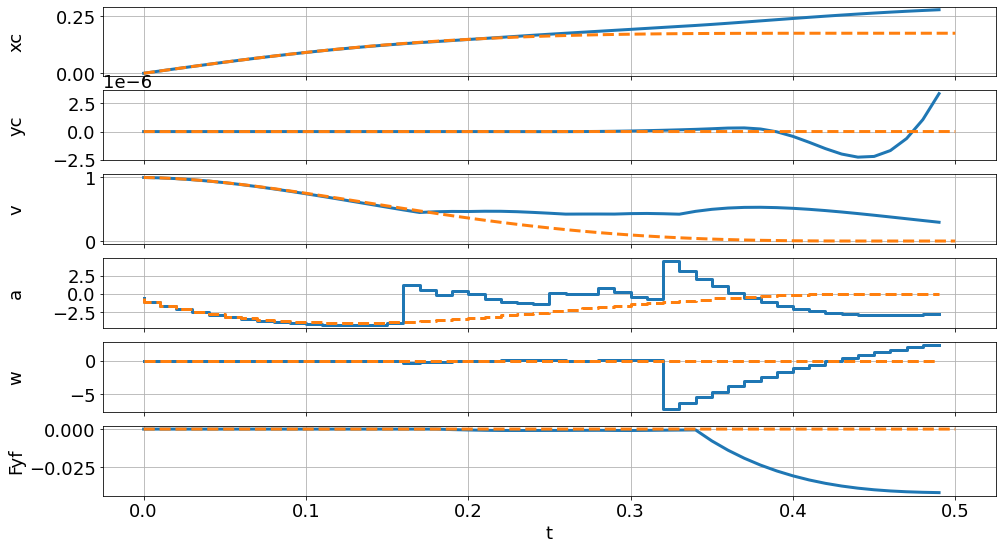

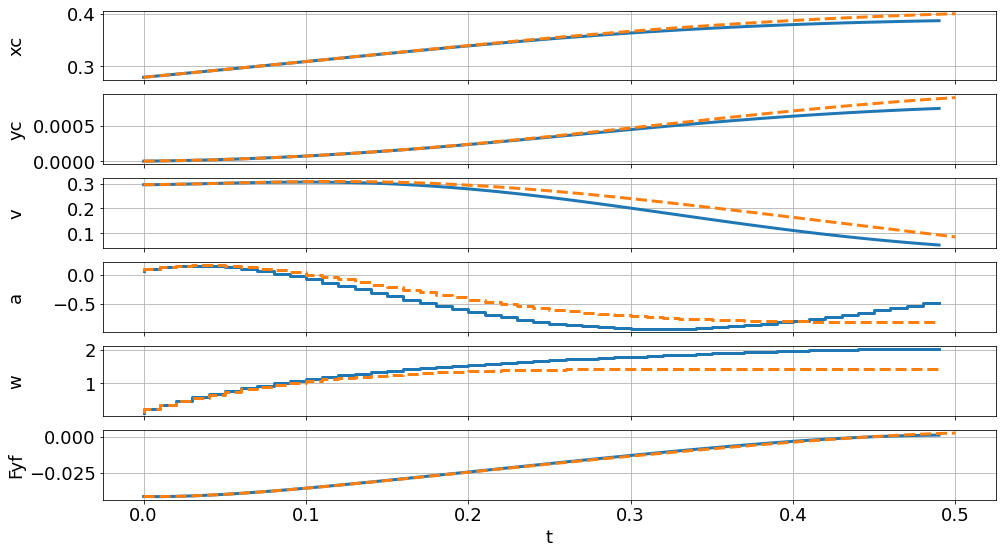

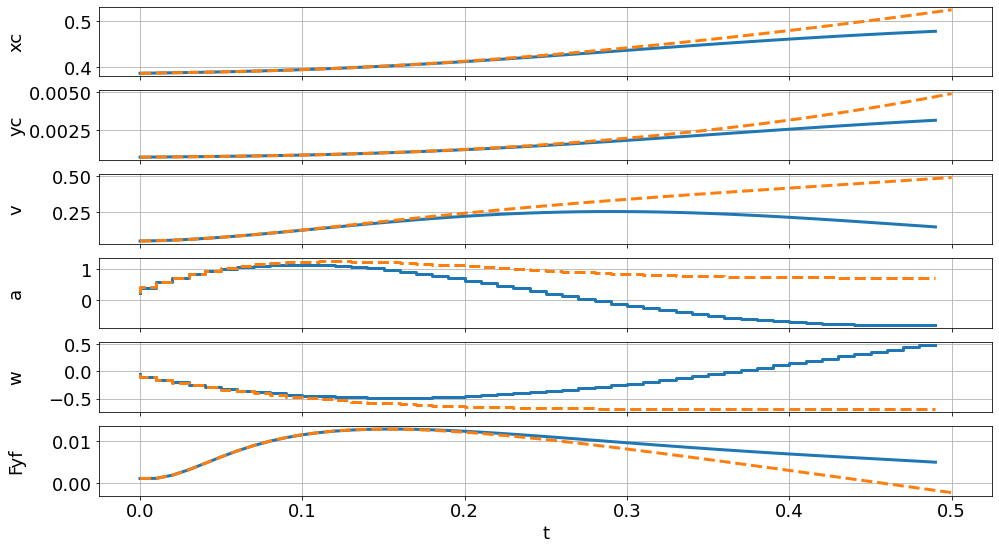

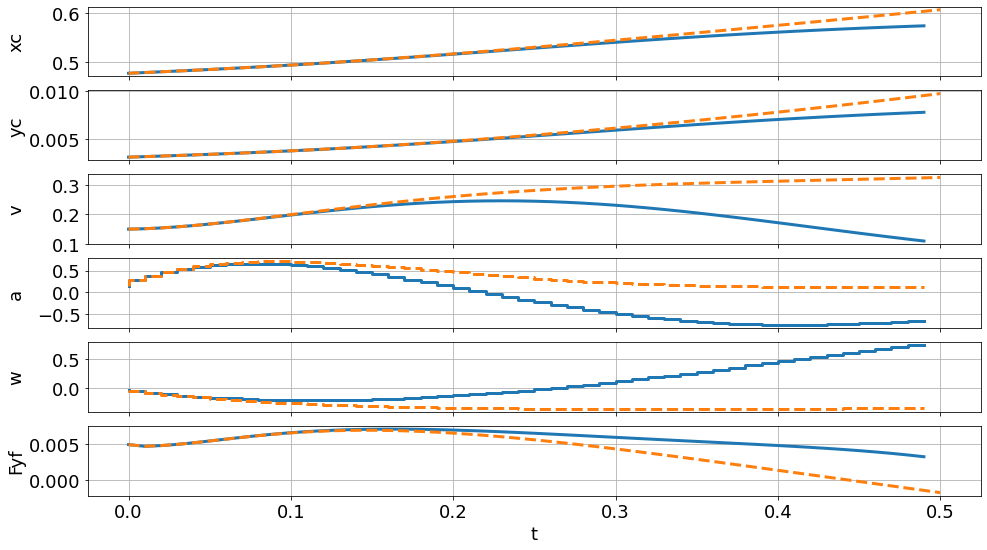

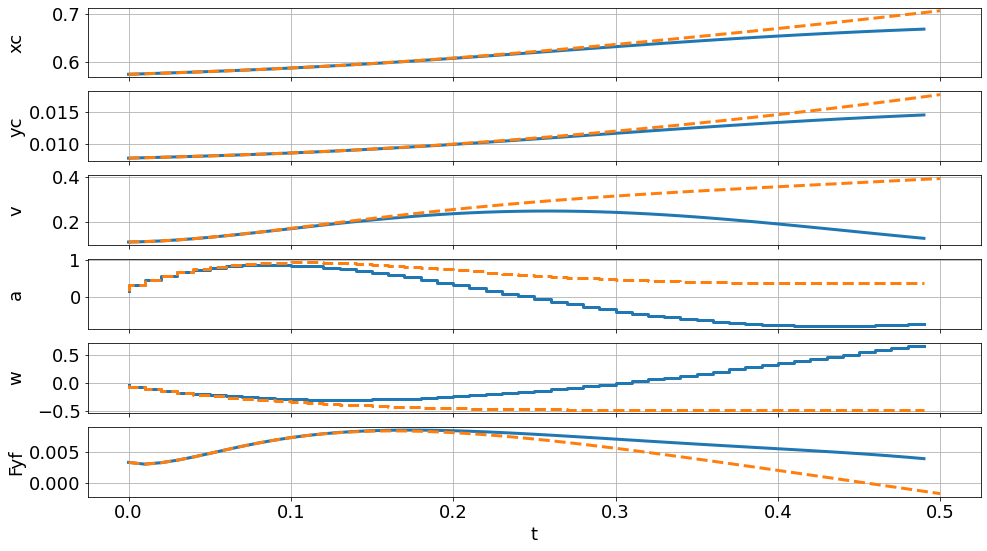

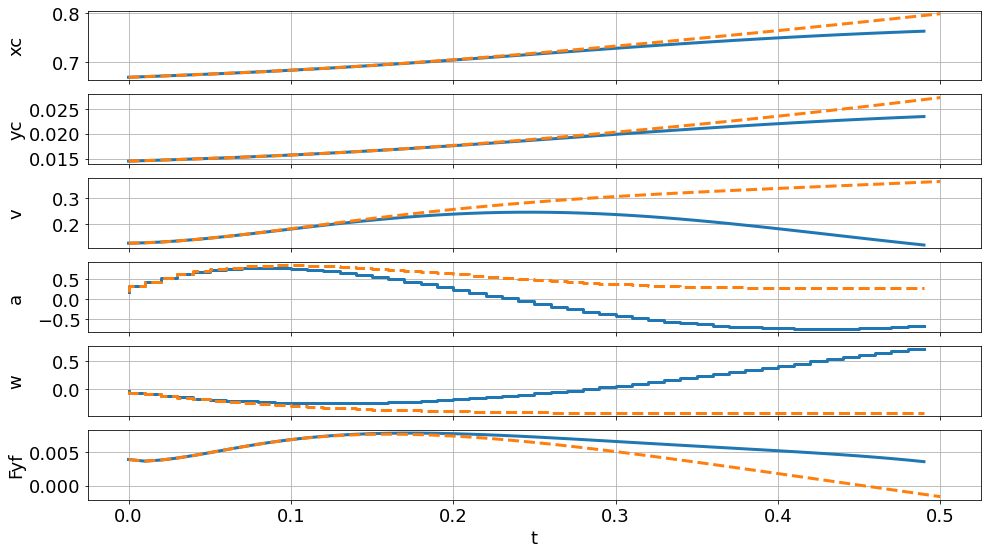

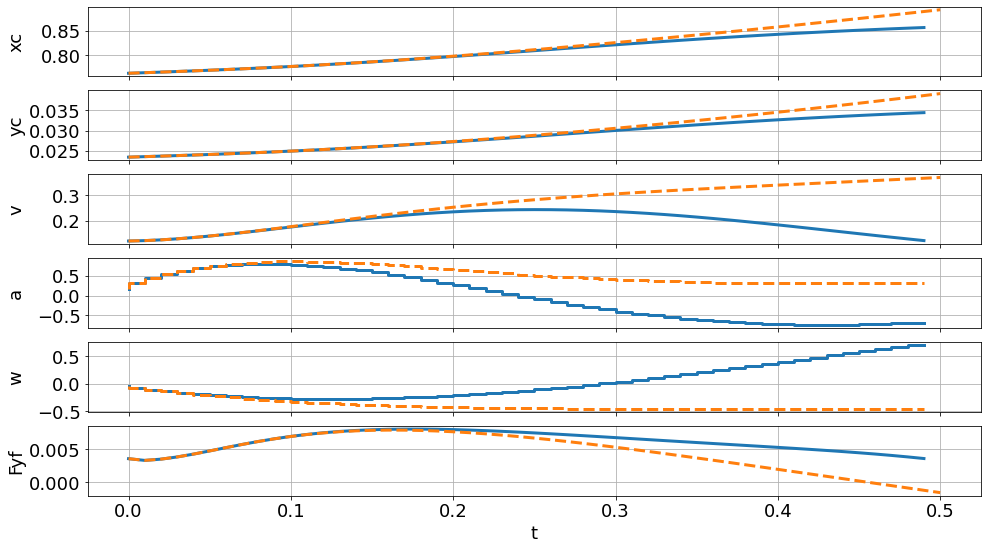

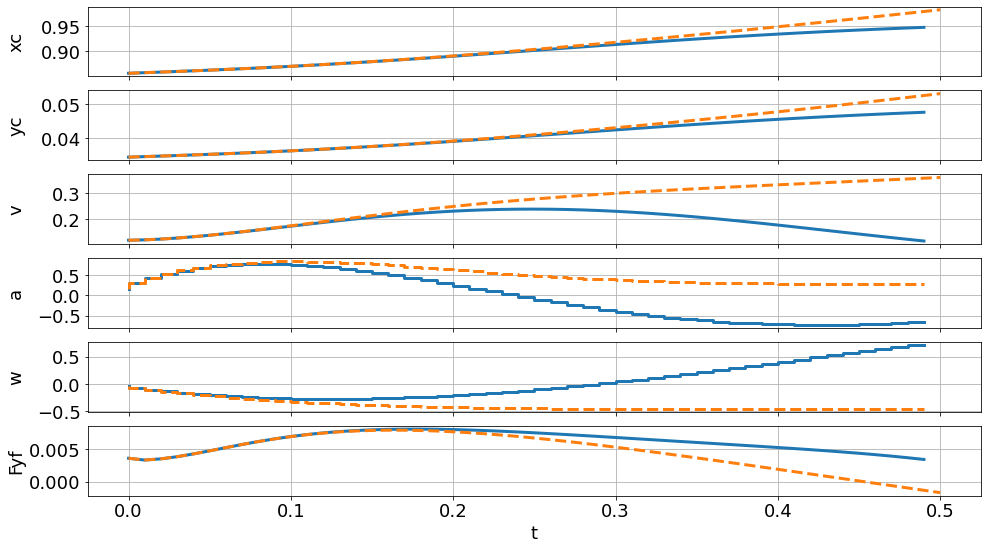

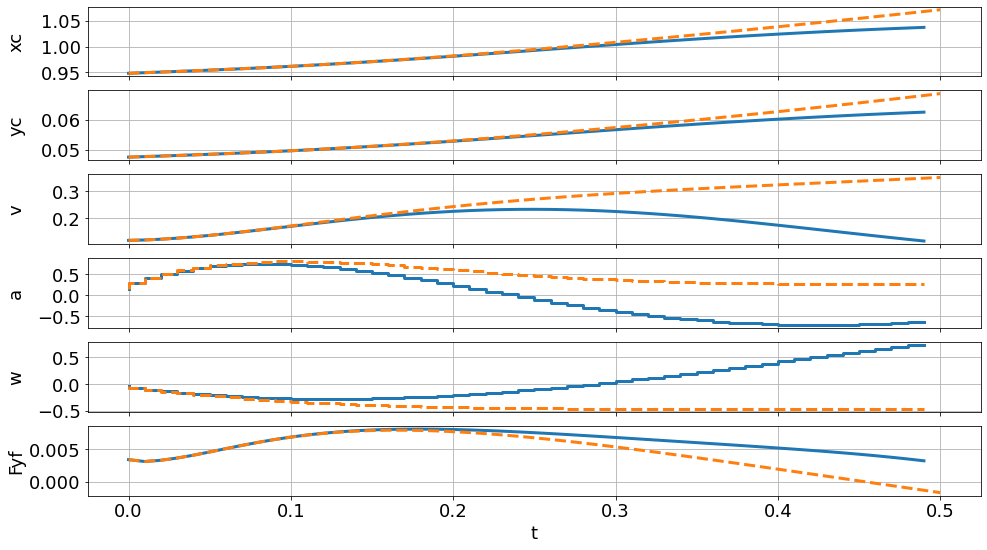

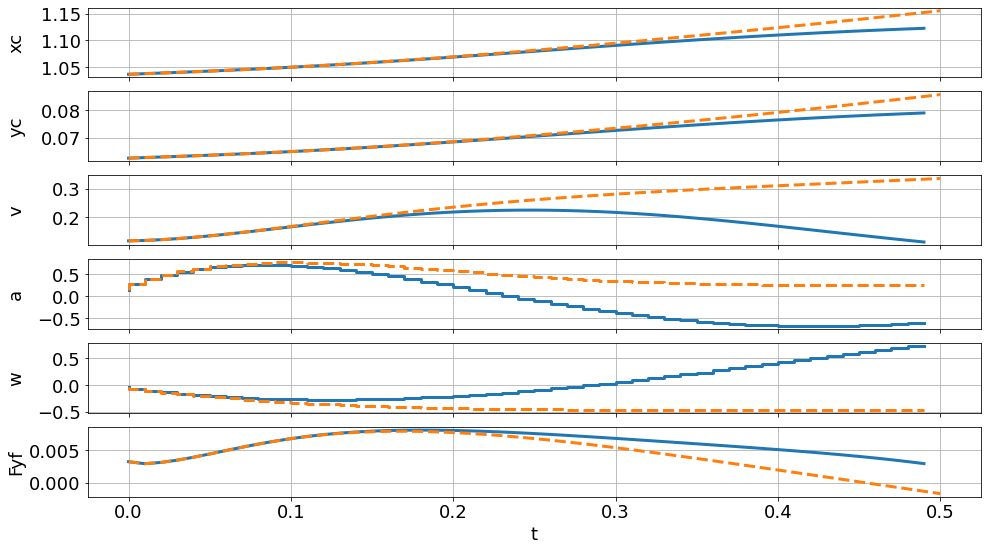

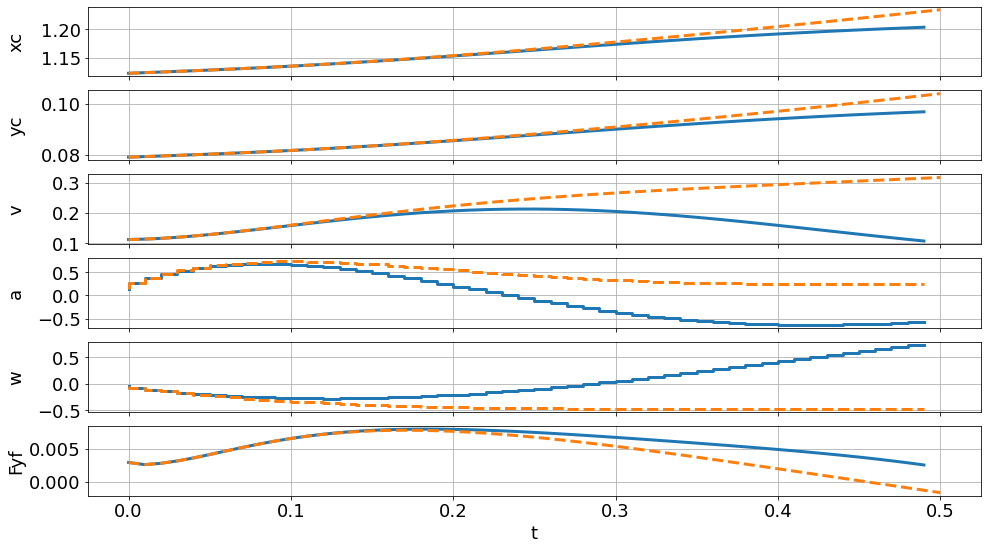

In [14]:
x_0=np.array([[0],[0],[1],[0],[0],[0],[0],[0]])
x=np.zeros((1,1))
y=np.zeros((1,1))
(x_,y_)=control(x_0,0,x,y)

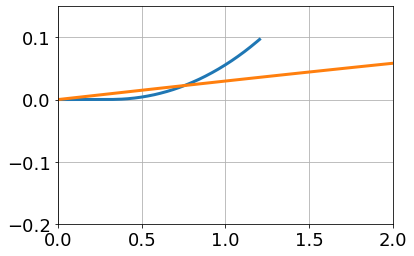

In [16]:
plt.plot(x_,y_)
xl=np.linspace(-7,100,2000)
plt.plot(xl,0.15*np.sin(xl/5))
plt.xlim(0,2)
plt.ylim(-0.2,0.15)
plt.show()